In [1]:
import dirichletcal
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.calibration import CalibratedClassifierCV
from sklearn.isotonic import IsotonicRegression
import numpy as np
import pandas as pd
import pickle
import math
import optuna
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn import preprocessing
from NFLUtils import NFLUtils
nfl_utils = NFLUtils()
from MLBUtils import MLBUtils
mlb_utils = MLBUtils()

%matplotlib inline

import logging
# Set up logging
logging.basicConfig(level=logging.INFO)
# Set pandas display option to show all columns
pd.set_option('display.max_columns', None)

# XGBoost 
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import log_loss
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold, cross_val_score, cross_val_predict
import seaborn as sns # confusion matrix

from dirichletcal.calib.fulldirichlet import FullDirichletCalibrator

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import jax
jax.config.update("jax_platform_name", "cpu")

In [2]:
def set_all_seeds(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Load CSV


In [3]:
df = pd.read_csv("./ttennisData/TTCupSliding50.csv", index_col=False, low_memory=False)

# Remove the performance set
test_performance_size = 900
test_performance_df = df[df.shape[0]-test_performance_size:]
df = df[:df.shape[0]-test_performance_size]

print(df.shape)
df.info()

(73379, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73379 entries, 0 to 73378
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        73379 non-null  int64  
 1   Date              73379 non-null  int64  
 2   Player1           73379 non-null  int64  
 3   Player2           73379 non-null  int64  
 4   Sets_P1           73379 non-null  float64
 5   Sets_P2           73379 non-null  float64
 6   Total_P1          73379 non-null  float64
 7   Total_P2          73379 non-null  float64
 8   Total_Score       73379 non-null  int64  
 9   Total_Allowed_P1  73379 non-null  float64
 10  Total_Allowed_P2  73379 non-null  float64
 11  Over_74           73379 non-null  bool   
 12  Odds_P1           73379 non-null  float64
 13  Odds_P2           73379 non-null  float64
 14  pythagorean_P1    73379 non-null  float64
 15  pythagorean_P2    73379 non-null  float64
 16  D_Sets            73379 non-

In [4]:
checkEmpty = df[df["Total_Score"] == 0]
print(checkEmpty.shape)

(0, 20)


In [5]:

# Load data
x_col = [
    'Sets_P1',
    'Sets_P2',
    'Total_P1',
    'Total_P2',
    'Total_Allowed_P1',
    'Total_Allowed_P2',
    'pythagorean_P1',
    'pythagorean_P2',
    'D_Sets',
    'D_Odds',
#    'No_Odds', # Removed in EDA
    'D_Total',
    'D_Total_Allowed'
]

y_col = ['Over_74']
x = df[x_col]
y = df[y_col]

perf_conts_df = test_performance_df[x_col]
perf_y_df = test_performance_df[y_col]


# Create an array of continuous values

Numpy array 'conts' containing stack of each continuous column

In [6]:
conts = np.stack([x[col].values for col in list(x.columns)], 1)
y_col = np.stack([y[col].values for col in list(y.columns)], 1)

perf_conts = np.stack([perf_conts_df[col].values for col in list(perf_conts_df.columns)], 1)
perf_y_col = np.stack([perf_y_df[col].values for col in list(perf_y_df.columns)], 1)

conts_train = conts
y_train = y_col

In [7]:
def convert_probas(probas, local_y_col):
    """
    Using y_col, this converts 2d array of probas into a format that works with the backtest calculation.
    That is, 
    
    probas: 2d array with first element being predicted visitor odds & other being predicted home odds
    y_col: ['H_Won', 'H_start_odds', 'V_start_odds', 'Home_Team_Id', 'Visitor_Team_Id', 'combined']
    """
    # Convert to decimal odds, apply 5% vig estimate
    local_y_col[:,1] = (1 / local_y_col[:,1]) / 1.05
    local_y_col[:,2] = (1 / local_y_col[:,2]) / 1.05
    # probas[:,1] = (1 / probas[:,1])
    # probas[:,0] = (1 / probas[:,0])
    override_req = True
    
    # Set to 0 if < the model's implied probability
    bet_res = []
    for i in range(len(probas)):
        if (probas[i,1] > local_y_col[i,1] or override_req == True) and probas[i,1] > probas[i,0]:
            bet_res.append(probas[i,1]) # Convert back to decimal odds
        elif (probas[i,0] > local_y_col[i,2] or override_req == True) and probas[i,0] > probas[i,1]:
            bet_res.append((-1*probas[i,0])) # Convert back to decimal odds
        else:
            print(f"{probas[i,:]} local ycol = {local_y_col[i,:]}")
            bet_res.append(0)
    return np.array(bet_res)

### Old approach (not based on calibration)

In [8]:
def objective(trial, override_params=None):
    """
    When doing optuna training: trial is defined, override_params left as None
    when recreating model using best parameters (override_params): trial is None, override_params are defined
    """
    is_training = trial != None
    # --- Suggest hyperparameters ---
    if is_training:
        params = {
            'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
            'max_depth': trial.suggest_int('max_depth', 2, 6),
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 12, log=True),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-6, 1.0, log=True),  # Add L1 reg
            'gamma': trial.suggest_float('gamma', 0, 1.0),  # Add min split loss
        }
    else:
        params=override_params

    
    # Training set to fit XGB
    # Test set to fit Calibrator
    # Holdout set (from test set) to calculate loss
    loss = []
    kf = KFold(n_splits=9, shuffle=False) # 3 folds since 
    for train_index, test_index in kf.split(conts_train):
        X_clas = conts_train[train_index]
        X_cal = conts_train[test_index]

        y_clas = y_col[train_index].ravel() # ravel=flatten to (n,)
        y_cal = y_col[test_index].ravel()

        X_cal, X_holdout, y_cal, y_holdout = train_test_split(X_cal, y_cal, test_size=0.1, shuffle=False)
        #print(f"X_clas {X_clas.shape} X_cal {X_cal.shape} X_holdout {X_holdout.shape}")

        # Create classifier & fit on test set
        classifier = XGBClassifier(
            objective='binary:logistic',
            eval_metric='error',
            **{k: v for k, v in params.items() if k.startswith('cal_') == False}
        )
        classifier.fit(X_clas, y_clas)

        # Create calibrator (Note: Ideal to have 5k+ records)
        calibrator = IsotonicRegression(out_of_bounds='clip')
        X_cal = classifier.predict_proba(X_cal)[:,1] # has to be 1D to match y_test
        calibrator.fit(X_cal, y_cal)

        # Use holdout set to calculate loss
        X_holdout = classifier.predict_proba(X_holdout)[:,1]
        X_holdout = calibrator.predict(X_holdout)
        holdout_loss = log_loss(y_holdout, X_holdout)
        loss.append(holdout_loss)

    if is_training:
        return np.mean(loss)

    
    # ----- When not is_training, train and return classifier, calibrator -----
    X_clas, X_cal, y_clas, y_cal = train_test_split(conts_train, y_col, random_state=1, test_size=0.1)
    y_clas = y_clas.ravel()
    y_cal = y_cal.ravel()
    
    # Create classifier
    classifier = XGBClassifier(
        objective='binary:logistic',
        eval_metric='error',
        **{k: v for k, v in params.items() if k.startswith('cal_') == False}
    )
    
    classifier.fit(X_clas, y_clas)

    # Create calibrator, train on classifier predictions
    calibrator = IsotonicRegression(out_of_bounds='clip')
    X_cal = classifier.predict_proba(X_cal)[:,1]
    calibrator.fit(X_cal, y_cal)
    return classifier, calibrator
    

def print_callback(study, trial):
    print(f"Trial {trial.number} finished with value: {trial.value}")
    print(f"Best trial so far: {study.best_trial.number}, value: {study.best_trial.value}")
    
    

In [9]:
study = optuna.create_study(
    direction='minimize',
    pruner=optuna.pruners.HyperbandPruner(min_resource=1, max_resource=1000)
)

study.optimize(objective, n_trials=3000, callbacks=[print_callback])
print("Best trial:")
trial = study.best_trial
print("Value: ", trial.value)
print("Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-09-26 20:07:45,063] A new study created in memory with name: no-name-c41093cf-ed9d-438f-b8b3-81cfe5b397ba
[I 2025-09-26 20:07:46,211] Trial 0 finished with value: 0.6939875402905822 and parameters: {'learning_rate': 0.29516828988158034, 'max_depth': 5, 'n_estimators': 84, 'subsample': 0.6326771282819138, 'colsample_bytree': 0.9355707754460032, 'min_child_weight': 9, 'reg_lambda': 0.5418242201767621, 'reg_alpha': 0.11764929076728933, 'gamma': 0.5023429382197073}. Best is trial 0 with value: 0.6939875402905822.


Trial 0 finished with value: 0.6939875402905822
Best trial so far: 0, value: 0.6939875402905822


[I 2025-09-26 20:07:49,199] Trial 1 finished with value: 0.6913740417430762 and parameters: {'learning_rate': 0.04952219043016568, 'max_depth': 6, 'n_estimators': 305, 'subsample': 0.9309954702437567, 'colsample_bytree': 0.649676488626154, 'min_child_weight': 8, 'reg_lambda': 0.20043220118058552, 'reg_alpha': 0.1890054239821216, 'gamma': 0.7151408017190456}. Best is trial 1 with value: 0.6913740417430762.


Trial 1 finished with value: 0.6913740417430762
Best trial so far: 1, value: 0.6913740417430762


[I 2025-09-26 20:07:51,983] Trial 2 finished with value: 0.6911536189274716 and parameters: {'learning_rate': 0.10070875264622753, 'max_depth': 6, 'n_estimators': 246, 'subsample': 0.6443365101260786, 'colsample_bytree': 0.6465873475034637, 'min_child_weight': 8, 'reg_lambda': 7.633723636499065, 'reg_alpha': 0.8360349781685302, 'gamma': 0.5236824145139519}. Best is trial 2 with value: 0.6911536189274716.


Trial 2 finished with value: 0.6911536189274716
Best trial so far: 2, value: 0.6911536189274716


[I 2025-09-26 20:07:55,609] Trial 3 finished with value: 0.6915103910537992 and parameters: {'learning_rate': 0.0016541295587707678, 'max_depth': 3, 'n_estimators': 486, 'subsample': 0.7274054662445253, 'colsample_bytree': 0.9466780581693743, 'min_child_weight': 6, 'reg_lambda': 0.15547037271679362, 'reg_alpha': 0.08964380173741654, 'gamma': 0.17916395750657998}. Best is trial 2 with value: 0.6911536189274716.


Trial 3 finished with value: 0.6915103910537992
Best trial so far: 2, value: 0.6911536189274716


[I 2025-09-26 20:07:57,779] Trial 4 finished with value: 0.6907944904705741 and parameters: {'learning_rate': 0.007584209648879315, 'max_depth': 6, 'n_estimators': 121, 'subsample': 0.6714449296449478, 'colsample_bytree': 0.8126367920900579, 'min_child_weight': 4, 'reg_lambda': 0.12528746492748005, 'reg_alpha': 4.71746632845067e-05, 'gamma': 0.36771712654317157}. Best is trial 4 with value: 0.6907944904705741.


Trial 4 finished with value: 0.6907944904705741
Best trial so far: 4, value: 0.6907944904705741


[I 2025-09-26 20:08:03,800] Trial 5 finished with value: 0.6915371819329068 and parameters: {'learning_rate': 0.007989869218509665, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.9364621970490996, 'colsample_bytree': 0.9974889763046861, 'min_child_weight': 7, 'reg_lambda': 0.5436209301209953, 'reg_alpha': 0.000802372617037014, 'gamma': 0.5175945929534669}. Best is trial 4 with value: 0.6907944904705741.


Trial 5 finished with value: 0.6915371819329068
Best trial so far: 4, value: 0.6907944904705741


[I 2025-09-26 20:08:05,690] Trial 6 finished with value: 0.692832557191705 and parameters: {'learning_rate': 0.0023595540866861715, 'max_depth': 5, 'n_estimators': 124, 'subsample': 0.791378625221983, 'colsample_bytree': 0.6441645390377492, 'min_child_weight': 4, 'reg_lambda': 0.29085982405842364, 'reg_alpha': 8.114705971080682e-05, 'gamma': 0.7787455414865555}. Best is trial 4 with value: 0.6907944904705741.


Trial 6 finished with value: 0.692832557191705
Best trial so far: 4, value: 0.6907944904705741


[I 2025-09-26 20:08:07,667] Trial 7 finished with value: 0.6918372880540677 and parameters: {'learning_rate': 0.0010610855477490866, 'max_depth': 2, 'n_estimators': 308, 'subsample': 0.9623354280851056, 'colsample_bytree': 0.9073001704870861, 'min_child_weight': 5, 'reg_lambda': 2.4440715694988917, 'reg_alpha': 0.2731864001699322, 'gamma': 0.38902880601914114}. Best is trial 4 with value: 0.6907944904705741.


Trial 7 finished with value: 0.6918372880540677
Best trial so far: 4, value: 0.6907944904705741


[I 2025-09-26 20:08:10,744] Trial 8 finished with value: 0.6939919652149804 and parameters: {'learning_rate': 0.0014108475183423222, 'max_depth': 3, 'n_estimators': 386, 'subsample': 0.8403247380314303, 'colsample_bytree': 0.9782847482456947, 'min_child_weight': 8, 'reg_lambda': 3.135570843325561, 'reg_alpha': 0.030096089671302586, 'gamma': 0.2791299351938936}. Best is trial 4 with value: 0.6907944904705741.


Trial 8 finished with value: 0.6939919652149804
Best trial so far: 4, value: 0.6907944904705741


[I 2025-09-26 20:08:11,565] Trial 9 finished with value: 0.6934403124697669 and parameters: {'learning_rate': 0.003345276872273243, 'max_depth': 3, 'n_estimators': 60, 'subsample': 0.9166902869780041, 'colsample_bytree': 0.7343888275975514, 'min_child_weight': 8, 'reg_lambda': 0.21788574358892254, 'reg_alpha': 0.017474674673321137, 'gamma': 0.2654236335294907}. Best is trial 4 with value: 0.6907944904705741.


Trial 9 finished with value: 0.6934403124697669
Best trial so far: 4, value: 0.6907944904705741


[I 2025-09-26 20:08:13,338] Trial 10 finished with value: 0.6950353806232517 and parameters: {'learning_rate': 0.017092173646228642, 'max_depth': 4, 'n_estimators': 179, 'subsample': 0.709785709234295, 'colsample_bytree': 0.832652418780657, 'min_child_weight': 1, 'reg_lambda': 1.214756045122346, 'reg_alpha': 4.0735953339758e-06, 'gamma': 0.0043314766073254685}. Best is trial 4 with value: 0.6907944904705741.


Trial 10 finished with value: 0.6950353806232517
Best trial so far: 4, value: 0.6907944904705741


[I 2025-09-26 20:08:16,087] Trial 11 finished with value: 0.6913232046155108 and parameters: {'learning_rate': 0.08733720810489379, 'max_depth': 6, 'n_estimators': 198, 'subsample': 0.6145320148605036, 'colsample_bytree': 0.758044636762109, 'min_child_weight': 3, 'reg_lambda': 10.35772635446631, 'reg_alpha': 2.3219672510037736e-05, 'gamma': 0.6172263854464708}. Best is trial 4 with value: 0.6907944904705741.


Trial 11 finished with value: 0.6913232046155108
Best trial so far: 4, value: 0.6907944904705741


[I 2025-09-26 20:08:18,875] Trial 12 finished with value: 0.6906746587681046 and parameters: {'learning_rate': 0.0449463934638805, 'max_depth': 6, 'n_estimators': 210, 'subsample': 0.6807798403768688, 'colsample_bytree': 0.8455898278511337, 'min_child_weight': 10, 'reg_lambda': 10.838854076082626, 'reg_alpha': 0.000816840568401407, 'gamma': 0.9104247266841761}. Best is trial 12 with value: 0.6906746587681046.


Trial 12 finished with value: 0.6906746587681046
Best trial so far: 12, value: 0.6906746587681046


[I 2025-09-26 20:08:21,469] Trial 13 finished with value: 0.6910394222893805 and parameters: {'learning_rate': 0.017450028321039944, 'max_depth': 6, 'n_estimators': 169, 'subsample': 0.7253911010472922, 'colsample_bytree': 0.8490688301095771, 'min_child_weight': 2, 'reg_lambda': 0.10040309799604172, 'reg_alpha': 0.0008629741568670473, 'gamma': 0.9594808313148425}. Best is trial 12 with value: 0.6906746587681046.


Trial 13 finished with value: 0.6910394222893805
Best trial so far: 12, value: 0.6906746587681046


[I 2025-09-26 20:08:24,264] Trial 14 finished with value: 0.6910975852227235 and parameters: {'learning_rate': 0.006829061639069185, 'max_depth': 5, 'n_estimators': 244, 'subsample': 0.6808135888982743, 'colsample_bytree': 0.8724454763636881, 'min_child_weight': 10, 'reg_lambda': 3.6053890288208503, 'reg_alpha': 9.084445158984386e-05, 'gamma': 0.9815067707195415}. Best is trial 12 with value: 0.6906746587681046.


Trial 14 finished with value: 0.6910975852227235
Best trial so far: 12, value: 0.6906746587681046


[I 2025-09-26 20:08:25,761] Trial 15 finished with value: 0.6928645956794823 and parameters: {'learning_rate': 0.016952946179835428, 'max_depth': 4, 'n_estimators': 127, 'subsample': 0.7828267146057035, 'colsample_bytree': 0.7720027563944821, 'min_child_weight': 5, 'reg_lambda': 1.200874982841464, 'reg_alpha': 2.3615320564614386e-06, 'gamma': 0.8185592764653526}. Best is trial 12 with value: 0.6906746587681046.


Trial 15 finished with value: 0.6928645956794823
Best trial so far: 12, value: 0.6906746587681046


[I 2025-09-26 20:08:28,766] Trial 16 finished with value: 0.6934812193622539 and parameters: {'learning_rate': 0.036506195606909195, 'max_depth': 4, 'n_estimators': 371, 'subsample': 0.8582416296906944, 'colsample_bytree': 0.7039619684908264, 'min_child_weight': 3, 'reg_lambda': 0.49546860780180696, 'reg_alpha': 0.003062416420808187, 'gamma': 0.3791002966248234}. Best is trial 12 with value: 0.6906746587681046.


Trial 16 finished with value: 0.6934812193622539
Best trial so far: 12, value: 0.6906746587681046


[I 2025-09-26 20:08:30,989] Trial 17 finished with value: 0.6906677138545544 and parameters: {'learning_rate': 0.00670510965722389, 'max_depth': 6, 'n_estimators': 124, 'subsample': 0.6772121601683927, 'colsample_bytree': 0.8033772285544165, 'min_child_weight': 10, 'reg_lambda': 4.571459534295216, 'reg_alpha': 0.0002343838239379215, 'gamma': 0.6663559750858421}. Best is trial 17 with value: 0.6906677138545544.


Trial 17 finished with value: 0.6906677138545544
Best trial so far: 17, value: 0.6906677138545544


[I 2025-09-26 20:08:33,952] Trial 18 finished with value: 0.6929750508315661 and parameters: {'learning_rate': 0.004253736156388848, 'max_depth': 5, 'n_estimators': 231, 'subsample': 0.7534857148475052, 'colsample_bytree': 0.8883926873739023, 'min_child_weight': 10, 'reg_lambda': 5.740550487415471, 'reg_alpha': 0.0028840800662503483, 'gamma': 0.8679787664894172}. Best is trial 17 with value: 0.6906677138545544.


Trial 18 finished with value: 0.6929750508315661
Best trial so far: 17, value: 0.6906677138545544


[I 2025-09-26 20:08:36,489] Trial 19 finished with value: 0.6934464088555375 and parameters: {'learning_rate': 0.030498801407517283, 'max_depth': 6, 'n_estimators': 167, 'subsample': 0.6758563674416614, 'colsample_bytree': 0.7864468742039458, 'min_child_weight': 10, 'reg_lambda': 11.94824492566731, 'reg_alpha': 0.0004305733026157599, 'gamma': 0.6775825684577074}. Best is trial 17 with value: 0.6906677138545544.


Trial 19 finished with value: 0.6934464088555375
Best trial so far: 17, value: 0.6906677138545544


[I 2025-09-26 20:08:38,235] Trial 20 finished with value: 0.6922559636857085 and parameters: {'learning_rate': 0.20558996562430842, 'max_depth': 2, 'n_estimators': 288, 'subsample': 0.6006506519711385, 'colsample_bytree': 0.7160161885947027, 'min_child_weight': 9, 'reg_lambda': 5.164000589749644, 'reg_alpha': 0.000233891325124037, 'gamma': 0.8932985303274273}. Best is trial 17 with value: 0.6906677138545544.


Trial 20 finished with value: 0.6922559636857085
Best trial so far: 17, value: 0.6906677138545544


[I 2025-09-26 20:08:40,010] Trial 21 finished with value: 0.6925760857558442 and parameters: {'learning_rate': 0.007481488486713251, 'max_depth': 6, 'n_estimators': 104, 'subsample': 0.6691504671466525, 'colsample_bytree': 0.8270180147830787, 'min_child_weight': 6, 'reg_lambda': 1.849183671298295, 'reg_alpha': 1.5515498362174007e-05, 'gamma': 0.630888612693258}. Best is trial 17 with value: 0.6906677138545544.


Trial 21 finished with value: 0.6925760857558442
Best trial so far: 17, value: 0.6906677138545544


[I 2025-09-26 20:08:41,125] Trial 22 finished with value: 0.6909337981571498 and parameters: {'learning_rate': 0.011604549997392874, 'max_depth': 6, 'n_estimators': 53, 'subsample': 0.6978411387251625, 'colsample_bytree': 0.8133861196184361, 'min_child_weight': 4, 'reg_lambda': 5.78597052547278, 'reg_alpha': 0.003387748927980381, 'gamma': 0.418062738220236}. Best is trial 17 with value: 0.6906677138545544.


Trial 22 finished with value: 0.6909337981571498
Best trial so far: 17, value: 0.6906677138545544


[I 2025-09-26 20:08:43,070] Trial 23 finished with value: 0.6928679236416693 and parameters: {'learning_rate': 0.004421303454913019, 'max_depth': 5, 'n_estimators': 139, 'subsample': 0.7566799414592266, 'colsample_bytree': 0.861063193030293, 'min_child_weight': 9, 'reg_lambda': 8.279320149855442, 'reg_alpha': 2.7386828061313212e-05, 'gamma': 0.6024755993529647}. Best is trial 17 with value: 0.6906677138545544.


Trial 23 finished with value: 0.6928679236416693
Best trial so far: 17, value: 0.6906677138545544


[I 2025-09-26 20:08:45,886] Trial 24 finished with value: 0.6949974095628672 and parameters: {'learning_rate': 0.059550160257222845, 'max_depth': 6, 'n_estimators': 210, 'subsample': 0.6501006210323899, 'colsample_bytree': 0.8006142393166609, 'min_child_weight': 7, 'reg_lambda': 0.835871761464191, 'reg_alpha': 0.0002495122754599688, 'gamma': 0.7639045555616681}. Best is trial 17 with value: 0.6906677138545544.


Trial 24 finished with value: 0.6949974095628672
Best trial so far: 17, value: 0.6906677138545544


[I 2025-09-26 20:08:47,702] Trial 25 finished with value: 0.6921171622356238 and parameters: {'learning_rate': 0.028259676650981155, 'max_depth': 5, 'n_estimators': 148, 'subsample': 0.7551086143484425, 'colsample_bytree': 0.7546484209604803, 'min_child_weight': 4, 'reg_lambda': 1.9552390791056242, 'reg_alpha': 6.791420957926474e-05, 'gamma': 0.1404424516344337}. Best is trial 17 with value: 0.6906677138545544.


Trial 25 finished with value: 0.6921171622356238
Best trial so far: 17, value: 0.6906677138545544


[I 2025-09-26 20:08:49,249] Trial 26 finished with value: 0.6929115582724654 and parameters: {'learning_rate': 0.011998954997142526, 'max_depth': 6, 'n_estimators': 91, 'subsample': 0.8316372821320134, 'colsample_bytree': 0.6913812606961386, 'min_child_weight': 7, 'reg_lambda': 3.8853678970138237, 'reg_alpha': 6.5540021464733536e-06, 'gamma': 0.8860093920204077}. Best is trial 17 with value: 0.6906677138545544.


Trial 26 finished with value: 0.6929115582724654
Best trial so far: 17, value: 0.6906677138545544


[I 2025-09-26 20:08:51,705] Trial 27 finished with value: 0.6932508678742273 and parameters: {'learning_rate': 0.002941434230050023, 'max_depth': 5, 'n_estimators': 201, 'subsample': 0.657584815521415, 'colsample_bytree': 0.6059586580566387, 'min_child_weight': 10, 'reg_lambda': 7.780675485742417, 'reg_alpha': 1.043261587488148e-06, 'gamma': 0.3161399398930296}. Best is trial 17 with value: 0.6906677138545544.


Trial 27 finished with value: 0.6932508678742273
Best trial so far: 17, value: 0.6906677138545544


[I 2025-09-26 20:08:57,306] Trial 28 finished with value: 0.6914351126219179 and parameters: {'learning_rate': 0.005716969821631184, 'max_depth': 6, 'n_estimators': 339, 'subsample': 0.6999850400458608, 'colsample_bytree': 0.9078243709140594, 'min_child_weight': 3, 'reg_lambda': 0.8663968914396428, 'reg_alpha': 0.010283260644096869, 'gamma': 0.4365158881757159}. Best is trial 17 with value: 0.6906677138545544.


Trial 28 finished with value: 0.6914351126219179
Best trial so far: 17, value: 0.6906677138545544


[I 2025-09-26 20:08:58,939] Trial 29 finished with value: 0.6937822893027072 and parameters: {'learning_rate': 0.19043957900374062, 'max_depth': 5, 'n_estimators': 115, 'subsample': 0.6261412664788473, 'colsample_bytree': 0.7962291759798124, 'min_child_weight': 9, 'reg_lambda': 0.4402720189631824, 'reg_alpha': 0.000163656700104692, 'gamma': 0.5511346231223051}. Best is trial 17 with value: 0.6906677138545544.


Trial 29 finished with value: 0.6937822893027072
Best trial so far: 17, value: 0.6906677138545544


[I 2025-09-26 20:09:00,728] Trial 30 finished with value: 0.6926559092835061 and parameters: {'learning_rate': 0.011358770453736304, 'max_depth': 6, 'n_estimators': 84, 'subsample': 0.6374396156841571, 'colsample_bytree': 0.8507133285975654, 'min_child_weight': 9, 'reg_lambda': 4.914447313986508, 'reg_alpha': 0.0017365652208989968, 'gamma': 0.6991665504828806}. Best is trial 17 with value: 0.6906677138545544.


Trial 30 finished with value: 0.6926559092835061
Best trial so far: 17, value: 0.6906677138545544


[I 2025-09-26 20:09:02,085] Trial 31 finished with value: 0.6907835421869966 and parameters: {'learning_rate': 0.0103742768709065, 'max_depth': 6, 'n_estimators': 61, 'subsample': 0.6979473862713647, 'colsample_bytree': 0.8149201414196987, 'min_child_weight': 4, 'reg_lambda': 6.503283907013716, 'reg_alpha': 0.005542722452354038, 'gamma': 0.4623688234171478}. Best is trial 17 with value: 0.6906677138545544.


Trial 31 finished with value: 0.6907835421869966
Best trial so far: 17, value: 0.6906677138545544


[I 2025-09-26 20:09:03,812] Trial 32 finished with value: 0.6929040934807436 and parameters: {'learning_rate': 0.0236831329957025, 'max_depth': 6, 'n_estimators': 77, 'subsample': 0.7313359524713088, 'colsample_bytree': 0.8255302840920458, 'min_child_weight': 5, 'reg_lambda': 9.900951278187225, 'reg_alpha': 0.008296406439065205, 'gamma': 0.4801940365808684}. Best is trial 17 with value: 0.6906677138545544.


Trial 32 finished with value: 0.6929040934807436
Best trial so far: 17, value: 0.6906677138545544


[I 2025-09-26 20:09:06,480] Trial 33 finished with value: 0.6929428891022535 and parameters: {'learning_rate': 0.04657132355583215, 'max_depth': 6, 'n_estimators': 159, 'subsample': 0.6864902899813426, 'colsample_bytree': 0.7737527574283487, 'min_child_weight': 2, 'reg_lambda': 6.359118447778221, 'reg_alpha': 0.0004382201836193423, 'gamma': 0.5812018609626366}. Best is trial 17 with value: 0.6906677138545544.


Trial 33 finished with value: 0.6929428891022535
Best trial so far: 17, value: 0.6906677138545544


[I 2025-09-26 20:09:08,037] Trial 34 finished with value: 0.6930947087162619 and parameters: {'learning_rate': 0.009018850474679098, 'max_depth': 5, 'n_estimators': 96, 'subsample': 0.6538707018294192, 'colsample_bytree': 0.8845838984833687, 'min_child_weight': 6, 'reg_lambda': 2.7300671992809833, 'reg_alpha': 0.041416355097119176, 'gamma': 0.3388350830576017}. Best is trial 17 with value: 0.6906677138545544.


Trial 34 finished with value: 0.6930947087162619
Best trial so far: 17, value: 0.6906677138545544


[I 2025-09-26 20:09:09,360] Trial 35 finished with value: 0.6929963592272838 and parameters: {'learning_rate': 0.0826550433219519, 'max_depth': 6, 'n_estimators': 56, 'subsample': 0.7139359699809028, 'colsample_bytree': 0.9484406680990662, 'min_child_weight': 4, 'reg_lambda': 0.1107872571566362, 'reg_alpha': 5.0135797830669674e-05, 'gamma': 0.20525491246532118}. Best is trial 17 with value: 0.6906677138545544.


Trial 35 finished with value: 0.6929963592272838
Best trial so far: 17, value: 0.6906677138545544


[I 2025-09-26 20:09:16,840] Trial 36 finished with value: 0.6910449305855092 and parameters: {'learning_rate': 0.004809340974231229, 'max_depth': 6, 'n_estimators': 448, 'subsample': 0.6267094722409325, 'colsample_bytree': 0.8089387922957314, 'min_child_weight': 5, 'reg_lambda': 8.684410472964156, 'reg_alpha': 0.0011414105900641176, 'gamma': 0.4757780411211457}. Best is trial 17 with value: 0.6906677138545544.


Trial 36 finished with value: 0.6910449305855092
Best trial so far: 17, value: 0.6906677138545544


[I 2025-09-26 20:09:21,001] Trial 37 finished with value: 0.6928689216046702 and parameters: {'learning_rate': 0.002280822305772775, 'max_depth': 5, 'n_estimators': 269, 'subsample': 0.7346920726965028, 'colsample_bytree': 0.8418700029362622, 'min_child_weight': 2, 'reg_lambda': 4.221350843634356, 'reg_alpha': 0.006395562018858326, 'gamma': 0.7486750318969831}. Best is trial 17 with value: 0.6906677138545544.


Trial 37 finished with value: 0.6928689216046702
Best trial so far: 17, value: 0.6906677138545544


[I 2025-09-26 20:09:23,489] Trial 38 finished with value: 0.6912606801858202 and parameters: {'learning_rate': 0.01834607794931381, 'max_depth': 6, 'n_estimators': 130, 'subsample': 0.6013280254813081, 'colsample_bytree': 0.7392952229136541, 'min_child_weight': 7, 'reg_lambda': 0.28969103944937585, 'reg_alpha': 0.0004803838664928921, 'gamma': 0.535939803185886}. Best is trial 17 with value: 0.6906677138545544.


Trial 38 finished with value: 0.6912606801858202
Best trial so far: 17, value: 0.6906677138545544


[I 2025-09-26 20:09:27,421] Trial 39 finished with value: 0.6968259334002895 and parameters: {'learning_rate': 0.010476383962862898, 'max_depth': 6, 'n_estimators': 222, 'subsample': 0.7745977745290233, 'colsample_bytree': 0.9141110722427874, 'min_child_weight': 8, 'reg_lambda': 1.580321715545903, 'reg_alpha': 0.09438265962040672, 'gamma': 0.8293907055567109}. Best is trial 17 with value: 0.6906677138545544.


Trial 39 finished with value: 0.6968259334002895
Best trial so far: 17, value: 0.6906677138545544


[I 2025-09-26 20:09:29,134] Trial 40 finished with value: 0.691795633857986 and parameters: {'learning_rate': 0.006074101850333306, 'max_depth': 3, 'n_estimators': 186, 'subsample': 0.6721486920920221, 'colsample_bytree': 0.783763699545579, 'min_child_weight': 3, 'reg_lambda': 6.606429565035059, 'reg_alpha': 0.00011592964549455011, 'gamma': 0.6759375928369539}. Best is trial 17 with value: 0.6906677138545544.


Trial 40 finished with value: 0.691795633857986
Best trial so far: 17, value: 0.6906677138545544


[I 2025-09-26 20:09:30,365] Trial 41 finished with value: 0.690815887109512 and parameters: {'learning_rate': 0.013595711520908951, 'max_depth': 6, 'n_estimators': 51, 'subsample': 0.6936380609924565, 'colsample_bytree': 0.813874448171427, 'min_child_weight': 4, 'reg_lambda': 11.724174479602167, 'reg_alpha': 0.0023983224723846002, 'gamma': 0.42665017301007424}. Best is trial 17 with value: 0.6906677138545544.


Trial 41 finished with value: 0.690815887109512
Best trial so far: 17, value: 0.6906677138545544


[I 2025-09-26 20:09:31,813] Trial 42 finished with value: 0.6932081490974267 and parameters: {'learning_rate': 0.022296345679355904, 'max_depth': 6, 'n_estimators': 73, 'subsample': 0.7016452136515453, 'colsample_bytree': 0.8178632745265763, 'min_child_weight': 4, 'reg_lambda': 11.901267355693552, 'reg_alpha': 0.0012234473264946908, 'gamma': 0.4310194296822302}. Best is trial 17 with value: 0.6906677138545544.


Trial 42 finished with value: 0.6932081490974267
Best trial so far: 17, value: 0.6906677138545544


[I 2025-09-26 20:09:33,812] Trial 43 finished with value: 0.691816942920132 and parameters: {'learning_rate': 0.014056907461659322, 'max_depth': 6, 'n_estimators': 110, 'subsample': 0.6424686496403447, 'colsample_bytree': 0.8649859668102893, 'min_child_weight': 5, 'reg_lambda': 7.188812070846675, 'reg_alpha': 0.026566158784439377, 'gamma': 0.37437745384707266}. Best is trial 17 with value: 0.6906677138545544.


Trial 43 finished with value: 0.691816942920132
Best trial so far: 17, value: 0.6906677138545544


[I 2025-09-26 20:09:35,146] Trial 44 finished with value: 0.692973185451894 and parameters: {'learning_rate': 0.007896984277994654, 'max_depth': 5, 'n_estimators': 77, 'subsample': 0.8121344145309151, 'colsample_bytree': 0.7584781210772891, 'min_child_weight': 4, 'reg_lambda': 9.804993316264483, 'reg_alpha': 0.3358427012066303, 'gamma': 0.23649295956354327}. Best is trial 17 with value: 0.6906677138545544.


Trial 44 finished with value: 0.692973185451894
Best trial so far: 17, value: 0.6906677138545544


[I 2025-09-26 20:09:37,524] Trial 45 finished with value: 0.691681000614127 and parameters: {'learning_rate': 0.0404663185446951, 'max_depth': 6, 'n_estimators': 144, 'subsample': 0.6889599224791115, 'colsample_bytree': 0.8393144038016216, 'min_child_weight': 3, 'reg_lambda': 0.14393688611455993, 'reg_alpha': 0.0050929432686274, 'gamma': 0.3091333151967998}. Best is trial 17 with value: 0.6906677138545544.


Trial 45 finished with value: 0.691681000614127
Best trial so far: 17, value: 0.6906677138545544


[I 2025-09-26 20:09:38,921] Trial 46 finished with value: 0.6929682885240799 and parameters: {'learning_rate': 0.003460870535759954, 'max_depth': 4, 'n_estimators': 111, 'subsample': 0.8892016697399767, 'colsample_bytree': 0.7998693666028224, 'min_child_weight': 4, 'reg_lambda': 4.727409527808355, 'reg_alpha': 0.001971475919179123, 'gamma': 0.4932526669066649}. Best is trial 17 with value: 0.6906677138545544.


Trial 46 finished with value: 0.6929682885240799
Best trial so far: 17, value: 0.6906677138545544


[I 2025-09-26 20:09:40,143] Trial 47 finished with value: 0.6906331418983548 and parameters: {'learning_rate': 0.008935176606168011, 'max_depth': 6, 'n_estimators': 54, 'subsample': 0.737231192770421, 'colsample_bytree': 0.7356740918208265, 'min_child_weight': 5, 'reg_lambda': 8.585788172561378, 'reg_alpha': 0.000637455520416463, 'gamma': 0.13586167061435583}. Best is trial 47 with value: 0.6906331418983548.


Trial 47 finished with value: 0.6906331418983548
Best trial so far: 47, value: 0.6906331418983548


[I 2025-09-26 20:09:41,695] Trial 48 finished with value: 0.692711642415941 and parameters: {'learning_rate': 0.009351789601729452, 'max_depth': 5, 'n_estimators': 96, 'subsample': 0.7414101097527538, 'colsample_bytree': 0.6739610314475311, 'min_child_weight': 6, 'reg_lambda': 2.8430467822085013, 'reg_alpha': 4.3136626077623686e-05, 'gamma': 0.05963839201182719}. Best is trial 47 with value: 0.6906331418983548.


Trial 48 finished with value: 0.692711642415941
Best trial so far: 47, value: 0.6906331418983548


[I 2025-09-26 20:09:43,139] Trial 49 finished with value: 0.6907962157676824 and parameters: {'learning_rate': 0.0020422174683388744, 'max_depth': 6, 'n_estimators': 70, 'subsample': 0.7184276325616804, 'colsample_bytree': 0.7301514143264487, 'min_child_weight': 5, 'reg_lambda': 3.3626192688347714, 'reg_alpha': 0.0006560216596883126, 'gamma': 0.12241136234663907}. Best is trial 47 with value: 0.6906331418983548.


Trial 49 finished with value: 0.6907962157676824
Best trial so far: 47, value: 0.6906331418983548


[I 2025-09-26 20:09:46,037] Trial 50 finished with value: 0.690780809483723 and parameters: {'learning_rate': 0.060499977131298344, 'max_depth': 6, 'n_estimators': 251, 'subsample': 0.9827942830933182, 'colsample_bytree': 0.8851388103280153, 'min_child_weight': 1, 'reg_lambda': 0.6861691315724158, 'reg_alpha': 0.00025199991259254037, 'gamma': 0.9365006132458216}. Best is trial 47 with value: 0.6906331418983548.


Trial 50 finished with value: 0.690780809483723
Best trial so far: 47, value: 0.6906331418983548


[I 2025-09-26 20:09:49,843] Trial 51 finished with value: 0.691834986048486 and parameters: {'learning_rate': 0.06947257576741041, 'max_depth': 6, 'n_estimators': 268, 'subsample': 0.971322869178596, 'colsample_bytree': 0.9288705152539979, 'min_child_weight': 1, 'reg_lambda': 0.24089262143394072, 'reg_alpha': 0.00019661635361318337, 'gamma': 0.9412409792855976}. Best is trial 47 with value: 0.6906331418983548.


Trial 51 finished with value: 0.691834986048486
Best trial so far: 47, value: 0.6906331418983548


[I 2025-09-26 20:09:54,333] Trial 52 finished with value: 0.6954338194628515 and parameters: {'learning_rate': 0.005765389694150387, 'max_depth': 6, 'n_estimators': 252, 'subsample': 0.999964269672393, 'colsample_bytree': 0.8831834452946519, 'min_child_weight': 1, 'reg_lambda': 0.39582137486258545, 'reg_alpha': 0.0003257802753133159, 'gamma': 0.9875012838949305}. Best is trial 47 with value: 0.6906331418983548.


Trial 52 finished with value: 0.6954338194628515
Best trial so far: 47, value: 0.6906331418983548


[I 2025-09-26 20:09:58,499] Trial 53 finished with value: 0.6928463343847929 and parameters: {'learning_rate': 0.12531094843929355, 'max_depth': 6, 'n_estimators': 302, 'subsample': 0.8829428713175878, 'colsample_bytree': 0.8622914572850001, 'min_child_weight': 8, 'reg_lambda': 0.6964088844565134, 'reg_alpha': 1.2755121383028187e-05, 'gamma': 0.926971258358976}. Best is trial 47 with value: 0.6906331418983548.


Trial 53 finished with value: 0.6928463343847929
Best trial so far: 47, value: 0.6906331418983548


[I 2025-09-26 20:10:01,284] Trial 54 finished with value: 0.6932517983279873 and parameters: {'learning_rate': 0.11894166326531636, 'max_depth': 6, 'n_estimators': 184, 'subsample': 0.6595592078881833, 'colsample_bytree': 0.8962639621476002, 'min_child_weight': 10, 'reg_lambda': 0.15344314507730572, 'reg_alpha': 0.0008205262837352888, 'gamma': 0.8251981384680211}. Best is trial 47 with value: 0.6906331418983548.


Trial 54 finished with value: 0.6932517983279873
Best trial so far: 47, value: 0.6906331418983548


[I 2025-09-26 20:10:04,812] Trial 55 finished with value: 0.6910702239492021 and parameters: {'learning_rate': 0.05310077610412844, 'max_depth': 6, 'n_estimators': 227, 'subsample': 0.7735928653054684, 'colsample_bytree': 0.7849977674650945, 'min_child_weight': 2, 'reg_lambda': 8.374309656430128, 'reg_alpha': 0.00013203328088331873, 'gamma': 0.8571858149846114}. Best is trial 47 with value: 0.6906331418983548.


Trial 55 finished with value: 0.6910702239492021
Best trial so far: 47, value: 0.6906331418983548


[I 2025-09-26 20:10:05,930] Trial 56 finished with value: 0.6934138473010693 and parameters: {'learning_rate': 0.022020772428318416, 'max_depth': 2, 'n_estimators': 126, 'subsample': 0.8018333217148346, 'colsample_bytree': 0.8312188124030043, 'min_child_weight': 6, 'reg_lambda': 2.0672205395336185, 'reg_alpha': 0.014009110748320862, 'gamma': 0.04056220310259154}. Best is trial 47 with value: 0.6906331418983548.


Trial 56 finished with value: 0.6934138473010693
Best trial so far: 47, value: 0.6906331418983548


[I 2025-09-26 20:10:10,254] Trial 57 finished with value: 0.6937620875914761 and parameters: {'learning_rate': 0.00699188644014506, 'max_depth': 5, 'n_estimators': 338, 'subsample': 0.6715749198931242, 'colsample_bytree': 0.8505928252756975, 'min_child_weight': 7, 'reg_lambda': 1.4954474579722994, 'reg_alpha': 9.419883639895682e-05, 'gamma': 0.6439486301973494}. Best is trial 47 with value: 0.6906331418983548.


Trial 57 finished with value: 0.6937620875914761
Best trial so far: 47, value: 0.6906331418983548


[I 2025-09-26 20:10:12,586] Trial 58 finished with value: 0.6914840546384269 and parameters: {'learning_rate': 0.01514836066029772, 'max_depth': 5, 'n_estimators': 153, 'subsample': 0.9363087937391733, 'colsample_bytree': 0.7617072708314543, 'min_child_weight': 10, 'reg_lambda': 0.6038426997458749, 'reg_alpha': 3.974387213865247e-05, 'gamma': 0.7394088964395019}. Best is trial 47 with value: 0.6906331418983548.


Trial 58 finished with value: 0.6914840546384269
Best trial so far: 47, value: 0.6906331418983548


[I 2025-09-26 20:10:15,166] Trial 59 finished with value: 0.6934977946086897 and parameters: {'learning_rate': 0.03389761494339612, 'max_depth': 4, 'n_estimators': 240, 'subsample': 0.7077398202774113, 'colsample_bytree': 0.8737196671578047, 'min_child_weight': 3, 'reg_lambda': 6.177481578907957, 'reg_alpha': 0.004373507951100513, 'gamma': 0.9091609999215997}. Best is trial 47 with value: 0.6906331418983548.


Trial 59 finished with value: 0.6934977946086897
Best trial so far: 47, value: 0.6906331418983548


[I 2025-09-26 20:10:18,124] Trial 60 finished with value: 0.6910510601085198 and parameters: {'learning_rate': 0.003792659213766647, 'max_depth': 6, 'n_estimators': 174, 'subsample': 0.7414527042908088, 'colsample_bytree': 0.7443879341762467, 'min_child_weight': 5, 'reg_lambda': 4.402299580629928, 'reg_alpha': 0.0012983086941449288, 'gamma': 0.2581679373870799}. Best is trial 47 with value: 0.6906331418983548.


Trial 60 finished with value: 0.6910510601085198
Best trial so far: 47, value: 0.6906331418983548


[I 2025-09-26 20:10:19,631] Trial 61 finished with value: 0.6911341027287078 and parameters: {'learning_rate': 0.001725595059061402, 'max_depth': 6, 'n_estimators': 68, 'subsample': 0.7224692042521322, 'colsample_bytree': 0.7154640151161299, 'min_child_weight': 5, 'reg_lambda': 3.26533833085381, 'reg_alpha': 0.0005353208494134923, 'gamma': 0.11412479093433675}. Best is trial 47 with value: 0.6906331418983548.


Trial 61 finished with value: 0.6911341027287078
Best trial so far: 47, value: 0.6906331418983548


[I 2025-09-26 20:10:21,092] Trial 62 finished with value: 0.6910416390866784 and parameters: {'learning_rate': 0.0023126577285614387, 'max_depth': 6, 'n_estimators': 66, 'subsample': 0.7182255252709281, 'colsample_bytree': 0.7260271915744693, 'min_child_weight': 6, 'reg_lambda': 3.699118047735768, 'reg_alpha': 0.0006534895225356887, 'gamma': 0.1453158812908608}. Best is trial 47 with value: 0.6906331418983548.


Trial 62 finished with value: 0.6910416390866784
Best trial so far: 47, value: 0.6906331418983548


[I 2025-09-26 20:10:22,771] Trial 63 finished with value: 0.6906130506905988 and parameters: {'learning_rate': 0.001285680919936374, 'max_depth': 6, 'n_estimators': 86, 'subsample': 0.665412485093284, 'colsample_bytree': 0.6779585848106906, 'min_child_weight': 5, 'reg_lambda': 5.716140322185582, 'reg_alpha': 0.0003370300843379584, 'gamma': 0.07836509685566924}. Best is trial 63 with value: 0.6906130506905988.


Trial 63 finished with value: 0.6906130506905988
Best trial so far: 63, value: 0.6906130506905988


[I 2025-09-26 20:10:24,483] Trial 64 finished with value: 0.6910063562875717 and parameters: {'learning_rate': 0.0013454534468640977, 'max_depth': 6, 'n_estimators': 91, 'subsample': 0.6802551200764049, 'colsample_bytree': 0.6303219050410531, 'min_child_weight': 9, 'reg_lambda': 5.338440606003221, 'reg_alpha': 0.00034993861310983904, 'gamma': 0.7928487373295826}. Best is trial 63 with value: 0.6906130506905988.


Trial 64 finished with value: 0.6910063562875717
Best trial so far: 63, value: 0.6906130506905988


[I 2025-09-26 20:10:26,485] Trial 65 finished with value: 0.6929425631594026 and parameters: {'learning_rate': 0.009677171451716846, 'max_depth': 6, 'n_estimators': 116, 'subsample': 0.663786261251404, 'colsample_bytree': 0.6556121275981115, 'min_child_weight': 4, 'reg_lambda': 9.048496915168545, 'reg_alpha': 0.00022015697830911937, 'gamma': 0.07490476885804304}. Best is trial 63 with value: 0.6906130506905988.


Trial 65 finished with value: 0.6929425631594026
Best trial so far: 63, value: 0.6906130506905988


[I 2025-09-26 20:10:29,658] Trial 66 finished with value: 0.6912354462417105 and parameters: {'learning_rate': 0.005170765613845112, 'max_depth': 6, 'n_estimators': 204, 'subsample': 0.6214968668755518, 'colsample_bytree': 0.6916452892374058, 'min_child_weight': 5, 'reg_lambda': 7.137613281234463, 'reg_alpha': 7.722829030933301e-05, 'gamma': 0.0011398391154530674}. Best is trial 63 with value: 0.6906130506905988.


Trial 66 finished with value: 0.6912354462417105
Best trial so far: 63, value: 0.6906130506905988


[I 2025-09-26 20:10:31,082] Trial 67 finished with value: 0.6931143406180171 and parameters: {'learning_rate': 0.0010665111085485636, 'max_depth': 3, 'n_estimators': 137, 'subsample': 0.6387161458060877, 'colsample_bytree': 0.777198149959129, 'min_child_weight': 8, 'reg_lambda': 1.1018318657428028, 'reg_alpha': 0.00015939157203812547, 'gamma': 0.5577621980915383}. Best is trial 63 with value: 0.6906130506905988.


Trial 67 finished with value: 0.6931143406180171
Best trial so far: 63, value: 0.6906130506905988


[I 2025-09-26 20:10:32,911] Trial 68 finished with value: 0.6911458860160536 and parameters: {'learning_rate': 0.0029524474300661996, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.9148801041940304, 'colsample_bytree': 0.7957591588019064, 'min_child_weight': 10, 'reg_lambda': 2.2652184090942993, 'reg_alpha': 0.0002901931872833979, 'gamma': 0.09136328350691139}. Best is trial 63 with value: 0.6906130506905988.


Trial 68 finished with value: 0.6911458860160536
Best trial so far: 63, value: 0.6906130506905988


[I 2025-09-26 20:10:34,139] Trial 69 finished with value: 0.696181778303755 and parameters: {'learning_rate': 0.07832380030047731, 'max_depth': 5, 'n_estimators': 84, 'subsample': 0.6840997475822037, 'colsample_bytree': 0.6579843815449712, 'min_child_weight': 1, 'reg_lambda': 0.32892363625469373, 'reg_alpha': 1.8204777404534715e-05, 'gamma': 0.21803341005881038}. Best is trial 63 with value: 0.6906130506905988.


Trial 69 finished with value: 0.696181778303755
Best trial so far: 63, value: 0.6906130506905988


[I 2025-09-26 20:10:35,212] Trial 70 finished with value: 0.6915283189585623 and parameters: {'learning_rate': 0.1032363431530325, 'max_depth': 6, 'n_estimators': 51, 'subsample': 0.6518294622900758, 'colsample_bytree': 0.6211838452317716, 'min_child_weight': 6, 'reg_lambda': 0.19158213963344897, 'reg_alpha': 1.0992622068133395e-05, 'gamma': 0.9632267874472045}. Best is trial 63 with value: 0.6906130506905988.


Trial 70 finished with value: 0.6915283189585623
Best trial so far: 63, value: 0.6906130506905988


[I 2025-09-26 20:10:36,648] Trial 71 finished with value: 0.6948892442053023 and parameters: {'learning_rate': 0.0019725732837509407, 'max_depth': 6, 'n_estimators': 64, 'subsample': 0.7050796895974175, 'colsample_bytree': 0.6938084882302723, 'min_child_weight': 5, 'reg_lambda': 5.631419916826249, 'reg_alpha': 0.0008255172009926245, 'gamma': 0.14857459898618242}. Best is trial 63 with value: 0.6906130506905988.


Trial 71 finished with value: 0.6948892442053023
Best trial so far: 63, value: 0.6906130506905988


[I 2025-09-26 20:10:38,305] Trial 72 finished with value: 0.691269474689893 and parameters: {'learning_rate': 0.0013162689849938651, 'max_depth': 6, 'n_estimators': 81, 'subsample': 0.7537037147896428, 'colsample_bytree': 0.6708483818115069, 'min_child_weight': 5, 'reg_lambda': 7.713110179406486, 'reg_alpha': 0.0014983810352121043, 'gamma': 0.10668557713390603}. Best is trial 63 with value: 0.6906130506905988.


Trial 72 finished with value: 0.691269474689893
Best trial so far: 63, value: 0.6906130506905988


[I 2025-09-26 20:10:42,864] Trial 73 finished with value: 0.6929740873200275 and parameters: {'learning_rate': 0.0011141894246967231, 'max_depth': 6, 'n_estimators': 286, 'subsample': 0.6929829144635862, 'colsample_bytree': 0.7478819421184224, 'min_child_weight': 5, 'reg_lambda': 10.07482913924435, 'reg_alpha': 0.0005858957892621028, 'gamma': 0.17476737140872983}. Best is trial 63 with value: 0.6906130506905988.


Trial 73 finished with value: 0.6929740873200275
Best trial so far: 63, value: 0.6906130506905988


[I 2025-09-26 20:10:44,202] Trial 74 finished with value: 0.6912626093866465 and parameters: {'learning_rate': 0.001533716040386554, 'max_depth': 6, 'n_estimators': 64, 'subsample': 0.7191671902141932, 'colsample_bytree': 0.7099667581166399, 'min_child_weight': 4, 'reg_lambda': 3.1088378945690356, 'reg_alpha': 0.0030270304695930337, 'gamma': 0.03585705278549302}. Best is trial 63 with value: 0.6906130506905988.


Trial 74 finished with value: 0.6912626093866465
Best trial so far: 63, value: 0.6906130506905988


[I 2025-09-26 20:10:46,203] Trial 75 finished with value: 0.6929824438291325 and parameters: {'learning_rate': 0.008724549479155014, 'max_depth': 6, 'n_estimators': 117, 'subsample': 0.6753602834948722, 'colsample_bytree': 0.7287900183796442, 'min_child_weight': 2, 'reg_lambda': 4.144169242749549, 'reg_alpha': 2.872044232361737e-05, 'gamma': 0.4657648852721209}. Best is trial 63 with value: 0.6906130506905988.


Trial 75 finished with value: 0.6929824438291325
Best trial so far: 63, value: 0.6906130506905988


[I 2025-09-26 20:10:49,284] Trial 76 finished with value: 0.6909925666653718 and parameters: {'learning_rate': 0.026858181748628595, 'max_depth': 6, 'n_estimators': 214, 'subsample': 0.7319480392024102, 'colsample_bytree': 0.8070858032156749, 'min_child_weight': 9, 'reg_lambda': 6.423557295020301, 'reg_alpha': 0.0003836343687796383, 'gamma': 0.18046963820157633}. Best is trial 63 with value: 0.6906130506905988.


Trial 76 finished with value: 0.6909925666653718
Best trial so far: 63, value: 0.6906130506905988


[I 2025-09-26 20:10:53,252] Trial 77 finished with value: 0.6927737035341887 and parameters: {'learning_rate': 0.01798001902923876, 'max_depth': 6, 'n_estimators': 258, 'subsample': 0.661797911277079, 'colsample_bytree': 0.8286688386436254, 'min_child_weight': 3, 'reg_lambda': 4.886053118009558, 'reg_alpha': 6.520459420484584e-05, 'gamma': 0.5178578422042582}. Best is trial 63 with value: 0.6906130506905988.


Trial 77 finished with value: 0.6927737035341887
Best trial so far: 63, value: 0.6906130506905988


[I 2025-09-26 20:10:56,432] Trial 78 finished with value: 0.6915628859598972 and parameters: {'learning_rate': 0.012283965000212158, 'max_depth': 6, 'n_estimators': 164, 'subsample': 0.7627201151458552, 'colsample_bytree': 0.7676494053806358, 'min_child_weight': 6, 'reg_lambda': 0.8695511880816017, 'reg_alpha': 0.0009066672152944422, 'gamma': 0.35952633879736595}. Best is trial 63 with value: 0.6906130506905988.


Trial 78 finished with value: 0.6915628859598972
Best trial so far: 63, value: 0.6906130506905988


[I 2025-09-26 20:10:58,314] Trial 79 finished with value: 0.6926769631156208 and parameters: {'learning_rate': 0.00658739804461359, 'max_depth': 5, 'n_estimators': 106, 'subsample': 0.7088562531022083, 'colsample_bytree': 0.8424674895699702, 'min_child_weight': 4, 'reg_lambda': 9.351449360751236, 'reg_alpha': 0.002218692263009749, 'gamma': 0.8653500088369563}. Best is trial 63 with value: 0.6906130506905988.


Trial 79 finished with value: 0.6926769631156208
Best trial so far: 63, value: 0.6906130506905988


[I 2025-09-26 20:11:00,226] Trial 80 finished with value: 0.6914502059395362 and parameters: {'learning_rate': 0.0028343314333290877, 'max_depth': 6, 'n_estimators': 92, 'subsample': 0.6465672053952676, 'colsample_bytree': 0.819358487934132, 'min_child_weight': 5, 'reg_lambda': 10.846905114425361, 'reg_alpha': 0.00025119610646757003, 'gamma': 0.29692663510366835}. Best is trial 63 with value: 0.6906130506905988.


Trial 80 finished with value: 0.6914502059395362
Best trial so far: 63, value: 0.6906130506905988


[I 2025-09-26 20:11:01,509] Trial 81 finished with value: 0.6908068663503183 and parameters: {'learning_rate': 0.015622015897891414, 'max_depth': 6, 'n_estimators': 50, 'subsample': 0.6918420192452451, 'colsample_bytree': 0.8108085574750271, 'min_child_weight': 4, 'reg_lambda': 10.971393310017369, 'reg_alpha': 0.002264605766042713, 'gamma': 0.445781272440737}. Best is trial 63 with value: 0.6906130506905988.


Trial 81 finished with value: 0.6908068663503183
Best trial so far: 63, value: 0.6906130506905988


[I 2025-09-26 20:11:02,858] Trial 82 finished with value: 0.691109464657325 and parameters: {'learning_rate': 0.007893999803086854, 'max_depth': 6, 'n_estimators': 58, 'subsample': 0.6969565587361521, 'colsample_bytree': 0.7919170690453726, 'min_child_weight': 7, 'reg_lambda': 7.746243599942241, 'reg_alpha': 0.007004629655099674, 'gamma': 0.44129153275234984}. Best is trial 63 with value: 0.6906130506905988.


Trial 82 finished with value: 0.691109464657325
Best trial so far: 63, value: 0.6906130506905988


[I 2025-09-26 20:11:04,487] Trial 83 finished with value: 0.691099811891103 and parameters: {'learning_rate': 0.04417813059126328, 'max_depth': 6, 'n_estimators': 74, 'subsample': 0.6840759781034622, 'colsample_bytree': 0.8084215773650596, 'min_child_weight': 4, 'reg_lambda': 6.735438265608415, 'reg_alpha': 0.003561808257170693, 'gamma': 0.3816799792433781}. Best is trial 63 with value: 0.6906130506905988.


Trial 83 finished with value: 0.691099811891103
Best trial so far: 63, value: 0.6906130506905988


[I 2025-09-26 20:11:06,347] Trial 84 finished with value: 0.694256264516132 and parameters: {'learning_rate': 0.0647108409538318, 'max_depth': 6, 'n_estimators': 86, 'subsample': 0.6128287974683312, 'colsample_bytree': 0.8544572506971347, 'min_child_weight': 5, 'reg_lambda': 11.141401106759119, 'reg_alpha': 0.0006839832076967696, 'gamma': 0.40531438311930545}. Best is trial 63 with value: 0.6906130506905988.


Trial 84 finished with value: 0.694256264516132
Best trial so far: 63, value: 0.6906130506905988


[I 2025-09-26 20:11:13,447] Trial 85 finished with value: 0.690565827473637 and parameters: {'learning_rate': 0.02000084341645971, 'max_depth': 6, 'n_estimators': 461, 'subsample': 0.7429550089916845, 'colsample_bytree': 0.7774656222299331, 'min_child_weight': 4, 'reg_lambda': 5.66715354747373, 'reg_alpha': 0.0013474990071836602, 'gamma': 0.5874625379750298}. Best is trial 85 with value: 0.690565827473637.


Trial 85 finished with value: 0.690565827473637
Best trial so far: 85, value: 0.690565827473637


[I 2025-09-26 20:11:20,653] Trial 86 finished with value: 0.6913684122000041 and parameters: {'learning_rate': 0.05187545359934298, 'max_depth': 6, 'n_estimators': 451, 'subsample': 0.7440658365099067, 'colsample_bytree': 0.7738168472042473, 'min_child_weight': 3, 'reg_lambda': 3.741475012103322, 'reg_alpha': 0.00012548047775982806, 'gamma': 0.6204013463148416}. Best is trial 85 with value: 0.690565827473637.


Trial 86 finished with value: 0.6913684122000041
Best trial so far: 85, value: 0.690565827473637


[I 2025-09-26 20:11:28,162] Trial 87 finished with value: 0.6925538488765577 and parameters: {'learning_rate': 0.01987560177407888, 'max_depth': 6, 'n_estimators': 462, 'subsample': 0.7285960658945256, 'colsample_bytree': 0.9927570117737782, 'min_child_weight': 5, 'reg_lambda': 5.8630336260442535, 'reg_alpha': 0.001142970790265963, 'gamma': 0.5944260332710322}. Best is trial 85 with value: 0.690565827473637.


Trial 87 finished with value: 0.6925538488765577
Best trial so far: 85, value: 0.690565827473637


[I 2025-09-26 20:11:33,514] Trial 88 finished with value: 0.6929985976601681 and parameters: {'learning_rate': 0.0040314345995065065, 'max_depth': 5, 'n_estimators': 409, 'subsample': 0.8144394802506895, 'colsample_bytree': 0.6783704023396079, 'min_child_weight': 3, 'reg_lambda': 2.5574875261556316, 'reg_alpha': 0.00047103491380368073, 'gamma': 0.028863472992015686}. Best is trial 85 with value: 0.690565827473637.


Trial 88 finished with value: 0.6929985976601681
Best trial so far: 85, value: 0.690565827473637


[I 2025-09-26 20:11:38,727] Trial 89 finished with value: 0.6909889933690863 and parameters: {'learning_rate': 0.012844314103874876, 'max_depth': 6, 'n_estimators': 333, 'subsample': 0.8609590387768438, 'colsample_bytree': 0.8726500577082517, 'min_child_weight': 6, 'reg_lambda': 4.459887877712021, 'reg_alpha': 0.0017008582774591364, 'gamma': 0.6594654530501833}. Best is trial 85 with value: 0.690565827473637.


Trial 89 finished with value: 0.6909889933690863
Best trial so far: 85, value: 0.690565827473637


[I 2025-09-26 20:11:41,319] Trial 90 finished with value: 0.6948519987728334 and parameters: {'learning_rate': 0.03465973811965644, 'max_depth': 2, 'n_estimators': 395, 'subsample': 0.7676103416535801, 'colsample_bytree': 0.7531067268825079, 'min_child_weight': 10, 'reg_lambda': 0.12707817994354978, 'reg_alpha': 0.00018777949074746912, 'gamma': 0.5681083837914783}. Best is trial 85 with value: 0.690565827473637.


Trial 90 finished with value: 0.6948519987728334
Best trial so far: 85, value: 0.690565827473637


[I 2025-09-26 20:11:43,702] Trial 91 finished with value: 0.6928569734666645 and parameters: {'learning_rate': 0.010429032815066804, 'max_depth': 6, 'n_estimators': 129, 'subsample': 0.7847752191498655, 'colsample_bytree': 0.8389724649405857, 'min_child_weight': 4, 'reg_lambda': 7.968925281864826, 'reg_alpha': 0.010904984738153507, 'gamma': 0.4702331125089191}. Best is trial 85 with value: 0.690565827473637.


Trial 91 finished with value: 0.6928569734666645
Best trial so far: 85, value: 0.690565827473637


[I 2025-09-26 20:11:48,455] Trial 92 finished with value: 0.6911851396584665 and parameters: {'learning_rate': 0.014874577298704558, 'max_depth': 6, 'n_estimators': 317, 'subsample': 0.7131609144294853, 'colsample_bytree': 0.8218509010597577, 'min_child_weight': 4, 'reg_lambda': 8.933205506667681, 'reg_alpha': 0.0010067067516833267, 'gamma': 0.34001264904766054}. Best is trial 85 with value: 0.690565827473637.


Trial 92 finished with value: 0.6911851396584665
Best trial so far: 85, value: 0.690565827473637


[I 2025-09-26 20:11:50,061] Trial 93 finished with value: 0.691532786882747 and parameters: {'learning_rate': 0.0019792180700543187, 'max_depth': 6, 'n_estimators': 71, 'subsample': 0.6683012023794198, 'colsample_bytree': 0.8048346632496579, 'min_child_weight': 4, 'reg_lambda': 6.957471128980424, 'reg_alpha': 0.0024910239365980896, 'gamma': 0.5066695931262287}. Best is trial 85 with value: 0.690565827473637.


Trial 93 finished with value: 0.691532786882747
Best trial so far: 85, value: 0.690565827473637


[I 2025-09-26 20:11:51,269] Trial 94 finished with value: 0.6924356100491261 and parameters: {'learning_rate': 0.02662644193073814, 'max_depth': 6, 'n_estimators': 53, 'subsample': 0.6903166295707764, 'colsample_bytree': 0.7307370035325885, 'min_child_weight': 5, 'reg_lambda': 5.195603396700995, 'reg_alpha': 0.0003450590433083394, 'gamma': 0.5361484684397778}. Best is trial 85 with value: 0.690565827473637.


Trial 94 finished with value: 0.6924356100491261
Best trial so far: 85, value: 0.690565827473637


[I 2025-09-26 20:11:53,087] Trial 95 finished with value: 0.6909730783344131 and parameters: {'learning_rate': 0.016418280873182863, 'max_depth': 6, 'n_estimators': 98, 'subsample': 0.7018725519350159, 'colsample_bytree': 0.786312785804863, 'min_child_weight': 4, 'reg_lambda': 1.3531828081302892, 'reg_alpha': 0.005313870482142388, 'gamma': 0.45635256766568527}. Best is trial 85 with value: 0.690565827473637.


Trial 95 finished with value: 0.6909730783344131
Best trial so far: 85, value: 0.690565827473637


[I 2025-09-26 20:11:56,349] Trial 96 finished with value: 0.6908824459958457 and parameters: {'learning_rate': 0.011160501147800308, 'max_depth': 6, 'n_estimators': 194, 'subsample': 0.6307495383874194, 'colsample_bytree': 0.9602545017619781, 'min_child_weight': 3, 'reg_lambda': 3.353159367035943, 'reg_alpha': 0.0016576284747261084, 'gamma': 0.7205309288684126}. Best is trial 85 with value: 0.690565827473637.


Trial 96 finished with value: 0.6908824459958457
Best trial so far: 85, value: 0.690565827473637


[I 2025-09-26 20:11:57,983] Trial 97 finished with value: 0.6924158948675674 and parameters: {'learning_rate': 0.006236437091283132, 'max_depth': 6, 'n_estimators': 78, 'subsample': 0.7478777896460458, 'colsample_bytree': 0.8141180780517496, 'min_child_weight': 2, 'reg_lambda': 10.328451537305899, 'reg_alpha': 0.004085237996054863, 'gamma': 0.12581423064101302}. Best is trial 85 with value: 0.690565827473637.


Trial 97 finished with value: 0.6924158948675674
Best trial so far: 85, value: 0.690565827473637


[I 2025-09-26 20:12:03,242] Trial 98 finished with value: 0.6922063989689771 and parameters: {'learning_rate': 0.007417343892422642, 'max_depth': 6, 'n_estimators': 356, 'subsample': 0.7245931797494235, 'colsample_bytree': 0.8994066966193548, 'min_child_weight': 5, 'reg_lambda': 5.973269167707083, 'reg_alpha': 0.0006074724809071479, 'gamma': 0.4952238071270879}. Best is trial 85 with value: 0.690565827473637.


Trial 98 finished with value: 0.6922063989689771
Best trial so far: 85, value: 0.690565827473637


[I 2025-09-26 20:12:07,259] Trial 99 finished with value: 0.6938229011403337 and parameters: {'learning_rate': 0.031120811567727266, 'max_depth': 6, 'n_estimators': 282, 'subsample': 0.6746951138592246, 'colsample_bytree': 0.7656948725611884, 'min_child_weight': 4, 'reg_lambda': 0.1816975560972576, 'reg_alpha': 0.00045772615634096187, 'gamma': 0.8944290646344143}. Best is trial 85 with value: 0.690565827473637.


Trial 99 finished with value: 0.6938229011403337
Best trial so far: 85, value: 0.690565827473637


[I 2025-09-26 20:12:08,640] Trial 100 finished with value: 0.6931302794486128 and parameters: {'learning_rate': 0.005157988989645257, 'max_depth': 6, 'n_estimators': 60, 'subsample': 0.9563295488539425, 'colsample_bytree': 0.7945246294673349, 'min_child_weight': 10, 'reg_lambda': 7.254525602164793, 'reg_alpha': 3.793278771736701e-06, 'gamma': 0.40133516856389095}. Best is trial 85 with value: 0.690565827473637.


Trial 100 finished with value: 0.6931302794486128
Best trial so far: 85, value: 0.690565827473637


[I 2025-09-26 20:12:10,064] Trial 101 finished with value: 0.6928503737540813 and parameters: {'learning_rate': 0.00898699231127374, 'max_depth': 6, 'n_estimators': 65, 'subsample': 0.6944381408074389, 'colsample_bytree': 0.8150030589741206, 'min_child_weight': 4, 'reg_lambda': 11.621611635478182, 'reg_alpha': 0.9856861866741985, 'gamma': 0.4191632879129431}. Best is trial 85 with value: 0.690565827473637.


Trial 101 finished with value: 0.6928503737540813
Best trial so far: 85, value: 0.690565827473637


[I 2025-09-26 20:12:11,337] Trial 102 finished with value: 0.6915520506461084 and parameters: {'learning_rate': 0.013123981163188879, 'max_depth': 6, 'n_estimators': 52, 'subsample': 0.6544842020263726, 'colsample_bytree': 0.8353185040735276, 'min_child_weight': 4, 'reg_lambda': 8.657580389106597, 'reg_alpha': 0.0025376831995216086, 'gamma': 0.5317238954230669}. Best is trial 85 with value: 0.690565827473637.


Trial 102 finished with value: 0.6915520506461084
Best trial so far: 85, value: 0.690565827473637


[I 2025-09-26 20:12:18,111] Trial 103 finished with value: 0.692154945921017 and parameters: {'learning_rate': 0.02098228413930549, 'max_depth': 6, 'n_estimators': 495, 'subsample': 0.6801288300498438, 'colsample_bytree': 0.7814474338181268, 'min_child_weight': 3, 'reg_lambda': 9.923341841171572, 'reg_alpha': 0.0013773437142269097, 'gamma': 0.9971671184968866}. Best is trial 85 with value: 0.690565827473637.


Trial 103 finished with value: 0.692154945921017
Best trial so far: 85, value: 0.690565827473637


[I 2025-09-26 20:12:21,791] Trial 104 finished with value: 0.6930373130618396 and parameters: {'learning_rate': 0.015926186519010743, 'max_depth': 6, 'n_estimators': 236, 'subsample': 0.6651184642266132, 'colsample_bytree': 0.8229488847246017, 'min_child_weight': 5, 'reg_lambda': 10.830849985062425, 'reg_alpha': 0.0018832737571322549, 'gamma': 0.4437306761076241}. Best is trial 85 with value: 0.690565827473637.


Trial 104 finished with value: 0.6930373130618396
Best trial so far: 85, value: 0.690565827473637


[I 2025-09-26 20:12:23,507] Trial 105 finished with value: 0.690740970994539 and parameters: {'learning_rate': 0.013944811360308127, 'max_depth': 6, 'n_estimators': 86, 'subsample': 0.7169626481798158, 'colsample_bytree': 0.8022101885201836, 'min_child_weight': 4, 'reg_lambda': 5.457200374395648, 'reg_alpha': 0.0007791137739878757, 'gamma': 0.07318218487142034}. Best is trial 85 with value: 0.690565827473637.


Trial 105 finished with value: 0.690740970994539
Best trial so far: 85, value: 0.690565827473637


[I 2025-09-26 20:12:25,795] Trial 106 finished with value: 0.6944715070309082 and parameters: {'learning_rate': 0.29529659363226585, 'max_depth': 6, 'n_estimators': 138, 'subsample': 0.7354999765801059, 'colsample_bytree': 0.9212511543938404, 'min_child_weight': 9, 'reg_lambda': 5.429825610763491, 'reg_alpha': 0.0007517154590475715, 'gamma': 0.09970755811740917}. Best is trial 85 with value: 0.690565827473637.


Trial 106 finished with value: 0.6944715070309082
Best trial so far: 85, value: 0.690565827473637


[I 2025-09-26 20:12:27,703] Trial 107 finished with value: 0.6909856977228853 and parameters: {'learning_rate': 0.040241928027504786, 'max_depth': 6, 'n_estimators': 108, 'subsample': 0.717413602448851, 'colsample_bytree': 0.8027167849177675, 'min_child_weight': 5, 'reg_lambda': 4.705732616409023, 'reg_alpha': 0.0002631364364041247, 'gamma': 0.07662083714122636}. Best is trial 85 with value: 0.690565827473637.


Trial 107 finished with value: 0.6909856977228853
Best trial so far: 85, value: 0.690565827473637


[I 2025-09-26 20:12:29,340] Trial 108 finished with value: 0.6913308828656395 and parameters: {'learning_rate': 0.010396368508066193, 'max_depth': 6, 'n_estimators': 81, 'subsample': 0.7084880628846618, 'colsample_bytree': 0.7375058760089072, 'min_child_weight': 4, 'reg_lambda': 4.039643006893638, 'reg_alpha': 0.00010340043459515581, 'gamma': 0.05781717970642192}. Best is trial 85 with value: 0.690565827473637.


Trial 108 finished with value: 0.6913308828656395
Best trial so far: 85, value: 0.690565827473637


[I 2025-09-26 20:12:31,211] Trial 109 finished with value: 0.6930469493784868 and parameters: {'learning_rate': 0.0012156673303104824, 'max_depth': 5, 'n_estimators': 120, 'subsample': 0.7001104053293445, 'colsample_bytree': 0.7037909025518911, 'min_child_weight': 6, 'reg_lambda': 6.250943572415944, 'reg_alpha': 0.00017531803909400878, 'gamma': 0.07666710875924873}. Best is trial 85 with value: 0.690565827473637.


Trial 109 finished with value: 0.6930469493784868
Best trial so far: 85, value: 0.690565827473637


[I 2025-09-26 20:12:33,060] Trial 110 finished with value: 0.6935885356356938 and parameters: {'learning_rate': 0.008482244955546418, 'max_depth': 6, 'n_estimators': 91, 'subsample': 0.6902636948346506, 'colsample_bytree': 0.845605565731161, 'min_child_weight': 3, 'reg_lambda': 8.295439249588265, 'reg_alpha': 0.0010399407192030368, 'gamma': 0.16068195607855806}. Best is trial 85 with value: 0.690565827473637.


Trial 110 finished with value: 0.6935885356356938
Best trial so far: 85, value: 0.690565827473637


[I 2025-09-26 20:12:34,291] Trial 111 finished with value: 0.6929641621053819 and parameters: {'learning_rate': 0.013838349393010537, 'max_depth': 6, 'n_estimators': 51, 'subsample': 0.6863759949639722, 'colsample_bytree': 0.8297442680880839, 'min_child_weight': 4, 'reg_lambda': 9.44608733451001, 'reg_alpha': 0.0005387753672283494, 'gamma': 0.12795163123314113}. Best is trial 85 with value: 0.690565827473637.


Trial 111 finished with value: 0.6929641621053819
Best trial so far: 85, value: 0.690565827473637


[I 2025-09-26 20:12:35,791] Trial 112 finished with value: 0.6909702844808849 and parameters: {'learning_rate': 0.0187833577129042, 'max_depth': 6, 'n_estimators': 70, 'subsample': 0.7159174335734939, 'colsample_bytree': 0.7870993504679225, 'min_child_weight': 4, 'reg_lambda': 1.6863465857741229, 'reg_alpha': 0.0032524398446300705, 'gamma': 0.20801941220412185}. Best is trial 85 with value: 0.690565827473637.


Trial 112 finished with value: 0.6909702844808849
Best trial so far: 85, value: 0.690565827473637


[I 2025-09-26 20:12:38,361] Trial 113 finished with value: 0.6915039988631848 and parameters: {'learning_rate': 0.011327580392163614, 'max_depth': 6, 'n_estimators': 153, 'subsample': 0.6761118676596131, 'colsample_bytree': 0.7995703507160286, 'min_child_weight': 4, 'reg_lambda': 7.0078819264207945, 'reg_alpha': 0.0003763077896025622, 'gamma': 0.959332747717697}. Best is trial 85 with value: 0.690565827473637.


Trial 113 finished with value: 0.6915039988631848
Best trial so far: 85, value: 0.690565827473637


[I 2025-09-26 20:12:39,962] Trial 114 finished with value: 0.6929736659002139 and parameters: {'learning_rate': 0.023819745047838382, 'max_depth': 6, 'n_estimators': 86, 'subsample': 0.6679793121558437, 'colsample_bytree': 0.8127747846974928, 'min_child_weight': 5, 'reg_lambda': 0.2637804370287442, 'reg_alpha': 0.0008058338944123819, 'gamma': 0.013977068555891217}. Best is trial 85 with value: 0.690565827473637.


Trial 114 finished with value: 0.6929736659002139
Best trial so far: 85, value: 0.690565827473637


[I 2025-09-26 20:12:44,361] Trial 115 finished with value: 0.6946626737696061 and parameters: {'learning_rate': 0.009792571871606176, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.6470216195013232, 'colsample_bytree': 0.7209348655469198, 'min_child_weight': 4, 'reg_lambda': 11.904717244532334, 'reg_alpha': 0.02026714130919005, 'gamma': 0.35206806383848455}. Best is trial 85 with value: 0.690565827473637.


Trial 115 finished with value: 0.6946626737696061
Best trial so far: 85, value: 0.690565827473637


[I 2025-09-26 20:12:46,116] Trial 116 finished with value: 0.6912540072779776 and parameters: {'learning_rate': 0.059669069278016344, 'max_depth': 6, 'n_estimators': 101, 'subsample': 0.7260916957370739, 'colsample_bytree': 0.8570500187538959, 'min_child_weight': 5, 'reg_lambda': 0.4805407492149309, 'reg_alpha': 0.002150750474683404, 'gamma': 0.23576466486657008}. Best is trial 85 with value: 0.690565827473637.


Trial 116 finished with value: 0.6912540072779776
Best trial so far: 85, value: 0.690565827473637


[I 2025-09-26 20:12:47,230] Trial 117 finished with value: 0.6927278882976587 and parameters: {'learning_rate': 0.0071112020899877105, 'max_depth': 4, 'n_estimators': 74, 'subsample': 0.703972479771625, 'colsample_bytree': 0.776964480793521, 'min_child_weight': 3, 'reg_lambda': 5.0865041212923625, 'reg_alpha': 0.008192537513331904, 'gamma': 0.8047904539402253}. Best is trial 85 with value: 0.690565827473637.


Trial 117 finished with value: 0.6927278882976587
Best trial so far: 85, value: 0.690565827473637


[I 2025-09-26 20:12:51,074] Trial 118 finished with value: 0.6909875353903288 and parameters: {'learning_rate': 0.09737122958066467, 'max_depth': 6, 'n_estimators': 249, 'subsample': 0.6944394544617183, 'colsample_bytree': 0.7919520364647666, 'min_child_weight': 4, 'reg_lambda': 0.3620297854612327, 'reg_alpha': 5.788380490422703e-05, 'gamma': 0.6908650977218477}. Best is trial 85 with value: 0.690565827473637.


Trial 118 finished with value: 0.6909875353903288
Best trial so far: 85, value: 0.690565827473637


[I 2025-09-26 20:12:52,334] Trial 119 finished with value: 0.6918347075091812 and parameters: {'learning_rate': 0.15128454956870513, 'max_depth': 6, 'n_estimators': 59, 'subsample': 0.6578927923875847, 'colsample_bytree': 0.8216980851016574, 'min_child_weight': 5, 'reg_lambda': 7.559666685802922, 'reg_alpha': 0.0013532761810162858, 'gamma': 0.9282792371420986}. Best is trial 85 with value: 0.690565827473637.


Trial 119 finished with value: 0.6918347075091812
Best trial so far: 85, value: 0.690565827473637


[I 2025-09-26 20:12:53,856] Trial 120 finished with value: 0.6903036160342038 and parameters: {'learning_rate': 0.014199535864697263, 'max_depth': 6, 'n_estimators': 63, 'subsample': 0.7366888221877715, 'colsample_bytree': 0.8781635944340479, 'min_child_weight': 1, 'reg_lambda': 5.718358020876415, 'reg_alpha': 0.00031232039430360804, 'gamma': 0.8381305647622018}. Best is trial 120 with value: 0.6903036160342038.


Trial 120 finished with value: 0.6903036160342038
Best trial so far: 120, value: 0.6903036160342038


[I 2025-09-26 20:12:55,262] Trial 121 finished with value: 0.6911982600445693 and parameters: {'learning_rate': 0.014321024125044005, 'max_depth': 6, 'n_estimators': 62, 'subsample': 0.7499985908868229, 'colsample_bytree': 0.882047339101783, 'min_child_weight': 2, 'reg_lambda': 4.606522374796363, 'reg_alpha': 0.0002919737555725839, 'gamma': 0.91305726978011}. Best is trial 120 with value: 0.6903036160342038.


Trial 121 finished with value: 0.6911982600445693
Best trial so far: 120, value: 0.6903036160342038


[I 2025-09-26 20:12:56,850] Trial 122 finished with value: 0.693803314886177 and parameters: {'learning_rate': 0.0016568189055153658, 'max_depth': 6, 'n_estimators': 71, 'subsample': 0.7643089875314344, 'colsample_bytree': 0.8992111083616297, 'min_child_weight': 1, 'reg_lambda': 6.064437137056047, 'reg_alpha': 0.0006605538571814261, 'gamma': 0.8567126813405325}. Best is trial 120 with value: 0.6903036160342038.


Trial 122 finished with value: 0.693803314886177
Best trial so far: 120, value: 0.6903036160342038


[I 2025-09-26 20:12:58,600] Trial 123 finished with value: 0.6929586878102751 and parameters: {'learning_rate': 0.012444194618671665, 'max_depth': 6, 'n_estimators': 84, 'subsample': 0.7407573319792505, 'colsample_bytree': 0.8617484335410411, 'min_child_weight': 1, 'reg_lambda': 9.053978800954189, 'reg_alpha': 0.0001465725007917627, 'gamma': 0.7592834751445326}. Best is trial 120 with value: 0.6903036160342038.


Trial 123 finished with value: 0.6929586878102751
Best trial so far: 120, value: 0.6903036160342038


[I 2025-09-26 20:13:00,039] Trial 124 finished with value: 0.6909659456709565 and parameters: {'learning_rate': 0.016888669206142622, 'max_depth': 6, 'n_estimators': 50, 'subsample': 0.7371255328169667, 'colsample_bytree': 0.8356432607098452, 'min_child_weight': 1, 'reg_lambda': 5.616192472970266, 'reg_alpha': 0.00037404291775245996, 'gamma': 0.8401606059142247}. Best is trial 120 with value: 0.6903036160342038.


Trial 124 finished with value: 0.6909659456709565
Best trial so far: 120, value: 0.6903036160342038


[I 2025-09-26 20:13:02,073] Trial 125 finished with value: 0.6913269688736219 and parameters: {'learning_rate': 0.024611378963414515, 'max_depth': 6, 'n_estimators': 94, 'subsample': 0.7113606340410973, 'colsample_bytree': 0.88930664572828, 'min_child_weight': 1, 'reg_lambda': 6.588195346360938, 'reg_alpha': 0.00022139316292527325, 'gamma': 0.9498896656971776}. Best is trial 120 with value: 0.6903036160342038.


Trial 125 finished with value: 0.6913269688736219
Best trial so far: 120, value: 0.6903036160342038


[I 2025-09-26 20:13:03,561] Trial 126 finished with value: 0.6918516813843026 and parameters: {'learning_rate': 0.07515729601684998, 'max_depth': 6, 'n_estimators': 61, 'subsample': 0.9978449361466079, 'colsample_bytree': 0.8739745305237063, 'min_child_weight': 10, 'reg_lambda': 3.5824870149446126, 'reg_alpha': 0.05302928402815837, 'gamma': 0.05500978889933536}. Best is trial 120 with value: 0.6903036160342038.


Trial 126 finished with value: 0.6918516813843026
Best trial so far: 120, value: 0.6903036160342038


[I 2025-09-26 20:13:05,841] Trial 127 finished with value: 0.6905527384806489 and parameters: {'learning_rate': 0.00806688043286396, 'max_depth': 6, 'n_estimators': 104, 'subsample': 0.7227368213382851, 'colsample_bytree': 0.849825426162028, 'min_child_weight': 5, 'reg_lambda': 0.6618926265965581, 'reg_alpha': 0.0011161814426754947, 'gamma': 0.8805218164316249}. Best is trial 120 with value: 0.6903036160342038.


Trial 127 finished with value: 0.6905527384806489
Best trial so far: 120, value: 0.6903036160342038


[I 2025-09-26 20:13:07,952] Trial 128 finished with value: 0.690973117832286 and parameters: {'learning_rate': 0.00762818918846374, 'max_depth': 6, 'n_estimators': 105, 'subsample': 0.723545858281345, 'colsample_bytree': 0.8680031858810253, 'min_child_weight': 5, 'reg_lambda': 0.8212807940255529, 'reg_alpha': 0.0008615554815948512, 'gamma': 0.887968457651777}. Best is trial 120 with value: 0.6903036160342038.


Trial 128 finished with value: 0.690973117832286
Best trial so far: 120, value: 0.6903036160342038


[I 2025-09-26 20:13:10,349] Trial 129 finished with value: 0.6910112507747811 and parameters: {'learning_rate': 0.005869732539981441, 'max_depth': 6, 'n_estimators': 115, 'subsample': 0.7303176147928847, 'colsample_bytree': 0.8475102900155305, 'min_child_weight': 6, 'reg_lambda': 0.5522589545543126, 'reg_alpha': 0.000520841519216059, 'gamma': 0.5849213768246301}. Best is trial 120 with value: 0.6903036160342038.


Trial 129 finished with value: 0.6910112507747811
Best trial so far: 120, value: 0.6903036160342038


[I 2025-09-26 20:13:17,841] Trial 130 finished with value: 0.6909391031399422 and parameters: {'learning_rate': 0.004471854015974514, 'max_depth': 6, 'n_estimators': 420, 'subsample': 0.7550989053419871, 'colsample_bytree': 0.699805702198647, 'min_child_weight': 7, 'reg_lambda': 0.7621369014061823, 'reg_alpha': 0.0010973318265150018, 'gamma': 0.7894330987573006}. Best is trial 120 with value: 0.6903036160342038.


Trial 130 finished with value: 0.6909391031399422
Best trial so far: 120, value: 0.6903036160342038


[I 2025-09-26 20:13:19,949] Trial 131 finished with value: 0.6928895207832214 and parameters: {'learning_rate': 0.011576831337430187, 'max_depth': 6, 'n_estimators': 79, 'subsample': 0.6804498548351686, 'colsample_bytree': 0.8062375343271432, 'min_child_weight': 5, 'reg_lambda': 0.9135133273414668, 'reg_alpha': 0.005996040963777123, 'gamma': 0.972875613986291}. Best is trial 120 with value: 0.6903036160342038.


Trial 131 finished with value: 0.6928895207832214
Best trial so far: 120, value: 0.6903036160342038


[I 2025-09-26 20:13:23,043] Trial 132 finished with value: 0.6908997920747516 and parameters: {'learning_rate': 0.008476620263508606, 'max_depth': 6, 'n_estimators': 131, 'subsample': 0.7026765876983897, 'colsample_bytree': 0.6842867966573858, 'min_child_weight': 4, 'reg_lambda': 10.564920170001232, 'reg_alpha': 0.0015260279882161158, 'gamma': 0.48810871832815395}. Best is trial 120 with value: 0.6903036160342038.


Trial 132 finished with value: 0.6908997920747516
Best trial so far: 120, value: 0.6903036160342038


[I 2025-09-26 20:13:28,681] Trial 133 finished with value: 0.6910520703211941 and parameters: {'learning_rate': 0.009806031916701813, 'max_depth': 6, 'n_estimators': 268, 'subsample': 0.7168744676027663, 'colsample_bytree': 0.8278289308845506, 'min_child_weight': 5, 'reg_lambda': 1.0155723844340694, 'reg_alpha': 0.00433711322880351, 'gamma': 0.9317445403811292}. Best is trial 120 with value: 0.6903036160342038.


Trial 133 finished with value: 0.6910520703211941
Best trial so far: 120, value: 0.6903036160342038


[I 2025-09-26 20:13:30,514] Trial 134 finished with value: 0.6912192460431665 and parameters: {'learning_rate': 0.014437807925322378, 'max_depth': 6, 'n_estimators': 69, 'subsample': 0.6870621735120053, 'colsample_bytree': 0.8550378133479517, 'min_child_weight': 4, 'reg_lambda': 0.6368937921359253, 'reg_alpha': 0.00275014791143447, 'gamma': 0.8704810512349361}. Best is trial 120 with value: 0.6903036160342038.


Trial 134 finished with value: 0.6912192460431665
Best trial so far: 120, value: 0.6903036160342038


[I 2025-09-26 20:13:34,545] Trial 135 finished with value: 0.6933841008172853 and parameters: {'learning_rate': 0.01888410925087277, 'max_depth': 6, 'n_estimators': 215, 'subsample': 0.6963699138601271, 'colsample_bytree': 0.8792756344431933, 'min_child_weight': 1, 'reg_lambda': 8.402982556554328, 'reg_alpha': 0.0010058566505429301, 'gamma': 0.4269209523671173}. Best is trial 120 with value: 0.6903036160342038.


Trial 135 finished with value: 0.6933841008172853
Best trial so far: 120, value: 0.6903036160342038


[I 2025-09-26 20:13:36,465] Trial 136 finished with value: 0.6933110870010953 and parameters: {'learning_rate': 0.012836063000030795, 'max_depth': 6, 'n_estimators': 95, 'subsample': 0.8344782883141555, 'colsample_bytree': 0.8916665726215885, 'min_child_weight': 2, 'reg_lambda': 4.143891902406854, 'reg_alpha': 0.000440669414031291, 'gamma': 0.9081444463297123}. Best is trial 120 with value: 0.6903036160342038.


Trial 136 finished with value: 0.6933110870010953
Best trial so far: 120, value: 0.6903036160342038


[I 2025-09-26 20:13:37,773] Trial 137 finished with value: 0.6927633938682223 and parameters: {'learning_rate': 0.006622254873636891, 'max_depth': 6, 'n_estimators': 59, 'subsample': 0.9189496112654763, 'colsample_bytree': 0.7468928985152105, 'min_child_weight': 5, 'reg_lambda': 5.240754416734822, 'reg_alpha': 0.0021647907428057026, 'gamma': 0.4027075586708365}. Best is trial 120 with value: 0.6903036160342038.


Trial 137 finished with value: 0.6927633938682223
Best trial so far: 120, value: 0.6903036160342038


[I 2025-09-26 20:13:39,376] Trial 138 finished with value: 0.691226689230599 and parameters: {'learning_rate': 0.0018949386846965034, 'max_depth': 6, 'n_estimators': 77, 'subsample': 0.7100998492792424, 'colsample_bytree': 0.8162478232696263, 'min_child_weight': 4, 'reg_lambda': 0.4316270389717166, 'reg_alpha': 0.00026483305425786303, 'gamma': 0.7260545530234204}. Best is trial 120 with value: 0.6903036160342038.


Trial 138 finished with value: 0.691226689230599
Best trial so far: 120, value: 0.6903036160342038


[I 2025-09-26 20:13:41,339] Trial 139 finished with value: 0.6933324726088121 and parameters: {'learning_rate': 0.010847727750904687, 'max_depth': 6, 'n_estimators': 88, 'subsample': 0.6714924862575319, 'colsample_bytree': 0.80192163961419, 'min_child_weight': 6, 'reg_lambda': 9.70307578497546, 'reg_alpha': 3.401025749155177e-05, 'gamma': 0.18753438609641038}. Best is trial 120 with value: 0.6903036160342038.


Trial 139 finished with value: 0.6933324726088121
Best trial so far: 120, value: 0.6903036160342038


[I 2025-09-26 20:13:43,590] Trial 140 finished with value: 0.6904920732032543 and parameters: {'learning_rate': 0.016316289474829826, 'max_depth': 6, 'n_estimators': 109, 'subsample': 0.79687299370164, 'colsample_bytree': 0.6437568037558482, 'min_child_weight': 5, 'reg_lambda': 6.63239058972799, 'reg_alpha': 0.0006545343172127836, 'gamma': 0.634277951503381}. Best is trial 120 with value: 0.6903036160342038.


Trial 140 finished with value: 0.6904920732032543
Best trial so far: 120, value: 0.6903036160342038


[I 2025-09-26 20:13:46,356] Trial 141 finished with value: 0.6933221995603633 and parameters: {'learning_rate': 0.0025740906965840494, 'max_depth': 6, 'n_estimators': 124, 'subsample': 0.796714731982107, 'colsample_bytree': 0.811825335396908, 'min_child_weight': 5, 'reg_lambda': 7.655823683290202, 'reg_alpha': 0.0006478367257989037, 'gamma': 0.4617947576337145}. Best is trial 120 with value: 0.6903036160342038.


Trial 141 finished with value: 0.6933221995603633
Best trial so far: 120, value: 0.6903036160342038


[I 2025-09-26 20:13:48,257] Trial 142 finished with value: 0.6928720504942906 and parameters: {'learning_rate': 0.016792051553897312, 'max_depth': 6, 'n_estimators': 110, 'subsample': 0.8548841093291268, 'colsample_bytree': 0.6462239509828521, 'min_child_weight': 5, 'reg_lambda': 6.671051785948805, 'reg_alpha': 0.0012325599003796333, 'gamma': 0.6599123373326024}. Best is trial 120 with value: 0.6903036160342038.


Trial 142 finished with value: 0.6928720504942906
Best trial so far: 120, value: 0.6903036160342038


[I 2025-09-26 20:13:49,763] Trial 143 finished with value: 0.6902152369270679 and parameters: {'learning_rate': 0.02078795172963803, 'max_depth': 6, 'n_estimators': 77, 'subsample': 0.7762684958728975, 'colsample_bytree': 0.6367159419900443, 'min_child_weight': 5, 'reg_lambda': 5.834292324500301, 'reg_alpha': 0.0007441963874532554, 'gamma': 0.6100645687807362}. Best is trial 143 with value: 0.6902152369270679.


Trial 143 finished with value: 0.6902152369270679
Best trial so far: 143, value: 0.6902152369270679


[I 2025-09-26 20:13:52,244] Trial 144 finished with value: 0.6931681686587288 and parameters: {'learning_rate': 0.028973051779644887, 'max_depth': 6, 'n_estimators': 146, 'subsample': 0.7738225550407027, 'colsample_bytree': 0.6285513996212558, 'min_child_weight': 5, 'reg_lambda': 5.864432776587733, 'reg_alpha': 0.0007985035280112434, 'gamma': 0.6092895424383796}. Best is trial 143 with value: 0.6902152369270679.


Trial 144 finished with value: 0.6931681686587288
Best trial so far: 143, value: 0.6902152369270679


[I 2025-09-26 20:13:54,056] Trial 145 finished with value: 0.6947693517659356 and parameters: {'learning_rate': 0.02191578685258661, 'max_depth': 6, 'n_estimators': 103, 'subsample': 0.761724919186742, 'colsample_bytree': 0.670272961176608, 'min_child_weight': 6, 'reg_lambda': 4.991404214453594, 'reg_alpha': 0.00034742164758371435, 'gamma': 0.637671265794449}. Best is trial 143 with value: 0.6902152369270679.


Trial 145 finished with value: 0.6947693517659356
Best trial so far: 143, value: 0.6902152369270679


[I 2025-09-26 20:13:56,004] Trial 146 finished with value: 0.6931061270801622 and parameters: {'learning_rate': 0.015551407488956294, 'max_depth': 6, 'n_estimators': 90, 'subsample': 0.7971765908301575, 'colsample_bytree': 0.6429256480130332, 'min_child_weight': 5, 'reg_lambda': 4.350412733272856, 'reg_alpha': 0.0005114295861114529, 'gamma': 0.5505975321767285}. Best is trial 143 with value: 0.6902152369270679.


Trial 146 finished with value: 0.6931061270801622
Best trial so far: 143, value: 0.6902152369270679


[I 2025-09-26 20:13:58,187] Trial 147 finished with value: 0.6931517765963894 and parameters: {'learning_rate': 0.020507773422369157, 'max_depth': 6, 'n_estimators': 120, 'subsample': 0.7474897780929833, 'colsample_bytree': 0.6056109121439353, 'min_child_weight': 5, 'reg_lambda': 5.465638533564442, 'reg_alpha': 0.0006301864278850605, 'gamma': 0.6916103128080895}. Best is trial 143 with value: 0.6902152369270679.


Trial 147 finished with value: 0.6931517765963894
Best trial so far: 143, value: 0.6902152369270679


[I 2025-09-26 20:13:59,707] Trial 148 finished with value: 0.6954933198854601 and parameters: {'learning_rate': 0.04731605914538631, 'max_depth': 6, 'n_estimators': 69, 'subsample': 0.8169393914618552, 'colsample_bytree': 0.6190635948813122, 'min_child_weight': 10, 'reg_lambda': 0.1033404759964704, 'reg_alpha': 0.0016108108347339344, 'gamma': 0.6319140629836366}. Best is trial 143 with value: 0.6902152369270679.


Trial 148 finished with value: 0.6954933198854601
Best trial so far: 143, value: 0.6902152369270679


[I 2025-09-26 20:14:01,780] Trial 149 finished with value: 0.6905035210401486 and parameters: {'learning_rate': 0.0010336066774504324, 'max_depth': 6, 'n_estimators': 98, 'subsample': 0.8050066349343169, 'colsample_bytree': 0.6328948599243718, 'min_child_weight': 5, 'reg_lambda': 0.2151818771445338, 'reg_alpha': 0.000939757688309938, 'gamma': 0.6546945754117279}. Best is trial 143 with value: 0.6902152369270679.


Trial 149 finished with value: 0.6905035210401486
Best trial so far: 143, value: 0.6902152369270679


[I 2025-09-26 20:14:03,940] Trial 150 finished with value: 0.6923623138529869 and parameters: {'learning_rate': 0.0014723659263501591, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.734258139723215, 'colsample_bytree': 0.6612070683993659, 'min_child_weight': 6, 'reg_lambda': 2.9709410739550353, 'reg_alpha': 8.14527368004111e-06, 'gamma': 0.6539703406243733}. Best is trial 143 with value: 0.6902152369270679.


Trial 150 finished with value: 0.6923623138529869
Best trial so far: 143, value: 0.6902152369270679


[I 2025-09-26 20:14:05,683] Trial 151 finished with value: 0.6910277156398474 and parameters: {'learning_rate': 0.0010242238851511233, 'max_depth': 6, 'n_estimators': 81, 'subsample': 0.7815208266024124, 'colsample_bytree': 0.6399076522826089, 'min_child_weight': 5, 'reg_lambda': 0.2131738028331303, 'reg_alpha': 0.0009072649404977721, 'gamma': 0.6057953496979135}. Best is trial 143 with value: 0.6902152369270679.


Trial 151 finished with value: 0.6910277156398474
Best trial so far: 143, value: 0.6902152369270679


[I 2025-09-26 20:14:07,231] Trial 152 finished with value: 0.6930976326629881 and parameters: {'learning_rate': 0.0012755911785807385, 'max_depth': 6, 'n_estimators': 76, 'subsample': 0.7905592515711526, 'colsample_bytree': 0.6227062983933462, 'min_child_weight': 5, 'reg_lambda': 6.297293069606873, 'reg_alpha': 0.00042241994995675095, 'gamma': 0.6692566611741931}. Best is trial 143 with value: 0.6902152369270679.


Trial 152 finished with value: 0.6930976326629881
Best trial so far: 143, value: 0.6902152369270679


[I 2025-09-26 20:14:09,252] Trial 153 finished with value: 0.6914504277111926 and parameters: {'learning_rate': 0.009394424422246651, 'max_depth': 6, 'n_estimators': 108, 'subsample': 0.8071144561078878, 'colsample_bytree': 0.6636052641262972, 'min_child_weight': 5, 'reg_lambda': 0.11894086952795054, 'reg_alpha': 0.00021766267789828428, 'gamma': 0.7120192262983495}. Best is trial 143 with value: 0.6902152369270679.


Trial 153 finished with value: 0.6914504277111926
Best trial so far: 143, value: 0.6902152369270679


[I 2025-09-26 20:14:12,823] Trial 154 finished with value: 0.69349777799645 and parameters: {'learning_rate': 0.017828127955595314, 'max_depth': 6, 'n_estimators': 174, 'subsample': 0.7231335633479968, 'colsample_bytree': 0.653132871068931, 'min_child_weight': 5, 'reg_lambda': 0.1382025836980276, 'reg_alpha': 0.0007436725727730827, 'gamma': 0.6186552593021521}. Best is trial 143 with value: 0.6902152369270679.


Trial 154 finished with value: 0.69349777799645
Best trial so far: 143, value: 0.6902152369270679


[I 2025-09-26 20:14:14,275] Trial 155 finished with value: 0.6927300121786379 and parameters: {'learning_rate': 0.0010704550811684336, 'max_depth': 6, 'n_estimators': 66, 'subsample': 0.7378772092961714, 'colsample_bytree': 0.6308837687601778, 'min_child_weight': 4, 'reg_lambda': 7.268891322371633, 'reg_alpha': 0.0011627968173065072, 'gamma': 0.09221015465446708}. Best is trial 143 with value: 0.6902152369270679.


Trial 155 finished with value: 0.6927300121786379
Best trial so far: 143, value: 0.6902152369270679


[I 2025-09-26 20:14:15,777] Trial 156 finished with value: 0.6936675953009986 and parameters: {'learning_rate': 0.0011712946813609538, 'max_depth': 3, 'n_estimators': 135, 'subsample': 0.8255216377297273, 'colsample_bytree': 0.9103474996102939, 'min_child_weight': 4, 'reg_lambda': 0.16319853533829692, 'reg_alpha': 0.0005191013528631736, 'gamma': 0.5733586490672885}. Best is trial 143 with value: 0.6902152369270679.


Trial 156 finished with value: 0.6936675953009986
Best trial so far: 143, value: 0.6902152369270679


[I 2025-09-26 20:14:17,555] Trial 157 finished with value: 0.6913080019452893 and parameters: {'learning_rate': 0.008405916903224779, 'max_depth': 6, 'n_estimators': 94, 'subsample': 0.8866200482117139, 'colsample_bytree': 0.7568309654841291, 'min_child_weight': 5, 'reg_lambda': 0.24984837577052327, 'reg_alpha': 0.00036714125517747537, 'gamma': 0.1170276323331311}. Best is trial 143 with value: 0.6902152369270679.


Trial 157 finished with value: 0.6913080019452893
Best trial so far: 143, value: 0.6902152369270679


[I 2025-09-26 20:14:18,723] Trial 158 finished with value: 0.692853242988387 and parameters: {'learning_rate': 0.003563317420369737, 'max_depth': 6, 'n_estimators': 50, 'subsample': 0.7570305267326316, 'colsample_bytree': 0.6156143047919229, 'min_child_weight': 4, 'reg_lambda': 4.766266688632814, 'reg_alpha': 0.0002930439168555626, 'gamma': 0.5893310050708434}. Best is trial 143 with value: 0.6902152369270679.


Trial 158 finished with value: 0.692853242988387
Best trial so far: 143, value: 0.6902152369270679


[I 2025-09-26 20:14:20,552] Trial 159 finished with value: 0.6906873831522486 and parameters: {'learning_rate': 0.013702912832186043, 'max_depth': 6, 'n_estimators': 86, 'subsample': 0.7840304405280194, 'colsample_bytree': 0.6425634758985321, 'min_child_weight': 6, 'reg_lambda': 5.587849262863721, 'reg_alpha': 0.0017906780240225565, 'gamma': 0.5161784513603925}. Best is trial 143 with value: 0.6902152369270679.


Trial 159 finished with value: 0.6906873831522486
Best trial so far: 143, value: 0.6902152369270679


[I 2025-09-26 20:14:22,647] Trial 160 finished with value: 0.6906551377127959 and parameters: {'learning_rate': 0.011762164743630657, 'max_depth': 6, 'n_estimators': 116, 'subsample': 0.7816555801090889, 'colsample_bytree': 0.6133612510120591, 'min_child_weight': 8, 'reg_lambda': 1.2832094436921575, 'reg_alpha': 0.000164139597783563, 'gamma': 0.5283597153136601}. Best is trial 143 with value: 0.6902152369270679.


Trial 160 finished with value: 0.6906551377127959
Best trial so far: 143, value: 0.6902152369270679


[I 2025-09-26 20:14:24,652] Trial 161 finished with value: 0.69033677631727 and parameters: {'learning_rate': 0.012512823807372975, 'max_depth': 6, 'n_estimators': 121, 'subsample': 0.7847531011739044, 'colsample_bytree': 0.6041318554022438, 'min_child_weight': 8, 'reg_lambda': 0.30099463332412796, 'reg_alpha': 0.00015082544693912812, 'gamma': 0.5150820653339225}. Best is trial 143 with value: 0.6902152369270679.


Trial 161 finished with value: 0.69033677631727
Best trial so far: 143, value: 0.6902152369270679


[I 2025-09-26 20:14:26,699] Trial 162 finished with value: 0.6900089519496526 and parameters: {'learning_rate': 0.012572223748732117, 'max_depth': 6, 'n_estimators': 112, 'subsample': 0.7823069262705895, 'colsample_bytree': 0.6123533733902815, 'min_child_weight': 8, 'reg_lambda': 0.3463345712890627, 'reg_alpha': 8.927864407224883e-05, 'gamma': 0.5163132053209574}. Best is trial 162 with value: 0.6900089519496526.


Trial 162 finished with value: 0.6900089519496526
Best trial so far: 162, value: 0.6900089519496526


[I 2025-09-26 20:14:28,839] Trial 163 finished with value: 0.6922217701304407 and parameters: {'learning_rate': 0.012403138527343066, 'max_depth': 6, 'n_estimators': 116, 'subsample': 0.7895228270549038, 'colsample_bytree': 0.6163225862713351, 'min_child_weight': 8, 'reg_lambda': 0.30517916309775167, 'reg_alpha': 8.701748678396838e-05, 'gamma': 0.5137793297399421}. Best is trial 162 with value: 0.6900089519496526.


Trial 163 finished with value: 0.6922217701304407
Best trial so far: 162, value: 0.6900089519496526


[I 2025-09-26 20:14:31,028] Trial 164 finished with value: 0.6945209796056968 and parameters: {'learning_rate': 0.010775601074104099, 'max_depth': 6, 'n_estimators': 122, 'subsample': 0.7830513830007538, 'colsample_bytree': 0.6368885983452155, 'min_child_weight': 8, 'reg_lambda': 0.32473077562113534, 'reg_alpha': 0.00012048300382853163, 'gamma': 0.5479408409641754}. Best is trial 162 with value: 0.6900089519496526.


Trial 164 finished with value: 0.6945209796056968
Best trial so far: 162, value: 0.6900089519496526


[I 2025-09-26 20:14:33,064] Trial 165 finished with value: 0.6933195897480086 and parameters: {'learning_rate': 0.01341178878428786, 'max_depth': 6, 'n_estimators': 111, 'subsample': 0.7991152038743203, 'colsample_bytree': 0.6021082699444434, 'min_child_weight': 9, 'reg_lambda': 0.22538617117577178, 'reg_alpha': 0.00015833765320517356, 'gamma': 0.5702086374884057}. Best is trial 162 with value: 0.6900089519496526.


Trial 165 finished with value: 0.6933195897480086
Best trial so far: 162, value: 0.6900089519496526


[I 2025-09-26 20:14:35,304] Trial 166 finished with value: 0.6901332681021438 and parameters: {'learning_rate': 0.015235714388872433, 'max_depth': 6, 'n_estimators': 128, 'subsample': 0.7758390488365454, 'colsample_bytree': 0.6333695281088706, 'min_child_weight': 8, 'reg_lambda': 0.27217068237346576, 'reg_alpha': 0.0001053802647556075, 'gamma': 0.5016284089043662}. Best is trial 162 with value: 0.6900089519496526.


Trial 166 finished with value: 0.6901332681021438
Best trial so far: 162, value: 0.6900089519496526


[I 2025-09-26 20:14:37,919] Trial 167 finished with value: 0.6906999741582569 and parameters: {'learning_rate': 0.014350202847529041, 'max_depth': 6, 'n_estimators': 129, 'subsample': 0.7710807531935236, 'colsample_bytree': 0.6087816190116666, 'min_child_weight': 8, 'reg_lambda': 0.3756843039089881, 'reg_alpha': 6.772387294169636e-05, 'gamma': 0.5137739099538507}. Best is trial 162 with value: 0.6900089519496526.


Trial 167 finished with value: 0.6906999741582569
Best trial so far: 162, value: 0.6900089519496526


[I 2025-09-26 20:14:40,445] Trial 168 finished with value: 0.6925330641687637 and parameters: {'learning_rate': 0.01606597076031387, 'max_depth': 6, 'n_estimators': 153, 'subsample': 0.7748065931275411, 'colsample_bytree': 0.6083359534701243, 'min_child_weight': 8, 'reg_lambda': 0.27543116989330013, 'reg_alpha': 8.120925579264232e-05, 'gamma': 0.49730581304269583}. Best is trial 162 with value: 0.6900089519496526.


Trial 168 finished with value: 0.6925330641687637
Best trial so far: 162, value: 0.6900089519496526


[I 2025-09-26 20:14:43,243] Trial 169 finished with value: 0.6925303908785367 and parameters: {'learning_rate': 0.011903972298097578, 'max_depth': 6, 'n_estimators': 143, 'subsample': 0.7704159893131713, 'colsample_bytree': 0.6335261826670435, 'min_child_weight': 8, 'reg_lambda': 0.4091712318715112, 'reg_alpha': 4.5451356409038915e-05, 'gamma': 0.5188664354951895}. Best is trial 162 with value: 0.6900089519496526.


Trial 169 finished with value: 0.6925303908785367
Best trial so far: 162, value: 0.6900089519496526


[I 2025-09-26 20:14:45,658] Trial 170 finished with value: 0.6909696301231895 and parameters: {'learning_rate': 0.014575716160500757, 'max_depth': 6, 'n_estimators': 133, 'subsample': 0.8063413717507036, 'colsample_bytree': 0.6121639538685326, 'min_child_weight': 8, 'reg_lambda': 0.3773899422186782, 'reg_alpha': 0.00010277333555337675, 'gamma': 0.5317337877965985}. Best is trial 162 with value: 0.6900089519496526.


Trial 170 finished with value: 0.6909696301231895
Best trial so far: 162, value: 0.6900089519496526


[I 2025-09-26 20:14:47,930] Trial 171 finished with value: 0.6901680360199223 and parameters: {'learning_rate': 0.01913822645898731, 'max_depth': 6, 'n_estimators': 124, 'subsample': 0.7781546589667192, 'colsample_bytree': 0.6002317044208081, 'min_child_weight': 8, 'reg_lambda': 0.47749197241147934, 'reg_alpha': 0.00017527764139984163, 'gamma': 0.48198184870040756}. Best is trial 162 with value: 0.6900089519496526.


Trial 171 finished with value: 0.6901680360199223
Best trial so far: 162, value: 0.6900089519496526


[I 2025-09-26 20:14:49,998] Trial 172 finished with value: 0.690268799914171 and parameters: {'learning_rate': 0.019271328396121324, 'max_depth': 6, 'n_estimators': 123, 'subsample': 0.7846104950606076, 'colsample_bytree': 0.6022632563944081, 'min_child_weight': 8, 'reg_lambda': 0.3481512753310238, 'reg_alpha': 5.878690640762255e-05, 'gamma': 0.5512564246623958}. Best is trial 162 with value: 0.6900089519496526.


Trial 172 finished with value: 0.690268799914171
Best trial so far: 162, value: 0.6900089519496526


[I 2025-09-26 20:14:52,051] Trial 173 finished with value: 0.6902824620971345 and parameters: {'learning_rate': 0.019659475219672626, 'max_depth': 6, 'n_estimators': 127, 'subsample': 0.7806640026833006, 'colsample_bytree': 0.6011834275420802, 'min_child_weight': 8, 'reg_lambda': 0.47410455222420755, 'reg_alpha': 6.788309818208487e-05, 'gamma': 0.5578251808621952}. Best is trial 162 with value: 0.6900089519496526.


Trial 173 finished with value: 0.6902824620971345
Best trial so far: 162, value: 0.6900089519496526


[I 2025-09-26 20:14:54,206] Trial 174 finished with value: 0.6897982789543878 and parameters: {'learning_rate': 0.02533037492077284, 'max_depth': 6, 'n_estimators': 127, 'subsample': 0.7794857607250796, 'colsample_bytree': 0.6256482122747207, 'min_child_weight': 7, 'reg_lambda': 0.3132235097162924, 'reg_alpha': 0.00014902058337373862, 'gamma': 0.5524195356725444}. Best is trial 174 with value: 0.6897982789543878.


Trial 174 finished with value: 0.6897982789543878
Best trial so far: 174, value: 0.6897982789543878


[I 2025-09-26 20:14:56,382] Trial 175 finished with value: 0.6907710921835553 and parameters: {'learning_rate': 0.02307428659085207, 'max_depth': 6, 'n_estimators': 127, 'subsample': 0.7761766343099678, 'colsample_bytree': 0.623667403190865, 'min_child_weight': 7, 'reg_lambda': 0.4839785010241558, 'reg_alpha': 0.00015818150207849631, 'gamma': 0.5436671402789174}. Best is trial 174 with value: 0.6897982789543878.


Trial 175 finished with value: 0.6907710921835553
Best trial so far: 174, value: 0.6897982789543878


[I 2025-09-26 20:14:58,625] Trial 176 finished with value: 0.690264589758359 and parameters: {'learning_rate': 0.019444804535380673, 'max_depth': 6, 'n_estimators': 141, 'subsample': 0.7869981463836846, 'colsample_bytree': 0.6020715925386683, 'min_child_weight': 8, 'reg_lambda': 0.3485271483527572, 'reg_alpha': 5.145246321515291e-05, 'gamma': 0.5562415932138203}. Best is trial 174 with value: 0.6897982789543878.


Trial 176 finished with value: 0.690264589758359
Best trial so far: 174, value: 0.6897982789543878


[I 2025-09-26 20:15:01,380] Trial 177 finished with value: 0.6910606591197442 and parameters: {'learning_rate': 0.02087328207629847, 'max_depth': 6, 'n_estimators': 162, 'subsample': 0.7914176547615337, 'colsample_bytree': 0.6044101740418459, 'min_child_weight': 8, 'reg_lambda': 0.3457183902300323, 'reg_alpha': 6.245072203810303e-05, 'gamma': 0.5806173809767547}. Best is trial 174 with value: 0.6897982789543878.


Trial 177 finished with value: 0.6910606591197442
Best trial so far: 174, value: 0.6897982789543878


[I 2025-09-26 20:15:03,282] Trial 178 finished with value: 0.6908678599576052 and parameters: {'learning_rate': 0.02446447347143822, 'max_depth': 6, 'n_estimators': 120, 'subsample': 0.7915362018369693, 'colsample_bytree': 0.6005024209610116, 'min_child_weight': 7, 'reg_lambda': 0.3000195969904883, 'reg_alpha': 0.0001214963621483376, 'gamma': 0.5510831504246568}. Best is trial 174 with value: 0.6897982789543878.


Trial 178 finished with value: 0.6908678599576052
Best trial so far: 174, value: 0.6897982789543878


[I 2025-09-26 20:15:05,484] Trial 179 finished with value: 0.6904457898638245 and parameters: {'learning_rate': 0.01979696592255636, 'max_depth': 6, 'n_estimators': 140, 'subsample': 0.7789554816205932, 'colsample_bytree': 0.6137617087512703, 'min_child_weight': 8, 'reg_lambda': 0.32451543217631856, 'reg_alpha': 3.665316597007379e-05, 'gamma': 0.5662960047622699}. Best is trial 174 with value: 0.6897982789543878.


Trial 179 finished with value: 0.6904457898638245
Best trial so far: 174, value: 0.6897982789543878


[I 2025-09-26 20:15:07,747] Trial 180 finished with value: 0.6907905922295604 and parameters: {'learning_rate': 0.018849159987102, 'max_depth': 6, 'n_estimators': 141, 'subsample': 0.778668092865094, 'colsample_bytree': 0.6261199301006417, 'min_child_weight': 8, 'reg_lambda': 0.31451563443994573, 'reg_alpha': 4.680043871218516e-05, 'gamma': 0.559707603319728}. Best is trial 174 with value: 0.6897982789543878.


Trial 180 finished with value: 0.6907905922295604
Best trial so far: 174, value: 0.6897982789543878


[I 2025-09-26 20:15:10,047] Trial 181 finished with value: 0.6905307168500274 and parameters: {'learning_rate': 0.02554786819349621, 'max_depth': 6, 'n_estimators': 136, 'subsample': 0.7631740257629366, 'colsample_bytree': 0.6138340013268085, 'min_child_weight': 8, 'reg_lambda': 0.28172165689278394, 'reg_alpha': 2.434095116516872e-05, 'gamma': 0.5903989440957452}. Best is trial 174 with value: 0.6897982789543878.


Trial 181 finished with value: 0.6905307168500274
Best trial so far: 174, value: 0.6897982789543878


[I 2025-09-26 20:15:12,577] Trial 182 finished with value: 0.6929926365184941 and parameters: {'learning_rate': 0.02551133606648833, 'max_depth': 6, 'n_estimators': 151, 'subsample': 0.765771302672821, 'colsample_bytree': 0.6139588625798292, 'min_child_weight': 8, 'reg_lambda': 0.254160066477792, 'reg_alpha': 3.2063017877247366e-05, 'gamma': 0.5948638110885206}. Best is trial 174 with value: 0.6897982789543878.


Trial 182 finished with value: 0.6929926365184941
Best trial so far: 174, value: 0.6897982789543878


[I 2025-09-26 20:15:14,722] Trial 183 finished with value: 0.6926553624901578 and parameters: {'learning_rate': 0.032656682306635806, 'max_depth': 6, 'n_estimators': 139, 'subsample': 0.7842110012329067, 'colsample_bytree': 0.6120700856599224, 'min_child_weight': 8, 'reg_lambda': 0.285400394366128, 'reg_alpha': 1.794262080589373e-05, 'gamma': 0.5673293358095288}. Best is trial 174 with value: 0.6897982789543878.


Trial 183 finished with value: 0.6926553624901578
Best trial so far: 174, value: 0.6897982789543878


[I 2025-09-26 20:15:16,890] Trial 184 finished with value: 0.693106610284604 and parameters: {'learning_rate': 0.019881608146903297, 'max_depth': 6, 'n_estimators': 132, 'subsample': 0.806330942907588, 'colsample_bytree': 0.6206888661082849, 'min_child_weight': 8, 'reg_lambda': 0.5482698510495644, 'reg_alpha': 2.6902742516115434e-05, 'gamma': 0.5320012375427211}. Best is trial 174 with value: 0.6897982789543878.


Trial 184 finished with value: 0.693106610284604
Best trial so far: 174, value: 0.6897982789543878


[I 2025-09-26 20:15:19,023] Trial 185 finished with value: 0.6905671832318442 and parameters: {'learning_rate': 0.02927064386268173, 'max_depth': 6, 'n_estimators': 113, 'subsample': 0.7596839925219259, 'colsample_bytree': 0.6010145295191068, 'min_child_weight': 9, 'reg_lambda': 0.3463098822085358, 'reg_alpha': 5.376729892885419e-05, 'gamma': 0.6107749419714228}. Best is trial 174 with value: 0.6897982789543878.


Trial 185 finished with value: 0.6905671832318442
Best trial so far: 174, value: 0.6897982789543878


[I 2025-09-26 20:15:21,240] Trial 186 finished with value: 0.6922330459183414 and parameters: {'learning_rate': 0.02761947402311248, 'max_depth': 6, 'n_estimators': 124, 'subsample': 0.75905689211984, 'colsample_bytree': 0.602071312394828, 'min_child_weight': 9, 'reg_lambda': 0.3346767257206081, 'reg_alpha': 2.0371888380053896e-05, 'gamma': 0.6135131217721718}. Best is trial 174 with value: 0.6897982789543878.


Trial 186 finished with value: 0.6922330459183414
Best trial so far: 174, value: 0.6897982789543878


[I 2025-09-26 20:15:23,147] Trial 187 finished with value: 0.6944814091992462 and parameters: {'learning_rate': 0.022641035420081678, 'max_depth': 6, 'n_estimators': 102, 'subsample': 0.7978046094433021, 'colsample_bytree': 0.6006304274159204, 'min_child_weight': 9, 'reg_lambda': 0.41707070278308395, 'reg_alpha': 3.725903104206184e-05, 'gamma': 0.6320049700452103}. Best is trial 174 with value: 0.6897982789543878.


Trial 187 finished with value: 0.6944814091992462
Best trial so far: 174, value: 0.6897982789543878


[I 2025-09-26 20:15:24,920] Trial 188 finished with value: 0.6906658925476471 and parameters: {'learning_rate': 0.03041218516563082, 'max_depth': 6, 'n_estimators': 109, 'subsample': 0.7673847124520843, 'colsample_bytree': 0.6318965720083931, 'min_child_weight': 7, 'reg_lambda': 0.23099447102880366, 'reg_alpha': 5.418354210517101e-05, 'gamma': 0.5961547934820386}. Best is trial 174 with value: 0.6897982789543878.


Trial 188 finished with value: 0.6906658925476471
Best trial so far: 174, value: 0.6897982789543878


[I 2025-09-26 20:15:27,265] Trial 189 finished with value: 0.690168939480653 and parameters: {'learning_rate': 0.017311238319960554, 'max_depth': 6, 'n_estimators': 147, 'subsample': 0.750760577634812, 'colsample_bytree': 0.6191131268222112, 'min_child_weight': 8, 'reg_lambda': 0.4602910189962534, 'reg_alpha': 8.387817299488242e-05, 'gamma': 0.5795345626125721}. Best is trial 174 with value: 0.6897982789543878.


Trial 189 finished with value: 0.690168939480653
Best trial so far: 174, value: 0.6897982789543878


[I 2025-09-26 20:15:29,607] Trial 190 finished with value: 0.6923636583901897 and parameters: {'learning_rate': 0.0177690373851435, 'max_depth': 6, 'n_estimators': 148, 'subsample': 0.752855052845345, 'colsample_bytree': 0.624401046106268, 'min_child_weight': 8, 'reg_lambda': 0.3561372869201209, 'reg_alpha': 7.140161938988567e-05, 'gamma': 0.579339998067551}. Best is trial 174 with value: 0.6897982789543878.


Trial 190 finished with value: 0.6923636583901897
Best trial so far: 174, value: 0.6897982789543878


[I 2025-09-26 20:15:31,814] Trial 191 finished with value: 0.6905393311357175 and parameters: {'learning_rate': 0.020363762617392218, 'max_depth': 6, 'n_estimators': 138, 'subsample': 0.760784304755313, 'colsample_bytree': 0.6095174768932755, 'min_child_weight': 8, 'reg_lambda': 0.46998250009100534, 'reg_alpha': 8.165103622222636e-05, 'gamma': 0.5524195626269436}. Best is trial 174 with value: 0.6897982789543878.


Trial 191 finished with value: 0.6905393311357175
Best trial so far: 174, value: 0.6897982789543878


[I 2025-09-26 20:15:34,669] Trial 192 finished with value: 0.6903403381526584 and parameters: {'learning_rate': 0.020275363098055787, 'max_depth': 6, 'n_estimators': 159, 'subsample': 0.7654181060429037, 'colsample_bytree': 0.608757497795027, 'min_child_weight': 8, 'reg_lambda': 0.4963801216566427, 'reg_alpha': 8.775296419065249e-05, 'gamma': 0.5548478709722304}. Best is trial 174 with value: 0.6897982789543878.


Trial 192 finished with value: 0.6903403381526584
Best trial so far: 174, value: 0.6897982789543878


[I 2025-09-26 20:15:37,189] Trial 193 finished with value: 0.6904259995713881 and parameters: {'learning_rate': 0.021060096154216192, 'max_depth': 6, 'n_estimators': 158, 'subsample': 0.7595142924889451, 'colsample_bytree': 0.6106578844720973, 'min_child_weight': 8, 'reg_lambda': 0.45414631095604135, 'reg_alpha': 9.681511900250569e-05, 'gamma': 0.5554192803773553}. Best is trial 174 with value: 0.6897982789543878.


Trial 193 finished with value: 0.6904259995713881
Best trial so far: 174, value: 0.6897982789543878


[I 2025-09-26 20:15:39,559] Trial 194 finished with value: 0.6907703394260113 and parameters: {'learning_rate': 0.01981719617526205, 'max_depth': 6, 'n_estimators': 159, 'subsample': 0.7743522124656763, 'colsample_bytree': 0.6178404403037462, 'min_child_weight': 8, 'reg_lambda': 0.5026212288035543, 'reg_alpha': 0.00010749810736874754, 'gamma': 0.5543591964388227}. Best is trial 174 with value: 0.6897982789543878.


Trial 194 finished with value: 0.6907703394260113
Best trial so far: 174, value: 0.6897982789543878


[I 2025-09-26 20:15:41,947] Trial 195 finished with value: 0.6904151541863136 and parameters: {'learning_rate': 0.021328186432714225, 'max_depth': 6, 'n_estimators': 157, 'subsample': 0.7684612615993737, 'colsample_bytree': 0.6113151353436677, 'min_child_weight': 8, 'reg_lambda': 0.4442342650837448, 'reg_alpha': 8.261171908588529e-05, 'gamma': 0.4851674335290008}. Best is trial 174 with value: 0.6897982789543878.


Trial 195 finished with value: 0.6904151541863136
Best trial so far: 174, value: 0.6897982789543878


[I 2025-09-26 20:15:44,623] Trial 196 finished with value: 0.6907952004596688 and parameters: {'learning_rate': 0.022116658175351325, 'max_depth': 6, 'n_estimators': 164, 'subsample': 0.767449125227918, 'colsample_bytree': 0.6120536397430999, 'min_child_weight': 8, 'reg_lambda': 0.461568847916327, 'reg_alpha': 8.126191995585177e-05, 'gamma': 0.47963984544371774}. Best is trial 174 with value: 0.6897982789543878.


Trial 196 finished with value: 0.6907952004596688
Best trial so far: 174, value: 0.6897982789543878


[I 2025-09-26 20:15:47,427] Trial 197 finished with value: 0.6912001376669221 and parameters: {'learning_rate': 0.02587959111547668, 'max_depth': 6, 'n_estimators': 185, 'subsample': 0.7907568114944059, 'colsample_bytree': 0.6092643116003295, 'min_child_weight': 8, 'reg_lambda': 0.5079534144850674, 'reg_alpha': 9.897403951657348e-05, 'gamma': 0.5003330462900559}. Best is trial 174 with value: 0.6897982789543878.


Trial 197 finished with value: 0.6912001376669221
Best trial so far: 174, value: 0.6897982789543878


[I 2025-09-26 20:15:49,620] Trial 198 finished with value: 0.6901509366908458 and parameters: {'learning_rate': 0.017389665574111424, 'max_depth': 6, 'n_estimators': 141, 'subsample': 0.7765881940384026, 'colsample_bytree': 0.6268251651708302, 'min_child_weight': 8, 'reg_lambda': 0.44731318854377145, 'reg_alpha': 8.543100102890513e-05, 'gamma': 0.48451508097388796}. Best is trial 174 with value: 0.6897982789543878.


Trial 198 finished with value: 0.6901509366908458
Best trial so far: 174, value: 0.6897982789543878


[I 2025-09-26 20:15:52,040] Trial 199 finished with value: 0.692187284209106 and parameters: {'learning_rate': 0.01745997833958139, 'max_depth': 6, 'n_estimators': 145, 'subsample': 0.7775960341605449, 'colsample_bytree': 0.6285797291925654, 'min_child_weight': 8, 'reg_lambda': 0.4258168558723966, 'reg_alpha': 4.2462307723443956e-05, 'gamma': 0.4832513377828607}. Best is trial 174 with value: 0.6897982789543878.


Trial 199 finished with value: 0.692187284209106
Best trial so far: 174, value: 0.6897982789543878


[I 2025-09-26 20:15:54,649] Trial 200 finished with value: 0.6907947865762668 and parameters: {'learning_rate': 0.01869989849616152, 'max_depth': 6, 'n_estimators': 158, 'subsample': 0.76010107630769, 'colsample_bytree': 0.6368877332096508, 'min_child_weight': 8, 'reg_lambda': 0.5886369350974627, 'reg_alpha': 7.822888592304754e-05, 'gamma': 0.5441225173460927}. Best is trial 174 with value: 0.6897982789543878.


Trial 200 finished with value: 0.6907947865762668
Best trial so far: 174, value: 0.6897982789543878


[I 2025-09-26 20:15:56,880] Trial 201 finished with value: 0.6900911103054506 and parameters: {'learning_rate': 0.021807067037497487, 'max_depth': 6, 'n_estimators': 136, 'subsample': 0.7869066811237916, 'colsample_bytree': 0.6178367503159359, 'min_child_weight': 8, 'reg_lambda': 0.43525372222800557, 'reg_alpha': 5.5560177078047385e-05, 'gamma': 0.5631004059506055}. Best is trial 174 with value: 0.6897982789543878.


Trial 201 finished with value: 0.6900911103054506
Best trial so far: 174, value: 0.6897982789543878


[I 2025-09-26 20:15:59,063] Trial 202 finished with value: 0.6911664226956131 and parameters: {'learning_rate': 0.021913669398305153, 'max_depth': 6, 'n_estimators': 138, 'subsample': 0.7903662467248564, 'colsample_bytree': 0.6204362493279126, 'min_child_weight': 8, 'reg_lambda': 0.397045712884612, 'reg_alpha': 5.6502545307747e-05, 'gamma': 0.5721561736163859}. Best is trial 174 with value: 0.6897982789543878.


Trial 202 finished with value: 0.6911664226956131
Best trial so far: 174, value: 0.6897982789543878


[I 2025-09-26 20:16:01,423] Trial 203 finished with value: 0.6909531880880794 and parameters: {'learning_rate': 0.024284656656001297, 'max_depth': 6, 'n_estimators': 172, 'subsample': 0.7804761684636362, 'colsample_bytree': 0.608981325308343, 'min_child_weight': 8, 'reg_lambda': 0.43919766470792226, 'reg_alpha': 0.000125742226557143, 'gamma': 0.5092582874284948}. Best is trial 174 with value: 0.6897982789543878.


Trial 203 finished with value: 0.6909531880880794
Best trial so far: 174, value: 0.6897982789543878


[I 2025-09-26 20:16:03,496] Trial 204 finished with value: 0.6919991426401932 and parameters: {'learning_rate': 0.016318074144422136, 'max_depth': 6, 'n_estimators': 135, 'subsample': 0.7697818224544823, 'colsample_bytree': 0.6198019347178996, 'min_child_weight': 8, 'reg_lambda': 0.38530479778319665, 'reg_alpha': 2.5816929424053055e-05, 'gamma': 0.5605847555049231}. Best is trial 174 with value: 0.6897982789543878.


Trial 204 finished with value: 0.6919991426401932
Best trial so far: 174, value: 0.6897982789543878


[I 2025-09-26 20:16:05,858] Trial 205 finished with value: 0.6906796039535424 and parameters: {'learning_rate': 0.020058243508455486, 'max_depth': 6, 'n_estimators': 150, 'subsample': 0.8019030559810487, 'colsample_bytree': 0.6322676418387125, 'min_child_weight': 8, 'reg_lambda': 0.460562213328254, 'reg_alpha': 9.447938999998803e-05, 'gamma': 0.5340516691213597}. Best is trial 174 with value: 0.6897982789543878.


Trial 205 finished with value: 0.6906796039535424
Best trial so far: 174, value: 0.6897982789543878


[I 2025-09-26 20:16:08,146] Trial 206 finished with value: 0.6929565959915831 and parameters: {'learning_rate': 0.017757027238212934, 'max_depth': 6, 'n_estimators': 144, 'subsample': 0.818921073420495, 'colsample_bytree': 0.6502233551055658, 'min_child_weight': 8, 'reg_lambda': 0.5193465508005204, 'reg_alpha': 7.10646403142299e-05, 'gamma': 0.4739325486093289}. Best is trial 174 with value: 0.6897982789543878.


Trial 206 finished with value: 0.6929565959915831
Best trial so far: 174, value: 0.6897982789543878


[I 2025-09-26 20:16:10,267] Trial 207 finished with value: 0.6929293636527576 and parameters: {'learning_rate': 0.022002820007857214, 'max_depth': 6, 'n_estimators': 128, 'subsample': 0.7862726568257384, 'colsample_bytree': 0.6087172294500712, 'min_child_weight': 8, 'reg_lambda': 0.29256829034638576, 'reg_alpha': 4.064898244585644e-05, 'gamma': 0.5245700462281505}. Best is trial 174 with value: 0.6897982789543878.


Trial 207 finished with value: 0.6929293636527576
Best trial so far: 174, value: 0.6897982789543878


[I 2025-09-26 20:16:12,849] Trial 208 finished with value: 0.6923998198606327 and parameters: {'learning_rate': 0.01589759923790691, 'max_depth': 6, 'n_estimators': 154, 'subsample': 0.7508176293586666, 'colsample_bytree': 0.6248690946392946, 'min_child_weight': 8, 'reg_lambda': 0.5613230051979665, 'reg_alpha': 0.00013133071358713383, 'gamma': 0.5025231302616728}. Best is trial 174 with value: 0.6897982789543878.


Trial 208 finished with value: 0.6923998198606327
Best trial so far: 174, value: 0.6897982789543878


[I 2025-09-26 20:16:15,246] Trial 209 finished with value: 0.6909599839616098 and parameters: {'learning_rate': 0.025545305970513504, 'max_depth': 6, 'n_estimators': 169, 'subsample': 0.7674566899882341, 'colsample_bytree': 0.614739759287141, 'min_child_weight': 7, 'reg_lambda': 0.2647410286751922, 'reg_alpha': 6.167401532701359e-05, 'gamma': 0.5650058164276546}. Best is trial 174 with value: 0.6897982789543878.


Trial 209 finished with value: 0.6909599839616098
Best trial so far: 174, value: 0.6897982789543878


[I 2025-09-26 20:16:17,329] Trial 210 finished with value: 0.6922904871911144 and parameters: {'learning_rate': 0.01945923203632516, 'max_depth': 6, 'n_estimators': 139, 'subsample': 0.7770651982147935, 'colsample_bytree': 0.6373628894957925, 'min_child_weight': 8, 'reg_lambda': 0.45374268943665735, 'reg_alpha': 8.698460961659019e-05, 'gamma': 0.5967232574352282}. Best is trial 174 with value: 0.6897982789543878.


Trial 210 finished with value: 0.6922904871911144
Best trial so far: 174, value: 0.6897982789543878


[I 2025-09-26 20:16:19,294] Trial 211 finished with value: 0.6945333136872005 and parameters: {'learning_rate': 0.016653131415591122, 'max_depth': 6, 'n_estimators': 125, 'subsample': 0.7970653792990527, 'colsample_bytree': 0.600362441108575, 'min_child_weight': 8, 'reg_lambda': 0.3947187361989483, 'reg_alpha': 0.00019260849932799883, 'gamma': 0.5463018910199325}. Best is trial 174 with value: 0.6897982789543878.


Trial 211 finished with value: 0.6945333136872005
Best trial so far: 174, value: 0.6897982789543878


[I 2025-09-26 20:16:21,348] Trial 212 finished with value: 0.6906314275770189 and parameters: {'learning_rate': 0.02156800608118135, 'max_depth': 6, 'n_estimators': 133, 'subsample': 0.7813081854515287, 'colsample_bytree': 0.6175497912124551, 'min_child_weight': 8, 'reg_lambda': 0.6833847526246203, 'reg_alpha': 4.950275352725739e-05, 'gamma': 0.48557045678721855}. Best is trial 174 with value: 0.6897982789543878.


Trial 212 finished with value: 0.6906314275770189
Best trial so far: 174, value: 0.6897982789543878


[I 2025-09-26 20:16:23,320] Trial 213 finished with value: 0.6904321647878073 and parameters: {'learning_rate': 0.018545341019631983, 'max_depth': 6, 'n_estimators': 123, 'subsample': 0.7629070977480492, 'colsample_bytree': 0.6087481685989026, 'min_child_weight': 8, 'reg_lambda': 0.32292310668336643, 'reg_alpha': 0.00010037021620231848, 'gamma': 0.5867871714062651}. Best is trial 174 with value: 0.6897982789543878.


Trial 213 finished with value: 0.6904321647878073
Best trial so far: 174, value: 0.6897982789543878


[I 2025-09-26 20:16:25,495] Trial 214 finished with value: 0.6896764362743087 and parameters: {'learning_rate': 0.01778344647059841, 'max_depth': 6, 'n_estimators': 146, 'subsample': 0.7627833875236708, 'colsample_bytree': 0.6090736319392899, 'min_child_weight': 8, 'reg_lambda': 0.32042149022408406, 'reg_alpha': 0.00010092317724380662, 'gamma': 0.5822860898092259}. Best is trial 214 with value: 0.6896764362743087.


Trial 214 finished with value: 0.6896764362743087
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:16:27,353] Trial 215 finished with value: 0.6902499024744257 and parameters: {'learning_rate': 0.017493880029859438, 'max_depth': 6, 'n_estimators': 122, 'subsample': 0.769327888763442, 'colsample_bytree': 0.6265137959453316, 'min_child_weight': 8, 'reg_lambda': 0.3121136579794611, 'reg_alpha': 0.00013112228042531097, 'gamma': 0.5732101325606737}. Best is trial 214 with value: 0.6896764362743087.


Trial 215 finished with value: 0.6902499024744257
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:16:29,302] Trial 216 finished with value: 0.6928335912536563 and parameters: {'learning_rate': 0.01792645099331367, 'max_depth': 6, 'n_estimators': 120, 'subsample': 0.7735340058643084, 'colsample_bytree': 0.6245138731457444, 'min_child_weight': 8, 'reg_lambda': 0.323293222112361, 'reg_alpha': 0.0001247705663845934, 'gamma': 0.6206242336183809}. Best is trial 214 with value: 0.6896764362743087.


Trial 216 finished with value: 0.6928335912536563
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:16:31,229] Trial 217 finished with value: 0.6906633688656297 and parameters: {'learning_rate': 0.015129943095350986, 'max_depth': 6, 'n_estimators': 125, 'subsample': 0.7878808875500606, 'colsample_bytree': 0.6453957331021092, 'min_child_weight': 7, 'reg_lambda': 0.35781527233122434, 'reg_alpha': 0.00010364181895577809, 'gamma': 0.5772423344220278}. Best is trial 214 with value: 0.6896764362743087.


Trial 217 finished with value: 0.6906633688656297
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:16:33,532] Trial 218 finished with value: 0.6906247949038583 and parameters: {'learning_rate': 0.017608899005165306, 'max_depth': 6, 'n_estimators': 147, 'subsample': 0.7515683585402099, 'colsample_bytree': 0.6282858999243845, 'min_child_weight': 8, 'reg_lambda': 0.3247306793034962, 'reg_alpha': 0.00017005598648047967, 'gamma': 0.4527068266976581}. Best is trial 214 with value: 0.6896764362743087.


Trial 218 finished with value: 0.6906247949038583
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:16:36,017] Trial 219 finished with value: 0.6908113023507211 and parameters: {'learning_rate': 0.019272156361757345, 'max_depth': 6, 'n_estimators': 162, 'subsample': 0.7708639797570813, 'colsample_bytree': 0.6086074380563796, 'min_child_weight': 8, 'reg_lambda': 0.37185468676334604, 'reg_alpha': 0.00014691660525503012, 'gamma': 0.5301478314085104}. Best is trial 214 with value: 0.6896764362743087.


Trial 219 finished with value: 0.6908113023507211
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:16:37,418] Trial 220 finished with value: 0.6907630413994094 and parameters: {'learning_rate': 0.015492661113400795, 'max_depth': 4, 'n_estimators': 117, 'subsample': 0.7916507165124153, 'colsample_bytree': 0.6007176307870882, 'min_child_weight': 9, 'reg_lambda': 0.2086022692232605, 'reg_alpha': 0.0001003494589694391, 'gamma': 0.567924400110019}. Best is trial 214 with value: 0.6896764362743087.


Trial 220 finished with value: 0.6907630413994094
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:16:39,416] Trial 221 finished with value: 0.6907740698899666 and parameters: {'learning_rate': 0.02308989385530796, 'max_depth': 6, 'n_estimators': 130, 'subsample': 0.7651811552586718, 'colsample_bytree': 0.617603629666467, 'min_child_weight': 8, 'reg_lambda': 0.2794604310886285, 'reg_alpha': 6.738691078679194e-05, 'gamma': 0.5937211250369038}. Best is trial 214 with value: 0.6896764362743087.


Trial 221 finished with value: 0.6907740698899666
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:16:41,651] Trial 222 finished with value: 0.6904633045771016 and parameters: {'learning_rate': 0.027603890553626265, 'max_depth': 6, 'n_estimators': 144, 'subsample': 0.7804478977072112, 'colsample_bytree': 0.6161497140402948, 'min_child_weight': 8, 'reg_lambda': 0.30198969011278076, 'reg_alpha': 5.72309846833242e-05, 'gamma': 0.6443054813054813}. Best is trial 214 with value: 0.6896764362743087.


Trial 222 finished with value: 0.6904633045771016
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:16:44,011] Trial 223 finished with value: 0.6905480097329177 and parameters: {'learning_rate': 0.016947456211430886, 'max_depth': 6, 'n_estimators': 156, 'subsample': 0.7804340296922817, 'colsample_bytree': 0.6250503928287218, 'min_child_weight': 8, 'reg_lambda': 0.2436929218032384, 'reg_alpha': 5.1205327261205286e-05, 'gamma': 0.6437254722239668}. Best is trial 214 with value: 0.6896764362743087.


Trial 223 finished with value: 0.6905480097329177
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:16:46,116] Trial 224 finished with value: 0.6912077529771087 and parameters: {'learning_rate': 0.036908402093454105, 'max_depth': 6, 'n_estimators': 146, 'subsample': 0.7758552088938757, 'colsample_bytree': 0.607871565360891, 'min_child_weight': 8, 'reg_lambda': 0.30620188612032606, 'reg_alpha': 8.183110763464426e-05, 'gamma': 0.6224230287806929}. Best is trial 214 with value: 0.6896764362743087.


Trial 224 finished with value: 0.6912077529771087
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:16:47,995] Trial 225 finished with value: 0.6944804835478088 and parameters: {'learning_rate': 0.021319944251113613, 'max_depth': 6, 'n_estimators': 122, 'subsample': 0.8106595551350659, 'colsample_bytree': 0.6324521547189778, 'min_child_weight': 8, 'reg_lambda': 0.42552242770115656, 'reg_alpha': 3.391643840440626e-05, 'gamma': 0.5149686324802248}. Best is trial 214 with value: 0.6896764362743087.


Trial 225 finished with value: 0.6944804835478088
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:16:50,103] Trial 226 finished with value: 0.6899197304645057 and parameters: {'learning_rate': 0.018672875444220863, 'max_depth': 6, 'n_estimators': 143, 'subsample': 0.7859682271607185, 'colsample_bytree': 0.6185685779834635, 'min_child_weight': 8, 'reg_lambda': 0.3344372349159076, 'reg_alpha': 0.0001232416498419822, 'gamma': 0.6055223256373727}. Best is trial 214 with value: 0.6896764362743087.


Trial 226 finished with value: 0.6899197304645057
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:16:52,206] Trial 227 finished with value: 0.6904813708393741 and parameters: {'learning_rate': 0.01883012460530454, 'max_depth': 6, 'n_estimators': 143, 'subsample': 0.7861119483251371, 'colsample_bytree': 0.617346513695922, 'min_child_weight': 8, 'reg_lambda': 0.3319998896072862, 'reg_alpha': 0.0001249817426379274, 'gamma': 0.5776434874539188}. Best is trial 214 with value: 0.6896764362743087.


Trial 227 finished with value: 0.6904813708393741
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:16:54,561] Trial 228 finished with value: 0.6909113110467103 and parameters: {'learning_rate': 0.01896990880768591, 'max_depth': 6, 'n_estimators': 153, 'subsample': 0.7791806324936863, 'colsample_bytree': 0.6148871897261294, 'min_child_weight': 8, 'reg_lambda': 0.3403882053944472, 'reg_alpha': 0.00013746041618821334, 'gamma': 0.5732223043726595}. Best is trial 214 with value: 0.6896764362743087.


Trial 228 finished with value: 0.6909113110467103
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:16:57,181] Trial 229 finished with value: 0.6902535062670868 and parameters: {'learning_rate': 0.026973375704278008, 'max_depth': 6, 'n_estimators': 141, 'subsample': 0.784977323963901, 'colsample_bytree': 0.6003001272858312, 'min_child_weight': 8, 'reg_lambda': 0.32241434675453, 'reg_alpha': 0.00011258475250640276, 'gamma': 0.5403908506837783}. Best is trial 214 with value: 0.6896764362743087.


Trial 229 finished with value: 0.6902535062670868
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:16:59,230] Trial 230 finished with value: 0.6965996665964777 and parameters: {'learning_rate': 0.028116197940919713, 'max_depth': 6, 'n_estimators': 134, 'subsample': 0.7712939890142616, 'colsample_bytree': 0.6003358824741994, 'min_child_weight': 8, 'reg_lambda': 0.3021175186826561, 'reg_alpha': 6.770416598395077e-05, 'gamma': 0.5410206749696309}. Best is trial 214 with value: 0.6896764362743087.


Trial 230 finished with value: 0.6965996665964777
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:17:01,577] Trial 231 finished with value: 0.6942429400753752 and parameters: {'learning_rate': 0.023962441319784377, 'max_depth': 6, 'n_estimators': 145, 'subsample': 0.7857325100250809, 'colsample_bytree': 0.607701479720012, 'min_child_weight': 8, 'reg_lambda': 0.3650984322846221, 'reg_alpha': 0.00018765648480536967, 'gamma': 0.5602370497344524}. Best is trial 214 with value: 0.6896764362743087.


Trial 231 finished with value: 0.6942429400753752
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:17:03,937] Trial 232 finished with value: 0.6905132700676794 and parameters: {'learning_rate': 0.021197441949326705, 'max_depth': 6, 'n_estimators': 141, 'subsample': 0.7579460466727874, 'colsample_bytree': 0.6192613686663856, 'min_child_weight': 8, 'reg_lambda': 0.3191635037812833, 'reg_alpha': 0.00011090627685705634, 'gamma': 0.5956121006454336}. Best is trial 214 with value: 0.6896764362743087.


Trial 232 finished with value: 0.6905132700676794
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:17:06,381] Trial 233 finished with value: 0.6912254168410533 and parameters: {'learning_rate': 0.01836665898052611, 'max_depth': 6, 'n_estimators': 167, 'subsample': 0.7864136884797251, 'colsample_bytree': 0.6103002130001824, 'min_child_weight': 8, 'reg_lambda': 0.39559316941518496, 'reg_alpha': 0.0001028620797697186, 'gamma': 0.49780030276957443}. Best is trial 214 with value: 0.6896764362743087.


Trial 233 finished with value: 0.6912254168410533
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:17:08,590] Trial 234 finished with value: 0.6907270713998632 and parameters: {'learning_rate': 0.02389339455360859, 'max_depth': 6, 'n_estimators': 156, 'subsample': 0.7710990857344745, 'colsample_bytree': 0.6194030288674904, 'min_child_weight': 8, 'reg_lambda': 0.2699502018629901, 'reg_alpha': 0.00020654540894654146, 'gamma': 0.5506296288578628}. Best is trial 214 with value: 0.6896764362743087.


Trial 234 finished with value: 0.6907270713998632
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:17:10,762] Trial 235 finished with value: 0.6927349139993059 and parameters: {'learning_rate': 0.015166069686137111, 'max_depth': 6, 'n_estimators': 130, 'subsample': 0.7955309228524913, 'colsample_bytree': 0.60639711024698, 'min_child_weight': 8, 'reg_lambda': 0.34240382649550766, 'reg_alpha': 0.0001253718319949727, 'gamma': 0.5788603622292975}. Best is trial 214 with value: 0.6896764362743087.


Trial 235 finished with value: 0.6927349139993059
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:17:13,246] Trial 236 finished with value: 0.6908176822753903 and parameters: {'learning_rate': 0.027425171895650167, 'max_depth': 6, 'n_estimators': 180, 'subsample': 0.7817917151144957, 'colsample_bytree': 0.6238259035898157, 'min_child_weight': 8, 'reg_lambda': 0.2979133463531432, 'reg_alpha': 8.229064732663473e-05, 'gamma': 0.5298778693302681}. Best is trial 214 with value: 0.6896764362743087.


Trial 236 finished with value: 0.6908176822753903
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:17:15,380] Trial 237 finished with value: 0.6921610213897196 and parameters: {'learning_rate': 0.02002319292306752, 'max_depth': 6, 'n_estimators': 144, 'subsample': 0.762873485383005, 'colsample_bytree': 0.613942663810745, 'min_child_weight': 7, 'reg_lambda': 0.36714405182523824, 'reg_alpha': 0.00013564385680177576, 'gamma': 0.6026705970910508}. Best is trial 214 with value: 0.6896764362743087.


Trial 237 finished with value: 0.6921610213897196
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:17:16,732] Trial 238 finished with value: 0.6912419497901433 and parameters: {'learning_rate': 0.017644536846485214, 'max_depth': 3, 'n_estimators': 151, 'subsample': 0.7459925056455337, 'colsample_bytree': 0.6005535044132044, 'min_child_weight': 8, 'reg_lambda': 0.32521315605071427, 'reg_alpha': 5.9845652444909135e-05, 'gamma': 0.5167079108177292}. Best is trial 214 with value: 0.6896764362743087.


Trial 238 finished with value: 0.6912419497901433
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:17:18,897] Trial 239 finished with value: 0.6922304331034022 and parameters: {'learning_rate': 0.022830783363610233, 'max_depth': 6, 'n_estimators': 138, 'subsample': 0.7852577124930217, 'colsample_bytree': 0.6148914476564403, 'min_child_weight': 8, 'reg_lambda': 0.4128952188799483, 'reg_alpha': 9.25752094484637e-05, 'gamma': 0.5558533868499932}. Best is trial 214 with value: 0.6896764362743087.


Trial 239 finished with value: 0.6922304331034022
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:17:21,101] Trial 240 finished with value: 0.6922914984615365 and parameters: {'learning_rate': 0.014179006077755959, 'max_depth': 6, 'n_estimators': 129, 'subsample': 0.7738973894019044, 'colsample_bytree': 0.6085611087630987, 'min_child_weight': 8, 'reg_lambda': 0.5022054457417907, 'reg_alpha': 0.00016717722589007703, 'gamma': 0.5841175204384983}. Best is trial 214 with value: 0.6896764362743087.


Trial 240 finished with value: 0.6922914984615365
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:17:23,124] Trial 241 finished with value: 0.6923534550979663 and parameters: {'learning_rate': 0.016252979034069266, 'max_depth': 6, 'n_estimators': 117, 'subsample': 0.7919410976605871, 'colsample_bytree': 0.6255789278279225, 'min_child_weight': 8, 'reg_lambda': 0.29359518023227843, 'reg_alpha': 6.89937432644172e-05, 'gamma': 0.5406398516384769}. Best is trial 214 with value: 0.6896764362743087.


Trial 241 finished with value: 0.6923534550979663
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:17:25,324] Trial 242 finished with value: 0.6946661316493017 and parameters: {'learning_rate': 0.01955485884469478, 'max_depth': 6, 'n_estimators': 126, 'subsample': 0.7996577189077332, 'colsample_bytree': 0.6400745974083405, 'min_child_weight': 8, 'reg_lambda': 0.3439627415750077, 'reg_alpha': 4.7589430837765794e-05, 'gamma': 0.6125725386423617}. Best is trial 214 with value: 0.6896764362743087.


Trial 242 finished with value: 0.6946661316493017
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:17:27,662] Trial 243 finished with value: 0.6902629567113082 and parameters: {'learning_rate': 0.01658746801267322, 'max_depth': 6, 'n_estimators': 139, 'subsample': 0.7772903385243356, 'colsample_bytree': 0.6000856462098769, 'min_child_weight': 8, 'reg_lambda': 0.2598010149708155, 'reg_alpha': 0.00010717526866952882, 'gamma': 0.5684835615711612}. Best is trial 214 with value: 0.6896764362743087.


Trial 243 finished with value: 0.6902629567113082
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:17:30,005] Trial 244 finished with value: 0.6906128025990232 and parameters: {'learning_rate': 0.021143946486757027, 'max_depth': 6, 'n_estimators': 141, 'subsample': 0.7772144674903668, 'colsample_bytree': 0.6006518638953929, 'min_child_weight': 8, 'reg_lambda': 0.2725724788855172, 'reg_alpha': 0.00010354250434410589, 'gamma': 0.5671852545398511}. Best is trial 214 with value: 0.6896764362743087.


Trial 244 finished with value: 0.6906128025990232
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:17:32,674] Trial 245 finished with value: 0.6902720010192501 and parameters: {'learning_rate': 0.017603133307797125, 'max_depth': 6, 'n_estimators': 164, 'subsample': 0.7679680786113381, 'colsample_bytree': 0.6081086180682269, 'min_child_weight': 8, 'reg_lambda': 0.25347928632729133, 'reg_alpha': 0.00013986593191373634, 'gamma': 0.46815378284748815}. Best is trial 214 with value: 0.6896764362743087.


Trial 245 finished with value: 0.6902720010192501
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:17:35,205] Trial 246 finished with value: 0.6902230925942411 and parameters: {'learning_rate': 0.015263076892960204, 'max_depth': 6, 'n_estimators': 162, 'subsample': 0.7674048633005617, 'colsample_bytree': 0.606234437558215, 'min_child_weight': 9, 'reg_lambda': 0.26625594556624166, 'reg_alpha': 8.440038160287021e-05, 'gamma': 0.471914259642056}. Best is trial 214 with value: 0.6896764362743087.


Trial 246 finished with value: 0.6902230925942411
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:17:37,789] Trial 247 finished with value: 0.6903136049785494 and parameters: {'learning_rate': 0.013311826676549574, 'max_depth': 6, 'n_estimators': 163, 'subsample': 0.7569006277933134, 'colsample_bytree': 0.6068569027683559, 'min_child_weight': 9, 'reg_lambda': 0.2617625023968597, 'reg_alpha': 0.00020499228059600347, 'gamma': 0.46677227853213993}. Best is trial 214 with value: 0.6896764362743087.


Trial 247 finished with value: 0.6903136049785494
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:17:40,382] Trial 248 finished with value: 0.6905030023680406 and parameters: {'learning_rate': 0.013459178169601042, 'max_depth': 6, 'n_estimators': 174, 'subsample': 0.751988168082492, 'colsample_bytree': 0.6074148138602262, 'min_child_weight': 9, 'reg_lambda': 0.24989525514583932, 'reg_alpha': 0.00021769002227580784, 'gamma': 0.4702035287672325}. Best is trial 214 with value: 0.6896764362743087.


Trial 248 finished with value: 0.6905030023680406
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:17:42,922] Trial 249 finished with value: 0.6904577428020975 and parameters: {'learning_rate': 0.012694322514400861, 'max_depth': 6, 'n_estimators': 157, 'subsample': 0.7644516964431154, 'colsample_bytree': 0.6068701188462973, 'min_child_weight': 9, 'reg_lambda': 0.23787297990013506, 'reg_alpha': 0.00016200175011079552, 'gamma': 0.4360721083890033}. Best is trial 214 with value: 0.6896764362743087.


Trial 249 finished with value: 0.6904577428020975
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:17:45,592] Trial 250 finished with value: 0.6902082180045248 and parameters: {'learning_rate': 0.01507670702247178, 'max_depth': 6, 'n_estimators': 169, 'subsample': 0.75411545982047, 'colsample_bytree': 0.6001788559525797, 'min_child_weight': 9, 'reg_lambda': 0.2590613755078298, 'reg_alpha': 8.725914075247765e-05, 'gamma': 0.4598051245561847}. Best is trial 214 with value: 0.6896764362743087.


Trial 250 finished with value: 0.6902082180045248
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:17:48,120] Trial 251 finished with value: 0.6905454951841022 and parameters: {'learning_rate': 0.015121393347021868, 'max_depth': 6, 'n_estimators': 161, 'subsample': 0.7542954419649176, 'colsample_bytree': 0.6014702679320868, 'min_child_weight': 9, 'reg_lambda': 0.26124502495704904, 'reg_alpha': 0.00023785955787162326, 'gamma': 0.45661875652852496}. Best is trial 214 with value: 0.6896764362743087.


Trial 251 finished with value: 0.6905454951841022
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:17:51,223] Trial 252 finished with value: 0.692732266228189 and parameters: {'learning_rate': 0.013789832071230393, 'max_depth': 6, 'n_estimators': 190, 'subsample': 0.7454896928633605, 'colsample_bytree': 0.6044140974345978, 'min_child_weight': 9, 'reg_lambda': 0.18958048449949733, 'reg_alpha': 8.156506245780443e-05, 'gamma': 0.4884933639784766}. Best is trial 214 with value: 0.6896764362743087.


Trial 252 finished with value: 0.692732266228189
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:17:53,888] Trial 253 finished with value: 0.6902371481331483 and parameters: {'learning_rate': 0.01574004583904056, 'max_depth': 6, 'n_estimators': 167, 'subsample': 0.7676480438643143, 'colsample_bytree': 0.6220395636728309, 'min_child_weight': 9, 'reg_lambda': 0.2510974339288051, 'reg_alpha': 0.00014361640125380522, 'gamma': 0.4596610623123566}. Best is trial 214 with value: 0.6896764362743087.


Trial 253 finished with value: 0.6902371481331483
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:17:55,353] Trial 254 finished with value: 0.6958482618040818 and parameters: {'learning_rate': 0.015506260351591722, 'max_depth': 2, 'n_estimators': 172, 'subsample': 0.769461842642742, 'colsample_bytree': 0.6002724669687148, 'min_child_weight': 9, 'reg_lambda': 0.23555052933863319, 'reg_alpha': 0.00015759893960480773, 'gamma': 0.46712844402233655}. Best is trial 214 with value: 0.6896764362743087.


Trial 254 finished with value: 0.6958482618040818
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:17:58,562] Trial 255 finished with value: 0.6931194003253526 and parameters: {'learning_rate': 0.012288726846951745, 'max_depth': 6, 'n_estimators': 181, 'subsample': 0.7679227218769845, 'colsample_bytree': 0.9547626537474004, 'min_child_weight': 9, 'reg_lambda': 0.25898975501798244, 'reg_alpha': 0.00013325244689626106, 'gamma': 0.4336314859579786}. Best is trial 214 with value: 0.6896764362743087.


Trial 255 finished with value: 0.6931194003253526
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:18:01,451] Trial 256 finished with value: 0.6911112854422712 and parameters: {'learning_rate': 0.016560841438432602, 'max_depth': 6, 'n_estimators': 173, 'subsample': 0.7546462771113694, 'colsample_bytree': 0.6234918255064488, 'min_child_weight': 9, 'reg_lambda': 0.27328810706107576, 'reg_alpha': 0.00020137277951322443, 'gamma': 0.4521554053440674}. Best is trial 214 with value: 0.6896764362743087.


Trial 256 finished with value: 0.6911112854422712
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:18:04,268] Trial 257 finished with value: 0.6909267616686938 and parameters: {'learning_rate': 0.014349465960076574, 'max_depth': 6, 'n_estimators': 165, 'subsample': 0.7739092546512437, 'colsample_bytree': 0.6280521658613534, 'min_child_weight': 9, 'reg_lambda': 0.22382618495697718, 'reg_alpha': 7.562630011631732e-05, 'gamma': 0.48225911275760835}. Best is trial 214 with value: 0.6896764362743087.


Trial 257 finished with value: 0.6909267616686938
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:18:07,052] Trial 258 finished with value: 0.6905517444086029 and parameters: {'learning_rate': 0.016850678964934526, 'max_depth': 6, 'n_estimators': 163, 'subsample': 0.7673271950974286, 'colsample_bytree': 0.6172427241656843, 'min_child_weight': 9, 'reg_lambda': 0.24611709911082538, 'reg_alpha': 0.00012268897497970954, 'gamma': 0.4947159579391003}. Best is trial 214 with value: 0.6896764362743087.


Trial 258 finished with value: 0.6905517444086029
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:18:09,622] Trial 259 finished with value: 0.6903143330557918 and parameters: {'learning_rate': 0.012815365833441205, 'max_depth': 6, 'n_estimators': 154, 'subsample': 0.7581433389828716, 'colsample_bytree': 0.6098832449763949, 'min_child_weight': 9, 'reg_lambda': 0.28086550436747304, 'reg_alpha': 0.00019148789837669222, 'gamma': 0.4125087151425445}. Best is trial 214 with value: 0.6896764362743087.


Trial 259 finished with value: 0.6903143330557918
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:18:12,577] Trial 260 finished with value: 0.6946941588609251 and parameters: {'learning_rate': 0.012926879443351165, 'max_depth': 6, 'n_estimators': 166, 'subsample': 0.7436277817744217, 'colsample_bytree': 0.600202725218969, 'min_child_weight': 9, 'reg_lambda': 0.2814623219790451, 'reg_alpha': 0.0002761508213188403, 'gamma': 0.380706029874448}. Best is trial 214 with value: 0.6896764362743087.


Trial 260 finished with value: 0.6946941588609251
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:18:14,497] Trial 261 finished with value: 0.6929752321754069 and parameters: {'learning_rate': 0.011306269483616405, 'max_depth': 4, 'n_estimators': 148, 'subsample': 0.7579165624330784, 'colsample_bytree': 0.6197467163391144, 'min_child_weight': 9, 'reg_lambda': 0.19771976059748575, 'reg_alpha': 0.00016122531538053405, 'gamma': 0.4092235452097617}. Best is trial 214 with value: 0.6896764362743087.


Trial 261 finished with value: 0.6929752321754069
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:18:17,645] Trial 262 finished with value: 0.6928843298616363 and parameters: {'learning_rate': 0.01442905466776629, 'max_depth': 6, 'n_estimators': 199, 'subsample': 0.7878524390090739, 'colsample_bytree': 0.6081313473428809, 'min_child_weight': 9, 'reg_lambda': 0.22315794039273487, 'reg_alpha': 0.0002114883065023275, 'gamma': 0.4484985060969625}. Best is trial 214 with value: 0.6896764362743087.


Trial 262 finished with value: 0.6928843298616363
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:18:19,929] Trial 263 finished with value: 0.690426610244617 and parameters: {'learning_rate': 0.015233431466024117, 'max_depth': 6, 'n_estimators': 134, 'subsample': 0.7772961655511109, 'colsample_bytree': 0.6271534832412607, 'min_child_weight': 9, 'reg_lambda': 0.2844253358817985, 'reg_alpha': 0.00012160734460216953, 'gamma': 0.5067923689456203}. Best is trial 214 with value: 0.6896764362743087.


Trial 263 finished with value: 0.690426610244617
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:18:22,413] Trial 264 finished with value: 0.6920232258052884 and parameters: {'learning_rate': 0.013032756997005053, 'max_depth': 6, 'n_estimators': 151, 'subsample': 0.7596376732848921, 'colsample_bytree': 0.6337550367361178, 'min_child_weight': 9, 'reg_lambda': 0.2546051774661119, 'reg_alpha': 0.00017573522881945503, 'gamma': 0.4650188254027153}. Best is trial 214 with value: 0.6896764362743087.


Trial 264 finished with value: 0.6920232258052884
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:18:25,286] Trial 265 finished with value: 0.6927671987917609 and parameters: {'learning_rate': 0.016525980221306198, 'max_depth': 6, 'n_estimators': 180, 'subsample': 0.7476275451005757, 'colsample_bytree': 0.6122809719506997, 'min_child_weight': 7, 'reg_lambda': 0.30022197105226134, 'reg_alpha': 0.0002608513467793325, 'gamma': 0.41439610743899447}. Best is trial 214 with value: 0.6896764362743087.


Trial 265 finished with value: 0.6927671987917609
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:18:27,880] Trial 266 finished with value: 0.6907308672024851 and parameters: {'learning_rate': 0.017424717210554528, 'max_depth': 6, 'n_estimators': 151, 'subsample': 0.7932146228515427, 'colsample_bytree': 0.6203436101497782, 'min_child_weight': 9, 'reg_lambda': 0.26642822993051035, 'reg_alpha': 0.00010608682108900508, 'gamma': 0.43079237554432276}. Best is trial 214 with value: 0.6896764362743087.


Trial 266 finished with value: 0.6907308672024851
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:18:30,188] Trial 267 finished with value: 0.6922243753265804 and parameters: {'learning_rate': 0.014391092171181499, 'max_depth': 6, 'n_estimators': 131, 'subsample': 0.7735886787518814, 'colsample_bytree': 0.6067404174578553, 'min_child_weight': 7, 'reg_lambda': 0.38437616125047874, 'reg_alpha': 0.0001441210205964611, 'gamma': 0.5215789535126012}. Best is trial 214 with value: 0.6896764362743087.


Trial 267 finished with value: 0.6922243753265804
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:18:32,249] Trial 268 finished with value: 0.6923877499599951 and parameters: {'learning_rate': 0.011602396774890618, 'max_depth': 6, 'n_estimators': 115, 'subsample': 0.7811422936566014, 'colsample_bytree': 0.6159095691291636, 'min_child_weight': 9, 'reg_lambda': 0.24040092365940505, 'reg_alpha': 7.087422515481303e-05, 'gamma': 0.501754469485533}. Best is trial 214 with value: 0.6896764362743087.


Trial 268 finished with value: 0.6923877499599951
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:18:34,664] Trial 269 finished with value: 0.6901843325799365 and parameters: {'learning_rate': 0.017686481317892334, 'max_depth': 6, 'n_estimators': 134, 'subsample': 0.7652740423037233, 'colsample_bytree': 0.6007297801486452, 'min_child_weight': 8, 'reg_lambda': 0.29928605902546546, 'reg_alpha': 6.0785900747087976e-05, 'gamma': 0.46667010561963845}. Best is trial 214 with value: 0.6896764362743087.


Trial 269 finished with value: 0.6901843325799365
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:18:37,158] Trial 270 finished with value: 0.6957372164940352 and parameters: {'learning_rate': 0.016051580674233432, 'max_depth': 6, 'n_estimators': 135, 'subsample': 0.7516874850346837, 'colsample_bytree': 0.9757217534360552, 'min_child_weight': 9, 'reg_lambda': 0.294222145896759, 'reg_alpha': 4.798466663425647e-05, 'gamma': 0.4706736606350554}. Best is trial 214 with value: 0.6896764362743087.


Trial 270 finished with value: 0.6957372164940352
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:18:39,248] Trial 271 finished with value: 0.6911308651553907 and parameters: {'learning_rate': 0.013341541402092955, 'max_depth': 6, 'n_estimators': 123, 'subsample': 0.7873885516033758, 'colsample_bytree': 0.6005705111122931, 'min_child_weight': 8, 'reg_lambda': 0.30628497070162125, 'reg_alpha': 6.210205856460803e-05, 'gamma': 0.4602015461824343}. Best is trial 214 with value: 0.6896764362743087.


Trial 271 finished with value: 0.6911308651553907
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:18:41,461] Trial 272 finished with value: 0.6918285593823353 and parameters: {'learning_rate': 0.017463186680091728, 'max_depth': 6, 'n_estimators': 133, 'subsample': 0.7734370255803217, 'colsample_bytree': 0.6237685800111218, 'min_child_weight': 8, 'reg_lambda': 0.35278986613726915, 'reg_alpha': 0.00020591422245141611, 'gamma': 0.4397879512290837}. Best is trial 214 with value: 0.6896764362743087.


Trial 272 finished with value: 0.6918285593823353
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:18:43,877] Trial 273 finished with value: 0.6902199514290788 and parameters: {'learning_rate': 0.015143897126689074, 'max_depth': 6, 'n_estimators': 147, 'subsample': 0.7623242324459071, 'colsample_bytree': 0.6001668667125183, 'min_child_weight': 8, 'reg_lambda': 0.27028166184745894, 'reg_alpha': 0.00014677330388156333, 'gamma': 0.48809340323814215}. Best is trial 214 with value: 0.6896764362743087.


Trial 273 finished with value: 0.6902199514290788
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:18:46,307] Trial 274 finished with value: 0.6941953829611185 and parameters: {'learning_rate': 0.015178456910142133, 'max_depth': 6, 'n_estimators': 150, 'subsample': 0.7395052818800278, 'colsample_bytree': 0.6348523878136407, 'min_child_weight': 9, 'reg_lambda': 0.21808739546650063, 'reg_alpha': 0.00011284604434690631, 'gamma': 0.479936845575194}. Best is trial 214 with value: 0.6896764362743087.


Trial 274 finished with value: 0.6941953829611185
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:18:48,893] Trial 275 finished with value: 0.6921927673177602 and parameters: {'learning_rate': 0.018032011458922217, 'max_depth': 6, 'n_estimators': 142, 'subsample': 0.7631574681003606, 'colsample_bytree': 0.611964461732468, 'min_child_weight': 8, 'reg_lambda': 0.2581548355017653, 'reg_alpha': 5.6511770604302545e-05, 'gamma': 0.49495742534982895}. Best is trial 214 with value: 0.6896764362743087.


Trial 275 finished with value: 0.6921927673177602
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:18:51,761] Trial 276 finished with value: 0.6906132160010179 and parameters: {'learning_rate': 0.015593913446572186, 'max_depth': 6, 'n_estimators': 167, 'subsample': 0.7560388006144441, 'colsample_bytree': 0.6167773261343291, 'min_child_weight': 7, 'reg_lambda': 0.1733658354346115, 'reg_alpha': 8.147102831893963e-05, 'gamma': 0.44277151281043114}. Best is trial 214 with value: 0.6896764362743087.


Trial 276 finished with value: 0.6906132160010179
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:18:54,653] Trial 277 finished with value: 0.6900222424036045 and parameters: {'learning_rate': 0.01826058768596662, 'max_depth': 6, 'n_estimators': 153, 'subsample': 0.765125709313567, 'colsample_bytree': 0.6069458430352697, 'min_child_weight': 10, 'reg_lambda': 0.2652663718026388, 'reg_alpha': 3.971074352103894e-05, 'gamma': 0.4753383293000755}. Best is trial 214 with value: 0.6896764362743087.


Trial 277 finished with value: 0.6900222424036045
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:18:57,585] Trial 278 finished with value: 0.6901898518463053 and parameters: {'learning_rate': 0.018169039836092537, 'max_depth': 6, 'n_estimators': 139, 'subsample': 0.7683318095715629, 'colsample_bytree': 0.6002816769391526, 'min_child_weight': 8, 'reg_lambda': 0.24003343969607818, 'reg_alpha': 3.983247189678657e-05, 'gamma': 0.4691322620427475}. Best is trial 214 with value: 0.6896764362743087.


Trial 278 finished with value: 0.6901898518463053
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:19:00,085] Trial 279 finished with value: 0.6904596886944926 and parameters: {'learning_rate': 0.01916397640918153, 'max_depth': 6, 'n_estimators': 138, 'subsample': 0.773242130160462, 'colsample_bytree': 0.6003838955376634, 'min_child_weight': 10, 'reg_lambda': 0.2114057223164762, 'reg_alpha': 3.223066954166789e-05, 'gamma': 0.47772015893834385}. Best is trial 214 with value: 0.6896764362743087.


Trial 279 finished with value: 0.6904596886944926
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:19:02,459] Trial 280 finished with value: 0.6902753774461234 and parameters: {'learning_rate': 0.01805335007459097, 'max_depth': 6, 'n_estimators': 130, 'subsample': 0.7668433843611671, 'colsample_bytree': 0.6279005606046268, 'min_child_weight': 10, 'reg_lambda': 0.2233231842770845, 'reg_alpha': 4.0908314469552336e-05, 'gamma': 0.4977377764930707}. Best is trial 214 with value: 0.6896764362743087.


Trial 280 finished with value: 0.6902753774461234
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:19:04,684] Trial 281 finished with value: 0.6904093011328907 and parameters: {'learning_rate': 0.01770252712573678, 'max_depth': 6, 'n_estimators': 127, 'subsample': 0.768333911344455, 'colsample_bytree': 0.6304709813773952, 'min_child_weight': 10, 'reg_lambda': 0.23697496568017504, 'reg_alpha': 3.2496173796096196e-05, 'gamma': 0.5026615280417704}. Best is trial 214 with value: 0.6896764362743087.


Trial 281 finished with value: 0.6904093011328907
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:19:07,378] Trial 282 finished with value: 0.6924484362476773 and parameters: {'learning_rate': 0.022656417678607786, 'max_depth': 6, 'n_estimators': 133, 'subsample': 0.779120207874619, 'colsample_bytree': 0.6224255909273901, 'min_child_weight': 10, 'reg_lambda': 0.20048662451064775, 'reg_alpha': 4.253838200352812e-05, 'gamma': 0.5227955264008167}. Best is trial 214 with value: 0.6896764362743087.


Trial 282 finished with value: 0.6924484362476773
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:19:10,988] Trial 283 finished with value: 0.6900013246240186 and parameters: {'learning_rate': 0.018456583816915183, 'max_depth': 6, 'n_estimators': 144, 'subsample': 0.7674309454548585, 'colsample_bytree': 0.6390792012153184, 'min_child_weight': 10, 'reg_lambda': 0.22580964603421944, 'reg_alpha': 4.1391847363863935e-05, 'gamma': 0.4916202043719673}. Best is trial 214 with value: 0.6896764362743087.


Trial 283 finished with value: 0.6900013246240186
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:19:13,706] Trial 284 finished with value: 0.6899645617773961 and parameters: {'learning_rate': 0.017401411041718138, 'max_depth': 6, 'n_estimators': 148, 'subsample': 0.7661191269922617, 'colsample_bytree': 0.6425085563099054, 'min_child_weight': 10, 'reg_lambda': 0.23027976535371453, 'reg_alpha': 4.012178326960268e-05, 'gamma': 0.486066596849653}. Best is trial 214 with value: 0.6896764362743087.


Trial 284 finished with value: 0.6899645617773961
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:19:16,222] Trial 285 finished with value: 0.6903640993920325 and parameters: {'learning_rate': 0.01669602457705987, 'max_depth': 6, 'n_estimators': 148, 'subsample': 0.7668161023524227, 'colsample_bytree': 0.6546735709664835, 'min_child_weight': 10, 'reg_lambda': 0.2382861672409244, 'reg_alpha': 2.2922110108572584e-05, 'gamma': 0.47805589772760115}. Best is trial 214 with value: 0.6896764362743087.


Trial 285 finished with value: 0.6903640993920325
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:19:18,803] Trial 286 finished with value: 0.6904820976036633 and parameters: {'learning_rate': 0.02434403939135833, 'max_depth': 6, 'n_estimators': 145, 'subsample': 0.7737358042573402, 'colsample_bytree': 0.6469993548470403, 'min_child_weight': 10, 'reg_lambda': 0.18847067715328825, 'reg_alpha': 0.18161740395574455, 'gamma': 0.46336520824016764}. Best is trial 214 with value: 0.6896764362743087.


Trial 286 finished with value: 0.6904820976036633
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:19:21,344] Trial 287 finished with value: 0.690650862414401 and parameters: {'learning_rate': 0.019254895439662273, 'max_depth': 6, 'n_estimators': 152, 'subsample': 0.7632152548466198, 'colsample_bytree': 0.6399917450877525, 'min_child_weight': 10, 'reg_lambda': 0.2721516903477665, 'reg_alpha': 4.2062004387557915e-05, 'gamma': 0.45058770017572203}. Best is trial 214 with value: 0.6896764362743087.


Trial 287 finished with value: 0.690650862414401
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:19:23,882] Trial 288 finished with value: 0.6910439400470821 and parameters: {'learning_rate': 0.016084345905378845, 'max_depth': 6, 'n_estimators': 140, 'subsample': 0.7934981460264441, 'colsample_bytree': 0.6369360848346082, 'min_child_weight': 10, 'reg_lambda': 0.24576590375117868, 'reg_alpha': 5.1603468324021626e-05, 'gamma': 0.49517824979947506}. Best is trial 214 with value: 0.6896764362743087.


Trial 288 finished with value: 0.6910439400470821
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:19:26,474] Trial 289 finished with value: 0.6924580766935311 and parameters: {'learning_rate': 0.021800445785691566, 'max_depth': 6, 'n_estimators': 145, 'subsample': 0.7805326331724719, 'colsample_bytree': 0.6001303011283544, 'min_child_weight': 10, 'reg_lambda': 0.31769339283659087, 'reg_alpha': 3.0463825936112854e-05, 'gamma': 0.5346507170771216}. Best is trial 214 with value: 0.6896764362743087.


Trial 289 finished with value: 0.6924580766935311
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:19:29,019] Trial 290 finished with value: 0.692535393518591 and parameters: {'learning_rate': 0.01844988100368921, 'max_depth': 6, 'n_estimators': 155, 'subsample': 0.7505789444678566, 'colsample_bytree': 0.6473900265591811, 'min_child_weight': 8, 'reg_lambda': 0.20481568534928787, 'reg_alpha': 5.814714166898927e-05, 'gamma': 0.4829595658413769}. Best is trial 214 with value: 0.6896764362743087.


Trial 290 finished with value: 0.692535393518591
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:19:31,000] Trial 291 finished with value: 0.6966198700443312 and parameters: {'learning_rate': 0.253622952218387, 'max_depth': 6, 'n_estimators': 137, 'subsample': 0.7719120823639471, 'colsample_bytree': 0.6189052657380403, 'min_child_weight': 8, 'reg_lambda': 0.2815183729427825, 'reg_alpha': 1.1708145338836264e-06, 'gamma': 0.5094211674824418}. Best is trial 214 with value: 0.6896764362743087.


Trial 291 finished with value: 0.6966198700443312
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:19:32,910] Trial 292 finished with value: 0.6904685825053206 and parameters: {'learning_rate': 0.01694200386577778, 'max_depth': 6, 'n_estimators': 113, 'subsample': 0.761670884541635, 'colsample_bytree': 0.6322747014044304, 'min_child_weight': 8, 'reg_lambda': 0.22611347483858255, 'reg_alpha': 4.05736424401167e-05, 'gamma': 0.45938878759740337}. Best is trial 214 with value: 0.6896764362743087.


Trial 292 finished with value: 0.6904685825053206
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:19:35,293] Trial 293 finished with value: 0.6905958136776397 and parameters: {'learning_rate': 0.02017628001297565, 'max_depth': 6, 'n_estimators': 160, 'subsample': 0.7858985752984886, 'colsample_bytree': 0.6123400835170129, 'min_child_weight': 8, 'reg_lambda': 0.3538831318886355, 'reg_alpha': 6.874205373827792e-05, 'gamma': 0.4316924995328531}. Best is trial 214 with value: 0.6896764362743087.


Trial 293 finished with value: 0.6905958136776397
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:19:36,640] Trial 294 finished with value: 0.6911391630786003 and parameters: {'learning_rate': 0.014840042734343915, 'max_depth': 3, 'n_estimators': 146, 'subsample': 0.8027532569578367, 'colsample_bytree': 0.6220166650395523, 'min_child_weight': 10, 'reg_lambda': 0.3150035371501059, 'reg_alpha': 1.6802200311559992e-05, 'gamma': 0.5232418246577732}. Best is trial 214 with value: 0.6896764362743087.


Trial 294 finished with value: 0.6911391630786003
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:19:38,548] Trial 295 finished with value: 0.6903374136404927 and parameters: {'learning_rate': 0.022935279031780772, 'max_depth': 6, 'n_estimators': 119, 'subsample': 0.7741886765209312, 'colsample_bytree': 0.6385247906868686, 'min_child_weight': 7, 'reg_lambda': 0.2527422118803662, 'reg_alpha': 0.6076663783497465, 'gamma': 0.4715825977276422}. Best is trial 214 with value: 0.6896764362743087.


Trial 295 finished with value: 0.6903374136404927
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:19:40,700] Trial 296 finished with value: 0.6920938617359376 and parameters: {'learning_rate': 0.017613091576607884, 'max_depth': 6, 'n_estimators': 139, 'subsample': 0.764742050203222, 'colsample_bytree': 0.6078436458160769, 'min_child_weight': 8, 'reg_lambda': 0.37572596289592874, 'reg_alpha': 2.822858998745926e-05, 'gamma': 0.4866172900112759}. Best is trial 214 with value: 0.6896764362743087.


Trial 296 finished with value: 0.6920938617359376
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:19:43,264] Trial 297 finished with value: 0.691200251640076 and parameters: {'learning_rate': 0.025760345754895154, 'max_depth': 6, 'n_estimators': 168, 'subsample': 0.7812702864711566, 'colsample_bytree': 0.6156013172789235, 'min_child_weight': 8, 'reg_lambda': 0.28852954989914575, 'reg_alpha': 8.791194980595741e-05, 'gamma': 0.538017228890806}. Best is trial 214 with value: 0.6896764362743087.


Trial 297 finished with value: 0.691200251640076
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:19:45,352] Trial 298 finished with value: 0.6906871042540045 and parameters: {'learning_rate': 0.02006803486845573, 'max_depth': 6, 'n_estimators': 133, 'subsample': 0.7921995468319603, 'colsample_bytree': 0.6288679337282876, 'min_child_weight': 8, 'reg_lambda': 0.2556193249917586, 'reg_alpha': 4.8808703625858286e-05, 'gamma': 0.5037708374649438}. Best is trial 214 with value: 0.6896764362743087.


Trial 298 finished with value: 0.6906871042540045
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:19:47,726] Trial 299 finished with value: 0.6922453061569863 and parameters: {'learning_rate': 0.015787292736982726, 'max_depth': 6, 'n_estimators': 155, 'subsample': 0.7526260730876201, 'colsample_bytree': 0.6080048628246246, 'min_child_weight': 8, 'reg_lambda': 0.33319668250648876, 'reg_alpha': 9.740524501082773e-05, 'gamma': 0.44376364819033387}. Best is trial 214 with value: 0.6896764362743087.


Trial 299 finished with value: 0.6922453061569863
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:19:50,245] Trial 300 finished with value: 0.6897173308135847 and parameters: {'learning_rate': 0.018744685748090486, 'max_depth': 6, 'n_estimators': 122, 'subsample': 0.7694681055084039, 'colsample_bytree': 0.6003998612649488, 'min_child_weight': 8, 'reg_lambda': 0.22956980147799658, 'reg_alpha': 6.0118356122163974e-05, 'gamma': 0.519269734885184}. Best is trial 214 with value: 0.6896764362743087.


Trial 300 finished with value: 0.6897173308135847
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:19:52,060] Trial 301 finished with value: 0.6905319513730769 and parameters: {'learning_rate': 0.020454129051877264, 'max_depth': 6, 'n_estimators': 109, 'subsample': 0.7772493931265999, 'colsample_bytree': 0.6169906672900473, 'min_child_weight': 8, 'reg_lambda': 0.21414749377643777, 'reg_alpha': 5.9166239551255936e-05, 'gamma': 0.5230674678861424}. Best is trial 214 with value: 0.6896764362743087.


Trial 301 finished with value: 0.6905319513730769
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:19:53,944] Trial 302 finished with value: 0.6915828072149338 and parameters: {'learning_rate': 0.03227846254779541, 'max_depth': 6, 'n_estimators': 119, 'subsample': 0.7865808978891087, 'colsample_bytree': 0.6258516132078112, 'min_child_weight': 10, 'reg_lambda': 0.38867364161235085, 'reg_alpha': 4.020255070115588e-05, 'gamma': 0.5408660685165775}. Best is trial 214 with value: 0.6896764362743087.


Trial 302 finished with value: 0.6915828072149338
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:19:56,178] Trial 303 finished with value: 0.6908538955144563 and parameters: {'learning_rate': 0.02309299791401427, 'max_depth': 6, 'n_estimators': 127, 'subsample': 0.7598885818798441, 'colsample_bytree': 0.6002015740363735, 'min_child_weight': 8, 'reg_lambda': 0.1719562825434348, 'reg_alpha': 6.956206668956587e-05, 'gamma': 0.5060806607583418}. Best is trial 214 with value: 0.6896764362743087.


Trial 303 finished with value: 0.6908538955144563
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:19:58,742] Trial 304 finished with value: 0.6920868962965294 and parameters: {'learning_rate': 0.01534818102174805, 'max_depth': 6, 'n_estimators': 139, 'subsample': 0.7717506912526344, 'colsample_bytree': 0.6137599026809651, 'min_child_weight': 7, 'reg_lambda': 0.22774085706210564, 'reg_alpha': 5.1895332955451855e-05, 'gamma': 0.6124269891353934}. Best is trial 214 with value: 0.6896764362743087.


Trial 304 finished with value: 0.6920868962965294
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:20:01,364] Trial 305 finished with value: 0.6920681542202931 and parameters: {'learning_rate': 0.018666020279291103, 'max_depth': 6, 'n_estimators': 130, 'subsample': 0.7977040540282099, 'colsample_bytree': 0.6000215448929496, 'min_child_weight': 8, 'reg_lambda': 0.3051948115362976, 'reg_alpha': 3.495249471937478e-05, 'gamma': 0.5242056610043379}. Best is trial 214 with value: 0.6896764362743087.


Trial 305 finished with value: 0.6920681542202931
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:20:04,289] Trial 306 finished with value: 0.6928248768090576 and parameters: {'learning_rate': 0.021463199663107144, 'max_depth': 6, 'n_estimators': 146, 'subsample': 0.7470317307335824, 'colsample_bytree': 0.6426609834423611, 'min_child_weight': 8, 'reg_lambda': 0.27893504799268204, 'reg_alpha': 8.044395122691339e-05, 'gamma': 0.491698352434549}. Best is trial 214 with value: 0.6896764362743087.


Trial 306 finished with value: 0.6928248768090576
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:20:06,512] Trial 307 finished with value: 0.6904480393314782 and parameters: {'learning_rate': 0.016599635810110668, 'max_depth': 6, 'n_estimators': 122, 'subsample': 0.7800121425371236, 'colsample_bytree': 0.6083019227111323, 'min_child_weight': 10, 'reg_lambda': 0.3480037394960378, 'reg_alpha': 2.46087339592713e-05, 'gamma': 0.6001273978208519}. Best is trial 214 with value: 0.6896764362743087.


Trial 307 finished with value: 0.6904480393314782
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:20:08,842] Trial 308 finished with value: 0.6907702946435479 and parameters: {'learning_rate': 0.014404501233222592, 'max_depth': 6, 'n_estimators': 111, 'subsample': 0.7594481176575566, 'colsample_bytree': 0.6224855685167804, 'min_child_weight': 8, 'reg_lambda': 0.19805024351682993, 'reg_alpha': 6.362544604815379e-05, 'gamma': 0.5477624241709883}. Best is trial 214 with value: 0.6896764362743087.


Trial 308 finished with value: 0.6907702946435479
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:20:12,119] Trial 309 finished with value: 0.6917605076672442 and parameters: {'learning_rate': 0.019138223259065428, 'max_depth': 6, 'n_estimators': 136, 'subsample': 0.7675009470841845, 'colsample_bytree': 0.6334523534769669, 'min_child_weight': 8, 'reg_lambda': 0.4115509987161832, 'reg_alpha': 0.00010778757663023476, 'gamma': 0.5739829370835896}. Best is trial 214 with value: 0.6896764362743087.


Trial 309 finished with value: 0.6917605076672442
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:20:15,038] Trial 310 finished with value: 0.6904689473029955 and parameters: {'learning_rate': 0.024939109642858337, 'max_depth': 6, 'n_estimators': 150, 'subsample': 0.7837707787404415, 'colsample_bytree': 0.6001525341417884, 'min_child_weight': 7, 'reg_lambda': 0.2369015432196461, 'reg_alpha': 8.481891059584826e-05, 'gamma': 0.45357578610809873}. Best is trial 214 with value: 0.6896764362743087.


Trial 310 finished with value: 0.6904689473029955
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:20:17,480] Trial 311 finished with value: 0.6921074837719733 and parameters: {'learning_rate': 0.01711057635845717, 'max_depth': 6, 'n_estimators': 125, 'subsample': 0.7735005941043307, 'colsample_bytree': 0.6129946979944133, 'min_child_weight': 8, 'reg_lambda': 0.31633191163316016, 'reg_alpha': 4.8874320233355614e-05, 'gamma': 0.5170930922737642}. Best is trial 214 with value: 0.6896764362743087.


Trial 311 finished with value: 0.6921074837719733
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:20:20,397] Trial 312 finished with value: 0.690718865185467 and parameters: {'learning_rate': 0.021165373331367313, 'max_depth': 6, 'n_estimators': 144, 'subsample': 0.7901919317492879, 'colsample_bytree': 0.621333342711174, 'min_child_weight': 8, 'reg_lambda': 0.2844075150880961, 'reg_alpha': 1.3114539685146446e-05, 'gamma': 0.48762355086063214}. Best is trial 214 with value: 0.6896764362743087.


Trial 312 finished with value: 0.690718865185467
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:20:23,361] Trial 313 finished with value: 0.6900004978403899 and parameters: {'learning_rate': 0.014554353962668328, 'max_depth': 6, 'n_estimators': 132, 'subsample': 0.7562654845909849, 'colsample_bytree': 0.6076845456380529, 'min_child_weight': 8, 'reg_lambda': 0.2620108845808711, 'reg_alpha': 0.00011070897017699951, 'gamma': 0.535681715472662}. Best is trial 214 with value: 0.6896764362743087.


Trial 313 finished with value: 0.6900004978403899
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:20:26,281] Trial 314 finished with value: 0.6909127770487759 and parameters: {'learning_rate': 0.01426521222942667, 'max_depth': 6, 'n_estimators': 136, 'subsample': 0.7539643891672, 'colsample_bytree': 0.6539723000917655, 'min_child_weight': 8, 'reg_lambda': 0.2670930965618907, 'reg_alpha': 0.00011814561036170696, 'gamma': 0.5327299366950572}. Best is trial 214 with value: 0.6896764362743087.


Trial 314 finished with value: 0.6909127770487759
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:20:28,189] Trial 315 finished with value: 0.6947650644910167 and parameters: {'learning_rate': 0.015758146678786177, 'max_depth': 4, 'n_estimators': 151, 'subsample': 0.7447996760132901, 'colsample_bytree': 0.6155962566197342, 'min_child_weight': 10, 'reg_lambda': 0.2145820509835058, 'reg_alpha': 0.00011148333246555978, 'gamma': 0.5054407144812124}. Best is trial 214 with value: 0.6896764362743087.


Trial 315 finished with value: 0.6947650644910167
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:20:30,376] Trial 316 finished with value: 0.6903660245821117 and parameters: {'learning_rate': 0.014355798190091803, 'max_depth': 6, 'n_estimators': 130, 'subsample': 0.7621614984230571, 'colsample_bytree': 0.6293193774568145, 'min_child_weight': 8, 'reg_lambda': 2.0343237869515054, 'reg_alpha': 9.632629487782521e-05, 'gamma': 0.47768281842988414}. Best is trial 214 with value: 0.6896764362743087.


Trial 316 finished with value: 0.6903660245821117
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:20:32,879] Trial 317 finished with value: 0.6921236302247704 and parameters: {'learning_rate': 0.016438771094720406, 'max_depth': 6, 'n_estimators': 141, 'subsample': 0.7534333496093157, 'colsample_bytree': 0.6083583762626296, 'min_child_weight': 8, 'reg_lambda': 0.23930607920224442, 'reg_alpha': 0.0001362580661834958, 'gamma': 0.5825129395213174}. Best is trial 214 with value: 0.6896764362743087.


Trial 317 finished with value: 0.6921236302247704
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:20:35,531] Trial 318 finished with value: 0.689943365604609 and parameters: {'learning_rate': 0.018803277253992286, 'max_depth': 6, 'n_estimators': 155, 'subsample': 0.7659110577065448, 'colsample_bytree': 0.6195154686649643, 'min_child_weight': 8, 'reg_lambda': 0.2630158760965371, 'reg_alpha': 7.415066098017344e-05, 'gamma': 0.45440250047148334}. Best is trial 214 with value: 0.6896764362743087.


Trial 318 finished with value: 0.689943365604609
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:20:38,287] Trial 319 finished with value: 0.6903896352055918 and parameters: {'learning_rate': 0.013999032433296565, 'max_depth': 6, 'n_estimators': 173, 'subsample': 0.7594255408038593, 'colsample_bytree': 0.6395207161361883, 'min_child_weight': 8, 'reg_lambda': 0.23819268550016287, 'reg_alpha': 7.517545820245609e-05, 'gamma': 0.4171994076873426}. Best is trial 214 with value: 0.6896764362743087.


Trial 319 finished with value: 0.6903896352055918
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:20:40,781] Trial 320 finished with value: 0.6907777841756639 and parameters: {'learning_rate': 0.012659990019598371, 'max_depth': 6, 'n_estimators': 156, 'subsample': 0.7685352847010913, 'colsample_bytree': 0.6236038252814107, 'min_child_weight': 8, 'reg_lambda': 0.2651735036353743, 'reg_alpha': 9.355629704282549e-05, 'gamma': 0.45118810141053894}. Best is trial 214 with value: 0.6896764362743087.


Trial 320 finished with value: 0.6907777841756639
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:20:42,828] Trial 321 finished with value: 0.6945908813775643 and parameters: {'learning_rate': 0.017946184885170822, 'max_depth': 6, 'n_estimators': 115, 'subsample': 0.7422576857037745, 'colsample_bytree': 0.6286878386563177, 'min_child_weight': 10, 'reg_lambda': 0.2621073673848791, 'reg_alpha': 0.00015106177472788224, 'gamma': 0.43065703153972745}. Best is trial 214 with value: 0.6896764362743087.


Trial 321 finished with value: 0.6945908813775643
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:20:45,439] Trial 322 finished with value: 0.6905493413309002 and parameters: {'learning_rate': 0.01545403424438336, 'max_depth': 6, 'n_estimators': 159, 'subsample': 0.7628209968636157, 'colsample_bytree': 0.6192154524229717, 'min_child_weight': 7, 'reg_lambda': 0.20124911370611767, 'reg_alpha': 7.01151476393969e-05, 'gamma': 0.4616909323812276}. Best is trial 214 with value: 0.6896764362743087.


Trial 322 finished with value: 0.6905493413309002
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:20:47,620] Trial 323 finished with value: 0.6909329750829204 and parameters: {'learning_rate': 0.030550501500217597, 'max_depth': 6, 'n_estimators': 149, 'subsample': 0.7535244651925661, 'colsample_bytree': 0.6361401045758552, 'min_child_weight': 8, 'reg_lambda': 0.3031925424081567, 'reg_alpha': 0.00010652784595018212, 'gamma': 0.4819637901884366}. Best is trial 214 with value: 0.6896764362743087.


Trial 323 finished with value: 0.6909329750829204
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:20:49,645] Trial 324 finished with value: 0.6905161748690829 and parameters: {'learning_rate': 0.02296654046287642, 'max_depth': 6, 'n_estimators': 126, 'subsample': 0.7739484480139154, 'colsample_bytree': 0.6134160772438505, 'min_child_weight': 8, 'reg_lambda': 0.2826798502666927, 'reg_alpha': 0.0001392705697666703, 'gamma': 0.4756557272153324}. Best is trial 214 with value: 0.6896764362743087.


Trial 324 finished with value: 0.6905161748690829
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:20:52,109] Trial 325 finished with value: 0.6900209188290429 and parameters: {'learning_rate': 0.018332848530610034, 'max_depth': 6, 'n_estimators': 163, 'subsample': 0.7677112148581954, 'colsample_bytree': 0.6477252601859151, 'min_child_weight': 8, 'reg_lambda': 0.21921597139448, 'reg_alpha': 8.4492977368296e-05, 'gamma': 0.5024652770161774}. Best is trial 214 with value: 0.6896764362743087.


Trial 325 finished with value: 0.6900209188290429
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:20:54,703] Trial 326 finished with value: 0.6905887200696851 and parameters: {'learning_rate': 0.02601803484652379, 'max_depth': 6, 'n_estimators': 176, 'subsample': 0.7665256595502168, 'colsample_bytree': 0.6496873712572204, 'min_child_weight': 7, 'reg_lambda': 0.15460755558824787, 'reg_alpha': 6.446343472587479e-05, 'gamma': 0.5049125941821943}. Best is trial 214 with value: 0.6896764362743087.


Trial 326 finished with value: 0.6905887200696851
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:20:57,225] Trial 327 finished with value: 0.6908799475671125 and parameters: {'learning_rate': 0.01874482323476487, 'max_depth': 6, 'n_estimators': 157, 'subsample': 0.7573420142999687, 'colsample_bytree': 0.6355473078418358, 'min_child_weight': 8, 'reg_lambda': 0.1822288057048686, 'reg_alpha': 3.8593315752425875e-05, 'gamma': 0.49463175747683963}. Best is trial 214 with value: 0.6896764362743087.


Trial 327 finished with value: 0.6908799475671125
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:20:59,482] Trial 328 finished with value: 0.6913361340898749 and parameters: {'learning_rate': 0.020918119889911675, 'max_depth': 5, 'n_estimators': 191, 'subsample': 0.7474736953234966, 'colsample_bytree': 0.6447419571747351, 'min_child_weight': 9, 'reg_lambda': 0.22095000399084458, 'reg_alpha': 7.371706341553258e-05, 'gamma': 0.461590643959593}. Best is trial 214 with value: 0.6896764362743087.


Trial 328 finished with value: 0.6913361340898749
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:21:01,899] Trial 329 finished with value: 0.6907364287901149 and parameters: {'learning_rate': 0.017769017191114355, 'max_depth': 6, 'n_estimators': 165, 'subsample': 0.7649219619188179, 'colsample_bytree': 0.661838374945533, 'min_child_weight': 8, 'reg_lambda': 0.23746736882696923, 'reg_alpha': 4.445701738508431e-05, 'gamma': 0.44713091619656603}. Best is trial 214 with value: 0.6896764362743087.


Trial 329 finished with value: 0.6907364287901149
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:21:04,461] Trial 330 finished with value: 0.6925192222949096 and parameters: {'learning_rate': 0.011050027577616969, 'max_depth': 6, 'n_estimators': 170, 'subsample': 0.771379676327373, 'colsample_bytree': 0.6260234300478422, 'min_child_weight': 10, 'reg_lambda': 0.18792885921273852, 'reg_alpha': 8.924272689589426e-05, 'gamma': 0.5160471698608212}. Best is trial 214 with value: 0.6896764362743087.


Trial 330 finished with value: 0.6925192222949096
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:21:06,675] Trial 331 finished with value: 0.6907092760761775 and parameters: {'learning_rate': 0.022919696400020576, 'max_depth': 6, 'n_estimators': 147, 'subsample': 0.7543250305053071, 'colsample_bytree': 0.6310710113655933, 'min_child_weight': 8, 'reg_lambda': 0.6014364865201338, 'reg_alpha': 3.0761620107455374e-05, 'gamma': 0.47710747105079376}. Best is trial 214 with value: 0.6896764362743087.


Trial 331 finished with value: 0.6907092760761775
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:21:08,442] Trial 332 finished with value: 0.6900281311072735 and parameters: {'learning_rate': 0.01510522770369354, 'max_depth': 6, 'n_estimators': 107, 'subsample': 0.7761274337376343, 'colsample_bytree': 0.6201409577301873, 'min_child_weight': 8, 'reg_lambda': 0.2095456605387439, 'reg_alpha': 5.390771745943516e-05, 'gamma': 0.495763109494877}. Best is trial 214 with value: 0.6896764362743087.


Trial 332 finished with value: 0.6900281311072735
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:21:10,294] Trial 333 finished with value: 0.6905893503751508 and parameters: {'learning_rate': 0.013570875678366798, 'max_depth': 6, 'n_estimators': 98, 'subsample': 0.7623457086128026, 'colsample_bytree': 0.6379927483359533, 'min_child_weight': 8, 'reg_lambda': 0.20129936853527106, 'reg_alpha': 5.0413920429523404e-05, 'gamma': 0.5013558009703223}. Best is trial 214 with value: 0.6896764362743087.


Trial 333 finished with value: 0.6905893503751508
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:21:12,127] Trial 334 finished with value: 0.6946980125882543 and parameters: {'learning_rate': 0.01610557909259784, 'max_depth': 6, 'n_estimators': 105, 'subsample': 0.7761870972932455, 'colsample_bytree': 0.6220858257138185, 'min_child_weight': 8, 'reg_lambda': 2.3823641849223818, 'reg_alpha': 2.1251820419546068e-05, 'gamma': 0.3958569478766772}. Best is trial 214 with value: 0.6896764362743087.


Trial 334 finished with value: 0.6946980125882543
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:21:16,754] Trial 335 finished with value: 0.6909373784357408 and parameters: {'learning_rate': 0.012173535417867535, 'max_depth': 6, 'n_estimators': 366, 'subsample': 0.7685163568283505, 'colsample_bytree': 0.6192853129608661, 'min_child_weight': 9, 'reg_lambda': 0.2196567254057022, 'reg_alpha': 6.418810677004173e-05, 'gamma': 0.486500806882458}. Best is trial 214 with value: 0.6896764362743087.


Trial 335 finished with value: 0.6909373784357408
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:21:18,724] Trial 336 finished with value: 0.6929184324626327 and parameters: {'learning_rate': 0.014774417780106753, 'max_depth': 6, 'n_estimators': 118, 'subsample': 0.7388312920923865, 'colsample_bytree': 0.645799902324383, 'min_child_weight': 10, 'reg_lambda': 0.21846673744576922, 'reg_alpha': 3.5236599595349756e-05, 'gamma': 0.4382826450713092}. Best is trial 214 with value: 0.6896764362743087.


Trial 336 finished with value: 0.6929184324626327
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:21:20,566] Trial 337 finished with value: 0.6910104263794188 and parameters: {'learning_rate': 0.017741966616024212, 'max_depth': 6, 'n_estimators': 104, 'subsample': 0.7481950505476702, 'colsample_bytree': 0.6300155623611071, 'min_child_weight': 8, 'reg_lambda': 0.17275488845882658, 'reg_alpha': 5.5576468900631164e-05, 'gamma': 0.47003005478428056}. Best is trial 214 with value: 0.6896764362743087.


Trial 337 finished with value: 0.6910104263794188
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:21:22,459] Trial 338 finished with value: 0.6903295783736123 and parameters: {'learning_rate': 0.01514798373633117, 'max_depth': 6, 'n_estimators': 113, 'subsample': 0.7602899785797408, 'colsample_bytree': 0.6163025651264175, 'min_child_weight': 8, 'reg_lambda': 0.24002169844861604, 'reg_alpha': 8.135788889681523e-05, 'gamma': 0.5168674743642984}. Best is trial 214 with value: 0.6896764362743087.


Trial 338 finished with value: 0.6903295783736123
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:21:25,089] Trial 339 finished with value: 0.6925792518010059 and parameters: {'learning_rate': 0.019377157863397488, 'max_depth': 6, 'n_estimators': 178, 'subsample': 0.7759784476777228, 'colsample_bytree': 0.625834923223788, 'min_child_weight': 7, 'reg_lambda': 0.2529969784009334, 'reg_alpha': 3.8534684053071966e-05, 'gamma': 0.4565718379893103}. Best is trial 214 with value: 0.6896764362743087.


Trial 339 finished with value: 0.6925792518010059
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:21:27,110] Trial 340 finished with value: 0.6908072380204051 and parameters: {'learning_rate': 0.013652945680343668, 'max_depth': 5, 'n_estimators': 163, 'subsample': 0.7687351183166709, 'colsample_bytree': 0.6527500497426063, 'min_child_weight': 9, 'reg_lambda': 0.19772927887662373, 'reg_alpha': 0.00015759596091357355, 'gamma': 0.42152806118106656}. Best is trial 214 with value: 0.6896764362743087.


Trial 340 finished with value: 0.6908072380204051
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:21:29,300] Trial 341 finished with value: 0.690392223890094 and parameters: {'learning_rate': 0.01702594557850132, 'max_depth': 6, 'n_estimators': 130, 'subsample': 0.7566109611655344, 'colsample_bytree': 0.6119688877999276, 'min_child_weight': 8, 'reg_lambda': 1.0911629220036498, 'reg_alpha': 5.846095426312603e-05, 'gamma': 0.4920793012833434}. Best is trial 214 with value: 0.6896764362743087.


Trial 341 finished with value: 0.690392223890094
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:21:31,628] Trial 342 finished with value: 0.6903336573744601 and parameters: {'learning_rate': 0.020308018447245064, 'max_depth': 6, 'n_estimators': 156, 'subsample': 0.7791113566682893, 'colsample_bytree': 0.6368454189585868, 'min_child_weight': 8, 'reg_lambda': 0.2872483887738486, 'reg_alpha': 2.6312264752881437e-05, 'gamma': 0.47297594162263107}. Best is trial 214 with value: 0.6896764362743087.


Trial 342 finished with value: 0.6903336573744601
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:21:33,768] Trial 343 finished with value: 0.6928825304113038 and parameters: {'learning_rate': 0.011920280975238408, 'max_depth': 6, 'n_estimators': 120, 'subsample': 0.7678316021410179, 'colsample_bytree': 0.609646983103951, 'min_child_weight': 8, 'reg_lambda': 0.23362714595273035, 'reg_alpha': 8.047841808674784e-05, 'gamma': 0.5126443745963118}. Best is trial 214 with value: 0.6896764362743087.


Trial 343 finished with value: 0.6928825304113038
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:21:36,150] Trial 344 finished with value: 0.6929330409945779 and parameters: {'learning_rate': 0.015934835378028506, 'max_depth': 6, 'n_estimators': 148, 'subsample': 0.7498084013123482, 'colsample_bytree': 0.618673184480664, 'min_child_weight': 10, 'reg_lambda': 0.21107957085211118, 'reg_alpha': 4.873930428079851e-05, 'gamma': 0.4877821850761509}. Best is trial 214 with value: 0.6896764362743087.


Trial 344 finished with value: 0.6929330409945779
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:21:37,955] Trial 345 finished with value: 0.6908906466509243 and parameters: {'learning_rate': 0.018774835977733564, 'max_depth': 6, 'n_estimators': 108, 'subsample': 0.7628536477828315, 'colsample_bytree': 0.629455742800566, 'min_child_weight': 8, 'reg_lambda': 1.7107468841565663, 'reg_alpha': 0.0001250092470770916, 'gamma': 0.625482294738572}. Best is trial 214 with value: 0.6896764362743087.


Trial 345 finished with value: 0.6908906466509243
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:21:40,835] Trial 346 finished with value: 0.6928897065335816 and parameters: {'learning_rate': 0.013500661223490935, 'max_depth': 6, 'n_estimators': 186, 'subsample': 0.7762205251577787, 'colsample_bytree': 0.609003031037697, 'min_child_weight': 8, 'reg_lambda': 0.2637423413217148, 'reg_alpha': 9.629088459453896e-05, 'gamma': 0.4472478799874942}. Best is trial 214 with value: 0.6896764362743087.


Trial 346 finished with value: 0.6928897065335816
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:21:43,005] Trial 347 finished with value: 0.690609797031019 and parameters: {'learning_rate': 0.017102662756771303, 'max_depth': 6, 'n_estimators': 130, 'subsample': 0.758048940836536, 'colsample_bytree': 0.641242043197521, 'min_child_weight': 7, 'reg_lambda': 0.27370540214258376, 'reg_alpha': 6.504124448959128e-05, 'gamma': 0.5306123361693097}. Best is trial 214 with value: 0.6896764362743087.


Trial 347 finished with value: 0.690609797031019
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:21:47,284] Trial 348 finished with value: 0.6927519122903532 and parameters: {'learning_rate': 0.010353079706920412, 'max_depth': 6, 'n_estimators': 320, 'subsample': 0.771755793046733, 'colsample_bytree': 0.6662674532613453, 'min_child_weight': 8, 'reg_lambda': 0.30171862859888576, 'reg_alpha': 0.00017005097809201996, 'gamma': 0.5007284975884916}. Best is trial 214 with value: 0.6896764362743087.


Trial 348 finished with value: 0.6927519122903532
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:21:49,410] Trial 349 finished with value: 0.6903782371369258 and parameters: {'learning_rate': 0.021100379511080722, 'max_depth': 6, 'n_estimators': 135, 'subsample': 0.7844419916567793, 'colsample_bytree': 0.6219104690219993, 'min_child_weight': 9, 'reg_lambda': 0.24435896767820134, 'reg_alpha': 3.71318238989035e-05, 'gamma': 0.45950207607617827}. Best is trial 214 with value: 0.6896764362743087.


Trial 349 finished with value: 0.6903782371369258
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:21:51,375] Trial 350 finished with value: 0.6903645145309455 and parameters: {'learning_rate': 0.015100934428843447, 'max_depth': 6, 'n_estimators': 121, 'subsample': 0.7638228550721191, 'colsample_bytree': 0.6159419234200147, 'min_child_weight': 10, 'reg_lambda': 0.526220362898269, 'reg_alpha': 8.066051079882699e-05, 'gamma': 0.5259868608901426}. Best is trial 214 with value: 0.6896764362743087.


Trial 350 finished with value: 0.6903645145309455
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:21:53,817] Trial 351 finished with value: 0.6951470702149629 and parameters: {'learning_rate': 0.018799615007277278, 'max_depth': 6, 'n_estimators': 161, 'subsample': 0.7437605380671776, 'colsample_bytree': 0.6305705169995796, 'min_child_weight': 8, 'reg_lambda': 0.43638596805102925, 'reg_alpha': 4.903998592313238e-05, 'gamma': 0.430691595944681}. Best is trial 214 with value: 0.6896764362743087.


Trial 351 finished with value: 0.6951470702149629
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:21:56,176] Trial 352 finished with value: 0.6910347114932033 and parameters: {'learning_rate': 0.016353275773474226, 'max_depth': 6, 'n_estimators': 152, 'subsample': 0.7805597503857103, 'colsample_bytree': 0.608042418010139, 'min_child_weight': 8, 'reg_lambda': 0.22508279184231383, 'reg_alpha': 0.00014054224777562406, 'gamma': 0.4825742371898496}. Best is trial 214 with value: 0.6896764362743087.


Trial 352 finished with value: 0.6910347114932033
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:21:58,432] Trial 353 finished with value: 0.6929420593115467 and parameters: {'learning_rate': 0.022518199734690318, 'max_depth': 6, 'n_estimators': 141, 'subsample': 0.7321039920676523, 'colsample_bytree': 0.6230088845286018, 'min_child_weight': 9, 'reg_lambda': 0.18316181356945266, 'reg_alpha': 0.00010080325438986076, 'gamma': 0.6031502110292217}. Best is trial 214 with value: 0.6896764362743087.


Trial 353 finished with value: 0.6929420593115467
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:22:01,078] Trial 354 finished with value: 0.6902818024579527 and parameters: {'learning_rate': 0.013452347550201317, 'max_depth': 6, 'n_estimators': 170, 'subsample': 0.771117732488953, 'colsample_bytree': 0.6075409672915033, 'min_child_weight': 8, 'reg_lambda': 0.2946419276773688, 'reg_alpha': 6.635132029990089e-05, 'gamma': 0.5090692968441821}. Best is trial 214 with value: 0.6896764362743087.


Trial 354 finished with value: 0.6902818024579527
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:22:03,285] Trial 355 finished with value: 0.6931525753478948 and parameters: {'learning_rate': 0.018140021599023417, 'max_depth': 6, 'n_estimators': 132, 'subsample': 0.7930253069107527, 'colsample_bytree': 0.6151114749178981, 'min_child_weight': 8, 'reg_lambda': 0.26489335382676926, 'reg_alpha': 0.00012655311481602136, 'gamma': 0.46620564450951935}. Best is trial 214 with value: 0.6896764362743087.


Trial 355 finished with value: 0.6931525753478948
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:22:05,209] Trial 356 finished with value: 0.6998777552393346 and parameters: {'learning_rate': 0.015015181558567299, 'max_depth': 6, 'n_estimators': 99, 'subsample': 0.7536810763407514, 'colsample_bytree': 0.9388611452265719, 'min_child_weight': 10, 'reg_lambda': 0.3256794538776041, 'reg_alpha': 0.0002596662617861355, 'gamma': 0.5357009561130557}. Best is trial 214 with value: 0.6896764362743087.


Trial 356 finished with value: 0.6998777552393346
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:22:07,309] Trial 357 finished with value: 0.6906604748556405 and parameters: {'learning_rate': 0.020243507509845268, 'max_depth': 6, 'n_estimators': 116, 'subsample': 0.7641913312466978, 'colsample_bytree': 0.6465472956187165, 'min_child_weight': 8, 'reg_lambda': 0.2030190960646571, 'reg_alpha': 4.3877060080349035e-05, 'gamma': 0.49722597573754684}. Best is trial 214 with value: 0.6896764362743087.


Trial 357 finished with value: 0.6906604748556405
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:22:09,806] Trial 358 finished with value: 0.6902114184095897 and parameters: {'learning_rate': 0.01695302195187055, 'max_depth': 6, 'n_estimators': 149, 'subsample': 0.7765565955611751, 'colsample_bytree': 0.6356907037012307, 'min_child_weight': 7, 'reg_lambda': 0.3823994747180894, 'reg_alpha': 9.040695839212112e-05, 'gamma': 0.4389654885779806}. Best is trial 214 with value: 0.6896764362743087.


Trial 358 finished with value: 0.6902114184095897
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:22:12,255] Trial 359 finished with value: 0.6904904528422544 and parameters: {'learning_rate': 0.012128372009512021, 'max_depth': 6, 'n_estimators': 155, 'subsample': 0.7810708665264408, 'colsample_bytree': 0.6590217171288224, 'min_child_weight': 7, 'reg_lambda': 0.39162416236536385, 'reg_alpha': 2.92020553367897e-05, 'gamma': 0.4041748297237808}. Best is trial 214 with value: 0.6896764362743087.


Trial 359 finished with value: 0.6904904528422544
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:22:14,562] Trial 360 finished with value: 0.6931045767845584 and parameters: {'learning_rate': 0.01597712135997076, 'max_depth': 6, 'n_estimators': 147, 'subsample': 0.8017531456408338, 'colsample_bytree': 0.6432950189294808, 'min_child_weight': 7, 'reg_lambda': 0.42494470711040977, 'reg_alpha': 8.516713343340311e-05, 'gamma': 0.43344558057968396}. Best is trial 214 with value: 0.6896764362743087.


Trial 360 finished with value: 0.6931045767845584
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:22:16,976] Trial 361 finished with value: 0.6906808598028484 and parameters: {'learning_rate': 0.021018205933618177, 'max_depth': 6, 'n_estimators': 159, 'subsample': 0.7901446720715843, 'colsample_bytree': 0.6353543986304342, 'min_child_weight': 6, 'reg_lambda': 0.3600434081443846, 'reg_alpha': 5.837990608752993e-05, 'gamma': 0.44892002780430207}. Best is trial 214 with value: 0.6896764362743087.


Trial 361 finished with value: 0.6906808598028484
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:22:19,386] Trial 362 finished with value: 0.6908072668837925 and parameters: {'learning_rate': 0.02374137365744132, 'max_depth': 6, 'n_estimators': 166, 'subsample': 0.7765868340465347, 'colsample_bytree': 0.6142459796143568, 'min_child_weight': 9, 'reg_lambda': 1.4537164959060713, 'reg_alpha': 8.243762969282845e-05, 'gamma': 0.46973498259806046}. Best is trial 214 with value: 0.6896764362743087.


Trial 362 finished with value: 0.6908072668837925
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:22:20,989] Trial 363 finished with value: 0.6927641092895604 and parameters: {'learning_rate': 0.013634390131160154, 'max_depth': 4, 'n_estimators': 143, 'subsample': 0.7585269132435977, 'colsample_bytree': 0.606558195021303, 'min_child_weight': 7, 'reg_lambda': 0.39535851622764556, 'reg_alpha': 5.85146966436274e-05, 'gamma': 0.4328522273108817}. Best is trial 214 with value: 0.6896764362743087.


Trial 363 finished with value: 0.6927641092895604
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:22:22,123] Trial 364 finished with value: 0.6940809702098618 and parameters: {'learning_rate': 0.018486267510469178, 'max_depth': 2, 'n_estimators': 137, 'subsample': 0.7722753661485984, 'colsample_bytree': 0.623139670209191, 'min_child_weight': 9, 'reg_lambda': 0.4792595764978272, 'reg_alpha': 0.00010411191176709625, 'gamma': 0.480717327231588}. Best is trial 214 with value: 0.6896764362743087.


Trial 364 finished with value: 0.6940809702098618
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:22:24,470] Trial 365 finished with value: 0.6904927954826906 and parameters: {'learning_rate': 0.014888452901539298, 'max_depth': 6, 'n_estimators': 151, 'subsample': 0.7841552728260873, 'colsample_bytree': 0.6326228714003356, 'min_child_weight': 8, 'reg_lambda': 0.24150162262313338, 'reg_alpha': 1.9809632010255013e-05, 'gamma': 0.4955253778566352}. Best is trial 214 with value: 0.6896764362743087.


Trial 365 finished with value: 0.6904927954826906
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:22:26,992] Trial 366 finished with value: 0.6928511282884641 and parameters: {'learning_rate': 0.01683305876845489, 'max_depth': 6, 'n_estimators': 170, 'subsample': 0.7496035794016704, 'colsample_bytree': 0.6081982286877625, 'min_child_weight': 8, 'reg_lambda': 0.22101969167814126, 'reg_alpha': 4.1967912119466226e-05, 'gamma': 0.4579503224995444}. Best is trial 214 with value: 0.6896764362743087.


Trial 366 finished with value: 0.6928511282884641
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:22:29,285] Trial 367 finished with value: 0.6922831092088518 and parameters: {'learning_rate': 0.020012018482472055, 'max_depth': 6, 'n_estimators': 147, 'subsample': 0.7941143219560232, 'colsample_bytree': 0.6174093472241704, 'min_child_weight': 10, 'reg_lambda': 0.36774370365870335, 'reg_alpha': 7.195144715869503e-05, 'gamma': 0.4151745656251026}. Best is trial 214 with value: 0.6896764362743087.


Trial 367 finished with value: 0.6922831092088518
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:22:31,864] Trial 368 finished with value: 0.6906446869093137 and parameters: {'learning_rate': 0.017174176300174464, 'max_depth': 6, 'n_estimators': 178, 'subsample': 0.7658274071430136, 'colsample_bytree': 0.640169822312243, 'min_child_weight': 8, 'reg_lambda': 0.25512679929564047, 'reg_alpha': 0.00010486279916880551, 'gamma': 0.5190761951216487}. Best is trial 214 with value: 0.6896764362743087.


Trial 368 finished with value: 0.6906446869093137
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:22:34,025] Trial 369 finished with value: 0.6907583522055374 and parameters: {'learning_rate': 0.014708176096178254, 'max_depth': 6, 'n_estimators': 135, 'subsample': 0.778481444617214, 'colsample_bytree': 0.652863788180463, 'min_child_weight': 8, 'reg_lambda': 0.287651601956938, 'reg_alpha': 0.00016436399872559585, 'gamma': 0.47021258639473995}. Best is trial 214 with value: 0.6896764362743087.


Trial 369 finished with value: 0.6907583522055374
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:22:36,418] Trial 370 finished with value: 0.6924859382893547 and parameters: {'learning_rate': 0.012564640621283618, 'max_depth': 6, 'n_estimators': 158, 'subsample': 0.7580278613130452, 'colsample_bytree': 0.6070982254286085, 'min_child_weight': 9, 'reg_lambda': 0.43035999568223127, 'reg_alpha': 5.13870431079058e-05, 'gamma': 0.44405510140486953}. Best is trial 214 with value: 0.6896764362743087.


Trial 370 finished with value: 0.6924859382893547
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:22:38,493] Trial 371 finished with value: 0.6927344030520344 and parameters: {'learning_rate': 0.02482332850265838, 'max_depth': 6, 'n_estimators': 142, 'subsample': 0.771169869676912, 'colsample_bytree': 0.6003253778737419, 'min_child_weight': 8, 'reg_lambda': 0.33613926860709986, 'reg_alpha': 8.092067638021853e-05, 'gamma': 0.3901023143645868}. Best is trial 214 with value: 0.6896764362743087.


Trial 371 finished with value: 0.6927344030520344
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:22:40,414] Trial 372 finished with value: 0.6961335587907301 and parameters: {'learning_rate': 0.018712462496349766, 'max_depth': 6, 'n_estimators': 126, 'subsample': 0.7864854909031866, 'colsample_bytree': 0.6243914069808024, 'min_child_weight': 10, 'reg_lambda': 0.20518924395260657, 'reg_alpha': 3.148066382204561e-05, 'gamma': 0.4922201905554847}. Best is trial 214 with value: 0.6896764362743087.


Trial 372 finished with value: 0.6961335587907301
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:22:43,383] Trial 373 finished with value: 0.6909599706691304 and parameters: {'learning_rate': 0.02194971998039964, 'max_depth': 6, 'n_estimators': 223, 'subsample': 0.7763541593440937, 'colsample_bytree': 0.6151103947944017, 'min_child_weight': 6, 'reg_lambda': 0.24041091104125453, 'reg_alpha': 0.00018074006121571808, 'gamma': 0.545644670617161}. Best is trial 214 with value: 0.6896764362743087.


Trial 373 finished with value: 0.6909599706691304
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:22:45,705] Trial 374 finished with value: 0.6923575183487425 and parameters: {'learning_rate': 0.011273040437984513, 'max_depth': 6, 'n_estimators': 154, 'subsample': 0.7414523109182547, 'colsample_bytree': 0.6309804861406634, 'min_child_weight': 7, 'reg_lambda': 0.2651740968576496, 'reg_alpha': 6.297621874207978e-05, 'gamma': 0.5051531057640886}. Best is trial 214 with value: 0.6896764362743087.


Trial 374 finished with value: 0.6923575183487425
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:22:48,490] Trial 375 finished with value: 0.6929312453342915 and parameters: {'learning_rate': 0.01608062202202948, 'max_depth': 6, 'n_estimators': 204, 'subsample': 0.7641786092000189, 'colsample_bytree': 0.6208262781439065, 'min_child_weight': 8, 'reg_lambda': 0.3136539974703457, 'reg_alpha': 0.00011603934343162625, 'gamma': 0.46930866805636595}. Best is trial 214 with value: 0.6896764362743087.


Trial 375 finished with value: 0.6929312453342915
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:22:49,724] Trial 376 finished with value: 0.6914278688455198 and parameters: {'learning_rate': 0.01932361407461775, 'max_depth': 3, 'n_estimators': 132, 'subsample': 0.7512684846613267, 'colsample_bytree': 0.6002299946041855, 'min_child_weight': 9, 'reg_lambda': 0.21826409936713353, 'reg_alpha': 4.048268513073129e-05, 'gamma': 0.45101234005327445}. Best is trial 214 with value: 0.6896764362743087.


Trial 376 finished with value: 0.6914278688455198
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:22:52,090] Trial 377 finished with value: 0.6907715304643689 and parameters: {'learning_rate': 0.013721285390443039, 'max_depth': 6, 'n_estimators': 162, 'subsample': 0.7831388198581475, 'colsample_bytree': 0.6134470857394576, 'min_child_weight': 8, 'reg_lambda': 0.28201474563758955, 'reg_alpha': 8.889972744557607e-05, 'gamma': 0.5252915311121038}. Best is trial 214 with value: 0.6896764362743087.


Trial 377 finished with value: 0.6907715304643689
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:22:54,279] Trial 378 finished with value: 0.6920840801150339 and parameters: {'learning_rate': 0.017051170019803004, 'max_depth': 6, 'n_estimators': 147, 'subsample': 0.7704495042902783, 'colsample_bytree': 0.6354410963932581, 'min_child_weight': 8, 'reg_lambda': 0.18832663547218573, 'reg_alpha': 6.911543626398713e-05, 'gamma': 0.47644917947922966}. Best is trial 214 with value: 0.6896764362743087.


Trial 378 finished with value: 0.6920840801150339
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:22:56,496] Trial 379 finished with value: 0.6902847275716635 and parameters: {'learning_rate': 0.015221288019458941, 'max_depth': 6, 'n_estimators': 138, 'subsample': 0.7599871275559592, 'colsample_bytree': 0.6077751682867928, 'min_child_weight': 10, 'reg_lambda': 0.162518630511481, 'reg_alpha': 0.00012793808149639556, 'gamma': 0.4266944316667158}. Best is trial 214 with value: 0.6896764362743087.


Trial 379 finished with value: 0.6902847275716635
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:22:58,370] Trial 380 finished with value: 0.6924326798042897 and parameters: {'learning_rate': 0.02141472073127616, 'max_depth': 6, 'n_estimators': 108, 'subsample': 0.7940350409810333, 'colsample_bytree': 0.6273817608459369, 'min_child_weight': 8, 'reg_lambda': 0.7647074525392484, 'reg_alpha': 5.0004454380724626e-05, 'gamma': 0.5103639545448425}. Best is trial 214 with value: 0.6896764362743087.


Trial 380 finished with value: 0.6924326798042897
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:23:00,406] Trial 381 finished with value: 0.6903551084958826 and parameters: {'learning_rate': 0.018389944195621392, 'max_depth': 6, 'n_estimators': 126, 'subsample': 0.776042396193658, 'colsample_bytree': 0.6175192504323238, 'min_child_weight': 9, 'reg_lambda': 0.35728631526077154, 'reg_alpha': 9.259407636213146e-05, 'gamma': 0.4847808926950017}. Best is trial 214 with value: 0.6896764362743087.


Trial 381 finished with value: 0.6903551084958826
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:23:02,746] Trial 382 finished with value: 0.6934438141053884 and parameters: {'learning_rate': 0.02354426574253416, 'max_depth': 6, 'n_estimators': 151, 'subsample': 0.7559298033473582, 'colsample_bytree': 0.6432760108394799, 'min_child_weight': 8, 'reg_lambda': 0.555258227057083, 'reg_alpha': 3.5189261503385364e-05, 'gamma': 0.5465759833681227}. Best is trial 214 with value: 0.6896764362743087.


Trial 382 finished with value: 0.6934438141053884
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:23:05,310] Trial 383 finished with value: 0.6908634212714131 and parameters: {'learning_rate': 0.016689945673749148, 'max_depth': 6, 'n_estimators': 166, 'subsample': 0.766744372775791, 'colsample_bytree': 0.6073066886543393, 'min_child_weight': 8, 'reg_lambda': 0.461470346574797, 'reg_alpha': 2.5201952293801552e-05, 'gamma': 0.45587565153351756}. Best is trial 214 with value: 0.6896764362743087.


Trial 383 finished with value: 0.6908634212714131
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:23:07,504] Trial 384 finished with value: 0.6906472814580195 and parameters: {'learning_rate': 0.02807695033279952, 'max_depth': 6, 'n_estimators': 139, 'subsample': 0.7873537902882475, 'colsample_bytree': 0.6249472589806139, 'min_child_weight': 7, 'reg_lambda': 0.2474425586812684, 'reg_alpha': 0.00023544096037491122, 'gamma': 0.4939419523335031}. Best is trial 214 with value: 0.6896764362743087.


Trial 384 finished with value: 0.6906472814580195
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:23:09,753] Trial 385 finished with value: 0.6907839947583719 and parameters: {'learning_rate': 0.012858958431122247, 'max_depth': 6, 'n_estimators': 127, 'subsample': 0.8077282660777819, 'colsample_bytree': 0.6122601131359429, 'min_child_weight': 8, 'reg_lambda': 0.22565496198641138, 'reg_alpha': 6.612235234881193e-05, 'gamma': 0.5957574442727299}. Best is trial 214 with value: 0.6896764362743087.


Trial 385 finished with value: 0.6907839947583719
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:23:12,483] Trial 386 finished with value: 0.6925603505050844 and parameters: {'learning_rate': 0.014675107235283603, 'max_depth': 6, 'n_estimators': 180, 'subsample': 0.7470761069802326, 'colsample_bytree': 0.6498252311255402, 'min_child_weight': 10, 'reg_lambda': 0.4067252447213271, 'reg_alpha': 0.0001543481657974413, 'gamma': 0.5226280251142346}. Best is trial 214 with value: 0.6896764362743087.


Trial 386 finished with value: 0.6925603505050844
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:23:14,331] Trial 387 finished with value: 0.690465020709254 and parameters: {'learning_rate': 0.020162205791136315, 'max_depth': 6, 'n_estimators': 111, 'subsample': 0.7746521293183939, 'colsample_bytree': 0.6329241778711965, 'min_child_weight': 8, 'reg_lambda': 0.2877704369744716, 'reg_alpha': 0.00011743397938079776, 'gamma': 0.56313126006972}. Best is trial 214 with value: 0.6896764362743087.


Trial 387 finished with value: 0.690465020709254
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:23:16,766] Trial 388 finished with value: 0.690286807508705 and parameters: {'learning_rate': 0.01769827538264667, 'max_depth': 6, 'n_estimators': 157, 'subsample': 0.7635625416125726, 'colsample_bytree': 0.6194247542851371, 'min_child_weight': 7, 'reg_lambda': 0.32153610258389764, 'reg_alpha': 5.4462699895842055e-05, 'gamma': 0.5049641270523517}. Best is trial 214 with value: 0.6896764362743087.


Trial 388 finished with value: 0.690286807508705
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:23:18,969] Trial 389 finished with value: 0.6902032723947732 and parameters: {'learning_rate': 0.015785026869388354, 'max_depth': 6, 'n_estimators': 144, 'subsample': 0.7802813006690595, 'colsample_bytree': 0.6075370107568079, 'min_child_weight': 9, 'reg_lambda': 0.25988681008433473, 'reg_alpha': 9.914493694816223e-05, 'gamma': 0.4472868003279673}. Best is trial 214 with value: 0.6896764362743087.


Trial 389 finished with value: 0.6902032723947732
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:23:21,163] Trial 390 finished with value: 0.6912117575637159 and parameters: {'learning_rate': 0.019850752497532154, 'max_depth': 6, 'n_estimators': 143, 'subsample': 0.7954907469241208, 'colsample_bytree': 0.6064682301099986, 'min_child_weight': 8, 'reg_lambda': 2.706341745284612, 'reg_alpha': 8.391914202930888e-05, 'gamma': 0.4158221902901059}. Best is trial 214 with value: 0.6896764362743087.


Trial 390 finished with value: 0.6912117575637159
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:23:23,285] Trial 391 finished with value: 0.6903993231267649 and parameters: {'learning_rate': 0.013825286244344858, 'max_depth': 6, 'n_estimators': 133, 'subsample': 0.7827848121689654, 'colsample_bytree': 0.6061223489851428, 'min_child_weight': 6, 'reg_lambda': 0.27102754861204054, 'reg_alpha': 4.3463971840926283e-05, 'gamma': 0.4411181135903689}. Best is trial 214 with value: 0.6896764362743087.


Trial 391 finished with value: 0.6903993231267649
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:23:25,161] Trial 392 finished with value: 0.6898664158349503 and parameters: {'learning_rate': 0.02439616371036231, 'max_depth': 6, 'n_estimators': 120, 'subsample': 0.7774873752950991, 'colsample_bytree': 0.6129500380072626, 'min_child_weight': 8, 'reg_lambda': 0.34025957181491584, 'reg_alpha': 7.164071942626154e-05, 'gamma': 0.5433781171682955}. Best is trial 214 with value: 0.6896764362743087.


Trial 392 finished with value: 0.6898664158349503
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:23:26,951] Trial 393 finished with value: 0.693806514465462 and parameters: {'learning_rate': 0.023527171701785247, 'max_depth': 6, 'n_estimators': 116, 'subsample': 0.9536095598734096, 'colsample_bytree': 0.6000777931311985, 'min_child_weight': 8, 'reg_lambda': 0.37653773027892173, 'reg_alpha': 6.340982109328568e-05, 'gamma': 0.5410093034590729}. Best is trial 214 with value: 0.6896764362743087.


Trial 393 finished with value: 0.693806514465462
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:23:28,878] Trial 394 finished with value: 0.6949758714981973 and parameters: {'learning_rate': 0.02495957037509991, 'max_depth': 6, 'n_estimators': 118, 'subsample': 0.7859629322380856, 'colsample_bytree': 0.6140236438373322, 'min_child_weight': 8, 'reg_lambda': 0.33731965796115687, 'reg_alpha': 3.084394645384901e-05, 'gamma': 0.5858601894828062}. Best is trial 214 with value: 0.6896764362743087.


Trial 394 finished with value: 0.6949758714981973
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:23:30,480] Trial 395 finished with value: 0.6944957681341475 and parameters: {'learning_rate': 0.027465091879510965, 'max_depth': 6, 'n_estimators': 96, 'subsample': 0.8020243514062063, 'colsample_bytree': 0.6137509066011533, 'min_child_weight': 8, 'reg_lambda': 0.4057389655633846, 'reg_alpha': 5.0433768639086e-05, 'gamma': 0.559074491656928}. Best is trial 214 with value: 0.6896764362743087.


Trial 395 finished with value: 0.6944957681341475
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:23:32,410] Trial 396 finished with value: 0.6922800052815961 and parameters: {'learning_rate': 0.02226090054721063, 'max_depth': 6, 'n_estimators': 124, 'subsample': 0.7802297613204738, 'colsample_bytree': 0.6259250091581416, 'min_child_weight': 8, 'reg_lambda': 0.35899909404223884, 'reg_alpha': 0.00010336471282993955, 'gamma': 0.6212008792346331}. Best is trial 214 with value: 0.6896764362743087.


Trial 396 finished with value: 0.6922800052815961
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:23:34,472] Trial 397 finished with value: 0.6910017476923864 and parameters: {'learning_rate': 0.021140713454633316, 'max_depth': 6, 'n_estimators': 134, 'subsample': 0.7906301326307008, 'colsample_bytree': 0.6809560884807931, 'min_child_weight': 8, 'reg_lambda': 0.13836988343017173, 'reg_alpha': 6.73202353543713e-05, 'gamma': 0.5424602803952987}. Best is trial 214 with value: 0.6896764362743087.


Trial 397 finished with value: 0.6910017476923864
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:23:36,370] Trial 398 finished with value: 0.6908480514295051 and parameters: {'learning_rate': 0.030128877626929004, 'max_depth': 6, 'n_estimators': 124, 'subsample': 0.7777832986777493, 'colsample_bytree': 0.6005323344671812, 'min_child_weight': 8, 'reg_lambda': 0.3010459900034182, 'reg_alpha': 3.969404059635715e-05, 'gamma': 0.565463124077704}. Best is trial 214 with value: 0.6896764362743087.


Trial 398 finished with value: 0.6908480514295051
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:23:38,103] Trial 399 finished with value: 0.6965119545097722 and parameters: {'learning_rate': 0.026323373652472903, 'max_depth': 6, 'n_estimators': 111, 'subsample': 0.7990790205423552, 'colsample_bytree': 0.6371678777216588, 'min_child_weight': 8, 'reg_lambda': 0.5114537217138523, 'reg_alpha': 0.045723779978399506, 'gamma': 0.5266922428294609}. Best is trial 214 with value: 0.6896764362743087.


Trial 399 finished with value: 0.6965119545097722
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:23:40,188] Trial 400 finished with value: 0.6924825186497322 and parameters: {'learning_rate': 0.019153451816224767, 'max_depth': 6, 'n_estimators': 141, 'subsample': 0.7745332392885032, 'colsample_bytree': 0.6171382831453467, 'min_child_weight': 8, 'reg_lambda': 0.4679320083642934, 'reg_alpha': 8.942942325149531e-05, 'gamma': 0.643954137905727}. Best is trial 214 with value: 0.6896764362743087.


Trial 400 finished with value: 0.6924825186497322
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:23:42,261] Trial 401 finished with value: 0.6903183992314361 and parameters: {'learning_rate': 0.0177944119183561, 'max_depth': 6, 'n_estimators': 130, 'subsample': 0.7881628662535467, 'colsample_bytree': 0.6097660336800096, 'min_child_weight': 8, 'reg_lambda': 0.3310240925852768, 'reg_alpha': 5.1453074441255674e-05, 'gamma': 0.6107286005787289}. Best is trial 214 with value: 0.6896764362743087.


Trial 401 finished with value: 0.6903183992314361
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:23:44,177] Trial 402 finished with value: 0.6903757862807014 and parameters: {'learning_rate': 0.022494967004508447, 'max_depth': 6, 'n_estimators': 101, 'subsample': 0.7560283372589877, 'colsample_bytree': 0.6289652429962727, 'min_child_weight': 7, 'reg_lambda': 0.38586777276462375, 'reg_alpha': 7.497969148230551e-05, 'gamma': 0.5183745969365108}. Best is trial 214 with value: 0.6896764362743087.


Trial 402 finished with value: 0.6903757862807014
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:23:46,573] Trial 403 finished with value: 0.6902881127574383 and parameters: {'learning_rate': 0.01992797524942969, 'max_depth': 6, 'n_estimators': 147, 'subsample': 0.7724553488753213, 'colsample_bytree': 0.6000514311204344, 'min_child_weight': 8, 'reg_lambda': 0.19803537685987577, 'reg_alpha': 0.00011566270129460463, 'gamma': 0.4898974818934461}. Best is trial 214 with value: 0.6896764362743087.


Trial 403 finished with value: 0.6902881127574383
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:23:48,598] Trial 404 finished with value: 0.6964462480587366 and parameters: {'learning_rate': 0.01014450136991977, 'max_depth': 6, 'n_estimators': 119, 'subsample': 0.7785723401755659, 'colsample_bytree': 0.6175554288773687, 'min_child_weight': 8, 'reg_lambda': 0.3135243377203473, 'reg_alpha': 6.086367539163243e-05, 'gamma': 0.5084463747245963}. Best is trial 214 with value: 0.6896764362743087.


Trial 404 finished with value: 0.6964462480587366
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:23:50,764] Trial 405 finished with value: 0.6921914507258411 and parameters: {'learning_rate': 0.01721307024178269, 'max_depth': 6, 'n_estimators': 136, 'subsample': 0.7343683286145131, 'colsample_bytree': 0.6436322633056499, 'min_child_weight': 10, 'reg_lambda': 0.2258128200718176, 'reg_alpha': 2.2814114379280727e-05, 'gamma': 0.5369586546965712}. Best is trial 214 with value: 0.6896764362743087.


Trial 405 finished with value: 0.6921914507258411
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:23:53,187] Trial 406 finished with value: 0.695003029049611 and parameters: {'learning_rate': 0.024472798113780427, 'max_depth': 6, 'n_estimators': 147, 'subsample': 0.7656052750309392, 'colsample_bytree': 0.656983336068078, 'min_child_weight': 8, 'reg_lambda': 0.42658193496564795, 'reg_alpha': 0.00018777125350488564, 'gamma': 0.5744459999919372}. Best is trial 214 with value: 0.6896764362743087.


Trial 406 finished with value: 0.695003029049611
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:23:56,796] Trial 407 finished with value: 0.690866786924521 and parameters: {'learning_rate': 0.016306417747634146, 'max_depth': 6, 'n_estimators': 259, 'subsample': 0.7831787258826147, 'colsample_bytree': 0.6225861264306983, 'min_child_weight': 8, 'reg_lambda': 0.2948305836884348, 'reg_alpha': 0.00010439047887892091, 'gamma': 0.5844429873329164}. Best is trial 214 with value: 0.6896764362743087.


Trial 407 finished with value: 0.690866786924521
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:23:58,875] Trial 408 finished with value: 0.6945748251977499 and parameters: {'learning_rate': 0.020928356638546437, 'max_depth': 6, 'n_estimators': 126, 'subsample': 0.7501516750820003, 'colsample_bytree': 0.6120673768665611, 'min_child_weight': 7, 'reg_lambda': 0.3554254499639272, 'reg_alpha': 3.5327308702888456e-05, 'gamma': 0.5515009524880934}. Best is trial 214 with value: 0.6896764362743087.


Trial 408 finished with value: 0.6945748251977499
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:24:00,392] Trial 409 finished with value: 0.6909797079626679 and parameters: {'learning_rate': 0.018241801953464108, 'max_depth': 5, 'n_estimators': 105, 'subsample': 0.7606729668722692, 'colsample_bytree': 0.6316583455275356, 'min_child_weight': 8, 'reg_lambda': 0.24206643379513723, 'reg_alpha': 7.735531881498233e-05, 'gamma': 0.4870270818001965}. Best is trial 214 with value: 0.6896764362743087.


Trial 409 finished with value: 0.6909797079626679
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:24:02,586] Trial 410 finished with value: 0.6908383905802129 and parameters: {'learning_rate': 0.011662878278315246, 'max_depth': 6, 'n_estimators': 136, 'subsample': 0.9067790429011737, 'colsample_bytree': 0.6106924545114092, 'min_child_weight': 8, 'reg_lambda': 0.9618086120030861, 'reg_alpha': 0.00013773204116648683, 'gamma': 0.3700500839963794}. Best is trial 214 with value: 0.6896764362743087.


Trial 410 finished with value: 0.6908383905802129
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:24:07,726] Trial 411 finished with value: 0.6911227842019856 and parameters: {'learning_rate': 0.035466088919321286, 'max_depth': 6, 'n_estimators': 424, 'subsample': 0.7724047262666348, 'colsample_bytree': 0.6208993801156, 'min_child_weight': 10, 'reg_lambda': 0.17726773062786194, 'reg_alpha': 4.688887942126432e-05, 'gamma': 0.4410572803970856}. Best is trial 214 with value: 0.6896764362743087.


Trial 411 finished with value: 0.6911227842019856
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:24:10,074] Trial 412 finished with value: 0.6912322187742928 and parameters: {'learning_rate': 0.015109202030053535, 'max_depth': 6, 'n_estimators': 150, 'subsample': 0.7910558549956924, 'colsample_bytree': 0.606866639521861, 'min_child_weight': 8, 'reg_lambda': 0.2711389624594987, 'reg_alpha': 9.664028340000502e-05, 'gamma': 0.510180593779339}. Best is trial 214 with value: 0.6896764362743087.


Trial 412 finished with value: 0.6912322187742928
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:24:11,957] Trial 413 finished with value: 0.6903654306886624 and parameters: {'learning_rate': 0.018798597575835768, 'max_depth': 6, 'n_estimators': 116, 'subsample': 0.7813331690282354, 'colsample_bytree': 0.638983580973401, 'min_child_weight': 8, 'reg_lambda': 0.2927451454935223, 'reg_alpha': 6.928642751350009e-05, 'gamma': 0.4641953670895917}. Best is trial 214 with value: 0.6896764362743087.


Trial 413 finished with value: 0.6903654306886624
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:24:13,564] Trial 414 finished with value: 0.6907417212047735 and parameters: {'learning_rate': 0.016323991982960973, 'max_depth': 6, 'n_estimators': 88, 'subsample': 0.7689969625059411, 'colsample_bytree': 0.6270730838436037, 'min_child_weight': 8, 'reg_lambda': 0.3307557418405719, 'reg_alpha': 0.00019326959762983433, 'gamma': 0.5334912780914334}. Best is trial 214 with value: 0.6896764362743087.


Trial 414 finished with value: 0.6907417212047735
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:24:15,771] Trial 415 finished with value: 0.6924049106760692 and parameters: {'learning_rate': 0.013422959146292303, 'max_depth': 6, 'n_estimators': 140, 'subsample': 0.7569450238930848, 'colsample_bytree': 0.6073721450102427, 'min_child_weight': 8, 'reg_lambda': 0.20984777667034898, 'reg_alpha': 5.18426135848586e-06, 'gamma': 0.5954941655886383}. Best is trial 214 with value: 0.6896764362743087.


Trial 415 finished with value: 0.6924049106760692
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:24:17,863] Trial 416 finished with value: 0.6948031340887759 and parameters: {'learning_rate': 0.022727082970374304, 'max_depth': 6, 'n_estimators': 129, 'subsample': 0.7423030469179096, 'colsample_bytree': 0.712390265284741, 'min_child_weight': 8, 'reg_lambda': 0.2551782365846645, 'reg_alpha': 1.600528131976921e-05, 'gamma': 0.42263247347726574}. Best is trial 214 with value: 0.6896764362743087.


Trial 416 finished with value: 0.6948031340887759
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:24:20,075] Trial 417 finished with value: 0.6947800771116132 and parameters: {'learning_rate': 0.16562046996031157, 'max_depth': 6, 'n_estimators': 153, 'subsample': 0.7962394938642252, 'colsample_bytree': 0.6005260342976882, 'min_child_weight': 7, 'reg_lambda': 0.3893794407508494, 'reg_alpha': 0.00013362213423073375, 'gamma': 0.48146344856108103}. Best is trial 214 with value: 0.6896764362743087.


Trial 417 finished with value: 0.6947800771116132
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:24:22,326] Trial 418 finished with value: 0.6906107556768853 and parameters: {'learning_rate': 0.020422519573464755, 'max_depth': 6, 'n_estimators': 143, 'subsample': 0.7735500175901643, 'colsample_bytree': 0.616014004894047, 'min_child_weight': 8, 'reg_lambda': 0.22307187523033797, 'reg_alpha': 5.622876622834338e-05, 'gamma': 0.5020909770912645}. Best is trial 214 with value: 0.6896764362743087.


Trial 418 finished with value: 0.6906107556768853
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:24:26,404] Trial 419 finished with value: 0.6926425951179331 and parameters: {'learning_rate': 0.014520254325658908, 'max_depth': 6, 'n_estimators': 297, 'subsample': 0.7621129568640909, 'colsample_bytree': 0.6500409013455896, 'min_child_weight': 10, 'reg_lambda': 0.27871030303160693, 'reg_alpha': 3.0516493392400616e-05, 'gamma': 0.45473131822997426}. Best is trial 214 with value: 0.6896764362743087.


Trial 419 finished with value: 0.6926425951179331
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:24:28,487] Trial 420 finished with value: 0.6909057376379474 and parameters: {'learning_rate': 0.01755245745073331, 'max_depth': 6, 'n_estimators': 124, 'subsample': 0.7862922002489923, 'colsample_bytree': 0.621547310123766, 'min_child_weight': 8, 'reg_lambda': 0.31628557435194227, 'reg_alpha': 8.720593830167204e-05, 'gamma': 0.5559180063356587}. Best is trial 214 with value: 0.6896764362743087.


Trial 420 finished with value: 0.6909057376379474
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:24:30,643] Trial 421 finished with value: 0.6928163059272366 and parameters: {'learning_rate': 0.012616095806623148, 'max_depth': 6, 'n_estimators': 134, 'subsample': 0.7534648143746908, 'colsample_bytree': 0.6368068846255154, 'min_child_weight': 8, 'reg_lambda': 0.4506220708353138, 'reg_alpha': 3.846293840740064e-05, 'gamma': 0.6271695994468}. Best is trial 214 with value: 0.6896764362743087.


Trial 421 finished with value: 0.6928163059272366
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:24:32,466] Trial 422 finished with value: 0.6964521285005943 and parameters: {'learning_rate': 0.02655431541737803, 'max_depth': 6, 'n_estimators': 110, 'subsample': 0.7689324422626659, 'colsample_bytree': 0.6142201688146858, 'min_child_weight': 10, 'reg_lambda': 0.24371254558320773, 'reg_alpha': 0.0002862772282070558, 'gamma': 0.525099530820198}. Best is trial 214 with value: 0.6896764362743087.


Trial 422 finished with value: 0.6964521285005943
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:24:38,505] Trial 423 finished with value: 0.6932313941920475 and parameters: {'learning_rate': 0.016055581486340797, 'max_depth': 6, 'n_estimators': 480, 'subsample': 0.7798808292759007, 'colsample_bytree': 0.6289913831984302, 'min_child_weight': 8, 'reg_lambda': 0.3550434333621013, 'reg_alpha': 9.445705404113528e-06, 'gamma': 0.49982940707464324}. Best is trial 214 with value: 0.6896764362743087.


Trial 423 finished with value: 0.6932313941920475
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:24:40,999] Trial 424 finished with value: 0.6925165984799843 and parameters: {'learning_rate': 0.019963141757819984, 'max_depth': 6, 'n_estimators': 151, 'subsample': 0.763452934546996, 'colsample_bytree': 0.6059428034366802, 'min_child_weight': 7, 'reg_lambda': 0.25580705961524747, 'reg_alpha': 0.00011150751293018868, 'gamma': 0.3952682248717014}. Best is trial 214 with value: 0.6896764362743087.


Trial 424 finished with value: 0.6925165984799843
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:24:43,185] Trial 425 finished with value: 0.6941033832093255 and parameters: {'learning_rate': 0.018046211496596697, 'max_depth': 6, 'n_estimators': 120, 'subsample': 0.7766708058281824, 'colsample_bytree': 0.6128614682129802, 'min_child_weight': 8, 'reg_lambda': 0.2067059194760233, 'reg_alpha': 7.020451698721467e-05, 'gamma': 0.4662809883497639}. Best is trial 214 with value: 0.6896764362743087.


Trial 425 finished with value: 0.6941033832093255
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:24:45,474] Trial 426 finished with value: 0.6905871955176562 and parameters: {'learning_rate': 0.022405887512368952, 'max_depth': 6, 'n_estimators': 141, 'subsample': 0.7864790478510791, 'colsample_bytree': 0.6213644534941588, 'min_child_weight': 8, 'reg_lambda': 0.2960103639883188, 'reg_alpha': 5.097731139837358e-05, 'gamma': 0.48740605653899216}. Best is trial 214 with value: 0.6896764362743087.


Trial 426 finished with value: 0.6905871955176562
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:24:47,611] Trial 427 finished with value: 0.6910572482779602 and parameters: {'learning_rate': 0.01503705534146525, 'max_depth': 6, 'n_estimators': 129, 'subsample': 0.7458306349190686, 'colsample_bytree': 0.6069265160504901, 'min_child_weight': 8, 'reg_lambda': 0.620352279727327, 'reg_alpha': 0.00015115602828306242, 'gamma': 0.6774379122914678}. Best is trial 214 with value: 0.6896764362743087.


Trial 427 finished with value: 0.6910572482779602
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:24:49,844] Trial 428 finished with value: 0.689867937303203 and parameters: {'learning_rate': 0.016757878387128968, 'max_depth': 6, 'n_estimators': 144, 'subsample': 0.7691315581201149, 'colsample_bytree': 0.6309415836236549, 'min_child_weight': 8, 'reg_lambda': 0.22696911483394414, 'reg_alpha': 8.93418030324877e-05, 'gamma': 0.5215140616378482}. Best is trial 214 with value: 0.6896764362743087.


Trial 428 finished with value: 0.689867937303203
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:24:51,492] Trial 429 finished with value: 0.6946587049347378 and parameters: {'learning_rate': 0.024676036663889647, 'max_depth': 6, 'n_estimators': 95, 'subsample': 0.8020793213948556, 'colsample_bytree': 0.6416739670833612, 'min_child_weight': 6, 'reg_lambda': 0.1919836487861659, 'reg_alpha': 7.24361521273795e-05, 'gamma': 0.5431700203955049}. Best is trial 214 with value: 0.6896764362743087.


Trial 429 finished with value: 0.6946587049347378
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:24:53,901] Trial 430 finished with value: 0.6911761192846572 and parameters: {'learning_rate': 0.01931355434867503, 'max_depth': 6, 'n_estimators': 157, 'subsample': 0.7732419963745061, 'colsample_bytree': 0.6351206611842246, 'min_child_weight': 10, 'reg_lambda': 0.2178932658096269, 'reg_alpha': 9.408213510696146e-05, 'gamma': 0.5745610579220235}. Best is trial 214 with value: 0.6896764362743087.


Trial 430 finished with value: 0.6911761192846572
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:24:56,088] Trial 431 finished with value: 0.6904283283556831 and parameters: {'learning_rate': 0.016945770528441716, 'max_depth': 6, 'n_estimators': 135, 'subsample': 0.7917214984306113, 'colsample_bytree': 0.6466970133221648, 'min_child_weight': 8, 'reg_lambda': 0.23091306372707374, 'reg_alpha': 5.1516616880485115e-05, 'gamma': 0.5230151295580868}. Best is trial 214 with value: 0.6896764362743087.


Trial 431 finished with value: 0.6904283283556831
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:24:58,043] Trial 432 finished with value: 0.6905176785599328 and parameters: {'learning_rate': 0.022161868445118138, 'max_depth': 6, 'n_estimators': 115, 'subsample': 0.7800372486024498, 'colsample_bytree': 0.6304827022019699, 'min_child_weight': 9, 'reg_lambda': 0.1910437121460812, 'reg_alpha': 6.15395277843881e-05, 'gamma': 0.5588356730863705}. Best is trial 214 with value: 0.6896764362743087.


Trial 432 finished with value: 0.6905176785599328
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:25:00,259] Trial 433 finished with value: 0.6907752540317909 and parameters: {'learning_rate': 0.01927514419573225, 'max_depth': 6, 'n_estimators': 142, 'subsample': 0.7728984223975135, 'colsample_bytree': 0.6271103646863688, 'min_child_weight': 8, 'reg_lambda': 0.42970548545030784, 'reg_alpha': 8.583709684906398e-05, 'gamma': 0.6000354700113126}. Best is trial 214 with value: 0.6896764362743087.


Trial 433 finished with value: 0.6907752540317909
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:25:02,429] Trial 434 finished with value: 0.6934158534021615 and parameters: {'learning_rate': 0.029116247395558736, 'max_depth': 6, 'n_estimators': 126, 'subsample': 0.8144260211840172, 'colsample_bytree': 0.6401784697294062, 'min_child_weight': 8, 'reg_lambda': 0.49297755430760665, 'reg_alpha': 2.549843150722059e-05, 'gamma': 0.5387029080882805}. Best is trial 214 with value: 0.6896764362743087.


Trial 434 finished with value: 0.6934158534021615
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:25:04,290] Trial 435 finished with value: 0.6907955261025089 and parameters: {'learning_rate': 0.01681430620275477, 'max_depth': 6, 'n_estimators': 107, 'subsample': 0.7671381098345692, 'colsample_bytree': 0.660512608745703, 'min_child_weight': 7, 'reg_lambda': 0.23610484573319818, 'reg_alpha': 4.0652062039629154e-05, 'gamma': 0.5166553236893805}. Best is trial 214 with value: 0.6896764362743087.


Trial 435 finished with value: 0.6907955261025089
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:25:06,118] Trial 436 finished with value: 0.6917727360177605 and parameters: {'learning_rate': 0.02112822844645507, 'max_depth': 5, 'n_estimators': 133, 'subsample': 0.7562141368700434, 'colsample_bytree': 0.6707995104117374, 'min_child_weight': 8, 'reg_lambda': 0.17559473623189734, 'reg_alpha': 0.00010390747619222983, 'gamma': 0.5697311606966065}. Best is trial 214 with value: 0.6896764362743087.


Trial 436 finished with value: 0.6917727360177605
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:25:08,536] Trial 437 finished with value: 0.6903627267299044 and parameters: {'learning_rate': 0.014414589830713599, 'max_depth': 6, 'n_estimators': 155, 'subsample': 0.7838307617200115, 'colsample_bytree': 0.6226544805495319, 'min_child_weight': 8, 'reg_lambda': 0.390653557047822, 'reg_alpha': 7.297787525011292e-05, 'gamma': 0.44153446709295197}. Best is trial 214 with value: 0.6896764362743087.


Trial 437 finished with value: 0.6903627267299044
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:25:10,834] Trial 438 finished with value: 0.6943662196627954 and parameters: {'learning_rate': 0.01841224130290836, 'max_depth': 6, 'n_estimators': 142, 'subsample': 0.7930844081907923, 'colsample_bytree': 0.6334079331132159, 'min_child_weight': 9, 'reg_lambda': 0.3416692275235364, 'reg_alpha': 4.9212729352119216e-05, 'gamma': 0.5112095749745633}. Best is trial 214 with value: 0.6896764362743087.


Trial 438 finished with value: 0.6943662196627954
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:25:13,017] Trial 439 finished with value: 0.6926391086655832 and parameters: {'learning_rate': 0.013030515331756769, 'max_depth': 6, 'n_estimators': 125, 'subsample': 0.7670769540483107, 'colsample_bytree': 0.6191012357006646, 'min_child_weight': 8, 'reg_lambda': 0.2544859890628586, 'reg_alpha': 0.00011227785586428261, 'gamma': 0.47327826815995144}. Best is trial 214 with value: 0.6896764362743087.


Trial 439 finished with value: 0.6926391086655832
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:25:15,477] Trial 440 finished with value: 0.6924779083363874 and parameters: {'learning_rate': 0.02501433552303888, 'max_depth': 6, 'n_estimators': 149, 'subsample': 0.7779252247538563, 'colsample_bytree': 0.627111766413927, 'min_child_weight': 8, 'reg_lambda': 0.3131967168466913, 'reg_alpha': 3.443357480963225e-05, 'gamma': 0.42233905341463196}. Best is trial 214 with value: 0.6896764362743087.


Trial 440 finished with value: 0.6924779083363874
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:25:18,094] Trial 441 finished with value: 0.6900458529437403 and parameters: {'learning_rate': 0.016791431744218543, 'max_depth': 6, 'n_estimators': 161, 'subsample': 0.7597474041228469, 'colsample_bytree': 0.614229891931924, 'min_child_weight': 10, 'reg_lambda': 0.21519264689062823, 'reg_alpha': 6.059879789453383e-05, 'gamma': 0.5475673254017808}. Best is trial 214 with value: 0.6896764362743087.


Trial 441 finished with value: 0.6900458529437403
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:25:20,613] Trial 442 finished with value: 0.6929254939343094 and parameters: {'learning_rate': 0.015612788604808624, 'max_depth': 6, 'n_estimators': 163, 'subsample': 0.7526201756917372, 'colsample_bytree': 0.6147960689436953, 'min_child_weight': 10, 'reg_lambda': 0.1579077220053013, 'reg_alpha': 5.8985914510650006e-05, 'gamma': 0.5466352715817195}. Best is trial 214 with value: 0.6896764362743087.


Trial 442 finished with value: 0.6929254939343094
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:25:23,156] Trial 443 finished with value: 0.6925774991247498 and parameters: {'learning_rate': 0.011583302886151102, 'max_depth': 6, 'n_estimators': 166, 'subsample': 0.7441833035492847, 'colsample_bytree': 0.6125245967683143, 'min_child_weight': 10, 'reg_lambda': 0.20732118096610416, 'reg_alpha': 4.324612284083524e-05, 'gamma': 0.5279896004931391}. Best is trial 214 with value: 0.6896764362743087.


Trial 443 finished with value: 0.6925774991247498
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:25:25,576] Trial 444 finished with value: 0.692767488886878 and parameters: {'learning_rate': 0.016571908294556657, 'max_depth': 6, 'n_estimators': 157, 'subsample': 0.7377994684822494, 'colsample_bytree': 0.6224665621271813, 'min_child_weight': 10, 'reg_lambda': 0.20459755918334255, 'reg_alpha': 8.238762115822984e-05, 'gamma': 0.5564246952755307}. Best is trial 214 with value: 0.6896764362743087.


Trial 444 finished with value: 0.692767488886878
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:25:28,284] Trial 445 finished with value: 0.6920800721408393 and parameters: {'learning_rate': 0.014290309647262732, 'max_depth': 6, 'n_estimators': 175, 'subsample': 0.7609724793279596, 'colsample_bytree': 0.6091089719061208, 'min_child_weight': 10, 'reg_lambda': 0.22675581825663857, 'reg_alpha': 6.177492930499241e-05, 'gamma': 0.5129154801323669}. Best is trial 214 with value: 0.6896764362743087.


Trial 445 finished with value: 0.6920800721408393
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:25:30,739] Trial 446 finished with value: 0.6926216345630948 and parameters: {'learning_rate': 0.01823209088720894, 'max_depth': 6, 'n_estimators': 145, 'subsample': 0.7514939672154546, 'colsample_bytree': 0.6002314110303426, 'min_child_weight': 10, 'reg_lambda': 0.1849368390050292, 'reg_alpha': 7.585834523550215e-05, 'gamma': 0.5350520565658083}. Best is trial 214 with value: 0.6896764362743087.


Trial 446 finished with value: 0.6926216345630948
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:25:32,978] Trial 447 finished with value: 0.6925754205020657 and parameters: {'learning_rate': 0.013492916523886385, 'max_depth': 6, 'n_estimators': 117, 'subsample': 0.7589878361929411, 'colsample_bytree': 0.618459278054265, 'min_child_weight': 10, 'reg_lambda': 0.23781269782045963, 'reg_alpha': 3.1001609731624027e-05, 'gamma': 0.49077921456412227}. Best is trial 214 with value: 0.6896764362743087.


Trial 447 finished with value: 0.6925754205020657
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:25:35,343] Trial 448 finished with value: 0.690136978701883 and parameters: {'learning_rate': 0.015934796100916863, 'max_depth': 6, 'n_estimators': 134, 'subsample': 0.7675298356865574, 'colsample_bytree': 0.6126086463594271, 'min_child_weight': 10, 'reg_lambda': 0.21080586499917675, 'reg_alpha': 4.393866810423408e-05, 'gamma': 0.450891612008288}. Best is trial 214 with value: 0.6896764362743087.


Trial 448 finished with value: 0.690136978701883
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:25:37,728] Trial 449 finished with value: 0.692156830614911 and parameters: {'learning_rate': 0.015818835575003548, 'max_depth': 6, 'n_estimators': 133, 'subsample': 0.7645683617419149, 'colsample_bytree': 0.6083736923750366, 'min_child_weight': 10, 'reg_lambda': 0.1670941909454586, 'reg_alpha': 2.6333269168693296e-05, 'gamma': 0.46898368348270303}. Best is trial 214 with value: 0.6896764362743087.


Trial 449 finished with value: 0.692156830614911
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:25:39,592] Trial 450 finished with value: 0.6933180590805745 and parameters: {'learning_rate': 0.014294006271953907, 'max_depth': 6, 'n_estimators': 104, 'subsample': 0.7518086533948038, 'colsample_bytree': 0.6135484812392555, 'min_child_weight': 10, 'reg_lambda': 0.19983414498185348, 'reg_alpha': 4.2681627253957786e-05, 'gamma': 0.5013133108175054}. Best is trial 214 with value: 0.6896764362743087.


Trial 450 finished with value: 0.6933180590805745
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:25:41,658] Trial 451 finished with value: 0.6904159720319512 and parameters: {'learning_rate': 0.012433901562852913, 'max_depth': 6, 'n_estimators': 122, 'subsample': 0.7692661785647719, 'colsample_bytree': 0.606975960190886, 'min_child_weight': 10, 'reg_lambda': 0.20969477341286705, 'reg_alpha': 3.7036448000642804e-05, 'gamma': 0.5337891098727006}. Best is trial 214 with value: 0.6896764362743087.


Trial 451 finished with value: 0.6904159720319512
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:25:43,837] Trial 452 finished with value: 0.6900019352609618 and parameters: {'learning_rate': 0.019034438188531757, 'max_depth': 6, 'n_estimators': 133, 'subsample': 0.7610245189942011, 'colsample_bytree': 0.618047652907513, 'min_child_weight': 10, 'reg_lambda': 0.22617032465325337, 'reg_alpha': 5.10242713380852e-05, 'gamma': 0.5811588434836356}. Best is trial 214 with value: 0.6896764362743087.


Trial 452 finished with value: 0.6900019352609618
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:25:46,203] Trial 453 finished with value: 0.6905471014600918 and parameters: {'learning_rate': 0.020418351272553616, 'max_depth': 6, 'n_estimators': 131, 'subsample': 0.7623500287010142, 'colsample_bytree': 0.6215611069757776, 'min_child_weight': 10, 'reg_lambda': 0.18442412568563932, 'reg_alpha': 2.2875416527256924e-05, 'gamma': 0.5832861642737543}. Best is trial 214 with value: 0.6896764362743087.


Trial 453 finished with value: 0.6905471014600918
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:25:48,257] Trial 454 finished with value: 0.6899618452002207 and parameters: {'learning_rate': 0.018907990328108686, 'max_depth': 6, 'n_estimators': 111, 'subsample': 0.7682132842850302, 'colsample_bytree': 0.6176577200989212, 'min_child_weight': 10, 'reg_lambda': 0.2229403384112055, 'reg_alpha': 5.0805806306093906e-05, 'gamma': 0.5705462373708261}. Best is trial 214 with value: 0.6896764362743087.


Trial 454 finished with value: 0.6899618452002207
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:25:50,514] Trial 455 finished with value: 0.6904345122890038 and parameters: {'learning_rate': 0.021183179381907967, 'max_depth': 6, 'n_estimators': 114, 'subsample': 0.7592746407611356, 'colsample_bytree': 0.6283945759556427, 'min_child_weight': 10, 'reg_lambda': 0.21013398539319825, 'reg_alpha': 3.265066057302642e-05, 'gamma': 0.5768563729420864}. Best is trial 214 with value: 0.6896764362743087.


Trial 455 finished with value: 0.6904345122890038
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:25:52,481] Trial 456 finished with value: 0.6901867509168983 and parameters: {'learning_rate': 0.023231367144884458, 'max_depth': 6, 'n_estimators': 110, 'subsample': 0.7689623589255618, 'colsample_bytree': 0.6199988260979401, 'min_child_weight': 10, 'reg_lambda': 0.1883119265655616, 'reg_alpha': 4.61102541293451e-05, 'gamma': 0.5618203951045511}. Best is trial 214 with value: 0.6896764362743087.


Trial 456 finished with value: 0.6901867509168983
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:25:53,923] Trial 457 finished with value: 0.6934227330157371 and parameters: {'learning_rate': 0.0271275003416265, 'max_depth': 4, 'n_estimators': 101, 'subsample': 0.7675719253926759, 'colsample_bytree': 0.625158068601403, 'min_child_weight': 10, 'reg_lambda': 0.1726734880229176, 'reg_alpha': 5.1612738452083356e-05, 'gamma': 0.593960683410562}. Best is trial 214 with value: 0.6896764362743087.


Trial 457 finished with value: 0.6934227330157371
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:25:56,017] Trial 458 finished with value: 0.6915830965211849 and parameters: {'learning_rate': 0.024139544861440015, 'max_depth': 6, 'n_estimators': 93, 'subsample': 0.8727589820035554, 'colsample_bytree': 0.6189481532665334, 'min_child_weight': 10, 'reg_lambda': 0.16005422620763046, 'reg_alpha': 4.6375012277592363e-05, 'gamma': 0.5639523449693467}. Best is trial 214 with value: 0.6896764362743087.


Trial 458 finished with value: 0.6915830965211849
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:25:58,496] Trial 459 finished with value: 0.6927269802325633 and parameters: {'learning_rate': 0.030121842648152392, 'max_depth': 6, 'n_estimators': 109, 'subsample': 0.7573738590735938, 'colsample_bytree': 0.6287546705753732, 'min_child_weight': 10, 'reg_lambda': 0.18572082097740708, 'reg_alpha': 5.9362800653800324e-05, 'gamma': 0.5583129843372322}. Best is trial 214 with value: 0.6896764362743087.


Trial 459 finished with value: 0.6927269802325633
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:26:00,627] Trial 460 finished with value: 0.6907437961279483 and parameters: {'learning_rate': 0.023993763214649643, 'max_depth': 6, 'n_estimators': 103, 'subsample': 0.7720161697474857, 'colsample_bytree': 0.620527963338419, 'min_child_weight': 10, 'reg_lambda': 0.19076256848552647, 'reg_alpha': 4.355314360235307e-05, 'gamma': 0.5794421319457802}. Best is trial 214 with value: 0.6896764362743087.


Trial 460 finished with value: 0.6907437961279483
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:26:02,701] Trial 461 finished with value: 0.6914307950460095 and parameters: {'learning_rate': 0.022380943715787152, 'max_depth': 6, 'n_estimators': 113, 'subsample': 0.747607593968469, 'colsample_bytree': 0.6294289187504101, 'min_child_weight': 10, 'reg_lambda': 0.21654995631619975, 'reg_alpha': 2.8277124456213138e-05, 'gamma': 0.5979860125210051}. Best is trial 214 with value: 0.6896764362743087.


Trial 461 finished with value: 0.6914307950460095
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:26:04,795] Trial 462 finished with value: 0.6912739648508445 and parameters: {'learning_rate': 0.019695536193119093, 'max_depth': 3, 'n_estimators': 122, 'subsample': 0.7636052841601618, 'colsample_bytree': 0.6182134837839861, 'min_child_weight': 10, 'reg_lambda': 0.1444638589466054, 'reg_alpha': 2.0014917902131248e-05, 'gamma': 0.555845699411496}. Best is trial 214 with value: 0.6896764362743087.


Trial 462 finished with value: 0.6912739648508445
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:26:07,426] Trial 463 finished with value: 0.6910084459229168 and parameters: {'learning_rate': 0.021159070653370252, 'max_depth': 6, 'n_estimators': 110, 'subsample': 0.7714348902745326, 'colsample_bytree': 0.6158635867311464, 'min_child_weight': 10, 'reg_lambda': 0.19239283984851932, 'reg_alpha': 5.471646830824606e-05, 'gamma': 0.5806791700500777}. Best is trial 214 with value: 0.6896764362743087.


Trial 463 finished with value: 0.6910084459229168
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:26:12,006] Trial 464 finished with value: 0.6907973559535132 and parameters: {'learning_rate': 0.031815582403486586, 'max_depth': 6, 'n_estimators': 278, 'subsample': 0.7564130777251905, 'colsample_bytree': 0.6337588874498561, 'min_child_weight': 10, 'reg_lambda': 0.22652314613209007, 'reg_alpha': 3.422416922954013e-05, 'gamma': 0.5465243948036528}. Best is trial 214 with value: 0.6896764362743087.


Trial 464 finished with value: 0.6907973559535132
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:26:14,265] Trial 465 finished with value: 0.6924834826281794 and parameters: {'learning_rate': 0.018955887160875658, 'max_depth': 6, 'n_estimators': 118, 'subsample': 0.774364482258592, 'colsample_bytree': 0.6246407947175133, 'min_child_weight': 10, 'reg_lambda': 0.17386446201437772, 'reg_alpha': 5.997789114251698e-05, 'gamma': 0.5551142062436003}. Best is trial 214 with value: 0.6896764362743087.


Trial 465 finished with value: 0.6924834826281794
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:26:16,415] Trial 466 finished with value: 0.6922312197442885 and parameters: {'learning_rate': 0.02620769624882345, 'max_depth': 6, 'n_estimators': 98, 'subsample': 0.7858862753088987, 'colsample_bytree': 0.6162555128527739, 'min_child_weight': 10, 'reg_lambda': 0.20367045955133864, 'reg_alpha': 4.7015097262579036e-05, 'gamma': 0.6124631801436443}. Best is trial 214 with value: 0.6896764362743087.


Trial 466 finished with value: 0.6922312197442885
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:26:18,599] Trial 467 finished with value: 0.6911814796313891 and parameters: {'learning_rate': 0.022296552554322766, 'max_depth': 6, 'n_estimators': 123, 'subsample': 0.7460930116581712, 'colsample_bytree': 0.6250726278800187, 'min_child_weight': 10, 'reg_lambda': 0.2245580657389021, 'reg_alpha': 6.448722551790353e-05, 'gamma': 0.571654881578513}. Best is trial 214 with value: 0.6896764362743087.


Trial 467 finished with value: 0.6911814796313891
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:26:22,850] Trial 468 finished with value: 0.692760951987716 and parameters: {'learning_rate': 0.018136370630818074, 'max_depth': 6, 'n_estimators': 235, 'subsample': 0.7645541703104339, 'colsample_bytree': 0.6354388043350395, 'min_child_weight': 10, 'reg_lambda': 0.1975814134654949, 'reg_alpha': 4.065734115339631e-05, 'gamma': 0.5345882957481807}. Best is trial 214 with value: 0.6896764362743087.


Trial 468 finished with value: 0.692760951987716
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:26:24,799] Trial 469 finished with value: 0.6923073215316832 and parameters: {'learning_rate': 0.019880336911974748, 'max_depth': 6, 'n_estimators': 109, 'subsample': 0.7326382794648572, 'colsample_bytree': 0.6152521446330331, 'min_child_weight': 10, 'reg_lambda': 0.5518428123544018, 'reg_alpha': 5.5436488143709694e-05, 'gamma': 0.5975446021919304}. Best is trial 214 with value: 0.6896764362743087.


Trial 469 finished with value: 0.6923073215316832
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:26:27,169] Trial 470 finished with value: 0.691268308147942 and parameters: {'learning_rate': 0.024410217488755794, 'max_depth': 6, 'n_estimators': 120, 'subsample': 0.7702269991762698, 'colsample_bytree': 0.6919706092028043, 'min_child_weight': 10, 'reg_lambda': 0.23389527134346375, 'reg_alpha': 7.068774602385785e-05, 'gamma': 0.5653778799391712}. Best is trial 214 with value: 0.6896764362743087.


Trial 470 finished with value: 0.691268308147942
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:26:29,544] Trial 471 finished with value: 0.6902730461509703 and parameters: {'learning_rate': 0.01750865387359991, 'max_depth': 6, 'n_estimators': 133, 'subsample': 0.7798936868557131, 'colsample_bytree': 0.6238129072453563, 'min_child_weight': 10, 'reg_lambda': 0.14854537903339654, 'reg_alpha': 2.9319153188258687e-05, 'gamma': 0.5303622307095266}. Best is trial 214 with value: 0.6896764362743087.


Trial 471 finished with value: 0.6902730461509703
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:26:31,505] Trial 472 finished with value: 0.6931423008805819 and parameters: {'learning_rate': 0.021786395425931065, 'max_depth': 6, 'n_estimators': 116, 'subsample': 0.7531274960955358, 'colsample_bytree': 0.6136143736338343, 'min_child_weight': 10, 'reg_lambda': 0.21507855221623287, 'reg_alpha': 4.017138304065654e-05, 'gamma': 0.5453563307162173}. Best is trial 214 with value: 0.6896764362743087.


Trial 472 finished with value: 0.6931423008805819
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:26:33,277] Trial 473 finished with value: 0.6906711015033754 and parameters: {'learning_rate': 0.018886757676076203, 'max_depth': 6, 'n_estimators': 102, 'subsample': 0.7612961021420175, 'colsample_bytree': 0.6301347296453687, 'min_child_weight': 10, 'reg_lambda': 0.1766350430360436, 'reg_alpha': 1.746193831128121e-05, 'gamma': 0.5867476318839236}. Best is trial 214 with value: 0.6896764362743087.


Trial 473 finished with value: 0.6906711015033754
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:26:35,223] Trial 474 finished with value: 0.6906204025540696 and parameters: {'learning_rate': 0.016713252812297692, 'max_depth': 6, 'n_estimators': 127, 'subsample': 0.7821304553855724, 'colsample_bytree': 0.643060119563124, 'min_child_weight': 10, 'reg_lambda': 0.24682098059627763, 'reg_alpha': 7.185028717494361e-05, 'gamma': 0.5193165193966357}. Best is trial 214 with value: 0.6896764362743087.


Trial 474 finished with value: 0.6906204025540696
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:26:36,765] Trial 475 finished with value: 0.6922169464069917 and parameters: {'learning_rate': 0.02828055819195174, 'max_depth': 6, 'n_estimators': 90, 'subsample': 0.7710792511903477, 'colsample_bytree': 0.6121404435474515, 'min_child_weight': 10, 'reg_lambda': 0.2768990796449035, 'reg_alpha': 5.035104235289287e-05, 'gamma': 0.6104282208496778}. Best is trial 214 with value: 0.6896764362743087.


Trial 475 finished with value: 0.6922169464069917
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:26:38,712] Trial 476 finished with value: 0.6946069492438924 and parameters: {'learning_rate': 0.019604506505126986, 'max_depth': 6, 'n_estimators': 129, 'subsample': 0.790739439430701, 'colsample_bytree': 0.6218083670875875, 'min_child_weight': 10, 'reg_lambda': 0.21479055201880567, 'reg_alpha': 7.555788055714221e-05, 'gamma': 0.2864204219153026}. Best is trial 214 with value: 0.6896764362743087.


Trial 476 finished with value: 0.6946069492438924
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:26:40,522] Trial 477 finished with value: 0.6900906738786267 and parameters: {'learning_rate': 0.017384549454236807, 'max_depth': 6, 'n_estimators': 114, 'subsample': 0.7601620803848557, 'colsample_bytree': 0.6308026855374327, 'min_child_weight': 10, 'reg_lambda': 0.2363814621971869, 'reg_alpha': 3.3658800717624396e-05, 'gamma': 0.5619731369326163}. Best is trial 214 with value: 0.6896764362743087.


Trial 477 finished with value: 0.6900906738786267
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:26:41,634] Trial 478 finished with value: 0.6958769401556116 and parameters: {'learning_rate': 0.016692884069797905, 'max_depth': 2, 'n_estimators': 136, 'subsample': 0.7449930683140821, 'colsample_bytree': 0.6503309303878475, 'min_child_weight': 10, 'reg_lambda': 0.24482019378439637, 'reg_alpha': 3.687126275974394e-05, 'gamma': 0.5430201575500173}. Best is trial 214 with value: 0.6896764362743087.


Trial 478 finished with value: 0.6958769401556116
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:26:43,586] Trial 479 finished with value: 0.692668897075017 and parameters: {'learning_rate': 0.01606845713954782, 'max_depth': 6, 'n_estimators': 122, 'subsample': 0.7552005948622015, 'colsample_bytree': 0.6398025604430102, 'min_child_weight': 10, 'reg_lambda': 0.2725404578088979, 'reg_alpha': 2.4149563651615923e-05, 'gamma': 0.6303919424826128}. Best is trial 214 with value: 0.6896764362743087.


Trial 479 finished with value: 0.692668897075017
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:26:45,634] Trial 480 finished with value: 0.692399682950959 and parameters: {'learning_rate': 0.01803085947382495, 'max_depth': 6, 'n_estimators': 131, 'subsample': 0.7392017564839712, 'colsample_bytree': 0.6325233366725315, 'min_child_weight': 10, 'reg_lambda': 0.23190362241396287, 'reg_alpha': 0.00012288624889272108, 'gamma': 0.5189439531484252}. Best is trial 214 with value: 0.6896764362743087.


Trial 480 finished with value: 0.692399682950959
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:26:47,636] Trial 481 finished with value: 0.6924320374480629 and parameters: {'learning_rate': 0.014337883915986891, 'max_depth': 6, 'n_estimators': 113, 'subsample': 0.7608999364109861, 'colsample_bytree': 0.6457427154324447, 'min_child_weight': 10, 'reg_lambda': 0.2837219338434115, 'reg_alpha': 2.9106909702160774e-05, 'gamma': 0.575207922468681}. Best is trial 214 with value: 0.6896764362743087.


Trial 481 finished with value: 0.6924320374480629
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:26:49,920] Trial 482 finished with value: 0.6909164448508195 and parameters: {'learning_rate': 0.010248080139129503, 'max_depth': 6, 'n_estimators': 138, 'subsample': 0.7526330591844929, 'colsample_bytree': 0.6313469692454423, 'min_child_weight': 10, 'reg_lambda': 0.25259893546597934, 'reg_alpha': 6.087691544153031e-05, 'gamma': 0.5114637865564913}. Best is trial 214 with value: 0.6896764362743087.


Trial 482 finished with value: 0.6909164448508195
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:26:51,903] Trial 483 finished with value: 0.6904021365902288 and parameters: {'learning_rate': 0.017614493767517465, 'max_depth': 6, 'n_estimators': 125, 'subsample': 0.7622487723633562, 'colsample_bytree': 0.6114947393365058, 'min_child_weight': 8, 'reg_lambda': 0.22702990556217734, 'reg_alpha': 9.616266718595707e-05, 'gamma': 0.546082651965749}. Best is trial 214 with value: 0.6896764362743087.


Trial 483 finished with value: 0.6904021365902288
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:26:54,247] Trial 484 finished with value: 0.6905087950751584 and parameters: {'learning_rate': 0.015533420819100476, 'max_depth': 6, 'n_estimators': 137, 'subsample': 0.777032911963507, 'colsample_bytree': 0.6258024817889947, 'min_child_weight': 8, 'reg_lambda': 0.3100081382650605, 'reg_alpha': 3.632465632501041e-05, 'gamma': 0.5287697998315901}. Best is trial 214 with value: 0.6896764362743087.


Trial 484 finished with value: 0.6905087950751584
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:26:56,812] Trial 485 finished with value: 0.6933375520981581 and parameters: {'learning_rate': 0.020120267691131264, 'max_depth': 6, 'n_estimators': 118, 'subsample': 0.8017357976087505, 'colsample_bytree': 0.6370172039324721, 'min_child_weight': 8, 'reg_lambda': 0.2620494955041007, 'reg_alpha': 2.0893692905812264e-05, 'gamma': 0.5846465878715138}. Best is trial 214 with value: 0.6896764362743087.


Trial 485 finished with value: 0.6933375520981581
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:26:59,137] Trial 486 finished with value: 0.6938905971626457 and parameters: {'learning_rate': 0.017692462307626687, 'max_depth': 6, 'n_estimators': 129, 'subsample': 0.7866753582415732, 'colsample_bytree': 0.6081904111111591, 'min_child_weight': 10, 'reg_lambda': 0.2063867863758939, 'reg_alpha': 7.628658840543755e-05, 'gamma': 0.5003054270218483}. Best is trial 214 with value: 0.6896764362743087.


Trial 486 finished with value: 0.6938905971626457
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:27:01,399] Trial 487 finished with value: 0.6927561605249087 and parameters: {'learning_rate': 0.0124752633976971, 'max_depth': 6, 'n_estimators': 143, 'subsample': 0.748006666890045, 'colsample_bytree': 0.6181112125801819, 'min_child_weight': 8, 'reg_lambda': 0.23810097660815685, 'reg_alpha': 1.3374265067659478e-05, 'gamma': 0.5560884952794675}. Best is trial 214 with value: 0.6896764362743087.


Trial 487 finished with value: 0.6927561605249087
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:27:03,496] Trial 488 finished with value: 0.6903595105938585 and parameters: {'learning_rate': 0.013832821156586057, 'max_depth': 6, 'n_estimators': 104, 'subsample': 0.7658392081993601, 'colsample_bytree': 0.626464516712768, 'min_child_weight': 8, 'reg_lambda': 0.280205151712143, 'reg_alpha': 0.07405942419862417, 'gamma': 0.6114805211476083}. Best is trial 214 with value: 0.6896764362743087.


Trial 488 finished with value: 0.6903595105938585
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:27:06,146] Trial 489 finished with value: 0.6907347865729859 and parameters: {'learning_rate': 0.01583096016694585, 'max_depth': 6, 'n_estimators': 153, 'subsample': 0.7755756982560025, 'colsample_bytree': 0.612353118108914, 'min_child_weight': 10, 'reg_lambda': 0.3008244834998857, 'reg_alpha': 0.00012074170331009961, 'gamma': 0.5191646451284974}. Best is trial 214 with value: 0.6896764362743087.


Trial 489 finished with value: 0.6907347865729859
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:27:08,336] Trial 490 finished with value: 0.6902728744316415 and parameters: {'learning_rate': 0.020438536522895127, 'max_depth': 6, 'n_estimators': 120, 'subsample': 0.7608945034401403, 'colsample_bytree': 0.639336081822587, 'min_child_weight': 8, 'reg_lambda': 0.33670316617249263, 'reg_alpha': 5.4014557238857205e-05, 'gamma': 0.5692182493269075}. Best is trial 214 with value: 0.6896764362743087.


Trial 490 finished with value: 0.6902728744316415
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:27:11,167] Trial 491 finished with value: 0.6903830499482523 and parameters: {'learning_rate': 0.018502614015344313, 'max_depth': 6, 'n_estimators': 140, 'subsample': 0.771880632861187, 'colsample_bytree': 0.6196528872753475, 'min_child_weight': 10, 'reg_lambda': 0.22041085850155473, 'reg_alpha': 8.937268698343147e-05, 'gamma': 0.5382502623887715}. Best is trial 214 with value: 0.6896764362743087.


Trial 491 finished with value: 0.6903830499482523
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:27:13,483] Trial 492 finished with value: 0.6928535274653697 and parameters: {'learning_rate': 0.015329923461097595, 'max_depth': 6, 'n_estimators': 132, 'subsample': 0.7970358612227969, 'colsample_bytree': 0.6532520602767518, 'min_child_weight': 8, 'reg_lambda': 0.2529525211310903, 'reg_alpha': 0.00017231045070945948, 'gamma': 0.5944090359205912}. Best is trial 214 with value: 0.6896764362743087.


Trial 492 finished with value: 0.6928535274653697
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:27:16,103] Trial 493 finished with value: 0.695126145918937 and parameters: {'learning_rate': 0.02112671211200429, 'max_depth': 6, 'n_estimators': 150, 'subsample': 0.7558615552752592, 'colsample_bytree': 0.7231584767946271, 'min_child_weight': 8, 'reg_lambda': 0.20586234660890765, 'reg_alpha': 3.1254632170451704e-05, 'gamma': 0.49754683359274876}. Best is trial 214 with value: 0.6896764362743087.


Trial 493 finished with value: 0.695126145918937
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:27:18,246] Trial 494 finished with value: 0.6908490001993774 and parameters: {'learning_rate': 0.01705241318882505, 'max_depth': 6, 'n_estimators': 116, 'subsample': 0.6103391419348414, 'colsample_bytree': 0.6072025188469482, 'min_child_weight': 10, 'reg_lambda': 0.5064087455740995, 'reg_alpha': 4.644081706266839e-05, 'gamma': 0.5071124812493576}. Best is trial 214 with value: 0.6896764362743087.


Trial 494 finished with value: 0.6908490001993774
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:27:19,936] Trial 495 finished with value: 0.690679325804047 and parameters: {'learning_rate': 0.013905747427489902, 'max_depth': 6, 'n_estimators': 95, 'subsample': 0.78409330575384, 'colsample_bytree': 0.6305334553677207, 'min_child_weight': 8, 'reg_lambda': 0.2693760061407349, 'reg_alpha': 6.907594768493106e-05, 'gamma': 0.5538711675881923}. Best is trial 214 with value: 0.6896764362743087.


Trial 495 finished with value: 0.690679325804047
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:27:22,198] Trial 496 finished with value: 0.692687191397817 and parameters: {'learning_rate': 0.011235156525816787, 'max_depth': 6, 'n_estimators': 131, 'subsample': 0.7672276536410119, 'colsample_bytree': 0.6186410059161043, 'min_child_weight': 8, 'reg_lambda': 0.4504254703758334, 'reg_alpha': 0.0001200037766184151, 'gamma': 0.5264599224047991}. Best is trial 214 with value: 0.6896764362743087.


Trial 496 finished with value: 0.692687191397817
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:27:23,566] Trial 497 finished with value: 0.6907898590312341 and parameters: {'learning_rate': 0.018227651422998023, 'max_depth': 4, 'n_estimators': 107, 'subsample': 0.7394866870306088, 'colsample_bytree': 0.6094786026054095, 'min_child_weight': 8, 'reg_lambda': 0.23136471798694158, 'reg_alpha': 5.630298909911869e-05, 'gamma': 0.48490590642106235}. Best is trial 214 with value: 0.6896764362743087.


Trial 497 finished with value: 0.6907898590312341
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:27:26,026] Trial 498 finished with value: 0.6905781993845467 and parameters: {'learning_rate': 0.023236910252377053, 'max_depth': 6, 'n_estimators': 145, 'subsample': 0.7753207567727304, 'colsample_bytree': 0.6251536824477723, 'min_child_weight': 10, 'reg_lambda': 0.35852018514886397, 'reg_alpha': 8.795787858374829e-05, 'gamma': 0.5656112247475915}. Best is trial 214 with value: 0.6896764362743087.


Trial 498 finished with value: 0.6905781993845467
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:27:28,428] Trial 499 finished with value: 0.6909486005897258 and parameters: {'learning_rate': 0.015712632438494023, 'max_depth': 6, 'n_estimators': 157, 'subsample': 0.7807976436991746, 'colsample_bytree': 0.6340149785208999, 'min_child_weight': 8, 'reg_lambda': 0.29958949219141695, 'reg_alpha': 0.026213996963383016, 'gamma': 0.6373828848246448}. Best is trial 214 with value: 0.6896764362743087.


Trial 499 finished with value: 0.6909486005897258
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:27:30,398] Trial 500 finished with value: 0.6908874517356837 and parameters: {'learning_rate': 0.019612096047276144, 'max_depth': 6, 'n_estimators': 124, 'subsample': 0.7488513610774542, 'colsample_bytree': 0.6150433374340455, 'min_child_weight': 8, 'reg_lambda': 0.25013234199188616, 'reg_alpha': 4.104273013352686e-05, 'gamma': 0.58587237602412}. Best is trial 214 with value: 0.6896764362743087.


Trial 500 finished with value: 0.6908874517356837
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:27:32,734] Trial 501 finished with value: 0.6925338126209968 and parameters: {'learning_rate': 0.01304299019300391, 'max_depth': 6, 'n_estimators': 138, 'subsample': 0.7572505785110251, 'colsample_bytree': 0.6450790131356785, 'min_child_weight': 9, 'reg_lambda': 0.215275037134574, 'reg_alpha': 6.105047120739613e-05, 'gamma': 0.5105762732970991}. Best is trial 214 with value: 0.6896764362743087.


Trial 501 finished with value: 0.6925338126209968
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:27:35,176] Trial 502 finished with value: 0.6967553189074378 and parameters: {'learning_rate': 0.017125894500912568, 'max_depth': 6, 'n_estimators': 127, 'subsample': 0.7895224513780862, 'colsample_bytree': 0.9915588172393169, 'min_child_weight': 10, 'reg_lambda': 0.3260988339263868, 'reg_alpha': 0.0001452138884621564, 'gamma': 0.5427238061886124}. Best is trial 214 with value: 0.6896764362743087.


Trial 502 finished with value: 0.6967553189074378
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:27:37,672] Trial 503 finished with value: 0.6901562655525456 and parameters: {'learning_rate': 0.021405114328582088, 'max_depth': 6, 'n_estimators': 148, 'subsample': 0.7659020003124882, 'colsample_bytree': 0.6065867863955438, 'min_child_weight': 8, 'reg_lambda': 0.5955912139718961, 'reg_alpha': 2.4263545596607865e-05, 'gamma': 0.4908072674396463}. Best is trial 214 with value: 0.6896764362743087.


Trial 503 finished with value: 0.6901562655525456
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:27:40,230] Trial 504 finished with value: 0.6933416631609352 and parameters: {'learning_rate': 0.02542888933991077, 'max_depth': 6, 'n_estimators': 160, 'subsample': 0.7689373613773964, 'colsample_bytree': 0.6233871694353239, 'min_child_weight': 8, 'reg_lambda': 0.5023101579974003, 'reg_alpha': 1.6226608630236067e-05, 'gamma': 0.5310614144919269}. Best is trial 214 with value: 0.6896764362743087.


Trial 504 finished with value: 0.6933416631609352
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:27:42,413] Trial 505 finished with value: 0.6931495189126254 and parameters: {'learning_rate': 0.038341766062219104, 'max_depth': 6, 'n_estimators': 149, 'subsample': 0.7776220044888595, 'colsample_bytree': 0.616047435357285, 'min_child_weight': 8, 'reg_lambda': 0.5713215435178669, 'reg_alpha': 2.4409390776207206e-05, 'gamma': 0.49472663685126944}. Best is trial 214 with value: 0.6896764362743087.


Trial 505 finished with value: 0.6931495189126254
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:27:44,421] Trial 506 finished with value: 0.6913810263383222 and parameters: {'learning_rate': 0.021367330305996295, 'max_depth': 5, 'n_estimators': 159, 'subsample': 0.7609445511195129, 'colsample_bytree': 0.6306101753099217, 'min_child_weight': 10, 'reg_lambda': 0.4588675105862247, 'reg_alpha': 2.3283202252934466e-05, 'gamma': 0.3220951516026985}. Best is trial 214 with value: 0.6896764362743087.


Trial 506 finished with value: 0.6913810263383222
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:27:46,649] Trial 507 finished with value: 0.6906129822662714 and parameters: {'learning_rate': 0.023223593266814006, 'max_depth': 6, 'n_estimators': 142, 'subsample': 0.7882032818289932, 'colsample_bytree': 0.6098970837567343, 'min_child_weight': 7, 'reg_lambda': 0.6013979130137825, 'reg_alpha': 2.007777421293149e-05, 'gamma': 0.5153694507325614}. Best is trial 214 with value: 0.6896764362743087.


Trial 507 finished with value: 0.6906129822662714
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:27:48,940] Trial 508 finished with value: 0.6908727338628324 and parameters: {'learning_rate': 0.020319517285628697, 'max_depth': 6, 'n_estimators': 151, 'subsample': 0.7712860297562923, 'colsample_bytree': 0.6228553243660884, 'min_child_weight': 10, 'reg_lambda': 0.5439071383946482, 'reg_alpha': 2.6964124628730612e-05, 'gamma': 0.4842661307167539}. Best is trial 214 with value: 0.6896764362743087.


Trial 508 finished with value: 0.6908727338628324
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:27:50,764] Trial 509 finished with value: 0.6911978364062022 and parameters: {'learning_rate': 0.02488080365449605, 'max_depth': 6, 'n_estimators': 111, 'subsample': 0.7538921564833655, 'colsample_bytree': 0.6384262339916011, 'min_child_weight': 8, 'reg_lambda': 0.6412703431138407, 'reg_alpha': 4.2596819361912754e-05, 'gamma': 0.5593084388915759}. Best is trial 214 with value: 0.6896764362743087.


Trial 509 finished with value: 0.6911978364062022
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:27:52,933] Trial 510 finished with value: 0.6905405988665927 and parameters: {'learning_rate': 0.019211630508135773, 'max_depth': 6, 'n_estimators': 145, 'subsample': 0.7801673768713012, 'colsample_bytree': 0.6071940276918042, 'min_child_weight': 8, 'reg_lambda': 0.4181418695688503, 'reg_alpha': 3.551332991727099e-05, 'gamma': 0.534232993975328}. Best is trial 214 with value: 0.6896764362743087.


Trial 510 finished with value: 0.6905405988665927
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:27:55,464] Trial 511 finished with value: 0.690964891848449 and parameters: {'learning_rate': 0.014704709937455401, 'max_depth': 6, 'n_estimators': 169, 'subsample': 0.810426086114295, 'colsample_bytree': 0.6168688137341949, 'min_child_weight': 9, 'reg_lambda': 0.4762764680037471, 'reg_alpha': 0.00022119202095237695, 'gamma': 0.6005866395006109}. Best is trial 214 with value: 0.6896764362743087.


Trial 511 finished with value: 0.690964891848449
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:27:57,451] Trial 512 finished with value: 0.6906114961357819 and parameters: {'learning_rate': 0.02222254031311679, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.7628874813416181, 'colsample_bytree': 0.7415965073889045, 'min_child_weight': 10, 'reg_lambda': 0.7203798031362448, 'reg_alpha': 3.016660337957556e-05, 'gamma': 0.5775784235387721}. Best is trial 214 with value: 0.6896764362743087.


Trial 512 finished with value: 0.6906114961357819
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:28:00,070] Trial 513 finished with value: 0.6927413836198956 and parameters: {'learning_rate': 0.02784876944938239, 'max_depth': 6, 'n_estimators': 160, 'subsample': 0.798176269911585, 'colsample_bytree': 0.6290422499758097, 'min_child_weight': 8, 'reg_lambda': 0.40166671647814317, 'reg_alpha': 0.00011937708005440784, 'gamma': 0.5006519639427333}. Best is trial 214 with value: 0.6896764362743087.


Trial 513 finished with value: 0.6927413836198956
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:28:02,460] Trial 514 finished with value: 0.6901931346095634 and parameters: {'learning_rate': 0.016507443989610803, 'max_depth': 6, 'n_estimators': 137, 'subsample': 0.7721923123678568, 'colsample_bytree': 0.6064674422621549, 'min_child_weight': 8, 'reg_lambda': 0.20625307746488805, 'reg_alpha': 1.9490198790114786e-05, 'gamma': 0.5465405496294656}. Best is trial 214 with value: 0.6896764362743087.


Trial 514 finished with value: 0.6901931346095634
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:28:04,804] Trial 515 finished with value: 0.6927164207173433 and parameters: {'learning_rate': 0.018788358216382913, 'max_depth': 6, 'n_estimators': 119, 'subsample': 0.7464695753114976, 'colsample_bytree': 0.6198275922533498, 'min_child_weight': 7, 'reg_lambda': 0.18915877701784428, 'reg_alpha': 1.1719790026540975e-05, 'gamma': 0.5193642100883236}. Best is trial 214 with value: 0.6896764362743087.


Trial 515 finished with value: 0.6927164207173433
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:28:07,384] Trial 516 finished with value: 0.6905064092998281 and parameters: {'learning_rate': 0.02156020660510003, 'max_depth': 6, 'n_estimators': 150, 'subsample': 0.7292806690853976, 'colsample_bytree': 0.6427131099234369, 'min_child_weight': 9, 'reg_lambda': 0.8196683595342558, 'reg_alpha': 8.927579245591682e-05, 'gamma': 0.6176124318878814}. Best is trial 214 with value: 0.6896764362743087.


Trial 516 finished with value: 0.6905064092998281
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:28:12,235] Trial 517 finished with value: 0.6908147734075762 and parameters: {'learning_rate': 0.014680136753842325, 'max_depth': 6, 'n_estimators': 327, 'subsample': 0.7661267343870202, 'colsample_bytree': 0.6137184130517704, 'min_child_weight': 10, 'reg_lambda': 0.531970021070878, 'reg_alpha': 1.5149510303402741e-05, 'gamma': 0.48228753654490664}. Best is trial 214 with value: 0.6896764362743087.


Trial 517 finished with value: 0.6908147734075762
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:28:14,445] Trial 518 finished with value: 0.6902083972530886 and parameters: {'learning_rate': 0.018815621826573307, 'max_depth': 6, 'n_estimators': 126, 'subsample': 0.7840329376355198, 'colsample_bytree': 0.633422425139744, 'min_child_weight': 8, 'reg_lambda': 0.2287481959378331, 'reg_alpha': 7.114263407804028e-05, 'gamma': 0.5747437564746704}. Best is trial 214 with value: 0.6896764362743087.


Trial 518 finished with value: 0.6902083972530886
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:28:16,688] Trial 519 finished with value: 0.6910107680757409 and parameters: {'learning_rate': 0.03418437775274958, 'max_depth': 6, 'n_estimators': 136, 'subsample': 0.7559652221036399, 'colsample_bytree': 0.6246457628742239, 'min_child_weight': 8, 'reg_lambda': 0.4295821816513282, 'reg_alpha': 4.669319960048264e-05, 'gamma': 0.49856716491777003}. Best is trial 214 with value: 0.6896764362743087.


Trial 519 finished with value: 0.6910107680757409
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:28:18,442] Trial 520 finished with value: 0.6929580443097348 and parameters: {'learning_rate': 0.016518886486026944, 'max_depth': 5, 'n_estimators': 113, 'subsample': 0.9853969678531964, 'colsample_bytree': 0.6571954818082978, 'min_child_weight': 10, 'reg_lambda': 0.24590041329215953, 'reg_alpha': 3.266132520673587e-05, 'gamma': 0.5473429499198899}. Best is trial 214 with value: 0.6896764362743087.


Trial 520 finished with value: 0.6929580443097348
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:28:20,898] Trial 521 finished with value: 0.6920159616310562 and parameters: {'learning_rate': 0.012071104658958682, 'max_depth': 6, 'n_estimators': 152, 'subsample': 0.776018237206082, 'colsample_bytree': 0.6004201900781353, 'min_child_weight': 8, 'reg_lambda': 0.3825966115469818, 'reg_alpha': 0.00016409179513931984, 'gamma': 0.5252787873547559}. Best is trial 214 with value: 0.6896764362743087.


Trial 521 finished with value: 0.6920159616310562
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:28:26,543] Trial 522 finished with value: 0.6929569412120665 and parameters: {'learning_rate': 0.02097358778866221, 'max_depth': 6, 'n_estimators': 396, 'subsample': 0.7905788438863237, 'colsample_bytree': 0.6142826598522397, 'min_child_weight': 8, 'reg_lambda': 0.197435020754631, 'reg_alpha': 0.00010719987178980356, 'gamma': 0.5899155934787581}. Best is trial 214 with value: 0.6896764362743087.


Trial 522 finished with value: 0.6929569412120665
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:28:28,998] Trial 523 finished with value: 0.6903393452590186 and parameters: {'learning_rate': 0.013838226669089623, 'max_depth': 6, 'n_estimators': 143, 'subsample': 0.7645397676383693, 'colsample_bytree': 0.6257451905576086, 'min_child_weight': 10, 'reg_lambda': 0.2671389740289141, 'reg_alpha': 7.642672988035651e-05, 'gamma': 0.5634376208424955}. Best is trial 214 with value: 0.6896764362743087.


Trial 523 finished with value: 0.6903393452590186
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:28:31,154] Trial 524 finished with value: 0.6924016525672497 and parameters: {'learning_rate': 0.017145925416191435, 'max_depth': 6, 'n_estimators': 128, 'subsample': 0.7790461032887841, 'colsample_bytree': 0.6080059075282289, 'min_child_weight': 8, 'reg_lambda': 0.22810518820567358, 'reg_alpha': 5.142725089617618e-05, 'gamma': 0.4775652684889759}. Best is trial 214 with value: 0.6896764362743087.


Trial 524 finished with value: 0.6924016525672497
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:28:33,535] Trial 525 finished with value: 0.6903718688558823 and parameters: {'learning_rate': 0.025449367275300998, 'max_depth': 6, 'n_estimators': 104, 'subsample': 0.7492317986969497, 'colsample_bytree': 0.6382196097266682, 'min_child_weight': 8, 'reg_lambda': 0.37227066998519603, 'reg_alpha': 3.748047808497423e-05, 'gamma': 0.5086573845435355}. Best is trial 214 with value: 0.6896764362743087.


Trial 525 finished with value: 0.6903718688558823
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:28:36,248] Trial 526 finished with value: 0.6906835677720876 and parameters: {'learning_rate': 0.01916504211276788, 'max_depth': 6, 'n_estimators': 164, 'subsample': 0.7610407737756092, 'colsample_bytree': 0.618548871915098, 'min_child_weight': 10, 'reg_lambda': 0.48324096987733894, 'reg_alpha': 9.988997486673259e-05, 'gamma': 0.5354960378540072}. Best is trial 214 with value: 0.6896764362743087.


Trial 526 finished with value: 0.6906835677720876
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:28:38,657] Trial 527 finished with value: 0.6924843911223584 and parameters: {'learning_rate': 0.022839361915085586, 'max_depth': 6, 'n_estimators': 120, 'subsample': 0.7707595265349639, 'colsample_bytree': 0.6483386424627096, 'min_child_weight': 7, 'reg_lambda': 0.27680733752078857, 'reg_alpha': 6.59021159125854e-05, 'gamma': 0.6583661682656704}. Best is trial 214 with value: 0.6896764362743087.


Trial 527 finished with value: 0.6924843911223584
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:28:41,155] Trial 528 finished with value: 0.6906628540672338 and parameters: {'learning_rate': 0.009430418090277915, 'max_depth': 6, 'n_estimators': 137, 'subsample': 0.7564706350360326, 'colsample_bytree': 0.6062683326384652, 'min_child_weight': 9, 'reg_lambda': 0.24999815276262558, 'reg_alpha': 0.00014201106973137938, 'gamma': 0.48893843230596995}. Best is trial 214 with value: 0.6896764362743087.


Trial 528 finished with value: 0.6906628540672338
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:28:44,385] Trial 529 finished with value: 0.6929894756128482 and parameters: {'learning_rate': 0.016130016722554236, 'max_depth': 6, 'n_estimators': 176, 'subsample': 0.7378397510763125, 'colsample_bytree': 0.6318634113790594, 'min_child_weight': 8, 'reg_lambda': 0.16876292172783647, 'reg_alpha': 2.7042146003326684e-05, 'gamma': 0.5569556351553765}. Best is trial 214 with value: 0.6896764362743087.


Trial 529 finished with value: 0.6929894756128482
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:28:47,827] Trial 530 finished with value: 0.6930373795888446 and parameters: {'learning_rate': 0.015014295527577071, 'max_depth': 6, 'n_estimators': 188, 'subsample': 0.7942940033247013, 'colsample_bytree': 0.6134839311530785, 'min_child_weight': 8, 'reg_lambda': 0.21330766729621795, 'reg_alpha': 4.994789289020227e-05, 'gamma': 0.5225055673446056}. Best is trial 214 with value: 0.6896764362743087.


Trial 530 finished with value: 0.6930373795888446
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:28:49,968] Trial 531 finished with value: 0.6905037718082748 and parameters: {'learning_rate': 0.020301510896748254, 'max_depth': 6, 'n_estimators': 91, 'subsample': 0.782979295868728, 'colsample_bytree': 0.624444797382689, 'min_child_weight': 9, 'reg_lambda': 0.33694745007240023, 'reg_alpha': 8.504868719891495e-05, 'gamma': 0.5970523107079514}. Best is trial 214 with value: 0.6896764362743087.


Trial 531 finished with value: 0.6905037718082748
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:28:56,115] Trial 532 finished with value: 0.6954228031189911 and parameters: {'learning_rate': 0.013077827034521351, 'max_depth': 6, 'n_estimators': 353, 'subsample': 0.8240299593106494, 'colsample_bytree': 0.6062764070361046, 'min_child_weight': 10, 'reg_lambda': 0.23295079656703904, 'reg_alpha': 0.00018916577871222508, 'gamma': 0.5072262443204121}. Best is trial 214 with value: 0.6896764362743087.


Trial 532 finished with value: 0.6954228031189911
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:28:59,079] Trial 533 finished with value: 0.690077950108956 and parameters: {'learning_rate': 0.018770615019268914, 'max_depth': 6, 'n_estimators': 153, 'subsample': 0.7709527967306815, 'colsample_bytree': 0.619732494642913, 'min_child_weight': 8, 'reg_lambda': 0.18989230226650247, 'reg_alpha': 3.6076103430525685e-05, 'gamma': 0.47392925340982645}. Best is trial 214 with value: 0.6896764362743087.


Trial 533 finished with value: 0.690077950108956
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:29:01,599] Trial 534 finished with value: 0.6907885497104427 and parameters: {'learning_rate': 0.026296423781193276, 'max_depth': 6, 'n_estimators': 156, 'subsample': 0.7764970833035143, 'colsample_bytree': 0.6000100354355031, 'min_child_weight': 8, 'reg_lambda': 0.17927935745917747, 'reg_alpha': 2.0361558348842103e-05, 'gamma': 0.4633619031124149}. Best is trial 214 with value: 0.6896764362743087.


Trial 534 finished with value: 0.6907885497104427
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:29:04,101] Trial 535 finished with value: 0.6912516002879356 and parameters: {'learning_rate': 0.022264677906116893, 'max_depth': 6, 'n_estimators': 165, 'subsample': 0.7692742974106752, 'colsample_bytree': 0.6357463384264115, 'min_child_weight': 10, 'reg_lambda': 0.1920928608462793, 'reg_alpha': 2.99443475540159e-05, 'gamma': 0.4686290567182583}. Best is trial 214 with value: 0.6896764362743087.


Trial 535 finished with value: 0.6912516002879356
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:29:06,206] Trial 536 finished with value: 0.6902779742512901 and parameters: {'learning_rate': 0.018411563110371825, 'max_depth': 6, 'n_estimators': 110, 'subsample': 0.7843861205019801, 'colsample_bytree': 0.6196303955565425, 'min_child_weight': 8, 'reg_lambda': 0.19778742527342497, 'reg_alpha': 0.01321958686513983, 'gamma': 0.4864974507964686}. Best is trial 214 with value: 0.6896764362743087.


Trial 536 finished with value: 0.6902779742512901
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:29:08,427] Trial 537 finished with value: 0.6921277641055024 and parameters: {'learning_rate': 0.09446044626357772, 'max_depth': 6, 'n_estimators': 128, 'subsample': 0.7739011995217501, 'colsample_bytree': 0.6277710298949719, 'min_child_weight': 8, 'reg_lambda': 0.17439682742195226, 'reg_alpha': 3.674897114887844e-05, 'gamma': 0.45461436509519965}. Best is trial 214 with value: 0.6896764362743087.


Trial 537 finished with value: 0.6921277641055024
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:29:10,903] Trial 538 finished with value: 0.6905834148296506 and parameters: {'learning_rate': 0.024035808571268243, 'max_depth': 6, 'n_estimators': 144, 'subsample': 0.7666875747300802, 'colsample_bytree': 0.6111110131587311, 'min_child_weight': 8, 'reg_lambda': 0.16493512585453646, 'reg_alpha': 2.535955760754443e-05, 'gamma': 0.4826633544133379}. Best is trial 214 with value: 0.6896764362743087.


Trial 538 finished with value: 0.6905834148296506
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:29:12,892] Trial 539 finished with value: 0.6902310115256387 and parameters: {'learning_rate': 0.020050735691476407, 'max_depth': 6, 'n_estimators': 118, 'subsample': 0.7902414655546701, 'colsample_bytree': 0.6443351977484894, 'min_child_weight': 10, 'reg_lambda': 0.2132311727673295, 'reg_alpha': 3.8865537073490764e-05, 'gamma': 0.5001625377026206}. Best is trial 214 with value: 0.6896764362743087.


Trial 539 finished with value: 0.6902310115256387
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:29:15,251] Trial 540 finished with value: 0.6901971951393704 and parameters: {'learning_rate': 0.030197686411504367, 'max_depth': 6, 'n_estimators': 150, 'subsample': 0.7769301482169938, 'colsample_bytree': 0.6139866012332373, 'min_child_weight': 7, 'reg_lambda': 0.1969253665116936, 'reg_alpha': 4.707778072554188e-05, 'gamma': 0.47471334625160394}. Best is trial 214 with value: 0.6896764362743087.


Trial 540 finished with value: 0.6901971951393704
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:29:17,666] Trial 541 finished with value: 0.6903328088085245 and parameters: {'learning_rate': 0.010878213149009452, 'max_depth': 6, 'n_estimators': 134, 'subsample': 0.7641903235654458, 'colsample_bytree': 0.6230765483339685, 'min_child_weight': 8, 'reg_lambda': 0.22657576750240105, 'reg_alpha': 3.351640917754119e-06, 'gamma': 0.5090424206209129}. Best is trial 214 with value: 0.6896764362743087.


Trial 541 finished with value: 0.6903328088085245
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:29:19,872] Trial 542 finished with value: 0.6926901457681703 and parameters: {'learning_rate': 0.017597326799321335, 'max_depth': 3, 'n_estimators': 212, 'subsample': 0.8027512601394876, 'colsample_bytree': 0.6000565829803741, 'min_child_weight': 10, 'reg_lambda': 0.25237592617916127, 'reg_alpha': 0.29800632875877797, 'gamma': 0.453477679800135}. Best is trial 214 with value: 0.6896764362743087.


Trial 542 finished with value: 0.6926901457681703
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:29:22,793] Trial 543 finished with value: 0.6966314418285049 and parameters: {'learning_rate': 0.0158101080743569, 'max_depth': 6, 'n_estimators': 158, 'subsample': 0.8437677266699264, 'colsample_bytree': 0.6306340176576355, 'min_child_weight': 8, 'reg_lambda': 0.2989039854865077, 'reg_alpha': 3.0198731598080285e-05, 'gamma': 0.5302661718238759}. Best is trial 214 with value: 0.6896764362743087.


Trial 543 finished with value: 0.6966314418285049
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:29:25,683] Trial 544 finished with value: 0.6905563118075255 and parameters: {'learning_rate': 0.021310320652083083, 'max_depth': 6, 'n_estimators': 169, 'subsample': 0.7828050700655476, 'colsample_bytree': 0.613335831573879, 'min_child_weight': 8, 'reg_lambda': 0.27538020842009975, 'reg_alpha': 5.26220107941316e-05, 'gamma': 0.4894747022895315}. Best is trial 214 with value: 0.6896764362743087.


Trial 544 finished with value: 0.6905563118075255
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:29:28,086] Trial 545 finished with value: 0.6905118118172233 and parameters: {'learning_rate': 0.01779729464367598, 'max_depth': 6, 'n_estimators': 124, 'subsample': 0.7720465300718587, 'colsample_bytree': 0.638462499205582, 'min_child_weight': 7, 'reg_lambda': 0.212666927789863, 'reg_alpha': 6.0501390095781106e-05, 'gamma': 0.5188558202232305}. Best is trial 214 with value: 0.6896764362743087.


Trial 545 finished with value: 0.6905118118172233
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:29:30,588] Trial 546 finished with value: 0.6989623024591715 and parameters: {'learning_rate': 0.12846588953155652, 'max_depth': 6, 'n_estimators': 140, 'subsample': 0.7593204498520573, 'colsample_bytree': 0.6203838293034925, 'min_child_weight': 10, 'reg_lambda': 0.2403436974799134, 'reg_alpha': 1.6392117464872473e-05, 'gamma': 0.5410598060563214}. Best is trial 214 with value: 0.6896764362743087.


Trial 546 finished with value: 0.6989623024591715
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:29:32,745] Trial 547 finished with value: 0.690827464584119 and parameters: {'learning_rate': 0.01482750278292594, 'max_depth': 6, 'n_estimators': 106, 'subsample': 0.7704393328535339, 'colsample_bytree': 0.6089252671469624, 'min_child_weight': 9, 'reg_lambda': 0.15571859021886866, 'reg_alpha': 3.561165150598347e-05, 'gamma': 0.4720882156145753}. Best is trial 214 with value: 0.6896764362743087.


Trial 547 finished with value: 0.690827464584119
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:29:34,920] Trial 548 finished with value: 0.6906593021771429 and parameters: {'learning_rate': 0.019426995527914503, 'max_depth': 6, 'n_estimators': 131, 'subsample': 0.7814768802428821, 'colsample_bytree': 0.6310043515166239, 'min_child_weight': 10, 'reg_lambda': 1.1422226595759957, 'reg_alpha': 2.2760003553621785e-05, 'gamma': 0.5024847459682246}. Best is trial 214 with value: 0.6896764362743087.


Trial 548 finished with value: 0.6906593021771429
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:29:36,861] Trial 549 finished with value: 0.692630694834368 and parameters: {'learning_rate': 0.02330276926539135, 'max_depth': 6, 'n_estimators': 115, 'subsample': 0.7955441664334549, 'colsample_bytree': 0.6192883261805566, 'min_child_weight': 8, 'reg_lambda': 0.1830899794104076, 'reg_alpha': 4.324301774107118e-05, 'gamma': 0.4518685789725165}. Best is trial 214 with value: 0.6896764362743087.


Trial 549 finished with value: 0.692630694834368
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:29:39,287] Trial 550 finished with value: 0.6909750909758456 and parameters: {'learning_rate': 0.013214659291638096, 'max_depth': 6, 'n_estimators': 153, 'subsample': 0.7635668138960007, 'colsample_bytree': 0.6534752385062974, 'min_child_weight': 8, 'reg_lambda': 0.25872888318869236, 'reg_alpha': 7.082174265555492e-05, 'gamma': 0.515263485756746}. Best is trial 214 with value: 0.6896764362743087.


Trial 550 finished with value: 0.6909750909758456
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:29:40,932] Trial 551 finished with value: 0.6911057237423353 and parameters: {'learning_rate': 0.01666673736638488, 'max_depth': 6, 'n_estimators': 85, 'subsample': 0.7745428577198982, 'colsample_bytree': 0.6068981788191864, 'min_child_weight': 9, 'reg_lambda': 0.2224424864164349, 'reg_alpha': 0.00012850988609380885, 'gamma': 0.49079669479110527}. Best is trial 214 with value: 0.6896764362743087.


Trial 551 finished with value: 0.6911057237423353
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:29:43,382] Trial 552 finished with value: 0.6905534481331361 and parameters: {'learning_rate': 0.020033148490713425, 'max_depth': 6, 'n_estimators': 144, 'subsample': 0.7882009413487763, 'colsample_bytree': 0.6660136604012118, 'min_child_weight': 8, 'reg_lambda': 0.29704041977883383, 'reg_alpha': 6.165592893646808e-05, 'gamma': 0.5462621971100762}. Best is trial 214 with value: 0.6896764362743087.


Trial 552 finished with value: 0.6905534481331361
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:29:45,059] Trial 553 finished with value: 0.6941917467036087 and parameters: {'learning_rate': 0.026107202322809185, 'max_depth': 6, 'n_estimators': 96, 'subsample': 0.7585161999986444, 'colsample_bytree': 0.6255403620803048, 'min_child_weight': 10, 'reg_lambda': 0.3357518172178183, 'reg_alpha': 0.00010298727863535574, 'gamma': 0.4318516765272448}. Best is trial 214 with value: 0.6896764362743087.


Trial 553 finished with value: 0.6941917467036087
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:29:47,372] Trial 554 finished with value: 0.6902399386925235 and parameters: {'learning_rate': 0.015426599566557344, 'max_depth': 6, 'n_estimators': 135, 'subsample': 0.7680136127765117, 'colsample_bytree': 0.6138017139742736, 'min_child_weight': 8, 'reg_lambda': 0.1989757517885913, 'reg_alpha': 3.3221334572969026e-05, 'gamma': 0.47389905478183036}. Best is trial 214 with value: 0.6896764362743087.


Trial 554 finished with value: 0.6902399386925235
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:29:49,573] Trial 555 finished with value: 0.6903354165493835 and parameters: {'learning_rate': 0.017775883861689663, 'max_depth': 6, 'n_estimators': 124, 'subsample': 0.7782277328042623, 'colsample_bytree': 0.6345598315181855, 'min_child_weight': 8, 'reg_lambda': 0.23579191994846974, 'reg_alpha': 4.840855435193238e-05, 'gamma': 0.5244572247442627}. Best is trial 214 with value: 0.6896764362743087.


Trial 555 finished with value: 0.6903354165493835
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:29:52,233] Trial 556 finished with value: 0.692543261830009 and parameters: {'learning_rate': 0.022719271869498358, 'max_depth': 6, 'n_estimators': 159, 'subsample': 0.7561708167786397, 'colsample_bytree': 0.606750651854012, 'min_child_weight': 10, 'reg_lambda': 0.2711268560142005, 'reg_alpha': 7.489802240403689e-05, 'gamma': 0.564045706335653}. Best is trial 214 with value: 0.6896764362743087.


Trial 556 finished with value: 0.692543261830009
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:29:55,172] Trial 557 finished with value: 0.6905740459545758 and parameters: {'learning_rate': 0.0190818447869983, 'max_depth': 6, 'n_estimators': 172, 'subsample': 0.7858043357366836, 'colsample_bytree': 0.6453319177940343, 'min_child_weight': 8, 'reg_lambda': 0.21103008883656707, 'reg_alpha': 4.103626204928167e-05, 'gamma': 0.5008807910931488}. Best is trial 214 with value: 0.6896764362743087.


Trial 557 finished with value: 0.6905740459545758
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:29:59,081] Trial 558 finished with value: 0.690732225403847 and parameters: {'learning_rate': 0.012204401209388595, 'max_depth': 6, 'n_estimators': 245, 'subsample': 0.7652121685334635, 'colsample_bytree': 0.6201274617869965, 'min_child_weight': 7, 'reg_lambda': 0.31154908870024584, 'reg_alpha': 1.387879730458813e-06, 'gamma': 0.5389208183968942}. Best is trial 214 with value: 0.6896764362743087.


Trial 558 finished with value: 0.690732225403847
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:30:01,724] Trial 559 finished with value: 0.6922854385339694 and parameters: {'learning_rate': 0.014253243038210198, 'max_depth': 6, 'n_estimators': 146, 'subsample': 0.7752507110620642, 'colsample_bytree': 0.6270317268230307, 'min_child_weight': 8, 'reg_lambda': 0.2496585433938253, 'reg_alpha': 2.7543528863527733e-05, 'gamma': 0.4531920101054033}. Best is trial 214 with value: 0.6896764362743087.


Trial 559 finished with value: 0.6922854385339694
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:30:03,805] Trial 560 finished with value: 0.6917532845187598 and parameters: {'learning_rate': 0.016597247052057208, 'max_depth': 6, 'n_estimators': 113, 'subsample': 0.807299468850543, 'colsample_bytree': 0.6002139989022124, 'min_child_weight': 10, 'reg_lambda': 0.363316463540882, 'reg_alpha': 8.723537525193788e-06, 'gamma': 0.48049787764945445}. Best is trial 214 with value: 0.6896764362743087.


Trial 560 finished with value: 0.6917532845187598
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:30:06,194] Trial 561 finished with value: 0.6905470345902699 and parameters: {'learning_rate': 0.02194769469743178, 'max_depth': 6, 'n_estimators': 136, 'subsample': 0.7527661804261474, 'colsample_bytree': 0.6182770396455488, 'min_child_weight': 9, 'reg_lambda': 0.2814669279189944, 'reg_alpha': 5.760493022672035e-05, 'gamma': 0.567747271886352}. Best is trial 214 with value: 0.6896764362743087.


Trial 561 finished with value: 0.6905470345902699
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:30:08,382] Trial 562 finished with value: 0.6899795831848777 and parameters: {'learning_rate': 0.019338724019424818, 'max_depth': 6, 'n_estimators': 122, 'subsample': 0.7693387104670738, 'colsample_bytree': 0.6142521699415819, 'min_child_weight': 6, 'reg_lambda': 0.22681418677957874, 'reg_alpha': 0.00021444137824547636, 'gamma': 0.5100213327195615}. Best is trial 214 with value: 0.6896764362743087.


Trial 562 finished with value: 0.6899795831848777
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:30:10,186] Trial 563 finished with value: 0.690841594057544 and parameters: {'learning_rate': 0.027237771805583327, 'max_depth': 6, 'n_estimators': 104, 'subsample': 0.7631407678444458, 'colsample_bytree': 0.6374748744963856, 'min_child_weight': 6, 'reg_lambda': 0.18805585167711716, 'reg_alpha': 0.0002405041026890686, 'gamma': 0.5325080604099367}. Best is trial 214 with value: 0.6896764362743087.


Trial 563 finished with value: 0.690841594057544
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:30:12,281] Trial 564 finished with value: 0.6912338419210864 and parameters: {'learning_rate': 0.020688937336985548, 'max_depth': 6, 'n_estimators': 119, 'subsample': 0.7494500455350293, 'colsample_bytree': 0.628116865378807, 'min_child_weight': 6, 'reg_lambda': 0.22734655428124606, 'reg_alpha': 9.378113088524451e-05, 'gamma': 0.5140855410791241}. Best is trial 214 with value: 0.6896764362743087.


Trial 564 finished with value: 0.6912338419210864
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:30:14,930] Trial 565 finished with value: 0.6900225057714763 and parameters: {'learning_rate': 0.017634763315103483, 'max_depth': 6, 'n_estimators': 153, 'subsample': 0.7680420791740095, 'colsample_bytree': 0.6233133691432493, 'min_child_weight': 6, 'reg_lambda': 0.2057688080985633, 'reg_alpha': 0.00013963289212717367, 'gamma': 0.5476348016816934}. Best is trial 214 with value: 0.6896764362743087.


Trial 565 finished with value: 0.6900225057714763
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:30:17,830] Trial 566 finished with value: 0.6929065279874715 and parameters: {'learning_rate': 0.015297463409860365, 'max_depth': 6, 'n_estimators': 162, 'subsample': 0.7701092833817416, 'colsample_bytree': 0.6345796554270029, 'min_child_weight': 10, 'reg_lambda': 0.1748709104540876, 'reg_alpha': 0.00028855885901996173, 'gamma': 0.5559005666971292}. Best is trial 214 with value: 0.6896764362743087.


Trial 566 finished with value: 0.6929065279874715
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:30:20,925] Trial 567 finished with value: 0.6920030720654244 and parameters: {'learning_rate': 0.01356343957939613, 'max_depth': 6, 'n_estimators': 179, 'subsample': 0.7585316546585311, 'colsample_bytree': 0.6410447333128749, 'min_child_weight': 7, 'reg_lambda': 0.19918309917301089, 'reg_alpha': 0.00015093961136214504, 'gamma': 0.587046853404024}. Best is trial 214 with value: 0.6896764362743087.


Trial 567 finished with value: 0.6920030720654244
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:30:23,425] Trial 568 finished with value: 0.693060254651994 and parameters: {'learning_rate': 0.25556287087150575, 'max_depth': 6, 'n_estimators': 153, 'subsample': 0.7791200704285948, 'colsample_bytree': 0.6263506663183852, 'min_child_weight': 6, 'reg_lambda': 0.21865291813803406, 'reg_alpha': 0.00021444967969678694, 'gamma': 0.5516063043560868}. Best is trial 214 with value: 0.6896764362743087.


Trial 568 finished with value: 0.693060254651994
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:30:25,806] Trial 569 finished with value: 0.6911510215147669 and parameters: {'learning_rate': 0.017375574516282806, 'max_depth': 6, 'n_estimators': 127, 'subsample': 0.7697119314696851, 'colsample_bytree': 0.6991471028261809, 'min_child_weight': 7, 'reg_lambda': 0.20511073392207757, 'reg_alpha': 0.0001794606044804952, 'gamma': 0.5714841536922219}. Best is trial 214 with value: 0.6896764362743087.


Trial 569 finished with value: 0.6911510215147669
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:30:28,253] Trial 570 finished with value: 0.692267257474004 and parameters: {'learning_rate': 0.015793539161538972, 'max_depth': 6, 'n_estimators': 141, 'subsample': 0.7888404415174121, 'colsample_bytree': 0.7683213191997613, 'min_child_weight': 7, 'reg_lambda': 0.15504244899652134, 'reg_alpha': 0.00012196818560763971, 'gamma': 0.6147620787254789}. Best is trial 214 with value: 0.6896764362743087.


Trial 570 finished with value: 0.692267257474004
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:30:29,284] Trial 571 finished with value: 0.6959382332069007 and parameters: {'learning_rate': 0.01832323485014725, 'max_depth': 2, 'n_estimators': 113, 'subsample': 0.7581307522023752, 'colsample_bytree': 0.6503311103634145, 'min_child_weight': 6, 'reg_lambda': 0.18271343665835485, 'reg_alpha': 0.00013648484344853611, 'gamma': 0.5352277567014462}. Best is trial 214 with value: 0.6896764362743087.


Trial 571 finished with value: 0.6959382332069007
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:30:31,403] Trial 572 finished with value: 0.6922337103843907 and parameters: {'learning_rate': 0.014183892572899294, 'max_depth': 6, 'n_estimators': 133, 'subsample': 0.7432573277210074, 'colsample_bytree': 0.6312003987842009, 'min_child_weight': 6, 'reg_lambda': 0.23868128768307761, 'reg_alpha': 9.998648191976673e-05, 'gamma': 0.5482410075073667}. Best is trial 214 with value: 0.6896764362743087.


Trial 572 finished with value: 0.6922337103843907
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:30:33,154] Trial 573 finished with value: 0.6905373483464532 and parameters: {'learning_rate': 0.011795472777889027, 'max_depth': 6, 'n_estimators': 99, 'subsample': 0.7761113507244934, 'colsample_bytree': 0.6236074147380484, 'min_child_weight': 6, 'reg_lambda': 0.21565556297200889, 'reg_alpha': 7.668187741749296e-05, 'gamma': 0.5787138538664014}. Best is trial 214 with value: 0.6896764362743087.


Trial 573 finished with value: 0.6905373483464532
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:30:35,817] Trial 574 finished with value: 0.6901639462690655 and parameters: {'learning_rate': 0.01624524641274572, 'max_depth': 6, 'n_estimators': 168, 'subsample': 0.7708547169039716, 'colsample_bytree': 0.6213398573393532, 'min_child_weight': 6, 'reg_lambda': 0.2567543845521313, 'reg_alpha': 0.00033504784135623684, 'gamma': 0.5175443277065891}. Best is trial 214 with value: 0.6896764362743087.


Trial 574 finished with value: 0.6901639462690655
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:30:38,492] Trial 575 finished with value: 0.6921716793102473 and parameters: {'learning_rate': 0.018485242223907194, 'max_depth': 6, 'n_estimators': 151, 'subsample': 0.7513664816192618, 'colsample_bytree': 0.6392332440944685, 'min_child_weight': 6, 'reg_lambda': 0.1985001423957465, 'reg_alpha': 0.00011343750650438012, 'gamma': 0.5529119034007044}. Best is trial 214 with value: 0.6896764362743087.


Trial 575 finished with value: 0.6921716793102473
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:30:40,638] Trial 576 finished with value: 0.6930365258416179 and parameters: {'learning_rate': 0.016773731975999163, 'max_depth': 6, 'n_estimators': 123, 'subsample': 0.7949592723184046, 'colsample_bytree': 0.6171856887359243, 'min_child_weight': 7, 'reg_lambda': 0.23218321741041117, 'reg_alpha': 8.418245809645641e-05, 'gamma': 0.24850609508621424}. Best is trial 214 with value: 0.6896764362743087.


Trial 576 finished with value: 0.6930365258416179
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:30:42,609] Trial 577 finished with value: 0.6945516760677543 and parameters: {'learning_rate': 0.013170893412744538, 'max_depth': 5, 'n_estimators': 140, 'subsample': 0.7822693506671486, 'colsample_bytree': 0.6326542537756421, 'min_child_weight': 6, 'reg_lambda': 0.24799252173420674, 'reg_alpha': 0.0001835768051970805, 'gamma': 0.6029354775708564}. Best is trial 214 with value: 0.6896764362743087.


Trial 577 finished with value: 0.6945516760677543
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:30:44,767] Trial 578 finished with value: 0.6922513335237709 and parameters: {'learning_rate': 0.01939674005356336, 'max_depth': 6, 'n_estimators': 130, 'subsample': 0.7636518123848045, 'colsample_bytree': 0.6147494760592537, 'min_child_weight': 6, 'reg_lambda': 0.1635069819607345, 'reg_alpha': 6.144243060408959e-05, 'gamma': 0.5313601567200585}. Best is trial 214 with value: 0.6896764362743087.


Trial 578 finished with value: 0.6922513335237709
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:30:47,367] Trial 579 finished with value: 0.6928016096600468 and parameters: {'learning_rate': 0.015038291215185877, 'max_depth': 6, 'n_estimators': 159, 'subsample': 0.7728018454012506, 'colsample_bytree': 0.6254316183032581, 'min_child_weight': 6, 'reg_lambda': 0.18608007027203113, 'reg_alpha': 0.00014103044308442462, 'gamma': 0.6360593097483725}. Best is trial 214 with value: 0.6896764362743087.


Trial 579 finished with value: 0.6928016096600468
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:30:49,357] Trial 580 finished with value: 0.6906703037285817 and parameters: {'learning_rate': 0.01763731741618956, 'max_depth': 6, 'n_estimators': 108, 'subsample': 0.7602334223825125, 'colsample_bytree': 0.6474211873428108, 'min_child_weight': 6, 'reg_lambda': 0.21438093438698758, 'reg_alpha': 0.00010365350079029784, 'gamma': 0.5695325426431747}. Best is trial 214 with value: 0.6896764362743087.


Trial 580 finished with value: 0.6906703037285817
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:30:51,459] Trial 581 finished with value: 0.6913097012728641 and parameters: {'learning_rate': 0.020275161958978705, 'max_depth': 4, 'n_estimators': 196, 'subsample': 0.7837028251746636, 'colsample_bytree': 0.6164299881904574, 'min_child_weight': 10, 'reg_lambda': 0.13144866779364928, 'reg_alpha': 6.873047058493757e-05, 'gamma': 0.5225965587967564}. Best is trial 214 with value: 0.6896764362743087.


Trial 581 finished with value: 0.6913097012728641
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:30:53,986] Trial 582 finished with value: 0.6902082012331768 and parameters: {'learning_rate': 0.014442067660473856, 'max_depth': 6, 'n_estimators': 144, 'subsample': 0.7675229712822711, 'colsample_bytree': 0.6302958908722994, 'min_child_weight': 10, 'reg_lambda': 0.2731962211779925, 'reg_alpha': 5.058245443557267e-05, 'gamma': 0.5439804694858938}. Best is trial 214 with value: 0.6896764362743087.


Trial 582 finished with value: 0.6902082012331768
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:30:56,137] Trial 583 finished with value: 0.6910805772464143 and parameters: {'learning_rate': 0.011080210842312022, 'max_depth': 6, 'n_estimators': 115, 'subsample': 0.752434215366669, 'colsample_bytree': 0.6230860816535639, 'min_child_weight': 10, 'reg_lambda': 0.2384415212371216, 'reg_alpha': 8.086465542437028e-05, 'gamma': 0.508122147991088}. Best is trial 214 with value: 0.6896764362743087.


Trial 583 finished with value: 0.6910805772464143
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:30:58,608] Trial 584 finished with value: 0.6904725993393777 and parameters: {'learning_rate': 0.01648093924057447, 'max_depth': 6, 'n_estimators': 131, 'subsample': 0.780831097392907, 'colsample_bytree': 0.6397684027761162, 'min_child_weight': 6, 'reg_lambda': 0.2035827937339956, 'reg_alpha': 0.00015238156152736661, 'gamma': 0.5872288733595371}. Best is trial 214 with value: 0.6896764362743087.


Trial 584 finished with value: 0.6904725993393777
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:31:01,187] Trial 585 finished with value: 0.6906348369775568 and parameters: {'learning_rate': 0.023735839688387148, 'max_depth': 6, 'n_estimators': 154, 'subsample': 0.7750977662105301, 'colsample_bytree': 0.6132852672948831, 'min_child_weight': 7, 'reg_lambda': 0.26229521832281455, 'reg_alpha': 0.00011157936232980538, 'gamma': 0.553911855138162}. Best is trial 214 with value: 0.6896764362743087.


Trial 585 finished with value: 0.6906348369775568
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:31:03,272] Trial 586 finished with value: 0.6901843836045723 and parameters: {'learning_rate': 0.0181045748514811, 'max_depth': 6, 'n_estimators': 123, 'subsample': 0.7607590131279743, 'colsample_bytree': 0.6291208095104419, 'min_child_weight': 10, 'reg_lambda': 0.2926806895130033, 'reg_alpha': 4.918670392166156e-05, 'gamma': 0.5272941518280293}. Best is trial 214 with value: 0.6896764362743087.


Trial 586 finished with value: 0.6901843836045723
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:31:05,779] Trial 587 finished with value: 0.6910758794501396 and parameters: {'learning_rate': 0.01974996070088778, 'max_depth': 6, 'n_estimators': 164, 'subsample': 0.7953944422250645, 'colsample_bytree': 0.6207761575542432, 'min_child_weight': 10, 'reg_lambda': 0.2196882507228828, 'reg_alpha': 6.389081824322747e-05, 'gamma': 0.5038907826060507}. Best is trial 214 with value: 0.6896764362743087.


Trial 587 finished with value: 0.6910758794501396
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:31:08,117] Trial 588 finished with value: 0.6944871533455281 and parameters: {'learning_rate': 0.015556368882669246, 'max_depth': 6, 'n_estimators': 138, 'subsample': 0.7443242133925637, 'colsample_bytree': 0.6603125683395468, 'min_child_weight': 10, 'reg_lambda': 0.23484388199999529, 'reg_alpha': 0.00020782173819074582, 'gamma': 0.5706442575433127}. Best is trial 214 with value: 0.6896764362743087.


Trial 588 finished with value: 0.6944871533455281
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:31:10,823] Trial 589 finished with value: 0.6938949183743445 and parameters: {'learning_rate': 0.013582269981937371, 'max_depth': 6, 'n_estimators': 182, 'subsample': 0.7676008755403917, 'colsample_bytree': 0.6122996710274217, 'min_child_weight': 7, 'reg_lambda': 0.17416021657528505, 'reg_alpha': 3.9820278415535054e-05, 'gamma': 0.6030753456461361}. Best is trial 214 with value: 0.6896764362743087.


Trial 589 finished with value: 0.6938949183743445
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:31:13,091] Trial 590 finished with value: 0.6908968043303477 and parameters: {'learning_rate': 0.021789888888397693, 'max_depth': 6, 'n_estimators': 146, 'subsample': 0.7889472490686239, 'colsample_bytree': 0.6372095471172169, 'min_child_weight': 10, 'reg_lambda': 0.19341374478107157, 'reg_alpha': 0.00010487119787960466, 'gamma': 0.52970717171318}. Best is trial 214 with value: 0.6896764362743087.


Trial 590 finished with value: 0.6908968043303477
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:31:14,804] Trial 591 finished with value: 0.6906771421230187 and parameters: {'learning_rate': 0.017363034489031547, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.7562483691267705, 'colsample_bytree': 0.6232336628805404, 'min_child_weight': 2, 'reg_lambda': 0.27210408534573755, 'reg_alpha': 7.912147637000622e-05, 'gamma': 0.5014042683487449}. Best is trial 214 with value: 0.6896764362743087.


Trial 591 finished with value: 0.6906771421230187
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:31:16,767] Trial 592 finished with value: 0.6906409005176758 and parameters: {'learning_rate': 0.01247905782803483, 'max_depth': 6, 'n_estimators': 120, 'subsample': 0.7752602906223057, 'colsample_bytree': 0.612226942467601, 'min_child_weight': 10, 'reg_lambda': 0.25176072801280025, 'reg_alpha': 5.490104236516543e-05, 'gamma': 0.5477338707460332}. Best is trial 214 with value: 0.6896764362743087.


Trial 592 finished with value: 0.6906409005176758
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:31:18,853] Trial 593 finished with value: 0.6901625673999339 and parameters: {'learning_rate': 0.024246155496361114, 'max_depth': 6, 'n_estimators': 133, 'subsample': 0.7663980684217393, 'colsample_bytree': 0.6313354746956013, 'min_child_weight': 9, 'reg_lambda': 0.2129110831540785, 'reg_alpha': 0.00013440955101670128, 'gamma': 0.578149775111373}. Best is trial 214 with value: 0.6896764362743087.


Trial 593 finished with value: 0.6901625673999339
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:31:20,961] Trial 594 finished with value: 0.6915583490163394 and parameters: {'learning_rate': 0.018944106303284157, 'max_depth': 5, 'n_estimators': 151, 'subsample': 0.78300346453478, 'colsample_bytree': 0.6456674488343901, 'min_child_weight': 10, 'reg_lambda': 0.2998918939319241, 'reg_alpha': 8.720978153508285e-05, 'gamma': 0.47147988185651424}. Best is trial 214 with value: 0.6896764362743087.


Trial 594 finished with value: 0.6915583490163394
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:31:23,839] Trial 595 finished with value: 0.6922961072277386 and parameters: {'learning_rate': 0.015572375681993164, 'max_depth': 6, 'n_estimators': 170, 'subsample': 0.751524359818401, 'colsample_bytree': 0.6178887147410853, 'min_child_weight': 6, 'reg_lambda': 0.3232056783249645, 'reg_alpha': 4.317458209698298e-05, 'gamma': 0.5160404020744596}. Best is trial 214 with value: 0.6896764362743087.


Trial 595 finished with value: 0.6922961072277386
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:31:25,909] Trial 596 finished with value: 0.6907021646016888 and parameters: {'learning_rate': 0.02087178256605102, 'max_depth': 6, 'n_estimators': 109, 'subsample': 0.7732216942116712, 'colsample_bytree': 0.6082143419336772, 'min_child_weight': 8, 'reg_lambda': 0.2391932056898886, 'reg_alpha': 5.546214449156549e-05, 'gamma': 0.5597656671750509}. Best is trial 214 with value: 0.6896764362743087.


Trial 596 finished with value: 0.6907021646016888
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:31:28,583] Trial 597 finished with value: 0.6907292634814759 and parameters: {'learning_rate': 0.01728594814716523, 'max_depth': 6, 'n_estimators': 140, 'subsample': 0.7616787843931089, 'colsample_bytree': 0.623807892244017, 'min_child_weight': 7, 'reg_lambda': 0.18754677942935136, 'reg_alpha': 3.534553612759856e-05, 'gamma': 0.6208705664947849}. Best is trial 214 with value: 0.6896764362743087.


Trial 597 finished with value: 0.6907292634814759
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:31:30,919] Trial 598 finished with value: 0.6951114434294071 and parameters: {'learning_rate': 0.03214711053791512, 'max_depth': 6, 'n_estimators': 126, 'subsample': 0.9292834873223889, 'colsample_bytree': 0.6345262593143325, 'min_child_weight': 9, 'reg_lambda': 0.21644496192336132, 'reg_alpha': 7.121879924027698e-05, 'gamma': 0.4883720255155194}. Best is trial 214 with value: 0.6896764362743087.


Trial 598 finished with value: 0.6951114434294071
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:31:33,861] Trial 599 finished with value: 0.6907721431239451 and parameters: {'learning_rate': 0.014873649054856183, 'max_depth': 6, 'n_estimators': 158, 'subsample': 0.7794412832205867, 'colsample_bytree': 0.6122451623108424, 'min_child_weight': 10, 'reg_lambda': 0.2718839029992827, 'reg_alpha': 0.0001685879074957991, 'gamma': 0.5368724458462322}. Best is trial 214 with value: 0.6896764362743087.


Trial 599 finished with value: 0.6907721431239451
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:31:35,717] Trial 600 finished with value: 0.6904565717584837 and parameters: {'learning_rate': 0.01892082372295008, 'max_depth': 6, 'n_estimators': 86, 'subsample': 0.7891295738428935, 'colsample_bytree': 0.6191183315683637, 'min_child_weight': 8, 'reg_lambda': 0.11402805278709142, 'reg_alpha': 9.548985077289943e-05, 'gamma': 0.5901309494266164}. Best is trial 214 with value: 0.6896764362743087.


Trial 600 finished with value: 0.6904565717584837
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:31:38,184] Trial 601 finished with value: 0.6907771865629235 and parameters: {'learning_rate': 0.02319140821766755, 'max_depth': 6, 'n_estimators': 118, 'subsample': 0.7680493273343261, 'colsample_bytree': 0.6543267880994041, 'min_child_weight': 8, 'reg_lambda': 0.22763599833995637, 'reg_alpha': 0.00012242540605118975, 'gamma': 0.5020626342600744}. Best is trial 214 with value: 0.6896764362743087.


Trial 601 finished with value: 0.6907771865629235
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:31:40,900] Trial 602 finished with value: 0.6907798567716577 and parameters: {'learning_rate': 0.016019854587818714, 'max_depth': 6, 'n_estimators': 145, 'subsample': 0.7571492773906845, 'colsample_bytree': 0.6274379552783235, 'min_child_weight': 8, 'reg_lambda': 0.2545273432479117, 'reg_alpha': 6.456144741217574e-05, 'gamma': 0.4114250742152147}. Best is trial 214 with value: 0.6896764362743087.


Trial 602 finished with value: 0.6907798567716577
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:31:43,203] Trial 603 finished with value: 0.6962182546067547 and parameters: {'learning_rate': 0.02045872251801605, 'max_depth': 6, 'n_estimators': 132, 'subsample': 0.7990891037218416, 'colsample_bytree': 0.6415353026565249, 'min_child_weight': 10, 'reg_lambda': 0.31751075705435416, 'reg_alpha': 4.388659931961883e-05, 'gamma': 0.43927431609338796}. Best is trial 214 with value: 0.6896764362743087.


Trial 603 finished with value: 0.6962182546067547
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:31:45,680] Trial 604 finished with value: 0.6909168037582185 and parameters: {'learning_rate': 0.027817162117191187, 'max_depth': 6, 'n_estimators': 153, 'subsample': 0.7749422921206399, 'colsample_bytree': 0.6070800762956693, 'min_child_weight': 8, 'reg_lambda': 0.20277036208514754, 'reg_alpha': 0.16032049560820955, 'gamma': 0.4656262713008913}. Best is trial 214 with value: 0.6896764362743087.


Trial 604 finished with value: 0.6909168037582185
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:31:48,220] Trial 605 finished with value: 0.690747646062524 and parameters: {'learning_rate': 0.013263425723459338, 'max_depth': 6, 'n_estimators': 138, 'subsample': 0.7470043856974579, 'colsample_bytree': 0.6151591911450728, 'min_child_weight': 10, 'reg_lambda': 0.2866841416394286, 'reg_alpha': 0.00023100389272807297, 'gamma': 0.5624448759288089}. Best is trial 214 with value: 0.6896764362743087.


Trial 605 finished with value: 0.690747646062524
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:31:50,535] Trial 606 finished with value: 0.6920931614766003 and parameters: {'learning_rate': 0.017669261054488485, 'max_depth': 6, 'n_estimators': 116, 'subsample': 0.7661177941977503, 'colsample_bytree': 0.6281821151442395, 'min_child_weight': 6, 'reg_lambda': 0.17761535982835205, 'reg_alpha': 8.708578367134713e-05, 'gamma': 0.5196816664055165}. Best is trial 214 with value: 0.6896764362743087.


Trial 606 finished with value: 0.6920931614766003
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:31:56,865] Trial 607 finished with value: 0.6931080947214412 and parameters: {'learning_rate': 0.014236958107931354, 'max_depth': 6, 'n_estimators': 432, 'subsample': 0.7848218397508864, 'colsample_bytree': 0.6223169309870109, 'min_child_weight': 7, 'reg_lambda': 0.2294876769653306, 'reg_alpha': 3.267624600272679e-05, 'gamma': 0.5405103199400357}. Best is trial 214 with value: 0.6896764362743087.


Trial 607 finished with value: 0.6931080947214412
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:31:58,952] Trial 608 finished with value: 0.6929794254404449 and parameters: {'learning_rate': 0.019109304934691033, 'max_depth': 6, 'n_estimators': 95, 'subsample': 0.7577358495899453, 'colsample_bytree': 0.6347270447167874, 'min_child_weight': 8, 'reg_lambda': 0.2538794520229972, 'reg_alpha': 4.7058034020402715e-05, 'gamma': 0.48622056473944764}. Best is trial 214 with value: 0.6896764362743087.


Trial 608 finished with value: 0.6929794254404449
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:32:01,412] Trial 609 finished with value: 0.692874801433141 and parameters: {'learning_rate': 0.02529932021048066, 'max_depth': 6, 'n_estimators': 127, 'subsample': 0.7724664459325633, 'colsample_bytree': 0.607823603897336, 'min_child_weight': 9, 'reg_lambda': 0.19765104805876607, 'reg_alpha': 6.37895622417415e-05, 'gamma': 0.5119151003717713}. Best is trial 214 with value: 0.6896764362743087.


Trial 609 finished with value: 0.692874801433141
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:32:05,440] Trial 610 finished with value: 0.6912410026060151 and parameters: {'learning_rate': 0.010217320966239249, 'max_depth': 6, 'n_estimators': 260, 'subsample': 0.7642017394073499, 'colsample_bytree': 0.6160494389860295, 'min_child_weight': 8, 'reg_lambda': 0.16132836485159008, 'reg_alpha': 0.00011561254484514973, 'gamma': 0.7700946968734215}. Best is trial 214 with value: 0.6896764362743087.


Trial 610 finished with value: 0.6912410026060151
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:32:08,249] Trial 611 finished with value: 0.6908290320219058 and parameters: {'learning_rate': 0.016178466330133357, 'max_depth': 6, 'n_estimators': 165, 'subsample': 0.779511151503271, 'colsample_bytree': 0.6254882383236733, 'min_child_weight': 10, 'reg_lambda': 0.2872698882295629, 'reg_alpha': 7.884286293190484e-05, 'gamma': 0.578278937538699}. Best is trial 214 with value: 0.6896764362743087.


Trial 611 finished with value: 0.6908290320219058
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:32:10,289] Trial 612 finished with value: 0.6907594801371051 and parameters: {'learning_rate': 0.022007261536995653, 'max_depth': 6, 'n_estimators': 106, 'subsample': 0.7924955595936058, 'colsample_bytree': 0.6436863074950235, 'min_child_weight': 8, 'reg_lambda': 0.34155447000857103, 'reg_alpha': 0.00015990709796182188, 'gamma': 0.4587349776898364}. Best is trial 214 with value: 0.6896764362743087.


Trial 612 finished with value: 0.6907594801371051
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:32:13,073] Trial 613 finished with value: 0.6906285380361142 and parameters: {'learning_rate': 0.012223622206845879, 'max_depth': 6, 'n_estimators': 147, 'subsample': 0.7536035676610099, 'colsample_bytree': 0.607380421761938, 'min_child_weight': 10, 'reg_lambda': 0.22250295031294648, 'reg_alpha': 5.791607480547655e-05, 'gamma': 0.5308625687922323}. Best is trial 214 with value: 0.6896764362743087.


Trial 613 finished with value: 0.6906285380361142
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:32:15,569] Trial 614 finished with value: 0.691195717399018 and parameters: {'learning_rate': 0.017824105648801502, 'max_depth': 6, 'n_estimators': 135, 'subsample': 0.7387382402733013, 'colsample_bytree': 0.6186423903320021, 'min_child_weight': 8, 'reg_lambda': 0.24355669623764306, 'reg_alpha': 3.770924718050395e-05, 'gamma': 0.4934078556370236}. Best is trial 214 with value: 0.6896764362743087.


Trial 614 finished with value: 0.691195717399018
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:32:18,558] Trial 615 finished with value: 0.6925417923071175 and parameters: {'learning_rate': 0.020832092401360833, 'max_depth': 6, 'n_estimators': 155, 'subsample': 0.7688222971484825, 'colsample_bytree': 0.6328779055791716, 'min_child_weight': 7, 'reg_lambda': 0.21114445108151605, 'reg_alpha': 9.666499462652275e-05, 'gamma': 0.5589430890746941}. Best is trial 214 with value: 0.6896764362743087.


Trial 615 finished with value: 0.6925417923071175
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:32:21,856] Trial 616 finished with value: 0.6930647391736441 and parameters: {'learning_rate': 0.014980878482244565, 'max_depth': 6, 'n_estimators': 176, 'subsample': 0.7786734050386941, 'colsample_bytree': 0.6138641238009608, 'min_child_weight': 8, 'reg_lambda': 0.3194893705494761, 'reg_alpha': 4.987440839618513e-05, 'gamma': 0.5429700395224089}. Best is trial 214 with value: 0.6896764362743087.


Trial 616 finished with value: 0.6930647391736441
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:32:24,166] Trial 617 finished with value: 0.6901540177980707 and parameters: {'learning_rate': 0.016827687885433047, 'max_depth': 6, 'n_estimators': 126, 'subsample': 0.7623639838877846, 'colsample_bytree': 0.6055070038621804, 'min_child_weight': 10, 'reg_lambda': 0.2684309535623527, 'reg_alpha': 0.00012886209590139868, 'gamma': 0.5103709341391303}. Best is trial 214 with value: 0.6896764362743087.


Trial 617 finished with value: 0.6901540177980707
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:32:26,599] Trial 618 finished with value: 0.6900178239926361 and parameters: {'learning_rate': 0.019279411456182702, 'max_depth': 6, 'n_estimators': 141, 'subsample': 0.7871182359429337, 'colsample_bytree': 0.624113348837038, 'min_child_weight': 8, 'reg_lambda': 0.18690950136995838, 'reg_alpha': 2.7868730663013662e-05, 'gamma': 0.6040516740672296}. Best is trial 214 with value: 0.6896764362743087.


Trial 618 finished with value: 0.6900178239926361
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:32:28,944] Trial 619 finished with value: 0.6929673246315322 and parameters: {'learning_rate': 0.024975109943008292, 'max_depth': 6, 'n_estimators': 111, 'subsample': 0.8056942690957482, 'colsample_bytree': 0.6202849007335393, 'min_child_weight': 10, 'reg_lambda': 0.1486883928891386, 'reg_alpha': 1.9310734339459683e-05, 'gamma': 0.647360599263019}. Best is trial 214 with value: 0.6896764362743087.


Trial 619 finished with value: 0.6929673246315322
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:32:31,627] Trial 620 finished with value: 0.6926240336032691 and parameters: {'learning_rate': 0.02256112940637613, 'max_depth': 6, 'n_estimators': 143, 'subsample': 0.7977925049787046, 'colsample_bytree': 0.6117033991676293, 'min_child_weight': 6, 'reg_lambda': 0.16896027982097891, 'reg_alpha': 2.776938371874379e-05, 'gamma': 0.6083289410087427}. Best is trial 214 with value: 0.6896764362743087.


Trial 620 finished with value: 0.6926240336032691
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:32:34,672] Trial 621 finished with value: 0.6931436574977217 and parameters: {'learning_rate': 0.019615913004556396, 'max_depth': 6, 'n_estimators': 162, 'subsample': 0.8140912773852411, 'colsample_bytree': 0.6282237217112907, 'min_child_weight': 8, 'reg_lambda': 0.18190696044312138, 'reg_alpha': 2.5993117045791208e-05, 'gamma': 0.6192029371056531}. Best is trial 214 with value: 0.6896764362743087.


Trial 621 finished with value: 0.6931436574977217
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:32:37,200] Trial 622 finished with value: 0.6944883093023456 and parameters: {'learning_rate': 0.020504975193073306, 'max_depth': 6, 'n_estimators': 124, 'subsample': 0.7863908799818259, 'colsample_bytree': 0.9206652730660555, 'min_child_weight': 9, 'reg_lambda': 0.20088386469086383, 'reg_alpha': 3.1083049096054445e-05, 'gamma': 0.5700446162152825}. Best is trial 214 with value: 0.6896764362743087.


Trial 622 finished with value: 0.6944883093023456
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:32:39,852] Trial 623 finished with value: 0.6899110761477727 and parameters: {'learning_rate': 0.018906932390000356, 'max_depth': 6, 'n_estimators': 135, 'subsample': 0.7909958118841647, 'colsample_bytree': 0.6001118299671909, 'min_child_weight': 8, 'reg_lambda': 0.1798032878822006, 'reg_alpha': 3.528282135079639e-05, 'gamma': 0.6397262503522673}. Best is trial 214 with value: 0.6896764362743087.


Trial 623 finished with value: 0.6899110761477727
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:32:42,594] Trial 624 finished with value: 0.6971017843433195 and parameters: {'learning_rate': 0.028046009889911617, 'max_depth': 6, 'n_estimators': 152, 'subsample': 0.804175082912137, 'colsample_bytree': 0.6015884919595854, 'min_child_weight': 8, 'reg_lambda': 0.1766751433695625, 'reg_alpha': 1.913297815644596e-05, 'gamma': 0.6790628261588051}. Best is trial 214 with value: 0.6896764362743087.


Trial 624 finished with value: 0.6971017843433195
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:32:44,929] Trial 625 finished with value: 0.6911409440218201 and parameters: {'learning_rate': 0.023504627642165245, 'max_depth': 6, 'n_estimators': 115, 'subsample': 0.8967803661319105, 'colsample_bytree': 0.6008480363358237, 'min_child_weight': 8, 'reg_lambda': 0.16853890749590522, 'reg_alpha': 1.3727858331265786e-05, 'gamma': 0.6476848191297832}. Best is trial 214 with value: 0.6896764362743087.


Trial 625 finished with value: 0.6911409440218201
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:32:49,685] Trial 626 finished with value: 0.6931576144207788 and parameters: {'learning_rate': 0.021684651434277075, 'max_depth': 6, 'n_estimators': 310, 'subsample': 0.7956660672593182, 'colsample_bytree': 0.9638769601807886, 'min_child_weight': 8, 'reg_lambda': 0.14222221319272924, 'reg_alpha': 3.294441291689671e-05, 'gamma': 0.6552285565864046}. Best is trial 214 with value: 0.6896764362743087.


Trial 626 finished with value: 0.6931576144207788
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:32:52,011] Trial 627 finished with value: 0.6898595381173157 and parameters: {'learning_rate': 0.019071286925735946, 'max_depth': 6, 'n_estimators': 139, 'subsample': 0.7901448135619108, 'colsample_bytree': 0.6079272074204273, 'min_child_weight': 8, 'reg_lambda': 0.1437030425802475, 'reg_alpha': 2.5197485840278703e-05, 'gamma': 0.6659570107925517}. Best is trial 214 with value: 0.6896764362743087.


Trial 627 finished with value: 0.6898595381173157
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:32:54,462] Trial 628 finished with value: 0.6910225850997758 and parameters: {'learning_rate': 0.02503376321875495, 'max_depth': 6, 'n_estimators': 144, 'subsample': 0.8077035191218688, 'colsample_bytree': 0.6057911898940647, 'min_child_weight': 8, 'reg_lambda': 0.16544760742175527, 'reg_alpha': 1.817792293312692e-05, 'gamma': 0.6601756192151382}. Best is trial 214 with value: 0.6896764362743087.


Trial 628 finished with value: 0.6910225850997758
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:32:57,163] Trial 629 finished with value: 0.6925631271945235 and parameters: {'learning_rate': 0.01914877599825351, 'max_depth': 6, 'n_estimators': 160, 'subsample': 0.7970260580546705, 'colsample_bytree': 0.6048487856403063, 'min_child_weight': 8, 'reg_lambda': 0.14247517409217253, 'reg_alpha': 2.400091353206618e-05, 'gamma': 0.725191222605139}. Best is trial 214 with value: 0.6896764362743087.


Trial 629 finished with value: 0.6925631271945235
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:32:59,788] Trial 630 finished with value: 0.6968777093026927 and parameters: {'learning_rate': 0.0224074929202821, 'max_depth': 6, 'n_estimators': 149, 'subsample': 0.8024647184815796, 'colsample_bytree': 0.7560502202623947, 'min_child_weight': 8, 'reg_lambda': 0.14506168202441472, 'reg_alpha': 2.0054679710395164e-05, 'gamma': 0.6459038473578211}. Best is trial 214 with value: 0.6896764362743087.


Trial 630 finished with value: 0.6968777093026927
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:33:02,593] Trial 631 finished with value: 0.6909766654020333 and parameters: {'learning_rate': 0.01995343726766465, 'max_depth': 6, 'n_estimators': 173, 'subsample': 0.7913891845199125, 'colsample_bytree': 0.6071412773801285, 'min_child_weight': 8, 'reg_lambda': 0.12834179673712628, 'reg_alpha': 2.3738003037618634e-05, 'gamma': 0.699086963021009}. Best is trial 214 with value: 0.6896764362743087.


Trial 631 finished with value: 0.6909766654020333
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:33:05,117] Trial 632 finished with value: 0.6905208269110801 and parameters: {'learning_rate': 0.01866197042163351, 'max_depth': 6, 'n_estimators': 138, 'subsample': 0.7900453049485244, 'colsample_bytree': 0.6120201685228295, 'min_child_weight': 8, 'reg_lambda': 0.12915762889088728, 'reg_alpha': 3.2005803608186034e-05, 'gamma': 0.6252666931457286}. Best is trial 214 with value: 0.6896764362743087.


Trial 632 finished with value: 0.6905208269110801
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:33:07,769] Trial 633 finished with value: 0.6918990100852264 and parameters: {'learning_rate': 0.02990400805190989, 'max_depth': 6, 'n_estimators': 160, 'subsample': 0.8142679718601592, 'colsample_bytree': 0.6026680046297348, 'min_child_weight': 8, 'reg_lambda': 0.1591002170555259, 'reg_alpha': 2.548360734291631e-05, 'gamma': 0.6338241924208207}. Best is trial 214 with value: 0.6896764362743087.


Trial 633 finished with value: 0.6918990100852264
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:33:10,241] Trial 634 finished with value: 0.6947372290347376 and parameters: {'learning_rate': 0.02130778974303088, 'max_depth': 6, 'n_estimators': 139, 'subsample': 0.7969698338790758, 'colsample_bytree': 0.6129267999278614, 'min_child_weight': 7, 'reg_lambda': 0.18581460280403603, 'reg_alpha': 1.0789135397427688e-05, 'gamma': 0.6739957311842164}. Best is trial 214 with value: 0.6896764362743087.


Trial 634 finished with value: 0.6947372290347376
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:33:12,834] Trial 635 finished with value: 0.6908196047764411 and parameters: {'learning_rate': 0.025104560909160707, 'max_depth': 6, 'n_estimators': 151, 'subsample': 0.7874982061501047, 'colsample_bytree': 0.6000216027795968, 'min_child_weight': 8, 'reg_lambda': 0.1547572982784841, 'reg_alpha': 3.2274876961219554e-05, 'gamma': 0.6731371621672726}. Best is trial 214 with value: 0.6896764362743087.


Trial 635 finished with value: 0.6908196047764411
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:33:14,156] Trial 636 finished with value: 0.6929983751531572 and parameters: {'learning_rate': 0.018298209462439034, 'max_depth': 3, 'n_estimators': 103, 'subsample': 0.8019589019021767, 'colsample_bytree': 0.6179377278774794, 'min_child_weight': 8, 'reg_lambda': 0.1856021902781718, 'reg_alpha': 3.7444060853740927e-05, 'gamma': 0.6770689851684796}. Best is trial 214 with value: 0.6896764362743087.


Trial 636 finished with value: 0.6929983751531572
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:33:16,497] Trial 637 finished with value: 0.6905751261091944 and parameters: {'learning_rate': 0.022784839374869668, 'max_depth': 6, 'n_estimators': 135, 'subsample': 0.7868065521809201, 'colsample_bytree': 0.6104825480613442, 'min_child_weight': 8, 'reg_lambda': 0.19936657824471066, 'reg_alpha': 1.8219711348170797e-05, 'gamma': 0.6301643227821603}. Best is trial 214 with value: 0.6896764362743087.


Trial 637 finished with value: 0.6905751261091944
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:33:23,181] Trial 638 finished with value: 0.6931032232264278 and parameters: {'learning_rate': 0.019482529164622436, 'max_depth': 6, 'n_estimators': 499, 'subsample': 0.782787621692199, 'colsample_bytree': 0.6201610509858991, 'min_child_weight': 8, 'reg_lambda': 0.16226298214870985, 'reg_alpha': 2.716730788892241e-05, 'gamma': 0.688195156366651}. Best is trial 214 with value: 0.6896764362743087.


Trial 638 finished with value: 0.6931032232264278
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:33:25,310] Trial 639 finished with value: 0.6906397176791458 and parameters: {'learning_rate': 0.017788149025316103, 'max_depth': 6, 'n_estimators': 129, 'subsample': 0.7925819345647981, 'colsample_bytree': 0.6106848236188349, 'min_child_weight': 7, 'reg_lambda': 0.19896180574295105, 'reg_alpha': 3.867498930257178e-05, 'gamma': 0.6107621183275044}. Best is trial 214 with value: 0.6896764362743087.


Trial 639 finished with value: 0.6906397176791458
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:33:27,676] Trial 640 finished with value: 0.6901687275374668 and parameters: {'learning_rate': 0.02082928257167792, 'max_depth': 6, 'n_estimators': 149, 'subsample': 0.7822908973865145, 'colsample_bytree': 0.600006682863179, 'min_child_weight': 5, 'reg_lambda': 0.12047185085054951, 'reg_alpha': 1.632137058143687e-05, 'gamma': 0.6340889983298781}. Best is trial 214 with value: 0.6896764362743087.


Trial 640 finished with value: 0.6901687275374668
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:33:29,869] Trial 641 finished with value: 0.6913266066217852 and parameters: {'learning_rate': 0.025649660171307917, 'max_depth': 6, 'n_estimators': 119, 'subsample': 0.7914056509205685, 'colsample_bytree': 0.7347206261328467, 'min_child_weight': 8, 'reg_lambda': 0.13320987404608953, 'reg_alpha': 4.290254747305911e-05, 'gamma': 0.6999770353132507}. Best is trial 214 with value: 0.6896764362743087.


Trial 641 finished with value: 0.6913266066217852
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:33:32,594] Trial 642 finished with value: 0.6935498385406246 and parameters: {'learning_rate': 0.017452049959300064, 'max_depth': 6, 'n_estimators': 165, 'subsample': 0.8061811838720739, 'colsample_bytree': 0.619006873633173, 'min_child_weight': 8, 'reg_lambda': 0.10707030737400286, 'reg_alpha': 1.3518943197775527e-05, 'gamma': 0.6576724949079825}. Best is trial 214 with value: 0.6896764362743087.


Trial 642 finished with value: 0.6935498385406246
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:33:35,533] Trial 643 finished with value: 0.690946637765864 and parameters: {'learning_rate': 0.022900414762964023, 'max_depth': 6, 'n_estimators': 187, 'subsample': 0.779626374713431, 'colsample_bytree': 0.6081418960587369, 'min_child_weight': 8, 'reg_lambda': 0.18701347131367785, 'reg_alpha': 2.4593369017076387e-05, 'gamma': 0.606087337817517}. Best is trial 214 with value: 0.6896764362743087.


Trial 643 finished with value: 0.690946637765864
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:33:37,957] Trial 644 finished with value: 0.6929299463189098 and parameters: {'learning_rate': 0.019585880042954577, 'max_depth': 6, 'n_estimators': 143, 'subsample': 0.7458952083227159, 'colsample_bytree': 0.6221674835369979, 'min_child_weight': 8, 'reg_lambda': 0.1542021656225543, 'reg_alpha': 3.5328013882689646e-05, 'gamma': 0.597752198759563}. Best is trial 214 with value: 0.6896764362743087.


Trial 644 finished with value: 0.6929299463189098
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:33:40,529] Trial 645 finished with value: 0.6911708764577237 and parameters: {'learning_rate': 0.016785129664924774, 'max_depth': 6, 'n_estimators': 155, 'subsample': 0.8221696498302687, 'colsample_bytree': 0.6748331421971108, 'min_child_weight': 9, 'reg_lambda': 0.23008961443298928, 'reg_alpha': 5.2592597332044485e-05, 'gamma': 0.6218428421965576}. Best is trial 214 with value: 0.6896764362743087.


Trial 645 finished with value: 0.6911708764577237
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:33:42,418] Trial 646 finished with value: 0.691032095268765 and parameters: {'learning_rate': 0.021082624352186215, 'max_depth': 6, 'n_estimators': 94, 'subsample': 0.7866569558586628, 'colsample_bytree': 0.6150361665344642, 'min_child_weight': 7, 'reg_lambda': 0.17528381668700715, 'reg_alpha': 4.242888413775414e-05, 'gamma': 0.588379556859486}. Best is trial 214 with value: 0.6896764362743087.


Trial 646 finished with value: 0.691032095268765
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:33:44,621] Trial 647 finished with value: 0.6908146332526177 and parameters: {'learning_rate': 0.017483757138674404, 'max_depth': 6, 'n_estimators': 132, 'subsample': 0.7763450564335723, 'colsample_bytree': 0.6059830354978001, 'min_child_weight': 9, 'reg_lambda': 0.22499335713322033, 'reg_alpha': 3.0004291479652724e-05, 'gamma': 0.6637671306313015}. Best is trial 214 with value: 0.6896764362743087.


Trial 647 finished with value: 0.6908146332526177
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:33:46,738] Trial 648 finished with value: 0.6900684244959411 and parameters: {'learning_rate': 0.01854452882787016, 'max_depth': 6, 'n_estimators': 126, 'subsample': 0.7716332054156508, 'colsample_bytree': 0.6252789021224618, 'min_child_weight': 8, 'reg_lambda': 0.20777592120137, 'reg_alpha': 0.00041343897989460043, 'gamma': 0.7462597666672539}. Best is trial 214 with value: 0.6896764362743087.


Trial 648 finished with value: 0.6900684244959411
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:33:48,208] Trial 649 finished with value: 0.6906847035606446 and parameters: {'learning_rate': 0.015805910448537894, 'max_depth': 4, 'n_estimators': 120, 'subsample': 0.7562413740684767, 'colsample_bytree': 0.6259601201761797, 'min_child_weight': 8, 'reg_lambda': 0.1949537343320525, 'reg_alpha': 0.0004536706823330356, 'gamma': 0.8162349359048281}. Best is trial 214 with value: 0.6896764362743087.


Trial 649 finished with value: 0.6906847035606446
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:33:50,040] Trial 650 finished with value: 0.6903120327605665 and parameters: {'learning_rate': 0.014343239148829014, 'max_depth': 6, 'n_estimators': 103, 'subsample': 0.7703119289569486, 'colsample_bytree': 0.635059523256004, 'min_child_weight': 7, 'reg_lambda': 0.2098006553508802, 'reg_alpha': 0.0003899783999788428, 'gamma': 0.748168989176579}. Best is trial 214 with value: 0.6896764362743087.


Trial 650 finished with value: 0.6903120327605665
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:33:51,921] Trial 651 finished with value: 0.6908627929258822 and parameters: {'learning_rate': 0.018537800602467097, 'max_depth': 6, 'n_estimators': 112, 'subsample': 0.7623977873799235, 'colsample_bytree': 0.6250555927639624, 'min_child_weight': 6, 'reg_lambda': 0.17676179728905123, 'reg_alpha': 0.00023849395604616275, 'gamma': 0.6045719057083575}. Best is trial 214 with value: 0.6896764362743087.


Trial 651 finished with value: 0.6908627929258822
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:33:56,908] Trial 652 finished with value: 0.6901896310818212 and parameters: {'learning_rate': 0.016324695731736925, 'max_depth': 6, 'n_estimators': 341, 'subsample': 0.7529690938707914, 'colsample_bytree': 0.6149353802858468, 'min_child_weight': 8, 'reg_lambda': 0.10248794734127435, 'reg_alpha': 0.00020737081673426362, 'gamma': 0.752498362001413}. Best is trial 214 with value: 0.6896764362743087.


Trial 652 finished with value: 0.6901896310818212
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:34:01,942] Trial 653 finished with value: 0.6931260820632105 and parameters: {'learning_rate': 0.01930202701063485, 'max_depth': 6, 'n_estimators': 387, 'subsample': 0.7754701909714451, 'colsample_bytree': 0.6391325404197986, 'min_child_weight': 8, 'reg_lambda': 0.21680621879596024, 'reg_alpha': 0.000313454081924641, 'gamma': 0.7353126157109333}. Best is trial 214 with value: 0.6896764362743087.


Trial 653 finished with value: 0.6931260820632105
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:34:03,951] Trial 654 finished with value: 0.6902062606039041 and parameters: {'learning_rate': 0.016598906325288928, 'max_depth': 6, 'n_estimators': 119, 'subsample': 0.7700682835760869, 'colsample_bytree': 0.628570932334868, 'min_child_weight': 8, 'reg_lambda': 0.1421286516999628, 'reg_alpha': 0.000369410864358481, 'gamma': 0.856967062094294}. Best is trial 214 with value: 0.6896764362743087.


Trial 654 finished with value: 0.6902062606039041
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:34:06,151] Trial 655 finished with value: 0.69064206819602 and parameters: {'learning_rate': 0.014152304695304029, 'max_depth': 6, 'n_estimators': 131, 'subsample': 0.7482762358972745, 'colsample_bytree': 0.6197867163466513, 'min_child_weight': 9, 'reg_lambda': 0.11995714119656038, 'reg_alpha': 0.000224195866251087, 'gamma': 0.6992229637583328}. Best is trial 214 with value: 0.6896764362743087.


Trial 655 finished with value: 0.69064206819602
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:34:08,332] Trial 656 finished with value: 0.6904601901714605 and parameters: {'learning_rate': 0.017961731788751586, 'max_depth': 6, 'n_estimators': 127, 'subsample': 0.7602826623575847, 'colsample_bytree': 0.6080005053863567, 'min_child_weight': 8, 'reg_lambda': 0.18845630121823934, 'reg_alpha': 0.0001774426933664687, 'gamma': 0.7208532596144693}. Best is trial 214 with value: 0.6896764362743087.


Trial 656 finished with value: 0.6904601901714605
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:34:10,470] Trial 657 finished with value: 0.6903128759545116 and parameters: {'learning_rate': 0.020362504957885372, 'max_depth': 6, 'n_estimators': 107, 'subsample': 0.7730325307546214, 'colsample_bytree': 0.6008289565330872, 'min_child_weight': 8, 'reg_lambda': 0.23748974738077155, 'reg_alpha': 0.000295386449917276, 'gamma': 0.6376338196188005}. Best is trial 214 with value: 0.6896764362743087.


Trial 657 finished with value: 0.6903128759545116
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:34:16,570] Trial 658 finished with value: 0.6908993761746915 and parameters: {'learning_rate': 0.015042890829808454, 'max_depth': 6, 'n_estimators': 474, 'subsample': 0.7642074986972436, 'colsample_bytree': 0.6336712845883266, 'min_child_weight': 8, 'reg_lambda': 0.2069747172055326, 'reg_alpha': 0.0002572631051785878, 'gamma': 0.5944613760615932}. Best is trial 214 with value: 0.6896764362743087.


Trial 658 finished with value: 0.6908993761746915
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:34:18,920] Trial 659 finished with value: 0.6902087448416848 and parameters: {'learning_rate': 0.016904909724029086, 'max_depth': 6, 'n_estimators': 143, 'subsample': 0.7800093253398955, 'colsample_bytree': 0.6147244271626948, 'min_child_weight': 8, 'reg_lambda': 0.23032064642387126, 'reg_alpha': 0.00014508559867056843, 'gamma': 0.5835962723435982}. Best is trial 214 with value: 0.6896764362743087.


Trial 659 finished with value: 0.6902087448416848
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:34:21,052] Trial 660 finished with value: 0.6949370452160086 and parameters: {'learning_rate': 0.01900815863820917, 'max_depth': 6, 'n_estimators': 123, 'subsample': 0.7419346758445967, 'colsample_bytree': 0.625294540152414, 'min_child_weight': 7, 'reg_lambda': 0.1727529940785488, 'reg_alpha': 2.2179274262660673e-05, 'gamma': 0.8241927902404156}. Best is trial 214 with value: 0.6896764362743087.


Trial 660 finished with value: 0.6949370452160086
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:34:24,037] Trial 661 finished with value: 0.6917537506758596 and parameters: {'learning_rate': 0.022678365593509924, 'max_depth': 6, 'n_estimators': 174, 'subsample': 0.7576863168465912, 'colsample_bytree': 0.6537418217780997, 'min_child_weight': 8, 'reg_lambda': 0.2006305446841493, 'reg_alpha': 6.422302334137697e-05, 'gamma': 0.6154542320864469}. Best is trial 214 with value: 0.6896764362743087.


Trial 661 finished with value: 0.6917537506758596
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:34:25,539] Trial 662 finished with value: 0.6903761339386951 and parameters: {'learning_rate': 0.015573992177374787, 'max_depth': 5, 'n_estimators': 80, 'subsample': 0.7690506151312008, 'colsample_bytree': 0.6480518402871834, 'min_child_weight': 9, 'reg_lambda': 0.2486685763705653, 'reg_alpha': 4.338369387216173e-05, 'gamma': 0.7971651048610984}. Best is trial 214 with value: 0.6896764362743087.


Trial 662 finished with value: 0.6903761339386951
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:34:28,589] Trial 663 finished with value: 0.6903120811682735 and parameters: {'learning_rate': 0.01328692857827015, 'max_depth': 6, 'n_estimators': 153, 'subsample': 0.7515371038378995, 'colsample_bytree': 0.6863417302264054, 'min_child_weight': 8, 'reg_lambda': 0.2209201989882715, 'reg_alpha': 0.00017579311222348646, 'gamma': 0.5846787537519167}. Best is trial 214 with value: 0.6896764362743087.


Trial 663 finished with value: 0.6903120811682735
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:34:30,896] Trial 664 finished with value: 0.6901136717388575 and parameters: {'learning_rate': 0.018723864303057294, 'max_depth': 6, 'n_estimators': 140, 'subsample': 0.7757559034268332, 'colsample_bytree': 0.611208498925094, 'min_child_weight': 6, 'reg_lambda': 0.15394460103746713, 'reg_alpha': 0.0004451425070766891, 'gamma': 0.6408781639776016}. Best is trial 214 with value: 0.6896764362743087.


Trial 664 finished with value: 0.6901136717388575
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:34:33,755] Trial 665 finished with value: 0.6910511845326117 and parameters: {'learning_rate': 0.021538893941763327, 'max_depth': 6, 'n_estimators': 165, 'subsample': 0.7632732699441076, 'colsample_bytree': 0.6004002817074826, 'min_child_weight': 8, 'reg_lambda': 0.24487579651206376, 'reg_alpha': 0.0005729956276436637, 'gamma': 0.7117627679040162}. Best is trial 214 with value: 0.6896764362743087.


Trial 665 finished with value: 0.6910511845326117
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:34:35,878] Trial 666 finished with value: 0.6907141411696219 and parameters: {'learning_rate': 0.01765758391201587, 'max_depth': 6, 'n_estimators': 113, 'subsample': 0.7820164719145037, 'colsample_bytree': 0.6199489595854779, 'min_child_weight': 8, 'reg_lambda': 0.1887000603742281, 'reg_alpha': 3.1549242621270045e-05, 'gamma': 0.5598105928146694}. Best is trial 214 with value: 0.6896764362743087.


Trial 666 finished with value: 0.6907141411696219
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:34:37,981] Trial 667 finished with value: 0.6911488276168903 and parameters: {'learning_rate': 0.027041963588719315, 'max_depth': 6, 'n_estimators': 130, 'subsample': 0.7701171593008926, 'colsample_bytree': 0.6395685402968188, 'min_child_weight': 7, 'reg_lambda': 2.2014402193487133, 'reg_alpha': 6.040690888338319e-05, 'gamma': 0.6091740506144065}. Best is trial 214 with value: 0.6896764362743087.


Trial 667 finished with value: 0.6911488276168903
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:34:40,259] Trial 668 finished with value: 0.6928513432550076 and parameters: {'learning_rate': 0.033366437084237775, 'max_depth': 6, 'n_estimators': 145, 'subsample': 0.7337451103459762, 'colsample_bytree': 0.6292200735492853, 'min_child_weight': 8, 'reg_lambda': 0.21091791217641856, 'reg_alpha': 7.527246986844905e-05, 'gamma': 0.5743317724674396}. Best is trial 214 with value: 0.6896764362743087.


Trial 668 finished with value: 0.6928513432550076
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:34:42,191] Trial 669 finished with value: 0.6929578648904814 and parameters: {'learning_rate': 0.015873569566702533, 'max_depth': 6, 'n_estimators': 92, 'subsample': 0.7588120468069125, 'colsample_bytree': 0.6119130566580813, 'min_child_weight': 5, 'reg_lambda': 0.17153779528484261, 'reg_alpha': 0.00012507344792461416, 'gamma': 0.7961325155303507}. Best is trial 214 with value: 0.6896764362743087.


Trial 669 finished with value: 0.6929578648904814
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:34:44,730] Trial 670 finished with value: 0.6903048704157926 and parameters: {'learning_rate': 0.020205025547662986, 'max_depth': 6, 'n_estimators': 158, 'subsample': 0.7834768200500989, 'colsample_bytree': 0.622369107192162, 'min_child_weight': 8, 'reg_lambda': 0.25889044496010394, 'reg_alpha': 4.7721415561094744e-05, 'gamma': 0.5447276334359421}. Best is trial 214 with value: 0.6896764362743087.


Trial 670 finished with value: 0.6903048704157926
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:34:46,730] Trial 671 finished with value: 0.690549573347157 and parameters: {'learning_rate': 0.02387093794160415, 'max_depth': 6, 'n_estimators': 125, 'subsample': 0.7746160717134277, 'colsample_bytree': 0.6075570281629908, 'min_child_weight': 9, 'reg_lambda': 0.22192546904910623, 'reg_alpha': 2.1962314792674282e-05, 'gamma': 0.590780804463076}. Best is trial 214 with value: 0.6896764362743087.


Trial 671 finished with value: 0.690549573347157
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:34:48,522] Trial 672 finished with value: 0.6905249196187945 and parameters: {'learning_rate': 0.011496619964319544, 'max_depth': 6, 'n_estimators': 102, 'subsample': 0.7652661421406237, 'colsample_bytree': 0.6328612087217895, 'min_child_weight': 10, 'reg_lambda': 0.1996673681245773, 'reg_alpha': 0.00028619701376930267, 'gamma': 0.6190098246761775}. Best is trial 214 with value: 0.6896764362743087.


Trial 672 finished with value: 0.6905249196187945
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:34:50,811] Trial 673 finished with value: 0.6932002669939853 and parameters: {'learning_rate': 0.013804904976291344, 'max_depth': 6, 'n_estimators': 136, 'subsample': 0.7520182602408552, 'colsample_bytree': 0.9007778999771503, 'min_child_weight': 6, 'reg_lambda': 0.24428589793706537, 'reg_alpha': 3.546436382899937e-05, 'gamma': 0.7554995216227889}. Best is trial 214 with value: 0.6896764362743087.


Trial 673 finished with value: 0.6932002669939853
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:34:52,754] Trial 674 finished with value: 0.6943395848533312 and parameters: {'learning_rate': 0.017328179032767167, 'max_depth': 6, 'n_estimators': 116, 'subsample': 0.7959369576225553, 'colsample_bytree': 0.6163133982429926, 'min_child_weight': 8, 'reg_lambda': 0.1896788894324661, 'reg_alpha': 9.339647791690922e-05, 'gamma': 0.5656605709114788}. Best is trial 214 with value: 0.6896764362743087.


Trial 674 finished with value: 0.6943395848533312
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:34:55,076] Trial 675 finished with value: 0.6926141996309576 and parameters: {'learning_rate': 0.020380673843617265, 'max_depth': 6, 'n_estimators': 150, 'subsample': 0.7876088853517382, 'colsample_bytree': 0.6246776024543654, 'min_child_weight': 8, 'reg_lambda': 0.2678840427054007, 'reg_alpha': 5.503466829700247e-05, 'gamma': 0.7783209929051454}. Best is trial 214 with value: 0.6896764362743087.


Trial 675 finished with value: 0.6926141996309576
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:34:57,417] Trial 676 finished with value: 0.690640738143366 and parameters: {'learning_rate': 0.015653586954349034, 'max_depth': 6, 'n_estimators': 139, 'subsample': 0.7719390769504476, 'colsample_bytree': 0.6426779426501812, 'min_child_weight': 10, 'reg_lambda': 0.22698543102488927, 'reg_alpha': 0.0001530258789122607, 'gamma': 0.5442708917589698}. Best is trial 214 with value: 0.6896764362743087.


Trial 676 finished with value: 0.690640738143366
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:34:59,542] Trial 677 finished with value: 0.6909743191861512 and parameters: {'learning_rate': 0.01850772999763467, 'max_depth': 6, 'n_estimators': 122, 'subsample': 0.7604968257299751, 'colsample_bytree': 0.6062935607446392, 'min_child_weight': 8, 'reg_lambda': 0.16144518830581203, 'reg_alpha': 2.5823284573756226e-05, 'gamma': 0.5303322054325089}. Best is trial 214 with value: 0.6896764362743087.


Trial 677 finished with value: 0.6909743191861512
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:35:01,978] Trial 678 finished with value: 0.6924930181090985 and parameters: {'learning_rate': 0.021731869407765166, 'max_depth': 6, 'n_estimators': 158, 'subsample': 0.7794822287052912, 'colsample_bytree': 0.6159695571276844, 'min_child_weight': 8, 'reg_lambda': 0.21436134329560155, 'reg_alpha': 7.147043230507222e-05, 'gamma': 0.5984960040331982}. Best is trial 214 with value: 0.6896764362743087.


Trial 678 finished with value: 0.6924930181090985
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:35:03,760] Trial 679 finished with value: 0.6925702757965202 and parameters: {'learning_rate': 0.00306192547014749, 'max_depth': 5, 'n_estimators': 108, 'subsample': 0.7453705222772011, 'colsample_bytree': 0.6311185148142439, 'min_child_weight': 8, 'reg_lambda': 0.18409225021847306, 'reg_alpha': 0.00010778827235517256, 'gamma': 0.5512786195427745}. Best is trial 214 with value: 0.6896764362743087.


Trial 679 finished with value: 0.6925702757965202
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:35:06,492] Trial 680 finished with value: 0.6902817456883761 and parameters: {'learning_rate': 0.01257768232415885, 'max_depth': 6, 'n_estimators': 168, 'subsample': 0.7682803784506436, 'colsample_bytree': 0.6001402668632642, 'min_child_weight': 7, 'reg_lambda': 1.3491953822343419, 'reg_alpha': 4.0226151282716644e-05, 'gamma': 0.5753540092556352}. Best is trial 214 with value: 0.6896764362743087.


Trial 680 finished with value: 0.6902817456883761
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:35:08,769] Trial 681 finished with value: 0.6903014165232793 and parameters: {'learning_rate': 0.0051761918591810225, 'max_depth': 6, 'n_estimators': 131, 'subsample': 0.7570841823610011, 'colsample_bytree': 0.6207674370146937, 'min_child_weight': 10, 'reg_lambda': 0.29460934500022423, 'reg_alpha': 1.4472837078673678e-05, 'gamma': 0.5219143168402757}. Best is trial 214 with value: 0.6896764362743087.


Trial 681 finished with value: 0.6903014165232793
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:35:11,204] Trial 682 finished with value: 0.6908841022112729 and parameters: {'learning_rate': 0.014655683979807523, 'max_depth': 6, 'n_estimators': 146, 'subsample': 0.7918803159545322, 'colsample_bytree': 0.6126940711089491, 'min_child_weight': 9, 'reg_lambda': 0.24289962281425162, 'reg_alpha': 0.00018917375978599592, 'gamma': 0.6458871453599785}. Best is trial 214 with value: 0.6896764362743087.


Trial 682 finished with value: 0.6908841022112729
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:35:13,400] Trial 683 finished with value: 0.6903300602861128 and parameters: {'learning_rate': 0.068642323298827, 'max_depth': 6, 'n_estimators': 137, 'subsample': 0.7773918601247244, 'colsample_bytree': 0.6359162856384725, 'min_child_weight': 8, 'reg_lambda': 0.27623023819853626, 'reg_alpha': 5.343844847230875e-05, 'gamma': 0.628325809425863}. Best is trial 214 with value: 0.6896764362743087.


Trial 683 finished with value: 0.6903300602861128
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:35:15,418] Trial 684 finished with value: 0.689953306770261 and parameters: {'learning_rate': 0.01746034394734578, 'max_depth': 6, 'n_estimators': 115, 'subsample': 0.764599508171915, 'colsample_bytree': 0.6259640804872088, 'min_child_weight': 10, 'reg_lambda': 0.20174341706304563, 'reg_alpha': 7.5246167267044e-05, 'gamma': 0.5637880412825662}. Best is trial 214 with value: 0.6896764362743087.


Trial 684 finished with value: 0.689953306770261
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:35:17,676] Trial 685 finished with value: 0.6901909112661848 and parameters: {'learning_rate': 0.01937252578145297, 'max_depth': 6, 'n_estimators': 126, 'subsample': 0.7697118519751756, 'colsample_bytree': 0.6077858292098381, 'min_child_weight': 7, 'reg_lambda': 0.16879562414707647, 'reg_alpha': 9.509360903976982e-05, 'gamma': 0.5280507626506871}. Best is trial 214 with value: 0.6896764362743087.


Trial 685 finished with value: 0.6901909112661848
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:35:20,349] Trial 686 finished with value: 0.6899251204304562 and parameters: {'learning_rate': 0.024253870300755646, 'max_depth': 6, 'n_estimators': 149, 'subsample': 0.7816844618706876, 'colsample_bytree': 0.6204814356311111, 'min_child_weight': 8, 'reg_lambda': 0.14519151166398392, 'reg_alpha': 8.06771133750968e-05, 'gamma': 0.5995818673543462}. Best is trial 214 with value: 0.6896764362743087.


Trial 686 finished with value: 0.6899251204304562
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:35:22,647] Trial 687 finished with value: 0.6930616747953033 and parameters: {'learning_rate': 0.04219097549199817, 'max_depth': 6, 'n_estimators': 144, 'subsample': 0.801721541318347, 'colsample_bytree': 0.6253554383796308, 'min_child_weight': 8, 'reg_lambda': 0.1341967104647476, 'reg_alpha': 0.0001172069522540625, 'gamma': 0.6020583236186235}. Best is trial 214 with value: 0.6896764362743087.


Trial 687 finished with value: 0.6930616747953033
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:35:23,840] Trial 688 finished with value: 0.6934795940614025 and parameters: {'learning_rate': 0.028238929610649274, 'max_depth': 2, 'n_estimators': 121, 'subsample': 0.7869105324693988, 'colsample_bytree': 0.6150851679589815, 'min_child_weight': 6, 'reg_lambda': 0.11418195338011874, 'reg_alpha': 0.00013827061414730765, 'gamma': 0.6200409858512813}. Best is trial 214 with value: 0.6896764362743087.


Trial 688 finished with value: 0.6934795940614025
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:35:26,217] Trial 689 finished with value: 0.6923028233213888 and parameters: {'learning_rate': 0.024309669403628126, 'max_depth': 6, 'n_estimators': 134, 'subsample': 0.7945134937193631, 'colsample_bytree': 0.6092819452012436, 'min_child_weight': 10, 'reg_lambda': 0.13094256766316778, 'reg_alpha': 8.09099252342211e-05, 'gamma': 0.5896357641619936}. Best is trial 214 with value: 0.6896764362743087.


Trial 689 finished with value: 0.6923028233213888
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:35:28,268] Trial 690 finished with value: 0.6928893092779593 and parameters: {'learning_rate': 0.029243192476306017, 'max_depth': 6, 'n_estimators': 98, 'subsample': 0.7831739859887416, 'colsample_bytree': 0.6190951696857352, 'min_child_weight': 8, 'reg_lambda': 0.1384563590555836, 'reg_alpha': 8.324002137416239e-05, 'gamma': 0.5748134124851403}. Best is trial 214 with value: 0.6896764362743087.


Trial 690 finished with value: 0.6928893092779593
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:35:32,385] Trial 691 finished with value: 0.6906285512561867 and parameters: {'learning_rate': 0.024706794004077312, 'max_depth': 6, 'n_estimators': 288, 'subsample': 0.7806510112711484, 'colsample_bytree': 0.6004767279426942, 'min_child_weight': 8, 'reg_lambda': 0.14610932778391209, 'reg_alpha': 0.0001029045578587477, 'gamma': 0.6067242076224612}. Best is trial 214 with value: 0.6896764362743087.


Trial 691 finished with value: 0.6906285512561867
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:35:34,293] Trial 692 finished with value: 0.692642793226948 and parameters: {'learning_rate': 0.031531053852895924, 'max_depth': 6, 'n_estimators': 113, 'subsample': 0.7951667501791109, 'colsample_bytree': 0.6286808784451118, 'min_child_weight': 9, 'reg_lambda': 0.15694528017494633, 'reg_alpha': 7.24498964686382e-05, 'gamma': 0.6307392771602581}. Best is trial 214 with value: 0.6896764362743087.


Trial 692 finished with value: 0.692642793226948
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:35:36,490] Trial 693 finished with value: 0.6936058216489155 and parameters: {'learning_rate': 0.03640998276863659, 'max_depth': 6, 'n_estimators': 130, 'subsample': 0.7887870816114814, 'colsample_bytree': 0.9392883216901149, 'min_child_weight': 10, 'reg_lambda': 0.16356701662905312, 'reg_alpha': 0.0001301249010451949, 'gamma': 0.6619139969220779}. Best is trial 214 with value: 0.6896764362743087.


Trial 693 finished with value: 0.6936058216489155
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:35:38,813] Trial 694 finished with value: 0.6925234607704422 and parameters: {'learning_rate': 0.02658254300918652, 'max_depth': 6, 'n_estimators': 149, 'subsample': 0.7764777656053339, 'colsample_bytree': 0.6087435497887657, 'min_child_weight': 8, 'reg_lambda': 0.1971694194457341, 'reg_alpha': 7.418859116408196e-05, 'gamma': 0.5836114908423842}. Best is trial 214 with value: 0.6896764362743087.


Trial 694 finished with value: 0.6925234607704422
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:35:41,140] Trial 695 finished with value: 0.6914968916185371 and parameters: {'learning_rate': 0.02342205605407773, 'max_depth': 6, 'n_estimators': 139, 'subsample': 0.8119141300652992, 'colsample_bytree': 0.6238434693699361, 'min_child_weight': 10, 'reg_lambda': 0.13843838680831355, 'reg_alpha': 9.73480415630768e-05, 'gamma': 0.5589834759205439}. Best is trial 214 with value: 0.6896764362743087.


Trial 695 finished with value: 0.6914968916185371
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:35:44,158] Trial 696 finished with value: 0.6926489180166626 and parameters: {'learning_rate': 0.021554444522833338, 'max_depth': 6, 'n_estimators': 162, 'subsample': 0.7640977509559461, 'colsample_bytree': 0.615966208090678, 'min_child_weight': 7, 'reg_lambda': 0.2069935244823469, 'reg_alpha': 0.00017906803549722688, 'gamma': 0.5954839544443347}. Best is trial 214 with value: 0.6896764362743087.


Trial 696 finished with value: 0.6926489180166626
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:35:46,283] Trial 697 finished with value: 0.6928281537431071 and parameters: {'learning_rate': 0.024167142979244733, 'max_depth': 6, 'n_estimators': 122, 'subsample': 0.7833614668441681, 'colsample_bytree': 0.6408412523014595, 'min_child_weight': 8, 'reg_lambda': 0.149224281709452, 'reg_alpha': 6.365809430621889e-05, 'gamma': 0.6175715175151509}. Best is trial 214 with value: 0.6896764362743087.


Trial 697 finished with value: 0.6928281537431071
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:35:48,999] Trial 698 finished with value: 0.6909613452910816 and parameters: {'learning_rate': 0.02712307493993527, 'max_depth': 6, 'n_estimators': 154, 'subsample': 0.7739309411563052, 'colsample_bytree': 0.6068631968736052, 'min_child_weight': 8, 'reg_lambda': 0.17675353198522367, 'reg_alpha': 0.00011062955710260525, 'gamma': 0.5702588091558909}. Best is trial 214 with value: 0.6896764362743087.


Trial 698 finished with value: 0.6909613452910816
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:35:51,201] Trial 699 finished with value: 0.6902137506450646 and parameters: {'learning_rate': 0.021001680230136714, 'max_depth': 6, 'n_estimators': 107, 'subsample': 0.766066975339994, 'colsample_bytree': 0.6002332660126218, 'min_child_weight': 8, 'reg_lambda': 0.21408471003227986, 'reg_alpha': 8.29674447100028e-05, 'gamma': 0.5485353213641169}. Best is trial 214 with value: 0.6896764362743087.


Trial 699 finished with value: 0.6902137506450646
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:35:53,932] Trial 700 finished with value: 0.6927323932953494 and parameters: {'learning_rate': 0.016153143438479307, 'max_depth': 6, 'n_estimators': 141, 'subsample': 0.7886819463878683, 'colsample_bytree': 0.6229723265753124, 'min_child_weight': 6, 'reg_lambda': 0.12258527248060282, 'reg_alpha': 0.00014738393966699987, 'gamma': 0.6459940448969015}. Best is trial 214 with value: 0.6896764362743087.


Trial 700 finished with value: 0.6927323932953494
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:35:56,339] Trial 701 finished with value: 0.6927931066450017 and parameters: {'learning_rate': 0.017587184341519464, 'max_depth': 6, 'n_estimators': 129, 'subsample': 0.7524054183790546, 'colsample_bytree': 0.6142790738069241, 'min_child_weight': 9, 'reg_lambda': 0.2528396401058821, 'reg_alpha': 7.009924600130679e-05, 'gamma': 0.578550030440843}. Best is trial 214 with value: 0.6896764362743087.


Trial 701 finished with value: 0.6927931066450017
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:35:59,448] Trial 702 finished with value: 0.6909440962456719 and parameters: {'learning_rate': 0.014064485918857051, 'max_depth': 6, 'n_estimators': 182, 'subsample': 0.8007162662042088, 'colsample_bytree': 0.6335796104473796, 'min_child_weight': 5, 'reg_lambda': 0.22710363977151307, 'reg_alpha': 0.00010690957643442029, 'gamma': 0.5419081392235386}. Best is trial 214 with value: 0.6896764362743087.


Trial 702 finished with value: 0.6909440962456719
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:36:01,809] Trial 703 finished with value: 0.6906589458254193 and parameters: {'learning_rate': 0.020449749389658194, 'max_depth': 6, 'n_estimators': 116, 'subsample': 0.7774407273154882, 'colsample_bytree': 0.6491086978819729, 'min_child_weight': 10, 'reg_lambda': 1.7657162902394512, 'reg_alpha': 0.00026406013981414023, 'gamma': 0.6056687096007265}. Best is trial 214 with value: 0.6896764362743087.


Trial 703 finished with value: 0.6906589458254193
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:36:04,993] Trial 704 finished with value: 0.6909607572802101 and parameters: {'learning_rate': 0.009448208951447493, 'max_depth': 6, 'n_estimators': 172, 'subsample': 0.7713115780127556, 'colsample_bytree': 0.624158156625335, 'min_child_weight': 8, 'reg_lambda': 0.3073935827523038, 'reg_alpha': 6.137789105362984e-05, 'gamma': 0.5549893040359697}. Best is trial 214 with value: 0.6896764362743087.


Trial 704 finished with value: 0.6909607572802101
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:36:07,436] Trial 705 finished with value: 0.6960160587167493 and parameters: {'learning_rate': 0.022501498104789224, 'max_depth': 6, 'n_estimators': 147, 'subsample': 0.9668035256336277, 'colsample_bytree': 0.6115069154167886, 'min_child_weight': 10, 'reg_lambda': 0.1811279081380145, 'reg_alpha': 0.00014383876561410703, 'gamma': 0.5287625858053765}. Best is trial 214 with value: 0.6896764362743087.


Trial 705 finished with value: 0.6960160587167493
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:36:09,819] Trial 706 finished with value: 0.6908518281333471 and parameters: {'learning_rate': 0.015731744252176477, 'max_depth': 6, 'n_estimators': 134, 'subsample': 0.7638746404928595, 'colsample_bytree': 0.6170281463989348, 'min_child_weight': 8, 'reg_lambda': 0.26069413089438304, 'reg_alpha': 8.536259408087483e-05, 'gamma': 0.579809315422614}. Best is trial 214 with value: 0.6896764362743087.


Trial 706 finished with value: 0.6908518281333471
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:36:12,271] Trial 707 finished with value: 0.6908831969845788 and parameters: {'learning_rate': 0.018730075028555917, 'max_depth': 6, 'n_estimators': 158, 'subsample': 0.781708345411034, 'colsample_bytree': 0.6319372702453383, 'min_child_weight': 8, 'reg_lambda': 0.15197438295103666, 'reg_alpha': 0.00019623852648523104, 'gamma': 0.686012858004119}. Best is trial 214 with value: 0.6896764362743087.


Trial 707 finished with value: 0.6908831969845788
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:36:14,717] Trial 708 finished with value: 0.6927291447170053 and parameters: {'learning_rate': 0.012883568937341182, 'max_depth': 6, 'n_estimators': 126, 'subsample': 0.7555477470959333, 'colsample_bytree': 0.6067638471279094, 'min_child_weight': 9, 'reg_lambda': 0.1999747180999462, 'reg_alpha': 5.8826122348252185e-05, 'gamma': 0.6291989376264785}. Best is trial 214 with value: 0.6896764362743087.


Trial 708 finished with value: 0.6927291447170053
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:36:16,303] Trial 709 finished with value: 0.6930679495762709 and parameters: {'learning_rate': 0.016773396600065597, 'max_depth': 3, 'n_estimators': 143, 'subsample': 0.7751958670882328, 'colsample_bytree': 0.6406807917741724, 'min_child_weight': 8, 'reg_lambda': 0.28363275387921344, 'reg_alpha': 0.00011900355525306053, 'gamma': 0.5934521083007439}. Best is trial 214 with value: 0.6896764362743087.


Trial 709 finished with value: 0.6930679495762709
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:36:18,123] Trial 710 finished with value: 0.6913055302580202 and parameters: {'learning_rate': 0.025599640896540713, 'max_depth': 6, 'n_estimators': 102, 'subsample': 0.9462666666356623, 'colsample_bytree': 0.6590882788987681, 'min_child_weight': 7, 'reg_lambda': 0.22935528463609542, 'reg_alpha': 5.167797179024341e-05, 'gamma': 0.513016037612952}. Best is trial 214 with value: 0.6896764362743087.


Trial 710 finished with value: 0.6913055302580202
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:36:19,656] Trial 711 finished with value: 0.6928134217351973 and parameters: {'learning_rate': 0.019802696508257986, 'max_depth': 6, 'n_estimators': 87, 'subsample': 0.7912749331879328, 'colsample_bytree': 0.6269028339821576, 'min_child_weight': 10, 'reg_lambda': 0.1684804161473138, 'reg_alpha': 9.488221254255334e-05, 'gamma': 0.737863913654531}. Best is trial 214 with value: 0.6896764362743087.


Trial 711 finished with value: 0.6928134217351973
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:36:21,663] Trial 712 finished with value: 0.6932738508474764 and parameters: {'learning_rate': 0.014511842267747098, 'max_depth': 6, 'n_estimators': 119, 'subsample': 0.740335057401045, 'colsample_bytree': 0.6001435956945426, 'min_child_weight': 8, 'reg_lambda': 0.21175653323222376, 'reg_alpha': 6.85592703372829e-05, 'gamma': 0.5583971416091299}. Best is trial 214 with value: 0.6896764362743087.


Trial 712 finished with value: 0.6932738508474764
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:36:23,962] Trial 713 finished with value: 0.6910892706526623 and parameters: {'learning_rate': 0.022174035416053277, 'max_depth': 6, 'n_estimators': 135, 'subsample': 0.7644014596683693, 'colsample_bytree': 0.6181134860439252, 'min_child_weight': 3, 'reg_lambda': 0.24152673024195143, 'reg_alpha': 8.247365934088439e-05, 'gamma': 0.5331797400656055}. Best is trial 214 with value: 0.6896764362743087.


Trial 713 finished with value: 0.6910892706526623
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:36:26,671] Trial 714 finished with value: 0.6910903314343579 and parameters: {'learning_rate': 0.030015944422793886, 'max_depth': 6, 'n_estimators': 151, 'subsample': 0.7841658686702792, 'colsample_bytree': 0.6104615269388592, 'min_child_weight': 8, 'reg_lambda': 0.3272453712404139, 'reg_alpha': 5.108275803819424e-05, 'gamma': 0.6646245207368858}. Best is trial 214 with value: 0.6896764362743087.


Trial 714 finished with value: 0.6910903314343579
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:36:30,160] Trial 715 finished with value: 0.6965757168668019 and parameters: {'learning_rate': 0.018088467895465622, 'max_depth': 6, 'n_estimators': 225, 'subsample': 0.7493865229054582, 'colsample_bytree': 0.6207362362080246, 'min_child_weight': 7, 'reg_lambda': 0.18366383075244816, 'reg_alpha': 0.000153787032013541, 'gamma': 0.5685919531661373}. Best is trial 214 with value: 0.6896764362743087.


Trial 715 finished with value: 0.6965757168668019
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:36:33,297] Trial 716 finished with value: 0.6924888802819941 and parameters: {'learning_rate': 0.015791821115808315, 'max_depth': 6, 'n_estimators': 204, 'subsample': 0.7712534457060498, 'colsample_bytree': 0.7063122628169947, 'min_child_weight': 10, 'reg_lambda': 0.12629850881720153, 'reg_alpha': 0.00011635777540439907, 'gamma': 0.5124577580822026}. Best is trial 214 with value: 0.6896764362743087.


Trial 716 finished with value: 0.6924888802819941
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:36:35,336] Trial 717 finished with value: 0.6951945479792435 and parameters: {'learning_rate': 0.019635944515689206, 'max_depth': 6, 'n_estimators': 111, 'subsample': 0.7997740304621133, 'colsample_bytree': 0.6351048191895776, 'min_child_weight': 6, 'reg_lambda': 0.26379235870860346, 'reg_alpha': 7.000777593519057e-05, 'gamma': 0.6031486006710111}. Best is trial 214 with value: 0.6896764362743087.


Trial 717 finished with value: 0.6951945479792435
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:36:38,076] Trial 718 finished with value: 0.6909493605977511 and parameters: {'learning_rate': 0.0227994346591453, 'max_depth': 6, 'n_estimators': 164, 'subsample': 0.7581638273740305, 'colsample_bytree': 0.6267093913981626, 'min_child_weight': 8, 'reg_lambda': 0.20309471990251377, 'reg_alpha': 0.00035286302689205377, 'gamma': 0.5425349728785119}. Best is trial 214 with value: 0.6896764362743087.


Trial 718 finished with value: 0.6909493605977511
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:36:39,763] Trial 719 finished with value: 0.6929028884145434 and parameters: {'learning_rate': 0.01709002714816747, 'max_depth': 4, 'n_estimators': 139, 'subsample': 0.7785497158326201, 'colsample_bytree': 0.6081827914375482, 'min_child_weight': 10, 'reg_lambda': 0.28912203824917304, 'reg_alpha': 0.00023373109198432021, 'gamma': 0.7786272408577022}. Best is trial 214 with value: 0.6896764362743087.


Trial 719 finished with value: 0.6929028884145434
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:36:41,850] Trial 720 finished with value: 0.6925958553924436 and parameters: {'learning_rate': 0.010738428792007166, 'max_depth': 6, 'n_estimators': 126, 'subsample': 0.7670603113265569, 'colsample_bytree': 0.6148211689957745, 'min_child_weight': 8, 'reg_lambda': 0.23966191711300075, 'reg_alpha': 4.810047823827335e-05, 'gamma': 0.49921905923760856}. Best is trial 214 with value: 0.6896764362743087.


Trial 720 finished with value: 0.6925958553924436
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:36:44,117] Trial 721 finished with value: 0.6906669950097064 and parameters: {'learning_rate': 0.020890712330409254, 'max_depth': 6, 'n_estimators': 148, 'subsample': 0.7884850671362144, 'colsample_bytree': 0.6278438359343116, 'min_child_weight': 8, 'reg_lambda': 0.22403629235375647, 'reg_alpha': 9.847363663123593e-05, 'gamma': 0.5865781698505532}. Best is trial 214 with value: 0.6896764362743087.


Trial 721 finished with value: 0.6906669950097064
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:36:46,640] Trial 722 finished with value: 0.6911478412918997 and parameters: {'learning_rate': 0.01375334311551468, 'max_depth': 6, 'n_estimators': 158, 'subsample': 0.6240128500363367, 'colsample_bytree': 0.6470054729387835, 'min_child_weight': 10, 'reg_lambda': 0.19214052826181285, 'reg_alpha': 0.0005772509888979517, 'gamma': 0.5328173589676044}. Best is trial 214 with value: 0.6896764362743087.


Trial 722 finished with value: 0.6911478412918997
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:36:48,734] Trial 723 finished with value: 0.6914141767866366 and parameters: {'learning_rate': 0.025031133478529744, 'max_depth': 6, 'n_estimators': 132, 'subsample': 0.7607958549484224, 'colsample_bytree': 0.6191715862406962, 'min_child_weight': 8, 'reg_lambda': 0.1672306460598139, 'reg_alpha': 6.364536154190198e-05, 'gamma': 0.5598295654281777}. Best is trial 214 with value: 0.6896764362743087.


Trial 723 finished with value: 0.6914141767866366
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:36:50,810] Trial 724 finished with value: 0.6924522237303715 and parameters: {'learning_rate': 0.017931637292213132, 'max_depth': 6, 'n_estimators': 118, 'subsample': 0.7734827568876954, 'colsample_bytree': 0.6070062198324261, 'min_child_weight': 8, 'reg_lambda': 0.2603759494580213, 'reg_alpha': 0.00017106409970249465, 'gamma': 0.6252874604199249}. Best is trial 214 with value: 0.6896764362743087.


Trial 724 finished with value: 0.6924522237303715
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:36:52,592] Trial 725 finished with value: 0.6927966308603515 and parameters: {'learning_rate': 0.015191141830463077, 'max_depth': 6, 'n_estimators': 95, 'subsample': 0.7816383889599153, 'colsample_bytree': 0.6000879440279562, 'min_child_weight': 9, 'reg_lambda': 0.348206192117207, 'reg_alpha': 8.493221815450435e-05, 'gamma': 0.8356649440309203}. Best is trial 214 with value: 0.6896764362743087.


Trial 725 finished with value: 0.6927966308603515
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:36:54,841] Trial 726 finished with value: 0.6907515181958332 and parameters: {'learning_rate': 0.01935355261399492, 'max_depth': 6, 'n_estimators': 144, 'subsample': 0.7492613758399144, 'colsample_bytree': 0.6345329147733755, 'min_child_weight': 10, 'reg_lambda': 0.21606873252259795, 'reg_alpha': 4.3847039048533947e-05, 'gamma': 0.7107259098466528}. Best is trial 214 with value: 0.6896764362743087.


Trial 726 finished with value: 0.6907515181958332
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:36:56,999] Trial 727 finished with value: 0.6931827724067664 and parameters: {'learning_rate': 0.01672660756999311, 'max_depth': 6, 'n_estimators': 124, 'subsample': 0.7699634152759971, 'colsample_bytree': 0.7190441906431742, 'min_child_weight': 8, 'reg_lambda': 0.30163130698303403, 'reg_alpha': 0.00013599413428917972, 'gamma': 0.5172356847832761}. Best is trial 214 with value: 0.6896764362743087.


Trial 727 finished with value: 0.6931827724067664
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:36:58,910] Trial 728 finished with value: 0.6945489344664599 and parameters: {'learning_rate': 0.012318523988377472, 'max_depth': 6, 'n_estimators': 107, 'subsample': 0.7967025129128104, 'colsample_bytree': 0.6121468361022813, 'min_child_weight': 8, 'reg_lambda': 0.14494472922148646, 'reg_alpha': 5.594051868453211e-05, 'gamma': 0.5508891203511666}. Best is trial 214 with value: 0.6896764362743087.


Trial 728 finished with value: 0.6945489344664599
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:37:01,087] Trial 729 finished with value: 0.692150828326046 and parameters: {'learning_rate': 0.02196807770675026, 'max_depth': 6, 'n_estimators': 136, 'subsample': 0.7590395796000226, 'colsample_bytree': 0.6216071094255251, 'min_child_weight': 10, 'reg_lambda': 0.1958738673352386, 'reg_alpha': 0.00010019022512989732, 'gamma': 0.49769595432032415}. Best is trial 214 with value: 0.6896764362743087.


Trial 729 finished with value: 0.692150828326046
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:37:03,740] Trial 730 finished with value: 0.6952197783368129 and parameters: {'learning_rate': 0.026675922829799425, 'max_depth': 6, 'n_estimators': 171, 'subsample': 0.7782466953909007, 'colsample_bytree': 0.7861019080449376, 'min_child_weight': 7, 'reg_lambda': 0.22517931941658995, 'reg_alpha': 7.67955296740425e-05, 'gamma': 0.6407055762082365}. Best is trial 214 with value: 0.6896764362743087.


Trial 730 finished with value: 0.6952197783368129
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:37:06,069] Trial 731 finished with value: 0.6939533862091124 and parameters: {'learning_rate': 0.018711354335108583, 'max_depth': 6, 'n_estimators': 154, 'subsample': 0.8721958525482792, 'colsample_bytree': 0.6138879193635635, 'min_child_weight': 9, 'reg_lambda': 0.11254919674900876, 'reg_alpha': 4.719801757631328e-05, 'gamma': 0.6143211601251131}. Best is trial 214 with value: 0.6896764362743087.


Trial 731 finished with value: 0.6939533862091124
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:37:08,232] Trial 732 finished with value: 0.6921422887465325 and parameters: {'learning_rate': 0.014803450744734966, 'max_depth': 6, 'n_estimators': 130, 'subsample': 0.7655836093950197, 'colsample_bytree': 0.6403512848061264, 'min_child_weight': 6, 'reg_lambda': 0.2505161924721384, 'reg_alpha': 0.00011749874557924437, 'gamma': 0.5240346362415312}. Best is trial 214 with value: 0.6896764362743087.


Trial 732 finished with value: 0.6921422887465325
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:37:10,531] Trial 733 finished with value: 0.6906105223623097 and parameters: {'learning_rate': 0.020774290310846093, 'max_depth': 6, 'n_estimators': 145, 'subsample': 0.7851777599989387, 'colsample_bytree': 0.6268281627227161, 'min_child_weight': 8, 'reg_lambda': 0.2883567376862778, 'reg_alpha': 6.3869378766922e-05, 'gamma': 0.897347096613611}. Best is trial 214 with value: 0.6896764362743087.


Trial 733 finished with value: 0.6906105223623097
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:37:12,706] Trial 734 finished with value: 0.6922662727958233 and parameters: {'learning_rate': 0.01599124785966547, 'max_depth': 6, 'n_estimators': 114, 'subsample': 0.75456902933618, 'colsample_bytree': 0.6066589611929324, 'min_child_weight': 7, 'reg_lambda': 0.1773138006887604, 'reg_alpha': 0.00018921875917718274, 'gamma': 0.5802897737978767}. Best is trial 214 with value: 0.6896764362743087.


Trial 734 finished with value: 0.6922662727958233
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:37:14,460] Trial 735 finished with value: 0.6934759166748021 and parameters: {'learning_rate': 0.024070015091985444, 'max_depth': 4, 'n_estimators': 162, 'subsample': 0.7702170040286276, 'colsample_bytree': 0.6193028054613302, 'min_child_weight': 8, 'reg_lambda': 0.20961245338586795, 'reg_alpha': 9.182726920013203e-05, 'gamma': 0.5611475895698127}. Best is trial 214 with value: 0.6896764362743087.


Trial 735 finished with value: 0.6934759166748021
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:37:16,695] Trial 736 finished with value: 0.690416868354392 and parameters: {'learning_rate': 0.017517833048701224, 'max_depth': 6, 'n_estimators': 139, 'subsample': 0.7930413617823429, 'colsample_bytree': 0.6302949189056798, 'min_child_weight': 10, 'reg_lambda': 0.23999595892529163, 'reg_alpha': 4.545226357397132e-05, 'gamma': 0.6012427415477134}. Best is trial 214 with value: 0.6896764362743087.


Trial 736 finished with value: 0.690416868354392
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:37:19,069] Trial 737 finished with value: 0.6927389462217689 and parameters: {'learning_rate': 0.013439329000883835, 'max_depth': 6, 'n_estimators': 119, 'subsample': 0.7418309857724655, 'colsample_bytree': 0.6001530840728908, 'min_child_weight': 8, 'reg_lambda': 0.15938401302570893, 'reg_alpha': 0.00014040273555809826, 'gamma': 0.5382932675962075}. Best is trial 214 with value: 0.6896764362743087.


Trial 737 finished with value: 0.6927389462217689
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:37:21,542] Trial 738 finished with value: 0.6942994028299614 and parameters: {'learning_rate': 0.0189652986358078, 'max_depth': 6, 'n_estimators': 152, 'subsample': 0.7757881644338425, 'colsample_bytree': 0.6139190500363244, 'min_child_weight': 8, 'reg_lambda': 0.2685008458828314, 'reg_alpha': 6.967733176629043e-05, 'gamma': 0.5070365899712206}. Best is trial 214 with value: 0.6896764362743087.


Trial 738 finished with value: 0.6942994028299614
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:37:23,854] Trial 739 finished with value: 0.6925860663350208 and parameters: {'learning_rate': 0.021258534442272072, 'max_depth': 6, 'n_estimators': 129, 'subsample': 0.7270135811889085, 'colsample_bytree': 0.6233744446740973, 'min_child_weight': 10, 'reg_lambda': 0.1954269556667615, 'reg_alpha': 5.598204608357773e-05, 'gamma': 0.5737688480566785}. Best is trial 214 with value: 0.6896764362743087.


Trial 739 finished with value: 0.6925860663350208
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:37:26,113] Trial 740 finished with value: 0.6903234591228582 and parameters: {'learning_rate': 0.016247938709379402, 'max_depth': 6, 'n_estimators': 106, 'subsample': 0.7618106446981614, 'colsample_bytree': 0.640314865066579, 'min_child_weight': 9, 'reg_lambda': 0.22036282293891699, 'reg_alpha': 3.8654461947233e-05, 'gamma': 0.4906772037987274}. Best is trial 214 with value: 0.6896764362743087.


Trial 740 finished with value: 0.6903234591228582
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:37:28,572] Trial 741 finished with value: 0.6945923711341025 and parameters: {'learning_rate': 0.02300676311439537, 'max_depth': 6, 'n_estimators': 140, 'subsample': 0.7855285902472182, 'colsample_bytree': 0.6082095127637159, 'min_child_weight': 8, 'reg_lambda': 0.31215769772374224, 'reg_alpha': 0.00011455545764274677, 'gamma': 0.5217020892960815}. Best is trial 214 with value: 0.6896764362743087.


Trial 741 finished with value: 0.6945923711341025
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:37:30,964] Trial 742 finished with value: 0.6908949081318938 and parameters: {'learning_rate': 0.011515582660299643, 'max_depth': 6, 'n_estimators': 124, 'subsample': 0.7686372161865539, 'colsample_bytree': 0.6320768880380768, 'min_child_weight': 5, 'reg_lambda': 0.1826754022370041, 'reg_alpha': 0.00025549991711038125, 'gamma': 0.5415955178160361}. Best is trial 214 with value: 0.6896764362743087.


Trial 742 finished with value: 0.6908949081318938
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:37:33,395] Trial 743 finished with value: 0.6950501510183023 and parameters: {'learning_rate': 0.028008874866411137, 'max_depth': 6, 'n_estimators': 149, 'subsample': 0.8016783823737584, 'colsample_bytree': 0.6519489526554989, 'min_child_weight': 8, 'reg_lambda': 0.35382141245636256, 'reg_alpha': 8.253177061869524e-05, 'gamma': 0.5952531572790496}. Best is trial 214 with value: 0.6896764362743087.


Trial 743 finished with value: 0.6950501510183023
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:37:36,057] Trial 744 finished with value: 0.6909398629320052 and parameters: {'learning_rate': 0.018106613370020893, 'max_depth': 6, 'n_estimators': 166, 'subsample': 0.8090903173172056, 'colsample_bytree': 0.6645173551591211, 'min_child_weight': 8, 'reg_lambda': 0.2481339285083876, 'reg_alpha': 5.9531302472325605e-05, 'gamma': 0.6507101431898704}. Best is trial 214 with value: 0.6896764362743087.


Trial 744 finished with value: 0.6909398629320052
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:37:37,905] Trial 745 finished with value: 0.6909206255761166 and parameters: {'learning_rate': 0.01509372218508111, 'max_depth': 6, 'n_estimators': 99, 'subsample': 0.7531446115987077, 'colsample_bytree': 0.6197113469522803, 'min_child_weight': 7, 'reg_lambda': 0.21087673127883635, 'reg_alpha': 2.867919784498179e-05, 'gamma': 0.5609295124424722}. Best is trial 214 with value: 0.6896764362743087.


Trial 745 finished with value: 0.6909206255761166
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:37:39,866] Trial 746 finished with value: 0.6923914786757339 and parameters: {'learning_rate': 0.019855906145957846, 'max_depth': 6, 'n_estimators': 115, 'subsample': 0.7779425888332864, 'colsample_bytree': 0.6139603839502669, 'min_child_weight': 10, 'reg_lambda': 0.2651500270999648, 'reg_alpha': 0.00017059830961807724, 'gamma': 0.50153448435068}. Best is trial 214 with value: 0.6896764362743087.


Trial 746 finished with value: 0.6923914786757339
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:37:42,071] Trial 747 finished with value: 0.6898732726082663 and parameters: {'learning_rate': 0.01721318397826818, 'max_depth': 6, 'n_estimators': 137, 'subsample': 0.7637564472160756, 'colsample_bytree': 0.6262767272842967, 'min_child_weight': 8, 'reg_lambda': 0.2335460001356966, 'reg_alpha': 3.878413401059375e-05, 'gamma': 0.6283206908152056}. Best is trial 214 with value: 0.6896764362743087.


Trial 747 finished with value: 0.6898732726082663
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:37:44,353] Trial 748 finished with value: 0.6929385237137772 and parameters: {'learning_rate': 0.013502098985272513, 'max_depth': 6, 'n_estimators': 145, 'subsample': 0.7493878020793311, 'colsample_bytree': 0.6072257220354441, 'min_child_weight': 10, 'reg_lambda': 0.2744624030219688, 'reg_alpha': 3.476353438176553e-05, 'gamma': 0.6760543399038477}. Best is trial 214 with value: 0.6896764362743087.


Trial 748 finished with value: 0.6929385237137772
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:37:46,812] Trial 749 finished with value: 0.6907130535060486 and parameters: {'learning_rate': 0.01640370425775425, 'max_depth': 6, 'n_estimators': 159, 'subsample': 0.7585133407315012, 'colsample_bytree': 0.6352938380766074, 'min_child_weight': 8, 'reg_lambda': 0.23485458741442503, 'reg_alpha': 4.193942807898334e-05, 'gamma': 0.654709036928315}. Best is trial 214 with value: 0.6896764362743087.


Trial 749 finished with value: 0.6907130535060486
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:37:49,479] Trial 750 finished with value: 0.6914771345007549 and parameters: {'learning_rate': 0.015580256244994917, 'max_depth': 6, 'n_estimators': 179, 'subsample': 0.8315066015644776, 'colsample_bytree': 0.8666526847092875, 'min_child_weight': 10, 'reg_lambda': 0.3192302938462225, 'reg_alpha': 1.9390865670539726e-05, 'gamma': 0.6391464888504811}. Best is trial 214 with value: 0.6896764362743087.


Trial 750 finished with value: 0.6914771345007549
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:37:51,611] Trial 751 finished with value: 0.6906094973805162 and parameters: {'learning_rate': 0.014390477896420808, 'max_depth': 6, 'n_estimators': 137, 'subsample': 0.7428829967880531, 'colsample_bytree': 0.6165091026773972, 'min_child_weight': 9, 'reg_lambda': 1.5046695064207765, 'reg_alpha': 3.1572029119751175e-05, 'gamma': 0.6695746973642461}. Best is trial 214 with value: 0.6896764362743087.


Trial 751 finished with value: 0.6906094973805162
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:37:53,922] Trial 752 finished with value: 0.6902416989102913 and parameters: {'learning_rate': 0.01724277575913593, 'max_depth': 6, 'n_estimators': 155, 'subsample': 0.7624948759112887, 'colsample_bytree': 0.6435174052896706, 'min_child_weight': 8, 'reg_lambda': 0.28925293688977566, 'reg_alpha': 4.516259704952874e-05, 'gamma': 0.6220600970888233}. Best is trial 214 with value: 0.6896764362743087.


Trial 752 finished with value: 0.6902416989102913
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:37:56,149] Trial 753 finished with value: 0.6911725409148057 and parameters: {'learning_rate': 0.020899921374189962, 'max_depth': 6, 'n_estimators': 147, 'subsample': 0.753531129783353, 'colsample_bytree': 0.6257855349441279, 'min_child_weight': 8, 'reg_lambda': 0.24384647032442414, 'reg_alpha': 2.651173738476119e-05, 'gamma': 0.6410549056268765}. Best is trial 214 with value: 0.6896764362743087.


Trial 753 finished with value: 0.6911725409148057
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:37:58,291] Trial 754 finished with value: 0.6902965930131711 and parameters: {'learning_rate': 0.024315844504024846, 'max_depth': 6, 'n_estimators': 135, 'subsample': 0.7643625699677375, 'colsample_bytree': 0.6073002016246959, 'min_child_weight': 7, 'reg_lambda': 0.23217919855700186, 'reg_alpha': 4.595411441032957e-05, 'gamma': 0.5968122856060556}. Best is trial 214 with value: 0.6896764362743087.


Trial 754 finished with value: 0.6902965930131711
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:38:00,735] Trial 755 finished with value: 0.6903366027009218 and parameters: {'learning_rate': 0.013000981099547655, 'max_depth': 6, 'n_estimators': 156, 'subsample': 0.774705077556551, 'colsample_bytree': 0.6184460860042227, 'min_child_weight': 6, 'reg_lambda': 0.26591236451062905, 'reg_alpha': 3.579741571089012e-05, 'gamma': 0.638633802115377}. Best is trial 214 with value: 0.6896764362743087.


Trial 755 finished with value: 0.6903366027009218
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:38:03,098] Trial 756 finished with value: 0.6915716006240258 and parameters: {'learning_rate': 0.034409014259841185, 'max_depth': 6, 'n_estimators': 169, 'subsample': 0.791043808804891, 'colsample_bytree': 0.6321275907472843, 'min_child_weight': 8, 'reg_lambda': 0.3392030442786128, 'reg_alpha': 5.631678333367745e-05, 'gamma': 0.6178823479759377}. Best is trial 214 with value: 0.6896764362743087.


Trial 756 finished with value: 0.6915716006240258
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:38:05,324] Trial 757 finished with value: 0.6907493963632726 and parameters: {'learning_rate': 0.017232481005438356, 'max_depth': 6, 'n_estimators': 142, 'subsample': 0.7646244205198802, 'colsample_bytree': 0.6126643812496552, 'min_child_weight': 10, 'reg_lambda': 0.22331150194226465, 'reg_alpha': 6.871870502077757e-05, 'gamma': 0.6270179277791778}. Best is trial 214 with value: 0.6896764362743087.


Trial 757 finished with value: 0.6907493963632726
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:38:07,951] Trial 758 finished with value: 0.6925288376320111 and parameters: {'learning_rate': 0.011733423302222185, 'max_depth': 6, 'n_estimators': 132, 'subsample': 0.7812989805993038, 'colsample_bytree': 0.6236119723483592, 'min_child_weight': 8, 'reg_lambda': 0.2984105909011664, 'reg_alpha': 2.1099397062500967e-05, 'gamma': 0.6111687245843536}. Best is trial 214 with value: 0.6896764362743087.


Trial 758 finished with value: 0.6925288376320111
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:38:10,604] Trial 759 finished with value: 0.6914051307283056 and parameters: {'learning_rate': 0.01954964763432895, 'max_depth': 6, 'n_estimators': 150, 'subsample': 0.747527680291989, 'colsample_bytree': 0.6074559711482655, 'min_child_weight': 9, 'reg_lambda': 0.24965938962675763, 'reg_alpha': 3.412850284703672e-05, 'gamma': 0.6544249847778744}. Best is trial 214 with value: 0.6896764362743087.


Trial 759 finished with value: 0.6914051307283056
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:38:12,839] Trial 760 finished with value: 0.6918234378188017 and parameters: {'learning_rate': 0.050578040036115025, 'max_depth': 6, 'n_estimators': 139, 'subsample': 0.7561281222733218, 'colsample_bytree': 0.6313811877764764, 'min_child_weight': 8, 'reg_lambda': 0.2036213260008252, 'reg_alpha': 5.202200861158143e-05, 'gamma': 0.6796779591179387}. Best is trial 214 with value: 0.6896764362743087.


Trial 760 finished with value: 0.6918234378188017
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:38:15,434] Trial 761 finished with value: 0.692524314688937 and parameters: {'learning_rate': 0.014447202983056134, 'max_depth': 6, 'n_estimators': 159, 'subsample': 0.7367057020447795, 'colsample_bytree': 0.6166509665320753, 'min_child_weight': 8, 'reg_lambda': 0.14782020338651514, 'reg_alpha': 7.753691031325366e-05, 'gamma': 0.5844842940003876}. Best is trial 214 with value: 0.6896764362743087.


Trial 761 finished with value: 0.692524314688937
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:38:21,260] Trial 762 finished with value: 0.6911764575966065 and parameters: {'learning_rate': 0.016751132060498535, 'max_depth': 6, 'n_estimators': 441, 'subsample': 0.7699247837928906, 'colsample_bytree': 0.647049272237751, 'min_child_weight': 10, 'reg_lambda': 0.27342023666030196, 'reg_alpha': 2.8089718979016932e-05, 'gamma': 0.5424924074184037}. Best is trial 214 with value: 0.6896764362743087.


Trial 762 finished with value: 0.6911764575966065
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:38:24,261] Trial 763 finished with value: 0.6906925946428988 and parameters: {'learning_rate': 0.02135675908813981, 'max_depth': 6, 'n_estimators': 192, 'subsample': 0.7823608085517215, 'colsample_bytree': 0.6226693838309801, 'min_child_weight': 8, 'reg_lambda': 0.12416620712688291, 'reg_alpha': 4.347900734231462e-05, 'gamma': 0.6132187293523405}. Best is trial 214 with value: 0.6896764362743087.


Trial 763 finished with value: 0.6906925946428988
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:38:28,564] Trial 764 finished with value: 0.690856548586085 and parameters: {'learning_rate': 0.018704292030904793, 'max_depth': 5, 'n_estimators': 367, 'subsample': 0.7615375396998608, 'colsample_bytree': 0.6383896281449598, 'min_child_weight': 10, 'reg_lambda': 0.22523029219204044, 'reg_alpha': 8.692847332765941e-05, 'gamma': 0.4839532780288584}. Best is trial 214 with value: 0.6896764362743087.


Trial 764 finished with value: 0.690856548586085
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:38:30,752] Trial 765 finished with value: 0.6912906585351499 and parameters: {'learning_rate': 0.022505062291520456, 'max_depth': 6, 'n_estimators': 122, 'subsample': 0.7889706252370727, 'colsample_bytree': 0.6059249083420556, 'min_child_weight': 8, 'reg_lambda': 0.18481939508100012, 'reg_alpha': 5.962077182313585e-05, 'gamma': 0.19757269940420208}. Best is trial 214 with value: 0.6896764362743087.


Trial 765 finished with value: 0.6912906585351499
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:38:33,023] Trial 766 finished with value: 0.6924131328455562 and parameters: {'learning_rate': 0.015068672869392747, 'max_depth': 6, 'n_estimators': 131, 'subsample': 0.7741594424494369, 'colsample_bytree': 0.6141541419207082, 'min_child_weight': 8, 'reg_lambda': 0.31494432238335385, 'reg_alpha': 0.6662280549061462, 'gamma': 0.5727432040915486}. Best is trial 214 with value: 0.6896764362743087.


Trial 766 finished with value: 0.6924131328455562
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:38:35,299] Trial 767 finished with value: 0.6908126942604819 and parameters: {'learning_rate': 0.02961592715627405, 'max_depth': 6, 'n_estimators': 147, 'subsample': 0.7681428342549538, 'colsample_bytree': 0.6002477068692391, 'min_child_weight': 10, 'reg_lambda': 0.16732301292799265, 'reg_alpha': 7.233074962436e-05, 'gamma': 0.6596479858601308}. Best is trial 214 with value: 0.6896764362743087.


Trial 767 finished with value: 0.6908126942604819
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:38:37,358] Trial 768 finished with value: 0.691211920710708 and parameters: {'learning_rate': 0.0256513178212572, 'max_depth': 6, 'n_estimators': 110, 'subsample': 0.7555707660035074, 'colsample_bytree': 0.6269288440142224, 'min_child_weight': 7, 'reg_lambda': 0.2480580280771979, 'reg_alpha': 0.0001013870505162185, 'gamma': 0.522513678577421}. Best is trial 214 with value: 0.6896764362743087.


Trial 768 finished with value: 0.691211920710708
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:38:39,663] Trial 769 finished with value: 0.6929204399887374 and parameters: {'learning_rate': 0.01718482390521061, 'max_depth': 6, 'n_estimators': 140, 'subsample': 0.7979330755746982, 'colsample_bytree': 0.6120705607756041, 'min_child_weight': 6, 'reg_lambda': 0.20512123849691735, 'reg_alpha': 3.972625571640347e-05, 'gamma': 0.592158065131994}. Best is trial 214 with value: 0.6896764362743087.


Trial 769 finished with value: 0.6929204399887374
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:38:42,145] Trial 770 finished with value: 0.6925476068855274 and parameters: {'learning_rate': 0.19486796167113885, 'max_depth': 6, 'n_estimators': 168, 'subsample': 0.7777075022258205, 'colsample_bytree': 0.6219388756215186, 'min_child_weight': 2, 'reg_lambda': 0.2882109335445675, 'reg_alpha': 5.36932667080769e-05, 'gamma': 0.5529352250229042}. Best is trial 214 with value: 0.6896764362743087.


Trial 770 finished with value: 0.6925476068855274
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:38:44,301] Trial 771 finished with value: 0.6922987618166457 and parameters: {'learning_rate': 0.020106802647500484, 'max_depth': 6, 'n_estimators': 129, 'subsample': 0.7643636985602684, 'colsample_bytree': 0.6310648717736442, 'min_child_weight': 8, 'reg_lambda': 0.3648046338245962, 'reg_alpha': 1.647230563410932e-05, 'gamma': 0.5145338749416264}. Best is trial 214 with value: 0.6896764362743087.


Trial 771 finished with value: 0.6922987618166457
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:38:46,825] Trial 772 finished with value: 0.6909021107914323 and parameters: {'learning_rate': 0.015269595368798869, 'max_depth': 6, 'n_estimators': 155, 'subsample': 0.7861436520706576, 'colsample_bytree': 0.6065767771487303, 'min_child_weight': 8, 'reg_lambda': 0.2282742613007267, 'reg_alpha': 2.5759255073182555e-05, 'gamma': 0.4777909266811224}. Best is trial 214 with value: 0.6896764362743087.


Trial 772 finished with value: 0.6909021107914323
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:38:48,489] Trial 773 finished with value: 0.6909654239141391 and parameters: {'learning_rate': 0.01272058326914609, 'max_depth': 6, 'n_estimators': 83, 'subsample': 0.745637725951396, 'colsample_bytree': 0.6387668777711941, 'min_child_weight': 10, 'reg_lambda': 0.25778058306678214, 'reg_alpha': 7.381904314807018e-05, 'gamma': 0.6314380213033493}. Best is trial 214 with value: 0.6896764362743087.


Trial 773 finished with value: 0.6909654239141391
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:38:50,774] Trial 774 finished with value: 0.6902651300561217 and parameters: {'learning_rate': 0.01905258670579724, 'max_depth': 6, 'n_estimators': 120, 'subsample': 0.7731605809308055, 'colsample_bytree': 0.6174924064695411, 'min_child_weight': 6, 'reg_lambda': 0.19507430422308933, 'reg_alpha': 3.750186282018977e-05, 'gamma': 0.5381701073536198}. Best is trial 214 with value: 0.6896764362743087.


Trial 774 finished with value: 0.6902651300561217
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:38:53,260] Trial 775 finished with value: 0.6910972730508544 and parameters: {'learning_rate': 0.02251639208194817, 'max_depth': 6, 'n_estimators': 145, 'subsample': 0.8063541423369492, 'colsample_bytree': 0.6137758230038304, 'min_child_weight': 9, 'reg_lambda': 0.2271763610521002, 'reg_alpha': 0.00011247382716277688, 'gamma': 0.564502657422827}. Best is trial 214 with value: 0.6896764362743087.


Trial 775 finished with value: 0.6910972730508544
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:38:54,723] Trial 776 finished with value: 0.691127050378643 and parameters: {'learning_rate': 0.017449447687114022, 'max_depth': 3, 'n_estimators': 136, 'subsample': 0.7593071430310616, 'colsample_bytree': 0.6274127011408615, 'min_child_weight': 8, 'reg_lambda': 0.1887821022016758, 'reg_alpha': 5.490865676923741e-05, 'gamma': 0.4974510570013034}. Best is trial 214 with value: 0.6896764362743087.


Trial 776 finished with value: 0.691127050378643
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:38:57,712] Trial 777 finished with value: 0.6942289971494842 and parameters: {'learning_rate': 0.014112797166006505, 'max_depth': 6, 'n_estimators': 177, 'subsample': 0.7798649716518122, 'colsample_bytree': 0.6061787690383307, 'min_child_weight': 8, 'reg_lambda': 0.15869317766711438, 'reg_alpha': 9.061332546256904e-05, 'gamma': 0.6069365715904167}. Best is trial 214 with value: 0.6896764362743087.


Trial 777 finished with value: 0.6942289971494842
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:38:59,666] Trial 778 finished with value: 0.6906460013488134 and parameters: {'learning_rate': 0.016124839978150125, 'max_depth': 6, 'n_estimators': 102, 'subsample': 0.793341790483808, 'colsample_bytree': 0.6557911022753283, 'min_child_weight': 10, 'reg_lambda': 0.13615205522950297, 'reg_alpha': 1.104390000267618e-05, 'gamma': 0.5843205264735672}. Best is trial 214 with value: 0.6896764362743087.


Trial 778 finished with value: 0.6906460013488134
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:39:01,710] Trial 779 finished with value: 0.6900687254477117 and parameters: {'learning_rate': 0.020070887191209093, 'max_depth': 6, 'n_estimators': 113, 'subsample': 0.7683599514237444, 'colsample_bytree': 0.6212590972157241, 'min_child_weight': 9, 'reg_lambda': 0.27899277919092275, 'reg_alpha': 4.681307248194833e-05, 'gamma': 0.5262872893268417}. Best is trial 214 with value: 0.6896764362743087.


Trial 779 finished with value: 0.6900687254477117
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:39:04,367] Trial 780 finished with value: 0.6910566770303868 and parameters: {'learning_rate': 0.01044533880374101, 'max_depth': 6, 'n_estimators': 163, 'subsample': 0.7525746658713129, 'colsample_bytree': 0.6000196925991876, 'min_child_weight': 8, 'reg_lambda': 0.2477627470666193, 'reg_alpha': 2.6906812507854915e-05, 'gamma': 0.5080939079278752}. Best is trial 214 with value: 0.6896764362743087.


Trial 780 finished with value: 0.6910566770303868
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:39:06,862] Trial 781 finished with value: 0.6927578145974347 and parameters: {'learning_rate': 0.023471938646542453, 'max_depth': 6, 'n_estimators': 152, 'subsample': 0.7848010967502256, 'colsample_bytree': 0.6372150469366081, 'min_child_weight': 7, 'reg_lambda': 0.10015794134975461, 'reg_alpha': 7.300233455380046e-05, 'gamma': 0.5508068143003553}. Best is trial 214 with value: 0.6896764362743087.


Trial 781 finished with value: 0.6927578145974347
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:39:09,071] Trial 782 finished with value: 0.6922984664218466 and parameters: {'learning_rate': 0.018383671428468387, 'max_depth': 6, 'n_estimators': 131, 'subsample': 0.7633933358670856, 'colsample_bytree': 0.6126215487677473, 'min_child_weight': 10, 'reg_lambda': 0.2137547079198592, 'reg_alpha': 5.959392581781713e-05, 'gamma': 0.4765639770027478}. Best is trial 214 with value: 0.6896764362743087.


Trial 782 finished with value: 0.6922984664218466
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:39:11,213] Trial 783 finished with value: 0.6907142809666114 and parameters: {'learning_rate': 0.0162873263537273, 'max_depth': 6, 'n_estimators': 123, 'subsample': 0.7719694864214086, 'colsample_bytree': 0.6001730156722541, 'min_child_weight': 8, 'reg_lambda': 0.33104811407395807, 'reg_alpha': 0.00012750284214405194, 'gamma': 0.6922409580223128}. Best is trial 214 with value: 0.6896764362743087.


Trial 783 finished with value: 0.6907142809666114
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:39:13,430] Trial 784 finished with value: 0.6926240682887426 and parameters: {'learning_rate': 0.02112867829302791, 'max_depth': 6, 'n_estimators': 142, 'subsample': 0.6361267557502536, 'colsample_bytree': 0.6459285047557448, 'min_child_weight': 8, 'reg_lambda': 0.1762611099166162, 'reg_alpha': 3.503884459151933e-05, 'gamma': 0.5756436864211306}. Best is trial 214 with value: 0.6896764362743087.


Trial 784 finished with value: 0.6926240682887426
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:39:15,644] Trial 785 finished with value: 0.6919211484378617 and parameters: {'learning_rate': 0.026725798535789352, 'max_depth': 6, 'n_estimators': 148, 'subsample': 0.7786797652694175, 'colsample_bytree': 0.6274792400762111, 'min_child_weight': 10, 'reg_lambda': 0.2279329789375793, 'reg_alpha': 9.191218947154343e-05, 'gamma': 0.5336822479420885}. Best is trial 214 with value: 0.6896764362743087.


Trial 785 finished with value: 0.6919211484378617
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:39:17,482] Trial 786 finished with value: 0.6924759174491163 and parameters: {'learning_rate': 0.008327204062292657, 'max_depth': 6, 'n_estimators': 93, 'subsample': 0.7574828987363372, 'colsample_bytree': 0.61872835469818, 'min_child_weight': 8, 'reg_lambda': 0.261240692810684, 'reg_alpha': 6.376682298944492e-05, 'gamma': 0.4948136969001053}. Best is trial 214 with value: 0.6896764362743087.


Trial 786 finished with value: 0.6924759174491163
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:39:19,725] Trial 787 finished with value: 0.6904337582312542 and parameters: {'learning_rate': 0.014236575991539852, 'max_depth': 6, 'n_estimators': 134, 'subsample': 0.7481592914557594, 'colsample_bytree': 0.6090586816110395, 'min_child_weight': 9, 'reg_lambda': 0.30237781910118866, 'reg_alpha': 2.0584037279822876e-05, 'gamma': 0.6261755165577594}. Best is trial 214 with value: 0.6896764362743087.


Trial 787 finished with value: 0.6904337582312542
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:39:21,754] Trial 788 finished with value: 0.6910803164914765 and parameters: {'learning_rate': 0.018487217074284815, 'max_depth': 6, 'n_estimators': 119, 'subsample': 0.7927658299293192, 'colsample_bytree': 0.6321511074907105, 'min_child_weight': 8, 'reg_lambda': 0.20417368430346136, 'reg_alpha': 4.451075224153592e-05, 'gamma': 0.5976168717016979}. Best is trial 214 with value: 0.6896764362743087.


Trial 788 finished with value: 0.6910803164914765
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:39:24,214] Trial 789 finished with value: 0.6904944498144165 and parameters: {'learning_rate': 0.023640273376849562, 'max_depth': 6, 'n_estimators': 159, 'subsample': 0.7674601253119402, 'colsample_bytree': 0.6201155079204375, 'min_child_weight': 6, 'reg_lambda': 0.23862293633661877, 'reg_alpha': 0.00012848055497177672, 'gamma': 0.15579630538865064}. Best is trial 214 with value: 0.6896764362743087.


Trial 789 finished with value: 0.6904944498144165
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:39:26,592] Trial 790 finished with value: 0.6945345343300815 and parameters: {'learning_rate': 0.012052016593698648, 'max_depth': 6, 'n_estimators': 128, 'subsample': 0.7765666044638797, 'colsample_bytree': 0.7487276054470208, 'min_child_weight': 7, 'reg_lambda': 0.17944791410930458, 'reg_alpha': 9.307469204455493e-05, 'gamma': 0.5654784606388479}. Best is trial 214 with value: 0.6896764362743087.


Trial 790 finished with value: 0.6945345343300815
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:39:28,764] Trial 791 finished with value: 0.6952233318989064 and parameters: {'learning_rate': 0.017007377078730172, 'max_depth': 6, 'n_estimators': 108, 'subsample': 0.8174956916890709, 'colsample_bytree': 0.6117734642989361, 'min_child_weight': 8, 'reg_lambda': 0.21131074418671725, 'reg_alpha': 2.82336450856315e-05, 'gamma': 0.6530384475926367}. Best is trial 214 with value: 0.6896764362743087.


Trial 791 finished with value: 0.6952233318989064
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:39:31,125] Trial 792 finished with value: 0.6911384407883043 and parameters: {'learning_rate': 0.020521838407275114, 'max_depth': 6, 'n_estimators': 143, 'subsample': 0.7361629432145508, 'colsample_bytree': 0.625494598488757, 'min_child_weight': 5, 'reg_lambda': 0.2766138899418413, 'reg_alpha': 5.2786168273806306e-05, 'gamma': 0.5136552733125693}. Best is trial 214 with value: 0.6896764362743087.


Trial 792 finished with value: 0.6911384407883043
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:39:33,525] Trial 793 finished with value: 0.6905046326403452 and parameters: {'learning_rate': 0.015346314037667003, 'max_depth': 6, 'n_estimators': 154, 'subsample': 0.7847453997976281, 'colsample_bytree': 0.635359254200383, 'min_child_weight': 8, 'reg_lambda': 0.19343412969075113, 'reg_alpha': 7.482400894588281e-05, 'gamma': 0.46155840470916515}. Best is trial 214 with value: 0.6896764362743087.


Trial 793 finished with value: 0.6905046326403452
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:39:36,678] Trial 794 finished with value: 0.693203111278337 and parameters: {'learning_rate': 0.01869642579675437, 'max_depth': 5, 'n_estimators': 272, 'subsample': 0.7587029998613204, 'colsample_bytree': 0.606867730553855, 'min_child_weight': 10, 'reg_lambda': 0.3606519022279628, 'reg_alpha': 3.8004021832941045e-05, 'gamma': 0.5472989369180682}. Best is trial 214 with value: 0.6896764362743087.


Trial 794 finished with value: 0.693203111278337
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:39:41,791] Trial 795 finished with value: 0.6906701419479878 and parameters: {'learning_rate': 0.013318343206951239, 'max_depth': 6, 'n_estimators': 402, 'subsample': 0.7697994368152231, 'colsample_bytree': 0.6174788383297374, 'min_child_weight': 8, 'reg_lambda': 0.24668858480153708, 'reg_alpha': 1.7900751316403858e-06, 'gamma': 0.6119703444410663}. Best is trial 214 with value: 0.6896764362743087.


Trial 795 finished with value: 0.6906701419479878
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:39:43,905] Trial 796 finished with value: 0.6951991118728136 and parameters: {'learning_rate': 0.03093026353786114, 'max_depth': 6, 'n_estimators': 138, 'subsample': 0.8006055308911677, 'colsample_bytree': 0.6427088989830609, 'min_child_weight': 7, 'reg_lambda': 0.31613268574543757, 'reg_alpha': 0.00010477308546922391, 'gamma': 0.5265368897176064}. Best is trial 214 with value: 0.6896764362743087.


Trial 796 finished with value: 0.6951991118728136
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:39:46,412] Trial 797 finished with value: 0.6921515856973368 and parameters: {'learning_rate': 0.017054334691388815, 'max_depth': 6, 'n_estimators': 169, 'subsample': 0.7629546453654857, 'colsample_bytree': 0.626967321734059, 'min_child_weight': 10, 'reg_lambda': 0.14926967838456254, 'reg_alpha': 6.181313340243848e-05, 'gamma': 0.5859837335764828}. Best is trial 214 with value: 0.6896764362743087.


Trial 797 finished with value: 0.6921515856973368
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:39:48,390] Trial 798 finished with value: 0.6903676771501235 and parameters: {'learning_rate': 0.020755876104003316, 'max_depth': 6, 'n_estimators': 119, 'subsample': 0.7760400097863182, 'colsample_bytree': 0.6136679103862668, 'min_child_weight': 8, 'reg_lambda': 3.2430263541722364, 'reg_alpha': 0.003471248408407676, 'gamma': 0.48055060511583214}. Best is trial 214 with value: 0.6896764362743087.


Trial 798 finished with value: 0.6903676771501235
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:39:50,440] Trial 799 finished with value: 0.6927812250613667 and parameters: {'learning_rate': 0.014942952741288418, 'max_depth': 6, 'n_estimators': 127, 'subsample': 0.7516759689641862, 'colsample_bytree': 0.620920403284304, 'min_child_weight': 9, 'reg_lambda': 0.22323922059398427, 'reg_alpha': 0.00014630570770580073, 'gamma': 0.5593456007038238}. Best is trial 214 with value: 0.6896764362743087.


Trial 799 finished with value: 0.6927812250613667
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:39:52,277] Trial 800 finished with value: 0.6906012066169154 and parameters: {'learning_rate': 0.02300821609875807, 'max_depth': 6, 'n_estimators': 111, 'subsample': 0.7884469810791008, 'colsample_bytree': 0.6504191022264783, 'min_child_weight': 8, 'reg_lambda': 0.16480219451575848, 'reg_alpha': 4.475014610941231e-05, 'gamma': 0.4987699029288343}. Best is trial 214 with value: 0.6896764362743087.


Trial 800 finished with value: 0.6906012066169154
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:39:54,722] Trial 801 finished with value: 0.690267447349267 and parameters: {'learning_rate': 0.025574486422221872, 'max_depth': 6, 'n_estimators': 149, 'subsample': 0.7670477878512871, 'colsample_bytree': 0.6071937105776382, 'min_child_weight': 10, 'reg_lambda': 1.224933390665621, 'reg_alpha': 3.140975183408175e-05, 'gamma': 0.5378742321275384}. Best is trial 214 with value: 0.6896764362743087.


Trial 801 finished with value: 0.690267447349267
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:39:57,105] Trial 802 finished with value: 0.6902422106621217 and parameters: {'learning_rate': 0.01845741506800708, 'max_depth': 6, 'n_estimators': 135, 'subsample': 0.7799747762518338, 'colsample_bytree': 0.6305922689380005, 'min_child_weight': 8, 'reg_lambda': 0.26619898043919593, 'reg_alpha': 7.86886505466066e-05, 'gamma': 0.5769104602654624}. Best is trial 214 with value: 0.6896764362743087.


Trial 802 finished with value: 0.6902422106621217
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:39:59,208] Trial 803 finished with value: 0.6922853409832033 and parameters: {'learning_rate': 0.016232048200772196, 'max_depth': 6, 'n_estimators': 99, 'subsample': 0.7582511982199889, 'colsample_bytree': 0.6001447302220065, 'min_child_weight': 10, 'reg_lambda': 0.1993781490832732, 'reg_alpha': 0.00010826451913229751, 'gamma': 0.6310955212636015}. Best is trial 214 with value: 0.6896764362743087.


Trial 803 finished with value: 0.6922853409832033
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:40:01,910] Trial 804 finished with value: 0.6907155821452461 and parameters: {'learning_rate': 0.020093346078263463, 'max_depth': 6, 'n_estimators': 155, 'subsample': 0.7736610049549761, 'colsample_bytree': 0.6142061401966393, 'min_child_weight': 8, 'reg_lambda': 0.8716590881831475, 'reg_alpha': 5.642051158991512e-05, 'gamma': 0.5164759061468518}. Best is trial 214 with value: 0.6896764362743087.


Trial 804 finished with value: 0.6907155821452461
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:40:04,804] Trial 805 finished with value: 0.6927595643907769 and parameters: {'learning_rate': 0.01324381108613235, 'max_depth': 6, 'n_estimators': 142, 'subsample': 0.7417923471739668, 'colsample_bytree': 0.6223295597251967, 'min_child_weight': 8, 'reg_lambda': 0.29684575605536095, 'reg_alpha': 1.6767802843948803e-05, 'gamma': 0.6063445285815305}. Best is trial 214 with value: 0.6896764362743087.


Trial 805 finished with value: 0.6927595643907769
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:40:07,666] Trial 806 finished with value: 0.6910419151536956 and parameters: {'learning_rate': 0.017775247267479432, 'max_depth': 6, 'n_estimators': 163, 'subsample': 0.7936583085003671, 'colsample_bytree': 0.6333871872479836, 'min_child_weight': 10, 'reg_lambda': 0.23364283182949105, 'reg_alpha': 0.10353740936310804, 'gamma': 0.9911031294298847}. Best is trial 214 with value: 0.6896764362743087.


Trial 806 finished with value: 0.6910419151536956
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:40:09,757] Trial 807 finished with value: 0.6902802673127052 and parameters: {'learning_rate': 0.022011918338762117, 'max_depth': 6, 'n_estimators': 124, 'subsample': 0.7837785468904107, 'colsample_bytree': 0.6001689303305842, 'min_child_weight': 9, 'reg_lambda': 0.21369656700304343, 'reg_alpha': 2.2780096446276094e-05, 'gamma': 0.5477164810442683}. Best is trial 214 with value: 0.6896764362743087.


Trial 807 finished with value: 0.6902802673127052
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:40:11,859] Trial 808 finished with value: 0.6970860125746411 and parameters: {'learning_rate': 0.027549109281315026, 'max_depth': 6, 'n_estimators': 134, 'subsample': 0.7658162185663706, 'colsample_bytree': 0.6111743754111852, 'min_child_weight': 8, 'reg_lambda': 0.259522039271151, 'reg_alpha': 3.81495039937536e-05, 'gamma': 0.6652909405270979}. Best is trial 214 with value: 0.6896764362743087.


Trial 808 finished with value: 0.6970860125746411
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:40:14,916] Trial 809 finished with value: 0.6945636245886869 and parameters: {'learning_rate': 0.015202567100230659, 'max_depth': 6, 'n_estimators': 217, 'subsample': 0.7513066024229486, 'colsample_bytree': 0.6395757419640494, 'min_child_weight': 7, 'reg_lambda': 0.1768189851390898, 'reg_alpha': 8.369331521309078e-05, 'gamma': 0.4896940494592579}. Best is trial 214 with value: 0.6896764362743087.


Trial 809 finished with value: 0.6945636245886869
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:40:16,557] Trial 810 finished with value: 0.6912529465407017 and parameters: {'learning_rate': 0.019994832597069884, 'max_depth': 5, 'n_estimators': 116, 'subsample': 0.7739644508415107, 'colsample_bytree': 0.6209772794038034, 'min_child_weight': 8, 'reg_lambda': 0.3367121922339869, 'reg_alpha': 0.0001368565444223544, 'gamma': 0.5646121165436799}. Best is trial 214 with value: 0.6896764362743087.


Trial 810 finished with value: 0.6912529465407017
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:40:18,907] Trial 811 finished with value: 0.6918604011130376 and parameters: {'learning_rate': 0.016941983442460264, 'max_depth': 6, 'n_estimators': 148, 'subsample': 0.7599933859385921, 'colsample_bytree': 0.6278758083935789, 'min_child_weight': 10, 'reg_lambda': 0.1311694287437177, 'reg_alpha': 5.1359315794367104e-05, 'gamma': 0.46337812369115355}. Best is trial 214 with value: 0.6896764362743087.


Trial 811 finished with value: 0.6918604011130376
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:40:21,411] Trial 812 finished with value: 0.6953016179289244 and parameters: {'learning_rate': 0.024745972417051985, 'max_depth': 6, 'n_estimators': 173, 'subsample': 0.8091608717521421, 'colsample_bytree': 0.6138152953434791, 'min_child_weight': 8, 'reg_lambda': 0.19217729240076975, 'reg_alpha': 6.781270288168288e-05, 'gamma': 0.5163929559806878}. Best is trial 214 with value: 0.6896764362743087.


Trial 812 finished with value: 0.6953016179289244
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:40:23,045] Trial 813 finished with value: 0.6902212822002126 and parameters: {'learning_rate': 0.018804370289126657, 'max_depth': 6, 'n_estimators': 91, 'subsample': 0.7854094376801278, 'colsample_bytree': 0.6072597148531339, 'min_child_weight': 8, 'reg_lambda': 0.2315694390859783, 'reg_alpha': 3.1558058733748346e-05, 'gamma': 0.5823394875511505}. Best is trial 214 with value: 0.6896764362743087.


Trial 813 finished with value: 0.6902212822002126
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:40:24,874] Trial 814 finished with value: 0.6910499507126142 and parameters: {'learning_rate': 0.014976727709881937, 'max_depth': 6, 'n_estimators': 106, 'subsample': 0.7684223598045213, 'colsample_bytree': 0.6204355272649471, 'min_child_weight': 8, 'reg_lambda': 1.0457596790649537, 'reg_alpha': 0.00010191491999498022, 'gamma': 0.012947647788278838}. Best is trial 214 with value: 0.6896764362743087.


Trial 814 finished with value: 0.6910499507126142
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:40:27,014] Trial 815 finished with value: 0.6926477712077981 and parameters: {'learning_rate': 0.01153449493466663, 'max_depth': 6, 'n_estimators': 129, 'subsample': 0.7784443825741533, 'colsample_bytree': 0.6376402632558112, 'min_child_weight': 7, 'reg_lambda': 0.288409037436129, 'reg_alpha': 0.008733625297383914, 'gamma': 0.43221447793355233}. Best is trial 214 with value: 0.6896764362743087.


Trial 815 finished with value: 0.6926477712077981
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:40:29,320] Trial 816 finished with value: 0.6908526996986809 and parameters: {'learning_rate': 0.022195967197367703, 'max_depth': 6, 'n_estimators': 140, 'subsample': 0.7928576322156471, 'colsample_bytree': 0.6070366663145611, 'min_child_weight': 6, 'reg_lambda': 0.3815157942902142, 'reg_alpha': 4.466835929031042e-05, 'gamma': 0.5405394022419551}. Best is trial 214 with value: 0.6896764362743087.


Trial 816 finished with value: 0.6908526996986809
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:40:31,814] Trial 817 finished with value: 0.6910433422167189 and parameters: {'learning_rate': 0.003875183487185628, 'max_depth': 6, 'n_estimators': 161, 'subsample': 0.7544984462038952, 'colsample_bytree': 0.6297263031893762, 'min_child_weight': 10, 'reg_lambda': 0.2479129002279361, 'reg_alpha': 0.00018210782372911333, 'gamma': 0.6389783197151404}. Best is trial 214 with value: 0.6896764362743087.


Trial 817 finished with value: 0.6910433422167189
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:40:33,219] Trial 818 finished with value: 0.6924518333049355 and parameters: {'learning_rate': 0.016645487901724685, 'max_depth': 6, 'n_estimators': 76, 'subsample': 0.7642472855153125, 'colsample_bytree': 0.6164792931020586, 'min_child_weight': 5, 'reg_lambda': 0.21226018112575268, 'reg_alpha': 6.949221655720493e-05, 'gamma': 0.5051505708168812}. Best is trial 214 with value: 0.6896764362743087.


Trial 818 finished with value: 0.6924518333049355
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:40:35,492] Trial 819 finished with value: 0.6907717044960681 and parameters: {'learning_rate': 0.013963649493532617, 'max_depth': 6, 'n_estimators': 152, 'subsample': 0.7753122029541585, 'colsample_bytree': 0.623372051387127, 'min_child_weight': 8, 'reg_lambda': 0.1545877749482746, 'reg_alpha': 0.00012310081071101225, 'gamma': 0.6084357189068679}. Best is trial 214 with value: 0.6896764362743087.


Trial 819 finished with value: 0.6907717044960681
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:40:37,494] Trial 820 finished with value: 0.6975125065791814 and parameters: {'learning_rate': 0.019149378369885825, 'max_depth': 6, 'n_estimators': 121, 'subsample': 0.7999735246744927, 'colsample_bytree': 0.6684925079967966, 'min_child_weight': 10, 'reg_lambda': 0.18322374332043181, 'reg_alpha': 8.413285389078352e-05, 'gamma': 0.5273586377957024}. Best is trial 214 with value: 0.6896764362743087.


Trial 820 finished with value: 0.6975125065791814
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:40:39,676] Trial 821 finished with value: 0.6937011853855287 and parameters: {'learning_rate': 0.020932272088599498, 'max_depth': 6, 'n_estimators': 135, 'subsample': 0.745762374436723, 'colsample_bytree': 0.8446136907180987, 'min_child_weight': 8, 'reg_lambda': 0.26936844886275135, 'reg_alpha': 2.354713231972261e-05, 'gamma': 0.48005069660227645}. Best is trial 214 with value: 0.6896764362743087.


Trial 821 finished with value: 0.6937011853855287
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:40:41,548] Trial 822 finished with value: 0.6926753741487066 and parameters: {'learning_rate': 0.01773393784273062, 'max_depth': 6, 'n_estimators': 113, 'subsample': 0.7847442044450186, 'colsample_bytree': 0.6477334785998154, 'min_child_weight': 9, 'reg_lambda': 0.2072378934392515, 'reg_alpha': 0.005257882641402994, 'gamma': 0.5649994064168598}. Best is trial 214 with value: 0.6896764362743087.


Trial 822 finished with value: 0.6926753741487066
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:40:44,201] Trial 823 finished with value: 0.6927496871367913 and parameters: {'learning_rate': 0.023440609082728166, 'max_depth': 6, 'n_estimators': 184, 'subsample': 0.7715086080437892, 'colsample_bytree': 0.6135740923764068, 'min_child_weight': 8, 'reg_lambda': 0.23314125805450645, 'reg_alpha': 7.003349930574684e-06, 'gamma': 0.5506360004792552}. Best is trial 214 with value: 0.6896764362743087.


Trial 823 finished with value: 0.6927496871367913
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:40:46,437] Trial 824 finished with value: 0.6950366678480537 and parameters: {'learning_rate': 0.015930597767410213, 'max_depth': 6, 'n_estimators': 142, 'subsample': 0.9776620179998117, 'colsample_bytree': 0.6074437180743415, 'min_child_weight': 9, 'reg_lambda': 0.31475872848779446, 'reg_alpha': 5.2923474056219174e-05, 'gamma': 0.5871043443756699}. Best is trial 214 with value: 0.6896764362743087.


Trial 824 finished with value: 0.6950366678480537
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:40:48,802] Trial 825 finished with value: 0.6953338258258609 and parameters: {'learning_rate': 0.012611212629919676, 'max_depth': 6, 'n_estimators': 128, 'subsample': 0.7584673072744439, 'colsample_bytree': 0.762499865810071, 'min_child_weight': 7, 'reg_lambda': 0.1662426461317224, 'reg_alpha': 3.262161056739878e-05, 'gamma': 0.45416651420818277}. Best is trial 214 with value: 0.6896764362743087.


Trial 825 finished with value: 0.6953338258258609
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:40:50,649] Trial 826 finished with value: 0.6932100936241321 and parameters: {'learning_rate': 0.01971372890469571, 'max_depth': 2, 'n_estimators': 236, 'subsample': 0.7677756989995159, 'colsample_bytree': 0.6271198804946511, 'min_child_weight': 8, 'reg_lambda': 0.2552030566790127, 'reg_alpha': 4.06531891410009e-05, 'gamma': 0.4961975134183033}. Best is trial 214 with value: 0.6896764362743087.


Trial 826 finished with value: 0.6932100936241321
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:40:53,513] Trial 827 finished with value: 0.6907159221657467 and parameters: {'learning_rate': 0.017180921809793116, 'max_depth': 6, 'n_estimators': 153, 'subsample': 0.7795577965993548, 'colsample_bytree': 0.6348415098363068, 'min_child_weight': 8, 'reg_lambda': 0.22165684857864992, 'reg_alpha': 6.530706390885446e-05, 'gamma': 0.5228251561872227}. Best is trial 214 with value: 0.6896764362743087.


Trial 827 finished with value: 0.6907159221657467
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:40:55,858] Trial 828 finished with value: 0.6908593383434154 and parameters: {'learning_rate': 0.028676876345020363, 'max_depth': 6, 'n_estimators': 147, 'subsample': 0.7634636080022169, 'colsample_bytree': 0.6000562731802528, 'min_child_weight': 10, 'reg_lambda': 0.1943549084554848, 'reg_alpha': 9.980678536625318e-05, 'gamma': 0.5947008669346995}. Best is trial 214 with value: 0.6896764362743087.


Trial 828 finished with value: 0.6908593383434154
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:40:58,710] Trial 829 finished with value: 0.6926145115752816 and parameters: {'learning_rate': 0.01396534281006947, 'max_depth': 6, 'n_estimators': 163, 'subsample': 0.7916329509924906, 'colsample_bytree': 0.6170890833388013, 'min_child_weight': 10, 'reg_lambda': 0.2758584465149164, 'reg_alpha': 0.00016286183647184764, 'gamma': 0.6265046298281015}. Best is trial 214 with value: 0.6896764362743087.


Trial 829 finished with value: 0.6926145115752816
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:41:00,627] Trial 830 finished with value: 0.691530592450314 and parameters: {'learning_rate': 0.021435746894813503, 'max_depth': 6, 'n_estimators': 103, 'subsample': 0.7479581377715036, 'colsample_bytree': 0.6212785274996835, 'min_child_weight': 6, 'reg_lambda': 1.9519503707541055, 'reg_alpha': 4.784713947387755e-05, 'gamma': 0.5618507826348738}. Best is trial 214 with value: 0.6896764362743087.


Trial 830 finished with value: 0.691530592450314
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:41:02,800] Trial 831 finished with value: 0.6909766108870969 and parameters: {'learning_rate': 0.024779098602013293, 'max_depth': 6, 'n_estimators': 123, 'subsample': 0.7306794748752315, 'colsample_bytree': 0.6090482634370081, 'min_child_weight': 8, 'reg_lambda': 0.23729723017275922, 'reg_alpha': 8.038855521773353e-05, 'gamma': 0.4743366264175052}. Best is trial 214 with value: 0.6896764362743087.


Trial 831 finished with value: 0.6909766108870969
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:41:05,230] Trial 832 finished with value: 0.6908406235885293 and parameters: {'learning_rate': 0.018634679226458676, 'max_depth': 6, 'n_estimators': 139, 'subsample': 0.7723608568954468, 'colsample_bytree': 0.6434837480811244, 'min_child_weight': 8, 'reg_lambda': 0.11306906010839754, 'reg_alpha': 1.4168900925983503e-05, 'gamma': 0.5352129813876555}. Best is trial 214 with value: 0.6896764362743087.


Trial 832 finished with value: 0.6908406235885293
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:41:06,860] Trial 833 finished with value: 0.6937633563778999 and parameters: {'learning_rate': 0.002372789747315756, 'max_depth': 3, 'n_estimators': 131, 'subsample': 0.7543610611614259, 'colsample_bytree': 0.6284717655059214, 'min_child_weight': 10, 'reg_lambda': 0.141469628798444, 'reg_alpha': 0.0001254872625238772, 'gamma': 0.5060541711952161}. Best is trial 214 with value: 0.6896764362743087.


Trial 833 finished with value: 0.6937633563778999
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:41:08,982] Trial 834 finished with value: 0.6903654279204664 and parameters: {'learning_rate': 0.015626436653790265, 'max_depth': 6, 'n_estimators': 114, 'subsample': 0.7813000161406115, 'colsample_bytree': 0.6569578987416267, 'min_child_weight': 8, 'reg_lambda': 0.21035938771918739, 'reg_alpha': 3.084002399401579e-05, 'gamma': 0.653099943218236}. Best is trial 214 with value: 0.6896764362743087.


Trial 834 finished with value: 0.6903654279204664
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:41:11,396] Trial 835 finished with value: 0.6902218483407672 and parameters: {'learning_rate': 0.033123330950419604, 'max_depth': 6, 'n_estimators': 144, 'subsample': 0.7627699767513199, 'colsample_bytree': 0.6145066821695876, 'min_child_weight': 8, 'reg_lambda': 0.3455544898483095, 'reg_alpha': 6.397697406937237e-05, 'gamma': 0.5713986540236026}. Best is trial 214 with value: 0.6896764362743087.


Trial 835 finished with value: 0.6902218483407672
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:41:13,785] Trial 836 finished with value: 0.6899658883389357 and parameters: {'learning_rate': 0.018013777329344494, 'max_depth': 6, 'n_estimators': 157, 'subsample': 0.7880269512746734, 'colsample_bytree': 0.6216138728655376, 'min_child_weight': 10, 'reg_lambda': 0.17691463701185736, 'reg_alpha': 9.413769893724444e-05, 'gamma': 0.6817260297360035}. Best is trial 214 with value: 0.6896764362743087.


Trial 836 finished with value: 0.6899658883389357
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:41:15,914] Trial 837 finished with value: 0.6926156450367018 and parameters: {'learning_rate': 0.022410918729490775, 'max_depth': 6, 'n_estimators': 136, 'subsample': 0.7993136707623398, 'colsample_bytree': 0.6358375183758584, 'min_child_weight': 9, 'reg_lambda': 0.16354499281536544, 'reg_alpha': 0.00014459590544881772, 'gamma': 0.6385667380884711}. Best is trial 214 with value: 0.6896764362743087.


Trial 837 finished with value: 0.6926156450367018
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:41:17,937] Trial 838 finished with value: 0.6905823035938837 and parameters: {'learning_rate': 0.019904601850401656, 'max_depth': 6, 'n_estimators': 124, 'subsample': 0.794689311052157, 'colsample_bytree': 0.6421322522619516, 'min_child_weight': 8, 'reg_lambda': 0.13896217277415743, 'reg_alpha': 0.00020503191761962313, 'gamma': 0.6590742751930267}. Best is trial 214 with value: 0.6896764362743087.


Trial 838 finished with value: 0.6905823035938837
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:41:20,237] Trial 839 finished with value: 0.6946779242099396 and parameters: {'learning_rate': 0.02619055818733589, 'max_depth': 6, 'n_estimators': 152, 'subsample': 0.8016224946961256, 'colsample_bytree': 0.6274880885117522, 'min_child_weight': 7, 'reg_lambda': 0.17270897193655266, 'reg_alpha': 0.0001089694167572603, 'gamma': 0.6983588275892207}. Best is trial 214 with value: 0.6896764362743087.


Trial 839 finished with value: 0.6946779242099396
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:41:22,526] Trial 840 finished with value: 0.6904610327349634 and parameters: {'learning_rate': 0.017830185141354076, 'max_depth': 6, 'n_estimators': 146, 'subsample': 0.8083432812571558, 'colsample_bytree': 0.6338778877952265, 'min_child_weight': 8, 'reg_lambda': 0.14821377208213973, 'reg_alpha': 9.60118462086608e-05, 'gamma': 0.6893157883850366}. Best is trial 214 with value: 0.6896764362743087.


Trial 840 finished with value: 0.6904610327349634
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:41:24,643] Trial 841 finished with value: 0.690596243852274 and parameters: {'learning_rate': 0.020951039191423805, 'max_depth': 6, 'n_estimators': 130, 'subsample': 0.7880311891698842, 'colsample_bytree': 0.6215218751835123, 'min_child_weight': 10, 'reg_lambda': 0.1594858706926737, 'reg_alpha': 0.00013554359375605258, 'gamma': 0.6871451152999716}. Best is trial 214 with value: 0.6896764362743087.


Trial 841 finished with value: 0.690596243852274
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:41:26,527] Trial 842 finished with value: 0.6908448017193551 and parameters: {'learning_rate': 0.018681834937315595, 'max_depth': 6, 'n_estimators': 111, 'subsample': 0.7869101986882535, 'colsample_bytree': 0.6241443054683761, 'min_child_weight': 6, 'reg_lambda': 0.17643192235953842, 'reg_alpha': 9.113779398877057e-05, 'gamma': 0.6711272515655238}. Best is trial 214 with value: 0.6896764362743087.


Trial 842 finished with value: 0.6908448017193551
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:41:28,391] Trial 843 finished with value: 0.6912893219065857 and parameters: {'learning_rate': 0.08217081473957472, 'max_depth': 6, 'n_estimators': 119, 'subsample': 0.7907512673104455, 'colsample_bytree': 0.6325983105324542, 'min_child_weight': 8, 'reg_lambda': 0.1931569026246245, 'reg_alpha': 0.00017445482999176796, 'gamma': 0.7002472461987148}. Best is trial 214 with value: 0.6896764362743087.


Trial 843 finished with value: 0.6912893219065857
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:41:30,563] Trial 844 finished with value: 0.6904484528383042 and parameters: {'learning_rate': 0.02297758723708784, 'max_depth': 6, 'n_estimators': 141, 'subsample': 0.7832186965561958, 'colsample_bytree': 0.6070175135467786, 'min_child_weight': 10, 'reg_lambda': 0.12228915084084924, 'reg_alpha': 0.00010492876037532501, 'gamma': 0.6622748750015136}. Best is trial 214 with value: 0.6896764362743087.


Trial 844 finished with value: 0.6904484528383042
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:41:32,330] Trial 845 finished with value: 0.6907551911458234 and parameters: {'learning_rate': 0.0016535943587099187, 'max_depth': 6, 'n_estimators': 96, 'subsample': 0.8017107095454177, 'colsample_bytree': 0.6497372553505728, 'min_child_weight': 8, 'reg_lambda': 0.1788794395681363, 'reg_alpha': 7.651896857147043e-05, 'gamma': 0.614083943581135}. Best is trial 214 with value: 0.6896764362743087.


Trial 845 finished with value: 0.6907551911458234
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:41:34,118] Trial 846 finished with value: 0.6931711167254767 and parameters: {'learning_rate': 0.015424146150787816, 'max_depth': 4, 'n_estimators': 159, 'subsample': 0.7778823228476547, 'colsample_bytree': 0.9296544846228074, 'min_child_weight': 8, 'reg_lambda': 0.15357452561071344, 'reg_alpha': 0.00014236751203654916, 'gamma': 0.6916253006201041}. Best is trial 214 with value: 0.6896764362743087.


Trial 846 finished with value: 0.6931711167254767
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:41:36,255] Trial 847 finished with value: 0.6930377953142738 and parameters: {'learning_rate': 0.019826550813101956, 'max_depth': 6, 'n_estimators': 135, 'subsample': 0.7939875714190242, 'colsample_bytree': 0.6191553461729364, 'min_child_weight': 10, 'reg_lambda': 0.3042596384385805, 'reg_alpha': 2.2803112358985656e-05, 'gamma': 0.7157515498459469}. Best is trial 214 with value: 0.6896764362743087.


Trial 847 finished with value: 0.6930377953142738
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:41:38,724] Trial 848 finished with value: 0.6905265270486804 and parameters: {'learning_rate': 0.016477135272137147, 'max_depth': 6, 'n_estimators': 149, 'subsample': 0.7841447859851115, 'colsample_bytree': 0.6134394111721166, 'min_child_weight': 1, 'reg_lambda': 0.1907869663629994, 'reg_alpha': 8.319421214692696e-05, 'gamma': 0.6679228241764925}. Best is trial 214 with value: 0.6896764362743087.


Trial 848 finished with value: 0.6905265270486804
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:41:41,494] Trial 849 finished with value: 0.6911578202578091 and parameters: {'learning_rate': 0.024346202241096185, 'max_depth': 6, 'n_estimators': 172, 'subsample': 0.77498549069565, 'colsample_bytree': 0.7946264875620681, 'min_child_weight': 7, 'reg_lambda': 0.37555690460549646, 'reg_alpha': 5.427561999532204e-05, 'gamma': 0.6377233458381033}. Best is trial 214 with value: 0.6896764362743087.


Trial 849 finished with value: 0.6911578202578091
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:41:43,703] Trial 850 finished with value: 0.6914562087636925 and parameters: {'learning_rate': 0.014052001001709087, 'max_depth': 6, 'n_estimators': 126, 'subsample': 0.7914064045261373, 'colsample_bytree': 0.6409668557973339, 'min_child_weight': 8, 'reg_lambda': 0.2849581322205193, 'reg_alpha': 0.0001251158821950126, 'gamma': 0.6715268824432681}. Best is trial 214 with value: 0.6896764362743087.


Trial 850 finished with value: 0.6914562087636925
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:41:45,653] Trial 851 finished with value: 0.6912439687308625 and parameters: {'learning_rate': 0.009391469864704896, 'max_depth': 6, 'n_estimators': 104, 'subsample': 0.8151198803814591, 'colsample_bytree': 0.6267738530648215, 'min_child_weight': 9, 'reg_lambda': 0.16861995625095072, 'reg_alpha': 3.8950384009261196e-05, 'gamma': 0.43884402183713367}. Best is trial 214 with value: 0.6896764362743087.


Trial 851 finished with value: 0.6912439687308625
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:41:48,165] Trial 852 finished with value: 0.690058984965527 and parameters: {'learning_rate': 0.0178862553202752, 'max_depth': 6, 'n_estimators': 158, 'subsample': 0.7786562696153578, 'colsample_bytree': 0.607158512579089, 'min_child_weight': 8, 'reg_lambda': 0.32066985124717184, 'reg_alpha': 6.888181664248492e-05, 'gamma': 0.34362704308827013}. Best is trial 214 with value: 0.6896764362743087.


Trial 852 finished with value: 0.690058984965527
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:41:50,337] Trial 853 finished with value: 0.6924861121692608 and parameters: {'learning_rate': 0.020676689644982087, 'max_depth': 6, 'n_estimators': 118, 'subsample': 0.7722195268275404, 'colsample_bytree': 0.7738720717999006, 'min_child_weight': 10, 'reg_lambda': 0.2013171490937832, 'reg_alpha': 0.00019828270778232001, 'gamma': 0.617508481455959}. Best is trial 214 with value: 0.6896764362743087.


Trial 853 finished with value: 0.6924861121692608
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:41:52,902] Trial 854 finished with value: 0.6946590256871996 and parameters: {'learning_rate': 0.010682678868375775, 'max_depth': 6, 'n_estimators': 135, 'subsample': 0.7860938165888686, 'colsample_bytree': 0.6190704423146092, 'min_child_weight': 8, 'reg_lambda': 0.2572908468377759, 'reg_alpha': 0.00010652613877000233, 'gamma': 0.7146557194618538}. Best is trial 214 with value: 0.6896764362743087.


Trial 854 finished with value: 0.6946590256871996
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:41:55,403] Trial 855 finished with value: 0.6915692163245544 and parameters: {'learning_rate': 0.016257656334546292, 'max_depth': 6, 'n_estimators': 146, 'subsample': 0.807061863444392, 'colsample_bytree': 0.6342972545452165, 'min_child_weight': 8, 'reg_lambda': 0.18263567479750015, 'reg_alpha': 2.731962337936773e-05, 'gamma': 0.646009125399979}. Best is trial 214 with value: 0.6896764362743087.


Trial 855 finished with value: 0.6915692163245544
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:41:57,951] Trial 856 finished with value: 0.6905359514325146 and parameters: {'learning_rate': 0.018617010460957144, 'max_depth': 6, 'n_estimators': 128, 'subsample': 0.7965862471375972, 'colsample_bytree': 0.6003328570521188, 'min_child_weight': 5, 'reg_lambda': 0.22162118926653465, 'reg_alpha': 4.7088007984624416e-05, 'gamma': 0.45933320615856815}. Best is trial 214 with value: 0.6896764362743087.


Trial 856 finished with value: 0.6905359514325146
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:42:00,564] Trial 857 finished with value: 0.689750694280417 and parameters: {'learning_rate': 0.012674714233272521, 'max_depth': 6, 'n_estimators': 153, 'subsample': 0.7697510320343663, 'colsample_bytree': 0.6240537955771269, 'min_child_weight': 6, 'reg_lambda': 0.24788063811242783, 'reg_alpha': 7.92887340873933e-05, 'gamma': 0.4870220870096601}. Best is trial 214 with value: 0.6896764362743087.


Trial 857 finished with value: 0.689750694280417
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:42:05,340] Trial 858 finished with value: 0.6910484015985623 and parameters: {'learning_rate': 0.009872408962450887, 'max_depth': 6, 'n_estimators': 293, 'subsample': 0.766482747713156, 'colsample_bytree': 0.8352843994321566, 'min_child_weight': 6, 'reg_lambda': 0.2909174112210041, 'reg_alpha': 0.00015849401524086956, 'gamma': 0.48175534719252927}. Best is trial 214 with value: 0.6896764362743087.


Trial 858 finished with value: 0.6910484015985623
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:42:08,068] Trial 859 finished with value: 0.6903053541610943 and parameters: {'learning_rate': 0.01219853005341357, 'max_depth': 6, 'n_estimators': 167, 'subsample': 0.7696652792092968, 'colsample_bytree': 0.6280985888969827, 'min_child_weight': 6, 'reg_lambda': 0.2681442768456073, 'reg_alpha': 0.00011034505652638075, 'gamma': 0.5962085767558204}. Best is trial 214 with value: 0.6896764362743087.


Trial 859 finished with value: 0.6903053541610943
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:42:10,729] Trial 860 finished with value: 0.6928206842018221 and parameters: {'learning_rate': 0.11615713777418445, 'max_depth': 6, 'n_estimators': 156, 'subsample': 0.7788155059389983, 'colsample_bytree': 0.6428019475035991, 'min_child_weight': 6, 'reg_lambda': 0.3274033030161494, 'reg_alpha': 8.970279285112662e-05, 'gamma': 0.6800150180142459}. Best is trial 214 with value: 0.6896764362743087.


Trial 860 finished with value: 0.6928206842018221
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:42:13,265] Trial 861 finished with value: 0.6947279921330294 and parameters: {'learning_rate': 0.02911755902028679, 'max_depth': 6, 'n_estimators': 168, 'subsample': 0.7697688575777374, 'colsample_bytree': 0.6131228302656523, 'min_child_weight': 6, 'reg_lambda': 0.2468875833914816, 'reg_alpha': 0.00013202800036262748, 'gamma': 0.4652313671013027}. Best is trial 214 with value: 0.6896764362743087.


Trial 861 finished with value: 0.6947279921330294
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:42:15,596] Trial 862 finished with value: 0.6910784280766047 and parameters: {'learning_rate': 0.022780485729965685, 'max_depth': 6, 'n_estimators': 154, 'subsample': 0.7620881356372103, 'colsample_bytree': 0.6346712478051295, 'min_child_weight': 6, 'reg_lambda': 0.2737188145795974, 'reg_alpha': 8.229885931556912e-05, 'gamma': 0.4080725568217973}. Best is trial 214 with value: 0.6896764362743087.


Trial 862 finished with value: 0.6910784280766047
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:42:20,612] Trial 863 finished with value: 0.6948033937843143 and parameters: {'learning_rate': 0.011375898125723658, 'max_depth': 6, 'n_estimators': 379, 'subsample': 0.7832694962645035, 'colsample_bytree': 0.6233812487237091, 'min_child_weight': 5, 'reg_lambda': 0.24823055434602356, 'reg_alpha': 6.878135897233012e-05, 'gamma': 0.621837209096885}. Best is trial 214 with value: 0.6896764362743087.


Trial 863 finished with value: 0.6948033937843143
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:42:23,014] Trial 864 finished with value: 0.6923705315093777 and parameters: {'learning_rate': 0.012828156123815007, 'max_depth': 6, 'n_estimators': 150, 'subsample': 0.7560764224671179, 'colsample_bytree': 0.6510520085095186, 'min_child_weight': 6, 'reg_lambda': 0.3000207794992158, 'reg_alpha': 0.0002325406417825271, 'gamma': 0.4965599970275507}. Best is trial 214 with value: 0.6896764362743087.


Trial 864 finished with value: 0.6923705315093777
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:42:25,410] Trial 865 finished with value: 0.6932773258971021 and parameters: {'learning_rate': 0.025579361894448184, 'max_depth': 6, 'n_estimators': 163, 'subsample': 0.7729620229194744, 'colsample_bytree': 0.6135647406487817, 'min_child_weight': 6, 'reg_lambda': 0.3476522406728022, 'reg_alpha': 0.00010903666018538285, 'gamma': 0.6026405588103702}. Best is trial 214 with value: 0.6896764362743087.


Trial 865 finished with value: 0.6932773258971021
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:42:31,076] Trial 866 finished with value: 0.6910491029934558 and parameters: {'learning_rate': 0.013263553809375179, 'max_depth': 6, 'n_estimators': 457, 'subsample': 0.7638965366549957, 'colsample_bytree': 0.6061749236781094, 'min_child_weight': 6, 'reg_lambda': 0.2414495313818826, 'reg_alpha': 8.34777954076915e-05, 'gamma': 0.22487959604884938}. Best is trial 214 with value: 0.6896764362743087.


Trial 866 finished with value: 0.6910491029934558
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:42:33,349] Trial 867 finished with value: 0.6928724309295736 and parameters: {'learning_rate': 0.010458031639830763, 'max_depth': 6, 'n_estimators': 143, 'subsample': 0.7785332977026426, 'colsample_bytree': 0.6275926465165473, 'min_child_weight': 6, 'reg_lambda': 0.288817089683936, 'reg_alpha': 0.00014711066845255854, 'gamma': 0.5118845606580662}. Best is trial 214 with value: 0.6896764362743087.


Trial 867 finished with value: 0.6928724309295736
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:42:35,968] Trial 868 finished with value: 0.6928629842200451 and parameters: {'learning_rate': 0.007247122660948991, 'max_depth': 6, 'n_estimators': 176, 'subsample': 0.7896201815009608, 'colsample_bytree': 0.6197157206510083, 'min_child_weight': 6, 'reg_lambda': 0.22949082984650854, 'reg_alpha': 6.374266434116678e-05, 'gamma': 0.649783691146105}. Best is trial 214 with value: 0.6896764362743087.


Trial 868 finished with value: 0.6928629842200451
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:42:38,262] Trial 869 finished with value: 0.6906938579384887 and parameters: {'learning_rate': 0.021619494529734454, 'max_depth': 6, 'n_estimators': 153, 'subsample': 0.7702127118307492, 'colsample_bytree': 0.6393798395090508, 'min_child_weight': 6, 'reg_lambda': 0.26122633676715074, 'reg_alpha': 1.7974346487996393e-05, 'gamma': 0.47863159654034926}. Best is trial 214 with value: 0.6896764362743087.


Trial 869 finished with value: 0.6906938579384887
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:42:41,681] Trial 870 finished with value: 0.6903801909777594 and parameters: {'learning_rate': 0.014406305212128889, 'max_depth': 6, 'n_estimators': 254, 'subsample': 0.7540049163855856, 'colsample_bytree': 0.6079826174151423, 'min_child_weight': 10, 'reg_lambda': 0.1344474076688661, 'reg_alpha': 0.0001101645608902856, 'gamma': 0.5825417511713351}. Best is trial 214 with value: 0.6896764362743087.


Trial 870 finished with value: 0.6903801909777594
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:42:43,848] Trial 871 finished with value: 0.6910436095135764 and parameters: {'learning_rate': 0.01997296544495163, 'max_depth': 6, 'n_estimators': 141, 'subsample': 0.7814761735844644, 'colsample_bytree': 0.6200422926664295, 'min_child_weight': 6, 'reg_lambda': 0.3821607993297774, 'reg_alpha': 0.0001692314641296906, 'gamma': 0.4376072978138764}. Best is trial 214 with value: 0.6896764362743087.


Trial 871 finished with value: 0.6910436095135764
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:42:46,353] Trial 872 finished with value: 0.6927621777279048 and parameters: {'learning_rate': 0.039000299952204484, 'max_depth': 6, 'n_estimators': 157, 'subsample': 0.7628171287094184, 'colsample_bytree': 0.6315626509636478, 'min_child_weight': 6, 'reg_lambda': 0.32287021620750483, 'reg_alpha': 5.666755683927929e-05, 'gamma': 0.5210762880511539}. Best is trial 214 with value: 0.6896764362743087.


Trial 872 finished with value: 0.6927621777279048
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:42:48,881] Trial 873 finished with value: 0.6900178817346304 and parameters: {'learning_rate': 0.01186354672244464, 'max_depth': 6, 'n_estimators': 144, 'subsample': 0.772643532923111, 'colsample_bytree': 0.6130510116598272, 'min_child_weight': 6, 'reg_lambda': 0.2444537463290594, 'reg_alpha': 8.781621228486455e-05, 'gamma': 0.45239370397043965}. Best is trial 214 with value: 0.6896764362743087.


Trial 873 finished with value: 0.6900178817346304
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:42:51,432] Trial 874 finished with value: 0.6911456645461056 and parameters: {'learning_rate': 0.00873898899926542, 'max_depth': 6, 'n_estimators': 137, 'subsample': 0.7993906053443894, 'colsample_bytree': 0.6070185665064718, 'min_child_weight': 6, 'reg_lambda': 3.642655459140663, 'reg_alpha': 7.317180437642592e-05, 'gamma': 0.4573323788417441}. Best is trial 214 with value: 0.6896764362743087.


Trial 874 finished with value: 0.6911456645461056
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:42:54,267] Trial 875 finished with value: 0.6929703905802862 and parameters: {'learning_rate': 0.01060374239296388, 'max_depth': 6, 'n_estimators': 142, 'subsample': 0.7891043579017024, 'colsample_bytree': 0.8890665536895337, 'min_child_weight': 10, 'reg_lambda': 0.2724494213493714, 'reg_alpha': 3.93212164119297e-05, 'gamma': 0.4218275306386179}. Best is trial 214 with value: 0.6896764362743087.


Trial 875 finished with value: 0.6929703905802862
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:42:59,274] Trial 876 finished with value: 0.6910512096604395 and parameters: {'learning_rate': 0.011630267667124149, 'max_depth': 6, 'n_estimators': 308, 'subsample': 0.7753703580177248, 'colsample_bytree': 0.6117041492234538, 'min_child_weight': 7, 'reg_lambda': 0.28985070461930895, 'reg_alpha': 5.581098763178441e-05, 'gamma': 0.4343907642302879}. Best is trial 214 with value: 0.6896764362743087.


Trial 876 finished with value: 0.6910512096604395
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:43:02,070] Trial 877 finished with value: 0.6923992372989167 and parameters: {'learning_rate': 0.009089346028832308, 'max_depth': 6, 'n_estimators': 135, 'subsample': 0.7823970560634412, 'colsample_bytree': 0.600873783134967, 'min_child_weight': 7, 'reg_lambda': 0.250813150374987, 'reg_alpha': 8.227188943376271e-05, 'gamma': 0.4565747664802729}. Best is trial 214 with value: 0.6896764362743087.


Trial 877 finished with value: 0.6923992372989167
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:43:04,597] Trial 878 finished with value: 0.6926765783324401 and parameters: {'learning_rate': 0.01052948308566383, 'max_depth': 6, 'n_estimators': 145, 'subsample': 0.7735491753597404, 'colsample_bytree': 0.6006606191971596, 'min_child_weight': 10, 'reg_lambda': 0.30391392937097655, 'reg_alpha': 9.249425393240318e-05, 'gamma': 0.4693019030654416}. Best is trial 214 with value: 0.6896764362743087.


Trial 878 finished with value: 0.6926765783324401
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:43:06,858] Trial 879 finished with value: 0.6923526227707875 and parameters: {'learning_rate': 0.010681828634448892, 'max_depth': 6, 'n_estimators': 131, 'subsample': 0.7931417635967543, 'colsample_bytree': 0.613329961341883, 'min_child_weight': 10, 'reg_lambda': 0.25891630993406106, 'reg_alpha': 4.844509992511578e-05, 'gamma': 0.3969348485388948}. Best is trial 214 with value: 0.6896764362743087.


Trial 879 finished with value: 0.6923526227707875
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:43:09,592] Trial 880 finished with value: 0.6966147185672019 and parameters: {'learning_rate': 0.011909411022529999, 'max_depth': 6, 'n_estimators': 149, 'subsample': 0.7854803482192239, 'colsample_bytree': 0.66226200553839, 'min_child_weight': 6, 'reg_lambda': 0.23431195568108967, 'reg_alpha': 6.208673799478644e-05, 'gamma': 0.3651080255697429}. Best is trial 214 with value: 0.6896764362743087.


Trial 880 finished with value: 0.6966147185672019
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:43:11,960] Trial 881 finished with value: 0.6908512393240951 and parameters: {'learning_rate': 0.012096105655907784, 'max_depth': 6, 'n_estimators': 134, 'subsample': 0.7574145320957111, 'colsample_bytree': 0.6155866335382699, 'min_child_weight': 9, 'reg_lambda': 0.3432359052630105, 'reg_alpha': 0.4429909860283111, 'gamma': 0.4242326031189454}. Best is trial 214 with value: 0.6896764362743087.


Trial 881 finished with value: 0.6908512393240951
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:43:16,714] Trial 882 finished with value: 0.6912842748080216 and parameters: {'learning_rate': 0.011871129018444474, 'max_depth': 6, 'n_estimators': 353, 'subsample': 0.7680451896591212, 'colsample_bytree': 0.6063476481606496, 'min_child_weight': 10, 'reg_lambda': 0.28058818481172126, 'reg_alpha': 7.590688167930373e-05, 'gamma': 0.4485823817619563}. Best is trial 214 with value: 0.6896764362743087.


Trial 882 finished with value: 0.6912842748080216
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:43:19,033] Trial 883 finished with value: 0.6928027621028987 and parameters: {'learning_rate': 0.013141060477000853, 'max_depth': 6, 'n_estimators': 144, 'subsample': 0.7491746058642323, 'colsample_bytree': 0.6180315576261742, 'min_child_weight': 9, 'reg_lambda': 0.23557065620608678, 'reg_alpha': 3.246836563605397e-05, 'gamma': 0.43940656506543596}. Best is trial 214 with value: 0.6896764362743087.


Trial 883 finished with value: 0.6928027621028987
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:43:21,131] Trial 884 finished with value: 0.6924109009787144 and parameters: {'learning_rate': 0.0133542095563315, 'max_depth': 6, 'n_estimators': 128, 'subsample': 0.778448398102407, 'colsample_bytree': 0.608019892042518, 'min_child_weight': 10, 'reg_lambda': 0.2644332500591435, 'reg_alpha': 4.262070759168489e-05, 'gamma': 0.46358181494933093}. Best is trial 214 with value: 0.6896764362743087.


Trial 884 finished with value: 0.6924109009787144
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:43:23,275] Trial 885 finished with value: 0.693050998289498 and parameters: {'learning_rate': 0.014118211627800626, 'max_depth': 6, 'n_estimators': 138, 'subsample': 0.8048407065877592, 'colsample_bytree': 0.6256073565053079, 'min_child_weight': 7, 'reg_lambda': 0.23553095414521982, 'reg_alpha': 9.410944643146556e-05, 'gamma': 0.4836819054443449}. Best is trial 214 with value: 0.6896764362743087.


Trial 885 finished with value: 0.693050998289498
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:43:25,618] Trial 886 finished with value: 0.6907503359036251 and parameters: {'learning_rate': 0.026104117238497256, 'max_depth': 6, 'n_estimators': 163, 'subsample': 0.7635235587675971, 'colsample_bytree': 0.6146630541767478, 'min_child_weight': 6, 'reg_lambda': 0.3106702170806908, 'reg_alpha': 6.125270478068699e-05, 'gamma': 0.3884620274483722}. Best is trial 214 with value: 0.6896764362743087.


Trial 886 finished with value: 0.6907503359036251
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:43:27,631] Trial 887 finished with value: 0.6923286767813135 and parameters: {'learning_rate': 0.011276542605611112, 'max_depth': 6, 'n_estimators': 121, 'subsample': 0.7734636684010583, 'colsample_bytree': 0.6232780788341032, 'min_child_weight': 10, 'reg_lambda': 0.21996278347834566, 'reg_alpha': 2.4817051839177556e-05, 'gamma': 0.4894622658123488}. Best is trial 214 with value: 0.6896764362743087.


Trial 887 finished with value: 0.6923286767813135
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:43:29,237] Trial 888 finished with value: 0.6926600122017185 and parameters: {'learning_rate': 0.015084316360266912, 'max_depth': 4, 'n_estimators': 148, 'subsample': 0.7865635004768445, 'colsample_bytree': 0.6063113016234936, 'min_child_weight': 5, 'reg_lambda': 2.633186672850051, 'reg_alpha': 0.00010650233108154506, 'gamma': 0.45561789626244664}. Best is trial 214 with value: 0.6896764362743087.


Trial 888 finished with value: 0.6926600122017185
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:43:31,325] Trial 889 finished with value: 0.6908639807877608 and parameters: {'learning_rate': 0.009735196363573614, 'max_depth': 6, 'n_estimators': 129, 'subsample': 0.7966754951138038, 'colsample_bytree': 0.6000483777085379, 'min_child_weight': 9, 'reg_lambda': 0.27815813173142073, 'reg_alpha': 3.825034313697515e-05, 'gamma': 0.4175876478579869}. Best is trial 214 with value: 0.6896764362743087.


Trial 889 finished with value: 0.6908639807877608
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:43:33,585] Trial 890 finished with value: 0.6915284213868725 and parameters: {'learning_rate': 0.031890123860779884, 'max_depth': 6, 'n_estimators': 139, 'subsample': 0.7399305735320941, 'colsample_bytree': 0.9867699143863349, 'min_child_weight': 7, 'reg_lambda': 0.2516630609803506, 'reg_alpha': 7.07096586822605e-05, 'gamma': 0.4777486134520802}. Best is trial 214 with value: 0.6896764362743087.


Trial 890 finished with value: 0.6915284213868725
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:43:36,050] Trial 891 finished with value: 0.6914384704875602 and parameters: {'learning_rate': 0.023077956002764816, 'max_depth': 6, 'n_estimators': 158, 'subsample': 0.768370250413581, 'colsample_bytree': 0.8220809628185306, 'min_child_weight': 10, 'reg_lambda': 0.15174084358401435, 'reg_alpha': 5.191732247266114e-05, 'gamma': 0.2677510722650147}. Best is trial 214 with value: 0.6896764362743087.


Trial 891 finished with value: 0.6914384704875602
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:43:38,464] Trial 892 finished with value: 0.6901410531377227 and parameters: {'learning_rate': 0.016250733804677172, 'max_depth': 6, 'n_estimators': 148, 'subsample': 0.7576918218956538, 'colsample_bytree': 0.6160137457786797, 'min_child_weight': 8, 'reg_lambda': 0.22035279890016568, 'reg_alpha': 9.032539111973964e-05, 'gamma': 0.6762853630387922}. Best is trial 214 with value: 0.6896764362743087.


Trial 892 finished with value: 0.6901410531377227
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:43:40,636] Trial 893 finished with value: 0.6927301390735371 and parameters: {'learning_rate': 0.012839226061428262, 'max_depth': 6, 'n_estimators': 122, 'subsample': 0.7769811926720468, 'colsample_bytree': 0.6319814948264919, 'min_child_weight': 10, 'reg_lambda': 0.31153522621268265, 'reg_alpha': 2.9145225684594507e-05, 'gamma': 0.44399305283347096}. Best is trial 214 with value: 0.6896764362743087.


Trial 893 finished with value: 0.6927301390735371
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:43:42,854] Trial 894 finished with value: 0.6927529792094733 and parameters: {'learning_rate': 0.019070716314997106, 'max_depth': 6, 'n_estimators': 133, 'subsample': 0.7881680056790502, 'colsample_bytree': 0.6231480003416302, 'min_child_weight': 7, 'reg_lambda': 0.3449462696356152, 'reg_alpha': 1.1827703405800282e-05, 'gamma': 0.6266280617204638}. Best is trial 214 with value: 0.6896764362743087.


Trial 894 finished with value: 0.6927529792094733
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:43:45,581] Trial 895 finished with value: 0.692889645862946 and parameters: {'learning_rate': 0.02122518206650252, 'max_depth': 6, 'n_estimators': 154, 'subsample': 0.7801346394007903, 'colsample_bytree': 0.6455188248872463, 'min_child_weight': 8, 'reg_lambda': 0.23920052427343116, 'reg_alpha': 0.00012070737399725983, 'gamma': 0.6513846754653467}. Best is trial 214 with value: 0.6896764362743087.


Trial 895 finished with value: 0.692889645862946
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:43:48,407] Trial 896 finished with value: 0.6922346535258895 and parameters: {'learning_rate': 0.017382639490520334, 'max_depth': 6, 'n_estimators': 167, 'subsample': 0.7500431075603595, 'colsample_bytree': 0.6121775472111891, 'min_child_weight': 8, 'reg_lambda': 0.28308129559868356, 'reg_alpha': 2.0777175382301145e-05, 'gamma': 0.4987961865609949}. Best is trial 214 with value: 0.6896764362743087.


Trial 896 finished with value: 0.6922346535258895
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:43:50,944] Trial 897 finished with value: 0.6912311905861485 and parameters: {'learning_rate': 0.027475549882842013, 'max_depth': 6, 'n_estimators': 142, 'subsample': 0.763699768655364, 'colsample_bytree': 0.6384261499631596, 'min_child_weight': 8, 'reg_lambda': 0.3926039909547362, 'reg_alpha': 6.796477684591395e-05, 'gamma': 0.48332792137908165}. Best is trial 214 with value: 0.6896764362743087.


Trial 897 finished with value: 0.6912311905861485
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:43:53,228] Trial 898 finished with value: 0.6910230003360298 and parameters: {'learning_rate': 0.01478774889002963, 'max_depth': 6, 'n_estimators': 126, 'subsample': 0.7716984965599047, 'colsample_bytree': 0.6285899582837274, 'min_child_weight': 10, 'reg_lambda': 0.2056403802823469, 'reg_alpha': 4.442341169860904e-05, 'gamma': 0.6078267046928258}. Best is trial 214 with value: 0.6896764362743087.


Trial 898 finished with value: 0.6910230003360298
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:43:55,627] Trial 899 finished with value: 0.6940830688613729 and parameters: {'learning_rate': 0.02321101163787113, 'max_depth': 6, 'n_estimators': 136, 'subsample': 0.7951124532383891, 'colsample_bytree': 0.6003318362360622, 'min_child_weight': 10, 'reg_lambda': 0.25563438000844035, 'reg_alpha': 5.383576639211069e-05, 'gamma': 0.4974533432433649}. Best is trial 214 with value: 0.6896764362743087.


Trial 899 finished with value: 0.6940830688613729
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:43:58,294] Trial 900 finished with value: 0.6904766045952027 and parameters: {'learning_rate': 0.018304364534583267, 'max_depth': 6, 'n_estimators': 149, 'subsample': 0.7601440082572173, 'colsample_bytree': 0.6136122660799033, 'min_child_weight': 8, 'reg_lambda': 0.21919020712628245, 'reg_alpha': 8.446287558946406e-05, 'gamma': 0.4692023269216733}. Best is trial 214 with value: 0.6896764362743087.


Trial 900 finished with value: 0.6904766045952027
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:44:00,458] Trial 901 finished with value: 0.690515105009209 and parameters: {'learning_rate': 0.020873175653476086, 'max_depth': 6, 'n_estimators': 115, 'subsample': 0.7802629173499913, 'colsample_bytree': 0.6211015344169879, 'min_child_weight': 6, 'reg_lambda': 0.26022876273772794, 'reg_alpha': 0.029825848347495885, 'gamma': 0.6399847418512818}. Best is trial 214 with value: 0.6896764362743087.


Trial 901 finished with value: 0.690515105009209
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:44:03,106] Trial 902 finished with value: 0.6914028987941242 and parameters: {'learning_rate': 0.015777444918135312, 'max_depth': 6, 'n_estimators': 159, 'subsample': 0.9172336678086838, 'colsample_bytree': 0.6076415282115871, 'min_child_weight': 9, 'reg_lambda': 0.20577138943487533, 'reg_alpha': 0.07452639722396626, 'gamma': 0.5082422152517689}. Best is trial 214 with value: 0.6896764362743087.


Trial 902 finished with value: 0.6914028987941242
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:44:05,425] Trial 903 finished with value: 0.6926265018449089 and parameters: {'learning_rate': 0.013340713378680489, 'max_depth': 6, 'n_estimators': 127, 'subsample': 0.7709854613615897, 'colsample_bytree': 0.8592081719442586, 'min_child_weight': 8, 'reg_lambda': 0.16479182356798455, 'reg_alpha': 3.487510253743294e-05, 'gamma': 0.5901777199498038}. Best is trial 214 with value: 0.6896764362743087.


Trial 903 finished with value: 0.6926265018449089
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:44:07,854] Trial 904 finished with value: 0.6947138800751849 and parameters: {'learning_rate': 0.01697658986407507, 'max_depth': 5, 'n_estimators': 178, 'subsample': 0.7456962587195746, 'colsample_bytree': 0.6991549540109236, 'min_child_weight': 8, 'reg_lambda': 0.2931886917960913, 'reg_alpha': 0.0001211946696301093, 'gamma': 0.6222635870796277}. Best is trial 214 with value: 0.6896764362743087.


Trial 904 finished with value: 0.6947138800751849
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:44:10,265] Trial 905 finished with value: 0.6940521338294247 and parameters: {'learning_rate': 0.019116354904006844, 'max_depth': 6, 'n_estimators': 143, 'subsample': 0.7874703251777572, 'colsample_bytree': 0.6324009228162657, 'min_child_weight': 7, 'reg_lambda': 0.12764392700639965, 'reg_alpha': 7.192355387499019e-05, 'gamma': 0.4470972723167122}. Best is trial 214 with value: 0.6896764362743087.


Trial 905 finished with value: 0.6940521338294247
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:44:11,520] Trial 906 finished with value: 0.6935838968388413 and parameters: {'learning_rate': 0.023794259400887252, 'max_depth': 2, 'n_estimators': 136, 'subsample': 0.7547034885873604, 'colsample_bytree': 0.6188500713188057, 'min_child_weight': 8, 'reg_lambda': 0.14165080208400327, 'reg_alpha': 4.773371649114934e-05, 'gamma': 0.7023808734941607}. Best is trial 214 with value: 0.6896764362743087.


Trial 906 finished with value: 0.6935838968388413
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:44:13,972] Trial 907 finished with value: 0.6912084688474767 and parameters: {'learning_rate': 0.01215495020406792, 'max_depth': 6, 'n_estimators': 120, 'subsample': 0.765757403935217, 'colsample_bytree': 0.6116637833975016, 'min_child_weight': 3, 'reg_lambda': 0.19070054479153958, 'reg_alpha': 9.45586625317793e-05, 'gamma': 0.5247899364809804}. Best is trial 214 with value: 0.6896764362743087.


Trial 907 finished with value: 0.6912084688474767
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:44:16,601] Trial 908 finished with value: 0.6927476263246182 and parameters: {'learning_rate': 0.014910743818508751, 'max_depth': 6, 'n_estimators': 154, 'subsample': 0.7741990450680201, 'colsample_bytree': 0.6001023569960352, 'min_child_weight': 10, 'reg_lambda': 0.23485169763460573, 'reg_alpha': 1.5948340570914695e-05, 'gamma': 0.4675047963797507}. Best is trial 214 with value: 0.6896764362743087.


Trial 908 finished with value: 0.6927476263246182
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:44:19,602] Trial 909 finished with value: 0.6915836047182925 and parameters: {'learning_rate': 0.019767807734547355, 'max_depth': 6, 'n_estimators': 169, 'subsample': 0.7825863877363278, 'colsample_bytree': 0.9122956049800828, 'min_child_weight': 6, 'reg_lambda': 0.3245460268137929, 'reg_alpha': 3.006218683893432e-05, 'gamma': 0.5028122141404455}. Best is trial 214 with value: 0.6896764362743087.


Trial 909 finished with value: 0.6915836047182925
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:44:21,935] Trial 910 finished with value: 0.6945558215190601 and parameters: {'learning_rate': 0.01743873207385566, 'max_depth': 6, 'n_estimators': 132, 'subsample': 0.8039365187810114, 'colsample_bytree': 0.6264582194605093, 'min_child_weight': 8, 'reg_lambda': 0.3663742496625019, 'reg_alpha': 5.497088869800004e-05, 'gamma': 0.5779912349115485}. Best is trial 214 with value: 0.6896764362743087.


Trial 910 finished with value: 0.6945558215190601
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:44:24,842] Trial 911 finished with value: 0.6945445876690586 and parameters: {'learning_rate': 0.009758004638432674, 'max_depth': 6, 'n_estimators': 146, 'subsample': 0.7596262037707012, 'colsample_bytree': 0.6395714620175487, 'min_child_weight': 8, 'reg_lambda': 0.2500513328034681, 'reg_alpha': 7.177260830425764e-05, 'gamma': 0.6764141044676549}. Best is trial 214 with value: 0.6896764362743087.


Trial 911 finished with value: 0.6945445876690586
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:44:27,528] Trial 912 finished with value: 0.690753630589534 and parameters: {'learning_rate': 0.021530281756323655, 'max_depth': 6, 'n_estimators': 161, 'subsample': 0.7682597222058174, 'colsample_bytree': 0.6178240784855777, 'min_child_weight': 10, 'reg_lambda': 0.21681818751435292, 'reg_alpha': 0.0001226589309250266, 'gamma': 0.599333084987321}. Best is trial 214 with value: 0.6896764362743087.


Trial 912 finished with value: 0.690753630589534
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:44:29,372] Trial 913 finished with value: 0.6951014563199803 and parameters: {'learning_rate': 0.0244034018595912, 'max_depth': 6, 'n_estimators': 112, 'subsample': 0.8512263087732784, 'colsample_bytree': 0.6517377622136377, 'min_child_weight': 8, 'reg_lambda': 0.19129006224752867, 'reg_alpha': 4.3438748273402746e-05, 'gamma': 0.5264194930570093}. Best is trial 214 with value: 0.6896764362743087.


Trial 913 finished with value: 0.6951014563199803
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:44:31,430] Trial 914 finished with value: 0.690667918448678 and parameters: {'learning_rate': 0.014272861029894399, 'max_depth': 6, 'n_estimators': 124, 'subsample': 0.6075319544762257, 'colsample_bytree': 0.6079554551122813, 'min_child_weight': 10, 'reg_lambda': 0.2763342241932737, 'reg_alpha': 2.1075097638141954e-05, 'gamma': 0.4225765697450069}. Best is trial 214 with value: 0.6896764362743087.


Trial 914 finished with value: 0.690667918448678
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:44:33,774] Trial 915 finished with value: 0.6926993514447823 and parameters: {'learning_rate': 0.016054020197792087, 'max_depth': 6, 'n_estimators': 141, 'subsample': 0.7946486318927521, 'colsample_bytree': 0.6281541260944616, 'min_child_weight': 7, 'reg_lambda': 0.23514143105650975, 'reg_alpha': 9.373837612212844e-05, 'gamma': 0.4834161970511671}. Best is trial 214 with value: 0.6896764362743087.


Trial 915 finished with value: 0.6926993514447823
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:44:36,019] Trial 916 finished with value: 0.6907252603358169 and parameters: {'learning_rate': 0.02750754842722244, 'max_depth': 6, 'n_estimators': 151, 'subsample': 0.7761951882383833, 'colsample_bytree': 0.6200340139660374, 'min_child_weight': 8, 'reg_lambda': 0.30331033135338564, 'reg_alpha': 0.000154751877898601, 'gamma': 0.04369077118322212}. Best is trial 214 with value: 0.6896764362743087.


Trial 916 finished with value: 0.6907252603358169
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:44:38,248] Trial 917 finished with value: 0.6922278038488661 and parameters: {'learning_rate': 0.018539069351018133, 'max_depth': 6, 'n_estimators': 131, 'subsample': 0.7526490908947907, 'colsample_bytree': 0.6349705228181738, 'min_child_weight': 8, 'reg_lambda': 0.17473912990862392, 'reg_alpha': 6.170473316322646e-05, 'gamma': 0.6299588610548528}. Best is trial 214 with value: 0.6896764362743087.


Trial 917 finished with value: 0.6922278038488661
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:44:40,392] Trial 918 finished with value: 0.6906714728863181 and parameters: {'learning_rate': 0.020378124978826278, 'max_depth': 6, 'n_estimators': 120, 'subsample': 0.7869067420984763, 'colsample_bytree': 0.9635023110521144, 'min_child_weight': 5, 'reg_lambda': 0.21987675929143674, 'reg_alpha': 3.627420554766952e-05, 'gamma': 0.5576320395141492}. Best is trial 214 with value: 0.6896764362743087.


Trial 918 finished with value: 0.6906714728863181
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:44:43,129] Trial 919 finished with value: 0.7005744694491711 and parameters: {'learning_rate': 0.16207100180260853, 'max_depth': 6, 'n_estimators': 185, 'subsample': 0.7623560065890147, 'colsample_bytree': 0.6076624478947564, 'min_child_weight': 10, 'reg_lambda': 0.15789715415876046, 'reg_alpha': 7.995586436653356e-05, 'gamma': 0.5085995518384342}. Best is trial 214 with value: 0.6896764362743087.


Trial 919 finished with value: 0.7005744694491711
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:44:45,358] Trial 920 finished with value: 0.6908902691744842 and parameters: {'learning_rate': 0.01657850496304943, 'max_depth': 6, 'n_estimators': 138, 'subsample': 0.7789034765177885, 'colsample_bytree': 0.6139481114195657, 'min_child_weight': 9, 'reg_lambda': 0.2652084593809752, 'reg_alpha': 2.589178401345783e-05, 'gamma': 0.6592871748915295}. Best is trial 214 with value: 0.6896764362743087.


Trial 920 finished with value: 0.6908902691744842
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:44:48,163] Trial 921 finished with value: 0.6909610516554052 and parameters: {'learning_rate': 0.012691147243201337, 'max_depth': 6, 'n_estimators': 149, 'subsample': 0.7684064610876256, 'colsample_bytree': 0.6001936145045789, 'min_child_weight': 6, 'reg_lambda': 0.19708001928882143, 'reg_alpha': 0.017453775144302776, 'gamma': 0.538381670197064}. Best is trial 214 with value: 0.6896764362743087.


Trial 921 finished with value: 0.6909610516554052
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:44:50,855] Trial 922 finished with value: 0.6929679784975304 and parameters: {'learning_rate': 0.021329758573835875, 'max_depth': 6, 'n_estimators': 162, 'subsample': 0.7910908191206112, 'colsample_bytree': 0.6245755146363325, 'min_child_weight': 8, 'reg_lambda': 0.24390126232433432, 'reg_alpha': 0.00011917917646584655, 'gamma': 0.6071652183057196}. Best is trial 214 with value: 0.6896764362743087.


Trial 922 finished with value: 0.6929679784975304
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:44:52,639] Trial 923 finished with value: 0.6906431498777361 and parameters: {'learning_rate': 0.01115089395885206, 'max_depth': 4, 'n_estimators': 130, 'subsample': 0.7422092269701627, 'colsample_bytree': 0.6135584144844425, 'min_child_weight': 8, 'reg_lambda': 0.3432764857202285, 'reg_alpha': 5.892453153708406e-05, 'gamma': 0.5761076063515813}. Best is trial 214 with value: 0.6896764362743087.


Trial 923 finished with value: 0.6906431498777361
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:44:54,982] Trial 924 finished with value: 0.690808081348157 and parameters: {'learning_rate': 0.007971451520818459, 'max_depth': 6, 'n_estimators': 113, 'subsample': 0.7727014814214894, 'colsample_bytree': 0.6311188269502432, 'min_child_weight': 10, 'reg_lambda': 0.9589756868436949, 'reg_alpha': 4.677027510643391e-05, 'gamma': 0.47149987822496975}. Best is trial 214 with value: 0.6896764362743087.


Trial 924 finished with value: 0.690808081348157
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:44:57,521] Trial 925 finished with value: 0.6920787685823546 and parameters: {'learning_rate': 0.01799697828137423, 'max_depth': 6, 'n_estimators': 143, 'subsample': 0.7577677700370561, 'colsample_bytree': 0.6201454197742099, 'min_child_weight': 8, 'reg_lambda': 0.20960592632686992, 'reg_alpha': 9.440674559788353e-05, 'gamma': 0.4980540120528452}. Best is trial 214 with value: 0.6896764362743087.


Trial 925 finished with value: 0.6920787685823546
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:45:00,557] Trial 926 finished with value: 0.6931359986290724 and parameters: {'learning_rate': 0.014333841271300773, 'max_depth': 6, 'n_estimators': 156, 'subsample': 0.7821485685005926, 'colsample_bytree': 0.9997985004501551, 'min_child_weight': 6, 'reg_lambda': 0.28812248433156196, 'reg_alpha': 3.499550790320717e-05, 'gamma': 0.5473569176967795}. Best is trial 214 with value: 0.6896764362743087.


Trial 926 finished with value: 0.6931359986290724
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:45:03,148] Trial 927 finished with value: 0.6914536737517617 and parameters: {'learning_rate': 0.025176788265457394, 'max_depth': 6, 'n_estimators': 138, 'subsample': 0.8128736644781493, 'colsample_bytree': 0.6083970162353644, 'min_child_weight': 10, 'reg_lambda': 0.18139376663171286, 'reg_alpha': 0.0001795509672010921, 'gamma': 0.640656173776874}. Best is trial 214 with value: 0.6896764362743087.


Trial 927 finished with value: 0.6914536737517617
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:45:05,530] Trial 928 finished with value: 0.690425543531368 and parameters: {'learning_rate': 0.016018405350510193, 'max_depth': 6, 'n_estimators': 124, 'subsample': 0.7669659117024342, 'colsample_bytree': 0.6435312289917238, 'min_child_weight': 9, 'reg_lambda': 0.2295407845704372, 'reg_alpha': 6.907125489754754e-05, 'gamma': 0.5228352613231192}. Best is trial 214 with value: 0.6896764362743087.


Trial 928 finished with value: 0.690425543531368
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:45:08,353] Trial 929 finished with value: 0.6969522937052299 and parameters: {'learning_rate': 0.01887024836709496, 'max_depth': 6, 'n_estimators': 150, 'subsample': 0.7970648933498748, 'colsample_bytree': 0.7313385261107217, 'min_child_weight': 8, 'reg_lambda': 0.14464397161220072, 'reg_alpha': 0.00010463072160397195, 'gamma': 0.4393319409036467}. Best is trial 214 with value: 0.6896764362743087.


Trial 929 finished with value: 0.6969522937052299
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:45:11,498] Trial 930 finished with value: 0.6909413977019189 and parameters: {'learning_rate': 0.02283911475895032, 'max_depth': 6, 'n_estimators': 171, 'subsample': 0.7764726104144417, 'colsample_bytree': 0.6574553675691223, 'min_child_weight': 9, 'reg_lambda': 0.11879718270435823, 'reg_alpha': 4.937780481807083e-05, 'gamma': 0.5860276962714782}. Best is trial 214 with value: 0.6896764362743087.


Trial 930 finished with value: 0.6909413977019189
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:45:14,019] Trial 931 finished with value: 0.6909812725777986 and parameters: {'learning_rate': 0.028818038872687263, 'max_depth': 6, 'n_estimators': 131, 'subsample': 0.7489343470514038, 'colsample_bytree': 0.6239724625447666, 'min_child_weight': 8, 'reg_lambda': 0.7785107067624248, 'reg_alpha': 0.00014253796790320245, 'gamma': 0.5655705229144709}. Best is trial 214 with value: 0.6896764362743087.


Trial 931 finished with value: 0.6909812725777986
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:45:16,334] Trial 932 finished with value: 0.6929566322272812 and parameters: {'learning_rate': 0.02010706957831264, 'max_depth': 6, 'n_estimators': 108, 'subsample': 0.7605101368595435, 'colsample_bytree': 0.6354559069498912, 'min_child_weight': 10, 'reg_lambda': 0.2605908448801905, 'reg_alpha': 7.64752394874851e-05, 'gamma': 0.6133132887229221}. Best is trial 214 with value: 0.6896764362743087.


Trial 932 finished with value: 0.6929566322272812
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:45:19,370] Trial 933 finished with value: 0.6920820982740042 and parameters: {'learning_rate': 0.017061978074042382, 'max_depth': 6, 'n_estimators': 144, 'subsample': 0.7847072471836583, 'colsample_bytree': 0.6140751773027853, 'min_child_weight': 7, 'reg_lambda': 0.31272906953557605, 'reg_alpha': 3.827292599416361e-05, 'gamma': 0.481382593304114}. Best is trial 214 with value: 0.6896764362743087.


Trial 933 finished with value: 0.6920820982740042
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:45:21,623] Trial 934 finished with value: 0.6928885558902236 and parameters: {'learning_rate': 0.014909623493518796, 'max_depth': 6, 'n_estimators': 117, 'subsample': 0.771670150833736, 'colsample_bytree': 0.6065985503101925, 'min_child_weight': 8, 'reg_lambda': 0.199586722604246, 'reg_alpha': 2.9513275635852952e-05, 'gamma': 0.4541206180101895}. Best is trial 214 with value: 0.6896764362743087.


Trial 934 finished with value: 0.6928885558902236
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:45:24,274] Trial 935 finished with value: 0.6950705442141871 and parameters: {'learning_rate': 0.05810474279166004, 'max_depth': 6, 'n_estimators': 161, 'subsample': 0.7658442951546887, 'colsample_bytree': 0.6276801811902053, 'min_child_weight': 8, 'reg_lambda': 0.395946963313712, 'reg_alpha': 5.4159763704454386e-05, 'gamma': 0.5071489671357676}. Best is trial 214 with value: 0.6896764362743087.


Trial 935 finished with value: 0.6950705442141871
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:45:26,758] Trial 936 finished with value: 0.6903998916386941 and parameters: {'learning_rate': 0.012953031212826224, 'max_depth': 6, 'n_estimators': 136, 'subsample': 0.7525261872704275, 'colsample_bytree': 0.6188234485172648, 'min_child_weight': 8, 'reg_lambda': 0.22399643580948544, 'reg_alpha': 9.714343721119395e-05, 'gamma': 0.5309529335661594}. Best is trial 214 with value: 0.6896764362743087.


Trial 936 finished with value: 0.6903998916386941
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:45:28,987] Trial 937 finished with value: 0.6930726668509418 and parameters: {'learning_rate': 0.021799063462471305, 'max_depth': 6, 'n_estimators': 124, 'subsample': 0.8028334789477592, 'colsample_bytree': 0.6457113185890622, 'min_child_weight': 10, 'reg_lambda': 0.24843724005691398, 'reg_alpha': 0.00020637191300068174, 'gamma': 0.5549221931159595}. Best is trial 214 with value: 0.6896764362743087.


Trial 937 finished with value: 0.6930726668509418
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:45:31,136] Trial 938 finished with value: 0.6905529861762011 and parameters: {'learning_rate': 0.018510498320989905, 'max_depth': 5, 'n_estimators': 154, 'subsample': 0.7801008113252529, 'colsample_bytree': 0.6081115182437273, 'min_child_weight': 7, 'reg_lambda': 0.27837719657774146, 'reg_alpha': 6.975462976134803e-05, 'gamma': 0.6875778896880796}. Best is trial 214 with value: 0.6896764362743087.


Trial 938 finished with value: 0.6905529861762011
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:45:33,511] Trial 939 finished with value: 0.6910840776126583 and parameters: {'learning_rate': 0.01687642881765016, 'max_depth': 6, 'n_estimators': 142, 'subsample': 0.790936953479803, 'colsample_bytree': 0.6001333130987558, 'min_child_weight': 8, 'reg_lambda': 0.1792694533251028, 'reg_alpha': 1.8779368434394485e-05, 'gamma': 0.5955682822639737}. Best is trial 214 with value: 0.6896764362743087.


Trial 939 finished with value: 0.6910840776126583
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:45:35,744] Trial 940 finished with value: 0.6927369544090115 and parameters: {'learning_rate': 0.019467612321430332, 'max_depth': 6, 'n_estimators': 130, 'subsample': 0.7602735066723294, 'colsample_bytree': 0.6198094381225291, 'min_child_weight': 10, 'reg_lambda': 0.19871766337051386, 'reg_alpha': 2.6230897339657525e-06, 'gamma': 0.49066689349925774}. Best is trial 214 with value: 0.6896764362743087.


Trial 940 finished with value: 0.6927369544090115
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:45:38,262] Trial 941 finished with value: 0.6926858493360818 and parameters: {'learning_rate': 0.014277680191009598, 'max_depth': 6, 'n_estimators': 119, 'subsample': 0.7748723463218229, 'colsample_bytree': 0.6733678499364435, 'min_child_weight': 8, 'reg_lambda': 0.21584849465365588, 'reg_alpha': 0.00012066406478335816, 'gamma': 0.6238500467941517}. Best is trial 214 with value: 0.6896764362743087.


Trial 941 finished with value: 0.6926858493360818
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:45:41,020] Trial 942 finished with value: 0.6927647168396147 and parameters: {'learning_rate': 0.02391691960540484, 'max_depth': 6, 'n_estimators': 149, 'subsample': 0.7677050303810554, 'colsample_bytree': 0.6358756549308535, 'min_child_weight': 5, 'reg_lambda': 0.16395630547733808, 'reg_alpha': 3.859468773215729e-05, 'gamma': 0.5173703235600695}. Best is trial 214 with value: 0.6896764362743087.


Trial 942 finished with value: 0.6927647168396147
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:45:43,730] Trial 943 finished with value: 0.690392068602346 and parameters: {'learning_rate': 0.015767546444038303, 'max_depth': 6, 'n_estimators': 166, 'subsample': 0.7860005790474327, 'colsample_bytree': 0.6274441684148343, 'min_child_weight': 6, 'reg_lambda': 0.35678997129090545, 'reg_alpha': 6.000817944656744e-05, 'gamma': 0.6652485447880349}. Best is trial 214 with value: 0.6896764362743087.


Trial 943 finished with value: 0.690392068602346
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:45:45,949] Trial 944 finished with value: 0.6911890875729875 and parameters: {'learning_rate': 0.021203116947649432, 'max_depth': 6, 'n_estimators': 136, 'subsample': 0.754987432770384, 'colsample_bytree': 0.6124550774344597, 'min_child_weight': 8, 'reg_lambda': 0.24422338924523765, 'reg_alpha': 8.332299124993803e-05, 'gamma': 0.40748662264774077}. Best is trial 214 with value: 0.6896764362743087.


Trial 944 finished with value: 0.6911890875729875
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:45:47,792] Trial 945 finished with value: 0.6933490117110055 and parameters: {'learning_rate': 0.031521105160990014, 'max_depth': 6, 'n_estimators': 103, 'subsample': 0.7747445109188367, 'colsample_bytree': 0.6180770996246795, 'min_child_weight': 6, 'reg_lambda': 0.27497666583810415, 'reg_alpha': 0.00015588221255511512, 'gamma': 0.5712972668528568}. Best is trial 214 with value: 0.6896764362743087.


Trial 945 finished with value: 0.6933490117110055
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:45:50,554] Trial 946 finished with value: 0.6954199275928739 and parameters: {'learning_rate': 0.017755667466678424, 'max_depth': 6, 'n_estimators': 175, 'subsample': 0.7438454248094533, 'colsample_bytree': 0.6300585083749186, 'min_child_weight': 4, 'reg_lambda': 0.31435699280953483, 'reg_alpha': 2.4013769865168897e-05, 'gamma': 0.46681393954192535}. Best is trial 214 with value: 0.6896764362743087.


Trial 946 finished with value: 0.6954199275928739
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:45:53,003] Trial 947 finished with value: 0.6949825250371666 and parameters: {'learning_rate': 0.0254545116547704, 'max_depth': 6, 'n_estimators': 154, 'subsample': 0.796801159107853, 'colsample_bytree': 0.6865723580771926, 'min_child_weight': 10, 'reg_lambda': 0.22299860154742396, 'reg_alpha': 4.6118359219299476e-05, 'gamma': 0.7283079921212688}. Best is trial 214 with value: 0.6896764362743087.


Trial 947 finished with value: 0.6949825250371666
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:45:55,117] Trial 948 finished with value: 0.6903176422400638 and parameters: {'learning_rate': 0.019586056578108947, 'max_depth': 6, 'n_estimators': 112, 'subsample': 0.7639995402202931, 'colsample_bytree': 0.6076158412033973, 'min_child_weight': 9, 'reg_lambda': 0.13520871416570468, 'reg_alpha': 0.23244587273559844, 'gamma': 0.5352499343277816}. Best is trial 214 with value: 0.6896764362743087.


Trial 948 finished with value: 0.6903176422400638
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:45:57,639] Trial 949 finished with value: 0.6923622346363393 and parameters: {'learning_rate': 0.012544665609249666, 'max_depth': 6, 'n_estimators': 142, 'subsample': 0.7785174686013244, 'colsample_bytree': 0.6219883844267509, 'min_child_weight': 8, 'reg_lambda': 0.2527258575566134, 'reg_alpha': 0.00011337267059408562, 'gamma': 0.6485008424648971}. Best is trial 214 with value: 0.6896764362743087.


Trial 949 finished with value: 0.6923622346363393
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:45:59,928] Trial 950 finished with value: 0.6909494160618658 and parameters: {'learning_rate': 0.010857246698973262, 'max_depth': 6, 'n_estimators': 127, 'subsample': 0.7872530001686179, 'colsample_bytree': 0.6405383446066852, 'min_child_weight': 8, 'reg_lambda': 0.1872950804843881, 'reg_alpha': 6.425570311584091e-05, 'gamma': 0.594497316777064}. Best is trial 214 with value: 0.6896764362743087.


Trial 950 finished with value: 0.6909494160618658
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:46:02,154] Trial 951 finished with value: 0.6905822357682285 and parameters: {'learning_rate': 0.01548823043052948, 'max_depth': 6, 'n_estimators': 134, 'subsample': 0.7668295465986165, 'colsample_bytree': 0.612008498011558, 'min_child_weight': 10, 'reg_lambda': 0.23211039834209277, 'reg_alpha': 8.237545409043261e-05, 'gamma': 0.5077743322493979}. Best is trial 214 with value: 0.6896764362743087.


Trial 951 finished with value: 0.6905822357682285
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:46:04,447] Trial 952 finished with value: 0.6951258563074961 and parameters: {'learning_rate': 0.022289038999606953, 'max_depth': 6, 'n_estimators': 147, 'subsample': 0.8228602035836481, 'colsample_bytree': 0.6256735800396943, 'min_child_weight': 8, 'reg_lambda': 0.15091633318976796, 'reg_alpha': 3.0142235580599655e-05, 'gamma': 0.4936729629386707}. Best is trial 214 with value: 0.6896764362743087.


Trial 952 finished with value: 0.6951258563074961
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:46:06,923] Trial 953 finished with value: 0.6929644544142368 and parameters: {'learning_rate': 0.01779931776081241, 'max_depth': 6, 'n_estimators': 160, 'subsample': 0.732730705524281, 'colsample_bytree': 0.6066780291876414, 'min_child_weight': 7, 'reg_lambda': 0.28425800195031437, 'reg_alpha': 4.827025541256826e-05, 'gamma': 0.5525891071620055}. Best is trial 214 with value: 0.6896764362743087.


Trial 953 finished with value: 0.6929644544142368
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:46:09,010] Trial 954 finished with value: 0.6905392885410957 and parameters: {'learning_rate': 0.013707793793282397, 'max_depth': 6, 'n_estimators': 120, 'subsample': 0.7597808665442748, 'colsample_bytree': 0.6001156659587955, 'min_child_weight': 8, 'reg_lambda': 0.20403933558959148, 'reg_alpha': 9.860857357902053e-05, 'gamma': 0.6139773058890029}. Best is trial 214 with value: 0.6896764362743087.


Trial 954 finished with value: 0.6905392885410957
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:46:10,432] Trial 955 finished with value: 0.6930140197969998 and parameters: {'learning_rate': 0.020105756365649572, 'max_depth': 3, 'n_estimators': 139, 'subsample': 0.7721216318123124, 'colsample_bytree': 0.6155554360437785, 'min_child_weight': 9, 'reg_lambda': 0.3279220109847071, 'reg_alpha': 0.0020798600500716276, 'gamma': 0.4444456957613627}. Best is trial 214 with value: 0.6896764362743087.


Trial 955 finished with value: 0.6930140197969998
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:46:12,635] Trial 956 finished with value: 0.6907997608014642 and parameters: {'learning_rate': 0.017318034996687572, 'max_depth': 6, 'n_estimators': 126, 'subsample': 0.7513382803697994, 'colsample_bytree': 0.6336570431966795, 'min_child_weight': 8, 'reg_lambda': 0.16931304171544512, 'reg_alpha': 3.84751202555871e-05, 'gamma': 0.5723894869022919}. Best is trial 214 with value: 0.6896764362743087.


Trial 956 finished with value: 0.6907997608014642
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:46:15,175] Trial 957 finished with value: 0.6908327948431231 and parameters: {'learning_rate': 0.01523116190740131, 'max_depth': 6, 'n_estimators': 156, 'subsample': 0.7814227499533164, 'colsample_bytree': 0.6196573349696821, 'min_child_weight': 10, 'reg_lambda': 0.26270771333947635, 'reg_alpha': 6.207617255740369e-05, 'gamma': 0.5413058967925749}. Best is trial 214 with value: 0.6896764362743087.


Trial 957 finished with value: 0.6908327948431231
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:46:16,938] Trial 958 finished with value: 0.6909149784555934 and parameters: {'learning_rate': 0.02686963282449619, 'max_depth': 6, 'n_estimators': 109, 'subsample': 0.7877915374153326, 'colsample_bytree': 0.6528518387841415, 'min_child_weight': 8, 'reg_lambda': 0.21532858725135956, 'reg_alpha': 0.00014465418278928414, 'gamma': 0.47573973443597595}. Best is trial 214 with value: 0.6896764362743087.


Trial 958 finished with value: 0.6909149784555934
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:46:19,128] Trial 959 finished with value: 0.6903226504591762 and parameters: {'learning_rate': 0.022413871792609858, 'max_depth': 6, 'n_estimators': 146, 'subsample': 0.7749742541673535, 'colsample_bytree': 0.6122900570630042, 'min_child_weight': 10, 'reg_lambda': 0.30106560564723966, 'reg_alpha': 4.7186731421574825e-06, 'gamma': 0.6334264588526568}. Best is trial 214 with value: 0.6896764362743087.


Trial 959 finished with value: 0.6903226504591762
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:46:21,794] Trial 960 finished with value: 0.6908926647974358 and parameters: {'learning_rate': 0.019453923132010463, 'max_depth': 6, 'n_estimators': 195, 'subsample': 0.8079230159940621, 'colsample_bytree': 0.6272183381450057, 'min_child_weight': 7, 'reg_lambda': 0.2460600135665436, 'reg_alpha': 0.0002274129588166117, 'gamma': 0.5875055590089812}. Best is trial 214 with value: 0.6896764362743087.


Trial 960 finished with value: 0.6908926647974358
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:46:25,161] Trial 961 finished with value: 0.6911001760417439 and parameters: {'learning_rate': 0.01644274509890051, 'max_depth': 6, 'n_estimators': 264, 'subsample': 0.7589171787080925, 'colsample_bytree': 0.6460579380380231, 'min_child_weight': 8, 'reg_lambda': 0.1823040498328529, 'reg_alpha': 1.4128993870393344e-05, 'gamma': 0.51630661216003}. Best is trial 214 with value: 0.6896764362743087.


Trial 961 finished with value: 0.6911001760417439
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:46:27,193] Trial 962 finished with value: 0.6909672743395295 and parameters: {'learning_rate': 0.011624558282751343, 'max_depth': 6, 'n_estimators': 134, 'subsample': 0.9904302780964279, 'colsample_bytree': 0.6000731190767243, 'min_child_weight': 8, 'reg_lambda': 0.23318756680807612, 'reg_alpha': 8.320006839809428e-05, 'gamma': 0.5389632907713893}. Best is trial 214 with value: 0.6896764362743087.


Trial 962 finished with value: 0.6909672743395295
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:46:29,731] Trial 963 finished with value: 0.695197422101942 and parameters: {'learning_rate': 0.013949855159910962, 'max_depth': 6, 'n_estimators': 166, 'subsample': 0.7966062040028657, 'colsample_bytree': 0.6371390127836253, 'min_child_weight': 10, 'reg_lambda': 0.2066622698780228, 'reg_alpha': 2.9020472944028643e-05, 'gamma': 0.7076825417402947}. Best is trial 214 with value: 0.6896764362743087.


Trial 963 finished with value: 0.695197422101942
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:46:31,658] Trial 964 finished with value: 0.6906977204619741 and parameters: {'learning_rate': 0.023930540435083098, 'max_depth': 6, 'n_estimators': 118, 'subsample': 0.7688900488126272, 'colsample_bytree': 0.6187693707453964, 'min_child_weight': 6, 'reg_lambda': 0.366318957664705, 'reg_alpha': 0.00012043901989160363, 'gamma': 0.48644953308767813}. Best is trial 214 with value: 0.6896764362743087.


Trial 964 finished with value: 0.6906977204619741
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:46:33,382] Trial 965 finished with value: 0.6906579685094032 and parameters: {'learning_rate': 0.018416391824478424, 'max_depth': 6, 'n_estimators': 97, 'subsample': 0.780594547873159, 'colsample_bytree': 0.6079496686674262, 'min_child_weight': 8, 'reg_lambda': 0.2747639620273931, 'reg_alpha': 5.23432604381286e-05, 'gamma': 0.568979718233315}. Best is trial 214 with value: 0.6896764362743087.


Trial 965 finished with value: 0.6906579685094032
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:46:35,707] Trial 966 finished with value: 0.6904797362278878 and parameters: {'learning_rate': 0.020562328064753957, 'max_depth': 6, 'n_estimators': 152, 'subsample': 0.7639457262750265, 'colsample_bytree': 0.6256911680616358, 'min_child_weight': 9, 'reg_lambda': 0.19335971040265043, 'reg_alpha': 7.614896657573527e-05, 'gamma': 0.6018565421712285}. Best is trial 214 with value: 0.6896764362743087.


Trial 966 finished with value: 0.6904797362278878
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:46:40,767] Trial 967 finished with value: 0.6903111558673799 and parameters: {'learning_rate': 0.016318091201439573, 'max_depth': 6, 'n_estimators': 419, 'subsample': 0.7911448606086392, 'colsample_bytree': 0.6145175949585359, 'min_child_weight': 7, 'reg_lambda': 0.23621397308564904, 'reg_alpha': 6.045970150048752e-05, 'gamma': 0.4570568789943192}. Best is trial 214 with value: 0.6896764362743087.


Trial 967 finished with value: 0.6903111558673799
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:46:42,915] Trial 968 finished with value: 0.6950578532242245 and parameters: {'learning_rate': 0.009876673768546023, 'max_depth': 6, 'n_estimators': 131, 'subsample': 0.7543304419611205, 'colsample_bytree': 0.7108227507199736, 'min_child_weight': 8, 'reg_lambda': 0.298280722168187, 'reg_alpha': 4.2603725893964815e-05, 'gamma': 0.5247165882125553}. Best is trial 214 with value: 0.6896764362743087.


Trial 968 finished with value: 0.6950578532242245
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:46:45,001] Trial 969 finished with value: 0.6903327984240469 and parameters: {'learning_rate': 0.021697492227189443, 'max_depth': 6, 'n_estimators': 137, 'subsample': 0.7733013671677689, 'colsample_bytree': 0.6332391584164141, 'min_child_weight': 10, 'reg_lambda': 0.16093667455251764, 'reg_alpha': 0.0001065824943620285, 'gamma': 0.5026286133433543}. Best is trial 214 with value: 0.6896764362743087.


Trial 969 finished with value: 0.6903327984240469
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:46:47,163] Trial 970 finished with value: 0.6909384229404395 and parameters: {'learning_rate': 0.018065146395349563, 'max_depth': 6, 'n_estimators': 144, 'subsample': 0.7813666940595694, 'colsample_bytree': 0.6225847717847277, 'min_child_weight': 8, 'reg_lambda': 0.25779773210160567, 'reg_alpha': 0.0001665812627044956, 'gamma': 0.6512192093754013}. Best is trial 214 with value: 0.6896764362743087.


Trial 970 finished with value: 0.6909384229404395
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:46:49,063] Trial 971 finished with value: 0.6930704876931135 and parameters: {'learning_rate': 0.0357181046317784, 'max_depth': 6, 'n_estimators': 124, 'subsample': 0.6525440700288552, 'colsample_bytree': 0.6078485759345763, 'min_child_weight': 6, 'reg_lambda': 0.33166707568689, 'reg_alpha': 2.3577838496924337e-05, 'gamma': 0.6851167724781816}. Best is trial 214 with value: 0.6896764362743087.


Trial 971 finished with value: 0.6930704876931135
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:46:51,439] Trial 972 finished with value: 0.6926318153194246 and parameters: {'learning_rate': 0.014745224855701757, 'max_depth': 6, 'n_estimators': 160, 'subsample': 0.7442327240691536, 'colsample_bytree': 0.6156632249936148, 'min_child_weight': 10, 'reg_lambda': 0.21731696286935667, 'reg_alpha': 3.488534129851347e-05, 'gamma': 0.6129148632209378}. Best is trial 214 with value: 0.6896764362743087.


Trial 972 finished with value: 0.6926318153194246
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:46:52,760] Trial 973 finished with value: 0.6912837148026857 and parameters: {'learning_rate': 0.0251105435093386, 'max_depth': 4, 'n_estimators': 112, 'subsample': 0.7695011533328368, 'colsample_bytree': 0.6390299900823069, 'min_child_weight': 2, 'reg_lambda': 0.17555536832627427, 'reg_alpha': 8.517074522376493e-05, 'gamma': 0.4303352167019802}. Best is trial 214 with value: 0.6896764362743087.


Trial 973 finished with value: 0.6912837148026857
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:46:55,994] Trial 974 finished with value: 0.6909442761087555 and parameters: {'learning_rate': 0.019813287886523395, 'max_depth': 6, 'n_estimators': 245, 'subsample': 0.7601953062603368, 'colsample_bytree': 0.6300685370336336, 'min_child_weight': 8, 'reg_lambda': 0.4038701759317748, 'reg_alpha': 6.377836796305773e-05, 'gamma': 0.5527510894042187}. Best is trial 214 with value: 0.6896764362743087.


Trial 974 finished with value: 0.6909442761087555
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:46:57,868] Trial 975 finished with value: 0.6906904242475788 and parameters: {'learning_rate': 0.028951525529205057, 'max_depth': 5, 'n_estimators': 145, 'subsample': 0.7901924256243161, 'colsample_bytree': 0.6001206208912186, 'min_child_weight': 8, 'reg_lambda': 0.26824962342176434, 'reg_alpha': 0.0001254922097165974, 'gamma': 0.4781065245824468}. Best is trial 214 with value: 0.6896764362743087.


Trial 975 finished with value: 0.6906904242475788
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:47:00,525] Trial 976 finished with value: 0.6927785528791262 and parameters: {'learning_rate': 0.012994207339977564, 'max_depth': 6, 'n_estimators': 181, 'subsample': 0.8010233371760671, 'colsample_bytree': 0.6219091411398557, 'min_child_weight': 9, 'reg_lambda': 0.19534872064557193, 'reg_alpha': 4.541117129770811e-05, 'gamma': 0.581750859286831}. Best is trial 214 with value: 0.6896764362743087.


Trial 976 finished with value: 0.6927785528791262
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:47:02,544] Trial 977 finished with value: 0.6925653226555462 and parameters: {'learning_rate': 0.016377956434959793, 'max_depth': 6, 'n_estimators': 129, 'subsample': 0.7761112338980294, 'colsample_bytree': 0.6074155543490104, 'min_child_weight': 10, 'reg_lambda': 0.22773175123354983, 'reg_alpha': 7.84870724478256e-05, 'gamma': 0.5160077743213086}. Best is trial 214 with value: 0.6896764362743087.


Trial 977 finished with value: 0.6925653226555462
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:47:04,108] Trial 978 finished with value: 0.6906311038045294 and parameters: {'learning_rate': 0.01799697635827291, 'max_depth': 6, 'n_estimators': 89, 'subsample': 0.764443252612702, 'colsample_bytree': 0.6156997610783046, 'min_child_weight': 8, 'reg_lambda': 0.1098077839777196, 'reg_alpha': 1.7967843396402778e-05, 'gamma': 0.625233086543915}. Best is trial 214 with value: 0.6896764362743087.


Trial 978 finished with value: 0.6906311038045294
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:47:06,356] Trial 979 finished with value: 0.6952328932262758 and parameters: {'learning_rate': 0.021810944321180956, 'max_depth': 6, 'n_estimators': 152, 'subsample': 0.7497052559341345, 'colsample_bytree': 0.6297667308374701, 'min_child_weight': 7, 'reg_lambda': 0.2083735657355086, 'reg_alpha': 0.00010126327257114493, 'gamma': 0.5504032970542169}. Best is trial 214 with value: 0.6896764362743087.


Trial 979 finished with value: 0.6952328932262758
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:47:08,925] Trial 980 finished with value: 0.690719030024454 and parameters: {'learning_rate': 0.014926540011866295, 'max_depth': 6, 'n_estimators': 172, 'subsample': 0.7835986141410123, 'colsample_bytree': 0.6131785293203189, 'min_child_weight': 5, 'reg_lambda': 0.1489421381696116, 'reg_alpha': 5.6938805825853015e-05, 'gamma': 0.4896456205657859}. Best is trial 214 with value: 0.6896764362743087.


Trial 980 finished with value: 0.690719030024454
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:47:10,509] Trial 981 finished with value: 0.6963293434053586 and parameters: {'learning_rate': 0.26390649424105567, 'max_depth': 6, 'n_estimators': 103, 'subsample': 0.7725286311419994, 'colsample_bytree': 0.6217850924435808, 'min_child_weight': 10, 'reg_lambda': 0.24299597497179373, 'reg_alpha': 3.2331612935481015e-05, 'gamma': 0.5273656224691695}. Best is trial 214 with value: 0.6896764362743087.


Trial 981 finished with value: 0.6963293434053586
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:47:12,673] Trial 982 finished with value: 0.6904923867379439 and parameters: {'learning_rate': 0.012034855658871978, 'max_depth': 6, 'n_estimators': 138, 'subsample': 0.7576236882204512, 'colsample_bytree': 0.6451179620803396, 'min_child_weight': 6, 'reg_lambda': 0.12769331988198018, 'reg_alpha': 0.00018508103727756203, 'gamma': 0.46728493685064837}. Best is trial 214 with value: 0.6896764362743087.


Trial 982 finished with value: 0.6904923867379439
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:47:14,689] Trial 983 finished with value: 0.6913684470901162 and parameters: {'learning_rate': 0.019414778809852137, 'max_depth': 6, 'n_estimators': 119, 'subsample': 0.7670958385568314, 'colsample_bytree': 0.9749839811312448, 'min_child_weight': 8, 'reg_lambda': 0.29911609185404964, 'reg_alpha': 4.077497123991955e-05, 'gamma': 0.5670826985476156}. Best is trial 214 with value: 0.6896764362743087.


Trial 983 finished with value: 0.6913684470901162
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:47:17,036] Trial 984 finished with value: 0.6905323078738402 and parameters: {'learning_rate': 0.016488285427587342, 'max_depth': 6, 'n_estimators': 159, 'subsample': 0.7807713569704132, 'colsample_bytree': 0.6078592003848708, 'min_child_weight': 8, 'reg_lambda': 0.2617861602802002, 'reg_alpha': 7.172998800762797e-05, 'gamma': 0.9567525287711813}. Best is trial 214 with value: 0.6896764362743087.


Trial 984 finished with value: 0.6905323078738402
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:47:19,141] Trial 985 finished with value: 0.6928566752233957 and parameters: {'learning_rate': 0.024116329250350843, 'max_depth': 6, 'n_estimators': 128, 'subsample': 0.7384259065634212, 'colsample_bytree': 0.6360564725988117, 'min_child_weight': 8, 'reg_lambda': 0.3411539327931518, 'reg_alpha': 0.0015072203094255816, 'gamma': 0.5944617879109364}. Best is trial 214 with value: 0.6896764362743087.


Trial 985 finished with value: 0.6928566752233957
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:47:21,456] Trial 986 finished with value: 0.692809384341331 and parameters: {'learning_rate': 0.01415762508125474, 'max_depth': 6, 'n_estimators': 146, 'subsample': 0.793806965338323, 'colsample_bytree': 0.6258218554163755, 'min_child_weight': 9, 'reg_lambda': 0.18481120077022306, 'reg_alpha': 0.0001330332589916839, 'gamma': 0.6631676782322871}. Best is trial 214 with value: 0.6896764362743087.


Trial 986 finished with value: 0.692809384341331
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:47:23,678] Trial 987 finished with value: 0.6910901328435043 and parameters: {'learning_rate': 0.01802201312928332, 'max_depth': 6, 'n_estimators': 137, 'subsample': 0.7748920596083815, 'colsample_bytree': 0.6143216232465983, 'min_child_weight': 1, 'reg_lambda': 0.219948537031199, 'reg_alpha': 9.724043858893245e-05, 'gamma': 0.6368760181637944}. Best is trial 214 with value: 0.6896764362743087.


Trial 987 finished with value: 0.6910901328435043
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:47:25,598] Trial 988 finished with value: 0.6908745604175719 and parameters: {'learning_rate': 0.02135805630061679, 'max_depth': 6, 'n_estimators': 115, 'subsample': 0.764519259598274, 'colsample_bytree': 0.6626228546007396, 'min_child_weight': 8, 'reg_lambda': 0.2421055393476774, 'reg_alpha': 2.6951496645785993e-05, 'gamma': 0.5015882005079303}. Best is trial 214 with value: 0.6896764362743087.


Trial 988 finished with value: 0.6908745604175719
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:47:28,104] Trial 989 finished with value: 0.6943308422911557 and parameters: {'learning_rate': 0.01591889475948543, 'max_depth': 6, 'n_estimators': 153, 'subsample': 0.7558729773395089, 'colsample_bytree': 0.6065457917265186, 'min_child_weight': 10, 'reg_lambda': 0.28135552271305136, 'reg_alpha': 5.26292990335265e-05, 'gamma': 0.4495493558532846}. Best is trial 214 with value: 0.6896764362743087.


Trial 989 finished with value: 0.6943308422911557
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:47:30,140] Trial 990 finished with value: 0.6925063195206309 and parameters: {'learning_rate': 0.008727126716619215, 'max_depth': 6, 'n_estimators': 124, 'subsample': 0.7855387884662197, 'colsample_bytree': 0.6188152276398154, 'min_child_weight': 8, 'reg_lambda': 0.19918622506388997, 'reg_alpha': 6.895863117065174e-05, 'gamma': 0.5382372694686469}. Best is trial 214 with value: 0.6896764362743087.


Trial 990 finished with value: 0.6925063195206309
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:47:32,524] Trial 991 finished with value: 0.6910433330714791 and parameters: {'learning_rate': 0.02014201517629591, 'max_depth': 6, 'n_estimators': 166, 'subsample': 0.768734201788492, 'colsample_bytree': 0.6303312484540003, 'min_child_weight': 10, 'reg_lambda': 0.16512974116912035, 'reg_alpha': 9.52402860507363e-06, 'gamma': 0.5705745962012495}. Best is trial 214 with value: 0.6896764362743087.


Trial 991 finished with value: 0.6910433330714791
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:47:34,653] Trial 992 finished with value: 0.6898557143628872 and parameters: {'learning_rate': 0.023553301644581557, 'max_depth': 6, 'n_estimators': 143, 'subsample': 0.7787568158017965, 'colsample_bytree': 0.6396443424950946, 'min_child_weight': 8, 'reg_lambda': 0.22288268103529488, 'reg_alpha': 3.939980485573114e-05, 'gamma': 0.606523482841786}. Best is trial 214 with value: 0.6896764362743087.


Trial 992 finished with value: 0.6898557143628872
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:47:36,643] Trial 993 finished with value: 0.698765061616228 and parameters: {'learning_rate': 0.026334595064613605, 'max_depth': 6, 'n_estimators': 133, 'subsample': 0.801934925026492, 'colsample_bytree': 0.6445010109558539, 'min_child_weight': 8, 'reg_lambda': 0.1886434731195932, 'reg_alpha': 0.0002759162147561364, 'gamma': 0.6090708846173397}. Best is trial 214 with value: 0.6896764362743087.


Trial 993 finished with value: 0.698765061616228
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:47:38,872] Trial 994 finished with value: 0.6936432588597269 and parameters: {'learning_rate': 0.02901857300765308, 'max_depth': 6, 'n_estimators': 142, 'subsample': 0.7909533260180301, 'colsample_bytree': 0.650863230850749, 'min_child_weight': 8, 'reg_lambda': 0.2207439654393981, 'reg_alpha': 8.789348057307247e-05, 'gamma': 0.6374808912631057}. Best is trial 214 with value: 0.6896764362743087.


Trial 994 finished with value: 0.6936432588597269
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:47:41,029] Trial 995 finished with value: 0.6910207936134286 and parameters: {'learning_rate': 0.027235246749726577, 'max_depth': 6, 'n_estimators': 122, 'subsample': 0.7840486804463045, 'colsample_bytree': 0.645317263483131, 'min_child_weight': 8, 'reg_lambda': 0.17842101845857986, 'reg_alpha': 2.1560011264368063e-05, 'gamma': 0.6012246512076618}. Best is trial 214 with value: 0.6896764362743087.


Trial 995 finished with value: 0.6910207936134286
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:47:45,776] Trial 996 finished with value: 0.6930637054013503 and parameters: {'learning_rate': 0.030326964363803683, 'max_depth': 6, 'n_estimators': 328, 'subsample': 0.7963435111863807, 'colsample_bytree': 0.6617662881430535, 'min_child_weight': 8, 'reg_lambda': 0.2071634694462219, 'reg_alpha': 4.9678171968116316e-05, 'gamma': 0.6193786338534443}. Best is trial 214 with value: 0.6896764362743087.


Trial 996 finished with value: 0.6930637054013503
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:47:47,872] Trial 997 finished with value: 0.6934532934735422 and parameters: {'learning_rate': 0.024171084438955714, 'max_depth': 6, 'n_estimators': 110, 'subsample': 0.7802205862559717, 'colsample_bytree': 0.6503861629748995, 'min_child_weight': 8, 'reg_lambda': 0.19813210893851826, 'reg_alpha': 0.00015108599608499475, 'gamma': 0.5896627789766676}. Best is trial 214 with value: 0.6896764362743087.


Trial 997 finished with value: 0.6934532934735422
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:47:50,488] Trial 998 finished with value: 0.6910320157111632 and parameters: {'learning_rate': 0.025075325630404228, 'max_depth': 6, 'n_estimators': 132, 'subsample': 0.79286678163495, 'colsample_bytree': 0.6571226873482136, 'min_child_weight': 8, 'reg_lambda': 0.22867494956877646, 'reg_alpha': 3.700050029444547e-05, 'gamma': 0.6509648040121735}. Best is trial 214 with value: 0.6896764362743087.


Trial 998 finished with value: 0.6910320157111632
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:47:53,645] Trial 999 finished with value: 0.6914813587605928 and parameters: {'learning_rate': 0.023102064670770552, 'max_depth': 6, 'n_estimators': 143, 'subsample': 0.8142372764504766, 'colsample_bytree': 0.6399016644951057, 'min_child_weight': 8, 'reg_lambda': 0.1513702362978321, 'reg_alpha': 0.00011030733092404956, 'gamma': 0.6073537701602669}. Best is trial 214 with value: 0.6896764362743087.


Trial 999 finished with value: 0.6914813587605928
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:47:56,084] Trial 1000 finished with value: 0.6906336274651443 and parameters: {'learning_rate': 0.02528490657162755, 'max_depth': 6, 'n_estimators': 130, 'subsample': 0.7846300899484351, 'colsample_bytree': 0.6378153155512586, 'min_child_weight': 8, 'reg_lambda': 0.2071315714342745, 'reg_alpha': 6.1031835513916414e-05, 'gamma': 0.6243500135131953}. Best is trial 214 with value: 0.6896764362743087.


Trial 1000 finished with value: 0.6906336274651443
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:47:58,556] Trial 1001 finished with value: 0.6903682346763877 and parameters: {'learning_rate': 0.022777788115042028, 'max_depth': 6, 'n_estimators': 120, 'subsample': 0.7770500258757558, 'colsample_bytree': 0.640427708039715, 'min_child_weight': 8, 'reg_lambda': 0.6823030956587312, 'reg_alpha': 8.345658195636223e-05, 'gamma': 0.5872357123256247}. Best is trial 214 with value: 0.6896764362743087.


Trial 1001 finished with value: 0.6903682346763877
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:48:01,382] Trial 1002 finished with value: 0.6909576585325333 and parameters: {'learning_rate': 0.03123770555738764, 'max_depth': 6, 'n_estimators': 137, 'subsample': 0.787238946853352, 'colsample_bytree': 0.6504134978069547, 'min_child_weight': 8, 'reg_lambda': 0.1372171272513543, 'reg_alpha': 0.0002122139534525888, 'gamma': 0.6696676131472258}. Best is trial 214 with value: 0.6896764362743087.


Trial 1002 finished with value: 0.6909576585325333
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:48:04,252] Trial 1003 finished with value: 0.6903984914844975 and parameters: {'learning_rate': 0.021896752057298352, 'max_depth': 6, 'n_estimators': 147, 'subsample': 0.7758363283709507, 'colsample_bytree': 0.6344836075569482, 'min_child_weight': 8, 'reg_lambda': 0.17634459468431976, 'reg_alpha': 3.0100580772514983e-05, 'gamma': 0.58399226594853}. Best is trial 214 with value: 0.6896764362743087.


Trial 1003 finished with value: 0.6903984914844975
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:48:06,416] Trial 1004 finished with value: 0.694609562594082 and parameters: {'learning_rate': 0.025913631696717673, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.773167713987472, 'colsample_bytree': 0.6312840458407346, 'min_child_weight': 7, 'reg_lambda': 0.22048938601656906, 'reg_alpha': 0.00012872413646699697, 'gamma': 0.6303811957613473}. Best is trial 214 with value: 0.6896764362743087.


Trial 1004 finished with value: 0.694609562594082
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:48:08,704] Trial 1005 finished with value: 0.6909145110293138 and parameters: {'learning_rate': 0.02138134369012793, 'max_depth': 6, 'n_estimators': 110, 'subsample': 0.9341183671762612, 'colsample_bytree': 0.6444555299390375, 'min_child_weight': 8, 'reg_lambda': 2.935006564031018, 'reg_alpha': 4.569567872456696e-05, 'gamma': 0.5663491159295614}. Best is trial 214 with value: 0.6896764362743087.


Trial 1005 finished with value: 0.6909145110293138
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:48:11,280] Trial 1006 finished with value: 0.6914399435480256 and parameters: {'learning_rate': 0.010745886679458192, 'max_depth': 6, 'n_estimators': 126, 'subsample': 0.8035138144866374, 'colsample_bytree': 0.6334448636480421, 'min_child_weight': 8, 'reg_lambda': 0.16699573124222925, 'reg_alpha': 0.9648831030785909, 'gamma': 0.6034963819586027}. Best is trial 214 with value: 0.6896764362743087.


Trial 1006 finished with value: 0.6914399435480256
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:48:14,233] Trial 1007 finished with value: 0.6944471912917005 and parameters: {'learning_rate': 0.004469487611013357, 'max_depth': 6, 'n_estimators': 139, 'subsample': 0.7820290700669766, 'colsample_bytree': 0.6548997894970349, 'min_child_weight': 8, 'reg_lambda': 0.24178972698228135, 'reg_alpha': 7.273715071932731e-05, 'gamma': 0.5644988067651391}. Best is trial 214 with value: 0.6896764362743087.


Trial 1007 finished with value: 0.6944471912917005
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:48:18,603] Trial 1008 finished with value: 0.6909347928108627 and parameters: {'learning_rate': 0.01953227930782341, 'max_depth': 6, 'n_estimators': 279, 'subsample': 0.7934280644275855, 'colsample_bytree': 0.6300448892298831, 'min_child_weight': 7, 'reg_lambda': 0.18880596952769096, 'reg_alpha': 0.00010195338901565825, 'gamma': 0.649888647402419}. Best is trial 214 with value: 0.6896764362743087.


Trial 1008 finished with value: 0.6909347928108627
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:48:21,311] Trial 1009 finished with value: 0.6909904870754251 and parameters: {'learning_rate': 0.034593776624864216, 'max_depth': 6, 'n_estimators': 150, 'subsample': 0.7706875775352029, 'colsample_bytree': 0.6261015555775127, 'min_child_weight': 8, 'reg_lambda': 0.21240774986699731, 'reg_alpha': 5.6014901296920976e-05, 'gamma': 0.6138587434677582}. Best is trial 214 with value: 0.6896764362743087.


Trial 1009 finished with value: 0.6909904870754251
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:48:23,550] Trial 1010 finished with value: 0.6923224416014339 and parameters: {'learning_rate': 0.027790239274584832, 'max_depth': 6, 'n_estimators': 117, 'subsample': 0.7789525383410093, 'colsample_bytree': 0.8741922207094606, 'min_child_weight': 8, 'reg_lambda': 0.24074766850703888, 'reg_alpha': 3.781821717610068e-05, 'gamma': 0.5826659975320694}. Best is trial 214 with value: 0.6896764362743087.


Trial 1010 finished with value: 0.6923224416014339
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:48:24,974] Trial 1011 finished with value: 0.6930490241794522 and parameters: {'learning_rate': 0.023031828330678402, 'max_depth': 2, 'n_estimators': 138, 'subsample': 0.7855077264621152, 'colsample_bytree': 0.6419156675091179, 'min_child_weight': 8, 'reg_lambda': 0.2028641960642613, 'reg_alpha': 2.3784122203930648e-05, 'gamma': 0.5446242030649487}. Best is trial 214 with value: 0.6896764362743087.


Trial 1011 finished with value: 0.6930490241794522
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:48:27,814] Trial 1012 finished with value: 0.693548796098304 and parameters: {'learning_rate': 0.019495680019095657, 'max_depth': 6, 'n_estimators': 129, 'subsample': 0.7641251177462152, 'colsample_bytree': 0.9499955140259462, 'min_child_weight': 7, 'reg_lambda': 0.22818903321366565, 'reg_alpha': 0.0001706695142032679, 'gamma': 0.5598784537003235}. Best is trial 214 with value: 0.6896764362743087.


Trial 1012 finished with value: 0.693548796098304
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:48:34,920] Trial 1013 finished with value: 0.6929937638077546 and parameters: {'learning_rate': 0.012769576345364414, 'max_depth': 6, 'n_estimators': 487, 'subsample': 0.8064615178354135, 'colsample_bytree': 0.624150419842697, 'min_child_weight': 9, 'reg_lambda': 0.2647741911671553, 'reg_alpha': 6.647000984353966e-05, 'gamma': 0.5958203038201115}. Best is trial 214 with value: 0.6896764362743087.


Trial 1013 finished with value: 0.6929937638077546
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:48:37,886] Trial 1014 finished with value: 0.6930125042648206 and parameters: {'learning_rate': 0.017868797627935376, 'max_depth': 6, 'n_estimators': 154, 'subsample': 0.7726118641302189, 'colsample_bytree': 0.8061121606609456, 'min_child_weight': 8, 'reg_lambda': 0.24636421482352855, 'reg_alpha': 8.850799889767978e-05, 'gamma': 0.6866567756019151}. Best is trial 214 with value: 0.6896764362743087.


Trial 1014 finished with value: 0.6930125042648206
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:48:39,570] Trial 1015 finished with value: 0.6926193672490436 and parameters: {'learning_rate': 0.020205837590725022, 'max_depth': 3, 'n_estimators': 144, 'subsample': 0.7234143003800388, 'colsample_bytree': 0.6380930877421187, 'min_child_weight': 6, 'reg_lambda': 0.1895503295437731, 'reg_alpha': 4.678377069109918e-05, 'gamma': 0.6172422759728742}. Best is trial 214 with value: 0.6896764362743087.


Trial 1015 finished with value: 0.6926193672490436
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:48:41,830] Trial 1016 finished with value: 0.6908261998847216 and parameters: {'learning_rate': 0.0230852670788492, 'max_depth': 6, 'n_estimators': 124, 'subsample': 0.7892475666736515, 'colsample_bytree': 0.6235820823818337, 'min_child_weight': 8, 'reg_lambda': 0.37270256504524596, 'reg_alpha': 0.00011582808819094945, 'gamma': 0.5346738091185186}. Best is trial 214 with value: 0.6896764362743087.


Trial 1016 finished with value: 0.6908261998847216
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:48:44,377] Trial 1017 finished with value: 0.6905196883741659 and parameters: {'learning_rate': 0.017637930243140074, 'max_depth': 6, 'n_estimators': 133, 'subsample': 0.759359813439698, 'colsample_bytree': 0.6327244156106865, 'min_child_weight': 8, 'reg_lambda': 0.15861044553525472, 'reg_alpha': 0.0010109630014428518, 'gamma': 0.575226158554471}. Best is trial 214 with value: 0.6896764362743087.


Trial 1017 finished with value: 0.6905196883741659
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:48:46,662] Trial 1018 finished with value: 0.6908252977224093 and parameters: {'learning_rate': 0.01563915881525924, 'max_depth': 6, 'n_estimators': 115, 'subsample': 0.7973677988795563, 'colsample_bytree': 0.6200806785865727, 'min_child_weight': 8, 'reg_lambda': 0.21434415154190722, 'reg_alpha': 2.8149762116760997e-05, 'gamma': 0.6332503526155159}. Best is trial 214 with value: 0.6896764362743087.


Trial 1018 finished with value: 0.6908252977224093
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:48:49,428] Trial 1019 finished with value: 0.6906329776236366 and parameters: {'learning_rate': 0.020712686992100302, 'max_depth': 6, 'n_estimators': 157, 'subsample': 0.7791668394216263, 'colsample_bytree': 0.6259453349450916, 'min_child_weight': 6, 'reg_lambda': 0.1231203040677107, 'reg_alpha': 1.8030578791717108e-05, 'gamma': 0.5518103698230242}. Best is trial 214 with value: 0.6896764362743087.


Trial 1019 finished with value: 0.6906329776236366
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:48:52,120] Trial 1020 finished with value: 0.6900415113807842 and parameters: {'learning_rate': 0.013303334571612565, 'max_depth': 6, 'n_estimators': 146, 'subsample': 0.750782922774295, 'colsample_bytree': 0.6160991008717366, 'min_child_weight': 8, 'reg_lambda': 0.1771489430911189, 'reg_alpha': 6.190115726762198e-05, 'gamma': 0.5907662848341777}. Best is trial 214 with value: 0.6896764362743087.


Trial 1020 finished with value: 0.6900415113807842
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:48:54,231] Trial 1021 finished with value: 0.6902953242765392 and parameters: {'learning_rate': 0.017198946609229587, 'max_depth': 6, 'n_estimators': 107, 'subsample': 0.7678762208667939, 'colsample_bytree': 0.6372209367081944, 'min_child_weight': 7, 'reg_lambda': 0.2307086162996161, 'reg_alpha': 3.7163224089967675e-05, 'gamma': 0.6660480352349026}. Best is trial 214 with value: 0.6896764362743087.


Trial 1021 finished with value: 0.6902953242765392
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:48:56,412] Trial 1022 finished with value: 0.6932703105302861 and parameters: {'learning_rate': 0.011409709046642555, 'max_depth': 5, 'n_estimators': 137, 'subsample': 0.7764560650610974, 'colsample_bytree': 0.6465732278104221, 'min_child_weight': 8, 'reg_lambda': 0.2917018943817885, 'reg_alpha': 8.283139029019274e-05, 'gamma': 0.5215211380260025}. Best is trial 214 with value: 0.6896764362743087.


Trial 1022 finished with value: 0.6932703105302861
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:48:59,069] Trial 1023 finished with value: 0.6926484478532099 and parameters: {'learning_rate': 0.01457869535753062, 'max_depth': 6, 'n_estimators': 127, 'subsample': 0.7890307046392677, 'colsample_bytree': 0.629029993677847, 'min_child_weight': 9, 'reg_lambda': 0.2589047073301962, 'reg_alpha': 0.00013287219073023713, 'gamma': 0.6416797904550632}. Best is trial 214 with value: 0.6896764362743087.


Trial 1023 finished with value: 0.6926484478532099
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:49:01,851] Trial 1024 finished with value: 0.6929391457753434 and parameters: {'learning_rate': 0.025293556388322407, 'max_depth': 6, 'n_estimators': 164, 'subsample': 0.7635126142883671, 'colsample_bytree': 0.6204164042199616, 'min_child_weight': 3, 'reg_lambda': 0.20077360805615221, 'reg_alpha': 9.443608196854255e-05, 'gamma': 0.549962947848076}. Best is trial 214 with value: 0.6896764362743087.


Trial 1024 finished with value: 0.6929391457753434
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:49:04,464] Trial 1025 finished with value: 0.6898007165656448 and parameters: {'learning_rate': 0.019302940714647127, 'max_depth': 6, 'n_estimators': 148, 'subsample': 0.7705208008367583, 'colsample_bytree': 0.6138535488027346, 'min_child_weight': 8, 'reg_lambda': 0.3149653221513634, 'reg_alpha': 5.380544370071036e-05, 'gamma': 0.6012658448688695}. Best is trial 214 with value: 0.6896764362743087.


Trial 1025 finished with value: 0.6898007165656448
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:49:06,749] Trial 1026 finished with value: 0.6909771897284184 and parameters: {'learning_rate': 0.02749047444462601, 'max_depth': 6, 'n_estimators': 139, 'subsample': 0.783634573489078, 'colsample_bytree': 0.6119649367421651, 'min_child_weight': 8, 'reg_lambda': 0.4083443876761295, 'reg_alpha': 3.4396610470830165e-05, 'gamma': 0.6082422982791702}. Best is trial 214 with value: 0.6896764362743087.


Trial 1026 finished with value: 0.6909771897284184
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:49:09,039] Trial 1027 finished with value: 0.6919844801671141 and parameters: {'learning_rate': 0.021802024864221694, 'max_depth': 6, 'n_estimators': 133, 'subsample': 0.7976632890372012, 'colsample_bytree': 0.6128906462706301, 'min_child_weight': 7, 'reg_lambda': 0.3605331975862064, 'reg_alpha': 4.907504847453274e-05, 'gamma': 0.6236494793440893}. Best is trial 214 with value: 0.6896764362743087.


Trial 1027 finished with value: 0.6919844801671141
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:49:11,195] Trial 1028 finished with value: 0.6903043981117133 and parameters: {'learning_rate': 0.023585138085502527, 'max_depth': 6, 'n_estimators': 120, 'subsample': 0.7730140412108617, 'colsample_bytree': 0.6066987575925599, 'min_child_weight': 8, 'reg_lambda': 0.30376776659339505, 'reg_alpha': 4.2824241811480116e-05, 'gamma': 0.6039075910058611}. Best is trial 214 with value: 0.6896764362743087.


Trial 1028 finished with value: 0.6903043981117133
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:49:13,580] Trial 1029 finished with value: 0.6908912772425765 and parameters: {'learning_rate': 0.019498303532602915, 'max_depth': 6, 'n_estimators': 143, 'subsample': 0.8995470650731627, 'colsample_bytree': 0.6152577660322914, 'min_child_weight': 8, 'reg_lambda': 0.3252560829165942, 'reg_alpha': 3.139535470703314e-05, 'gamma': 0.5956408671117701}. Best is trial 214 with value: 0.6896764362743087.


Trial 1029 finished with value: 0.6908912772425765
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:49:16,048] Trial 1030 finished with value: 0.6911092089988239 and parameters: {'learning_rate': 0.021245455555135052, 'max_depth': 6, 'n_estimators': 150, 'subsample': 0.7809342429778965, 'colsample_bytree': 0.6003005997562949, 'min_child_weight': 5, 'reg_lambda': 0.3784277927059496, 'reg_alpha': 2.2325629660362008e-05, 'gamma': 0.6260823848482605}. Best is trial 214 with value: 0.6896764362743087.


Trial 1030 finished with value: 0.6911092089988239
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:49:17,881] Trial 1031 finished with value: 0.6908554760348152 and parameters: {'learning_rate': 0.01829544248375453, 'max_depth': 6, 'n_estimators': 96, 'subsample': 0.7900343872043043, 'colsample_bytree': 0.6183363592721011, 'min_child_weight': 6, 'reg_lambda': 0.33174580184455116, 'reg_alpha': 5.2096611053840947e-05, 'gamma': 0.585142410388628}. Best is trial 214 with value: 0.6896764362743087.


Trial 1031 finished with value: 0.6908554760348152
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:49:20,038] Trial 1032 finished with value: 0.6906210450652694 and parameters: {'learning_rate': 0.03161985461506075, 'max_depth': 6, 'n_estimators': 128, 'subsample': 0.7687846759868247, 'colsample_bytree': 0.6066716302204812, 'min_child_weight': 8, 'reg_lambda': 0.3121720434783702, 'reg_alpha': 4.072827644288786e-05, 'gamma': 0.6492553656588207}. Best is trial 214 with value: 0.6896764362743087.


Trial 1032 finished with value: 0.6906210450652694
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:49:21,595] Trial 1033 finished with value: 0.6904941633030097 and parameters: {'learning_rate': 0.016181742406400614, 'max_depth': 6, 'n_estimators': 82, 'subsample': 0.7595272717664618, 'colsample_bytree': 0.621445451808381, 'min_child_weight': 8, 'reg_lambda': 0.3533819942329682, 'reg_alpha': 5.8013214693378644e-05, 'gamma': 0.5778969356019807}. Best is trial 214 with value: 0.6896764362743087.


Trial 1033 finished with value: 0.6904941633030097
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:49:23,678] Trial 1034 finished with value: 0.6899055584934124 and parameters: {'learning_rate': 0.02349323815037858, 'max_depth': 6, 'n_estimators': 116, 'subsample': 0.7757709627335623, 'colsample_bytree': 0.6111746807509039, 'min_child_weight': 8, 'reg_lambda': 0.33311720059005395, 'reg_alpha': 3.316463605086223e-05, 'gamma': 0.6113005404424441}. Best is trial 214 with value: 0.6896764362743087.


Trial 1034 finished with value: 0.6899055584934124
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:49:25,579] Trial 1035 finished with value: 0.6931956609546658 and parameters: {'learning_rate': 0.027056410913447626, 'max_depth': 6, 'n_estimators': 103, 'subsample': 0.7812932400483652, 'colsample_bytree': 0.6079522858167272, 'min_child_weight': 8, 'reg_lambda': 0.3914232086538172, 'reg_alpha': 2.6058560691109603e-05, 'gamma': 0.6188662450548157}. Best is trial 214 with value: 0.6896764362743087.


Trial 1035 finished with value: 0.6931956609546658
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:49:27,222] Trial 1036 finished with value: 0.6952083810181334 and parameters: {'learning_rate': 0.028907067149206014, 'max_depth': 5, 'n_estimators': 107, 'subsample': 0.8004345920082088, 'colsample_bytree': 0.600250778963343, 'min_child_weight': 8, 'reg_lambda': 0.3403396941997403, 'reg_alpha': 2.741431294243868e-05, 'gamma': 0.6329713170024236}. Best is trial 214 with value: 0.6896764362743087.


Trial 1036 finished with value: 0.6952083810181334
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:49:28,865] Trial 1037 finished with value: 0.6910244216658701 and parameters: {'learning_rate': 0.025544060254086242, 'max_depth': 6, 'n_estimators': 88, 'subsample': 0.8105449722624012, 'colsample_bytree': 0.6191736281796686, 'min_child_weight': 8, 'reg_lambda': 0.4226794373648469, 'reg_alpha': 1.7032037084070937e-05, 'gamma': 0.6044307574101606}. Best is trial 214 with value: 0.6896764362743087.


Trial 1037 finished with value: 0.6910244216658701
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:49:30,765] Trial 1038 finished with value: 0.6925591589485636 and parameters: {'learning_rate': 0.21706915549729444, 'max_depth': 6, 'n_estimators': 113, 'subsample': 0.7895354039922349, 'colsample_bytree': 0.6120360865641561, 'min_child_weight': 8, 'reg_lambda': 0.35004489565004837, 'reg_alpha': 1.1667372397095662e-05, 'gamma': 0.5977775101052254}. Best is trial 214 with value: 0.6896764362743087.


Trial 1038 finished with value: 0.6925591589485636
Best trial so far: 214, value: 0.6896764362743087


[I 2025-09-26 20:49:32,831] Trial 1039 finished with value: 0.6893976627336035 and parameters: {'learning_rate': 0.024741164833444476, 'max_depth': 6, 'n_estimators': 114, 'subsample': 0.7784223531891586, 'colsample_bytree': 0.6247780028956175, 'min_child_weight': 8, 'reg_lambda': 0.3758603208997029, 'reg_alpha': 1.9149256323607524e-05, 'gamma': 0.6465723884007113}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1039 finished with value: 0.6893976627336035
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:49:34,767] Trial 1040 finished with value: 0.6961255762275994 and parameters: {'learning_rate': 0.032554346273810035, 'max_depth': 6, 'n_estimators': 103, 'subsample': 0.7679455777772548, 'colsample_bytree': 0.6073342568190505, 'min_child_weight': 8, 'reg_lambda': 0.3863869508194481, 'reg_alpha': 2.438245615387191e-05, 'gamma': 0.6662420162229743}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1040 finished with value: 0.6961255762275994
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:49:37,016] Trial 1041 finished with value: 0.6955436176185787 and parameters: {'learning_rate': 0.028190260506685418, 'max_depth': 6, 'n_estimators': 97, 'subsample': 0.7537390224632776, 'colsample_bytree': 0.6234884246958593, 'min_child_weight': 8, 'reg_lambda': 0.3658427164233022, 'reg_alpha': 1.2362515697526853e-05, 'gamma': 0.6780091705286297}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1041 finished with value: 0.6955436176185787
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:49:39,582] Trial 1042 finished with value: 0.6909350647839694 and parameters: {'learning_rate': 0.025019658896654418, 'max_depth': 6, 'n_estimators': 107, 'subsample': 0.7752457975006241, 'colsample_bytree': 0.6157765718767522, 'min_child_weight': 8, 'reg_lambda': 0.35071953335708295, 'reg_alpha': 1.3429702250300657e-05, 'gamma': 0.6536096842574178}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1042 finished with value: 0.6909350647839694
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:49:42,079] Trial 1043 finished with value: 0.6928411244170511 and parameters: {'learning_rate': 0.03355607173164804, 'max_depth': 6, 'n_estimators': 112, 'subsample': 0.7622769130490883, 'colsample_bytree': 0.6264559006515115, 'min_child_weight': 8, 'reg_lambda': 0.4220430330488536, 'reg_alpha': 2.169073458651511e-05, 'gamma': 0.7049861400844828}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1043 finished with value: 0.6928411244170511
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:49:44,413] Trial 1044 finished with value: 0.6911944617429362 and parameters: {'learning_rate': 0.04360145967395605, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.7764664112229307, 'colsample_bytree': 0.607027774166249, 'min_child_weight': 9, 'reg_lambda': 0.40678224227295035, 'reg_alpha': 2.1419211715065017e-05, 'gamma': 0.6426668011579814}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1044 finished with value: 0.6911944617429362
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:49:46,724] Trial 1045 finished with value: 0.6900069434752072 and parameters: {'learning_rate': 0.029066052340619326, 'max_depth': 6, 'n_estimators': 89, 'subsample': 0.7682059969268967, 'colsample_bytree': 0.6000183690277391, 'min_child_weight': 8, 'reg_lambda': 0.33060773609967337, 'reg_alpha': 9.038211400801465e-06, 'gamma': 0.6471614472095742}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1045 finished with value: 0.6900069434752072
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:49:49,209] Trial 1046 finished with value: 0.6937225186983592 and parameters: {'learning_rate': 0.030186226384770226, 'max_depth': 6, 'n_estimators': 98, 'subsample': 0.7460720238696881, 'colsample_bytree': 0.6003285163392241, 'min_child_weight': 8, 'reg_lambda': 0.3248117787917192, 'reg_alpha': 3.4203525605832734e-06, 'gamma': 0.6644121802841155}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1046 finished with value: 0.6937225186983592
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:49:51,198] Trial 1047 finished with value: 0.6905808533116892 and parameters: {'learning_rate': 0.02746261438043092, 'max_depth': 6, 'n_estimators': 91, 'subsample': 0.7584633055728007, 'colsample_bytree': 0.6057006897866584, 'min_child_weight': 8, 'reg_lambda': 0.33384995830338005, 'reg_alpha': 7.536376748837496e-06, 'gamma': 0.6816790338693701}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1047 finished with value: 0.6905808533116892
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:49:53,159] Trial 1048 finished with value: 0.6910915925978443 and parameters: {'learning_rate': 0.02692132540330241, 'max_depth': 6, 'n_estimators': 82, 'subsample': 0.7521651796690386, 'colsample_bytree': 0.600830076511672, 'min_child_weight': 8, 'reg_lambda': 0.321193570500168, 'reg_alpha': 7.870846567503572e-06, 'gamma': 0.6464067670540912}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1048 finished with value: 0.6910915925978443
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:49:54,604] Trial 1049 finished with value: 0.6927465259382595 and parameters: {'learning_rate': 0.037749780321259446, 'max_depth': 6, 'n_estimators': 51, 'subsample': 0.7658735314103644, 'colsample_bytree': 0.6075027675015392, 'min_child_weight': 8, 'reg_lambda': 0.31226704286249535, 'reg_alpha': 1.4246154352393878e-05, 'gamma': 0.6605445236410447}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1049 finished with value: 0.6927465259382595
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:49:56,229] Trial 1050 finished with value: 0.6921883306692318 and parameters: {'learning_rate': 0.03788007607331598, 'max_depth': 6, 'n_estimators': 68, 'subsample': 0.7585997898472073, 'colsample_bytree': 0.6002785959093007, 'min_child_weight': 9, 'reg_lambda': 0.37550285027733804, 'reg_alpha': 5.493305074705633e-06, 'gamma': 0.6830646958111485}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1050 finished with value: 0.6921883306692318
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:49:58,313] Trial 1051 finished with value: 0.6908988246958907 and parameters: {'learning_rate': 0.027453699351641214, 'max_depth': 6, 'n_estimators': 96, 'subsample': 0.7674226594548094, 'colsample_bytree': 0.6115949050718432, 'min_child_weight': 8, 'reg_lambda': 0.3525169784731682, 'reg_alpha': 7.596078885805078e-06, 'gamma': 0.6386856853321936}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1051 finished with value: 0.6908988246958907
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:50:00,511] Trial 1052 finished with value: 0.6916235168654082 and parameters: {'learning_rate': 0.029691106392928282, 'max_depth': 6, 'n_estimators': 116, 'subsample': 0.8768351566372017, 'colsample_bytree': 0.6188948458391003, 'min_child_weight': 8, 'reg_lambda': 0.31119534624188294, 'reg_alpha': 6.294287869986735e-06, 'gamma': 0.7004551511492895}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1052 finished with value: 0.6916235168654082
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:50:02,180] Trial 1053 finished with value: 0.6934373632755785 and parameters: {'learning_rate': 0.029078263713955964, 'max_depth': 6, 'n_estimators': 68, 'subsample': 0.7438736566672031, 'colsample_bytree': 0.6118421386214581, 'min_child_weight': 9, 'reg_lambda': 0.3077199204351941, 'reg_alpha': 7.164680620798179e-06, 'gamma': 0.646512678381172}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1053 finished with value: 0.6934373632755785
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:50:04,000] Trial 1054 finished with value: 0.6909186686443357 and parameters: {'learning_rate': 0.033197376499495744, 'max_depth': 6, 'n_estimators': 85, 'subsample': 0.7597985809543419, 'colsample_bytree': 0.6002066712683707, 'min_child_weight': 8, 'reg_lambda': 0.3770734603889345, 'reg_alpha': 4.970077955052693e-06, 'gamma': 0.6369191208409757}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1054 finished with value: 0.6909186686443357
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:50:05,765] Trial 1055 finished with value: 0.692372449149445 and parameters: {'learning_rate': 0.03146693681530523, 'max_depth': 6, 'n_estimators': 87, 'subsample': 0.7720455549103868, 'colsample_bytree': 0.6136624852067442, 'min_child_weight': 8, 'reg_lambda': 0.3364591337625863, 'reg_alpha': 1.2352716019267773e-05, 'gamma': 0.6652736831811362}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1055 finished with value: 0.692372449149445
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:50:07,461] Trial 1056 finished with value: 0.6920949510950172 and parameters: {'learning_rate': 0.03693350461918535, 'max_depth': 6, 'n_estimators': 82, 'subsample': 0.7518471689622429, 'colsample_bytree': 0.6270822422211626, 'min_child_weight': 8, 'reg_lambda': 0.298381644340616, 'reg_alpha': 1.565323894005732e-05, 'gamma': 0.6192539143641268}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1056 finished with value: 0.6920949510950172
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:50:09,039] Trial 1057 finished with value: 0.69034877919195 and parameters: {'learning_rate': 0.024818661599027344, 'max_depth': 6, 'n_estimators': 61, 'subsample': 0.7640143219754775, 'colsample_bytree': 0.6068136384901848, 'min_child_weight': 8, 'reg_lambda': 0.29095603464146336, 'reg_alpha': 8.612190972547205e-06, 'gamma': 0.6270512264640788}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1057 finished with value: 0.69034877919195
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:50:11,157] Trial 1058 finished with value: 0.6925894495117352 and parameters: {'learning_rate': 0.030623750972981548, 'max_depth': 6, 'n_estimators': 119, 'subsample': 0.7695748679283547, 'colsample_bytree': 0.6179975592490082, 'min_child_weight': 7, 'reg_lambda': 0.36169803542509626, 'reg_alpha': 1.9196666482188412e-05, 'gamma': 0.6526300313361766}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1058 finished with value: 0.6925894495117352
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:50:12,862] Trial 1059 finished with value: 0.6918335433810947 and parameters: {'learning_rate': 0.024440533937288438, 'max_depth': 6, 'n_estimators': 90, 'subsample': 0.7763435980764549, 'colsample_bytree': 0.6317934575196836, 'min_child_weight': 8, 'reg_lambda': 0.44483457090591316, 'reg_alpha': 3.2184766082295476e-05, 'gamma': 0.6746869301550695}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1059 finished with value: 0.6918335433810947
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:50:14,729] Trial 1060 finished with value: 0.6910629367340735 and parameters: {'learning_rate': 0.002088230799372147, 'max_depth': 6, 'n_estimators': 79, 'subsample': 0.7553375054582269, 'colsample_bytree': 0.6003101594741622, 'min_child_weight': 8, 'reg_lambda': 0.336072311949252, 'reg_alpha': 9.064521112402963e-06, 'gamma': 0.6301014183187178}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1060 finished with value: 0.6910629367340735
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:50:16,159] Trial 1061 finished with value: 0.693018121479246 and parameters: {'learning_rate': 0.03409839221277756, 'max_depth': 6, 'n_estimators': 62, 'subsample': 0.7664015986789461, 'colsample_bytree': 0.6134096443265784, 'min_child_weight': 9, 'reg_lambda': 0.28837143049730685, 'reg_alpha': 2.0829835039470394e-06, 'gamma': 0.6894198723496309}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1061 finished with value: 0.693018121479246
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:50:17,691] Trial 1062 finished with value: 0.6902396691895165 and parameters: {'learning_rate': 0.02440330593496875, 'max_depth': 6, 'n_estimators': 72, 'subsample': 0.7765810500180715, 'colsample_bytree': 0.6232380098783344, 'min_child_weight': 8, 'reg_lambda': 0.41094685223618455, 'reg_alpha': 1.106417278589122e-05, 'gamma': 0.6559107014975023}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1062 finished with value: 0.6902396691895165
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:50:19,653] Trial 1063 finished with value: 0.6953265561817314 and parameters: {'learning_rate': 0.026767226840929505, 'max_depth': 6, 'n_estimators': 108, 'subsample': 0.7463082727105326, 'colsample_bytree': 0.611254762944931, 'min_child_weight': 7, 'reg_lambda': 0.3116618122917429, 'reg_alpha': 1.4890946473551881e-05, 'gamma': 0.7237829389763747}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1063 finished with value: 0.6953265561817314
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:50:21,142] Trial 1064 finished with value: 0.6909451003575956 and parameters: {'learning_rate': 0.024393075169400924, 'max_depth': 6, 'n_estimators': 74, 'subsample': 0.7608490970835731, 'colsample_bytree': 0.6214268524839734, 'min_child_weight': 8, 'reg_lambda': 0.3302267177280304, 'reg_alpha': 9.958937945909417e-06, 'gamma': 0.6165565813952977}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1064 finished with value: 0.6909451003575956
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:50:23,162] Trial 1065 finished with value: 0.6928373429526613 and parameters: {'learning_rate': 0.029650383261359676, 'max_depth': 6, 'n_estimators': 118, 'subsample': 0.7743926427279169, 'colsample_bytree': 0.6325848322870365, 'min_child_weight': 8, 'reg_lambda': 0.2844585015811284, 'reg_alpha': 3.5237959184003574e-05, 'gamma': 0.623973809130571}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1065 finished with value: 0.6928373429526613
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:50:25,404] Trial 1066 finished with value: 0.6988540547196301 and parameters: {'learning_rate': 0.023428270690068847, 'max_depth': 6, 'n_estimators': 124, 'subsample': 0.7688798132259931, 'colsample_bytree': 0.7801294980869689, 'min_child_weight': 8, 'reg_lambda': 0.37371312260875256, 'reg_alpha': 3.715680218794704e-05, 'gamma': 0.6477454502392204}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1066 finished with value: 0.6988540547196301
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:50:27,589] Trial 1067 finished with value: 0.6924121071315338 and parameters: {'learning_rate': 0.022714164066098757, 'max_depth': 6, 'n_estimators': 114, 'subsample': 0.7811112640508173, 'colsample_bytree': 0.6000922087651523, 'min_child_weight': 7, 'reg_lambda': 0.28277556685404953, 'reg_alpha': 4.8585154068409795e-06, 'gamma': 0.6119682188996364}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1067 finished with value: 0.6924121071315338
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:50:29,828] Trial 1068 finished with value: 0.6929229795258031 and parameters: {'learning_rate': 0.026207452662388112, 'max_depth': 6, 'n_estimators': 124, 'subsample': 0.7555152904146124, 'colsample_bytree': 0.6074140966586988, 'min_child_weight': 8, 'reg_lambda': 0.3152205320315858, 'reg_alpha': 6.427581314136002e-06, 'gamma': 0.6796295863602634}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1068 finished with value: 0.6929229795258031
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:50:31,877] Trial 1069 finished with value: 0.6910451996017821 and parameters: {'learning_rate': 0.02277312408193489, 'max_depth': 6, 'n_estimators': 106, 'subsample': 0.7351977237762535, 'colsample_bytree': 0.6163121925565547, 'min_child_weight': 9, 'reg_lambda': 0.34968131487596577, 'reg_alpha': 2.0104770717654955e-05, 'gamma': 0.6359471593386303}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1069 finished with value: 0.6910451996017821
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:50:34,064] Trial 1070 finished with value: 0.6906261509110854 and parameters: {'learning_rate': 0.02168316321053723, 'max_depth': 6, 'n_estimators': 123, 'subsample': 0.7635868915346375, 'colsample_bytree': 0.628634646840955, 'min_child_weight': 8, 'reg_lambda': 0.2815649635219595, 'reg_alpha': 2.9914937809450907e-05, 'gamma': 0.5992788287039515}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1070 finished with value: 0.6906261509110854
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:50:36,002] Trial 1071 finished with value: 0.6910324650306224 and parameters: {'learning_rate': 0.026897300397723603, 'max_depth': 6, 'n_estimators': 92, 'subsample': 0.7718360229079368, 'colsample_bytree': 0.6197017426731256, 'min_child_weight': 8, 'reg_lambda': 0.3965912636094652, 'reg_alpha': 4.4210698401082e-05, 'gamma': 0.6694429897587342}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1071 finished with value: 0.6910324650306224
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:50:38,325] Trial 1072 finished with value: 0.6946447229884362 and parameters: {'learning_rate': 0.0324116715554023, 'max_depth': 6, 'n_estimators': 133, 'subsample': 0.7817199373619916, 'colsample_bytree': 0.6070810793600844, 'min_child_weight': 8, 'reg_lambda': 0.3071561304625049, 'reg_alpha': 1.7208503945205023e-05, 'gamma': 0.6221410979646119}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1072 finished with value: 0.6946447229884362
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:50:40,477] Trial 1073 finished with value: 0.6914472627719481 and parameters: {'learning_rate': 0.022109119664581536, 'max_depth': 6, 'n_estimators': 113, 'subsample': 0.7499172409471973, 'colsample_bytree': 0.6266733193424628, 'min_child_weight': 8, 'reg_lambda': 0.2757558308388726, 'reg_alpha': 1.0326722661130822e-05, 'gamma': 0.7032057896440688}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1073 finished with value: 0.6914472627719481
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:50:42,149] Trial 1074 finished with value: 0.6905413101756688 and parameters: {'learning_rate': 0.023967152749025965, 'max_depth': 6, 'n_estimators': 75, 'subsample': 0.7629351696185729, 'colsample_bytree': 0.613630851072703, 'min_child_weight': 8, 'reg_lambda': 1.6609449637721454, 'reg_alpha': 4.052464213458672e-05, 'gamma': 0.6520512846181634}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1074 finished with value: 0.6905413101756688
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:50:44,324] Trial 1075 finished with value: 0.6904978578573971 and parameters: {'learning_rate': 0.02169890032532737, 'max_depth': 6, 'n_estimators': 127, 'subsample': 0.7733612807230668, 'colsample_bytree': 0.6357133504626692, 'min_child_weight': 8, 'reg_lambda': 0.33563056454439294, 'reg_alpha': 2.676977185542927e-05, 'gamma': 0.5882917621383386}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1075 finished with value: 0.6904978578573971
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:50:45,871] Trial 1076 finished with value: 0.6928650696311798 and parameters: {'learning_rate': 0.02995788913410961, 'max_depth': 4, 'n_estimators': 120, 'subsample': 0.784803788105122, 'colsample_bytree': 0.6215750423271962, 'min_child_weight': 9, 'reg_lambda': 0.3078775120465165, 'reg_alpha': 4.746619226854265e-05, 'gamma': 0.6112143479121265}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1076 finished with value: 0.6928650696311798
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:50:47,809] Trial 1077 finished with value: 0.69479392485242 and parameters: {'learning_rate': 0.02465454808871966, 'max_depth': 6, 'n_estimators': 103, 'subsample': 0.7563451090139985, 'colsample_bytree': 0.6076877816947475, 'min_child_weight': 8, 'reg_lambda': 0.26939354742953364, 'reg_alpha': 3.263037990303428e-05, 'gamma': 0.6349987403350869}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1077 finished with value: 0.69479392485242
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:50:50,117] Trial 1078 finished with value: 0.690398358011503 and parameters: {'learning_rate': 0.02134798766175903, 'max_depth': 6, 'n_estimators': 132, 'subsample': 0.7772863537133496, 'colsample_bytree': 0.6162351163737613, 'min_child_weight': 7, 'reg_lambda': 0.3706154642516131, 'reg_alpha': 4.90311755567676e-05, 'gamma': 0.5765773290382177}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1078 finished with value: 0.690398358011503
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:50:52,567] Trial 1079 finished with value: 0.6952059052649334 and parameters: {'learning_rate': 0.027067129091969244, 'max_depth': 6, 'n_estimators': 115, 'subsample': 0.7663094108284476, 'colsample_bytree': 0.6288391166307681, 'min_child_weight': 9, 'reg_lambda': 0.2862263588561603, 'reg_alpha': 3.846124647092204e-05, 'gamma': 0.6029921634310168}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1079 finished with value: 0.6952059052649334
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:50:55,324] Trial 1080 finished with value: 0.6904453518305119 and parameters: {'learning_rate': 0.0207566429836856, 'max_depth': 6, 'n_estimators': 130, 'subsample': 0.7710368780176132, 'colsample_bytree': 0.6070048851676221, 'min_child_weight': 8, 'reg_lambda': 0.3325299867035837, 'reg_alpha': 1.82017259205551e-05, 'gamma': 0.6595644819854837}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1080 finished with value: 0.6904453518305119
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:50:57,987] Trial 1081 finished with value: 0.6899285942953921 and parameters: {'learning_rate': 0.01993136802968867, 'max_depth': 6, 'n_estimators': 122, 'subsample': 0.7830238956242493, 'colsample_bytree': 0.6208248152510442, 'min_child_weight': 8, 'reg_lambda': 0.41633561410039993, 'reg_alpha': 0.0028439040151946654, 'gamma': 0.6200768935420861}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1081 finished with value: 0.6899285942953921
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:51:00,394] Trial 1082 finished with value: 0.6910582593338899 and parameters: {'learning_rate': 0.019917596282387012, 'max_depth': 6, 'n_estimators': 123, 'subsample': 0.7908453578283502, 'colsample_bytree': 0.6357316621892699, 'min_child_weight': 7, 'reg_lambda': 0.42986099113295445, 'reg_alpha': 0.010023170642224154, 'gamma': 0.5862344935976114}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1082 finished with value: 0.6910582593338899
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:51:02,590] Trial 1083 finished with value: 0.6907111401579734 and parameters: {'learning_rate': 0.019706766880072207, 'max_depth': 6, 'n_estimators': 112, 'subsample': 0.792016242106993, 'colsample_bytree': 0.6332085418217452, 'min_child_weight': 8, 'reg_lambda': 0.41496235585787783, 'reg_alpha': 0.003992556656229059, 'gamma': 0.618923600187}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1083 finished with value: 0.6907111401579734
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:51:04,933] Trial 1084 finished with value: 0.6926643504115138 and parameters: {'learning_rate': 0.01891133625940088, 'max_depth': 6, 'n_estimators': 119, 'subsample': 0.7847313742017177, 'colsample_bytree': 0.7446698483924835, 'min_child_weight': 8, 'reg_lambda': 0.3904643562925155, 'reg_alpha': 0.000321752645545085, 'gamma': 0.5717280015291492}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1084 finished with value: 0.6926643504115138
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:51:07,157] Trial 1085 finished with value: 0.6924836360415827 and parameters: {'learning_rate': 0.021181342081527166, 'max_depth': 6, 'n_estimators': 124, 'subsample': 0.7967046807375494, 'colsample_bytree': 0.626911625975603, 'min_child_weight': 8, 'reg_lambda': 0.43818621982016476, 'reg_alpha': 0.0005652064257765177, 'gamma': 0.6010814547555942}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1085 finished with value: 0.6924836360415827
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:51:09,507] Trial 1086 finished with value: 0.6903516174635159 and parameters: {'learning_rate': 0.02274417731172619, 'max_depth': 6, 'n_estimators': 133, 'subsample': 0.7844196076044428, 'colsample_bytree': 0.6239672519957257, 'min_child_weight': 8, 'reg_lambda': 0.36491104598153756, 'reg_alpha': 0.002987106695904181, 'gamma': 0.5878777510272841}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1086 finished with value: 0.6903516174635159
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:51:11,603] Trial 1087 finished with value: 0.6903924721920061 and parameters: {'learning_rate': 0.018527038804884603, 'max_depth': 6, 'n_estimators': 116, 'subsample': 0.7776252615941082, 'colsample_bytree': 0.6414840633261354, 'min_child_weight': 9, 'reg_lambda': 0.2665608496990206, 'reg_alpha': 0.001308234451613035, 'gamma': 0.6218166536320032}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1087 finished with value: 0.6903924721920061
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:51:13,799] Trial 1088 finished with value: 0.6905650974130008 and parameters: {'learning_rate': 0.01967491528807205, 'max_depth': 6, 'n_estimators': 131, 'subsample': 0.7879767359445949, 'colsample_bytree': 0.634502175996537, 'min_child_weight': 8, 'reg_lambda': 0.41277007590222, 'reg_alpha': 0.02082547914565772, 'gamma': 0.6066571556848631}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1088 finished with value: 0.6905650974130008
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:51:15,726] Trial 1089 finished with value: 0.690493501461601 and parameters: {'learning_rate': 0.022453849094885917, 'max_depth': 6, 'n_estimators': 109, 'subsample': 0.779319775010052, 'colsample_bytree': 0.6227245924684776, 'min_child_weight': 7, 'reg_lambda': 0.13621304350280533, 'reg_alpha': 0.0025684176393287405, 'gamma': 0.574951483319897}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1089 finished with value: 0.690493501461601
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:51:18,014] Trial 1090 finished with value: 0.6906885400021572 and parameters: {'learning_rate': 0.01854572642935988, 'max_depth': 6, 'n_estimators': 126, 'subsample': 0.7955037155478408, 'colsample_bytree': 0.6268186528766871, 'min_child_weight': 4, 'reg_lambda': 0.2607158573672907, 'reg_alpha': 0.007407939370369901, 'gamma': 0.5926910661444944}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1090 finished with value: 0.6906885400021572
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:51:20,620] Trial 1091 finished with value: 0.6904319944847217 and parameters: {'learning_rate': 0.020235365988448814, 'max_depth': 6, 'n_estimators': 137, 'subsample': 0.7835362112038352, 'colsample_bytree': 0.6395198339823898, 'min_child_weight': 8, 'reg_lambda': 0.4828998831147584, 'reg_alpha': 0.0044339136999509525, 'gamma': 0.5769360520354337}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1091 finished with value: 0.6904319944847217
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:51:23,030] Trial 1092 finished with value: 0.6907488623549303 and parameters: {'learning_rate': 0.017388314845406993, 'max_depth': 6, 'n_estimators': 118, 'subsample': 0.7797959122539926, 'colsample_bytree': 0.6207768233090838, 'min_child_weight': 8, 'reg_lambda': 0.3663303888331265, 'reg_alpha': 0.0019690065121635556, 'gamma': 0.6270862408417622}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1092 finished with value: 0.6907488623549303
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:51:25,392] Trial 1093 finished with value: 0.6950426300545428 and parameters: {'learning_rate': 0.023269457470578507, 'max_depth': 6, 'n_estimators': 135, 'subsample': 0.7996498744327858, 'colsample_bytree': 0.628718831983135, 'min_child_weight': 9, 'reg_lambda': 0.2552416786454004, 'reg_alpha': 2.4902633711021524e-05, 'gamma': 0.570231868415312}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1093 finished with value: 0.6950426300545428
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:51:27,679] Trial 1094 finished with value: 0.690565642853334 and parameters: {'learning_rate': 0.020168124961746962, 'max_depth': 6, 'n_estimators': 122, 'subsample': 0.7901667242986431, 'colsample_bytree': 0.6186318646412501, 'min_child_weight': 8, 'reg_lambda': 0.30789154253421513, 'reg_alpha': 0.0010226861585608134, 'gamma': 0.6082385309751194}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1094 finished with value: 0.690565642853334
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:51:29,670] Trial 1095 finished with value: 0.692194914867619 and parameters: {'learning_rate': 0.017395416582433532, 'max_depth': 6, 'n_estimators': 106, 'subsample': 0.7756931186168629, 'colsample_bytree': 0.6326841384286551, 'min_child_weight': 8, 'reg_lambda': 0.3953012405114838, 'reg_alpha': 6.141062755413028e-05, 'gamma': 0.5625586672465785}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1095 finished with value: 0.692194914867619
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:51:31,959] Trial 1096 finished with value: 0.6939649754512325 and parameters: {'learning_rate': 0.0014303018760552515, 'max_depth': 3, 'n_estimators': 228, 'subsample': 0.7860871330203962, 'colsample_bytree': 0.6175132059531643, 'min_child_weight': 10, 'reg_lambda': 0.28570460693844857, 'reg_alpha': 3.607662684940566e-05, 'gamma': 0.6304394010730421}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1096 finished with value: 0.6939649754512325
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:51:34,523] Trial 1097 finished with value: 0.6924420399990409 and parameters: {'learning_rate': 0.0033315514565177068, 'max_depth': 6, 'n_estimators': 140, 'subsample': 0.7709486942325187, 'colsample_bytree': 0.6248048701906814, 'min_child_weight': 8, 'reg_lambda': 0.11410512808854086, 'reg_alpha': 0.0031309360961194396, 'gamma': 0.5938651827039669}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1097 finished with value: 0.6924420399990409
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:51:36,970] Trial 1098 finished with value: 0.6915065164752527 and parameters: {'learning_rate': 0.02197788219575227, 'max_depth': 6, 'n_estimators': 128, 'subsample': 0.8322559722807377, 'colsample_bytree': 0.7256358592080792, 'min_child_weight': 8, 'reg_lambda': 0.44627753555805844, 'reg_alpha': 0.010336117349085946, 'gamma': 0.6091865317831524}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1098 finished with value: 0.6915065164752527
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:51:39,846] Trial 1099 finished with value: 0.6906422426889648 and parameters: {'learning_rate': 0.018993118348135777, 'max_depth': 6, 'n_estimators': 147, 'subsample': 0.7614662590339648, 'colsample_bytree': 0.639032168674149, 'min_child_weight': 10, 'reg_lambda': 0.3537503894482384, 'reg_alpha': 0.0022041710261921986, 'gamma': 0.5598810685098085}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1099 finished with value: 0.6906422426889648
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:51:41,992] Trial 1100 finished with value: 0.6964709523589198 and parameters: {'learning_rate': 0.024290503363676313, 'max_depth': 6, 'n_estimators': 116, 'subsample': 0.8053101148115485, 'colsample_bytree': 0.6144880940224994, 'min_child_weight': 8, 'reg_lambda': 0.25540548490929316, 'reg_alpha': 0.0007445644449862323, 'gamma': 0.6378778970585636}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1100 finished with value: 0.6964709523589198
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:51:44,297] Trial 1101 finished with value: 0.69069928016029 and parameters: {'learning_rate': 0.0171742312930551, 'max_depth': 6, 'n_estimators': 137, 'subsample': 0.779822663900274, 'colsample_bytree': 0.6286953659769491, 'min_child_weight': 8, 'reg_lambda': 0.1416740731680746, 'reg_alpha': 5.2375987817164606e-05, 'gamma': 0.5890844504788065}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1101 finished with value: 0.69069928016029
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:51:46,438] Trial 1102 finished with value: 0.693450664395063 and parameters: {'learning_rate': 0.020756937101692026, 'max_depth': 6, 'n_estimators': 129, 'subsample': 0.7439181853551928, 'colsample_bytree': 0.6159773608815025, 'min_child_weight': 7, 'reg_lambda': 0.24140661843339528, 'reg_alpha': 2.599136956501339e-05, 'gamma': 0.6177842047215483}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1102 finished with value: 0.693450664395063
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:51:50,941] Trial 1103 finished with value: 0.6905809517937348 and parameters: {'learning_rate': 0.01776471960179794, 'max_depth': 6, 'n_estimators': 345, 'subsample': 0.7698820176234407, 'colsample_bytree': 0.622549873809256, 'min_child_weight': 10, 'reg_lambda': 0.2859520423431659, 'reg_alpha': 0.004401205824597055, 'gamma': 0.5619025680197466}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1103 finished with value: 0.6905809517937348
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:51:55,076] Trial 1104 finished with value: 0.6906224470768179 and parameters: {'learning_rate': 0.023302540094856918, 'max_depth': 6, 'n_estimators': 317, 'subsample': 0.7579883354463388, 'colsample_bytree': 0.6343858278869088, 'min_child_weight': 9, 'reg_lambda': 0.3298201055855899, 'reg_alpha': 5.4892404259081724e-05, 'gamma': 0.5775190019777852}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1104 finished with value: 0.6906224470768179
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:51:57,517] Trial 1105 finished with value: 0.6907136302728968 and parameters: {'learning_rate': 0.02096338397702031, 'max_depth': 6, 'n_estimators': 152, 'subsample': 0.7935938902376191, 'colsample_bytree': 0.6140624110927736, 'min_child_weight': 7, 'reg_lambda': 0.26166056667082604, 'reg_alpha': 3.839683373398498e-05, 'gamma': 0.30629039662397833}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1105 finished with value: 0.6907136302728968
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:51:59,766] Trial 1106 finished with value: 0.6907336265767561 and parameters: {'learning_rate': 0.016497814531746497, 'max_depth': 6, 'n_estimators': 121, 'subsample': 0.7777873095185514, 'colsample_bytree': 0.6444297490379944, 'min_child_weight': 8, 'reg_lambda': 0.2279365896228808, 'reg_alpha': 2.9024486588661462e-05, 'gamma': 0.6408954704789492}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1106 finished with value: 0.6907336265767561
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:52:02,109] Trial 1107 finished with value: 0.6903721106905067 and parameters: {'learning_rate': 0.01908864649515532, 'max_depth': 6, 'n_estimators': 140, 'subsample': 0.7660819133004073, 'colsample_bytree': 0.6211598661059075, 'min_child_weight': 10, 'reg_lambda': 0.28548963824221335, 'reg_alpha': 0.00526269905814227, 'gamma': 0.6020367886014099}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1107 finished with value: 0.6903721106905067
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:52:04,280] Trial 1108 finished with value: 0.6929749757766503 and parameters: {'learning_rate': 0.025075362324370704, 'max_depth': 6, 'n_estimators': 128, 'subsample': 0.75127721423475, 'colsample_bytree': 0.6299265850960466, 'min_child_weight': 8, 'reg_lambda': 0.30311518072141375, 'reg_alpha': 0.05585619993486753, 'gamma': 0.5547776429072038}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1108 finished with value: 0.6929749757766503
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:52:06,227] Trial 1109 finished with value: 0.6908500642579732 and parameters: {'learning_rate': 0.021127680973645868, 'max_depth': 6, 'n_estimators': 108, 'subsample': 0.7859821605825223, 'colsample_bytree': 0.6137071197823557, 'min_child_weight': 8, 'reg_lambda': 0.3575779787781661, 'reg_alpha': 6.456819620873384e-05, 'gamma': 0.1755111136151301}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1109 finished with value: 0.6908500642579732
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:52:08,722] Trial 1110 finished with value: 0.6905299157499282 and parameters: {'learning_rate': 0.016597534739838316, 'max_depth': 6, 'n_estimators': 148, 'subsample': 0.7739250802078196, 'colsample_bytree': 0.6393366973092883, 'min_child_weight': 8, 'reg_lambda': 0.24525819916566363, 'reg_alpha': 0.0008345469981537311, 'gamma': 0.6252872776047281}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1110 finished with value: 0.6905299157499282
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:52:11,016] Trial 1111 finished with value: 0.6898462911970119 and parameters: {'learning_rate': 0.01872893047524343, 'max_depth': 6, 'n_estimators': 137, 'subsample': 0.7618532228224749, 'colsample_bytree': 0.6234737776839808, 'min_child_weight': 10, 'reg_lambda': 0.15580468557998256, 'reg_alpha': 4.47671786048052e-05, 'gamma': 0.6661003254441948}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1111 finished with value: 0.6898462911970119
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:52:13,054] Trial 1112 finished with value: 0.6927331480234225 and parameters: {'learning_rate': 0.018072022100707703, 'max_depth': 4, 'n_estimators': 157, 'subsample': 0.7807844707539167, 'colsample_bytree': 0.6325575996526182, 'min_child_weight': 8, 'reg_lambda': 0.15969764413215398, 'reg_alpha': 0.0014490946381849781, 'gamma': 0.702895209861672}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1112 finished with value: 0.6927331480234225
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:52:15,672] Trial 1113 finished with value: 0.6900920427677155 and parameters: {'learning_rate': 0.015934070141837085, 'max_depth': 6, 'n_estimators': 142, 'subsample': 0.761425994900839, 'colsample_bytree': 0.6289126179529659, 'min_child_weight': 8, 'reg_lambda': 0.14979746567315022, 'reg_alpha': 3.550723934701731e-05, 'gamma': 0.6554684829568801}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1113 finished with value: 0.6900920427677155
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:52:18,341] Trial 1114 finished with value: 0.6931388495744218 and parameters: {'learning_rate': 0.02262000081687723, 'max_depth': 6, 'n_estimators': 151, 'subsample': 0.7897234197477928, 'colsample_bytree': 0.6394618803170646, 'min_child_weight': 8, 'reg_lambda': 0.1253466153326765, 'reg_alpha': 0.0018701996713238165, 'gamma': 0.6870447845589287}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1114 finished with value: 0.6931388495744218
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:52:21,134] Trial 1115 finished with value: 0.6904509743146262 and parameters: {'learning_rate': 0.018884233926519778, 'max_depth': 6, 'n_estimators': 136, 'subsample': 0.7719171009555658, 'colsample_bytree': 0.6487573593685837, 'min_child_weight': 10, 'reg_lambda': 0.16279460728900302, 'reg_alpha': 2.521598413204705e-05, 'gamma': 0.6599122275401019}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1115 finished with value: 0.6904509743146262
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:52:23,806] Trial 1116 finished with value: 0.6904043298186724 and parameters: {'learning_rate': 0.024691986937708604, 'max_depth': 6, 'n_estimators': 114, 'subsample': 0.7683802609913141, 'colsample_bytree': 0.6222218083207363, 'min_child_weight': 8, 'reg_lambda': 0.13462691101404553, 'reg_alpha': 0.0070777025415795424, 'gamma': 0.6697939270915492}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1116 finished with value: 0.6904043298186724
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:52:27,381] Trial 1117 finished with value: 0.6937838804450775 and parameters: {'learning_rate': 0.020565229183907636, 'max_depth': 6, 'n_estimators': 145, 'subsample': 0.7996742890996132, 'colsample_bytree': 0.8514536897050424, 'min_child_weight': 10, 'reg_lambda': 0.15248429641812067, 'reg_alpha': 4.7206776677298886e-05, 'gamma': 0.689955704307605}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1117 finished with value: 0.6937838804450775
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:52:31,046] Trial 1118 finished with value: 0.6917923950109243 and parameters: {'learning_rate': 0.016626934383617255, 'max_depth': 6, 'n_estimators': 159, 'subsample': 0.7828011776338764, 'colsample_bytree': 0.9011652893411841, 'min_child_weight': 8, 'reg_lambda': 0.1743098570393688, 'reg_alpha': 2.0204495508626062e-05, 'gamma': 0.6722093680540332}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1118 finished with value: 0.6917923950109243
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:52:33,627] Trial 1119 finished with value: 0.6934207440214188 and parameters: {'learning_rate': 0.018941895190121134, 'max_depth': 6, 'n_estimators': 127, 'subsample': 0.7531490550023384, 'colsample_bytree': 0.6795321240589837, 'min_child_weight': 7, 'reg_lambda': 0.12876215699546875, 'reg_alpha': 3.392077069995138e-05, 'gamma': 0.6970532411907745}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1119 finished with value: 0.6934207440214188
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:52:36,126] Trial 1120 finished with value: 0.6924198132801332 and parameters: {'learning_rate': 0.02265888609855542, 'max_depth': 6, 'n_estimators': 138, 'subsample': 0.7396133365152711, 'colsample_bytree': 0.6280817191103397, 'min_child_weight': 8, 'reg_lambda': 0.13592053907655802, 'reg_alpha': 6.476753293261245e-05, 'gamma': 0.7159548846871596}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1120 finished with value: 0.6924198132801332
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:52:38,278] Trial 1121 finished with value: 0.6907051280992985 and parameters: {'learning_rate': 0.016473085608341344, 'max_depth': 6, 'n_estimators': 104, 'subsample': 0.7624017328185739, 'colsample_bytree': 0.6125346646905427, 'min_child_weight': 5, 'reg_lambda': 0.14348551611722682, 'reg_alpha': 4.649703771949981e-05, 'gamma': 0.7317724143161506}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1121 finished with value: 0.6907051280992985
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:52:40,546] Trial 1122 finished with value: 0.6903045882979191 and parameters: {'learning_rate': 0.02600414868881999, 'max_depth': 6, 'n_estimators': 121, 'subsample': 0.7754235680798259, 'colsample_bytree': 0.6201418705931092, 'min_child_weight': 8, 'reg_lambda': 0.37438906243004755, 'reg_alpha': 0.0002442642790204028, 'gamma': 0.6817398339104113}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1122 finished with value: 0.6903045882979191
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:52:42,922] Trial 1123 finished with value: 0.690767494294986 and parameters: {'learning_rate': 0.02109265289111892, 'max_depth': 6, 'n_estimators': 146, 'subsample': 0.7889403466396764, 'colsample_bytree': 0.6366694640171957, 'min_child_weight': 9, 'reg_lambda': 0.15362517689376132, 'reg_alpha': 3.0315198420574198e-05, 'gamma': 0.6680866157266155}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1123 finished with value: 0.690767494294986
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:52:45,264] Trial 1124 finished with value: 0.6902707484263656 and parameters: {'learning_rate': 0.015322375685763369, 'max_depth': 6, 'n_estimators': 133, 'subsample': 0.7689248268290195, 'colsample_bytree': 0.6106256855254039, 'min_child_weight': 10, 'reg_lambda': 0.1146588916299406, 'reg_alpha': 6.892020543621114e-05, 'gamma': 0.6573715306637239}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1124 finished with value: 0.6902707484263656
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:52:47,790] Trial 1125 finished with value: 0.6905724057496779 and parameters: {'learning_rate': 0.018126217531809045, 'max_depth': 6, 'n_estimators': 152, 'subsample': 0.8094870728533593, 'colsample_bytree': 0.6247109559268272, 'min_child_weight': 8, 'reg_lambda': 0.15664340085970727, 'reg_alpha': 4.055054626111197e-05, 'gamma': 0.6402278774331389}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1125 finished with value: 0.6905724057496779
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:52:49,885] Trial 1126 finished with value: 0.693991624264104 and parameters: {'learning_rate': 0.020007627023956667, 'max_depth': 6, 'n_estimators': 113, 'subsample': 0.7775892917053026, 'colsample_bytree': 0.6180552022309825, 'min_child_weight': 8, 'reg_lambda': 0.1509502087008897, 'reg_alpha': 2.168079100184513e-05, 'gamma': 0.6426152037530347}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1126 finished with value: 0.693991624264104
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:52:51,666] Trial 1127 finished with value: 0.6965779185401177 and parameters: {'learning_rate': 0.02323914526497131, 'max_depth': 5, 'n_estimators': 127, 'subsample': 0.795476987410803, 'colsample_bytree': 0.6325440445771855, 'min_child_weight': 10, 'reg_lambda': 0.14114547516302475, 'reg_alpha': 0.006339423317878155, 'gamma': 0.6697783178247352}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1127 finished with value: 0.6965779185401177
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:52:53,960] Trial 1128 finished with value: 0.6907590881047251 and parameters: {'learning_rate': 0.017568871427022615, 'max_depth': 6, 'n_estimators': 141, 'subsample': 0.7538187266686064, 'colsample_bytree': 0.6101729053875496, 'min_child_weight': 9, 'reg_lambda': 0.17985570976737494, 'reg_alpha': 5.2126558824461825e-05, 'gamma': 0.709506004351758}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1128 finished with value: 0.6907590881047251
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:52:56,770] Trial 1129 finished with value: 0.690238574767943 and parameters: {'learning_rate': 0.015437749407417998, 'max_depth': 6, 'n_estimators': 159, 'subsample': 0.7646139359959535, 'colsample_bytree': 0.6429773090434499, 'min_child_weight': 8, 'reg_lambda': 0.1604051785108874, 'reg_alpha': 6.910840153989571e-05, 'gamma': 0.6480476740291378}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1129 finished with value: 0.690238574767943
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:52:59,523] Trial 1130 finished with value: 0.6925805134974297 and parameters: {'learning_rate': 0.020629212865366085, 'max_depth': 6, 'n_estimators': 171, 'subsample': 0.7837343501202895, 'colsample_bytree': 0.625223050107951, 'min_child_weight': 8, 'reg_lambda': 0.17246112268464822, 'reg_alpha': 0.014413210753178318, 'gamma': 0.6300476457367876}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1130 finished with value: 0.6925805134974297
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:53:01,830] Trial 1131 finished with value: 0.6923396359029872 and parameters: {'learning_rate': 0.02616905328377509, 'max_depth': 6, 'n_estimators': 135, 'subsample': 0.7742478193270956, 'colsample_bytree': 0.6074703788784453, 'min_child_weight': 7, 'reg_lambda': 0.1243224484736666, 'reg_alpha': 4.4521644315327284e-05, 'gamma': 0.10324051843586757}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1131 finished with value: 0.6923396359029872
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:53:03,919] Trial 1132 finished with value: 0.692513583746602 and parameters: {'learning_rate': 0.018416150333744895, 'max_depth': 6, 'n_estimators': 120, 'subsample': 0.7580550969313941, 'colsample_bytree': 0.6170487591236407, 'min_child_weight': 9, 'reg_lambda': 0.32229386577048486, 'reg_alpha': 3.0544155123614946e-05, 'gamma': 0.6867213448201278}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1132 finished with value: 0.692513583746602
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:53:05,945] Trial 1133 finished with value: 0.6948447625159155 and parameters: {'learning_rate': 0.02232051800633805, 'max_depth': 6, 'n_estimators': 102, 'subsample': 0.7917954762446716, 'colsample_bytree': 0.6315466131703262, 'min_child_weight': 10, 'reg_lambda': 0.1421295111213638, 'reg_alpha': 6.929000518206083e-05, 'gamma': 0.615199450310088}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1133 finished with value: 0.6948447625159155
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:53:08,585] Trial 1134 finished with value: 0.6927229714408832 and parameters: {'learning_rate': 0.002724657387799043, 'max_depth': 6, 'n_estimators': 151, 'subsample': 0.746726473123258, 'colsample_bytree': 0.6530313738201396, 'min_child_weight': 8, 'reg_lambda': 0.4087502404211016, 'reg_alpha': 5.4861564441188134e-05, 'gamma': 0.6412468564609275}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1134 finished with value: 0.6927229714408832
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:53:10,741] Trial 1135 finished with value: 0.6900064409282156 and parameters: {'learning_rate': 0.016921327563448472, 'max_depth': 6, 'n_estimators': 129, 'subsample': 0.7687831521075578, 'colsample_bytree': 0.6222244781218085, 'min_child_weight': 8, 'reg_lambda': 0.1690986509759056, 'reg_alpha': 0.00016275259434052084, 'gamma': 0.6576993762062197}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1135 finished with value: 0.6900064409282156
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:53:13,206] Trial 1136 finished with value: 0.6911144402129801 and parameters: {'learning_rate': 0.02015513960708075, 'max_depth': 6, 'n_estimators': 145, 'subsample': 0.7828941198075665, 'colsample_bytree': 0.6121385768897121, 'min_child_weight': 7, 'reg_lambda': 1.4213921832551966, 'reg_alpha': 1.6264572733747952e-05, 'gamma': 0.6226578772336161}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1136 finished with value: 0.6911144402129801
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:53:15,150] Trial 1137 finished with value: 0.6915167798086588 and parameters: {'learning_rate': 0.02434976302890313, 'max_depth': 6, 'n_estimators': 111, 'subsample': 0.7617152897899371, 'colsample_bytree': 0.6350314493279813, 'min_child_weight': 10, 'reg_lambda': 0.34109536824709175, 'reg_alpha': 3.889011992720072e-05, 'gamma': 0.6722964659171469}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1137 finished with value: 0.6915167798086588
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:53:17,594] Trial 1138 finished with value: 0.6908885171530006 and parameters: {'learning_rate': 0.015194905035435758, 'max_depth': 6, 'n_estimators': 160, 'subsample': 0.7766493152357882, 'colsample_bytree': 0.6075666966423029, 'min_child_weight': 8, 'reg_lambda': 0.30574703525020164, 'reg_alpha': 2.4892078284562848e-05, 'gamma': 0.6053884291197393}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1138 finished with value: 0.6908885171530006
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:53:19,472] Trial 1139 finished with value: 0.6905153781238677 and parameters: {'learning_rate': 0.019297298609123034, 'max_depth': 6, 'n_estimators': 122, 'subsample': 0.8035453593181728, 'colsample_bytree': 0.6242906583662928, 'min_child_weight': 8, 'reg_lambda': 0.19102924596147577, 'reg_alpha': 0.00020818915509338617, 'gamma': 0.6359142109920479}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1139 finished with value: 0.6905153781238677
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:53:21,518] Trial 1140 finished with value: 0.6900657178242136 and parameters: {'learning_rate': 0.016999748114088404, 'max_depth': 6, 'n_estimators': 137, 'subsample': 0.7703874369438418, 'colsample_bytree': 0.6173084486086116, 'min_child_weight': 8, 'reg_lambda': 0.1676816178329613, 'reg_alpha': 7.818033171405809e-05, 'gamma': 0.5432780446545744}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1140 finished with value: 0.6900657178242136
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:53:23,613] Trial 1141 finished with value: 0.6910992099372262 and parameters: {'learning_rate': 0.021653151681472426, 'max_depth': 6, 'n_estimators': 150, 'subsample': 0.7830366210863312, 'colsample_bytree': 0.6446428923747017, 'min_child_weight': 10, 'reg_lambda': 0.38648402578868846, 'reg_alpha': 5.0188769036582e-05, 'gamma': 0.6555290599582514}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1141 finished with value: 0.6910992099372262
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:53:25,469] Trial 1142 finished with value: 0.695015632930866 and parameters: {'learning_rate': 0.025490518693847622, 'max_depth': 6, 'n_estimators': 126, 'subsample': 0.7572305404730657, 'colsample_bytree': 0.6286440086522592, 'min_child_weight': 8, 'reg_lambda': 0.2743143271133083, 'reg_alpha': 0.00010871716439081105, 'gamma': 0.5968837771529353}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1142 finished with value: 0.695015632930866
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:53:26,569] Trial 1143 finished with value: 0.693758123531792 and parameters: {'learning_rate': 0.01483985927128554, 'max_depth': 2, 'n_estimators': 140, 'subsample': 0.7926485345849035, 'colsample_bytree': 0.6132201297310336, 'min_child_weight': 8, 'reg_lambda': 0.44940299794874217, 'reg_alpha': 2.9989448790264375e-05, 'gamma': 0.6934581337071302}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1143 finished with value: 0.693758123531792
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:53:28,300] Trial 1144 finished with value: 0.6951156574703011 and parameters: {'learning_rate': 0.017615863443001884, 'max_depth': 6, 'n_estimators': 112, 'subsample': 0.8192023450461275, 'colsample_bytree': 0.6070243419004402, 'min_child_weight': 9, 'reg_lambda': 0.3327649481691049, 'reg_alpha': 6.064788899252493e-05, 'gamma': 0.6120669649110355}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1144 finished with value: 0.6951156574703011
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:53:29,632] Trial 1145 finished with value: 0.6919017146185638 and parameters: {'learning_rate': 0.022872150583372768, 'max_depth': 3, 'n_estimators': 155, 'subsample': 0.7664767538897057, 'colsample_bytree': 0.6371031057179795, 'min_child_weight': 8, 'reg_lambda': 0.13533952011142475, 'reg_alpha': 0.0032589071048776458, 'gamma': 0.5457761108134983}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1145 finished with value: 0.6919017146185638
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:53:31,598] Trial 1146 finished with value: 0.6902005287678716 and parameters: {'learning_rate': 0.019172901475483436, 'max_depth': 6, 'n_estimators': 134, 'subsample': 0.7759869205553633, 'colsample_bytree': 0.6193262694300236, 'min_child_weight': 7, 'reg_lambda': 1.2311475452572302, 'reg_alpha': 3.992922771891174e-05, 'gamma': 0.6262203517846281}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1146 finished with value: 0.6902005287678716
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:53:33,362] Trial 1147 finished with value: 0.6913079367684222 and parameters: {'learning_rate': 0.02027002004756594, 'max_depth': 6, 'n_estimators': 118, 'subsample': 0.7493602166694703, 'colsample_bytree': 0.623624883897699, 'min_child_weight': 10, 'reg_lambda': 0.3017539057301503, 'reg_alpha': 8.062100712130525e-05, 'gamma': 0.5809561791971255}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1147 finished with value: 0.6913079367684222
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:53:34,988] Trial 1148 finished with value: 0.6951229572640103 and parameters: {'learning_rate': 0.01592090602196516, 'max_depth': 6, 'n_estimators': 103, 'subsample': 0.7859458155850019, 'colsample_bytree': 0.607379777286192, 'min_child_weight': 8, 'reg_lambda': 0.1501298494591734, 'reg_alpha': 2.1210482601690268e-05, 'gamma': 0.5591306227922838}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1148 finished with value: 0.6951229572640103
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:53:37,199] Trial 1149 finished with value: 0.6910980095743262 and parameters: {'learning_rate': 0.01848058500594969, 'max_depth': 6, 'n_estimators': 165, 'subsample': 0.761340948465961, 'colsample_bytree': 0.6286068882275222, 'min_child_weight': 7, 'reg_lambda': 0.2601911438518088, 'reg_alpha': 0.00012574668560168508, 'gamma': 0.7227492444922226}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1149 finished with value: 0.6910980095743262
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:53:39,281] Trial 1150 finished with value: 0.6902485512614729 and parameters: {'learning_rate': 0.02360907740928379, 'max_depth': 6, 'n_estimators': 144, 'subsample': 0.7717526615712392, 'colsample_bytree': 0.6170956639918227, 'min_child_weight': 10, 'reg_lambda': 0.1971158327690263, 'reg_alpha': 5.6640519901134344e-05, 'gamma': 0.6445443792815448}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1150 finished with value: 0.6902485512614729
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:53:41,224] Trial 1151 finished with value: 0.6925147192568818 and parameters: {'learning_rate': 0.027118088635013953, 'max_depth': 6, 'n_estimators': 131, 'subsample': 0.7994154592192411, 'colsample_bytree': 0.6393787858166567, 'min_child_weight': 8, 'reg_lambda': 0.3524262071509513, 'reg_alpha': 3.4340542214749065e-05, 'gamma': 0.5322906589115204}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1151 finished with value: 0.6925147192568818
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:53:43,207] Trial 1152 finished with value: 0.6905539285145553 and parameters: {'learning_rate': 0.014562872266081807, 'max_depth': 6, 'n_estimators': 122, 'subsample': 0.7798130146342751, 'colsample_bytree': 0.6065252001360052, 'min_child_weight': 8, 'reg_lambda': 2.412097804286116, 'reg_alpha': 9.307726662903908e-05, 'gamma': 0.6834458498623299}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1152 finished with value: 0.6905539285145553
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:53:45,426] Trial 1153 finished with value: 0.6906505456802354 and parameters: {'learning_rate': 0.021676432362101792, 'max_depth': 6, 'n_estimators': 147, 'subsample': 0.7653497855132618, 'colsample_bytree': 0.6152290040521814, 'min_child_weight': 8, 'reg_lambda': 0.22191020404039755, 'reg_alpha': 0.0012151056049515853, 'gamma': 0.592623723255222}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1153 finished with value: 0.6906505456802354
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:53:47,400] Trial 1154 finished with value: 0.6926633428524182 and parameters: {'learning_rate': 0.017148359683985998, 'max_depth': 6, 'n_estimators': 132, 'subsample': 0.7543059997622179, 'colsample_bytree': 0.6315432821229429, 'min_child_weight': 9, 'reg_lambda': 0.28932333427204304, 'reg_alpha': 0.0001612235268059371, 'gamma': 0.6147427485489446}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1154 finished with value: 0.6926633428524182
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:53:49,616] Trial 1155 finished with value: 0.6906710444385296 and parameters: {'learning_rate': 0.019691784960898087, 'max_depth': 6, 'n_estimators': 156, 'subsample': 0.7880526570830637, 'colsample_bytree': 0.6225584687727758, 'min_child_weight': 10, 'reg_lambda': 0.2099196031865074, 'reg_alpha': 6.799166865662145e-05, 'gamma': 0.6659486941471042}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1155 finished with value: 0.6906710444385296
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:53:51,974] Trial 1156 finished with value: 0.690980383632531 and parameters: {'learning_rate': 0.02592999014697525, 'max_depth': 6, 'n_estimators': 174, 'subsample': 0.7752441811143667, 'colsample_bytree': 0.6488865046359258, 'min_child_weight': 8, 'reg_lambda': 0.18393052637493487, 'reg_alpha': 4.409867257749973e-05, 'gamma': 0.5673698452432558}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1156 finished with value: 0.690980383632531
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:53:53,742] Trial 1157 finished with value: 0.6902769751918706 and parameters: {'learning_rate': 0.01622934425262919, 'max_depth': 6, 'n_estimators': 112, 'subsample': 0.7654736218725836, 'colsample_bytree': 0.6116571157012052, 'min_child_weight': 8, 'reg_lambda': 0.2421751826736332, 'reg_alpha': 8.082926131057128e-05, 'gamma': 0.5314545518477055}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1157 finished with value: 0.6902769751918706
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:53:55,647] Trial 1158 finished with value: 0.6986160825552061 and parameters: {'learning_rate': 0.1378045429627098, 'max_depth': 6, 'n_estimators': 142, 'subsample': 0.7341710771746127, 'colsample_bytree': 0.626639210755598, 'min_child_weight': 8, 'reg_lambda': 0.1691065047414651, 'reg_alpha': 0.00031476450056180775, 'gamma': 0.6369584830679192}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1158 finished with value: 0.6986160825552061
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:53:57,534] Trial 1159 finished with value: 0.6907107810418217 and parameters: {'learning_rate': 0.021173835597271397, 'max_depth': 6, 'n_estimators': 123, 'subsample': 0.7814364420859867, 'colsample_bytree': 0.6381911275010612, 'min_child_weight': 5, 'reg_lambda': 0.3209244473703716, 'reg_alpha': 2.7577047698610636e-05, 'gamma': 0.5910643294628}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1159 finished with value: 0.6907107810418217
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:53:59,487] Trial 1160 finished with value: 0.6970133826946661 and parameters: {'learning_rate': 0.018443368231419184, 'max_depth': 5, 'n_estimators': 164, 'subsample': 0.7942489115924988, 'colsample_bytree': 0.6069247705036739, 'min_child_weight': 10, 'reg_lambda': 0.2653427872334673, 'reg_alpha': 4.480388180349619e-05, 'gamma': 0.5536188161712541}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1160 finished with value: 0.6970133826946661
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:54:02,607] Trial 1161 finished with value: 0.6931919689636697 and parameters: {'learning_rate': 0.006020785123115715, 'max_depth': 6, 'n_estimators': 206, 'subsample': 0.7719050533355957, 'colsample_bytree': 0.8834921547516305, 'min_child_weight': 8, 'reg_lambda': 0.37620354570057807, 'reg_alpha': 0.000111645809894566, 'gamma': 0.6174623380572947}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1161 finished with value: 0.6931919689636697
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:54:04,597] Trial 1162 finished with value: 0.6911478569578509 and parameters: {'learning_rate': 0.02325914186602829, 'max_depth': 6, 'n_estimators': 136, 'subsample': 0.7569878244855919, 'colsample_bytree': 0.6177312727452486, 'min_child_weight': 7, 'reg_lambda': 0.2175441429237624, 'reg_alpha': 1.609570377792806e-05, 'gamma': 0.6577501010634784}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1162 finished with value: 0.6911478569578509
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:54:06,228] Trial 1163 finished with value: 0.6915092359284559 and parameters: {'learning_rate': 0.015053841689219813, 'max_depth': 6, 'n_estimators': 99, 'subsample': 0.741984247772314, 'colsample_bytree': 0.6314986965824554, 'min_child_weight': 9, 'reg_lambda': 0.29750386079500135, 'reg_alpha': 5.898631624947139e-05, 'gamma': 0.5224994755536384}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1163 finished with value: 0.6915092359284559
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:54:08,412] Trial 1164 finished with value: 0.6904668310674106 and parameters: {'learning_rate': 0.01751475084603745, 'max_depth': 6, 'n_estimators': 147, 'subsample': 0.7870396366251904, 'colsample_bytree': 0.6006701598368865, 'min_child_weight': 8, 'reg_lambda': 0.23996633157613909, 'reg_alpha': 0.00020060353054287175, 'gamma': 0.575591730288168}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1164 finished with value: 0.6904668310674106
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:54:10,276] Trial 1165 finished with value: 0.6900045393186395 and parameters: {'learning_rate': 0.020211596826202976, 'max_depth': 6, 'n_estimators': 118, 'subsample': 0.7777413115013185, 'colsample_bytree': 0.6222494965646773, 'min_child_weight': 8, 'reg_lambda': 0.26701163185574056, 'reg_alpha': 3.5592196723563255e-05, 'gamma': 0.6273920259269071}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1165 finished with value: 0.6900045393186395
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:54:12,253] Trial 1166 finished with value: 0.6926382259795385 and parameters: {'learning_rate': 0.02867224705202872, 'max_depth': 6, 'n_estimators': 132, 'subsample': 0.7639920223581537, 'colsample_bytree': 0.6150539327651462, 'min_child_weight': 8, 'reg_lambda': 0.19991491058046765, 'reg_alpha': 7.352174343515223e-05, 'gamma': 0.6050753214034607}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1166 finished with value: 0.6926382259795385
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:54:14,619] Trial 1167 finished with value: 0.6925574958263643 and parameters: {'learning_rate': 0.02362971208436965, 'max_depth': 6, 'n_estimators': 155, 'subsample': 0.7518504485857394, 'colsample_bytree': 0.6427023312916902, 'min_child_weight': 10, 'reg_lambda': 0.35350822137912474, 'reg_alpha': 0.00013877150817163497, 'gamma': 0.5392380099620923}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1167 finished with value: 0.6925574958263643
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:54:16,408] Trial 1168 finished with value: 0.6909717742979518 and parameters: {'learning_rate': 0.015591629124549622, 'max_depth': 6, 'n_estimators': 107, 'subsample': 0.772238683148974, 'colsample_bytree': 0.607071621536338, 'min_child_weight': 4, 'reg_lambda': 0.15238363982013206, 'reg_alpha': 5.277948907302271e-05, 'gamma': 0.7113788580477004}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1168 finished with value: 0.6909717742979518
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:54:18,589] Trial 1169 finished with value: 0.6946718953105298 and parameters: {'learning_rate': 0.018309278930342354, 'max_depth': 6, 'n_estimators': 140, 'subsample': 0.7989239600256433, 'colsample_bytree': 0.6269560882407779, 'min_child_weight': 7, 'reg_lambda': 0.40269546451574023, 'reg_alpha': 2.10528200601637e-05, 'gamma': 0.6760570354846162}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1169 finished with value: 0.6946718953105298
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:54:20,599] Trial 1170 finished with value: 0.6908899306514471 and parameters: {'learning_rate': 0.020757559824191564, 'max_depth': 6, 'n_estimators': 124, 'subsample': 0.7837725016793994, 'colsample_bytree': 0.6144947996879344, 'min_child_weight': 8, 'reg_lambda': 0.12121338957728643, 'reg_alpha': 9.984568848797044e-05, 'gamma': 0.5687982243025688}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1170 finished with value: 0.6908899306514471
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:54:22,874] Trial 1171 finished with value: 0.6925573763283869 and parameters: {'learning_rate': 0.02581741265736531, 'max_depth': 6, 'n_estimators': 149, 'subsample': 0.6457233684477508, 'colsample_bytree': 0.6593341253182001, 'min_child_weight': 8, 'reg_lambda': 0.1818448212481945, 'reg_alpha': 3.093830418533864e-05, 'gamma': 0.6425261910134293}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1171 finished with value: 0.6925573763283869
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:54:25,050] Trial 1172 finished with value: 0.6922704699234131 and parameters: {'learning_rate': 0.013755950961066129, 'max_depth': 6, 'n_estimators': 130, 'subsample': 0.7608513789193619, 'colsample_bytree': 0.6334070026991068, 'min_child_weight': 10, 'reg_lambda': 0.32223611111927064, 'reg_alpha': 4.3909444287559483e-05, 'gamma': 0.5947220859737525}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1172 finished with value: 0.6922704699234131
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:54:26,969] Trial 1173 finished with value: 0.6947811225484608 and parameters: {'learning_rate': 0.01716900604206615, 'max_depth': 6, 'n_estimators': 114, 'subsample': 0.9251074290981479, 'colsample_bytree': 0.6209161839303119, 'min_child_weight': 9, 'reg_lambda': 0.23624471390660526, 'reg_alpha': 7.301363695225362e-05, 'gamma': 0.5465970507762056}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1173 finished with value: 0.6947811225484608
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:54:29,268] Trial 1174 finished with value: 0.6906407440542803 and parameters: {'learning_rate': 0.0218667660190489, 'max_depth': 6, 'n_estimators': 139, 'subsample': 0.7708761570776927, 'colsample_bytree': 0.670378356001135, 'min_child_weight': 8, 'reg_lambda': 0.20965828361921313, 'reg_alpha': 9.79371639297927e-05, 'gamma': 0.629274784509985}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1174 finished with value: 0.6906407440542803
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:54:31,641] Trial 1175 finished with value: 0.693938276212783 and parameters: {'learning_rate': 0.10951608222665075, 'max_depth': 6, 'n_estimators': 167, 'subsample': 0.7788799083336454, 'colsample_bytree': 0.6075689456535608, 'min_child_weight': 10, 'reg_lambda': 0.280971960144464, 'reg_alpha': 5.740174961327978e-05, 'gamma': 0.5142275141945845}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1175 finished with value: 0.693938276212783
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:54:34,056] Trial 1176 finished with value: 0.6905147890968097 and parameters: {'learning_rate': 0.01861649055615745, 'max_depth': 6, 'n_estimators': 154, 'subsample': 0.7922490947220971, 'colsample_bytree': 0.6247309978151072, 'min_child_weight': 8, 'reg_lambda': 0.1434678587692093, 'reg_alpha': 0.00014010016031524073, 'gamma': 0.582812798005836}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1176 finished with value: 0.6905147890968097
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:54:36,212] Trial 1177 finished with value: 0.6907130659752139 and parameters: {'learning_rate': 0.015592582045644007, 'max_depth': 6, 'n_estimators': 126, 'subsample': 0.7486705703875404, 'colsample_bytree': 0.611917635781843, 'min_child_weight': 8, 'reg_lambda': 0.16853982969203257, 'reg_alpha': 0.0026573502725377855, 'gamma': 0.6540301197979338}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1177 finished with value: 0.6907130659752139
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:54:38,554] Trial 1178 finished with value: 0.6897712817493005 and parameters: {'learning_rate': 0.019867856043179317, 'max_depth': 6, 'n_estimators': 142, 'subsample': 0.7660025284685233, 'colsample_bytree': 0.6334137110539745, 'min_child_weight': 8, 'reg_lambda': 0.25199016427324683, 'reg_alpha': 2.360197657126021e-05, 'gamma': 0.6095534212744899}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1178 finished with value: 0.6897712817493005
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:54:40,567] Trial 1179 finished with value: 0.6908441486234245 and parameters: {'learning_rate': 0.02332498950950493, 'max_depth': 6, 'n_estimators': 115, 'subsample': 0.7563335254948425, 'colsample_bytree': 0.6187196503167792, 'min_child_weight': 8, 'reg_lambda': 0.3013634504501677, 'reg_alpha': 1.6922757547865937e-05, 'gamma': 0.6211555758215499}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1179 finished with value: 0.6908441486234245
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:54:42,813] Trial 1180 finished with value: 0.6908608483252076 and parameters: {'learning_rate': 0.02781489690970402, 'max_depth': 6, 'n_estimators': 133, 'subsample': 0.7634402116822667, 'colsample_bytree': 0.6006738688325748, 'min_child_weight': 8, 'reg_lambda': 0.257530597257668, 'reg_alpha': 0.1329229493923227, 'gamma': 0.6026692568017767}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1180 finished with value: 0.6908608483252076
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:54:44,677] Trial 1181 finished with value: 0.6904802806768499 and parameters: {'learning_rate': 0.024912912740270323, 'max_depth': 6, 'n_estimators': 98, 'subsample': 0.7699687477844346, 'colsample_bytree': 0.6267117293645731, 'min_child_weight': 8, 'reg_lambda': 0.2787040775231631, 'reg_alpha': 1.796696275491533e-05, 'gamma': 0.609440659830587}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1181 finished with value: 0.6904802806768499
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:54:50,884] Trial 1182 finished with value: 0.6930014338380815 and parameters: {'learning_rate': 0.020813875964426718, 'max_depth': 6, 'n_estimators': 469, 'subsample': 0.780136576266319, 'colsample_bytree': 0.6002192696100986, 'min_child_weight': 8, 'reg_lambda': 0.3292656795683789, 'reg_alpha': 1.6494350415875124e-05, 'gamma': 0.5953125034790295}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1182 finished with value: 0.6930014338380815
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:54:53,269] Trial 1183 finished with value: 0.6921472077611351 and parameters: {'learning_rate': 0.022074765104539575, 'max_depth': 6, 'n_estimators': 140, 'subsample': 0.8114391566358513, 'colsample_bytree': 0.6327846169203185, 'min_child_weight': 8, 'reg_lambda': 0.7346724871933884, 'reg_alpha': 2.291587874122356e-05, 'gamma': 0.6327665780282281}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1183 finished with value: 0.6921472077611351
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:54:55,489] Trial 1184 finished with value: 0.69072327273371 and parameters: {'learning_rate': 0.01970673324471478, 'max_depth': 6, 'n_estimators': 124, 'subsample': 0.7886661551000915, 'colsample_bytree': 0.617629548476211, 'min_child_weight': 8, 'reg_lambda': 0.30508307113378025, 'reg_alpha': 1.925765740952553e-05, 'gamma': 0.6134205119893755}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1184 finished with value: 0.69072327273371
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:54:57,598] Trial 1185 finished with value: 0.6928602685368652 and parameters: {'learning_rate': 0.0012368782792647086, 'max_depth': 6, 'n_estimators': 110, 'subsample': 0.7586707221951196, 'colsample_bytree': 0.6114755668160683, 'min_child_weight': 8, 'reg_lambda': 0.2650809303122089, 'reg_alpha': 2.244351339912628e-05, 'gamma': 0.6474839124575279}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1185 finished with value: 0.6928602685368652
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:55:00,268] Trial 1186 finished with value: 0.6907000532117233 and parameters: {'learning_rate': 0.025230715570597632, 'max_depth': 6, 'n_estimators': 146, 'subsample': 0.7702695634854716, 'colsample_bytree': 0.6236205909264415, 'min_child_weight': 8, 'reg_lambda': 0.9159344913535269, 'reg_alpha': 1.3801648356229674e-05, 'gamma': 0.5879457476010851}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1186 finished with value: 0.6907000532117233
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:55:02,803] Trial 1187 finished with value: 0.6932683828001773 and parameters: {'learning_rate': 0.018555226297312967, 'max_depth': 6, 'n_estimators': 133, 'subsample': 0.8620032310867624, 'colsample_bytree': 0.6321905318704467, 'min_child_weight': 8, 'reg_lambda': 0.35482029459410847, 'reg_alpha': 0.0004183055750873618, 'gamma': 0.5754587757178661}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1187 finished with value: 0.6932683828001773
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:55:06,024] Trial 1188 finished with value: 0.6952956681096508 and parameters: {'learning_rate': 0.029324842657375443, 'max_depth': 6, 'n_estimators': 185, 'subsample': 0.8045663416738947, 'colsample_bytree': 0.6131640549897613, 'min_child_weight': 8, 'reg_lambda': 0.2503421507382204, 'reg_alpha': 1.2593332920282525e-05, 'gamma': 0.6192924359821708}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1188 finished with value: 0.6952956681096508
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:55:09,485] Trial 1189 finished with value: 0.6900828893566929 and parameters: {'learning_rate': 0.022317485256690348, 'max_depth': 6, 'n_estimators': 158, 'subsample': 0.777438610594042, 'colsample_bytree': 0.6194380701383915, 'min_child_weight': 7, 'reg_lambda': 0.2869502169606966, 'reg_alpha': 2.6336101372708754e-05, 'gamma': 0.6013501683707119}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1189 finished with value: 0.6900828893566929
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:55:12,338] Trial 1190 finished with value: 0.690516872395221 and parameters: {'learning_rate': 0.016758266928643968, 'max_depth': 6, 'n_estimators': 120, 'subsample': 0.7486307001121524, 'colsample_bytree': 0.830491701389793, 'min_child_weight': 8, 'reg_lambda': 0.3159583862989043, 'reg_alpha': 2.8398391089424552e-05, 'gamma': 0.6582904054188473}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1190 finished with value: 0.690516872395221
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:55:15,210] Trial 1191 finished with value: 0.6925933713266001 and parameters: {'learning_rate': 0.020004886542478048, 'max_depth': 6, 'n_estimators': 140, 'subsample': 0.7635798923705427, 'colsample_bytree': 0.6070063171893828, 'min_child_weight': 8, 'reg_lambda': 0.43033258442271105, 'reg_alpha': 0.00017590634884727754, 'gamma': 0.6317197347040738}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1191 finished with value: 0.6925933713266001
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:55:17,526] Trial 1192 finished with value: 0.691468860620171 and parameters: {'learning_rate': 0.023840747789547072, 'max_depth': 6, 'n_estimators': 106, 'subsample': 0.7879582137918518, 'colsample_bytree': 0.6252119921293652, 'min_child_weight': 8, 'reg_lambda': 0.23525867506922526, 'reg_alpha': 2.3062270113254386e-05, 'gamma': 0.5616040703557413}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1192 finished with value: 0.691468860620171
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:55:19,479] Trial 1193 finished with value: 0.6930635454574837 and parameters: {'learning_rate': 0.014526720255434633, 'max_depth': 4, 'n_estimators': 130, 'subsample': 0.77411671042188, 'colsample_bytree': 0.6955259068608504, 'min_child_weight': 8, 'reg_lambda': 0.27684617292131447, 'reg_alpha': 0.00011897299409458708, 'gamma': 0.577827941259506}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1193 finished with value: 0.6930635454574837
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:55:22,186] Trial 1194 finished with value: 0.695043501564578 and parameters: {'learning_rate': 0.019165481988581583, 'max_depth': 6, 'n_estimators': 150, 'subsample': 0.7962939369814085, 'colsample_bytree': 0.6390669834851428, 'min_child_weight': 8, 'reg_lambda': 0.3690305765769064, 'reg_alpha': 3.185355396089354e-05, 'gamma': 0.6064227286644125}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1194 finished with value: 0.695043501564578
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:55:24,960] Trial 1195 finished with value: 0.6907907541489943 and parameters: {'learning_rate': 0.01651855417473585, 'max_depth': 6, 'n_estimators': 162, 'subsample': 0.7815503703093221, 'colsample_bytree': 0.6143429124416607, 'min_child_weight': 8, 'reg_lambda': 0.25137814497785593, 'reg_alpha': 0.0002399521810981407, 'gamma': 0.6407302021041493}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1195 finished with value: 0.6907907541489943
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:55:27,074] Trial 1196 finished with value: 0.6970209823995507 and parameters: {'learning_rate': 0.02161893014752239, 'max_depth': 6, 'n_estimators': 119, 'subsample': 0.6617864313243677, 'colsample_bytree': 0.629662087718199, 'min_child_weight': 8, 'reg_lambda': 0.10532922967554542, 'reg_alpha': 9.317500200619399e-05, 'gamma': 0.6792586093127243}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1196 finished with value: 0.6970209823995507
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:55:29,781] Trial 1197 finished with value: 0.6912102924079926 and parameters: {'learning_rate': 0.027338647535070815, 'max_depth': 6, 'n_estimators': 144, 'subsample': 0.7572017159991368, 'colsample_bytree': 0.6204507268074874, 'min_child_weight': 8, 'reg_lambda': 0.13225573506532018, 'reg_alpha': 7.304330773360677e-05, 'gamma': 0.6193252875444732}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1197 finished with value: 0.6912102924079926
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:55:32,541] Trial 1198 finished with value: 0.6903690964975788 and parameters: {'learning_rate': 0.017812705471970242, 'max_depth': 6, 'n_estimators': 127, 'subsample': 0.7652545426119762, 'colsample_bytree': 0.765619835177538, 'min_child_weight': 8, 'reg_lambda': 0.3381584974211594, 'reg_alpha': 0.001764146231050266, 'gamma': 0.5823190331544617}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1198 finished with value: 0.6903690964975788
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:55:35,148] Trial 1199 finished with value: 0.6928146719814108 and parameters: {'learning_rate': 0.013862406649073062, 'max_depth': 6, 'n_estimators': 137, 'subsample': 0.7413540239599095, 'colsample_bytree': 0.6065678597863254, 'min_child_weight': 8, 'reg_lambda': 0.22479729445402985, 'reg_alpha': 3.909383167579959e-05, 'gamma': 0.5906966150890497}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1199 finished with value: 0.6928146719814108
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:55:37,715] Trial 1200 finished with value: 0.6908457738067594 and parameters: {'learning_rate': 0.02063866108333344, 'max_depth': 6, 'n_estimators': 152, 'subsample': 0.7713081477919361, 'colsample_bytree': 0.6354397981754807, 'min_child_weight': 7, 'reg_lambda': 0.2952308730838401, 'reg_alpha': 0.00014083736367268647, 'gamma': 0.6595595387063237}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1200 finished with value: 0.6908457738067594
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:55:40,815] Trial 1201 finished with value: 0.6925889329994002 and parameters: {'learning_rate': 0.016199600658945535, 'max_depth': 6, 'n_estimators': 176, 'subsample': 0.7839927043796985, 'colsample_bytree': 0.6126476172240484, 'min_child_weight': 8, 'reg_lambda': 0.16152804514690147, 'reg_alpha': 0.00010475653718093607, 'gamma': 0.5613610540792143}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1201 finished with value: 0.6925889329994002
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:55:42,743] Trial 1202 finished with value: 0.693385729878903 and parameters: {'learning_rate': 0.025756893353684723, 'max_depth': 6, 'n_estimators': 114, 'subsample': 0.7537309971687429, 'colsample_bytree': 0.6253448187994671, 'min_child_weight': 7, 'reg_lambda': 0.2686560405297818, 'reg_alpha': 2.4484728595508255e-05, 'gamma': 0.6335537106540872}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1202 finished with value: 0.693385729878903
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:55:44,616] Trial 1203 finished with value: 0.6904700363663885 and parameters: {'learning_rate': 0.01902751978924335, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.7752141420499886, 'colsample_bytree': 0.644270999847002, 'min_child_weight': 8, 'reg_lambda': 0.19858964568920864, 'reg_alpha': 1.5194380065697505e-05, 'gamma': 0.689640834654622}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1203 finished with value: 0.6904700363663885
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:55:46,690] Trial 1204 finished with value: 0.6911061963576417 and parameters: {'learning_rate': 0.02315360972898643, 'max_depth': 6, 'n_estimators': 125, 'subsample': 0.7914483384326673, 'colsample_bytree': 0.6066291485938986, 'min_child_weight': 8, 'reg_lambda': 0.24235362505448588, 'reg_alpha': 7.512458101987346e-05, 'gamma': 0.5994656534437024}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1204 finished with value: 0.6911061963576417
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:55:48,911] Trial 1205 finished with value: 0.6919939321102072 and parameters: {'learning_rate': 0.017418487048308385, 'max_depth': 6, 'n_estimators': 138, 'subsample': 0.7642170407583345, 'colsample_bytree': 0.6188353407643219, 'min_child_weight': 9, 'reg_lambda': 0.22054139297775566, 'reg_alpha': 0.040306951959037676, 'gamma': 0.561485201793143}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1205 finished with value: 0.6919939321102072
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:55:51,212] Trial 1206 finished with value: 0.6929855224519089 and parameters: {'learning_rate': 0.02071953258559126, 'max_depth': 6, 'n_estimators': 147, 'subsample': 0.7801926175973017, 'colsample_bytree': 0.6273854797022167, 'min_child_weight': 8, 'reg_lambda': 0.14871830086537452, 'reg_alpha': 3.232929722378618e-05, 'gamma': 0.670003033811012}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1206 finished with value: 0.6929855224519089
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:55:53,623] Trial 1207 finished with value: 0.6900088159945894 and parameters: {'learning_rate': 0.023418236403479644, 'max_depth': 6, 'n_estimators': 163, 'subsample': 0.7681219034432005, 'colsample_bytree': 0.6131914010237034, 'min_child_weight': 8, 'reg_lambda': 0.31501500478244004, 'reg_alpha': 5.945192817948897e-05, 'gamma': 0.6495236479815045}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1207 finished with value: 0.6900088159945894
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:55:55,698] Trial 1208 finished with value: 0.6949028675363432 and parameters: {'learning_rate': 0.014872582737236904, 'max_depth': 6, 'n_estimators': 131, 'subsample': 0.7983184280554974, 'colsample_bytree': 0.6001303754453912, 'min_child_weight': 8, 'reg_lambda': 0.3876722172095408, 'reg_alpha': 4.334635016090303e-05, 'gamma': 0.612471558972487}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1208 finished with value: 0.6949028675363432
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:55:57,529] Trial 1209 finished with value: 0.6935451055185964 and parameters: {'learning_rate': 0.0312314561258447, 'max_depth': 6, 'n_estimators': 118, 'subsample': 0.760666958591004, 'colsample_bytree': 0.6359121315004486, 'min_child_weight': 8, 'reg_lambda': 0.257850258507684, 'reg_alpha': 0.00016691854752774474, 'gamma': 0.5464712431713404}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1209 finished with value: 0.6935451055185964
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:55:59,250] Trial 1210 finished with value: 0.6925763429008467 and parameters: {'learning_rate': 0.018931272355154793, 'max_depth': 6, 'n_estimators': 108, 'subsample': 0.785873697515961, 'colsample_bytree': 0.6230104533027404, 'min_child_weight': 8, 'reg_lambda': 0.17679558648634197, 'reg_alpha': 9.529592779259168e-05, 'gamma': 0.5818171915731581}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1210 finished with value: 0.6925763429008467
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:56:01,039] Trial 1211 finished with value: 0.6926984595054263 and parameters: {'learning_rate': 0.016597443975295348, 'max_depth': 5, 'n_estimators': 141, 'subsample': 0.7478707074863294, 'colsample_bytree': 0.6071311970689017, 'min_child_weight': 9, 'reg_lambda': 0.3447899761446846, 'reg_alpha': 2.0895855666531854e-05, 'gamma': 0.6262668557990372}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1211 finished with value: 0.6926984595054263
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:56:03,297] Trial 1212 finished with value: 0.6933529075253553 and parameters: {'learning_rate': 0.021624746752259616, 'max_depth': 6, 'n_estimators': 153, 'subsample': 0.7727679531644969, 'colsample_bytree': 0.8156386045312343, 'min_child_weight': 8, 'reg_lambda': 0.2838001593399556, 'reg_alpha': 5.281046739728551e-05, 'gamma': 0.7070258568726553}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1212 finished with value: 0.6933529075253553
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:56:05,178] Trial 1213 finished with value: 0.6931290124913514 and parameters: {'learning_rate': 0.026925403112006623, 'max_depth': 6, 'n_estimators': 128, 'subsample': 0.9433536186844056, 'colsample_bytree': 0.6203432475564723, 'min_child_weight': 7, 'reg_lambda': 0.1894417549567863, 'reg_alpha': 0.00012967916599275386, 'gamma': 0.6066081607749867}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1213 finished with value: 0.6931290124913514
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:56:07,201] Trial 1214 finished with value: 0.6905331950854484 and parameters: {'learning_rate': 0.014038145367082821, 'max_depth': 6, 'n_estimators': 133, 'subsample': 0.7778354317115027, 'colsample_bytree': 0.6127163446529548, 'min_child_weight': 7, 'reg_lambda': 0.23154032922446807, 'reg_alpha': 3.386893105381066e-05, 'gamma': 0.5672900920804471}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1214 finished with value: 0.6905331950854484
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:56:09,622] Trial 1215 finished with value: 0.6909485135273673 and parameters: {'learning_rate': 0.0190434837664494, 'max_depth': 6, 'n_estimators': 169, 'subsample': 0.7536993625225562, 'colsample_bytree': 0.631502897757092, 'min_child_weight': 8, 'reg_lambda': 0.21099681543991702, 'reg_alpha': 7.540116937811344e-05, 'gamma': 0.6375641301468444}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1215 finished with value: 0.6909485135273673
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:56:11,573] Trial 1216 finished with value: 0.6900604395108206 and parameters: {'learning_rate': 0.016568158664369184, 'max_depth': 6, 'n_estimators': 120, 'subsample': 0.7283989422886724, 'colsample_bytree': 0.6182476479128219, 'min_child_weight': 8, 'reg_lambda': 1.1046505446244959, 'reg_alpha': 4.404797038151076e-05, 'gamma': 0.5448715441550512}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1216 finished with value: 0.6900604395108206
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:56:13,723] Trial 1217 finished with value: 0.6907386500022799 and parameters: {'learning_rate': 0.024205364602432035, 'max_depth': 6, 'n_estimators': 144, 'subsample': 0.7672510126213478, 'colsample_bytree': 0.6437574692976498, 'min_child_weight': 8, 'reg_lambda': 0.3138655059192037, 'reg_alpha': 0.00011164422916428925, 'gamma': 0.5898395418374692}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1217 finished with value: 0.6907386500022799
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:56:15,980] Trial 1218 finished with value: 0.6906822525920714 and parameters: {'learning_rate': 0.020706311915868855, 'max_depth': 6, 'n_estimators': 158, 'subsample': 0.7887393163031932, 'colsample_bytree': 0.6065295612461741, 'min_child_weight': 8, 'reg_lambda': 0.25632122394295986, 'reg_alpha': 2.8273071093775247e-05, 'gamma': 0.6734253667624934}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1218 finished with value: 0.6906822525920714
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:56:17,682] Trial 1219 finished with value: 0.6930479934017921 and parameters: {'learning_rate': 0.018408647147336657, 'max_depth': 6, 'n_estimators': 107, 'subsample': 0.8044232173500919, 'colsample_bytree': 0.6000386154436018, 'min_child_weight': 8, 'reg_lambda': 0.4046866365450519, 'reg_alpha': 5.814105513812728e-05, 'gamma': 0.6181995114656789}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1219 finished with value: 0.6930479934017921
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:56:19,899] Trial 1220 finished with value: 0.6907437959108509 and parameters: {'learning_rate': 0.015437969864694777, 'max_depth': 6, 'n_estimators': 148, 'subsample': 0.6004606456270827, 'colsample_bytree': 0.6302928213101437, 'min_child_weight': 7, 'reg_lambda': 0.4645073264101733, 'reg_alpha': 0.43250097378493463, 'gamma': 0.5707825327090914}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1220 finished with value: 0.6907437959108509
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:56:21,904] Trial 1221 finished with value: 0.6903349277351953 and parameters: {'learning_rate': 0.022004704563023933, 'max_depth': 6, 'n_estimators': 136, 'subsample': 0.759148178596988, 'colsample_bytree': 0.6152624186136018, 'min_child_weight': 9, 'reg_lambda': 0.13216312740969788, 'reg_alpha': 9.081480480034072e-05, 'gamma': 0.6497760028649128}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1221 finished with value: 0.6903349277351953
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:56:23,867] Trial 1222 finished with value: 0.6903632452123305 and parameters: {'learning_rate': 0.0172223747721583, 'max_depth': 6, 'n_estimators': 127, 'subsample': 0.7772006269184573, 'colsample_bytree': 0.6248514940996759, 'min_child_weight': 8, 'reg_lambda': 0.1612889289888022, 'reg_alpha': 7.226134487869455e-05, 'gamma': 0.5358482229207643}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1222 finished with value: 0.6903632452123305
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:56:25,792] Trial 1223 finished with value: 0.6910810445553985 and parameters: {'learning_rate': 0.025446467181909505, 'max_depth': 6, 'n_estimators': 115, 'subsample': 0.7690813331326648, 'colsample_bytree': 0.7567304764967855, 'min_child_weight': 5, 'reg_lambda': 0.2871486756342217, 'reg_alpha': 0.00019842056404302538, 'gamma': 0.5977388710904112}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1223 finished with value: 0.6910810445553985
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:56:28,119] Trial 1224 finished with value: 0.6927815493606034 and parameters: {'learning_rate': 0.01918237010017505, 'max_depth': 6, 'n_estimators': 155, 'subsample': 0.7378669977965853, 'colsample_bytree': 0.6357805397064057, 'min_child_weight': 8, 'reg_lambda': 0.2214842932808344, 'reg_alpha': 3.709672912105735e-05, 'gamma': 0.697757299298898}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1224 finished with value: 0.6927815493606034
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:56:30,278] Trial 1225 finished with value: 0.6909207891328085 and parameters: {'learning_rate': 0.014084518174396161, 'max_depth': 6, 'n_estimators': 139, 'subsample': 0.7956424816876969, 'colsample_bytree': 0.6001604087800275, 'min_child_weight': 8, 'reg_lambda': 0.3481930393401921, 'reg_alpha': 2.115733716696809e-05, 'gamma': 0.6228746386680191}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1225 finished with value: 0.6909207891328085
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:56:32,273] Trial 1226 finished with value: 0.6910463228692981 and parameters: {'learning_rate': 0.022610173664938244, 'max_depth': 6, 'n_estimators': 127, 'subsample': 0.782726134579466, 'colsample_bytree': 0.6149726366757313, 'min_child_weight': 8, 'reg_lambda': 0.19602725528112477, 'reg_alpha': 1.3336761455652227e-05, 'gamma': 0.5541202513033752}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1226 finished with value: 0.6910463228692981
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:56:33,630] Trial 1227 finished with value: 0.6932535253676506 and parameters: {'learning_rate': 0.027607988956325817, 'max_depth': 5, 'n_estimators': 96, 'subsample': 0.7628403031859302, 'colsample_bytree': 0.649877232841165, 'min_child_weight': 9, 'reg_lambda': 0.24787687527820862, 'reg_alpha': 5.5077169314264975e-05, 'gamma': 0.642382899971007}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1227 finished with value: 0.6932535253676506
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:56:35,762] Trial 1228 finished with value: 0.6908697398990573 and parameters: {'learning_rate': 0.020406982243216052, 'max_depth': 6, 'n_estimators': 147, 'subsample': 0.773949682358115, 'colsample_bytree': 0.6263724591182935, 'min_child_weight': 9, 'reg_lambda': 0.272402516519662, 'reg_alpha': 0.0002758746857239476, 'gamma': 0.5795034458425598}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1228 finished with value: 0.6908697398990573
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:56:40,374] Trial 1229 finished with value: 0.6930110658072214 and parameters: {'learning_rate': 0.01567250875949809, 'max_depth': 6, 'n_estimators': 377, 'subsample': 0.7483759860039659, 'colsample_bytree': 0.6105754506815835, 'min_child_weight': 8, 'reg_lambda': 0.31095663606216994, 'reg_alpha': 0.0007268780606835446, 'gamma': 0.6684350757447206}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1229 finished with value: 0.6930110658072214
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:56:42,358] Trial 1230 finished with value: 0.6925220750518858 and parameters: {'learning_rate': 0.017751521207164972, 'max_depth': 6, 'n_estimators': 119, 'subsample': 0.787087931004519, 'colsample_bytree': 0.638307201950104, 'min_child_weight': 8, 'reg_lambda': 0.20689762345874294, 'reg_alpha': 0.00012568273558398178, 'gamma': 0.7338735717636479}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1230 finished with value: 0.6925220750518858
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:56:45,398] Trial 1231 finished with value: 0.6911102958824035 and parameters: {'learning_rate': 0.029518933706540344, 'max_depth': 6, 'n_estimators': 218, 'subsample': 0.7560596014379686, 'colsample_bytree': 0.6203368483712338, 'min_child_weight': 8, 'reg_lambda': 0.17947545742157792, 'reg_alpha': 8.695423873551078e-05, 'gamma': 0.6080485397473061}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1231 finished with value: 0.6911102958824035
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:56:47,441] Trial 1232 finished with value: 0.6925956545508866 and parameters: {'learning_rate': 0.02358426551354432, 'max_depth': 6, 'n_estimators': 132, 'subsample': 0.7693494691544281, 'colsample_bytree': 0.6296360493047732, 'min_child_weight': 8, 'reg_lambda': 0.23046347212335058, 'reg_alpha': 5.063482446158588e-05, 'gamma': 0.5369962578257044}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1232 finished with value: 0.6925956545508866
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:56:49,825] Trial 1233 finished with value: 0.6904154100098417 and parameters: {'learning_rate': 0.019888130350115617, 'max_depth': 6, 'n_estimators': 163, 'subsample': 0.7789587153633517, 'colsample_bytree': 0.6089505601225897, 'min_child_weight': 8, 'reg_lambda': 0.3653725037979561, 'reg_alpha': 0.0054750438792523426, 'gamma': 0.5950978450244271}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1233 finished with value: 0.6904154100098417
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:56:51,671] Trial 1234 finished with value: 0.6962399582693554 and parameters: {'learning_rate': 0.017743672918282796, 'max_depth': 6, 'n_estimators': 111, 'subsample': 0.7920158828899625, 'colsample_bytree': 0.6206031866652391, 'min_child_weight': 8, 'reg_lambda': 0.14407966296101707, 'reg_alpha': 3.349586996622452e-05, 'gamma': 0.5665422455407464}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1234 finished with value: 0.6962399582693554
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:56:53,666] Trial 1235 finished with value: 0.6956750633713441 and parameters: {'learning_rate': 0.09339422676711899, 'max_depth': 6, 'n_estimators': 138, 'subsample': 0.7640787565145851, 'colsample_bytree': 0.6072822093500837, 'min_child_weight': 7, 'reg_lambda': 0.2530719764079981, 'reg_alpha': 2.6280699092712497e-05, 'gamma': 0.6408434779338227}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1235 finished with value: 0.6956750633713441
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:56:56,016] Trial 1236 finished with value: 0.6968208602766924 and parameters: {'learning_rate': 0.01376889122151521, 'max_depth': 6, 'n_estimators': 154, 'subsample': 0.7824524166627926, 'colsample_bytree': 0.6000044771971119, 'min_child_weight': 7, 'reg_lambda': 0.2947230037806941, 'reg_alpha': 7.010768198859812e-05, 'gamma': 0.5225361380912569}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1236 finished with value: 0.6968208602766924
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:56:57,982] Trial 1237 finished with value: 0.6928082337512912 and parameters: {'learning_rate': 0.016046081627688565, 'max_depth': 6, 'n_estimators': 123, 'subsample': 0.7737122846483466, 'colsample_bytree': 0.6148977632633613, 'min_child_weight': 8, 'reg_lambda': 0.16551256616019985, 'reg_alpha': 0.0001656179183116048, 'gamma': 0.6198057595133526}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1237 finished with value: 0.6928082337512912
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:56:59,716] Trial 1238 finished with value: 0.69121578454004 and parameters: {'learning_rate': 0.021621208341651096, 'max_depth': 6, 'n_estimators': 103, 'subsample': 0.7571141688081194, 'colsample_bytree': 0.632180755570513, 'min_child_weight': 8, 'reg_lambda': 1.882568050213331, 'reg_alpha': 4.276816049021248e-05, 'gamma': 0.5541488805938619}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1238 finished with value: 0.69121578454004
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:57:01,098] Trial 1239 finished with value: 0.6912131318337259 and parameters: {'learning_rate': 0.019778610707539973, 'max_depth': 3, 'n_estimators': 145, 'subsample': 0.7659654898248262, 'colsample_bytree': 0.6226269115575375, 'min_child_weight': 8, 'reg_lambda': 2.204870612638483, 'reg_alpha': 0.00011159320170824244, 'gamma': 0.5870685816762848}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1239 finished with value: 0.6912131318337259
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:57:03,082] Trial 1240 finished with value: 0.6930051662489584 and parameters: {'learning_rate': 0.024087456954889383, 'max_depth': 6, 'n_estimators': 131, 'subsample': 0.8007340860428814, 'colsample_bytree': 0.6436013875667982, 'min_child_weight': 9, 'reg_lambda': 0.2313482020843992, 'reg_alpha': 8.547717862098706e-05, 'gamma': 0.6851088343760224}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1240 finished with value: 0.6930051662489584
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:57:05,237] Trial 1241 finished with value: 0.6948134383265242 and parameters: {'learning_rate': 0.015185129015644592, 'max_depth': 6, 'n_estimators': 140, 'subsample': 0.7449975537111942, 'colsample_bytree': 0.6134731978639062, 'min_child_weight': 8, 'reg_lambda': 0.32565372842917756, 'reg_alpha': 1.766361918121322e-05, 'gamma': 0.6507517805909933}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1241 finished with value: 0.6948134383265242
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:57:07,014] Trial 1242 finished with value: 0.6947106070505767 and parameters: {'learning_rate': 0.03435176587209738, 'max_depth': 6, 'n_estimators': 115, 'subsample': 0.7863925532675795, 'colsample_bytree': 0.6289015681188395, 'min_child_weight': 8, 'reg_lambda': 0.18879472316414203, 'reg_alpha': 6.294197765903007e-05, 'gamma': 0.6083968379508071}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1242 finished with value: 0.6947106070505767
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:57:09,380] Trial 1243 finished with value: 0.6910216478462057 and parameters: {'learning_rate': 0.017529600658012828, 'max_depth': 6, 'n_estimators': 158, 'subsample': 0.714468786410944, 'colsample_bytree': 0.6187568368223516, 'min_child_weight': 7, 'reg_lambda': 0.21039484145183698, 'reg_alpha': 4.214312206036081e-05, 'gamma': 0.6256700756309206}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1243 finished with value: 0.6910216478462057
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:57:11,789] Trial 1244 finished with value: 0.6913806722860868 and parameters: {'learning_rate': 0.02151446081857314, 'max_depth': 6, 'n_estimators': 167, 'subsample': 0.7743777275876478, 'colsample_bytree': 0.63811418301457, 'min_child_weight': 8, 'reg_lambda': 0.24720258171218196, 'reg_alpha': 2.953041894215796e-05, 'gamma': 0.5223208108555856}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1244 finished with value: 0.6913806722860868
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:57:13,770] Trial 1245 finished with value: 0.6948287174506428 and parameters: {'learning_rate': 0.01878251226760656, 'max_depth': 6, 'n_estimators': 124, 'subsample': 0.7940944182543449, 'colsample_bytree': 0.6068144864373535, 'min_child_weight': 8, 'reg_lambda': 0.2682922188199449, 'reg_alpha': 0.00013231421285604496, 'gamma': 0.6643530679389658}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1245 finished with value: 0.6948287174506428
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:57:16,028] Trial 1246 finished with value: 0.690540113483801 and parameters: {'learning_rate': 0.02553965881072796, 'max_depth': 6, 'n_estimators': 148, 'subsample': 0.7807821642802205, 'colsample_bytree': 0.6264606833968569, 'min_child_weight': 9, 'reg_lambda': 0.12689936291201884, 'reg_alpha': 5.686657784189082e-05, 'gamma': 0.5758137424304067}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1246 finished with value: 0.690540113483801
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:57:18,686] Trial 1247 finished with value: 0.6929726710380589 and parameters: {'learning_rate': 0.016514232671858736, 'max_depth': 6, 'n_estimators': 176, 'subsample': 0.7610544351577312, 'colsample_bytree': 0.7365410710580061, 'min_child_weight': 5, 'reg_lambda': 0.38498277734597286, 'reg_alpha': 8.809410533747075e-05, 'gamma': 0.556676146701986}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1247 finished with value: 0.6929726710380589
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:57:20,851] Trial 1248 finished with value: 0.6902189755971803 and parameters: {'learning_rate': 0.01354583812740741, 'max_depth': 6, 'n_estimators': 135, 'subsample': 0.7715570008180959, 'colsample_bytree': 0.6128009118912473, 'min_child_weight': 8, 'reg_lambda': 0.29750828582982836, 'reg_alpha': 2.282586611997362e-05, 'gamma': 0.5893778925026484}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1248 finished with value: 0.6902189755971803
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:57:22,642] Trial 1249 finished with value: 0.691084860548036 and parameters: {'learning_rate': 0.020216285830038313, 'max_depth': 6, 'n_estimators': 109, 'subsample': 0.7533902918022994, 'colsample_bytree': 0.620895018133906, 'min_child_weight': 8, 'reg_lambda': 0.341804478797601, 'reg_alpha': 4.35134177396786e-05, 'gamma': 0.6334357322017425}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1249 finished with value: 0.691084860548036
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:57:24,593] Trial 1250 finished with value: 0.6948402894369745 and parameters: {'learning_rate': 0.03002862180668623, 'max_depth': 6, 'n_estimators': 124, 'subsample': 0.7670554614379911, 'colsample_bytree': 0.6068169113832999, 'min_child_weight': 8, 'reg_lambda': 0.2128747211397168, 'reg_alpha': 7.58633175520539e-05, 'gamma': 0.5391014671930866}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1250 finished with value: 0.6948402894369745
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:57:26,238] Trial 1251 finished with value: 0.6901328317508937 and parameters: {'learning_rate': 0.022912881803168035, 'max_depth': 6, 'n_estimators': 96, 'subsample': 0.7781118440831497, 'colsample_bytree': 0.6334837298763175, 'min_child_weight': 7, 'reg_lambda': 0.15814347388570016, 'reg_alpha': 0.00020595175175433923, 'gamma': 0.6093831366325538}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1251 finished with value: 0.6901328317508937
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:57:28,546] Trial 1252 finished with value: 0.6906808051114091 and parameters: {'learning_rate': 0.018155327919698004, 'max_depth': 6, 'n_estimators': 145, 'subsample': 0.7885812222506571, 'colsample_bytree': 0.6523182967825226, 'min_child_weight': 9, 'reg_lambda': 0.18340560538762501, 'reg_alpha': 0.00011053028993531058, 'gamma': 0.5106754973137889}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1252 finished with value: 0.6906808051114091
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:57:30,647] Trial 1253 finished with value: 0.6909996931091413 and parameters: {'learning_rate': 0.026209266338612397, 'max_depth': 6, 'n_estimators': 134, 'subsample': 0.7606738964198991, 'colsample_bytree': 0.6170959206379757, 'min_child_weight': 8, 'reg_lambda': 0.2709860854652682, 'reg_alpha': 3.505210123299488e-05, 'gamma': 0.6566572953990379}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1253 finished with value: 0.6909996931091413
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:57:33,508] Trial 1254 finished with value: 0.6926428848932052 and parameters: {'learning_rate': 0.014947512238125451, 'max_depth': 6, 'n_estimators': 192, 'subsample': 0.8052558562235903, 'colsample_bytree': 0.6263066778309894, 'min_child_weight': 8, 'reg_lambda': 0.23949873743583386, 'reg_alpha': 0.012036428178588361, 'gamma': 0.5690939850748448}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1254 finished with value: 0.6926428848932052
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:57:34,648] Trial 1255 finished with value: 0.6935694255706593 and parameters: {'learning_rate': 0.021781581700632463, 'max_depth': 2, 'n_estimators': 119, 'subsample': 0.7711766714021036, 'colsample_bytree': 0.6400255975118033, 'min_child_weight': 8, 'reg_lambda': 0.20171083785010888, 'reg_alpha': 5.229967173628229e-05, 'gamma': 0.6927038610993469}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1255 finished with value: 0.6935694255706593
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:57:38,298] Trial 1256 finished with value: 0.6929683212965373 and parameters: {'learning_rate': 0.016845332177453248, 'max_depth': 4, 'n_estimators': 407, 'subsample': 0.7825612742269055, 'colsample_bytree': 0.6000751853455993, 'min_child_weight': 8, 'reg_lambda': 0.14259839633292998, 'reg_alpha': 6.584382976709024e-05, 'gamma': 0.6251355533961218}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1256 finished with value: 0.6929683212965373
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:57:40,660] Trial 1257 finished with value: 0.6908888682147674 and parameters: {'learning_rate': 0.019549934336617544, 'max_depth': 6, 'n_estimators': 141, 'subsample': 0.6167054117406047, 'colsample_bytree': 0.6176681296116109, 'min_child_weight': 8, 'reg_lambda': 0.41752420752654584, 'reg_alpha': 0.00013951559649988667, 'gamma': 0.5872418496912343}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1257 finished with value: 0.6908888682147674
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:57:43,105] Trial 1258 finished with value: 0.6932029019653364 and parameters: {'learning_rate': 0.02411599238711465, 'max_depth': 6, 'n_estimators': 157, 'subsample': 0.7480407695441851, 'colsample_bytree': 0.6110046003702143, 'min_child_weight': 8, 'reg_lambda': 0.3174018029883147, 'reg_alpha': 2.755213260736388e-05, 'gamma': 0.5469683243067403}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1258 finished with value: 0.6932029019653364
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:57:45,498] Trial 1259 finished with value: 0.6932254407902927 and parameters: {'learning_rate': 0.015350783639992609, 'max_depth': 6, 'n_estimators': 151, 'subsample': 0.7939775033561557, 'colsample_bytree': 0.6292079362503149, 'min_child_weight': 8, 'reg_lambda': 0.22977048493201532, 'reg_alpha': 9.828826213657126e-05, 'gamma': 0.5233891740958306}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1259 finished with value: 0.6932254407902927
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:57:47,639] Trial 1260 finished with value: 0.6908561293508648 and parameters: {'learning_rate': 0.017833813059716954, 'max_depth': 6, 'n_estimators': 130, 'subsample': 0.7750308483136972, 'colsample_bytree': 0.6233409116004066, 'min_child_weight': 8, 'reg_lambda': 0.28241191400360516, 'reg_alpha': 0.003881267365720098, 'gamma': 0.6092792693451228}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1260 finished with value: 0.6908561293508648
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:57:49,414] Trial 1261 finished with value: 0.6908813778275879 and parameters: {'learning_rate': 0.020633625056583445, 'max_depth': 6, 'n_estimators': 104, 'subsample': 0.7644735014819833, 'colsample_bytree': 0.608690856953656, 'min_child_weight': 8, 'reg_lambda': 0.17177695821467456, 'reg_alpha': 1.7985487338619744e-05, 'gamma': 0.6424510168486292}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1261 finished with value: 0.6908813778275879
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:57:51,310] Trial 1262 finished with value: 0.6908020264154191 and parameters: {'learning_rate': 0.02768836415116826, 'max_depth': 6, 'n_estimators': 116, 'subsample': 0.7553027331087945, 'colsample_bytree': 0.6354072306225751, 'min_child_weight': 8, 'reg_lambda': 0.49342606894763724, 'reg_alpha': 4.80203028607343e-05, 'gamma': 0.675349250751115}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1262 finished with value: 0.6908020264154191
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:57:53,472] Trial 1263 finished with value: 0.6927108609295952 and parameters: {'learning_rate': 0.013199925955522333, 'max_depth': 6, 'n_estimators': 140, 'subsample': 0.8122840246274394, 'colsample_bytree': 0.6146578657991209, 'min_child_weight': 9, 'reg_lambda': 0.25500761806440464, 'reg_alpha': 3.615673512744977e-05, 'gamma': 0.5972746979616637}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1263 finished with value: 0.6927108609295952
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:57:58,994] Trial 1264 finished with value: 0.6929704023079496 and parameters: {'learning_rate': 0.01885979764660911, 'max_depth': 6, 'n_estimators': 449, 'subsample': 0.7840057972330197, 'colsample_bytree': 0.7183700785837998, 'min_child_weight': 7, 'reg_lambda': 0.34675980603958556, 'reg_alpha': 6.627146508315641e-05, 'gamma': 0.5673722519891864}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1264 finished with value: 0.6929704023079496
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:58:01,020] Trial 1265 finished with value: 0.6904196502191314 and parameters: {'learning_rate': 0.02269165985946795, 'max_depth': 6, 'n_estimators': 125, 'subsample': 0.7693047184714131, 'colsample_bytree': 0.6437758403957221, 'min_child_weight': 8, 'reg_lambda': 0.19515417649140393, 'reg_alpha': 0.00016815285197692092, 'gamma': 0.5312587764758151}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1265 finished with value: 0.6904196502191314
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:58:04,945] Trial 1266 finished with value: 0.6905547283593447 and parameters: {'learning_rate': 0.01686200464086311, 'max_depth': 6, 'n_estimators': 303, 'subsample': 0.7773321254046867, 'colsample_bytree': 0.6236449151812858, 'min_child_weight': 7, 'reg_lambda': 0.11397903187352272, 'reg_alpha': 8.346362225982e-05, 'gamma': 0.6609601510065574}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1266 finished with value: 0.6905547283593447
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:58:07,399] Trial 1267 finished with value: 0.6911447380239659 and parameters: {'learning_rate': 0.02505041850457611, 'max_depth': 6, 'n_estimators': 168, 'subsample': 0.7606188089183179, 'colsample_bytree': 0.6065384739880842, 'min_child_weight': 8, 'reg_lambda': 0.21693999376483944, 'reg_alpha': 0.00010883971443290412, 'gamma': 0.6338408164142821}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1267 finished with value: 0.6911447380239659
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:58:09,824] Trial 1268 finished with value: 0.692805365223252 and parameters: {'learning_rate': 0.02090673395611965, 'max_depth': 6, 'n_estimators': 151, 'subsample': 0.7413286081173428, 'colsample_bytree': 0.7906257867246791, 'min_child_weight': 8, 'reg_lambda': 0.2925704341907334, 'reg_alpha': 2.5850277753073564e-05, 'gamma': 0.7168083415087795}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1268 finished with value: 0.692805365223252
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:58:12,125] Trial 1269 finished with value: 0.6936945983652166 and parameters: {'learning_rate': 0.016178742193798026, 'max_depth': 6, 'n_estimators': 133, 'subsample': 0.7890754448100937, 'colsample_bytree': 0.9232900216871268, 'min_child_weight': 9, 'reg_lambda': 0.3805152701060185, 'reg_alpha': 5.4867558575951635e-05, 'gamma': 0.5021710832850377}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1269 finished with value: 0.6936945983652166
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:58:14,025] Trial 1270 finished with value: 0.6902501505979015 and parameters: {'learning_rate': 0.014614950474714613, 'max_depth': 6, 'n_estimators': 111, 'subsample': 0.7684754306447533, 'colsample_bytree': 0.6179563904778302, 'min_child_weight': 6, 'reg_lambda': 0.2373765117478126, 'reg_alpha': 3.917515649790558e-05, 'gamma': 0.5845121707300918}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1270 finished with value: 0.6902501505979015
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:58:16,386] Trial 1271 finished with value: 0.6907062104052247 and parameters: {'learning_rate': 0.01910767261661385, 'max_depth': 6, 'n_estimators': 160, 'subsample': 0.7521363778528392, 'colsample_bytree': 0.6330259794271048, 'min_child_weight': 8, 'reg_lambda': 0.15167337713611653, 'reg_alpha': 7.768069898605717e-05, 'gamma': 0.5487841224839718}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1271 finished with value: 0.6907062104052247
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:58:18,603] Trial 1272 finished with value: 0.6910820723625659 and parameters: {'learning_rate': 0.022247563000230418, 'max_depth': 6, 'n_estimators': 144, 'subsample': 0.779620160549958, 'colsample_bytree': 0.6108324148527428, 'min_child_weight': 3, 'reg_lambda': 0.8202772057427101, 'reg_alpha': 1.1246883131620322e-06, 'gamma': 0.6105591296567957}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1272 finished with value: 0.6910820723625659
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:58:20,552] Trial 1273 finished with value: 0.6924160695238464 and parameters: {'learning_rate': 0.01804920317057227, 'max_depth': 6, 'n_estimators': 122, 'subsample': 0.798151619711152, 'colsample_bytree': 0.6275922167335879, 'min_child_weight': 8, 'reg_lambda': 0.2704095405261211, 'reg_alpha': 6.045921771794387e-05, 'gamma': 0.563948226405225}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1273 finished with value: 0.6924160695238464
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:58:22,630] Trial 1274 finished with value: 0.6931883487165487 and parameters: {'learning_rate': 0.031243643171106235, 'max_depth': 6, 'n_estimators': 134, 'subsample': 0.7740145452627367, 'colsample_bytree': 0.6002435535631131, 'min_child_weight': 4, 'reg_lambda': 0.30674347028649146, 'reg_alpha': 1.573690648232021e-05, 'gamma': 0.6289745637762709}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1274 finished with value: 0.6931883487165487
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:58:24,983] Trial 1275 finished with value: 0.6907544017156335 and parameters: {'learning_rate': 0.01959186802164302, 'max_depth': 6, 'n_estimators': 152, 'subsample': 0.761098360354327, 'colsample_bytree': 0.6183609306267568, 'min_child_weight': 8, 'reg_lambda': 4.49713205016305, 'reg_alpha': 4.505538676498983e-05, 'gamma': 0.5968231504940069}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1275 finished with value: 0.6907544017156335
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:58:27,161] Trial 1276 finished with value: 0.6913555013461411 and parameters: {'learning_rate': 0.02737984480298423, 'max_depth': 6, 'n_estimators': 141, 'subsample': 0.7871483835083137, 'colsample_bytree': 0.6065554489660623, 'min_child_weight': 7, 'reg_lambda': 0.17324822220169603, 'reg_alpha': 0.0004851953938587543, 'gamma': 0.5092070616212654}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1276 finished with value: 0.6913555013461411
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:58:29,252] Trial 1277 finished with value: 0.6904175921563673 and parameters: {'learning_rate': 0.0157316939795961, 'max_depth': 6, 'n_estimators': 128, 'subsample': 0.7688874623465077, 'colsample_bytree': 0.6221242969730842, 'min_child_weight': 8, 'reg_lambda': 0.21128741118599056, 'reg_alpha': 3.297174515143821e-05, 'gamma': 0.648554275606186}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1277 finished with value: 0.6904175921563673
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:58:31,002] Trial 1278 finished with value: 0.6905273400160709 and parameters: {'learning_rate': 0.024587134212822707, 'max_depth': 6, 'n_estimators': 103, 'subsample': 0.7794518127495996, 'colsample_bytree': 0.6484547932240684, 'min_child_weight': 8, 'reg_lambda': 0.2513750939368962, 'reg_alpha': 0.00013658265850277683, 'gamma': 0.5339016066810742}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1278 finished with value: 0.6905273400160709
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:58:32,997] Trial 1279 finished with value: 0.69074015341518 and parameters: {'learning_rate': 0.001006468768223239, 'max_depth': 6, 'n_estimators': 117, 'subsample': 0.757286181133896, 'colsample_bytree': 0.6341880916618055, 'min_child_weight': 7, 'reg_lambda': 0.34655417887199413, 'reg_alpha': 0.00023545953778700458, 'gamma': 0.6150762864282099}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1279 finished with value: 0.69074015341518
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:58:35,271] Trial 1280 finished with value: 0.6929138010310152 and parameters: {'learning_rate': 0.01396973112296742, 'max_depth': 6, 'n_estimators': 148, 'subsample': 0.7934187717962217, 'colsample_bytree': 0.6141701080051829, 'min_child_weight': 8, 'reg_lambda': 0.1858412625833153, 'reg_alpha': 9.956098856034027e-05, 'gamma': 0.575483674891191}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1280 finished with value: 0.6929138010310152
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:58:37,351] Trial 1281 finished with value: 0.6901436292784477 and parameters: {'learning_rate': 0.021066068200442416, 'max_depth': 6, 'n_estimators': 136, 'subsample': 0.7653829791124386, 'colsample_bytree': 0.6262684289532857, 'min_child_weight': 8, 'reg_lambda': 0.22243872617468777, 'reg_alpha': 2.38735251180878e-05, 'gamma': 0.6748864425317077}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1281 finished with value: 0.6901436292784477
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:58:40,754] Trial 1282 finished with value: 0.6909964986221551 and parameters: {'learning_rate': 0.017113604428978187, 'max_depth': 6, 'n_estimators': 252, 'subsample': 0.784053213327464, 'colsample_bytree': 0.6125063561905922, 'min_child_weight': 9, 'reg_lambda': 0.3230997369013567, 'reg_alpha': 6.865061039259598e-05, 'gamma': 0.5595068052775531}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1282 finished with value: 0.6909964986221551
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:58:43,162] Trial 1283 finished with value: 0.6915565936717891 and parameters: {'learning_rate': 0.022701830990739046, 'max_depth': 6, 'n_estimators': 161, 'subsample': 0.773202116231899, 'colsample_bytree': 0.6380531137715757, 'min_child_weight': 8, 'reg_lambda': 0.2665559763378539, 'reg_alpha': 4.455151119091582e-05, 'gamma': 0.13377365086491927}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1283 finished with value: 0.6915565936717891
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:58:44,888] Trial 1284 finished with value: 0.6906577403003902 and parameters: {'learning_rate': 0.018233233216560826, 'max_depth': 6, 'n_estimators': 95, 'subsample': 0.7484938793336768, 'colsample_bytree': 0.6000682254605425, 'min_child_weight': 2, 'reg_lambda': 0.13211418757823665, 'reg_alpha': 9.396110139628956e-05, 'gamma': 0.5956448352980603}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1284 finished with value: 0.6906577403003902
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:58:46,981] Trial 1285 finished with value: 0.6926455526386953 and parameters: {'learning_rate': 0.01321519196298111, 'max_depth': 6, 'n_estimators': 126, 'subsample': 0.7769015769832426, 'colsample_bytree': 0.6257006385998979, 'min_child_weight': 6, 'reg_lambda': 0.2000237761369324, 'reg_alpha': 0.0003571644942719064, 'gamma': 0.6320873094575508}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1285 finished with value: 0.6926455526386953
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:58:48,883] Trial 1286 finished with value: 0.6913764625152524 and parameters: {'learning_rate': 0.020089402390406203, 'max_depth': 6, 'n_estimators': 111, 'subsample': 0.8002689698816239, 'colsample_bytree': 0.6167420226278609, 'min_child_weight': 8, 'reg_lambda': 0.4313536230627226, 'reg_alpha': 0.0001580788429425044, 'gamma': 0.5221191786676064}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1286 finished with value: 0.6913764625152524
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:58:51,545] Trial 1287 finished with value: 0.6903766899137403 and parameters: {'learning_rate': 0.01513617401135959, 'max_depth': 6, 'n_estimators': 174, 'subsample': 0.7637106291104927, 'colsample_bytree': 0.6067068374442276, 'min_child_weight': 8, 'reg_lambda': 0.23314335185791846, 'reg_alpha': 3.0239631669641157e-05, 'gamma': 0.6591677873612706}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1287 finished with value: 0.6903766899137403
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:58:53,732] Trial 1288 finished with value: 0.6947684597169186 and parameters: {'learning_rate': 0.023537270014341655, 'max_depth': 6, 'n_estimators': 141, 'subsample': 0.678159059390794, 'colsample_bytree': 0.6313167007590824, 'min_child_weight': 8, 'reg_lambda': 0.2847537942992041, 'reg_alpha': 2.0694911977922513e-05, 'gamma': 0.5795288989338108}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1288 finished with value: 0.6947684597169186
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:58:55,739] Trial 1289 finished with value: 0.6929869980079282 and parameters: {'learning_rate': 0.01697546119598147, 'max_depth': 6, 'n_estimators': 120, 'subsample': 0.7550816573694423, 'colsample_bytree': 0.6429491441697824, 'min_child_weight': 8, 'reg_lambda': 0.37417594290351675, 'reg_alpha': 5.890784533967788e-05, 'gamma': 0.69266708613615}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1289 finished with value: 0.6929869980079282
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:58:57,686] Trial 1290 finished with value: 0.69141041135281 and parameters: {'learning_rate': 0.027000122673072648, 'max_depth': 5, 'n_estimators': 153, 'subsample': 0.7878222273439431, 'colsample_bytree': 0.6203485340192426, 'min_child_weight': 9, 'reg_lambda': 0.2546040026119807, 'reg_alpha': 0.00011772579102661163, 'gamma': 0.546856921298334}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1290 finished with value: 0.69141041135281
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:58:59,799] Trial 1291 finished with value: 0.6962905047292084 and parameters: {'learning_rate': 0.021035076487760235, 'max_depth': 6, 'n_estimators': 131, 'subsample': 0.7351085063930188, 'colsample_bytree': 0.6117785536022842, 'min_child_weight': 7, 'reg_lambda': 0.15810404329559596, 'reg_alpha': 7.82807333771179e-05, 'gamma': 0.6114876601996581}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1291 finished with value: 0.6962905047292084
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:59:02,084] Trial 1292 finished with value: 0.6902686990336702 and parameters: {'learning_rate': 0.018699110783461707, 'max_depth': 6, 'n_estimators': 145, 'subsample': 0.7710657026250474, 'colsample_bytree': 0.6223943621524372, 'min_child_weight': 8, 'reg_lambda': 0.3302704318186172, 'reg_alpha': 3.6708836517148216e-05, 'gamma': 0.6478781222223801}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1292 finished with value: 0.6902686990336702
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:59:04,226] Trial 1293 finished with value: 0.6905531722070485 and parameters: {'learning_rate': 0.01541546348427813, 'max_depth': 6, 'n_estimators': 133, 'subsample': 0.7797606395650805, 'colsample_bytree': 0.6065779907558714, 'min_child_weight': 5, 'reg_lambda': 0.2040612550192713, 'reg_alpha': 1.4272051884993474e-05, 'gamma': 0.5065698272635045}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1293 finished with value: 0.6905531722070485
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:59:06,663] Trial 1294 finished with value: 0.6915588982930407 and parameters: {'learning_rate': 0.024856134807645106, 'max_depth': 6, 'n_estimators': 164, 'subsample': 0.7619306934857774, 'colsample_bytree': 0.6555360456449498, 'min_child_weight': 8, 'reg_lambda': 0.29364454664380735, 'reg_alpha': 0.0009878550139286691, 'gamma': 0.5993719212731997}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1294 finished with value: 0.6915588982930407
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:59:08,561] Trial 1295 finished with value: 0.6927295672874455 and parameters: {'learning_rate': 0.019772388769047477, 'max_depth': 6, 'n_estimators': 112, 'subsample': 0.7925072866114177, 'colsample_bytree': 0.6301502295656586, 'min_child_weight': 10, 'reg_lambda': 0.2339343738271601, 'reg_alpha': 5.69476938334296e-05, 'gamma': 0.6254828655953051}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1295 finished with value: 0.6927295672874455
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:59:10,585] Trial 1296 finished with value: 0.6905457033031315 and parameters: {'learning_rate': 0.01720291760360227, 'max_depth': 6, 'n_estimators': 122, 'subsample': 0.771751571014958, 'colsample_bytree': 0.615303267914065, 'min_child_weight': 8, 'reg_lambda': 0.17982464422021066, 'reg_alpha': 4.696003739746358e-05, 'gamma': 0.5518161810717834}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1296 finished with value: 0.6905457033031315
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:59:12,932] Trial 1297 finished with value: 0.6930783331338979 and parameters: {'learning_rate': 0.022068718331051052, 'max_depth': 6, 'n_estimators': 155, 'subsample': 0.8083646651677421, 'colsample_bytree': 0.6001475054422314, 'min_child_weight': 8, 'reg_lambda': 0.14480420050666473, 'reg_alpha': 8.013546350879419e-05, 'gamma': 0.5734772625317923}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1297 finished with value: 0.6930783331338979
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:59:15,086] Trial 1298 finished with value: 0.6908439776153028 and parameters: {'learning_rate': 0.029160885044274457, 'max_depth': 6, 'n_estimators': 140, 'subsample': 0.7832583850774972, 'colsample_bytree': 0.6357635114768, 'min_child_weight': 8, 'reg_lambda': 0.2648965035289777, 'reg_alpha': 2.885186522309285e-05, 'gamma': 0.9133611262064065}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1298 finished with value: 0.6908439776153028
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:59:16,936] Trial 1299 finished with value: 0.6905048936781831 and parameters: {'learning_rate': 0.013328764028294767, 'max_depth': 6, 'n_estimators': 104, 'subsample': 0.7539713210335202, 'colsample_bytree': 0.6221563287322809, 'min_child_weight': 9, 'reg_lambda': 0.12216858288976146, 'reg_alpha': 0.00011306143236012411, 'gamma': 0.06680781252300477}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1299 finished with value: 0.6905048936781831
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:59:19,038] Trial 1300 finished with value: 0.6899392874287372 and parameters: {'learning_rate': 0.018633331042845012, 'max_depth': 6, 'n_estimators': 128, 'subsample': 0.7665509152479755, 'colsample_bytree': 0.6130786522869042, 'min_child_weight': 6, 'reg_lambda': 0.22356076563076296, 'reg_alpha': 0.0001549765264340985, 'gamma': 0.4940628265946767}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1300 finished with value: 0.6899392874287372
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:59:20,940] Trial 1301 finished with value: 0.6904174389116098 and parameters: {'learning_rate': 0.024255965360681364, 'max_depth': 6, 'n_estimators': 114, 'subsample': 0.7798477602955891, 'colsample_bytree': 0.6408792975728879, 'min_child_weight': 6, 'reg_lambda': 0.1901134940623578, 'reg_alpha': 0.00022584960058076548, 'gamma': 0.48621484594549075}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1301 finished with value: 0.6904174389116098
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:59:23,001] Trial 1302 finished with value: 0.6905502494979826 and parameters: {'learning_rate': 0.021260123227337512, 'max_depth': 6, 'n_estimators': 125, 'subsample': 0.7742322516670151, 'colsample_bytree': 0.6300295483960818, 'min_child_weight': 6, 'reg_lambda': 0.21277219089107205, 'reg_alpha': 0.00017694641616837625, 'gamma': 0.48488633374997697}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1302 finished with value: 0.6905502494979826
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:59:24,451] Trial 1303 finished with value: 0.692858071651391 and parameters: {'learning_rate': 0.022625371945909384, 'max_depth': 4, 'n_estimators': 117, 'subsample': 0.767660801962327, 'colsample_bytree': 0.6233150776531711, 'min_child_weight': 6, 'reg_lambda': 0.1702790768435356, 'reg_alpha': 0.0002168485880524132, 'gamma': 0.49464338312130346}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1303 finished with value: 0.692858071651391
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:59:26,187] Trial 1304 finished with value: 0.6907792192462751 and parameters: {'learning_rate': 0.0196095893681895, 'max_depth': 6, 'n_estimators': 97, 'subsample': 0.7826072019931104, 'colsample_bytree': 0.630443807230027, 'min_child_weight': 6, 'reg_lambda': 0.21357150710312492, 'reg_alpha': 0.0001589088593858073, 'gamma': 0.48937600871899783}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1304 finished with value: 0.6907792192462751
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:59:28,262] Trial 1305 finished with value: 0.6958822802498243 and parameters: {'learning_rate': 0.02514245196319958, 'max_depth': 6, 'n_estimators': 129, 'subsample': 0.9978536857893672, 'colsample_bytree': 0.7048005524115573, 'min_child_weight': 6, 'reg_lambda': 0.18928960442544368, 'reg_alpha': 0.00017347867929428754, 'gamma': 0.4797553992582119}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1305 finished with value: 0.6958822802498243
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:59:29,998] Trial 1306 finished with value: 0.6920526283118953 and parameters: {'learning_rate': 0.07216672145174564, 'max_depth': 6, 'n_estimators': 107, 'subsample': 0.7894708168644272, 'colsample_bytree': 0.6177238760639779, 'min_child_weight': 6, 'reg_lambda': 4.061698848409867, 'reg_alpha': 0.00030023868086232267, 'gamma': 0.5033315193083369}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1306 finished with value: 0.6920526283118953
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:59:32,306] Trial 1307 finished with value: 0.6905123831008688 and parameters: {'learning_rate': 0.020429246798691233, 'max_depth': 6, 'n_estimators': 147, 'subsample': 0.7748310173518914, 'colsample_bytree': 0.6484316369094746, 'min_child_weight': 6, 'reg_lambda': 0.22467564731821912, 'reg_alpha': 3.491679826164936e-05, 'gamma': 0.465840889213132}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1307 finished with value: 0.6905123831008688
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:59:34,973] Trial 1308 finished with value: 0.6935238834652397 and parameters: {'learning_rate': 0.022807584344890927, 'max_depth': 6, 'n_estimators': 184, 'subsample': 0.8200366998539478, 'colsample_bytree': 0.6367080335626679, 'min_child_weight': 6, 'reg_lambda': 0.20107672721754596, 'reg_alpha': 1.936771382663522e-05, 'gamma': 0.6691541919656885}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1308 finished with value: 0.6935238834652397
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:59:37,130] Trial 1309 finished with value: 0.6900947346468357 and parameters: {'learning_rate': 0.018700272032391357, 'max_depth': 6, 'n_estimators': 135, 'subsample': 0.766188334401702, 'colsample_bytree': 0.6127882194205664, 'min_child_weight': 6, 'reg_lambda': 0.1662441979167087, 'reg_alpha': 0.00028002795243764104, 'gamma': 0.6352452421035141}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1309 finished with value: 0.6900947346468357
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:59:39,103] Trial 1310 finished with value: 0.6908234026317435 and parameters: {'learning_rate': 0.028577325838435367, 'max_depth': 6, 'n_estimators': 120, 'subsample': 0.7907952282778535, 'colsample_bytree': 0.6234899525245068, 'min_child_weight': 6, 'reg_lambda': 0.18494019333610942, 'reg_alpha': 1.1935106393460731e-05, 'gamma': 0.7014485665727197}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1310 finished with value: 0.6908234026317435
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:59:42,958] Trial 1311 finished with value: 0.6928418016896754 and parameters: {'learning_rate': 0.032746624611010466, 'max_depth': 6, 'n_estimators': 289, 'subsample': 0.7980807138450162, 'colsample_bytree': 0.6285749861332697, 'min_child_weight': 6, 'reg_lambda': 0.22440461382513457, 'reg_alpha': 2.5348835270836514e-05, 'gamma': 0.6160876946833044}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1311 finished with value: 0.6928418016896754
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:59:45,207] Trial 1312 finished with value: 0.6903374706528552 and parameters: {'learning_rate': 0.021007872104142122, 'max_depth': 6, 'n_estimators': 138, 'subsample': 0.7762652749728274, 'colsample_bytree': 0.6174691844742017, 'min_child_weight': 6, 'reg_lambda': 0.1995415470184846, 'reg_alpha': 4.38459664130659e-05, 'gamma': 0.650710082593852}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1312 finished with value: 0.6903374706528552
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:59:47,640] Trial 1313 finished with value: 0.6932249361469078 and parameters: {'learning_rate': 0.0259343918555802, 'max_depth': 6, 'n_estimators': 157, 'subsample': 0.7685858161162306, 'colsample_bytree': 0.6102267565977801, 'min_child_weight': 6, 'reg_lambda': 0.15082043662171413, 'reg_alpha': 0.00012627071355561132, 'gamma': 0.5015131858886351}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1313 finished with value: 0.6932249361469078
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:59:49,801] Trial 1314 finished with value: 0.689896657768694 and parameters: {'learning_rate': 0.018356244285143812, 'max_depth': 6, 'n_estimators': 128, 'subsample': 0.784018835735821, 'colsample_bytree': 0.6393453111837631, 'min_child_weight': 6, 'reg_lambda': 0.23551582988820757, 'reg_alpha': 5.3683753120505244e-05, 'gamma': 0.470940786379744}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1314 finished with value: 0.689896657768694
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:59:52,204] Trial 1315 finished with value: 0.6924098413317219 and parameters: {'learning_rate': 0.017637670653988517, 'max_depth': 6, 'n_estimators': 150, 'subsample': 0.78751119590649, 'colsample_bytree': 0.6523877443529863, 'min_child_weight': 6, 'reg_lambda': 0.2484455143771216, 'reg_alpha': 3.909524151405604e-05, 'gamma': 0.44295142731300213}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1315 finished with value: 0.6924098413317219
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:59:54,441] Trial 1316 finished with value: 0.6901217964356205 and parameters: {'learning_rate': 0.018959447010025676, 'max_depth': 6, 'n_estimators': 141, 'subsample': 0.7866449002569145, 'colsample_bytree': 0.6651919551233002, 'min_child_weight': 6, 'reg_lambda': 0.40886700313552155, 'reg_alpha': 5.0936872384975574e-05, 'gamma': 0.4204639441977401}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1316 finished with value: 0.6901217964356205
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:59:56,968] Trial 1317 finished with value: 0.691738244550601 and parameters: {'learning_rate': 0.01741559813019541, 'max_depth': 6, 'n_estimators': 166, 'subsample': 0.8035101841439813, 'colsample_bytree': 0.6556564719168951, 'min_child_weight': 5, 'reg_lambda': 0.24322621660702662, 'reg_alpha': 5.888928457769459e-05, 'gamma': 0.45072944758440553}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1317 finished with value: 0.691738244550601
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 20:59:59,088] Trial 1318 finished with value: 0.6952243430573345 and parameters: {'learning_rate': 0.022033884558907767, 'max_depth': 6, 'n_estimators': 133, 'subsample': 0.799897882459877, 'colsample_bytree': 0.646048202721173, 'min_child_weight': 6, 'reg_lambda': 0.5372140970894179, 'reg_alpha': 3.210717233091334e-05, 'gamma': 0.4670828460473178}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1318 finished with value: 0.6952243430573345
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:00:01,367] Trial 1319 finished with value: 0.6911603049689672 and parameters: {'learning_rate': 0.019675518694473374, 'max_depth': 6, 'n_estimators': 145, 'subsample': 0.7929849974800144, 'colsample_bytree': 0.661497920025225, 'min_child_weight': 6, 'reg_lambda': 0.36475716806586106, 'reg_alpha': 4.033201964907806e-05, 'gamma': 0.3978655885004536}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1319 finished with value: 0.6911603049689672
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:00:03,421] Trial 1320 finished with value: 0.6942387271680399 and parameters: {'learning_rate': 0.024014876068085077, 'max_depth': 6, 'n_estimators': 128, 'subsample': 0.7938299610434296, 'colsample_bytree': 0.6463115780101545, 'min_child_weight': 6, 'reg_lambda': 0.2151582993021837, 'reg_alpha': 5.0401396282901595e-05, 'gamma': 0.46231974731917186}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1320 finished with value: 0.6942387271680399
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:00:05,843] Trial 1321 finished with value: 0.6945505220089965 and parameters: {'learning_rate': 0.018136530657353843, 'max_depth': 6, 'n_estimators': 154, 'subsample': 0.7816067012030024, 'colsample_bytree': 0.6431162525865519, 'min_child_weight': 5, 'reg_lambda': 0.45424303939016253, 'reg_alpha': 6.360195391978479e-05, 'gamma': 0.4528520768290737}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1321 finished with value: 0.6945505220089965
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:00:08,159] Trial 1322 finished with value: 0.6909576654091744 and parameters: {'learning_rate': 0.021400596750964795, 'max_depth': 6, 'n_estimators': 140, 'subsample': 0.7985732579284105, 'colsample_bytree': 0.6390651563523561, 'min_child_weight': 6, 'reg_lambda': 9.439331807393218, 'reg_alpha': 0.0023134625090745755, 'gamma': 0.43081049893785694}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1322 finished with value: 0.6909576654091744
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:00:10,162] Trial 1323 finished with value: 0.6932358808785264 and parameters: {'learning_rate': 0.04668652470930786, 'max_depth': 6, 'n_estimators': 125, 'subsample': 0.807941245804658, 'colsample_bytree': 0.6394204584337754, 'min_child_weight': 6, 'reg_lambda': 0.16778015486470943, 'reg_alpha': 2.9453808593026216e-05, 'gamma': 0.4781300186720784}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1323 finished with value: 0.6932358808785264
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:00:13,562] Trial 1324 finished with value: 0.6904849861333056 and parameters: {'learning_rate': 0.017001230111067366, 'max_depth': 6, 'n_estimators': 235, 'subsample': 0.7837913074073712, 'colsample_bytree': 0.6481481023941524, 'min_child_weight': 6, 'reg_lambda': 0.2386929445483871, 'reg_alpha': 3.940398873050922e-05, 'gamma': 0.3307159269255582}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1324 finished with value: 0.6904849861333056
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:00:15,790] Trial 1325 finished with value: 0.6932279861982678 and parameters: {'learning_rate': 0.026915415537729907, 'max_depth': 6, 'n_estimators': 149, 'subsample': 0.788371662076457, 'colsample_bytree': 0.657949356075635, 'min_child_weight': 10, 'reg_lambda': 0.6516579692220618, 'reg_alpha': 5.220427877972222e-05, 'gamma': 0.42194901383089134}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1325 finished with value: 0.6932279861982678
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:00:18,358] Trial 1326 finished with value: 0.6912754270952447 and parameters: {'learning_rate': 0.019746937246423575, 'max_depth': 6, 'n_estimators': 171, 'subsample': 0.7809564828369894, 'colsample_bytree': 0.643856157619736, 'min_child_weight': 7, 'reg_lambda': 0.19758698720223716, 'reg_alpha': 2.110043910553021e-05, 'gamma': 0.47052299536756936}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1326 finished with value: 0.6912754270952447
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:00:20,534] Trial 1327 finished with value: 0.6907655445291219 and parameters: {'learning_rate': 0.023826079533872283, 'max_depth': 6, 'n_estimators': 134, 'subsample': 0.7957460247490035, 'colsample_bytree': 0.6363860785190805, 'min_child_weight': 1, 'reg_lambda': 0.14123531030663444, 'reg_alpha': 6.275665274922187e-05, 'gamma': 0.6835425858525832}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1327 finished with value: 0.6907655445291219
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:00:22,803] Trial 1328 finished with value: 0.690469858517663 and parameters: {'learning_rate': 0.017294672801945507, 'max_depth': 6, 'n_estimators': 144, 'subsample': 0.7780029026554895, 'colsample_bytree': 0.6330341772563377, 'min_child_weight': 10, 'reg_lambda': 0.3182251976554194, 'reg_alpha': 4.4700596330352756e-05, 'gamma': 0.43898382988515117}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1328 finished with value: 0.690469858517663
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:00:25,234] Trial 1329 finished with value: 0.690680672036558 and parameters: {'learning_rate': 0.01950544250560298, 'max_depth': 6, 'n_estimators': 158, 'subsample': 0.7870923334799951, 'colsample_bytree': 0.637839108440072, 'min_child_weight': 10, 'reg_lambda': 0.2179951793589135, 'reg_alpha': 3.055932600738172e-05, 'gamma': 0.6167681519705558}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1329 finished with value: 0.690680672036558
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:00:29,957] Trial 1330 finished with value: 0.6906885012495665 and parameters: {'learning_rate': 0.01601335304216104, 'max_depth': 6, 'n_estimators': 361, 'subsample': 0.7745671715856182, 'colsample_bytree': 0.6519672702232867, 'min_child_weight': 6, 'reg_lambda': 0.273077830611606, 'reg_alpha': 7.474662746765666e-05, 'gamma': 0.6449875004391942}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1330 finished with value: 0.6906885012495665
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:00:32,116] Trial 1331 finished with value: 0.692646315505932 and parameters: {'learning_rate': 0.02266076251832529, 'max_depth': 6, 'n_estimators': 129, 'subsample': 0.7821477176312911, 'colsample_bytree': 0.630535029591119, 'min_child_weight': 7, 'reg_lambda': 0.17837553316328034, 'reg_alpha': 2.3188040217754774e-05, 'gamma': 0.38240712714329567}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1331 finished with value: 0.692646315505932
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:00:34,033] Trial 1332 finished with value: 0.6928791604328974 and parameters: {'learning_rate': 0.029554773416648333, 'max_depth': 6, 'n_estimators': 112, 'subsample': 0.7934170794252156, 'colsample_bytree': 0.6372853863844778, 'min_child_weight': 7, 'reg_lambda': 0.23864337697174745, 'reg_alpha': 0.0076736854097550905, 'gamma': 0.5983737845010975}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1332 finished with value: 0.6928791604328974
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:00:36,117] Trial 1333 finished with value: 0.6945315804631743 and parameters: {'learning_rate': 0.02087908264766166, 'max_depth': 6, 'n_estimators': 122, 'subsample': 0.8428399067470547, 'colsample_bytree': 0.6285652909388109, 'min_child_weight': 5, 'reg_lambda': 0.3518416337700389, 'reg_alpha': 3.525636555832262e-05, 'gamma': 0.6325066355863426}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1333 finished with value: 0.6945315804631743
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:00:38,432] Trial 1334 finished with value: 0.6908959435294926 and parameters: {'learning_rate': 0.01827642400973041, 'max_depth': 6, 'n_estimators': 142, 'subsample': 0.7741567466463055, 'colsample_bytree': 0.6456924585821744, 'min_child_weight': 10, 'reg_lambda': 0.38638297617272915, 'reg_alpha': 5.020795646141411e-05, 'gamma': 0.4690826450986966}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1334 finished with value: 0.6908959435294926
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:00:40,547] Trial 1335 finished with value: 0.6925944862170251 and parameters: {'learning_rate': 0.025629224180740564, 'max_depth': 6, 'n_estimators': 134, 'subsample': 0.8038846799380962, 'colsample_bytree': 0.6282745881162595, 'min_child_weight': 6, 'reg_lambda': 0.3038029694319001, 'reg_alpha': 6.951065591585091e-05, 'gamma': 0.6578029998130899}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1335 finished with value: 0.6925944862170251
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:00:43,010] Trial 1336 finished with value: 0.6908404616904179 and parameters: {'learning_rate': 0.015825549759022978, 'max_depth': 6, 'n_estimators': 162, 'subsample': 0.8134198487503361, 'colsample_bytree': 0.6349961808404462, 'min_child_weight': 10, 'reg_lambda': 0.158773232762508, 'reg_alpha': 4.912145501936353e-05, 'gamma': 0.5990029912920884}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1336 finished with value: 0.6908404616904179
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:00:45,469] Trial 1337 finished with value: 0.6908260654257163 and parameters: {'learning_rate': 0.007073099332308777, 'max_depth': 6, 'n_estimators': 151, 'subsample': 0.7655088162586032, 'colsample_bytree': 0.6229186192090077, 'min_child_weight': 7, 'reg_lambda': 0.20023787278099242, 'reg_alpha': 1.5542384337124515e-05, 'gamma': 0.6736297191774705}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1337 finished with value: 0.6908260654257163
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:00:47,493] Trial 1338 finished with value: 0.6907090038859836 and parameters: {'learning_rate': 0.02140078868273435, 'max_depth': 6, 'n_estimators': 121, 'subsample': 0.782876663640611, 'colsample_bytree': 0.6264744672238136, 'min_child_weight': 10, 'reg_lambda': 0.25311039493350174, 'reg_alpha': 7.466760335681854e-05, 'gamma': 0.6184277225046764}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1338 finished with value: 0.6907090038859836
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:00:49,793] Trial 1339 finished with value: 0.6906619271083947 and parameters: {'learning_rate': 0.017901264062739924, 'max_depth': 6, 'n_estimators': 136, 'subsample': 0.7745635531673107, 'colsample_bytree': 0.6388614865651147, 'min_child_weight': 6, 'reg_lambda': 0.22130562673109078, 'reg_alpha': 2.654571217173654e-05, 'gamma': 0.7416852262538075}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1339 finished with value: 0.6906619271083947
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:00:51,716] Trial 1340 finished with value: 0.6908221794174939 and parameters: {'learning_rate': 0.019747048427037155, 'max_depth': 6, 'n_estimators': 107, 'subsample': 0.7899007987900685, 'colsample_bytree': 0.6205707755458498, 'min_child_weight': 9, 'reg_lambda': 0.273716601930455, 'reg_alpha': 3.395149708708061e-05, 'gamma': 0.6356571810340705}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1340 finished with value: 0.6908221794174939
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:00:52,903] Trial 1341 finished with value: 0.6931898595754249 and parameters: {'learning_rate': 0.023706493823229494, 'max_depth': 2, 'n_estimators': 127, 'subsample': 0.9590038099604254, 'colsample_bytree': 0.9432226970026976, 'min_child_weight': 10, 'reg_lambda': 0.18849306051110326, 'reg_alpha': 5.847690463863439e-05, 'gamma': 0.5859361341996526}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1341 finished with value: 0.6931898595754249
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:00:54,949] Trial 1342 finished with value: 0.6901933199953323 and parameters: {'learning_rate': 0.01649897413252753, 'max_depth': 5, 'n_estimators': 147, 'subsample': 0.7642284102759204, 'colsample_bytree': 0.632288126897513, 'min_child_weight': 10, 'reg_lambda': 0.22787846338813625, 'reg_alpha': 4.469984054167266e-05, 'gamma': 0.4869487224124906}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1342 finished with value: 0.6901933199953323
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:00:56,215] Trial 1343 finished with value: 0.6948194939072834 and parameters: {'learning_rate': 0.0346124062763445, 'max_depth': 3, 'n_estimators': 112, 'subsample': 0.7767325946047516, 'colsample_bytree': 0.8416275127813005, 'min_child_weight': 7, 'reg_lambda': 0.1362958420671361, 'reg_alpha': 8.657640664247842e-05, 'gamma': 0.7091682078774048}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1343 finished with value: 0.6948194939072834
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:00:58,672] Trial 1344 finished with value: 0.6931363759979904 and parameters: {'learning_rate': 0.0261960123564584, 'max_depth': 6, 'n_estimators': 159, 'subsample': 0.7698297875852522, 'colsample_bytree': 0.654207060023569, 'min_child_weight': 9, 'reg_lambda': 0.33336263189034726, 'reg_alpha': 6.432235865292034e-05, 'gamma': 0.6158708697869055}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1344 finished with value: 0.6931363759979904
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:01:01,010] Trial 1345 finished with value: 0.6926370082413231 and parameters: {'learning_rate': 0.005328593051042849, 'max_depth': 6, 'n_estimators': 140, 'subsample': 0.7835094783701296, 'colsample_bytree': 0.6230019974496621, 'min_child_weight': 7, 'reg_lambda': 0.30036788062515135, 'reg_alpha': 2.0206615796142593e-05, 'gamma': 0.5936418103980188}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1345 finished with value: 0.6926370082413231
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:01:02,998] Trial 1346 finished with value: 0.6905297621600237 and parameters: {'learning_rate': 0.02170475415511036, 'max_depth': 6, 'n_estimators': 118, 'subsample': 0.7958802261789895, 'colsample_bytree': 0.643925361612922, 'min_child_weight': 6, 'reg_lambda': 0.25447199192957826, 'reg_alpha': 0.001582057417374594, 'gamma': 0.45480401364952816}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1346 finished with value: 0.6905297621600237
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:01:05,612] Trial 1347 finished with value: 0.6909030567289578 and parameters: {'learning_rate': 0.01880663134074261, 'max_depth': 6, 'n_estimators': 178, 'subsample': 0.7618036474306807, 'colsample_bytree': 0.6300244222206515, 'min_child_weight': 8, 'reg_lambda': 0.1741971873793553, 'reg_alpha': 3.683093173350937e-05, 'gamma': 0.6630101753553109}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1347 finished with value: 0.6909030567289578
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:01:07,695] Trial 1348 finished with value: 0.6903553374818551 and parameters: {'learning_rate': 0.016832340737594657, 'max_depth': 6, 'n_estimators': 127, 'subsample': 0.7748146764008688, 'colsample_bytree': 0.6166914080232003, 'min_child_weight': 8, 'reg_lambda': 0.28347007011020786, 'reg_alpha': 8.323639877607439e-05, 'gamma': 0.6398965901074594}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1348 finished with value: 0.6903553374818551
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:01:09,430] Trial 1349 finished with value: 0.6923655952405192 and parameters: {'learning_rate': 0.02012733020995674, 'max_depth': 6, 'n_estimators': 92, 'subsample': 0.7895094117626509, 'colsample_bytree': 0.6240971615704153, 'min_child_weight': 5, 'reg_lambda': 0.2086093347825551, 'reg_alpha': 5.258497896290785e-05, 'gamma': 0.6173557891925054}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1349 finished with value: 0.6923655952405192
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:01:11,839] Trial 1350 finished with value: 0.6903443394756679 and parameters: {'learning_rate': 0.015392487566463641, 'max_depth': 6, 'n_estimators': 147, 'subsample': 0.7682238999935886, 'colsample_bytree': 0.607995743731191, 'min_child_weight': 8, 'reg_lambda': 0.15323443606527004, 'reg_alpha': 2.7510740615165782e-05, 'gamma': 0.6873356933391783}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1350 finished with value: 0.6903443394756679
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:01:14,069] Trial 1351 finished with value: 0.6900104739188564 and parameters: {'learning_rate': 0.022784500927643572, 'max_depth': 6, 'n_estimators': 134, 'subsample': 0.7823740791521203, 'colsample_bytree': 0.6388685099042682, 'min_child_weight': 10, 'reg_lambda': 11.79672014303756, 'reg_alpha': 6.517053275598755e-05, 'gamma': 0.4901459228628936}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1351 finished with value: 0.6900104739188564
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:01:16,638] Trial 1352 finished with value: 0.6931816311866728 and parameters: {'learning_rate': 0.030446743566568298, 'max_depth': 6, 'n_estimators': 167, 'subsample': 0.7579699790195367, 'colsample_bytree': 0.616548022489315, 'min_child_weight': 8, 'reg_lambda': 0.397382574485007, 'reg_alpha': 4.296181595547481e-05, 'gamma': 0.5795577864420721}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1352 finished with value: 0.6931816311866728
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:01:19,132] Trial 1353 finished with value: 0.6951614228052899 and parameters: {'learning_rate': 0.01838155831467452, 'max_depth': 6, 'n_estimators': 155, 'subsample': 0.8013268456707462, 'colsample_bytree': 0.631392990149558, 'min_child_weight': 8, 'reg_lambda': 0.11941664760261989, 'reg_alpha': 9.077332048924501e-05, 'gamma': 0.8696222783246356}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1353 finished with value: 0.6951614228052899
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:01:20,968] Trial 1354 finished with value: 0.6928555772091513 and parameters: {'learning_rate': 0.026671028782796945, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.7704651556507395, 'colsample_bytree': 0.6080213122565014, 'min_child_weight': 8, 'reg_lambda': 0.23389882110328844, 'reg_alpha': 1.8339003879628642e-05, 'gamma': 0.6003879996236319}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1354 finished with value: 0.6928555772091513
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:01:22,999] Trial 1355 finished with value: 0.6904040391270547 and parameters: {'learning_rate': 0.02101812349163146, 'max_depth': 6, 'n_estimators': 116, 'subsample': 0.7804499751830355, 'colsample_bytree': 0.6197946419410444, 'min_child_weight': 6, 'reg_lambda': 0.34359538357619324, 'reg_alpha': 1.2479149247644835e-05, 'gamma': 0.6556854298903867}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1355 finished with value: 0.6904040391270547
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:01:25,269] Trial 1356 finished with value: 0.6915016147839184 and parameters: {'learning_rate': 0.0241045636032889, 'max_depth': 6, 'n_estimators': 139, 'subsample': 0.7617325859820524, 'colsample_bytree': 0.6479913556503205, 'min_child_weight': 7, 'reg_lambda': 0.19628167643613123, 'reg_alpha': 3.5134094748944265e-05, 'gamma': 0.6256197142905289}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1356 finished with value: 0.6915016147839184
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:01:28,287] Trial 1357 finished with value: 0.6926009475638416 and parameters: {'learning_rate': 0.015586920699389514, 'max_depth': 6, 'n_estimators': 199, 'subsample': 0.7885382373072278, 'colsample_bytree': 0.6262959434659469, 'min_child_weight': 10, 'reg_lambda': 0.25135118562826003, 'reg_alpha': 5.301020375044669e-05, 'gamma': 0.47717667980611334}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1357 finished with value: 0.6926009475638416
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:01:32,195] Trial 1358 finished with value: 0.6933499559889088 and parameters: {'learning_rate': 0.01790544269640655, 'max_depth': 6, 'n_estimators': 274, 'subsample': 0.775293638770194, 'colsample_bytree': 0.6126560656217249, 'min_child_weight': 8, 'reg_lambda': 0.31079180694180114, 'reg_alpha': 2.4547561040278783e-05, 'gamma': 0.5819749077736365}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1358 finished with value: 0.6933499559889088
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:01:34,414] Trial 1359 finished with value: 0.6956415151119056 and parameters: {'learning_rate': 0.01981087069371819, 'max_depth': 6, 'n_estimators': 130, 'subsample': 0.8921094427563578, 'colsample_bytree': 0.6346335924545485, 'min_child_weight': 8, 'reg_lambda': 0.21496712747946042, 'reg_alpha': 7.306617691668446e-05, 'gamma': 0.6031990818397794}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1359 finished with value: 0.6956415151119056
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:01:36,828] Trial 1360 finished with value: 0.6898869765155915 and parameters: {'learning_rate': 0.0226180349275339, 'max_depth': 6, 'n_estimators': 149, 'subsample': 0.7681432596977574, 'colsample_bytree': 0.6200158660563745, 'min_child_weight': 10, 'reg_lambda': 0.27197111261688395, 'reg_alpha': 4.106728785567585e-05, 'gamma': 0.5182361483297824}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1360 finished with value: 0.6898869765155915
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:01:39,100] Trial 1361 finished with value: 0.6965986612512725 and parameters: {'learning_rate': 0.028115534379778484, 'max_depth': 6, 'n_estimators': 142, 'subsample': 0.7591563880643994, 'colsample_bytree': 0.6065033447877776, 'min_child_weight': 8, 'reg_lambda': 0.28232869448853837, 'reg_alpha': 3.092704218489636e-05, 'gamma': 0.5136234112289945}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1361 finished with value: 0.6965986612512725
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:01:41,041] Trial 1362 finished with value: 0.6931555520145961 and parameters: {'learning_rate': 0.024655216576820113, 'max_depth': 5, 'n_estimators': 126, 'subsample': 0.752571850288213, 'colsample_bytree': 0.9727479663081124, 'min_child_weight': 9, 'reg_lambda': 0.27123892122122273, 'reg_alpha': 2.7217427699438945e-05, 'gamma': 0.5100573112934312}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1362 finished with value: 0.6931555520145961
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:01:43,252] Trial 1363 finished with value: 0.6934793782188134 and parameters: {'learning_rate': 0.032490534050063614, 'max_depth': 6, 'n_estimators': 135, 'subsample': 0.7645236871573077, 'colsample_bytree': 0.6696269514251919, 'min_child_weight': 8, 'reg_lambda': 0.3025838972556969, 'reg_alpha': 4.082123762418664e-05, 'gamma': 0.513918332800434}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1363 finished with value: 0.6934793782188134
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:01:45,222] Trial 1364 finished with value: 0.693423599182754 and parameters: {'learning_rate': 0.02801884815294451, 'max_depth': 6, 'n_estimators': 116, 'subsample': 0.7580025447500071, 'colsample_bytree': 0.6136456596186388, 'min_child_weight': 7, 'reg_lambda': 0.26996255464853897, 'reg_alpha': 3.87186304945141e-05, 'gamma': 0.49266336070840167}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1364 finished with value: 0.693423599182754
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:01:47,620] Trial 1365 finished with value: 0.6906499258516923 and parameters: {'learning_rate': 0.024719188472619554, 'max_depth': 6, 'n_estimators': 150, 'subsample': 0.7666788018109135, 'colsample_bytree': 0.6001600701469052, 'min_child_weight': 10, 'reg_lambda': 0.2958998000717271, 'reg_alpha': 2.3616607884967893e-05, 'gamma': 0.49861684994726413}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1365 finished with value: 0.6906499258516923
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:01:49,431] Trial 1366 finished with value: 0.6915662069812888 and parameters: {'learning_rate': 0.023626708760599007, 'max_depth': 6, 'n_estimators': 105, 'subsample': 0.7476267565118552, 'colsample_bytree': 0.6205547227982808, 'min_child_weight': 8, 'reg_lambda': 0.2541963632531432, 'reg_alpha': 2.6719100137146225e-05, 'gamma': 0.5291607676762949}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1366 finished with value: 0.6915662069812888
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:01:51,519] Trial 1367 finished with value: 0.691015015498072 and parameters: {'learning_rate': 0.02741388936896428, 'max_depth': 6, 'n_estimators': 127, 'subsample': 0.767535260435816, 'colsample_bytree': 0.6847609654977324, 'min_child_weight': 5, 'reg_lambda': 0.32973299326829436, 'reg_alpha': 3.466014447464364e-05, 'gamma': 0.5221035082045334}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1367 finished with value: 0.691015015498072
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:01:53,757] Trial 1368 finished with value: 0.6901672980839503 and parameters: {'learning_rate': 0.021964002805832952, 'max_depth': 6, 'n_estimators': 142, 'subsample': 0.7561349571510041, 'colsample_bytree': 0.6133840115744259, 'min_child_weight': 8, 'reg_lambda': 0.2785201510920815, 'reg_alpha': 4.4678739959623646e-05, 'gamma': 0.5284163738824338}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1368 finished with value: 0.6901672980839503
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:01:55,855] Trial 1369 finished with value: 0.6904543502238715 and parameters: {'learning_rate': 0.022781764638876885, 'max_depth': 6, 'n_estimators': 132, 'subsample': 0.7705181817562703, 'colsample_bytree': 0.6294854462926286, 'min_child_weight': 8, 'reg_lambda': 0.2521656864428336, 'reg_alpha': 1.9194487491945502e-05, 'gamma': 0.4585490741147485}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1369 finished with value: 0.6904543502238715
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:01:57,822] Trial 1370 finished with value: 0.692808574763991 and parameters: {'learning_rate': 0.031101680297086643, 'max_depth': 6, 'n_estimators': 119, 'subsample': 0.762754506925674, 'colsample_bytree': 0.6422197545662345, 'min_child_weight': 9, 'reg_lambda': 0.3102576604447486, 'reg_alpha': 3.444579933709391e-05, 'gamma': 0.4893556027352914}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1370 finished with value: 0.692808574763991
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:02:00,167] Trial 1371 finished with value: 0.6912789615673757 and parameters: {'learning_rate': 0.025320415890897452, 'max_depth': 6, 'n_estimators': 148, 'subsample': 0.7528639695465119, 'colsample_bytree': 0.6072319054607048, 'min_child_weight': 8, 'reg_lambda': 0.3469503295176034, 'reg_alpha': 4.7769434372909355e-05, 'gamma': 0.5412929843335474}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1371 finished with value: 0.6912789615673757
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:02:02,381] Trial 1372 finished with value: 0.6903617727277733 and parameters: {'learning_rate': 0.021776487503041817, 'max_depth': 6, 'n_estimators': 136, 'subsample': 0.7746647851427301, 'colsample_bytree': 0.6226668921508243, 'min_child_weight': 10, 'reg_lambda': 0.2733952479487639, 'reg_alpha': 4.138010060807291e-05, 'gamma': 0.4752387617409139}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1372 finished with value: 0.6903617727277733
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:02:04,422] Trial 1373 finished with value: 0.6912396020636987 and parameters: {'learning_rate': 0.026375959305185232, 'max_depth': 6, 'n_estimators': 122, 'subsample': 0.7615573763037572, 'colsample_bytree': 0.6333731120823468, 'min_child_weight': 8, 'reg_lambda': 0.23455361159253965, 'reg_alpha': 3.263708546380667e-05, 'gamma': 0.49631212415743026}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1373 finished with value: 0.6912396020636987
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:02:06,354] Trial 1374 finished with value: 0.6903645323227438 and parameters: {'learning_rate': 0.021396411604302702, 'max_depth': 6, 'n_estimators': 110, 'subsample': 0.7696584213686786, 'colsample_bytree': 0.6182921921280669, 'min_child_weight': 6, 'reg_lambda': 0.2974777064505553, 'reg_alpha': 1.5675686083088916e-05, 'gamma': 0.5576699530556926}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1374 finished with value: 0.6903645323227438
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:02:08,694] Trial 1375 finished with value: 0.6903913984555926 and parameters: {'learning_rate': 0.020408835366635472, 'max_depth': 6, 'n_estimators': 144, 'subsample': 0.7767986452011947, 'colsample_bytree': 0.6119916550320911, 'min_child_weight': 9, 'reg_lambda': 0.24244830169418935, 'reg_alpha': 5.454812168146061e-05, 'gamma': 0.5146003698454207}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1375 finished with value: 0.6903913984555926
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:02:10,865] Trial 1376 finished with value: 0.6912140587597233 and parameters: {'learning_rate': 0.023837420777383635, 'max_depth': 6, 'n_estimators': 130, 'subsample': 0.746529567922534, 'colsample_bytree': 0.6000552713192604, 'min_child_weight': 8, 'reg_lambda': 0.3750999116749808, 'reg_alpha': 2.3321523883324057e-05, 'gamma': 0.4345557385896088}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1376 finished with value: 0.6912140587597233
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:02:13,271] Trial 1377 finished with value: 0.6913424926984962 and parameters: {'learning_rate': 0.028914494068177487, 'max_depth': 6, 'n_estimators': 152, 'subsample': 0.7620685757453891, 'colsample_bytree': 0.6256063296370141, 'min_child_weight': 8, 'reg_lambda': 0.2563147524726448, 'reg_alpha': 2.974361675513085e-05, 'gamma': 0.5590638157926956}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1377 finished with value: 0.6913424926984962
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:02:15,622] Trial 1378 finished with value: 0.6939943329362807 and parameters: {'learning_rate': 0.02016823023251681, 'max_depth': 6, 'n_estimators': 140, 'subsample': 0.7716003964585084, 'colsample_bytree': 0.8012678243512344, 'min_child_weight': 6, 'reg_lambda': 0.3263315043373008, 'reg_alpha': 4.954502933620573e-05, 'gamma': 0.5461484730277344}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1378 finished with value: 0.6939943329362807
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:02:17,716] Trial 1379 finished with value: 0.6931865473951881 and parameters: {'learning_rate': 0.023636828683871097, 'max_depth': 6, 'n_estimators': 124, 'subsample': 0.7560579006717809, 'colsample_bytree': 0.6368151549734173, 'min_child_weight': 7, 'reg_lambda': 0.28496554090982584, 'reg_alpha': 4.284171083285028e-05, 'gamma': 0.5200012799196436}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1379 finished with value: 0.6931865473951881
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:02:19,532] Trial 1380 finished with value: 0.6903107907161039 and parameters: {'learning_rate': 0.019270849855775415, 'max_depth': 6, 'n_estimators': 101, 'subsample': 0.7676812213681296, 'colsample_bytree': 0.6159230330458595, 'min_child_weight': 10, 'reg_lambda': 0.24310243243507107, 'reg_alpha': 5.849674262709772e-05, 'gamma': 0.47644819383916376}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1380 finished with value: 0.6903107907161039
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:02:21,673] Trial 1381 finished with value: 0.692509277511755 and parameters: {'learning_rate': 0.025510848656150664, 'max_depth': 6, 'n_estimators': 135, 'subsample': 0.7751991188463034, 'colsample_bytree': 0.6279742045897966, 'min_child_weight': 8, 'reg_lambda': 0.2675618500111007, 'reg_alpha': 3.457612144859021e-05, 'gamma': 0.5767748866794391}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1381 finished with value: 0.692509277511755
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:02:23,612] Trial 1382 finished with value: 0.6909494462130504 and parameters: {'learning_rate': 0.02195744961256347, 'max_depth': 6, 'n_estimators': 114, 'subsample': 0.7602459491626943, 'colsample_bytree': 0.6064553222122205, 'min_child_weight': 8, 'reg_lambda': 0.3243716589694761, 'reg_alpha': 1.905980668717927e-05, 'gamma': 0.5325106982488887}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1382 finished with value: 0.6909494462130504
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:02:25,888] Trial 1383 finished with value: 0.6977850084076692 and parameters: {'learning_rate': 0.038351808434602425, 'max_depth': 6, 'n_estimators': 150, 'subsample': 0.7806182232094018, 'colsample_bytree': 0.6195246113611153, 'min_child_weight': 8, 'reg_lambda': 0.36307482959649057, 'reg_alpha': 5.9591686264604896e-05, 'gamma': 0.5070233351495302}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1383 finished with value: 0.6977850084076692
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:02:28,423] Trial 1384 finished with value: 0.6915262178954138 and parameters: {'learning_rate': 0.01764189558354739, 'max_depth': 6, 'n_estimators': 161, 'subsample': 0.9069058168649742, 'colsample_bytree': 0.6478514444007414, 'min_child_weight': 8, 'reg_lambda': 0.4133375634829226, 'reg_alpha': 4.088859128983299e-05, 'gamma': 0.45409239605075197}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1384 finished with value: 0.6915262178954138
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:02:30,567] Trial 1385 finished with value: 0.6904628829695169 and parameters: {'learning_rate': 0.0202248964334282, 'max_depth': 6, 'n_estimators': 128, 'subsample': 0.7673825584686319, 'colsample_bytree': 0.6078777478773182, 'min_child_weight': 10, 'reg_lambda': 0.22516685847286141, 'reg_alpha': 2.538690517715039e-05, 'gamma': 0.5724507406842746}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1385 finished with value: 0.6904628829695169
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:02:32,862] Trial 1386 finished with value: 0.6911602342330432 and parameters: {'learning_rate': 0.022901734323864286, 'max_depth': 6, 'n_estimators': 141, 'subsample': 0.7522418824732254, 'colsample_bytree': 0.6399777357878698, 'min_child_weight': 8, 'reg_lambda': 0.2900039000232389, 'reg_alpha': 6.45091165087679e-05, 'gamma': 0.4977316491183123}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1386 finished with value: 0.6911602342330432
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:02:34,834] Trial 1387 finished with value: 0.6907864106751922 and parameters: {'learning_rate': 0.029827809933190643, 'max_depth': 6, 'n_estimators': 119, 'subsample': 0.777763457718992, 'colsample_bytree': 0.62675189186905, 'min_child_weight': 9, 'reg_lambda': 0.23669258708868393, 'reg_alpha': 3.2546552104182315e-05, 'gamma': 0.5400015734456574}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1387 finished with value: 0.6907864106751922
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:02:40,636] Trial 1388 finished with value: 0.6910395717946529 and parameters: {'learning_rate': 0.018911269637428518, 'max_depth': 6, 'n_estimators': 438, 'subsample': 0.7693141633602726, 'colsample_bytree': 0.6127654960672624, 'min_child_weight': 7, 'reg_lambda': 0.2605699570243131, 'reg_alpha': 4.6723988540537324e-05, 'gamma': 0.46932724464673914}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1388 finished with value: 0.6910395717946529
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:02:42,468] Trial 1389 finished with value: 0.690485920869636 and parameters: {'learning_rate': 0.015980243478537076, 'max_depth': 6, 'n_estimators': 91, 'subsample': 0.7606015116280957, 'colsample_bytree': 0.6558118183579202, 'min_child_weight': 6, 'reg_lambda': 0.33898434216139134, 'reg_alpha': 1.4208024886318543e-05, 'gamma': 0.5641705022452004}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1389 finished with value: 0.690485920869636
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:02:44,958] Trial 1390 finished with value: 0.6901423294243128 and parameters: {'learning_rate': 0.025890775434109354, 'max_depth': 6, 'n_estimators': 154, 'subsample': 0.7794664130210949, 'colsample_bytree': 0.6330508039007711, 'min_child_weight': 8, 'reg_lambda': 0.3107378007955805, 'reg_alpha': 0.01756089789618866, 'gamma': 0.5946998511863996}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1390 finished with value: 0.6901423294243128
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:02:46,875] Trial 1391 finished with value: 0.6901106995134705 and parameters: {'learning_rate': 0.021799094396441194, 'max_depth': 6, 'n_estimators': 108, 'subsample': 0.7712949222753042, 'colsample_bytree': 0.6206936155958273, 'min_child_weight': 10, 'reg_lambda': 0.4679818018810091, 'reg_alpha': 2.3328898116381864e-05, 'gamma': 0.5296624360958373}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1391 finished with value: 0.6901106995134705
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:02:49,146] Trial 1392 finished with value: 0.694619756379597 and parameters: {'learning_rate': 0.017382331018270913, 'max_depth': 6, 'n_estimators': 135, 'subsample': 0.7427605689874891, 'colsample_bytree': 0.6148049552201876, 'min_child_weight': 9, 'reg_lambda': 0.230565519155525, 'reg_alpha': 6.457791466367041e-05, 'gamma': 0.5568462889775287}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1392 finished with value: 0.694619756379597
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:02:51,498] Trial 1393 finished with value: 0.6902041674229252 and parameters: {'learning_rate': 0.019362218424822338, 'max_depth': 6, 'n_estimators': 147, 'subsample': 0.7819493206313045, 'colsample_bytree': 0.6060699049815593, 'min_child_weight': 8, 'reg_lambda': 0.25439121939246745, 'reg_alpha': 5.1719870896190346e-05, 'gamma': 0.49514495343926895}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1393 finished with value: 0.6902041674229252
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:02:53,580] Trial 1394 finished with value: 0.6911306360276954 and parameters: {'learning_rate': 0.023348257890160564, 'max_depth': 6, 'n_estimators': 123, 'subsample': 0.7639848490420149, 'colsample_bytree': 0.6249915476686344, 'min_child_weight': 8, 'reg_lambda': 0.2869614486483827, 'reg_alpha': 2.998593980039639e-05, 'gamma': 0.6063480153772597}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1394 finished with value: 0.6911306360276954
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:02:55,826] Trial 1395 finished with value: 0.6910308750888954 and parameters: {'learning_rate': 0.028016861004109307, 'max_depth': 6, 'n_estimators': 139, 'subsample': 0.7553580727417416, 'colsample_bytree': 0.6002016410708909, 'min_child_weight': 8, 'reg_lambda': 0.35798027457436143, 'reg_alpha': 7.55047215392784e-05, 'gamma': 0.5842217559859999}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1395 finished with value: 0.6910308750888954
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:02:57,948] Trial 1396 finished with value: 0.6950199347416643 and parameters: {'learning_rate': 0.03314227712199024, 'max_depth': 6, 'n_estimators': 131, 'subsample': 0.772047184980071, 'colsample_bytree': 0.6325308541779721, 'min_child_weight': 10, 'reg_lambda': 0.2182703069467961, 'reg_alpha': 3.646718237956001e-05, 'gamma': 0.4400797914991934}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1396 finished with value: 0.6950199347416643
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:03:00,523] Trial 1397 finished with value: 0.6904188798568769 and parameters: {'learning_rate': 0.01644093834092408, 'max_depth': 6, 'n_estimators': 161, 'subsample': 0.7845084145674001, 'colsample_bytree': 0.6411693192700822, 'min_child_weight': 6, 'reg_lambda': 0.2692316530749379, 'reg_alpha': 4.503768537193327e-05, 'gamma': 0.5095937109400275}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1397 finished with value: 0.6904188798568769
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:03:02,571] Trial 1398 finished with value: 0.6953161201735177 and parameters: {'learning_rate': 0.020487499562944236, 'max_depth': 6, 'n_estimators': 115, 'subsample': 0.74977571879656, 'colsample_bytree': 0.6178262798810399, 'min_child_weight': 8, 'reg_lambda': 0.3077604203419653, 'reg_alpha': 0.0031612814122742032, 'gamma': 0.47256048183399957}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1398 finished with value: 0.6953161201735177
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:03:04,923] Trial 1399 finished with value: 0.6906719816659712 and parameters: {'learning_rate': 0.018792013358853724, 'max_depth': 6, 'n_estimators': 147, 'subsample': 0.775180297573644, 'colsample_bytree': 0.6114436012482358, 'min_child_weight': 9, 'reg_lambda': 0.38701630655836167, 'reg_alpha': 1.0696902849611471e-05, 'gamma': 0.5697203744880169}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1399 finished with value: 0.6906719816659712
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:03:07,238] Trial 1400 finished with value: 0.6907160823773368 and parameters: {'learning_rate': 0.014798533353373626, 'max_depth': 6, 'n_estimators': 126, 'subsample': 0.7612172297830776, 'colsample_bytree': 0.8648996428431142, 'min_child_weight': 7, 'reg_lambda': 0.23216998431993868, 'reg_alpha': 1.8124024441547688e-05, 'gamma': 0.6106113886337134}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1400 finished with value: 0.6907160823773368
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:03:09,451] Trial 1401 finished with value: 0.6958631111409959 and parameters: {'learning_rate': 0.2985017373041006, 'max_depth': 6, 'n_estimators': 137, 'subsample': 0.7675202196552461, 'colsample_bytree': 0.623924805394782, 'min_child_weight': 8, 'reg_lambda': 0.24647395781945244, 'reg_alpha': 6.018687813739045e-05, 'gamma': 0.5499673141872048}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1401 finished with value: 0.6958631111409959
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:03:11,491] Trial 1402 finished with value: 0.6901497327803582 and parameters: {'learning_rate': 0.024487942213936714, 'max_depth': 6, 'n_estimators': 107, 'subsample': 0.7795004598085322, 'colsample_bytree': 0.6298855181688263, 'min_child_weight': 8, 'reg_lambda': 0.21067063110334305, 'reg_alpha': 2.57760967118298e-05, 'gamma': 0.40714184081185784}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1402 finished with value: 0.6901497327803582
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:03:14,283] Trial 1403 finished with value: 0.6908751079735931 and parameters: {'learning_rate': 0.02121703776768301, 'max_depth': 6, 'n_estimators': 169, 'subsample': 0.7847230287367771, 'colsample_bytree': 0.6072824285394851, 'min_child_weight': 7, 'reg_lambda': 0.32876640645673805, 'reg_alpha': 3.975823319672958e-05, 'gamma': 0.588934738525684}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1403 finished with value: 0.6908751079735931
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:03:16,991] Trial 1404 finished with value: 0.6904418776328272 and parameters: {'learning_rate': 0.01777967145595716, 'max_depth': 6, 'n_estimators': 155, 'subsample': 0.7565768203992311, 'colsample_bytree': 0.6181979837786952, 'min_child_weight': 8, 'reg_lambda': 8.176492519004462, 'reg_alpha': 7.945098748726123e-05, 'gamma': 0.6246013066194179}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1404 finished with value: 0.6904418776328272
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:03:19,107] Trial 1405 finished with value: 0.6903794544828973 and parameters: {'learning_rate': 0.025757247098632263, 'max_depth': 6, 'n_estimators': 120, 'subsample': 0.7731396499055754, 'colsample_bytree': 0.647123140781262, 'min_child_weight': 10, 'reg_lambda': 0.2794486768158041, 'reg_alpha': 5.0596368882081105e-05, 'gamma': 0.5234778477034373}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1405 finished with value: 0.6903794544828973
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:03:24,658] Trial 1406 finished with value: 0.6909339883799198 and parameters: {'learning_rate': 0.01636260915295984, 'max_depth': 6, 'n_estimators': 421, 'subsample': 0.7667566025285828, 'colsample_bytree': 0.6372508216588213, 'min_child_weight': 8, 'reg_lambda': 0.29978330559038613, 'reg_alpha': 3.267649665613693e-05, 'gamma': 0.4867295769996115}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1406 finished with value: 0.6909339883799198
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:03:26,959] Trial 1407 finished with value: 0.6946157926866553 and parameters: {'learning_rate': 0.022814421808754922, 'max_depth': 6, 'n_estimators': 144, 'subsample': 0.7928228532326691, 'colsample_bytree': 0.6250672831251923, 'min_child_weight': 10, 'reg_lambda': 0.26524168811863763, 'reg_alpha': 6.76276335136424e-05, 'gamma': 0.6008626059769061}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1407 finished with value: 0.6946157926866553
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:03:29,163] Trial 1408 finished with value: 0.6898616271804436 and parameters: {'learning_rate': 0.019423422498522268, 'max_depth': 6, 'n_estimators': 132, 'subsample': 0.7775802517088019, 'colsample_bytree': 0.6155319253608194, 'min_child_weight': 8, 'reg_lambda': 0.4174971032168898, 'reg_alpha': 9.361630753635362e-05, 'gamma': 0.002417843297468858}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1408 finished with value: 0.6898616271804436
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:03:31,762] Trial 1409 finished with value: 0.6912943338843992 and parameters: {'learning_rate': 0.021609840679402633, 'max_depth': 3, 'n_estimators': 332, 'subsample': 0.7902203688715849, 'colsample_bytree': 0.6070625675714603, 'min_child_weight': 8, 'reg_lambda': 0.4068653115069965, 'reg_alpha': 9.823038828269204e-05, 'gamma': 0.16293461720578728}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1409 finished with value: 0.6912943338843992
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:03:33,242] Trial 1410 finished with value: 0.6909872863263966 and parameters: {'learning_rate': 0.026622312478362907, 'max_depth': 4, 'n_estimators': 115, 'subsample': 0.7855279978858745, 'colsample_bytree': 0.6131328500593612, 'min_child_weight': 8, 'reg_lambda': 0.49903692584201415, 'reg_alpha': 0.00010517889212123541, 'gamma': 0.2593470607358123}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1410 finished with value: 0.6909872863263966
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:03:35,331] Trial 1411 finished with value: 0.6940482600427412 and parameters: {'learning_rate': 0.020501516785497272, 'max_depth': 6, 'n_estimators': 125, 'subsample': 0.7969916751877963, 'colsample_bytree': 0.6073473046944385, 'min_child_weight': 8, 'reg_lambda': 0.512438663675951, 'reg_alpha': 8.843768148831656e-05, 'gamma': 0.08458445459100972}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1411 finished with value: 0.6940482600427412
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:03:37,154] Trial 1412 finished with value: 0.6925621914152478 and parameters: {'learning_rate': 0.023107065692575486, 'max_depth': 6, 'n_estimators': 99, 'subsample': 0.7788978350948466, 'colsample_bytree': 0.6002138071382691, 'min_child_weight': 8, 'reg_lambda': 0.4647328973259153, 'reg_alpha': 0.00010845576299935871, 'gamma': 0.6344013100525836}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1412 finished with value: 0.6925621914152478
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:03:39,356] Trial 1413 finished with value: 0.6904466546496515 and parameters: {'learning_rate': 0.0193880320121185, 'max_depth': 6, 'n_estimators': 130, 'subsample': 0.7866822955427534, 'colsample_bytree': 0.6113541501127969, 'min_child_weight': 8, 'reg_lambda': 0.49727262552248963, 'reg_alpha': 8.923742645332659e-05, 'gamma': 0.5759955732662767}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1413 finished with value: 0.6904466546496515
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:03:44,445] Trial 1414 finished with value: 0.6904863365742133 and parameters: {'learning_rate': 0.025193914896852982, 'max_depth': 6, 'n_estimators': 387, 'subsample': 0.7757995359483845, 'colsample_bytree': 0.6169254251900779, 'min_child_weight': 8, 'reg_lambda': 0.3946215056491245, 'reg_alpha': 0.00011704759593324717, 'gamma': 0.6195882684623365}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1414 finished with value: 0.6904863365742133
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:03:46,314] Trial 1415 finished with value: 0.6942934261430187 and parameters: {'learning_rate': 0.030535699445765254, 'max_depth': 6, 'n_estimators': 109, 'subsample': 0.7844067064144609, 'colsample_bytree': 0.6144192331812585, 'min_child_weight': 8, 'reg_lambda': 0.5341587683973968, 'reg_alpha': 7.96370483363267e-05, 'gamma': 0.05213216114777767}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1415 finished with value: 0.6942934261430187
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:03:48,353] Trial 1416 finished with value: 0.6928745987863697 and parameters: {'learning_rate': 0.02264017327191438, 'max_depth': 6, 'n_estimators': 119, 'subsample': 0.7933824717150958, 'colsample_bytree': 0.6000995141409705, 'min_child_weight': 8, 'reg_lambda': 0.4375335901660937, 'reg_alpha': 0.00011042674375699745, 'gamma': 0.5949385025954834}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1416 finished with value: 0.6928745987863697
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:03:50,701] Trial 1417 finished with value: 0.6914196109523709 and parameters: {'learning_rate': 0.019288042498508115, 'max_depth': 6, 'n_estimators': 129, 'subsample': 0.778173717436922, 'colsample_bytree': 0.9850371421542972, 'min_child_weight': 8, 'reg_lambda': 0.4227392878887277, 'reg_alpha': 7.697640352598428e-05, 'gamma': 0.12222625385289604}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1417 finished with value: 0.6914196109523709
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:03:52,765] Trial 1418 finished with value: 0.6904486158858725 and parameters: {'learning_rate': 0.020999385729898328, 'max_depth': 6, 'n_estimators': 114, 'subsample': 0.7843131539393774, 'colsample_bytree': 0.6183641665125881, 'min_child_weight': 8, 'reg_lambda': 0.47055549516081496, 'reg_alpha': 6.857590186206838e-05, 'gamma': 0.24302100476749405}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1418 finished with value: 0.6904486158858725
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:03:54,972] Trial 1419 finished with value: 0.6928954987298561 and parameters: {'learning_rate': 0.027943061708862918, 'max_depth': 6, 'n_estimators': 124, 'subsample': 0.7725961383757023, 'colsample_bytree': 0.6096486589133561, 'min_child_weight': 3, 'reg_lambda': 0.44518963047579446, 'reg_alpha': 0.0001488837677438476, 'gamma': 0.9455115766853117}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1419 finished with value: 0.6928954987298561
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:03:57,284] Trial 1420 finished with value: 0.6913364072457349 and parameters: {'learning_rate': 0.01768030982639583, 'max_depth': 6, 'n_estimators': 134, 'subsample': 0.8034198549950331, 'colsample_bytree': 0.6205039971445092, 'min_child_weight': 8, 'reg_lambda': 0.37419410736082126, 'reg_alpha': 0.00012967461236543202, 'gamma': 0.2007171246823532}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1420 finished with value: 0.6913364072457349
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:03:59,125] Trial 1421 finished with value: 0.6915755049402178 and parameters: {'learning_rate': 0.024330731243312743, 'max_depth': 6, 'n_estimators': 101, 'subsample': 0.7915148104506359, 'colsample_bytree': 0.6068719900138119, 'min_child_weight': 8, 'reg_lambda': 0.4125581425696914, 'reg_alpha': 9.417775514113596e-05, 'gamma': 0.5634594410929438}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1421 finished with value: 0.6915755049402178
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:04:01,355] Trial 1422 finished with value: 0.6899386539694707 and parameters: {'learning_rate': 0.018753865125142988, 'max_depth': 6, 'n_estimators': 134, 'subsample': 0.7781333934119855, 'colsample_bytree': 0.6138679299300284, 'min_child_weight': 8, 'reg_lambda': 0.4323237610821013, 'reg_alpha': 6.36539690802247e-05, 'gamma': 0.6333010451301226}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1422 finished with value: 0.6899386539694707
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:04:03,599] Trial 1423 finished with value: 0.6945230254590045 and parameters: {'learning_rate': 0.020905045251339533, 'max_depth': 6, 'n_estimators': 136, 'subsample': 0.7962601489190309, 'colsample_bytree': 0.6061733314342949, 'min_child_weight': 8, 'reg_lambda': 0.6040739326643031, 'reg_alpha': 8.37913778307702e-05, 'gamma': 0.6420121979637222}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1423 finished with value: 0.6945230254590045
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:04:05,834] Trial 1424 finished with value: 0.6925055753957882 and parameters: {'learning_rate': 0.018526611657374157, 'max_depth': 6, 'n_estimators': 136, 'subsample': 0.6331767501626444, 'colsample_bytree': 0.6115556351068167, 'min_child_weight': 8, 'reg_lambda': 0.43317158598129474, 'reg_alpha': 0.00010792540527667322, 'gamma': 0.23820906921753987}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1424 finished with value: 0.6925055753957882
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:04:08,087] Trial 1425 finished with value: 0.6905849193461019 and parameters: {'learning_rate': 0.02315838087760091, 'max_depth': 6, 'n_estimators': 139, 'subsample': 0.7872480078755053, 'colsample_bytree': 0.61675130670091, 'min_child_weight': 8, 'reg_lambda': 0.43388461582633836, 'reg_alpha': 6.749833735534388e-05, 'gamma': 0.6490426404882786}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1425 finished with value: 0.6905849193461019
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:04:10,293] Trial 1426 finished with value: 0.6904947305628384 and parameters: {'learning_rate': 0.016972713378851936, 'max_depth': 6, 'n_estimators': 131, 'subsample': 0.7815037399191515, 'colsample_bytree': 0.6071722075915034, 'min_child_weight': 8, 'reg_lambda': 0.4466220394193982, 'reg_alpha': 0.00013632609454667014, 'gamma': 0.3327137150576392}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1426 finished with value: 0.6904947305628384
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:04:12,540] Trial 1427 finished with value: 0.6913038503850027 and parameters: {'learning_rate': 0.058703815170277944, 'max_depth': 6, 'n_estimators': 146, 'subsample': 0.7982830653172812, 'colsample_bytree': 0.6229035646191782, 'min_child_weight': 8, 'reg_lambda': 0.4505679388683296, 'reg_alpha': 8.370694675435578e-05, 'gamma': 0.07126989013392238}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1427 finished with value: 0.6913038503850027
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:04:14,830] Trial 1428 finished with value: 0.6907694053390773 and parameters: {'learning_rate': 0.02001219000942859, 'max_depth': 6, 'n_estimators': 140, 'subsample': 0.790778737863525, 'colsample_bytree': 0.6140336173755612, 'min_child_weight': 8, 'reg_lambda': 0.49992394554999314, 'reg_alpha': 9.746787976077438e-05, 'gamma': 0.8110345077163164}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1428 finished with value: 0.6907694053390773
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:04:17,089] Trial 1429 finished with value: 0.69053151007448 and parameters: {'learning_rate': 0.015080845647142085, 'max_depth': 6, 'n_estimators': 131, 'subsample': 0.7795015096765676, 'colsample_bytree': 0.6064510854940212, 'min_child_weight': 8, 'reg_lambda': 0.4217783006651295, 'reg_alpha': 0.005782547678662968, 'gamma': 0.2831780051376174}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1429 finished with value: 0.69053151007448
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:04:19,511] Trial 1430 finished with value: 0.6928860779403592 and parameters: {'learning_rate': 0.026704926672739826, 'max_depth': 6, 'n_estimators': 143, 'subsample': 0.6982787119618651, 'colsample_bytree': 0.6236443302316058, 'min_child_weight': 8, 'reg_lambda': 0.5435097453320658, 'reg_alpha': 6.49541606847678e-05, 'gamma': 0.027329170949537154}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1430 finished with value: 0.6928860779403592
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:04:21,744] Trial 1431 finished with value: 0.6908669151225197 and parameters: {'learning_rate': 0.02226357088972887, 'max_depth': 6, 'n_estimators': 130, 'subsample': 0.7769434230082412, 'colsample_bytree': 0.6155409220368769, 'min_child_weight': 8, 'reg_lambda': 0.4873354069168242, 'reg_alpha': 0.0011868621918427, 'gamma': 0.26289329200332967}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1431 finished with value: 0.6908669151225197
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:04:24,037] Trial 1432 finished with value: 0.69272381447827 and parameters: {'learning_rate': 0.0017134326962223224, 'max_depth': 6, 'n_estimators': 124, 'subsample': 0.7882837596354522, 'colsample_bytree': 0.6249794055735548, 'min_child_weight': 8, 'reg_lambda': 0.3888883099319953, 'reg_alpha': 0.00012992671979164064, 'gamma': 0.8857682488187846}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1432 finished with value: 0.69272381447827
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:04:26,519] Trial 1433 finished with value: 0.6908165299605609 and parameters: {'learning_rate': 0.018436982955076665, 'max_depth': 6, 'n_estimators': 148, 'subsample': 0.8082466969205039, 'colsample_bytree': 0.6126581231133085, 'min_child_weight': 8, 'reg_lambda': 0.47703270996252045, 'reg_alpha': 6.565938426238718e-05, 'gamma': 0.6285793213941641}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1433 finished with value: 0.6908165299605609
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:04:28,827] Trial 1434 finished with value: 0.690247648315423 and parameters: {'learning_rate': 0.02071002150847642, 'max_depth': 6, 'n_estimators': 135, 'subsample': 0.7821613628421722, 'colsample_bytree': 0.6070822564347658, 'min_child_weight': 8, 'reg_lambda': 0.37112236996744297, 'reg_alpha': 0.00010011706017906205, 'gamma': 0.9721654436690228}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1434 finished with value: 0.690247648315423
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:04:30,830] Trial 1435 finished with value: 0.6932958871676459 and parameters: {'learning_rate': 0.016600826228128928, 'max_depth': 5, 'n_estimators': 139, 'subsample': 0.7725675122757786, 'colsample_bytree': 0.6209958136684697, 'min_child_weight': 8, 'reg_lambda': 0.40235291897998826, 'reg_alpha': 5.746855107557984e-05, 'gamma': 0.3022770787851487}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1435 finished with value: 0.6932958871676459
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:04:32,912] Trial 1436 finished with value: 0.693376812924668 and parameters: {'learning_rate': 0.03543615268236352, 'max_depth': 6, 'n_estimators': 127, 'subsample': 0.7920534319645306, 'colsample_bytree': 0.6006765960997353, 'min_child_weight': 8, 'reg_lambda': 0.3976803608494573, 'reg_alpha': 8.612528199003503e-05, 'gamma': 0.6445866853047116}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1436 finished with value: 0.693376812924668
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:04:35,254] Trial 1437 finished with value: 0.6896879081068886 and parameters: {'learning_rate': 0.02485633802152691, 'max_depth': 6, 'n_estimators': 146, 'subsample': 0.7780274876167959, 'colsample_bytree': 0.6276062593048385, 'min_child_weight': 7, 'reg_lambda': 0.3736425139702198, 'reg_alpha': 7.097213052998896e-05, 'gamma': 0.6333026426205632}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1437 finished with value: 0.6896879081068886
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:04:37,668] Trial 1438 finished with value: 0.6948871959723643 and parameters: {'learning_rate': 0.031142607330841055, 'max_depth': 6, 'n_estimators': 155, 'subsample': 0.7842894543785119, 'colsample_bytree': 0.6307043349158674, 'min_child_weight': 7, 'reg_lambda': 0.39893459305439977, 'reg_alpha': 5.6031658412027555e-05, 'gamma': 0.03235904927836927}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1438 finished with value: 0.6948871959723643
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:04:40,148] Trial 1439 finished with value: 0.6931408610667594 and parameters: {'learning_rate': 0.027767209210362496, 'max_depth': 6, 'n_estimators': 153, 'subsample': 0.7967708553756399, 'colsample_bytree': 0.774130561717199, 'min_child_weight': 7, 'reg_lambda': 0.3671881787555194, 'reg_alpha': 7.266977998373915e-05, 'gamma': 0.6595146852979336}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1439 finished with value: 0.6931408610667594
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:04:42,546] Trial 1440 finished with value: 0.693331472059626 and parameters: {'learning_rate': 0.031638003310483435, 'max_depth': 6, 'n_estimators': 148, 'subsample': 0.8007477654088342, 'colsample_bytree': 0.6174976500094332, 'min_child_weight': 7, 'reg_lambda': 0.40725624096565394, 'reg_alpha': 5.261395369165328e-05, 'gamma': 0.19395661057542354}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1440 finished with value: 0.693331472059626
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:04:45,120] Trial 1441 finished with value: 0.69116889882455 and parameters: {'learning_rate': 0.02864560759572287, 'max_depth': 6, 'n_estimators': 162, 'subsample': 0.7875429653753563, 'colsample_bytree': 0.6059820447886501, 'min_child_weight': 7, 'reg_lambda': 0.4257038310790788, 'reg_alpha': 0.00013523994459309862, 'gamma': 0.14648772203117771}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1441 finished with value: 0.69116889882455
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:04:47,517] Trial 1442 finished with value: 0.6906955629278593 and parameters: {'learning_rate': 0.026497382009348435, 'max_depth': 6, 'n_estimators': 146, 'subsample': 0.7823191031775415, 'colsample_bytree': 0.6268307964629452, 'min_child_weight': 7, 'reg_lambda': 0.3819488853203377, 'reg_alpha': 9.082969404951344e-05, 'gamma': 0.6451791804669939}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1442 finished with value: 0.6906955629278593
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:04:50,007] Trial 1443 finished with value: 0.6927322307456485 and parameters: {'learning_rate': 0.029622604474561432, 'max_depth': 6, 'n_estimators': 155, 'subsample': 0.7901314708927327, 'colsample_bytree': 0.6151657099307724, 'min_child_weight': 7, 'reg_lambda': 0.4462477041186055, 'reg_alpha': 5.546142803884468e-05, 'gamma': 0.6355363193588474}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1443 finished with value: 0.6927322307456485
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:04:52,304] Trial 1444 finished with value: 0.6932758748224584 and parameters: {'learning_rate': 0.04240192144558231, 'max_depth': 6, 'n_estimators': 144, 'subsample': 0.7766575428116699, 'colsample_bytree': 0.6002917150083931, 'min_child_weight': 7, 'reg_lambda': 0.3617080334210958, 'reg_alpha': 0.00011509469954801135, 'gamma': 0.2236421065888519}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1444 finished with value: 0.6932758748224584
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:04:54,686] Trial 1445 finished with value: 0.6900455353430948 and parameters: {'learning_rate': 0.024384534113450942, 'max_depth': 6, 'n_estimators': 142, 'subsample': 0.7795517385913595, 'colsample_bytree': 0.6234620579474561, 'min_child_weight': 7, 'reg_lambda': 0.4849023338916487, 'reg_alpha': 7.197826841440619e-05, 'gamma': 0.654547516764357}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1445 finished with value: 0.6900455353430948
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:04:57,130] Trial 1446 finished with value: 0.696819341010708 and parameters: {'learning_rate': 0.035902980407579374, 'max_depth': 6, 'n_estimators': 152, 'subsample': 0.8011139906763776, 'colsample_bytree': 0.6126463502230904, 'min_child_weight': 6, 'reg_lambda': 0.3732907888779437, 'reg_alpha': 4.6220253833338925e-05, 'gamma': 0.11275139750952991}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1446 finished with value: 0.696819341010708
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:04:59,707] Trial 1447 finished with value: 0.6912370629255853 and parameters: {'learning_rate': 0.025075832590019456, 'max_depth': 6, 'n_estimators': 158, 'subsample': 0.7910924210900626, 'colsample_bytree': 0.6293611083408097, 'min_child_weight': 6, 'reg_lambda': 0.44737429868350953, 'reg_alpha': 1.4397900169425114e-05, 'gamma': 0.35331377544389786}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1447 finished with value: 0.6912370629255853
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:05:02,328] Trial 1448 finished with value: 0.6941547098430473 and parameters: {'learning_rate': 0.02611034681126477, 'max_depth': 6, 'n_estimators': 167, 'subsample': 0.7770817524729395, 'colsample_bytree': 0.6184663789567793, 'min_child_weight': 7, 'reg_lambda': 0.36168862865495877, 'reg_alpha': 7.109215329105658e-05, 'gamma': 0.9263572802524072}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1448 finished with value: 0.6941547098430473
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:05:04,616] Trial 1449 finished with value: 0.6913573226647813 and parameters: {'learning_rate': 0.02429489064593536, 'max_depth': 6, 'n_estimators': 140, 'subsample': 0.7882367067620469, 'colsample_bytree': 0.606915073081601, 'min_child_weight': 8, 'reg_lambda': 0.4313180111897716, 'reg_alpha': 1.9811558311384226e-05, 'gamma': 0.1769437167949946}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1449 finished with value: 0.6913573226647813
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:05:06,612] Trial 1450 finished with value: 0.6914432568453285 and parameters: {'learning_rate': 0.029274860288955967, 'max_depth': 5, 'n_estimators': 149, 'subsample': 0.7836239661556584, 'colsample_bytree': 0.6209034342115565, 'min_child_weight': 8, 'reg_lambda': 0.3722932741371805, 'reg_alpha': 0.00015793616082859023, 'gamma': 0.2840288062857684}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1450 finished with value: 0.6914432568453285
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:05:08,729] Trial 1451 finished with value: 0.6950180737772327 and parameters: {'learning_rate': 0.22794445244353803, 'max_depth': 6, 'n_estimators': 138, 'subsample': 0.7712454539556383, 'colsample_bytree': 0.6313037492503618, 'min_child_weight': 8, 'reg_lambda': 0.463645764932117, 'reg_alpha': 4.585914047803936e-05, 'gamma': 0.3093873986104769}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1451 finished with value: 0.6950180737772327
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:05:10,085] Trial 1452 finished with value: 0.6936334569209414 and parameters: {'learning_rate': 0.02344155025258918, 'max_depth': 2, 'n_estimators': 161, 'subsample': 0.7760913623805453, 'colsample_bytree': 0.6123726447865687, 'min_child_weight': 6, 'reg_lambda': 0.5600420097333778, 'reg_alpha': 9.453428315120836e-05, 'gamma': 0.6287770451689025}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1452 finished with value: 0.6936334569209414
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:05:12,380] Trial 1453 finished with value: 0.6909608675461141 and parameters: {'learning_rate': 0.03289951174502399, 'max_depth': 6, 'n_estimators': 146, 'subsample': 0.7956115640166455, 'colsample_bytree': 0.6000473823654257, 'min_child_weight': 8, 'reg_lambda': 0.3598817290956326, 'reg_alpha': 6.755400897633022e-05, 'gamma': 0.8568942620343073}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1453 finished with value: 0.6909608675461141
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:05:14,633] Trial 1454 finished with value: 0.6906604156369889 and parameters: {'learning_rate': 0.027032396916399727, 'max_depth': 6, 'n_estimators': 136, 'subsample': 0.7840167857557928, 'colsample_bytree': 0.621477560522686, 'min_child_weight': 7, 'reg_lambda': 0.3517906201379917, 'reg_alpha': 0.0001183964466034547, 'gamma': 0.6687251903422149}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1454 finished with value: 0.6906604156369889
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:05:17,103] Trial 1455 finished with value: 0.6950885107217236 and parameters: {'learning_rate': 0.022524190866351348, 'max_depth': 6, 'n_estimators': 151, 'subsample': 0.8082771560176939, 'colsample_bytree': 0.6000186771740086, 'min_child_weight': 8, 'reg_lambda': 0.4239915202733414, 'reg_alpha': 5.3087525973380405e-05, 'gamma': 0.6322508858125747}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1455 finished with value: 0.6950885107217236
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:05:19,474] Trial 1456 finished with value: 0.692667661613587 and parameters: {'learning_rate': 0.024983456293233956, 'max_depth': 6, 'n_estimators': 134, 'subsample': 0.7725536319814521, 'colsample_bytree': 0.6119300477704644, 'min_child_weight': 8, 'reg_lambda': 0.39204847890087957, 'reg_alpha': 0.004163745505374938, 'gamma': 0.6547865564174102}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1456 finished with value: 0.692667661613587
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:05:21,907] Trial 1457 finished with value: 0.690680514363144 and parameters: {'learning_rate': 0.02228690988272713, 'max_depth': 6, 'n_estimators': 141, 'subsample': 0.7810069775143358, 'colsample_bytree': 0.6303579505498336, 'min_child_weight': 6, 'reg_lambda': 0.40157568527963705, 'reg_alpha': 3.924982212745892e-05, 'gamma': 0.0008876238341420525}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1457 finished with value: 0.690680514363144
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:05:24,420] Trial 1458 finished with value: 0.6968214406143288 and parameters: {'learning_rate': 0.028615035059750476, 'max_depth': 6, 'n_estimators': 153, 'subsample': 0.7693671812898413, 'colsample_bytree': 0.6198332603318848, 'min_child_weight': 7, 'reg_lambda': 0.36300350818520427, 'reg_alpha': 0.00018601274202258172, 'gamma': 0.6229506024853397}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1458 finished with value: 0.6968214406143288
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:05:26,662] Trial 1459 finished with value: 0.6922457781476193 and parameters: {'learning_rate': 0.024987517472149726, 'max_depth': 6, 'n_estimators': 131, 'subsample': 0.7958809316199773, 'colsample_bytree': 0.6276088460042047, 'min_child_weight': 8, 'reg_lambda': 0.3356652762393229, 'reg_alpha': 8.347581255297405e-05, 'gamma': 0.6372931364328066}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1459 finished with value: 0.6922457781476193
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:05:29,348] Trial 1460 finished with value: 0.691005228658347 and parameters: {'learning_rate': 0.02160538611955629, 'max_depth': 6, 'n_estimators': 167, 'subsample': 0.7767179364186647, 'colsample_bytree': 0.6104392232145767, 'min_child_weight': 8, 'reg_lambda': 0.527000343612256, 'reg_alpha': 0.009229392065748954, 'gamma': 0.6583055998472953}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1460 finished with value: 0.691005228658347
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:05:31,773] Trial 1461 finished with value: 0.6949994468585611 and parameters: {'learning_rate': 0.022704896297142348, 'max_depth': 6, 'n_estimators': 144, 'subsample': 0.8148112595772329, 'colsample_bytree': 0.634819881655155, 'min_child_weight': 4, 'reg_lambda': 0.33978337152799953, 'reg_alpha': 0.002250664953017285, 'gamma': 0.6188525687766167}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1461 finished with value: 0.6949994468585611
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:05:34,063] Trial 1462 finished with value: 0.6929731515484391 and parameters: {'learning_rate': 0.020846662553239942, 'max_depth': 6, 'n_estimators': 132, 'subsample': 0.7860045451718053, 'colsample_bytree': 0.6172927229056114, 'min_child_weight': 5, 'reg_lambda': 0.34331448933123365, 'reg_alpha': 5.640400301246672e-05, 'gamma': 0.6713086832000107}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1462 finished with value: 0.6929731515484391
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:05:36,682] Trial 1463 finished with value: 0.6920378071351911 and parameters: {'learning_rate': 0.007903821540546922, 'max_depth': 6, 'n_estimators': 157, 'subsample': 0.7684738729254783, 'colsample_bytree': 0.6065583591621949, 'min_child_weight': 8, 'reg_lambda': 0.4044652725290718, 'reg_alpha': 1.0884345926872264e-05, 'gamma': 0.6470472161428261}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1463 finished with value: 0.6920378071351911
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:05:39,090] Trial 1464 finished with value: 0.6906631148646246 and parameters: {'learning_rate': 0.025171915571067707, 'max_depth': 6, 'n_estimators': 144, 'subsample': 0.774605249863908, 'colsample_bytree': 0.625374422777339, 'min_child_weight': 8, 'reg_lambda': 0.3374314738794997, 'reg_alpha': 0.00010502473629519863, 'gamma': 0.6169528804667928}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1464 finished with value: 0.6906631148646246
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:05:41,865] Trial 1465 finished with value: 0.6908770594182787 and parameters: {'learning_rate': 0.020144007516746734, 'max_depth': 6, 'n_estimators': 173, 'subsample': 0.7898636799079701, 'colsample_bytree': 0.6132726653959883, 'min_child_weight': 8, 'reg_lambda': 0.4524989011797597, 'reg_alpha': 2.983242849811311e-05, 'gamma': 0.6347770969404031}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1465 finished with value: 0.6908770594182787
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:05:43,582] Trial 1466 finished with value: 0.6952515157588938 and parameters: {'learning_rate': 0.02808995654909109, 'max_depth': 4, 'n_estimators': 136, 'subsample': 0.7802800206308814, 'colsample_bytree': 0.6356306882761512, 'min_child_weight': 8, 'reg_lambda': 0.325486657992046, 'reg_alpha': 2.1838356699062008e-05, 'gamma': 0.6176412234481325}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1466 finished with value: 0.6952515157588938
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:05:45,840] Trial 1467 finished with value: 0.6944888875668278 and parameters: {'learning_rate': 0.022942176247553434, 'max_depth': 6, 'n_estimators': 127, 'subsample': 0.8035082447872174, 'colsample_bytree': 0.6216987848163914, 'min_child_weight': 8, 'reg_lambda': 0.3817598732765992, 'reg_alpha': 4.1324860426736444e-05, 'gamma': 0.9922151169200745}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1467 finished with value: 0.6944888875668278
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:05:48,322] Trial 1468 finished with value: 0.6900131489579648 and parameters: {'learning_rate': 0.01951278179450133, 'max_depth': 6, 'n_estimators': 149, 'subsample': 0.7669318762820919, 'colsample_bytree': 0.6074387640115992, 'min_child_weight': 6, 'reg_lambda': 0.9967880770890583, 'reg_alpha': 6.395794835509266e-05, 'gamma': 0.6656293470866227}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1468 finished with value: 0.6900131489579648
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:05:50,777] Trial 1469 finished with value: 0.6927434121772208 and parameters: {'learning_rate': 0.030887919303730974, 'max_depth': 6, 'n_estimators': 139, 'subsample': 0.7947001401326099, 'colsample_bytree': 0.9564022341749001, 'min_child_weight': 7, 'reg_lambda': 0.33203850594032963, 'reg_alpha': 8.672023792898733e-05, 'gamma': 0.6416893214198198}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1469 finished with value: 0.6927434121772208
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:05:53,337] Trial 1470 finished with value: 0.6928062493427309 and parameters: {'learning_rate': 0.024178767250658127, 'max_depth': 6, 'n_estimators': 160, 'subsample': 0.7838201883412135, 'colsample_bytree': 0.6261841276698621, 'min_child_weight': 8, 'reg_lambda': 0.42164753045326103, 'reg_alpha': 0.0001414546734963582, 'gamma': 0.6232840697224887}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1470 finished with value: 0.6928062493427309
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:05:57,754] Trial 1471 finished with value: 0.6905999026951093 and parameters: {'learning_rate': 0.020070442554854764, 'max_depth': 6, 'n_estimators': 318, 'subsample': 0.7690999402327472, 'colsample_bytree': 0.6159608067402075, 'min_child_weight': 7, 'reg_lambda': 0.46917035496336185, 'reg_alpha': 3.852531658161705e-05, 'gamma': 0.6109224037672786}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1471 finished with value: 0.6905999026951093
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:05:59,960] Trial 1472 finished with value: 0.6906922085982825 and parameters: {'learning_rate': 0.026759449298383593, 'max_depth': 6, 'n_estimators': 126, 'subsample': 0.7777269496085795, 'colsample_bytree': 0.6062659659891705, 'min_child_weight': 8, 'reg_lambda': 0.3431309942830755, 'reg_alpha': 5.6360823569715506e-05, 'gamma': 0.6388400055004483}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1472 finished with value: 0.6906922085982825
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:06:03,114] Trial 1473 finished with value: 0.6933942705725777 and parameters: {'learning_rate': 0.021558700485855443, 'max_depth': 6, 'n_estimators': 209, 'subsample': 0.7630617393835218, 'colsample_bytree': 0.6321418913277719, 'min_child_weight': 8, 'reg_lambda': 0.37872885362698056, 'reg_alpha': 2.5312647182219458e-05, 'gamma': 0.09941451536424711}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1473 finished with value: 0.6933942705725777
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:06:05,631] Trial 1474 finished with value: 0.6904372776530869 and parameters: {'learning_rate': 0.0185432437297832, 'max_depth': 6, 'n_estimators': 150, 'subsample': 0.7735281533139502, 'colsample_bytree': 0.6185911232928542, 'min_child_weight': 8, 'reg_lambda': 0.3597640227111129, 'reg_alpha': 7.563126778491185e-05, 'gamma': 0.669361526345606}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1474 finished with value: 0.6904372776530869
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:06:07,876] Trial 1475 finished with value: 0.6932563361428846 and parameters: {'learning_rate': 0.034192273808785215, 'max_depth': 6, 'n_estimators': 135, 'subsample': 0.7873647537960102, 'colsample_bytree': 0.6136355999953294, 'min_child_weight': 6, 'reg_lambda': 0.3190539269571696, 'reg_alpha': 0.00010323590236518681, 'gamma': 0.6525756190649497}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1475 finished with value: 0.6932563361428846
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:06:10,418] Trial 1476 finished with value: 0.6934158369636996 and parameters: {'learning_rate': 0.02242384156232222, 'max_depth': 6, 'n_estimators': 144, 'subsample': 0.8292813030459995, 'colsample_bytree': 0.8927882156575687, 'min_child_weight': 8, 'reg_lambda': 0.3987486161844086, 'reg_alpha': 1.7948921476375654e-05, 'gamma': 0.6248173115006931}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1476 finished with value: 0.6934158369636996
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:06:12,621] Trial 1477 finished with value: 0.6908505289207678 and parameters: {'learning_rate': 0.01887378731065786, 'max_depth': 6, 'n_estimators': 125, 'subsample': 0.7802537516103066, 'colsample_bytree': 0.6257447024741642, 'min_child_weight': 8, 'reg_lambda': 0.3240152220652435, 'reg_alpha': 4.3233860334191256e-05, 'gamma': 0.37748714807044925}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1477 finished with value: 0.6908505289207678
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:06:15,113] Trial 1478 finished with value: 0.6907936104677712 and parameters: {'learning_rate': 0.02554254967499849, 'max_depth': 6, 'n_estimators': 153, 'subsample': 0.7661292592711236, 'colsample_bytree': 0.6336569531155568, 'min_child_weight': 8, 'reg_lambda': 0.4208234746692253, 'reg_alpha': 2.902259837354659e-05, 'gamma': 0.6014434056239397}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1478 finished with value: 0.6907936104677712
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:06:17,482] Trial 1479 finished with value: 0.6947705939206457 and parameters: {'learning_rate': 0.020933655978700307, 'max_depth': 6, 'n_estimators': 133, 'subsample': 0.7934818528717829, 'colsample_bytree': 0.824708260515296, 'min_child_weight': 7, 'reg_lambda': 0.5689207006342736, 'reg_alpha': 5.3676234335283395e-05, 'gamma': 0.6819019087966613}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1479 finished with value: 0.6947705939206457
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:06:20,163] Trial 1480 finished with value: 0.691208724563184 and parameters: {'learning_rate': 0.018238936298826263, 'max_depth': 6, 'n_estimators': 165, 'subsample': 0.7726056556710079, 'colsample_bytree': 0.6074693756357623, 'min_child_weight': 8, 'reg_lambda': 0.3536087024400435, 'reg_alpha': 0.000139309476593031, 'gamma': 0.6484450016579133}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1480 finished with value: 0.691208724563184
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:06:22,568] Trial 1481 finished with value: 0.6925975666654425 and parameters: {'learning_rate': 0.02373480257333948, 'max_depth': 6, 'n_estimators': 142, 'subsample': 0.7832837804465173, 'colsample_bytree': 0.6002826142103492, 'min_child_weight': 8, 'reg_lambda': 0.31097481569565333, 'reg_alpha': 7.117175251689477e-05, 'gamma': 0.608465993873559}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1481 finished with value: 0.6925975666654425
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:06:24,783] Trial 1482 finished with value: 0.6908817872581365 and parameters: {'learning_rate': 0.028325872851041264, 'max_depth': 6, 'n_estimators': 130, 'subsample': 0.7639813332635094, 'colsample_bytree': 0.6190013951173652, 'min_child_weight': 8, 'reg_lambda': 0.463835244258783, 'reg_alpha': 3.60045382321317e-05, 'gamma': 0.6085550354197486}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1482 finished with value: 0.6908817872581365
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:06:27,354] Trial 1483 finished with value: 0.6911963774040072 and parameters: {'learning_rate': 0.02041169563908505, 'max_depth': 6, 'n_estimators': 158, 'subsample': 0.7997955518134242, 'colsample_bytree': 0.6379521241494107, 'min_child_weight': 5, 'reg_lambda': 0.38021795758723037, 'reg_alpha': 0.00010221902507713829, 'gamma': 0.6336457516854155}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1483 finished with value: 0.6911963774040072
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:06:29,546] Trial 1484 finished with value: 0.6902884008987941 and parameters: {'learning_rate': 0.016478709191599206, 'max_depth': 6, 'n_estimators': 123, 'subsample': 0.7749710734528492, 'colsample_bytree': 0.6273213349543403, 'min_child_weight': 7, 'reg_lambda': 0.31256945885557114, 'reg_alpha': 5.301685100264119e-05, 'gamma': 0.6627304887955816}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1484 finished with value: 0.6902884008987941
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:06:31,952] Trial 1485 finished with value: 0.6909711144523191 and parameters: {'learning_rate': 0.022471070481761765, 'max_depth': 6, 'n_estimators': 142, 'subsample': 0.7895514489819156, 'colsample_bytree': 0.6001003628791254, 'min_child_weight': 8, 'reg_lambda': 0.33094947852578366, 'reg_alpha': 7.750375109850962e-05, 'gamma': 0.6142637676280083}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1485 finished with value: 0.6909711144523191
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:06:34,785] Trial 1486 finished with value: 0.6912357258390691 and parameters: {'learning_rate': 0.018914618710265414, 'max_depth': 6, 'n_estimators': 179, 'subsample': 0.7791896821918104, 'colsample_bytree': 0.6122105535863867, 'min_child_weight': 8, 'reg_lambda': 0.109070648253294, 'reg_alpha': 0.0006845868947842451, 'gamma': 0.022277936722327387}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1486 finished with value: 0.6912357258390691
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:06:37,233] Trial 1487 finished with value: 0.6910406784938312 and parameters: {'learning_rate': 0.02435476011976215, 'max_depth': 6, 'n_estimators': 148, 'subsample': 0.7612393602709099, 'colsample_bytree': 0.6210537726599362, 'min_child_weight': 6, 'reg_lambda': 0.5071160813963314, 'reg_alpha': 0.0001712640553404315, 'gamma': 0.22159949600548912}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1487 finished with value: 0.6910406784938312
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:06:39,592] Trial 1488 finished with value: 0.6903791358694585 and parameters: {'learning_rate': 0.01474313243927974, 'max_depth': 6, 'n_estimators': 135, 'subsample': 0.7701683621617578, 'colsample_bytree': 0.6119280881124057, 'min_child_weight': 8, 'reg_lambda': 0.41061829830381735, 'reg_alpha': 4.567976635583857e-05, 'gamma': 0.3536913321980242}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1488 finished with value: 0.6903791358694585
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:06:41,795] Trial 1489 finished with value: 0.6905819870173925 and parameters: {'learning_rate': 0.01720251083243386, 'max_depth': 6, 'n_estimators': 122, 'subsample': 0.7872393528907641, 'colsample_bytree': 0.62885604948399, 'min_child_weight': 8, 'reg_lambda': 0.3560181324726894, 'reg_alpha': 1.537611912938434e-05, 'gamma': 0.7593508512603818}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1489 finished with value: 0.6905819870173925
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:06:44,378] Trial 1490 finished with value: 0.6906214731368329 and parameters: {'learning_rate': 0.020561359492373903, 'max_depth': 6, 'n_estimators': 155, 'subsample': 0.7757241632724257, 'colsample_bytree': 0.6176831355656314, 'min_child_weight': 8, 'reg_lambda': 0.3181158819669853, 'reg_alpha': 2.9030149637708974e-05, 'gamma': 0.6369556433214615}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1490 finished with value: 0.6906214731368329
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:06:46,801] Trial 1491 finished with value: 0.6913124115725133 and parameters: {'learning_rate': 0.028147106745897245, 'max_depth': 6, 'n_estimators': 139, 'subsample': 0.805085856265836, 'colsample_bytree': 0.6395893765726834, 'min_child_weight': 6, 'reg_lambda': 0.38473260894320693, 'reg_alpha': 0.00011365761249290301, 'gamma': 0.6075271866442856}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1491 finished with value: 0.6913124115725133
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:06:49,143] Trial 1492 finished with value: 0.689883134374985 and parameters: {'learning_rate': 0.01926370794645925, 'max_depth': 6, 'n_estimators': 129, 'subsample': 0.7687597419252318, 'colsample_bytree': 0.6230708346163132, 'min_child_weight': 8, 'reg_lambda': 1.5532079186669947, 'reg_alpha': 6.203675903953244e-05, 'gamma': 0.152961162036007}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1492 finished with value: 0.689883134374985
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:06:51,229] Trial 1493 finished with value: 0.6907154718730641 and parameters: {'learning_rate': 0.025317041546634347, 'max_depth': 6, 'n_estimators': 118, 'subsample': 0.79248204678564, 'colsample_bytree': 0.6340610972015908, 'min_child_weight': 8, 'reg_lambda': 1.1969110025362089, 'reg_alpha': 3.5696055298855195e-05, 'gamma': 0.6523576350142987}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1493 finished with value: 0.6907154718730641
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:06:53,411] Trial 1494 finished with value: 0.6910288668536894 and parameters: {'learning_rate': 0.021364008644291957, 'max_depth': 6, 'n_estimators': 124, 'subsample': 0.7823235143169253, 'colsample_bytree': 0.6419728112137404, 'min_child_weight': 8, 'reg_lambda': 0.8823737588777488, 'reg_alpha': 2.1107475652637387e-05, 'gamma': 0.2176763097386593}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1494 finished with value: 0.6910288668536894
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:06:55,640] Trial 1495 finished with value: 0.6904117374033422 and parameters: {'learning_rate': 0.023469704842748174, 'max_depth': 6, 'n_estimators': 127, 'subsample': 0.7686908432714661, 'colsample_bytree': 0.6259771275112646, 'min_child_weight': 8, 'reg_lambda': 1.205400638945656, 'reg_alpha': 1.565691662435991e-06, 'gamma': 0.6285955459062965}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1495 finished with value: 0.6904117374033422
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:06:57,806] Trial 1496 finished with value: 0.6907833687414535 and parameters: {'learning_rate': 0.01878860801108932, 'max_depth': 6, 'n_estimators': 121, 'subsample': 0.7788483175939485, 'colsample_bytree': 0.6302038630040503, 'min_child_weight': 7, 'reg_lambda': 3.111114644775371, 'reg_alpha': 0.0015124204371212244, 'gamma': 0.0118183037265958}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1496 finished with value: 0.6907833687414535
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:07:00,159] Trial 1497 finished with value: 0.6910597664579545 and parameters: {'learning_rate': 0.021661898006563714, 'max_depth': 6, 'n_estimators': 132, 'subsample': 0.7955341547593174, 'colsample_bytree': 0.7280666722400478, 'min_child_weight': 8, 'reg_lambda': 1.0524385459804069, 'reg_alpha': 6.097104674475953e-05, 'gamma': 0.11462162340159876}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1497 finished with value: 0.6910597664579545
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:07:02,288] Trial 1498 finished with value: 0.6925360683347958 and parameters: {'learning_rate': 0.026300138711304023, 'max_depth': 6, 'n_estimators': 121, 'subsample': 0.7845273906253771, 'colsample_bytree': 0.6210491720765977, 'min_child_weight': 8, 'reg_lambda': 2.1345302888462077, 'reg_alpha': 4.378532710509547e-05, 'gamma': 0.016243418694275646}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1498 finished with value: 0.6925360683347958
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:07:04,491] Trial 1499 finished with value: 0.6930431922295676 and parameters: {'learning_rate': 0.031375120952153, 'max_depth': 6, 'n_estimators': 129, 'subsample': 0.7724513996589282, 'colsample_bytree': 0.6072196565218224, 'min_child_weight': 8, 'reg_lambda': 1.0847777074310105, 'reg_alpha': 3.129833961034657e-05, 'gamma': 0.6824788894917172}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1499 finished with value: 0.6930431922295676
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:07:06,640] Trial 1500 finished with value: 0.6906339994062183 and parameters: {'learning_rate': 0.016761959426336407, 'max_depth': 6, 'n_estimators': 119, 'subsample': 0.7631465016273951, 'colsample_bytree': 0.6392173361264611, 'min_child_weight': 8, 'reg_lambda': 0.7807717143857253, 'reg_alpha': 4.990674678813722e-05, 'gamma': 0.24633598872259274}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1500 finished with value: 0.6906339994062183
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:07:08,974] Trial 1501 finished with value: 0.6904146239718486 and parameters: {'learning_rate': 0.019771585746673447, 'max_depth': 6, 'n_estimators': 131, 'subsample': 0.7757142135129556, 'colsample_bytree': 0.7111906091769391, 'min_child_weight': 7, 'reg_lambda': 0.12380260590845925, 'reg_alpha': 6.474895413979145e-05, 'gamma': 0.1671176172164442}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1501 finished with value: 0.6904146239718486
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:07:11,324] Trial 1502 finished with value: 0.6903741107712261 and parameters: {'learning_rate': 0.018152376280122798, 'max_depth': 6, 'n_estimators': 136, 'subsample': 0.7891888431476218, 'colsample_bytree': 0.6139131659205691, 'min_child_weight': 6, 'reg_lambda': 0.4639840135785553, 'reg_alpha': 2.4881622280089648e-05, 'gamma': 0.08076147234535552}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1502 finished with value: 0.6903741107712261
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:07:13,441] Trial 1503 finished with value: 0.6906552163088733 and parameters: {'learning_rate': 0.02255065600370156, 'max_depth': 6, 'n_estimators': 117, 'subsample': 0.7594209825964192, 'colsample_bytree': 0.6220512475629068, 'min_child_weight': 8, 'reg_lambda': 1.912729574497747, 'reg_alpha': 3.6647618300705526e-05, 'gamma': 0.06721141421413186}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1503 finished with value: 0.6906552163088733
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:07:15,696] Trial 1504 finished with value: 0.6901970790235499 and parameters: {'learning_rate': 0.015957830783876328, 'max_depth': 6, 'n_estimators': 128, 'subsample': 0.767278421540237, 'colsample_bytree': 0.6323381467101857, 'min_child_weight': 9, 'reg_lambda': 1.2157570890440583, 'reg_alpha': 4.139264809527886e-05, 'gamma': 0.1785184228173457}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1504 finished with value: 0.6901970790235499
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:07:18,087] Trial 1505 finished with value: 0.6901494948963455 and parameters: {'learning_rate': 0.01434492193855799, 'max_depth': 6, 'n_estimators': 137, 'subsample': 0.7836415733813422, 'colsample_bytree': 0.6126867806399773, 'min_child_weight': 8, 'reg_lambda': 2.221051553891206, 'reg_alpha': 7.860383328157587e-05, 'gamma': 0.6001552255820357}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1505 finished with value: 0.6901494948963455
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:07:20,320] Trial 1506 finished with value: 0.6901352612040358 and parameters: {'learning_rate': 0.02556259146979564, 'max_depth': 6, 'n_estimators': 127, 'subsample': 0.797377550783906, 'colsample_bytree': 0.625742353852949, 'min_child_weight': 5, 'reg_lambda': 0.13063811407632722, 'reg_alpha': 5.027403301382293e-05, 'gamma': 0.12957747485224613}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1506 finished with value: 0.6901352612040358
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:07:22,484] Trial 1507 finished with value: 0.6902201106671567 and parameters: {'learning_rate': 0.019477415730485215, 'max_depth': 6, 'n_estimators': 117, 'subsample': 0.7735500817315346, 'colsample_bytree': 0.6069574200222018, 'min_child_weight': 8, 'reg_lambda': 2.0439685354618566, 'reg_alpha': 1.993884172869404e-05, 'gamma': 0.2896197077369026}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1507 finished with value: 0.6902201106671567
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:07:24,224] Trial 1508 finished with value: 0.6909959516778819 and parameters: {'learning_rate': 0.022259528397127408, 'max_depth': 4, 'n_estimators': 139, 'subsample': 0.7795242577455157, 'colsample_bytree': 0.6000505512286513, 'min_child_weight': 6, 'reg_lambda': 0.6746708392922098, 'reg_alpha': 1.2246002332523991e-05, 'gamma': 0.16004363839356445}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1508 finished with value: 0.6909959516778819
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:07:26,463] Trial 1509 finished with value: 0.6936089839783909 and parameters: {'learning_rate': 0.02835980000209715, 'max_depth': 6, 'n_estimators': 128, 'subsample': 0.7586919392050261, 'colsample_bytree': 0.6186431919095934, 'min_child_weight': 8, 'reg_lambda': 2.8045645416587073, 'reg_alpha': 6.155179275462522e-05, 'gamma': 0.3343778217424307}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1509 finished with value: 0.6936089839783909
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:07:27,979] Trial 1510 finished with value: 0.6927089180378556 and parameters: {'learning_rate': 0.017372263571119814, 'max_depth': 3, 'n_estimators': 141, 'subsample': 0.7905480451866463, 'colsample_bytree': 0.6341306271625031, 'min_child_weight': 8, 'reg_lambda': 0.41828997926309325, 'reg_alpha': 2.6567155590048788e-05, 'gamma': 0.6240454308426782}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1510 finished with value: 0.6927089180378556
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:07:30,132] Trial 1511 finished with value: 0.6907692813121398 and parameters: {'learning_rate': 0.02010172657891951, 'max_depth': 6, 'n_estimators': 121, 'subsample': 0.766639751761288, 'colsample_bytree': 0.625726634852281, 'min_child_weight': 8, 'reg_lambda': 0.37596258731763704, 'reg_alpha': 8.774467444267688e-05, 'gamma': 0.6430142796184556}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1511 finished with value: 0.6907692813121398
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:07:32,393] Trial 1512 finished with value: 0.694071288076947 and parameters: {'learning_rate': 0.025060378537105812, 'max_depth': 6, 'n_estimators': 133, 'subsample': 0.7730375783976081, 'colsample_bytree': 0.613170489902734, 'min_child_weight': 7, 'reg_lambda': 0.3523140570097073, 'reg_alpha': 3.679925302701281e-05, 'gamma': 0.05641865605780366}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1512 finished with value: 0.694071288076947
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:07:34,582] Trial 1513 finished with value: 0.6911006826461322 and parameters: {'learning_rate': 0.015680775813171757, 'max_depth': 6, 'n_estimators': 114, 'subsample': 0.8037153881722874, 'colsample_bytree': 0.7504051322469502, 'min_child_weight': 8, 'reg_lambda': 1.752816012063236, 'reg_alpha': 5.800054202754695e-05, 'gamma': 0.20756919710380506}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1513 finished with value: 0.6911006826461322
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:07:36,921] Trial 1514 finished with value: 0.6915140469557766 and parameters: {'learning_rate': 0.03859763628661058, 'max_depth': 6, 'n_estimators': 145, 'subsample': 0.7850538123101466, 'colsample_bytree': 0.6398310635438671, 'min_child_weight': 8, 'reg_lambda': 0.440000694495114, 'reg_alpha': 2.7852146767769866e-06, 'gamma': 0.10170362198776772}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1514 finished with value: 0.6915140469557766
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:07:39,248] Trial 1515 finished with value: 0.692840524369415 and parameters: {'learning_rate': 0.022723589129705908, 'max_depth': 6, 'n_estimators': 132, 'subsample': 0.8185919298233885, 'colsample_bytree': 0.6195719769674305, 'min_child_weight': 9, 'reg_lambda': 3.505591861909415, 'reg_alpha': 0.0001956744317831302, 'gamma': 0.6632819729214222}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1515 finished with value: 0.692840524369415
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:07:44,024] Trial 1516 finished with value: 0.691027740319889 and parameters: {'learning_rate': 0.018226985259955794, 'max_depth': 6, 'n_estimators': 343, 'subsample': 0.7786526451281955, 'colsample_bytree': 0.6455575720751311, 'min_child_weight': 7, 'reg_lambda': 1.5016817099963649, 'reg_alpha': 0.02348536998566815, 'gamma': 0.6023298750185015}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1516 finished with value: 0.691027740319889
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:07:46,181] Trial 1517 finished with value: 0.6926902813519132 and parameters: {'learning_rate': 0.02057062839040493, 'max_depth': 6, 'n_estimators': 121, 'subsample': 0.7584438112969187, 'colsample_bytree': 0.6067755660309809, 'min_child_weight': 8, 'reg_lambda': 0.3537004684664936, 'reg_alpha': 0.00012351759304375136, 'gamma': 0.618106232613886}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1517 finished with value: 0.6926902813519132
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:07:48,635] Trial 1518 finished with value: 0.6925775810386169 and parameters: {'learning_rate': 0.03099701651206547, 'max_depth': 6, 'n_estimators': 144, 'subsample': 0.9705696352328766, 'colsample_bytree': 0.6298197030799484, 'min_child_weight': 6, 'reg_lambda': 1.6272715520464014, 'reg_alpha': 0.22842150831438646, 'gamma': 0.1263341425041481}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1518 finished with value: 0.6925775810386169
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:07:52,898] Trial 1519 finished with value: 0.6910138049106157 and parameters: {'learning_rate': 0.014126039676689878, 'max_depth': 6, 'n_estimators': 263, 'subsample': 0.7689341186088106, 'colsample_bytree': 0.9054806568726095, 'min_child_weight': 9, 'reg_lambda': 1.3849826318141254, 'reg_alpha': 8.659982963984317e-05, 'gamma': 0.00021155486352217269}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1519 finished with value: 0.6910138049106157
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:07:56,634] Trial 1520 finished with value: 0.6913342363402253 and parameters: {'learning_rate': 0.01746889911278117, 'max_depth': 6, 'n_estimators': 243, 'subsample': 0.7940120861875807, 'colsample_bytree': 0.6136401729282392, 'min_child_weight': 8, 'reg_lambda': 1.764323007653181, 'reg_alpha': 4.4524231327218675e-05, 'gamma': 0.14462552567440032}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1520 finished with value: 0.6913342363402253
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:07:58,986] Trial 1521 finished with value: 0.6902837624867962 and parameters: {'learning_rate': 0.0236306323693773, 'max_depth': 6, 'n_estimators': 136, 'subsample': 0.7812893523564203, 'colsample_bytree': 0.6234972153358851, 'min_child_weight': 8, 'reg_lambda': 1.8318757859725254, 'reg_alpha': 3.114688544495296e-05, 'gamma': 0.03915089455666165}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1521 finished with value: 0.6902837624867962
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:08:01,226] Trial 1522 finished with value: 0.690274173772628 and parameters: {'learning_rate': 0.020302621902548588, 'max_depth': 6, 'n_estimators': 126, 'subsample': 0.7641493730024101, 'colsample_bytree': 0.606722026885451, 'min_child_weight': 8, 'reg_lambda': 1.478388390725152, 'reg_alpha': 6.381901545454577e-05, 'gamma': 0.6780156107866114}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1522 finished with value: 0.690274173772628
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:08:03,256] Trial 1523 finished with value: 0.6973968259387148 and parameters: {'learning_rate': 0.025981881466828394, 'max_depth': 6, 'n_estimators': 113, 'subsample': 0.8656124665632972, 'colsample_bytree': 0.6306262991174002, 'min_child_weight': 8, 'reg_lambda': 0.3862689926538783, 'reg_alpha': 1.5163950852453562e-05, 'gamma': 0.15177616433917326}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1523 finished with value: 0.6973968259387148
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:08:05,646] Trial 1524 finished with value: 0.6904365011968828 and parameters: {'learning_rate': 0.01867286685934294, 'max_depth': 6, 'n_estimators': 139, 'subsample': 0.7730129149873715, 'colsample_bytree': 0.6172778239400107, 'min_child_weight': 6, 'reg_lambda': 1.4117481183470328, 'reg_alpha': 2.3834709157700132e-05, 'gamma': 0.8352381722770994}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1524 finished with value: 0.6904365011968828
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:08:07,943] Trial 1525 finished with value: 0.6943767520190024 and parameters: {'learning_rate': 0.01581163841693482, 'max_depth': 6, 'n_estimators': 129, 'subsample': 0.7852107345464411, 'colsample_bytree': 0.6236953598244348, 'min_child_weight': 7, 'reg_lambda': 0.30340802530310573, 'reg_alpha': 5.248146110150922e-05, 'gamma': 0.031947521145443566}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1525 finished with value: 0.6943767520190024
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:08:10,127] Trial 1526 finished with value: 0.6911431538281659 and parameters: {'learning_rate': 0.02239214205396486, 'max_depth': 6, 'n_estimators': 121, 'subsample': 0.7491563705398131, 'colsample_bytree': 0.6357336434717432, 'min_child_weight': 8, 'reg_lambda': 1.2452157126546892, 'reg_alpha': 8.976898126607317e-05, 'gamma': 0.6401977278627837}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1526 finished with value: 0.6911431538281659
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:08:12,621] Trial 1527 finished with value: 0.6907772495294644 and parameters: {'learning_rate': 0.020333300911397453, 'max_depth': 6, 'n_estimators': 149, 'subsample': 0.7747773654139427, 'colsample_bytree': 0.6106977915534366, 'min_child_weight': 8, 'reg_lambda': 0.10098680071543581, 'reg_alpha': 3.444815198165633e-05, 'gamma': 0.049766759624091536}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1527 finished with value: 0.6907772495294644
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:08:15,036] Trial 1528 finished with value: 0.6906932021638093 and parameters: {'learning_rate': 0.027124698401494382, 'max_depth': 6, 'n_estimators': 136, 'subsample': 0.7590240956082176, 'colsample_bytree': 0.6933509274470961, 'min_child_weight': 4, 'reg_lambda': 0.5287335175982802, 'reg_alpha': 7.077820863314973e-05, 'gamma': 0.5980596351107733}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1528 finished with value: 0.6906932021638093
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:08:17,605] Trial 1529 finished with value: 0.6908227670606277 and parameters: {'learning_rate': 0.016747158725193174, 'max_depth': 6, 'n_estimators': 146, 'subsample': 0.7904076498498709, 'colsample_bytree': 0.6179864614236892, 'min_child_weight': 7, 'reg_lambda': 1.9356840430008768, 'reg_alpha': 0.00013694668999710002, 'gamma': 0.045784191913588165}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1529 finished with value: 0.6908227670606277
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:08:19,707] Trial 1530 finished with value: 0.690462032739442 and parameters: {'learning_rate': 0.02336936274144873, 'max_depth': 6, 'n_estimators': 112, 'subsample': 0.7665809095604977, 'colsample_bytree': 0.6489983470964416, 'min_child_weight': 8, 'reg_lambda': 0.4131989005493859, 'reg_alpha': 4.499309100553317e-05, 'gamma': 0.063676367587211}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1530 finished with value: 0.690462032739442
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:08:21,939] Trial 1531 finished with value: 0.690595425531543 and parameters: {'learning_rate': 0.033771166014056955, 'max_depth': 6, 'n_estimators': 130, 'subsample': 0.7786444182153704, 'colsample_bytree': 0.6066588763537445, 'min_child_weight': 8, 'reg_lambda': 0.13580376931020086, 'reg_alpha': 0.0001023843983718232, 'gamma': 0.6586159521062144}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1531 finished with value: 0.690595425531543
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:08:24,353] Trial 1532 finished with value: 0.6904263055528578 and parameters: {'learning_rate': 0.018650262983348476, 'max_depth': 6, 'n_estimators': 141, 'subsample': 0.7958975744255077, 'colsample_bytree': 0.6244485034100973, 'min_child_weight': 8, 'reg_lambda': 2.5649005827921214, 'reg_alpha': 1.7735790665722428e-05, 'gamma': 0.19382895033454223}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1532 finished with value: 0.6904263055528578
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:08:26,683] Trial 1533 finished with value: 0.6916386293691564 and parameters: {'learning_rate': 0.012812728805061064, 'max_depth': 6, 'n_estimators': 124, 'subsample': 0.8101251857348848, 'colsample_bytree': 0.7828232994078153, 'min_child_weight': 9, 'reg_lambda': 1.4365213541398754, 'reg_alpha': 0.002829992598921135, 'gamma': 0.623649926040263}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1533 finished with value: 0.6916386293691564
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:08:29,139] Trial 1534 finished with value: 0.692888476474175 and parameters: {'learning_rate': 0.02133389439069268, 'max_depth': 6, 'n_estimators': 145, 'subsample': 0.7530258868449766, 'colsample_bytree': 0.6410146233698651, 'min_child_weight': 8, 'reg_lambda': 0.329075743859017, 'reg_alpha': 6.243279950148371e-05, 'gamma': 0.07858842894499685}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1534 finished with value: 0.692888476474175
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:08:31,530] Trial 1535 finished with value: 0.6906511635435959 and parameters: {'learning_rate': 0.015303288334858755, 'max_depth': 6, 'n_estimators': 134, 'subsample': 0.769525515876719, 'colsample_bytree': 0.6146275806020359, 'min_child_weight': 5, 'reg_lambda': 0.5992618168143978, 'reg_alpha': 2.816845229901776e-05, 'gamma': 0.5933479312346196}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1535 finished with value: 0.6906511635435959
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:08:33,605] Trial 1536 finished with value: 0.694127658680366 and parameters: {'learning_rate': 0.028683969411490748, 'max_depth': 6, 'n_estimators': 120, 'subsample': 0.884366573940066, 'colsample_bytree': 0.6322325876687886, 'min_child_weight': 8, 'reg_lambda': 0.36361328960040146, 'reg_alpha': 4.041102271768468e-05, 'gamma': 0.11192671955215892}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1536 finished with value: 0.694127658680366
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:08:35,791] Trial 1537 finished with value: 0.6909258344120623 and parameters: {'learning_rate': 0.017948236835215823, 'max_depth': 5, 'n_estimators': 154, 'subsample': 0.7864985438494559, 'colsample_bytree': 0.6060190527083252, 'min_child_weight': 1, 'reg_lambda': 0.30843538355577926, 'reg_alpha': 0.00027821895360997316, 'gamma': 0.6392962476603388}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1537 finished with value: 0.6909258344120623
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:08:37,805] Trial 1538 finished with value: 0.690671430169806 and parameters: {'learning_rate': 0.023578557610478768, 'max_depth': 6, 'n_estimators': 111, 'subsample': 0.7782506455405847, 'colsample_bytree': 0.6227304109198939, 'min_child_weight': 7, 'reg_lambda': 1.3234691672957266, 'reg_alpha': 8.577742163458288e-05, 'gamma': 0.6997003514753369}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1538 finished with value: 0.690671430169806
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:08:40,119] Trial 1539 finished with value: 0.6903235259975253 and parameters: {'learning_rate': 0.02006471537714965, 'max_depth': 6, 'n_estimators': 132, 'subsample': 0.7600746208269248, 'colsample_bytree': 0.6148041725216581, 'min_child_weight': 6, 'reg_lambda': 1.6322231722048182, 'reg_alpha': 0.00015206090351655967, 'gamma': 0.6096416232995183}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1539 finished with value: 0.6903235259975253
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:08:42,589] Trial 1540 finished with value: 0.6905456865237275 and parameters: {'learning_rate': 0.016252286012049998, 'max_depth': 6, 'n_estimators': 145, 'subsample': 0.7703249953692317, 'colsample_bytree': 0.6295040223975557, 'min_child_weight': 8, 'reg_lambda': 0.11845220659340709, 'reg_alpha': 5.086619791284263e-05, 'gamma': 0.6663262685027436}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1540 finished with value: 0.6905456865237275
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:08:44,940] Trial 1541 finished with value: 0.6914451873003089 and parameters: {'learning_rate': 0.014090478256642301, 'max_depth': 6, 'n_estimators': 124, 'subsample': 0.8022880391561054, 'colsample_bytree': 0.6050261704895709, 'min_child_weight': 8, 'reg_lambda': 0.33942274225245356, 'reg_alpha': 7.149900735408209e-05, 'gamma': 0.08543771963656785}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1541 finished with value: 0.6914451873003089
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:08:51,611] Trial 1542 finished with value: 0.6910516065448199 and parameters: {'learning_rate': 0.025892255922949102, 'max_depth': 6, 'n_estimators': 489, 'subsample': 0.7833509559358434, 'colsample_bytree': 0.6377238149301642, 'min_child_weight': 8, 'reg_lambda': 0.9171754643736909, 'reg_alpha': 0.0009141110103787816, 'gamma': 0.31633451366835497}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1542 finished with value: 0.6910516065448199
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:08:54,140] Trial 1543 finished with value: 0.6907936472727337 and parameters: {'learning_rate': 0.021200099585085078, 'max_depth': 6, 'n_estimators': 137, 'subsample': 0.7644337849266373, 'colsample_bytree': 0.6002136386606124, 'min_child_weight': 9, 'reg_lambda': 2.332573597252683, 'reg_alpha': 2.3118607650957737e-05, 'gamma': 0.5872753057059438}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1543 finished with value: 0.6907936472727337
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:08:56,908] Trial 1544 finished with value: 0.6923806670003647 and parameters: {'learning_rate': 0.018220934062512406, 'max_depth': 6, 'n_estimators': 152, 'subsample': 0.7759508255293538, 'colsample_bytree': 0.6191007637696164, 'min_child_weight': 8, 'reg_lambda': 1.5326512569686643, 'reg_alpha': 0.0001103517552590124, 'gamma': 0.6267490532648288}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1544 finished with value: 0.6923806670003647
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:08:59,168] Trial 1545 finished with value: 0.6914828214324704 and parameters: {'learning_rate': 0.024088455495616716, 'max_depth': 6, 'n_estimators': 117, 'subsample': 0.7545252596034266, 'colsample_bytree': 0.6120876746768729, 'min_child_weight': 8, 'reg_lambda': 0.44104802481758393, 'reg_alpha': 3.330114812834205e-05, 'gamma': 0.6123224485050256}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1545 finished with value: 0.6914828214324704
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:09:01,708] Trial 1546 finished with value: 0.6899502220392397 and parameters: {'learning_rate': 0.01971971349946551, 'max_depth': 6, 'n_estimators': 140, 'subsample': 0.7899964307246635, 'colsample_bytree': 0.6247874806549869, 'min_child_weight': 8, 'reg_lambda': 0.48718493920941774, 'reg_alpha': 5.62414830696924e-05, 'gamma': 0.2664840864814202}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1546 finished with value: 0.6899502220392397
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:09:04,069] Trial 1547 finished with value: 0.690442877409514 and parameters: {'learning_rate': 0.01668430162826859, 'max_depth': 6, 'n_estimators': 124, 'subsample': 0.7717069544751662, 'colsample_bytree': 0.6324835733699565, 'min_child_weight': 7, 'reg_lambda': 0.2949748135440833, 'reg_alpha': 4.155070100229357e-05, 'gamma': 0.6489602131555612}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1547 finished with value: 0.690442877409514
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:09:06,171] Trial 1548 finished with value: 0.6928213757666196 and parameters: {'learning_rate': 0.021214294810797518, 'max_depth': 5, 'n_estimators': 132, 'subsample': 0.7831269406159498, 'colsample_bytree': 0.6456781084396158, 'min_child_weight': 8, 'reg_lambda': 0.4124281333517745, 'reg_alpha': 0.0005388130423473479, 'gamma': 0.5927454424549455}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1548 finished with value: 0.6928213757666196
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:09:08,236] Trial 1549 finished with value: 0.6946365061366726 and parameters: {'learning_rate': 0.02908634688781825, 'max_depth': 6, 'n_estimators': 109, 'subsample': 0.7981343597379449, 'colsample_bytree': 0.6002681754875406, 'min_child_weight': 6, 'reg_lambda': 0.3952651780347203, 'reg_alpha': 0.00020197474241409865, 'gamma': 0.6266841988767164}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1549 finished with value: 0.6946365061366726
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:09:10,759] Trial 1550 finished with value: 0.6904032033539532 and parameters: {'learning_rate': 0.018347198782337582, 'max_depth': 6, 'n_estimators': 149, 'subsample': 0.7588569956254562, 'colsample_bytree': 0.6128254393400744, 'min_child_weight': 8, 'reg_lambda': 1.5744565292659258, 'reg_alpha': 7.607447878188228e-05, 'gamma': 0.09368865631932666}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1550 finished with value: 0.6904032033539532
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:09:13,026] Trial 1551 finished with value: 0.6909719302003906 and parameters: {'learning_rate': 0.023133936525750465, 'max_depth': 6, 'n_estimators': 130, 'subsample': 0.7653169820535166, 'colsample_bytree': 0.6253336331220635, 'min_child_weight': 9, 'reg_lambda': 0.3463522293247088, 'reg_alpha': 0.0001151754643963591, 'gamma': 0.13488110923437102}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1551 finished with value: 0.6909719302003906
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:09:15,250] Trial 1552 finished with value: 0.691628014595956 and parameters: {'learning_rate': 0.1708554310251444, 'max_depth': 6, 'n_estimators': 141, 'subsample': 0.7778822981397656, 'colsample_bytree': 0.6000427468213736, 'min_child_weight': 8, 'reg_lambda': 0.3756447507108943, 'reg_alpha': 3.078299120324001e-05, 'gamma': 0.6833241757746472}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1552 finished with value: 0.691628014595956
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:09:17,918] Trial 1553 finished with value: 0.6931089414282076 and parameters: {'learning_rate': 0.014210360923723716, 'max_depth': 6, 'n_estimators': 159, 'subsample': 0.7901240970675228, 'colsample_bytree': 0.6158298357879726, 'min_child_weight': 6, 'reg_lambda': 0.30629742278033, 'reg_alpha': 4.872631826908202e-05, 'gamma': 0.3672314452413883}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1553 finished with value: 0.6931089414282076
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:09:20,016] Trial 1554 finished with value: 0.6905003494621156 and parameters: {'learning_rate': 0.02634840975747933, 'max_depth': 6, 'n_estimators': 119, 'subsample': 0.7732917494841737, 'colsample_bytree': 0.6202248463970204, 'min_child_weight': 8, 'reg_lambda': 0.13060038610494548, 'reg_alpha': 2.1376573079621172e-05, 'gamma': 0.6426807585217449}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1554 finished with value: 0.6905003494621156
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:09:22,516] Trial 1555 finished with value: 0.6911050107017302 and parameters: {'learning_rate': 0.02131371892184192, 'max_depth': 6, 'n_estimators': 148, 'subsample': 0.7429690214712079, 'colsample_bytree': 0.6381473810487241, 'min_child_weight': 8, 'reg_lambda': 0.332928182042499, 'reg_alpha': 6.575290853260852e-05, 'gamma': 0.5912272060406409}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1555 finished with value: 0.6911050107017302
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:09:24,858] Trial 1556 finished with value: 0.6899437494973822 and parameters: {'learning_rate': 0.016883332475995525, 'max_depth': 6, 'n_estimators': 135, 'subsample': 0.7842563695446242, 'colsample_bytree': 0.6299129696692399, 'min_child_weight': 9, 'reg_lambda': 0.1439440884075567, 'reg_alpha': 0.0003717306648692388, 'gamma': 0.6103383244726389}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1556 finished with value: 0.6899437494973822
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:09:27,090] Trial 1557 finished with value: 0.6902646478502868 and parameters: {'learning_rate': 0.018690276256161712, 'max_depth': 6, 'n_estimators': 127, 'subsample': 0.7655877783022672, 'colsample_bytree': 0.6110168852204702, 'min_child_weight': 8, 'reg_lambda': 0.31453828782321247, 'reg_alpha': 0.00010138337892893401, 'gamma': 0.6659081039788128}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1557 finished with value: 0.6902646478502868
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:09:29,173] Trial 1558 finished with value: 0.6927477798792018 and parameters: {'learning_rate': 0.03051256210187686, 'max_depth': 6, 'n_estimators': 108, 'subsample': 0.7514071367795309, 'colsample_bytree': 0.8792378436464421, 'min_child_weight': 7, 'reg_lambda': 5.222357802965225, 'reg_alpha': 3.80318837476975e-05, 'gamma': 0.6509281375659911}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1558 finished with value: 0.6927477798792018
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:09:31,559] Trial 1559 finished with value: 0.6894883611707213 and parameters: {'learning_rate': 0.02341129965307665, 'max_depth': 6, 'n_estimators': 142, 'subsample': 0.7786041547368792, 'colsample_bytree': 0.6202093729580934, 'min_child_weight': 8, 'reg_lambda': 0.29537614054511735, 'reg_alpha': 8.02586708911026e-05, 'gamma': 0.6196834132831822}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1559 finished with value: 0.6894883611707213
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:09:34,133] Trial 1560 finished with value: 0.6912698281827193 and parameters: {'learning_rate': 0.032984168930439706, 'max_depth': 6, 'n_estimators': 163, 'subsample': 0.7928665107240597, 'colsample_bytree': 0.6442608253488539, 'min_child_weight': 8, 'reg_lambda': 0.308335284771828, 'reg_alpha': 6.12937885429128e-05, 'gamma': 0.6240486352862816}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1560 finished with value: 0.6912698281827193
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:09:36,704] Trial 1561 finished with value: 0.6950114488451727 and parameters: {'learning_rate': 0.02694250207467507, 'max_depth': 6, 'n_estimators': 155, 'subsample': 0.8007383945732258, 'colsample_bytree': 0.6535696953232072, 'min_child_weight': 8, 'reg_lambda': 0.2947531531861757, 'reg_alpha': 7.320626237582756e-05, 'gamma': 0.6116743612395661}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1561 finished with value: 0.6950114488451727
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:09:39,259] Trial 1562 finished with value: 0.6934792715503062 and parameters: {'learning_rate': 0.029728237477106238, 'max_depth': 6, 'n_estimators': 152, 'subsample': 0.7864528336024146, 'colsample_bytree': 0.6368625496314393, 'min_child_weight': 8, 'reg_lambda': 0.3497222910222747, 'reg_alpha': 5.30178135044023e-05, 'gamma': 0.6335031377489972}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1562 finished with value: 0.6934792715503062
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:09:42,266] Trial 1563 finished with value: 0.692624324243122 and parameters: {'learning_rate': 0.0019369200131325683, 'max_depth': 6, 'n_estimators': 161, 'subsample': 0.7835579795576134, 'colsample_bytree': 0.6293824235500382, 'min_child_weight': 8, 'reg_lambda': 0.33209606301650996, 'reg_alpha': 8.137400516177007e-05, 'gamma': 0.6066250129189458}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1563 finished with value: 0.692624324243122
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:09:45,817] Trial 1564 finished with value: 0.6911651304912163 and parameters: {'learning_rate': 0.02572920982127028, 'max_depth': 6, 'n_estimators': 225, 'subsample': 0.8046677138256991, 'colsample_bytree': 0.6270445711489029, 'min_child_weight': 8, 'reg_lambda': 0.2938665385310621, 'reg_alpha': 5.002441502686355e-05, 'gamma': 0.6353834993600096}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1564 finished with value: 0.6911651304912163
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:09:48,305] Trial 1565 finished with value: 0.6923761071942283 and parameters: {'learning_rate': 0.024466162694649803, 'max_depth': 6, 'n_estimators': 144, 'subsample': 0.7968993244945478, 'colsample_bytree': 0.6357940771262472, 'min_child_weight': 8, 'reg_lambda': 0.32432572427679685, 'reg_alpha': 6.500865385236866e-05, 'gamma': 0.5965055384519924}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1565 finished with value: 0.6923761071942283
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:09:50,847] Trial 1566 finished with value: 0.693511347364956 and parameters: {'learning_rate': 0.026909659585927316, 'max_depth': 6, 'n_estimators': 152, 'subsample': 0.7909572489895011, 'colsample_bytree': 0.6236745808519403, 'min_child_weight': 8, 'reg_lambda': 0.37420182281509184, 'reg_alpha': 4.33189322919928e-05, 'gamma': 0.659295646449311}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1566 finished with value: 0.693511347364956
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:09:52,244] Trial 1567 finished with value: 0.6989502458524227 and parameters: {'learning_rate': 0.024030662458763768, 'max_depth': 2, 'n_estimators': 147, 'subsample': 0.6711119634847158, 'colsample_bytree': 0.6221318676259017, 'min_child_weight': 8, 'reg_lambda': 0.30159850493152274, 'reg_alpha': 8.318736886892042e-05, 'gamma': 0.621384360162}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1567 finished with value: 0.6989502458524227
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:09:54,874] Trial 1568 finished with value: 0.6907472740480344 and parameters: {'learning_rate': 0.03163479215804453, 'max_depth': 6, 'n_estimators': 167, 'subsample': 0.7793166839403809, 'colsample_bytree': 0.6433681283063802, 'min_child_weight': 8, 'reg_lambda': 0.35755502348830426, 'reg_alpha': 5.787304062420829e-05, 'gamma': 0.5836639218281806}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1568 finished with value: 0.6907472740480344
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:09:57,277] Trial 1569 finished with value: 0.6905685444479835 and parameters: {'learning_rate': 0.0233953571719645, 'max_depth': 6, 'n_estimators': 140, 'subsample': 0.7798687960357549, 'colsample_bytree': 0.6313106981028261, 'min_child_weight': 8, 'reg_lambda': 0.294141290723989, 'reg_alpha': 3.4061211566316784e-05, 'gamma': 0.6442345009670238}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1569 finished with value: 0.6905685444479835
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:09:59,823] Trial 1570 finished with value: 0.6926749710887876 and parameters: {'learning_rate': 0.02736133367337164, 'max_depth': 6, 'n_estimators': 157, 'subsample': 0.7846555690440622, 'colsample_bytree': 0.6188769300251473, 'min_child_weight': 8, 'reg_lambda': 0.3938673750501231, 'reg_alpha': 8.266882765513741e-05, 'gamma': 0.6173729707829084}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1570 finished with value: 0.6926749710887876
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:10:02,222] Trial 1571 finished with value: 0.6908446941116364 and parameters: {'learning_rate': 0.022069071358856215, 'max_depth': 6, 'n_estimators': 143, 'subsample': 0.7908452495719994, 'colsample_bytree': 0.6338536358810322, 'min_child_weight': 8, 'reg_lambda': 0.28616711699632824, 'reg_alpha': 4.51112896937052e-05, 'gamma': 0.5897084930418123}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1571 finished with value: 0.6908446941116364
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:10:04,687] Trial 1572 finished with value: 0.6905313746739452 and parameters: {'learning_rate': 0.02427127875492304, 'max_depth': 6, 'n_estimators': 149, 'subsample': 0.7743514128392244, 'colsample_bytree': 0.6232520011707602, 'min_child_weight': 8, 'reg_lambda': 0.3345367719444194, 'reg_alpha': 6.534055857608157e-05, 'gamma': 0.6843800070299819}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1572 finished with value: 0.6905313746739452
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:10:07,065] Trial 1573 finished with value: 0.691112819723108 and parameters: {'learning_rate': 0.029134878327142094, 'max_depth': 6, 'n_estimators': 138, 'subsample': 0.8120944779917794, 'colsample_bytree': 0.6184715855823716, 'min_child_weight': 8, 'reg_lambda': 1.295682547440924, 'reg_alpha': 2.9451346487755916e-05, 'gamma': 0.6349000017067773}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1573 finished with value: 0.691112819723108
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:10:09,767] Trial 1574 finished with value: 0.6947888010138961 and parameters: {'learning_rate': 0.022093663838759978, 'max_depth': 6, 'n_estimators': 159, 'subsample': 0.7979594087450522, 'colsample_bytree': 0.6505276507457205, 'min_child_weight': 8, 'reg_lambda': 0.3525762467829061, 'reg_alpha': 1.7842005100491003e-05, 'gamma': 0.002322450769276275}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1574 finished with value: 0.6947888010138961
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:10:12,570] Trial 1575 finished with value: 0.6918604778050169 and parameters: {'learning_rate': 0.0370789666633293, 'max_depth': 6, 'n_estimators': 172, 'subsample': 0.6854845715633302, 'colsample_bytree': 0.6289839108538745, 'min_child_weight': 8, 'reg_lambda': 0.4402394248738469, 'reg_alpha': 8.948017283948607e-05, 'gamma': 0.6076299996089602}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1575 finished with value: 0.6918604778050169
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:10:14,993] Trial 1576 finished with value: 0.6899788016273125 and parameters: {'learning_rate': 0.02648987607871898, 'max_depth': 6, 'n_estimators': 141, 'subsample': 0.779398974749775, 'colsample_bytree': 0.6094974527266491, 'min_child_weight': 8, 'reg_lambda': 0.2873182756392022, 'reg_alpha': 5.4087085859836824e-05, 'gamma': 0.6572660188964677}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1576 finished with value: 0.6899788016273125
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:10:17,575] Trial 1577 finished with value: 0.6910317154164594 and parameters: {'learning_rate': 0.021779931345816458, 'max_depth': 6, 'n_estimators': 149, 'subsample': 0.7877689199928217, 'colsample_bytree': 0.6401684352341813, 'min_child_weight': 8, 'reg_lambda': 0.38863189256158115, 'reg_alpha': 1.104194414637302e-05, 'gamma': 0.5801595052637214}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1577 finished with value: 0.6910317154164594
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:10:19,971] Trial 1578 finished with value: 0.692913556461932 and parameters: {'learning_rate': 0.024777579791295638, 'max_depth': 6, 'n_estimators': 135, 'subsample': 0.7720518182946343, 'colsample_bytree': 0.618794686903357, 'min_child_weight': 9, 'reg_lambda': 0.3154893412884661, 'reg_alpha': 3.889047240496027e-05, 'gamma': 0.6087766249941865}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1578 finished with value: 0.692913556461932
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:10:22,580] Trial 1579 finished with value: 0.6907089179201655 and parameters: {'learning_rate': 0.021578614987579483, 'max_depth': 6, 'n_estimators': 152, 'subsample': 0.7776667779050651, 'colsample_bytree': 0.661605340206685, 'min_child_weight': 8, 'reg_lambda': 0.3319916785162646, 'reg_alpha': 2.770306750654206e-05, 'gamma': 0.634721427381157}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1579 finished with value: 0.6907089179201655
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:10:25,017] Trial 1580 finished with value: 0.6900938029520288 and parameters: {'learning_rate': 0.019903626113606153, 'max_depth': 6, 'n_estimators': 133, 'subsample': 0.7873093682398837, 'colsample_bytree': 0.6280156291673719, 'min_child_weight': 8, 'reg_lambda': 0.28830727785827637, 'reg_alpha': 6.983573025740717e-05, 'gamma': 0.6949680652650309}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1580 finished with value: 0.6900938029520288
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:10:26,836] Trial 1581 finished with value: 0.6948518396732536 and parameters: {'learning_rate': 0.024469562856286035, 'max_depth': 4, 'n_estimators': 144, 'subsample': 0.79547838605376, 'colsample_bytree': 0.9327377213207763, 'min_child_weight': 8, 'reg_lambda': 0.4710808859063363, 'reg_alpha': 4.833696330513765e-05, 'gamma': 0.665891844902892}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1581 finished with value: 0.6948518396732536
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:10:29,421] Trial 1582 finished with value: 0.6924733227625556 and parameters: {'learning_rate': 0.02959304630245073, 'max_depth': 6, 'n_estimators': 160, 'subsample': 0.7760760981575826, 'colsample_bytree': 0.6089446945541316, 'min_child_weight': 9, 'reg_lambda': 0.36913688021358343, 'reg_alpha': 0.00010408256003994844, 'gamma': 0.5913179342285296}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1582 finished with value: 0.6924733227625556
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:10:31,867] Trial 1583 finished with value: 0.6911388690326065 and parameters: {'learning_rate': 0.02022098178106051, 'max_depth': 6, 'n_estimators': 135, 'subsample': 0.7710644336344507, 'colsample_bytree': 0.6777630726315729, 'min_child_weight': 8, 'reg_lambda': 0.41046081788477223, 'reg_alpha': 2.4332072901332784e-05, 'gamma': 0.6240972871094177}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1583 finished with value: 0.6911388690326065
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:10:34,677] Trial 1584 finished with value: 0.6904369415908914 and parameters: {'learning_rate': 0.023096878020576556, 'max_depth': 6, 'n_estimators': 127, 'subsample': 0.7826490681405002, 'colsample_bytree': 0.6358127192680255, 'min_child_weight': 8, 'reg_lambda': 1.1184645411825478, 'reg_alpha': 6.911114448082404e-05, 'gamma': 0.6382720226629152}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1584 finished with value: 0.6904369415908914
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:10:37,605] Trial 1585 finished with value: 0.6905990195995572 and parameters: {'learning_rate': 0.026538460923867385, 'max_depth': 6, 'n_estimators': 142, 'subsample': 0.7707432891689914, 'colsample_bytree': 0.6188808855802902, 'min_child_weight': 8, 'reg_lambda': 0.3247073085348143, 'reg_alpha': 3.869615974999445e-05, 'gamma': 0.6068335327049306}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1585 finished with value: 0.6905990195995572
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:10:40,384] Trial 1586 finished with value: 0.6903995113103841 and parameters: {'learning_rate': 0.020362171737807477, 'max_depth': 6, 'n_estimators': 151, 'subsample': 0.7922562295698773, 'colsample_bytree': 0.6122915430978082, 'min_child_weight': 8, 'reg_lambda': 0.28088196152350914, 'reg_alpha': 5.3680628001322475e-05, 'gamma': 0.6567371010454648}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1586 finished with value: 0.6903995113103841
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:10:43,349] Trial 1587 finished with value: 0.6913045071194653 and parameters: {'learning_rate': 0.02271470322389589, 'max_depth': 6, 'n_estimators': 166, 'subsample': 0.7797457382000236, 'colsample_bytree': 0.6232648495395554, 'min_child_weight': 8, 'reg_lambda': 0.9677335450689487, 'reg_alpha': 8.863219469470906e-05, 'gamma': 0.5765280092564192}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1587 finished with value: 0.6913045071194653
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:10:45,582] Trial 1588 finished with value: 0.6912498194115541 and parameters: {'learning_rate': 0.03550173847906184, 'max_depth': 6, 'n_estimators': 118, 'subsample': 0.7633777700583444, 'colsample_bytree': 0.6062979054488344, 'min_child_weight': 8, 'reg_lambda': 0.3598809339399156, 'reg_alpha': 3.55762959070402e-05, 'gamma': 0.6154048571031343}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1588 finished with value: 0.6912498194115541
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:10:48,011] Trial 1589 finished with value: 0.6931861532992104 and parameters: {'learning_rate': 0.019048193830923724, 'max_depth': 6, 'n_estimators': 136, 'subsample': 0.8078451230841087, 'colsample_bytree': 0.6293151697353777, 'min_child_weight': 8, 'reg_lambda': 0.3213493132754431, 'reg_alpha': 6.113646888181961e-05, 'gamma': 0.680023161936563}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1589 finished with value: 0.6931861532992104
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:10:50,366] Trial 1590 finished with value: 0.6916231710920246 and parameters: {'learning_rate': 0.02547873075087216, 'max_depth': 6, 'n_estimators': 130, 'subsample': 0.7866230618021612, 'colsample_bytree': 0.615705426184187, 'min_child_weight': 7, 'reg_lambda': 0.5111825043858321, 'reg_alpha': 0.004713968478412698, 'gamma': 0.595478798990437}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1590 finished with value: 0.6916231710920246
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:10:52,932] Trial 1591 finished with value: 0.6903498379912423 and parameters: {'learning_rate': 0.021852557392195243, 'max_depth': 6, 'n_estimators': 145, 'subsample': 0.7737244283805033, 'colsample_bytree': 0.6443602735242114, 'min_child_weight': 9, 'reg_lambda': 0.14195540904233234, 'reg_alpha': 1.5784649603356773e-05, 'gamma': 0.6518236994821732}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1591 finished with value: 0.6903498379912423
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:10:54,375] Trial 1592 finished with value: 0.6951057850192638 and parameters: {'learning_rate': 0.02853486419758698, 'max_depth': 3, 'n_estimators': 123, 'subsample': 0.7991692487505454, 'colsample_bytree': 0.6348669218345937, 'min_child_weight': 8, 'reg_lambda': 0.2841299887755761, 'reg_alpha': 9.869797224013792e-05, 'gamma': 0.6311253926848427}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1592 finished with value: 0.6951057850192638
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:10:57,084] Trial 1593 finished with value: 0.6907136187150255 and parameters: {'learning_rate': 0.015789236211816684, 'max_depth': 6, 'n_estimators': 153, 'subsample': 0.7663878278825843, 'colsample_bytree': 0.6227061252882241, 'min_child_weight': 8, 'reg_lambda': 0.4278189394134423, 'reg_alpha': 4.7722335866834285e-05, 'gamma': 0.5986137285446009}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1593 finished with value: 0.6907136187150255
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:10:59,535] Trial 1594 finished with value: 0.6901589590951102 and parameters: {'learning_rate': 0.017782487315656677, 'max_depth': 6, 'n_estimators': 133, 'subsample': 0.7812455918351334, 'colsample_bytree': 0.6065403224040431, 'min_child_weight': 8, 'reg_lambda': 0.34412580540703847, 'reg_alpha': 2.4206398567932336e-05, 'gamma': 0.577940411173071}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1594 finished with value: 0.6901589590951102
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:11:01,979] Trial 1595 finished with value: 0.6905382038528036 and parameters: {'learning_rate': 0.019633048892250177, 'max_depth': 6, 'n_estimators': 141, 'subsample': 0.7892807941616066, 'colsample_bytree': 0.6174368408899401, 'min_child_weight': 8, 'reg_lambda': 0.3879778655708916, 'reg_alpha': 7.867356720105888e-05, 'gamma': 0.6247465661438851}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1595 finished with value: 0.6905382038528036
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:11:04,597] Trial 1596 finished with value: 0.690954167306607 and parameters: {'learning_rate': 0.024076989639436497, 'max_depth': 6, 'n_estimators': 159, 'subsample': 0.774078434574567, 'colsample_bytree': 0.6275653085789041, 'min_child_weight': 7, 'reg_lambda': 0.3127462511809523, 'reg_alpha': 3.6212846718059996e-05, 'gamma': 0.6458651805477326}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1596 finished with value: 0.690954167306607
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:11:06,868] Trial 1597 finished with value: 0.6928398141811649 and parameters: {'learning_rate': 0.02144668071958648, 'max_depth': 6, 'n_estimators': 118, 'subsample': 0.7687005850379333, 'colsample_bytree': 0.8532463842651553, 'min_child_weight': 8, 'reg_lambda': 0.12734891883144286, 'reg_alpha': 0.6989178524853317, 'gamma': 0.6699615394280141}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1597 finished with value: 0.6928398141811649
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:11:09,193] Trial 1598 finished with value: 0.6943872809522509 and parameters: {'learning_rate': 0.012479021533383155, 'max_depth': 6, 'n_estimators': 127, 'subsample': 0.7812531674913591, 'colsample_bytree': 0.6116674563759705, 'min_child_weight': 7, 'reg_lambda': 0.2927857027874276, 'reg_alpha': 6.943296019193217e-05, 'gamma': 0.713752204141134}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1598 finished with value: 0.6943872809522509
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:11:11,771] Trial 1599 finished with value: 0.6906820678651359 and parameters: {'learning_rate': 0.017142620595902606, 'max_depth': 6, 'n_estimators': 146, 'subsample': 0.7602229490269562, 'colsample_bytree': 0.6405530386325144, 'min_child_weight': 9, 'reg_lambda': 7.145712794786785, 'reg_alpha': 2.9795738319409708e-05, 'gamma': 0.18208971345996874}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1599 finished with value: 0.6906820678651359
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:11:14,328] Trial 1600 finished with value: 0.6904338276662512 and parameters: {'learning_rate': 0.009108369316808558, 'max_depth': 6, 'n_estimators': 138, 'subsample': 0.7934532616761496, 'colsample_bytree': 0.6308325875887065, 'min_child_weight': 8, 'reg_lambda': 1.6870130417257028, 'reg_alpha': 0.014857238373941685, 'gamma': 0.6138388492364627}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1600 finished with value: 0.6904338276662512
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:11:16,441] Trial 1601 finished with value: 0.6924757162907699 and parameters: {'learning_rate': 0.03144778605058394, 'max_depth': 6, 'n_estimators': 112, 'subsample': 0.77681293353641, 'colsample_bytree': 0.6004018086042987, 'min_child_weight': 8, 'reg_lambda': 0.27767651492909984, 'reg_alpha': 4.861858982530727e-05, 'gamma': 0.5781643354989249}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1601 finished with value: 0.6924757162907699
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:11:18,797] Trial 1602 finished with value: 0.6927007234227355 and parameters: {'learning_rate': 0.019660218171185545, 'max_depth': 6, 'n_estimators': 126, 'subsample': 0.7586758563428962, 'colsample_bytree': 0.6200687948002243, 'min_child_weight': 8, 'reg_lambda': 2.444444374724468, 'reg_alpha': 0.00011215904333794957, 'gamma': 0.5895954274950648}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1602 finished with value: 0.6927007234227355
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:11:20,996] Trial 1603 finished with value: 0.6933451704765958 and parameters: {'learning_rate': 0.025012531807750166, 'max_depth': 5, 'n_estimators': 153, 'subsample': 0.8037701642582622, 'colsample_bytree': 0.6120087237273898, 'min_child_weight': 8, 'reg_lambda': 0.3582770623304313, 'reg_alpha': 5.8096676095799904e-05, 'gamma': 0.6281342739091794}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1603 finished with value: 0.6933451704765958
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:11:25,447] Trial 1604 finished with value: 0.6902728651729274 and parameters: {'learning_rate': 0.015361047029410288, 'max_depth': 6, 'n_estimators': 299, 'subsample': 0.7848961460961481, 'colsample_bytree': 0.6529523378021928, 'min_child_weight': 8, 'reg_lambda': 0.45554824667343674, 'reg_alpha': 9.189449497972252e-05, 'gamma': 0.7794235932265452}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1604 finished with value: 0.6902728651729274
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:11:28,456] Trial 1605 finished with value: 0.6927168686309378 and parameters: {'learning_rate': 0.004127619475158452, 'max_depth': 6, 'n_estimators': 168, 'subsample': 0.768752178659994, 'colsample_bytree': 0.600006916614146, 'min_child_weight': 7, 'reg_lambda': 0.3103124377490239, 'reg_alpha': 2.0264375346337864e-05, 'gamma': 0.6094879424870732}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1605 finished with value: 0.6927168686309378
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:11:30,900] Trial 1606 finished with value: 0.6902547032814126 and parameters: {'learning_rate': 0.021046426188900885, 'max_depth': 6, 'n_estimators': 137, 'subsample': 0.7748478120788466, 'colsample_bytree': 0.6259232207128433, 'min_child_weight': 9, 'reg_lambda': 0.39100259706708257, 'reg_alpha': 4.3416181722527616e-05, 'gamma': 0.6476113266236042}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1606 finished with value: 0.6902547032814126
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:11:33,425] Trial 1607 finished with value: 0.6909117406178029 and parameters: {'learning_rate': 0.027873468616952918, 'max_depth': 6, 'n_estimators': 146, 'subsample': 0.78759821858637, 'colsample_bytree': 0.6351534011661902, 'min_child_weight': 8, 'reg_lambda': 0.2738431268833649, 'reg_alpha': 7.37319438958125e-05, 'gamma': 0.6459148851028153}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1607 finished with value: 0.6909117406178029
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:11:35,646] Trial 1608 finished with value: 0.6915300620095356 and parameters: {'learning_rate': 0.0235632394781765, 'max_depth': 6, 'n_estimators': 119, 'subsample': 0.7642234096550968, 'colsample_bytree': 0.6072006886962604, 'min_child_weight': 8, 'reg_lambda': 0.34265625811057104, 'reg_alpha': 0.00199547910147764, 'gamma': 0.6812910429632626}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1608 finished with value: 0.6915300620095356
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:11:37,964] Trial 1609 finished with value: 0.6904481639770179 and parameters: {'learning_rate': 0.01812440448589542, 'max_depth': 6, 'n_estimators': 132, 'subsample': 0.7961244065151855, 'colsample_bytree': 0.6165388436798336, 'min_child_weight': 8, 'reg_lambda': 0.14084743059593183, 'reg_alpha': 1.3705438229417137e-05, 'gamma': 0.5732715957338496}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1609 finished with value: 0.6904481639770179
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:11:40,000] Trial 1610 finished with value: 0.6910316308875435 and parameters: {'learning_rate': 0.022256226413903603, 'max_depth': 6, 'n_estimators': 107, 'subsample': 0.7567567888925143, 'colsample_bytree': 0.6255241917875899, 'min_child_weight': 8, 'reg_lambda': 0.11842843029293858, 'reg_alpha': 3.007804517507934e-05, 'gamma': 0.6012714792042325}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1610 finished with value: 0.6910316308875435
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:11:42,723] Trial 1611 finished with value: 0.6926014359120641 and parameters: {'learning_rate': 0.016975943420647406, 'max_depth': 6, 'n_estimators': 159, 'subsample': 0.7784274317126657, 'colsample_bytree': 0.643138176808289, 'min_child_weight': 8, 'reg_lambda': 0.4199380509004527, 'reg_alpha': 5.7650976340191276e-05, 'gamma': 0.625908607693741}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1611 finished with value: 0.6926014359120641
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:11:45,256] Trial 1612 finished with value: 0.6900131490999685 and parameters: {'learning_rate': 0.019483251300763522, 'max_depth': 6, 'n_estimators': 141, 'subsample': 0.7695973613891753, 'colsample_bytree': 0.6141229452397154, 'min_child_weight': 8, 'reg_lambda': 0.27194963390114746, 'reg_alpha': 0.0001190569721392647, 'gamma': 0.6657000132662281}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1612 finished with value: 0.6900131490999685
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:11:47,631] Trial 1613 finished with value: 0.6912465212040597 and parameters: {'learning_rate': 0.01434920701628745, 'max_depth': 6, 'n_estimators': 126, 'subsample': 0.7853316839532288, 'colsample_bytree': 0.7400315925358915, 'min_child_weight': 8, 'reg_lambda': 0.3111441753812464, 'reg_alpha': 4.038980105644113e-05, 'gamma': 0.5914268439721527}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1613 finished with value: 0.6912465212040597
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:11:50,256] Trial 1614 finished with value: 0.6899159079364792 and parameters: {'learning_rate': 0.02560942109983736, 'max_depth': 6, 'n_estimators': 152, 'subsample': 0.7758529881459831, 'colsample_bytree': 0.6219077543206271, 'min_child_weight': 7, 'reg_lambda': 0.35543391702870886, 'reg_alpha': 8.891753512362747e-05, 'gamma': 0.6260529106614756}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1614 finished with value: 0.6899159079364792
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:11:53,083] Trial 1615 finished with value: 0.6916903226899377 and parameters: {'learning_rate': 0.03348643701687822, 'max_depth': 6, 'n_estimators': 174, 'subsample': 0.763198269828293, 'colsample_bytree': 0.6358323802944246, 'min_child_weight': 7, 'reg_lambda': 0.34708861848593475, 'reg_alpha': 0.00013179932651051355, 'gamma': 0.5717229525622842}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1615 finished with value: 0.6916903226899377
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:11:56,082] Trial 1616 finished with value: 0.6928867734188722 and parameters: {'learning_rate': 0.03140596539908999, 'max_depth': 6, 'n_estimators': 185, 'subsample': 0.7536495896439253, 'colsample_bytree': 0.6347007219085811, 'min_child_weight': 7, 'reg_lambda': 0.3131243711760742, 'reg_alpha': 0.00010176166044858637, 'gamma': 0.609606731306316}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1616 finished with value: 0.6928867734188722
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:11:58,850] Trial 1617 finished with value: 0.694967685794857 and parameters: {'learning_rate': 0.0290647696145416, 'max_depth': 6, 'n_estimators': 168, 'subsample': 0.769924881740607, 'colsample_bytree': 0.6492755087685536, 'min_child_weight': 7, 'reg_lambda': 0.3122047689179434, 'reg_alpha': 0.00012648305980176024, 'gamma': 0.02383266495173636}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1617 finished with value: 0.694967685794857
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:12:01,630] Trial 1618 finished with value: 0.6944672746292029 and parameters: {'learning_rate': 0.03488571451636565, 'max_depth': 6, 'n_estimators': 163, 'subsample': 0.7650866749350728, 'colsample_bytree': 0.630920154791235, 'min_child_weight': 7, 'reg_lambda': 0.344702952796431, 'reg_alpha': 9.296049293485235e-05, 'gamma': 0.5607267520631735}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1618 finished with value: 0.6944672746292029
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:12:04,442] Trial 1619 finished with value: 0.6912586532255661 and parameters: {'learning_rate': 0.027948281266790113, 'max_depth': 6, 'n_estimators': 162, 'subsample': 0.7068863937789912, 'colsample_bytree': 0.6419368604044332, 'min_child_weight': 7, 'reg_lambda': 0.27827991283984826, 'reg_alpha': 8.623768146572469e-05, 'gamma': 0.5931518440237565}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1619 finished with value: 0.6912586532255661
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:12:07,349] Trial 1620 finished with value: 0.6940246320275154 and parameters: {'learning_rate': 0.03984674947171479, 'max_depth': 6, 'n_estimators': 176, 'subsample': 0.7744776008990305, 'colsample_bytree': 0.6256573818103943, 'min_child_weight': 7, 'reg_lambda': 0.3330050086578919, 'reg_alpha': 0.00013425662750907733, 'gamma': 0.6169587338567452}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1620 finished with value: 0.6940246320275154
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:12:10,015] Trial 1621 finished with value: 0.6916596415685698 and parameters: {'learning_rate': 0.02672764653448485, 'max_depth': 6, 'n_estimators': 155, 'subsample': 0.7539609472761167, 'colsample_bytree': 0.6240200024508364, 'min_child_weight': 7, 'reg_lambda': 0.29456496201425897, 'reg_alpha': 0.00010640850351892629, 'gamma': 0.2324529611174153}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1621 finished with value: 0.6916596415685698
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:12:12,644] Trial 1622 finished with value: 0.6908390892564185 and parameters: {'learning_rate': 0.03259508367185236, 'max_depth': 6, 'n_estimators': 155, 'subsample': 0.7815343554511442, 'colsample_bytree': 0.6317814894587638, 'min_child_weight': 7, 'reg_lambda': 0.37209950729172464, 'reg_alpha': 7.58009731235493e-05, 'gamma': 0.5836118414551743}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1622 finished with value: 0.6908390892564185
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:12:15,413] Trial 1623 finished with value: 0.6930018342101903 and parameters: {'learning_rate': 0.02717590859960484, 'max_depth': 6, 'n_estimators': 167, 'subsample': 0.7934528011284703, 'colsample_bytree': 0.6388501142814974, 'min_child_weight': 7, 'reg_lambda': 0.27617257606724865, 'reg_alpha': 0.006710200392024183, 'gamma': 0.6240126426299654}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1623 finished with value: 0.6930018342101903
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:12:17,975] Trial 1624 finished with value: 0.6910240795394486 and parameters: {'learning_rate': 0.03045710036115118, 'max_depth': 6, 'n_estimators': 151, 'subsample': 0.7608759346175191, 'colsample_bytree': 0.6218598969553887, 'min_child_weight': 7, 'reg_lambda': 0.33569297714997737, 'reg_alpha': 2.0612730646462185e-05, 'gamma': 0.6058410380930781}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1624 finished with value: 0.6910240795394486
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:12:20,738] Trial 1625 finished with value: 0.6910594515048318 and parameters: {'learning_rate': 0.025685740683716297, 'max_depth': 6, 'n_estimators': 162, 'subsample': 0.7717852586179734, 'colsample_bytree': 0.6275504388049908, 'min_child_weight': 7, 'reg_lambda': 0.308503212623794, 'reg_alpha': 0.0001013015241977366, 'gamma': 0.6520546002991181}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1625 finished with value: 0.6910594515048318
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:12:23,318] Trial 1626 finished with value: 0.6931370327087794 and parameters: {'learning_rate': 0.025202461513543443, 'max_depth': 6, 'n_estimators': 150, 'subsample': 0.7451879959198272, 'colsample_bytree': 0.6203712045903003, 'min_child_weight': 7, 'reg_lambda': 0.15108559926551554, 'reg_alpha': 0.0001520875331684691, 'gamma': 0.5554694587782799}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1626 finished with value: 0.6931370327087794
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:12:26,225] Trial 1627 finished with value: 0.6907540093340434 and parameters: {'learning_rate': 0.02654970937195316, 'max_depth': 6, 'n_estimators': 175, 'subsample': 0.7873590479660766, 'colsample_bytree': 0.6339910882082546, 'min_child_weight': 7, 'reg_lambda': 0.3679910412787092, 'reg_alpha': 8.378595291296594e-05, 'gamma': 0.6977461460417008}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1627 finished with value: 0.6907540093340434
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:12:29,171] Trial 1628 finished with value: 0.69103906875204 and parameters: {'learning_rate': 0.02971125952273777, 'max_depth': 6, 'n_estimators': 156, 'subsample': 0.7775169554606449, 'colsample_bytree': 0.9163927233820661, 'min_child_weight': 2, 'reg_lambda': 0.2686255498377828, 'reg_alpha': 2.2713782944918684e-05, 'gamma': 0.6353978187329273}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1628 finished with value: 0.69103906875204
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:12:31,762] Trial 1629 finished with value: 0.6905108632823185 and parameters: {'learning_rate': 0.023875942412691368, 'max_depth': 6, 'n_estimators': 148, 'subsample': 0.7645689584479513, 'colsample_bytree': 0.6476671338232182, 'min_child_weight': 7, 'reg_lambda': 0.2992785473163202, 'reg_alpha': 0.0013063927156684867, 'gamma': 0.5796197038649036}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1629 finished with value: 0.6905108632823185
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:12:34,290] Trial 1630 finished with value: 0.6910336915907769 and parameters: {'learning_rate': 0.02445295307297267, 'max_depth': 6, 'n_estimators': 146, 'subsample': 0.7827155458768816, 'colsample_bytree': 0.6193570367585208, 'min_child_weight': 7, 'reg_lambda': 0.3290982660320282, 'reg_alpha': 0.04284225948024014, 'gamma': 0.6038406282183211}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1630 finished with value: 0.6910336915907769
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:12:36,907] Trial 1631 finished with value: 0.6974053095535073 and parameters: {'learning_rate': 0.023124801370416732, 'max_depth': 6, 'n_estimators': 156, 'subsample': 0.8010367772270153, 'colsample_bytree': 0.6279720188529615, 'min_child_weight': 7, 'reg_lambda': 0.26563626751335584, 'reg_alpha': 6.510080336714944e-05, 'gamma': 0.6628067523432853}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1631 finished with value: 0.6974053095535073
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:12:39,366] Trial 1632 finished with value: 0.6932285321544459 and parameters: {'learning_rate': 0.030126467622733005, 'max_depth': 6, 'n_estimators': 144, 'subsample': 0.7719818406988914, 'colsample_bytree': 0.6396366036897992, 'min_child_weight': 7, 'reg_lambda': 0.34699379497148564, 'reg_alpha': 3.139121096395059e-05, 'gamma': 0.6264532438447938}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1632 finished with value: 0.6932285321544459
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:12:42,082] Trial 1633 finished with value: 0.6954291586564044 and parameters: {'learning_rate': 0.027342534692946473, 'max_depth': 6, 'n_estimators': 168, 'subsample': 0.7577486673646185, 'colsample_bytree': 0.6075895697909575, 'min_child_weight': 7, 'reg_lambda': 0.28872362858366274, 'reg_alpha': 4.916723148981193e-05, 'gamma': 0.5686312223216144}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1633 finished with value: 0.6954291586564044
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:12:44,737] Trial 1634 finished with value: 0.6930748244003772 and parameters: {'learning_rate': 0.023838835527257234, 'max_depth': 6, 'n_estimators': 155, 'subsample': 0.7914209615138719, 'colsample_bytree': 0.6184837600793399, 'min_child_weight': 7, 'reg_lambda': 0.32355713217257287, 'reg_alpha': 9.84173465243809e-06, 'gamma': 0.646251851329176}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1634 finished with value: 0.6930748244003772
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:12:47,219] Trial 1635 finished with value: 0.6902994235339218 and parameters: {'learning_rate': 0.021784552500063833, 'max_depth': 6, 'n_estimators': 141, 'subsample': 0.7695301847190972, 'colsample_bytree': 0.6279542205733138, 'min_child_weight': 7, 'reg_lambda': 0.13120054917477547, 'reg_alpha': 0.00011983158426789585, 'gamma': 0.6021001215962194}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1635 finished with value: 0.6902994235339218
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:12:49,789] Trial 1636 finished with value: 0.6902365192053621 and parameters: {'learning_rate': 0.025838360988387033, 'max_depth': 6, 'n_estimators': 148, 'subsample': 0.7797286647125681, 'colsample_bytree': 0.6139026259712375, 'min_child_weight': 7, 'reg_lambda': 0.3707734927981361, 'reg_alpha': 7.654597334032696e-05, 'gamma': 0.6742714748677396}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1636 finished with value: 0.6902365192053621
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:12:52,786] Trial 1637 finished with value: 0.6935182594360807 and parameters: {'learning_rate': 0.022854419346339444, 'max_depth': 6, 'n_estimators': 182, 'subsample': 0.750311160590386, 'colsample_bytree': 0.6566955071163906, 'min_child_weight': 7, 'reg_lambda': 0.27108983912855816, 'reg_alpha': 2.6002284058593267e-05, 'gamma': 0.5462739431771478}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1637 finished with value: 0.6935182594360807
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:12:55,485] Trial 1638 finished with value: 0.6910574112473252 and parameters: {'learning_rate': 0.03390188746310803, 'max_depth': 6, 'n_estimators': 162, 'subsample': 0.7626686607416794, 'colsample_bytree': 0.6348206215356583, 'min_child_weight': 7, 'reg_lambda': 0.30082461754077217, 'reg_alpha': 1.5798756784023574e-05, 'gamma': 0.615797452610592}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1638 finished with value: 0.6910574112473252
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:12:57,928] Trial 1639 finished with value: 0.6928296287748136 and parameters: {'learning_rate': 0.028182600709327304, 'max_depth': 6, 'n_estimators': 139, 'subsample': 0.7861584636980046, 'colsample_bytree': 0.6228217772270177, 'min_child_weight': 7, 'reg_lambda': 0.15016423828009595, 'reg_alpha': 3.664067957300722e-05, 'gamma': 0.5879913264320099}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1639 finished with value: 0.6928296287748136
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:13:00,504] Trial 1640 finished with value: 0.690058822458599 and parameters: {'learning_rate': 0.025133832742232395, 'max_depth': 6, 'n_estimators': 147, 'subsample': 0.7755222952612012, 'colsample_bytree': 0.6070384175735655, 'min_child_weight': 7, 'reg_lambda': 0.260030114217207, 'reg_alpha': 5.258714735592417e-05, 'gamma': 0.6443558453810381}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1640 finished with value: 0.690058822458599
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:13:02,971] Trial 1641 finished with value: 0.6900466815056587 and parameters: {'learning_rate': 0.02127562810210508, 'max_depth': 6, 'n_estimators': 136, 'subsample': 0.7685746016520689, 'colsample_bytree': 0.6160586295323766, 'min_child_weight': 7, 'reg_lambda': 0.3526580995928185, 'reg_alpha': 9.076297440421374e-05, 'gamma': 0.6199547483127055}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1641 finished with value: 0.6900466815056587
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:13:05,705] Trial 1642 finished with value: 0.6947044766242734 and parameters: {'learning_rate': 0.021509092170555393, 'max_depth': 6, 'n_estimators': 158, 'subsample': 0.796089444295669, 'colsample_bytree': 0.6442475665030462, 'min_child_weight': 7, 'reg_lambda': 0.3790528174193101, 'reg_alpha': 6.218785724002912e-05, 'gamma': 0.5635935065471606}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1642 finished with value: 0.6947044766242734
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:13:07,292] Trial 1643 finished with value: 0.6905834860862312 and parameters: {'learning_rate': 0.023702286466968665, 'max_depth': 4, 'n_estimators': 111, 'subsample': 0.8068560269605968, 'colsample_bytree': 0.6302043425507684, 'min_child_weight': 9, 'reg_lambda': 0.712192800527651, 'reg_alpha': 0.00012008285485925979, 'gamma': 0.6368334609758388}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1643 finished with value: 0.6905834860862312
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:13:09,628] Trial 1644 finished with value: 0.6907143686086921 and parameters: {'learning_rate': 0.030073109350467486, 'max_depth': 6, 'n_estimators': 129, 'subsample': 0.7825065093697334, 'colsample_bytree': 0.6074604121297931, 'min_child_weight': 8, 'reg_lambda': 0.3083995496416331, 'reg_alpha': 4.418104093483525e-05, 'gamma': 0.7193667992453499}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1644 finished with value: 0.6907143686086921
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:13:13,780] Trial 1645 finished with value: 0.6908238451489196 and parameters: {'learning_rate': 0.02673207853135935, 'max_depth': 6, 'n_estimators': 282, 'subsample': 0.757979280092905, 'colsample_bytree': 0.621358190203356, 'min_child_weight': 8, 'reg_lambda': 0.11191354772199127, 'reg_alpha': 7.557508696288697e-05, 'gamma': 0.586281225924146}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1645 finished with value: 0.6908238451489196
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:13:16,431] Trial 1646 finished with value: 0.6902542868496471 and parameters: {'learning_rate': 0.020516388061598907, 'max_depth': 6, 'n_estimators': 150, 'subsample': 0.7761957786790554, 'colsample_bytree': 0.613834199371194, 'min_child_weight': 9, 'reg_lambda': 0.2574403661290734, 'reg_alpha': 0.0001540703825419734, 'gamma': 0.6774314230745095}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1646 finished with value: 0.6902542868496471
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:13:18,857] Trial 1647 finished with value: 0.6917322119332151 and parameters: {'learning_rate': 0.022899288983152185, 'max_depth': 6, 'n_estimators': 139, 'subsample': 0.9799007067998762, 'colsample_bytree': 0.636963758988238, 'min_child_weight': 8, 'reg_lambda': 0.32837668724465724, 'reg_alpha': 2.895838033546821e-05, 'gamma': 0.2746146047377931}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1647 finished with value: 0.6917322119332151
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:13:21,104] Trial 1648 finished with value: 0.690683302094408 and parameters: {'learning_rate': 0.020035312943876112, 'max_depth': 6, 'n_estimators': 119, 'subsample': 0.7895691346268856, 'colsample_bytree': 0.6242890187478205, 'min_child_weight': 7, 'reg_lambda': 0.28879705848854387, 'reg_alpha': 5.993747702510568e-05, 'gamma': 0.604331885445885}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1648 finished with value: 0.690683302094408
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:13:23,934] Trial 1649 finished with value: 0.6926412356862494 and parameters: {'learning_rate': 0.024649555929647873, 'max_depth': 6, 'n_estimators': 171, 'subsample': 0.7671492685240419, 'colsample_bytree': 0.6061291682861402, 'min_child_weight': 8, 'reg_lambda': 0.38922358558525394, 'reg_alpha': 1.8110752469291342e-05, 'gamma': 0.5537289492998583}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1649 finished with value: 0.6926412356862494
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:13:25,639] Trial 1650 finished with value: 0.693237102789939 and parameters: {'learning_rate': 0.028428739243281143, 'max_depth': 5, 'n_estimators': 101, 'subsample': 0.7797188063895458, 'colsample_bytree': 0.6182518667749612, 'min_child_weight': 5, 'reg_lambda': 0.2568649708581, 'reg_alpha': 9.935966693126811e-05, 'gamma': 0.6551864174395332}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1650 finished with value: 0.693237102789939
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:13:28,126] Trial 1651 finished with value: 0.6907424205998995 and parameters: {'learning_rate': 0.002456253375927494, 'max_depth': 6, 'n_estimators': 129, 'subsample': 0.7490449408444113, 'colsample_bytree': 0.6294510277762381, 'min_child_weight': 8, 'reg_lambda': 0.13402125383741215, 'reg_alpha': 4.1244270027472245e-05, 'gamma': 0.6228251248398209}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1651 finished with value: 0.6907424205998995
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:13:30,692] Trial 1652 finished with value: 0.6902716287299095 and parameters: {'learning_rate': 0.021194504796314843, 'max_depth': 6, 'n_estimators': 143, 'subsample': 0.7713450159160147, 'colsample_bytree': 0.6123362654562049, 'min_child_weight': 8, 'reg_lambda': 0.3257170593196881, 'reg_alpha': 7.522500883719939e-05, 'gamma': 0.5787345225303255}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1652 finished with value: 0.6902716287299095
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:13:33,448] Trial 1653 finished with value: 0.69180812300579 and parameters: {'learning_rate': 0.019313508184858295, 'max_depth': 6, 'n_estimators': 161, 'subsample': 0.7375640003580622, 'colsample_bytree': 0.6433612537793256, 'min_child_weight': 7, 'reg_lambda': 0.1565028987038739, 'reg_alpha': 3.4132346572186935e-05, 'gamma': 0.09001652428715144}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1653 finished with value: 0.69180812300579
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:13:35,856] Trial 1654 finished with value: 0.6902019363512422 and parameters: {'learning_rate': 0.02310186860074474, 'max_depth': 6, 'n_estimators': 135, 'subsample': 0.7626079311534523, 'colsample_bytree': 0.6000974051051225, 'min_child_weight': 8, 'reg_lambda': 0.29253430901546396, 'reg_alpha': 5.004731737170011e-05, 'gamma': 0.5963325923168817}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1654 finished with value: 0.6902019363512422
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:13:39,192] Trial 1655 finished with value: 0.6934134764873958 and parameters: {'learning_rate': 0.006291596907634163, 'max_depth': 6, 'n_estimators': 193, 'subsample': 0.7883239077631099, 'colsample_bytree': 0.6242419127283149, 'min_child_weight': 8, 'reg_lambda': 0.37215825877424435, 'reg_alpha': 2.5375312523326788e-05, 'gamma': 0.6379469368295827}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1655 finished with value: 0.6934134764873958
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:13:41,903] Trial 1656 finished with value: 0.6933496005642985 and parameters: {'learning_rate': 0.025943025317844814, 'max_depth': 6, 'n_estimators': 150, 'subsample': 0.8212428460088828, 'colsample_bytree': 0.796970565473897, 'min_child_weight': 9, 'reg_lambda': 0.34592139878477457, 'reg_alpha': 0.00013043777551518837, 'gamma': 0.6161767548176658}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1656 finished with value: 0.6933496005642985
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:13:44,212] Trial 1657 finished with value: 0.6956789857954245 and parameters: {'learning_rate': 0.01735665304150035, 'max_depth': 6, 'n_estimators': 116, 'subsample': 0.9480807807803312, 'colsample_bytree': 0.6335596979359857, 'min_child_weight': 8, 'reg_lambda': 0.25990662427453304, 'reg_alpha': 9.519733851022422e-05, 'gamma': 0.5383766781442553}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1657 finished with value: 0.6956789857954245
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:13:46,630] Trial 1658 finished with value: 0.6913651139143181 and parameters: {'learning_rate': 0.003500246230888931, 'max_depth': 6, 'n_estimators': 125, 'subsample': 0.7977148190386295, 'colsample_bytree': 0.6116487468817124, 'min_child_weight': 8, 'reg_lambda': 0.2926704252734825, 'reg_alpha': 5.957939703052648e-05, 'gamma': 0.14785487721082033}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1658 finished with value: 0.6913651139143181
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:13:49,214] Trial 1659 finished with value: 0.6925733869292646 and parameters: {'learning_rate': 0.012904888077713145, 'max_depth': 6, 'n_estimators': 141, 'subsample': 0.7754521819623583, 'colsample_bytree': 0.6193899095898833, 'min_child_weight': 8, 'reg_lambda': 2.0044777106358413, 'reg_alpha': 4.4004734599567896e-05, 'gamma': 0.6590178840171314}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1659 finished with value: 0.6925733869292646
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:13:51,851] Trial 1660 finished with value: 0.6906800746329368 and parameters: {'learning_rate': 0.0217123602116418, 'max_depth': 6, 'n_estimators': 152, 'subsample': 0.7834927509573042, 'colsample_bytree': 0.6294898439497851, 'min_child_weight': 7, 'reg_lambda': 0.325689132860295, 'reg_alpha': 8.42049909253563e-05, 'gamma': 0.5748742787132005}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1660 finished with value: 0.6906800746329368
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:13:53,955] Trial 1661 finished with value: 0.6904934052305622 and parameters: {'learning_rate': 0.019580546127106198, 'max_depth': 6, 'n_estimators': 107, 'subsample': 0.7625940551951749, 'colsample_bytree': 0.6524958802252326, 'min_child_weight': 9, 'reg_lambda': 1.340924096274202, 'reg_alpha': 1.8563953325038704e-05, 'gamma': 0.6937170997459929}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1661 finished with value: 0.6904934052305622
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:13:56,536] Trial 1662 finished with value: 0.6928054393650648 and parameters: {'learning_rate': 0.015152502365491906, 'max_depth': 6, 'n_estimators': 133, 'subsample': 0.7535837320417429, 'colsample_bytree': 0.8074077010216272, 'min_child_weight': 8, 'reg_lambda': 0.38663301859953186, 'reg_alpha': 3.3077765656867553e-05, 'gamma': 0.5988995192996934}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1662 finished with value: 0.6928054393650648
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:13:58,753] Trial 1663 finished with value: 0.6910171303661441 and parameters: {'learning_rate': 0.031836316160673825, 'max_depth': 6, 'n_estimators': 121, 'subsample': 0.7711354227115186, 'colsample_bytree': 0.6074347391324822, 'min_child_weight': 7, 'reg_lambda': 0.26637419544160695, 'reg_alpha': 6.234254790050201e-05, 'gamma': 0.6330424090886431}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1663 finished with value: 0.6910171303661441
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:14:04,178] Trial 1664 finished with value: 0.6928815954418933 and parameters: {'learning_rate': 0.025072696173263173, 'max_depth': 6, 'n_estimators': 394, 'subsample': 0.7898602994244809, 'colsample_bytree': 0.6649352297021285, 'min_child_weight': 8, 'reg_lambda': 0.14643835111979242, 'reg_alpha': 1.2659511335284016e-05, 'gamma': 0.5638030838321041}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1664 finished with value: 0.6928815954418933
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:14:06,762] Trial 1665 finished with value: 0.6905572109607291 and parameters: {'learning_rate': 0.016895400634393938, 'max_depth': 6, 'n_estimators': 143, 'subsample': 0.7807296241907669, 'colsample_bytree': 0.6395917667559914, 'min_child_weight': 8, 'reg_lambda': 0.2991230355065333, 'reg_alpha': 0.0032750584390380784, 'gamma': 0.668800995899822}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1665 finished with value: 0.6905572109607291
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:14:09,596] Trial 1666 finished with value: 0.6904979475313509 and parameters: {'learning_rate': 0.021852061713989613, 'max_depth': 6, 'n_estimators': 160, 'subsample': 0.76746162378493, 'colsample_bytree': 0.6184549947776274, 'min_child_weight': 8, 'reg_lambda': 0.36250960527989695, 'reg_alpha': 0.00010559265229977374, 'gamma': 0.6067894848756449}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1666 finished with value: 0.6904979475313509
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:14:12,028] Trial 1667 finished with value: 0.692726493394416 and parameters: {'learning_rate': 0.018886317648446643, 'max_depth': 6, 'n_estimators': 132, 'subsample': 0.8022690042729227, 'colsample_bytree': 0.7594887530925059, 'min_child_weight': 8, 'reg_lambda': 0.2502592334830299, 'reg_alpha': 0.00016118907462397283, 'gamma': 0.03978818384938883}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1667 finished with value: 0.692726493394416
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:14:14,544] Trial 1668 finished with value: 0.6924799958810497 and parameters: {'learning_rate': 0.028040633815409697, 'max_depth': 6, 'n_estimators': 152, 'subsample': 0.7760148311343145, 'colsample_bytree': 0.6253857477339202, 'min_child_weight': 7, 'reg_lambda': 0.4031088414806708, 'reg_alpha': 4.550166720013731e-05, 'gamma': 0.5451865909870505}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1668 finished with value: 0.6924799958810497
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:14:15,987] Trial 1669 finished with value: 0.6912287218721489 and parameters: {'learning_rate': 0.024177114241506082, 'max_depth': 3, 'n_estimators': 124, 'subsample': 0.7583610806524106, 'colsample_bytree': 0.614030795169725, 'min_child_weight': 2, 'reg_lambda': 0.32240812986739426, 'reg_alpha': 2.5261444858975463e-05, 'gamma': 0.650422584928542}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1669 finished with value: 0.6912287218721489
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:14:18,434] Trial 1670 finished with value: 0.6907929736224685 and parameters: {'learning_rate': 0.02042500883460301, 'max_depth': 6, 'n_estimators': 139, 'subsample': 0.792277974647008, 'colsample_bytree': 0.6060916476928925, 'min_child_weight': 8, 'reg_lambda': 0.28132591819499936, 'reg_alpha': 8.057385999878223e-05, 'gamma': 0.5865850088055053}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1670 finished with value: 0.6907929736224685
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:14:24,775] Trial 1671 finished with value: 0.6935720939814428 and parameters: {'learning_rate': 0.016299688945532662, 'max_depth': 6, 'n_estimators': 459, 'subsample': 0.7825591813571436, 'colsample_bytree': 0.6332740151565556, 'min_child_weight': 8, 'reg_lambda': 0.12255537987194268, 'reg_alpha': 3.561653602302442e-05, 'gamma': 0.6224233507642885}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1671 finished with value: 0.6935720939814428
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:14:27,025] Trial 1672 finished with value: 0.6903520955465934 and parameters: {'learning_rate': 0.018513557728473604, 'max_depth': 6, 'n_estimators': 115, 'subsample': 0.7723265142762394, 'colsample_bytree': 0.6194078883253454, 'min_child_weight': 7, 'reg_lambda': 0.1591687034672742, 'reg_alpha': 6.832677037679764e-05, 'gamma': 0.6400439889685601}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1672 finished with value: 0.6903520955465934
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:14:29,879] Trial 1673 finished with value: 0.697362860109358 and parameters: {'learning_rate': 0.03511575974126521, 'max_depth': 6, 'n_estimators': 167, 'subsample': 0.81183569919025, 'colsample_bytree': 0.6257160493776966, 'min_child_weight': 8, 'reg_lambda': 0.33931215743318777, 'reg_alpha': 0.0001232466848765882, 'gamma': 0.6133474411855375}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1673 finished with value: 0.697362860109358
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:14:32,554] Trial 1674 finished with value: 0.690206310150358 and parameters: {'learning_rate': 0.022460103417993385, 'max_depth': 6, 'n_estimators': 148, 'subsample': 0.7652572503868388, 'colsample_bytree': 0.6477380448338292, 'min_child_weight': 8, 'reg_lambda': 0.25186207546011946, 'reg_alpha': 5.40476719127568e-05, 'gamma': 0.699600895734704}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1674 finished with value: 0.690206310150358
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:14:35,014] Trial 1675 finished with value: 0.6918773414125721 and parameters: {'learning_rate': 0.02642813045017754, 'max_depth': 6, 'n_estimators': 131, 'subsample': 0.7850783429935815, 'colsample_bytree': 0.6122560329064648, 'min_child_weight': 8, 'reg_lambda': 0.27968625224884847, 'reg_alpha': 3.9238175538526477e-05, 'gamma': 0.5644738350459347}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1675 finished with value: 0.6918773414125721
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:14:37,675] Trial 1676 finished with value: 0.6901606542627081 and parameters: {'learning_rate': 0.014165415801527286, 'max_depth': 6, 'n_estimators': 140, 'subsample': 0.7756499532431229, 'colsample_bytree': 0.6366947747371972, 'min_child_weight': 8, 'reg_lambda': 0.3084409139796719, 'reg_alpha': 2.059897565222336e-05, 'gamma': 0.5853828601306098}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1676 finished with value: 0.6901606542627081
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:14:39,781] Trial 1677 finished with value: 0.6911247924146856 and parameters: {'learning_rate': 0.018030802030100906, 'max_depth': 6, 'n_estimators': 106, 'subsample': 0.7495842220595305, 'colsample_bytree': 0.6002585772358198, 'min_child_weight': 8, 'reg_lambda': 0.35634902733321405, 'reg_alpha': 7.865542870094647e-05, 'gamma': 0.6579489193974147}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1677 finished with value: 0.6911247924146856
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:14:42,063] Trial 1678 finished with value: 0.6928628414777876 and parameters: {'learning_rate': 0.02030536846654909, 'max_depth': 6, 'n_estimators': 123, 'subsample': 0.7956309689046892, 'colsample_bytree': 0.6231181845431503, 'min_child_weight': 8, 'reg_lambda': 0.40576046654275044, 'reg_alpha': 2.8899339010153475e-05, 'gamma': 0.5424199367224324}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1678 finished with value: 0.6928628414777876
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:14:44,674] Trial 1679 finished with value: 0.6932099317840834 and parameters: {'learning_rate': 0.030584458717212326, 'max_depth': 6, 'n_estimators': 154, 'subsample': 0.7577715677220654, 'colsample_bytree': 0.612544877775521, 'min_child_weight': 9, 'reg_lambda': 0.13935662026476056, 'reg_alpha': 5.378980148955157e-05, 'gamma': 0.6246996710033258}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1679 finished with value: 0.6932099317840834
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:14:46,027] Trial 1680 finished with value: 0.6936213732935709 and parameters: {'learning_rate': 0.02274311816517467, 'max_depth': 2, 'n_estimators': 132, 'subsample': 0.7690544951746359, 'colsample_bytree': 0.6308133703469971, 'min_child_weight': 7, 'reg_lambda': 0.24887884643472025, 'reg_alpha': 9.937535863213361e-05, 'gamma': 0.6005236345711236}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1680 finished with value: 0.6936213732935709
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:14:48,589] Trial 1681 finished with value: 0.6904321308745889 and parameters: {'learning_rate': 0.01610637970518906, 'max_depth': 6, 'n_estimators': 142, 'subsample': 0.7805526577793371, 'colsample_bytree': 0.6063905349311707, 'min_child_weight': 8, 'reg_lambda': 0.3111517374748348, 'reg_alpha': 0.011690954184298793, 'gamma': 0.06622825947073097}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1681 finished with value: 0.6904321308745889
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:14:50,803] Trial 1682 finished with value: 0.6909543920048737 and parameters: {'learning_rate': 0.024937785214279237, 'max_depth': 6, 'n_estimators': 117, 'subsample': 0.7886005385767116, 'colsample_bytree': 0.6218287512395362, 'min_child_weight': 8, 'reg_lambda': 0.28281180690854196, 'reg_alpha': 6.874710385627204e-05, 'gamma': 0.7337326736475225}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1682 finished with value: 0.6909543920048737
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:14:53,549] Trial 1683 finished with value: 0.6909391204398432 and parameters: {'learning_rate': 0.02002451361585662, 'max_depth': 6, 'n_estimators': 161, 'subsample': 0.7620737935756516, 'colsample_bytree': 0.6001688712618753, 'min_child_weight': 8, 'reg_lambda': 0.3517242743584377, 'reg_alpha': 0.00016165446012095556, 'gamma': 0.6420274736898308}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1683 finished with value: 0.6909391204398432
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:14:56,218] Trial 1684 finished with value: 0.6904241095074919 and parameters: {'learning_rate': 0.011836800639281993, 'max_depth': 6, 'n_estimators': 149, 'subsample': 0.7742962093298414, 'colsample_bytree': 0.6409689616159125, 'min_child_weight': 7, 'reg_lambda': 0.3916180679993951, 'reg_alpha': 4.4186697817620684e-05, 'gamma': 0.2023079435085245}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1684 finished with value: 0.6904241095074919
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:14:58,601] Trial 1685 finished with value: 0.6906804267622331 and parameters: {'learning_rate': 0.018080888475689758, 'max_depth': 6, 'n_estimators': 128, 'subsample': 0.7812461745018576, 'colsample_bytree': 0.6155109007628727, 'min_child_weight': 9, 'reg_lambda': 0.24951451436894298, 'reg_alpha': 0.00011067524882290059, 'gamma': 0.6793113317379981}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1685 finished with value: 0.6906804267622331
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:15:01,001] Trial 1686 finished with value: 0.6950759499882255 and parameters: {'learning_rate': 0.027883353856442774, 'max_depth': 6, 'n_estimators': 137, 'subsample': 0.801170396024455, 'colsample_bytree': 0.6305358575321396, 'min_child_weight': 8, 'reg_lambda': 0.2706627219809402, 'reg_alpha': 3.215909762628986e-05, 'gamma': 0.5668561166186058}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1686 finished with value: 0.6950759499882255
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:15:03,146] Trial 1687 finished with value: 0.6901460219385555 and parameters: {'learning_rate': 0.022710626850899467, 'max_depth': 6, 'n_estimators': 113, 'subsample': 0.7674390035412428, 'colsample_bytree': 0.6174448667286725, 'min_child_weight': 8, 'reg_lambda': 0.31547697983555784, 'reg_alpha': 5.279883458794346e-05, 'gamma': 0.6048587310005927}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1687 finished with value: 0.6901460219385555
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:15:06,127] Trial 1688 finished with value: 0.6909878624568849 and parameters: {'learning_rate': 0.019979451915566958, 'max_depth': 6, 'n_estimators': 177, 'subsample': 0.7910787890931212, 'colsample_bytree': 0.6251358480790457, 'min_child_weight': 8, 'reg_lambda': 1.004063154097819, 'reg_alpha': 1.5152693904786573e-05, 'gamma': 0.6261634844823168}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1688 finished with value: 0.6909878624568849
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:15:08,080] Trial 1689 finished with value: 0.6906439923242652 and parameters: {'learning_rate': 0.01496695077708702, 'max_depth': 6, 'n_estimators': 93, 'subsample': 0.7533299740284255, 'colsample_bytree': 0.6072915091962959, 'min_child_weight': 8, 'reg_lambda': 0.15529047201972931, 'reg_alpha': 7.984730590568172e-05, 'gamma': 0.5891690699729386}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1689 finished with value: 0.6906439923242652
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:15:10,565] Trial 1690 finished with value: 0.6931714925339875 and parameters: {'learning_rate': 0.040064583228974646, 'max_depth': 6, 'n_estimators': 145, 'subsample': 0.7425599824742117, 'colsample_bytree': 0.6351689776878947, 'min_child_weight': 8, 'reg_lambda': 0.34902560775826064, 'reg_alpha': 2.3372859825133668e-05, 'gamma': 0.5340781977492537}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1690 finished with value: 0.6931714925339875
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:15:12,560] Trial 1691 finished with value: 0.6908711127633089 and parameters: {'learning_rate': 0.017090587847950388, 'max_depth': 5, 'n_estimators': 124, 'subsample': 0.7757943799793602, 'colsample_bytree': 0.6159400810272309, 'min_child_weight': 7, 'reg_lambda': 0.2963967831103222, 'reg_alpha': 6.1030843243074986e-05, 'gamma': 0.6681136141949602}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1691 finished with value: 0.6908711127633089
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:15:15,210] Trial 1692 finished with value: 0.6927855627220643 and parameters: {'learning_rate': 0.02533884950009574, 'max_depth': 6, 'n_estimators': 154, 'subsample': 0.7632194998254646, 'colsample_bytree': 0.6263576979078908, 'min_child_weight': 5, 'reg_lambda': 0.2432751815693702, 'reg_alpha': 3.7852310647557526e-05, 'gamma': 0.644252105607104}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1692 finished with value: 0.6927855627220643
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:15:17,590] Trial 1693 finished with value: 0.6903228371521712 and parameters: {'learning_rate': 0.021812026611275306, 'max_depth': 6, 'n_estimators': 130, 'subsample': 0.7850523821068246, 'colsample_bytree': 0.6443807414521067, 'min_child_weight': 8, 'reg_lambda': 0.42268352821442895, 'reg_alpha': 0.00013128825102161842, 'gamma': 0.61344001912057}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1693 finished with value: 0.6903228371521712
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:15:20,068] Trial 1694 finished with value: 0.6898088916333763 and parameters: {'learning_rate': 0.018570005142448186, 'max_depth': 6, 'n_estimators': 138, 'subsample': 0.7712658689179921, 'colsample_bytree': 0.6103217194544365, 'min_child_weight': 8, 'reg_lambda': 0.2674999391989682, 'reg_alpha': 9.047652736010664e-05, 'gamma': 0.5530204235750427}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1694 finished with value: 0.6898088916333763
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:15:22,882] Trial 1695 finished with value: 0.6905216112367861 and parameters: {'learning_rate': 0.013908496855216643, 'max_depth': 6, 'n_estimators': 164, 'subsample': 0.7576683799283291, 'colsample_bytree': 0.6059529023433693, 'min_child_weight': 8, 'reg_lambda': 0.2624331013944622, 'reg_alpha': 0.00018116143741703117, 'gamma': 0.5660924843506687}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1695 finished with value: 0.6905216112367861
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:15:25,669] Trial 1696 finished with value: 0.6905279657844984 and parameters: {'learning_rate': 0.015443845791959452, 'max_depth': 6, 'n_estimators': 148, 'subsample': 0.7491086635700901, 'colsample_bytree': 0.6059833379373969, 'min_child_weight': 9, 'reg_lambda': 0.2712981040932463, 'reg_alpha': 0.00011287513919993049, 'gamma': 0.5393568337821142}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1696 finished with value: 0.6905279657844984
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:15:28,529] Trial 1697 finished with value: 0.6905012120315308 and parameters: {'learning_rate': 0.01320514466131029, 'max_depth': 6, 'n_estimators': 145, 'subsample': 0.7633479733452474, 'colsample_bytree': 0.6064705338079234, 'min_child_weight': 4, 'reg_lambda': 0.2493660415824108, 'reg_alpha': 0.00010209234663120955, 'gamma': 0.5510263275382967}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1697 finished with value: 0.6905012120315308
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:15:31,437] Trial 1698 finished with value: 0.6923779585665121 and parameters: {'learning_rate': 0.01646994176000057, 'max_depth': 6, 'n_estimators': 153, 'subsample': 0.7578636179805958, 'colsample_bytree': 0.6104122436551239, 'min_child_weight': 8, 'reg_lambda': 0.278338078566639, 'reg_alpha': 0.0001470262913979475, 'gamma': 0.5212260778490108}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1698 finished with value: 0.6923779585665121
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:15:34,441] Trial 1699 finished with value: 0.6900652929038581 and parameters: {'learning_rate': 0.0178569165083766, 'max_depth': 6, 'n_estimators': 160, 'subsample': 0.7687290457283036, 'colsample_bytree': 0.6061770772017643, 'min_child_weight': 7, 'reg_lambda': 0.24654369913658924, 'reg_alpha': 8.124370797467072e-05, 'gamma': 0.5361918088965874}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1699 finished with value: 0.6900652929038581
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:15:37,222] Trial 1700 finished with value: 0.6896976284041139 and parameters: {'learning_rate': 0.016509669908637347, 'max_depth': 6, 'n_estimators': 143, 'subsample': 0.7679672665385477, 'colsample_bytree': 0.6113801517499126, 'min_child_weight': 8, 'reg_lambda': 0.2370924070856907, 'reg_alpha': 9.597817445424373e-05, 'gamma': 0.5379539817549188}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1700 finished with value: 0.6896976284041139
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:15:39,927] Trial 1701 finished with value: 0.6929813370732772 and parameters: {'learning_rate': 0.012283327228690057, 'max_depth': 6, 'n_estimators': 138, 'subsample': 0.7472828144564654, 'colsample_bytree': 0.6001900791437547, 'min_child_weight': 8, 'reg_lambda': 0.23748755099144084, 'reg_alpha': 0.00018805210007127892, 'gamma': 0.5214699889268555}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1701 finished with value: 0.6929813370732772
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:15:41,842] Trial 1702 finished with value: 0.6906829051545874 and parameters: {'learning_rate': 0.013951003403219194, 'max_depth': 4, 'n_estimators': 139, 'subsample': 0.754771862267284, 'colsample_bytree': 0.6009722765120068, 'min_child_weight': 8, 'reg_lambda': 0.23273558191409244, 'reg_alpha': 0.00011938275956257262, 'gamma': 0.5356713752406522}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1702 finished with value: 0.6906829051545874
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:15:44,629] Trial 1703 finished with value: 0.6906328702050791 and parameters: {'learning_rate': 0.014906142483023455, 'max_depth': 6, 'n_estimators': 138, 'subsample': 0.7247566434426224, 'colsample_bytree': 0.6105830744635726, 'min_child_weight': 9, 'reg_lambda': 0.23409936855682734, 'reg_alpha': 0.00011922457444583687, 'gamma': 0.539371337924047}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1703 finished with value: 0.6906328702050791
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:15:47,372] Trial 1704 finished with value: 0.6907352932752884 and parameters: {'learning_rate': 0.011507589158434715, 'max_depth': 6, 'n_estimators': 143, 'subsample': 0.7548950704302771, 'colsample_bytree': 0.6068992391087404, 'min_child_weight': 8, 'reg_lambda': 0.2499164025891003, 'reg_alpha': 0.00015349017758705657, 'gamma': 0.5299160820707244}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1704 finished with value: 0.6907352932752884
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:15:49,875] Trial 1705 finished with value: 0.6900032391144004 and parameters: {'learning_rate': 0.014936995492144835, 'max_depth': 6, 'n_estimators': 134, 'subsample': 0.7622356368661396, 'colsample_bytree': 0.6002145111494991, 'min_child_weight': 5, 'reg_lambda': 0.2773599959419422, 'reg_alpha': 9.500670267081198e-05, 'gamma': 0.5227563063825332}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1705 finished with value: 0.6900032391144004
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:15:52,519] Trial 1706 finished with value: 0.6926548084153032 and parameters: {'learning_rate': 0.01417256888631247, 'max_depth': 6, 'n_estimators': 148, 'subsample': 0.7409896140777581, 'colsample_bytree': 0.61332019773886, 'min_child_weight': 8, 'reg_lambda': 0.2630251277937173, 'reg_alpha': 0.00014116877580196092, 'gamma': 0.5490239332125475}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1706 finished with value: 0.6926548084153032
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:15:55,082] Trial 1707 finished with value: 0.6901037364717235 and parameters: {'learning_rate': 0.012940925303988535, 'max_depth': 6, 'n_estimators': 135, 'subsample': 0.756529630304399, 'colsample_bytree': 0.6003961741176159, 'min_child_weight': 7, 'reg_lambda': 0.23437579046759505, 'reg_alpha': 0.00022337719451137497, 'gamma': 0.5524942460416258}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1707 finished with value: 0.6901037364717235
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:15:58,528] Trial 1708 finished with value: 0.6932380283905458 and parameters: {'learning_rate': 0.016013009931446737, 'max_depth': 6, 'n_estimators': 214, 'subsample': 0.7639643748858678, 'colsample_bytree': 0.611718105759304, 'min_child_weight': 8, 'reg_lambda': 0.2564620793792809, 'reg_alpha': 9.19916306097465e-05, 'gamma': 0.5516472971433445}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1708 finished with value: 0.6932380283905458
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:16:01,136] Trial 1709 finished with value: 0.6926781243583422 and parameters: {'learning_rate': 0.015909596213357642, 'max_depth': 6, 'n_estimators': 144, 'subsample': 0.7483344783384763, 'colsample_bytree': 0.6119037146668278, 'min_child_weight': 8, 'reg_lambda': 0.22660465042517436, 'reg_alpha': 9.457911504619104e-05, 'gamma': 0.5199121362558118}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1709 finished with value: 0.6926781243583422
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:16:03,660] Trial 1710 finished with value: 0.6908772265165058 and parameters: {'learning_rate': 0.010202430478954609, 'max_depth': 6, 'n_estimators': 130, 'subsample': 0.7662779473683918, 'colsample_bytree': 0.6078065594165547, 'min_child_weight': 7, 'reg_lambda': 10.232464704533415, 'reg_alpha': 6.928939621850888e-05, 'gamma': 0.5168976853368266}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1710 finished with value: 0.6908772265165058
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:16:06,379] Trial 1711 finished with value: 0.6901200136067945 and parameters: {'learning_rate': 0.01649401915609187, 'max_depth': 6, 'n_estimators': 156, 'subsample': 0.7584967610129554, 'colsample_bytree': 0.613339290505166, 'min_child_weight': 9, 'reg_lambda': 0.2694742669660301, 'reg_alpha': 0.00012660487326844505, 'gamma': 0.5297102121225252}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1711 finished with value: 0.6901200136067945
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:16:08,844] Trial 1712 finished with value: 0.6925861900739585 and parameters: {'learning_rate': 0.012430695899696115, 'max_depth': 6, 'n_estimators': 139, 'subsample': 0.7686690022049544, 'colsample_bytree': 0.6172184791445822, 'min_child_weight': 8, 'reg_lambda': 0.23816540273798364, 'reg_alpha': 7.560814466282569e-05, 'gamma': 0.5410270414390995}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1712 finished with value: 0.6925861900739585
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:16:11,381] Trial 1713 finished with value: 0.6903924871301775 and parameters: {'learning_rate': 0.015126414197747901, 'max_depth': 6, 'n_estimators': 145, 'subsample': 0.7695285347705534, 'colsample_bytree': 0.6004671381952726, 'min_child_weight': 8, 'reg_lambda': 0.2950502736576967, 'reg_alpha': 0.00015651023961419958, 'gamma': 0.5539568836937506}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1713 finished with value: 0.6903924871301775
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:16:13,787] Trial 1714 finished with value: 0.6908921090420512 and parameters: {'learning_rate': 0.01720528093971062, 'max_depth': 6, 'n_estimators': 131, 'subsample': 0.7530035876166741, 'colsample_bytree': 0.6120891944671818, 'min_child_weight': 8, 'reg_lambda': 0.2755781608841813, 'reg_alpha': 0.00010344597307107961, 'gamma': 0.5333050580030623}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1714 finished with value: 0.6908921090420512
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:16:16,558] Trial 1715 finished with value: 0.6900154320105123 and parameters: {'learning_rate': 0.017408781977799662, 'max_depth': 6, 'n_estimators': 152, 'subsample': 0.7624561372068043, 'colsample_bytree': 0.6065555761677534, 'min_child_weight': 9, 'reg_lambda': 0.2630225106726691, 'reg_alpha': 6.283427020299677e-05, 'gamma': 0.5564083977859167}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1715 finished with value: 0.6900154320105123
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:16:19,153] Trial 1716 finished with value: 0.6904806563887214 and parameters: {'learning_rate': 0.014426308854670786, 'max_depth': 6, 'n_estimators': 136, 'subsample': 0.7699073071044398, 'colsample_bytree': 0.6197549366731006, 'min_child_weight': 8, 'reg_lambda': 0.2310626265628925, 'reg_alpha': 8.492180765961305e-05, 'gamma': 0.5145656468374645}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1716 finished with value: 0.6904806563887214
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:16:21,722] Trial 1717 finished with value: 0.6924125574349138 and parameters: {'learning_rate': 0.013263996929329263, 'max_depth': 6, 'n_estimators': 127, 'subsample': 0.7618838385331536, 'colsample_bytree': 0.6002630780883578, 'min_child_weight': 8, 'reg_lambda': 0.29163844643859793, 'reg_alpha': 0.00020779784613559154, 'gamma': 0.5562893145214524}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1717 finished with value: 0.6924125574349138
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:16:24,748] Trial 1718 finished with value: 0.6903348821713235 and parameters: {'learning_rate': 0.017852193777213775, 'max_depth': 6, 'n_estimators': 158, 'subsample': 0.7709621261555697, 'colsample_bytree': 0.6168784079280848, 'min_child_weight': 7, 'reg_lambda': 0.25146524225953687, 'reg_alpha': 5.236981766970773e-05, 'gamma': 0.5453618009393814}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1718 finished with value: 0.6903348821713235
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:16:27,446] Trial 1719 finished with value: 0.693715089205655 and parameters: {'learning_rate': 0.05182476725810621, 'max_depth': 6, 'n_estimators': 145, 'subsample': 0.7350485026848711, 'colsample_bytree': 0.6000007565904341, 'min_child_weight': 8, 'reg_lambda': 0.21874907453121678, 'reg_alpha': 0.00012482194160011917, 'gamma': 0.5663543784479292}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1719 finished with value: 0.693715089205655
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:16:30,592] Trial 1720 finished with value: 0.6911106090964532 and parameters: {'learning_rate': 0.016077079266889824, 'max_depth': 6, 'n_estimators': 169, 'subsample': 0.7454899689158621, 'colsample_bytree': 0.6127671611068888, 'min_child_weight': 8, 'reg_lambda': 0.28980972769755575, 'reg_alpha': 6.943189659990059e-05, 'gamma': 0.515788238346226}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1720 finished with value: 0.6911106090964532
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:16:33,169] Trial 1721 finished with value: 0.6904780590982145 and parameters: {'learning_rate': 0.018446704632202784, 'max_depth': 6, 'n_estimators': 136, 'subsample': 0.7727623148239406, 'colsample_bytree': 0.6197306628385432, 'min_child_weight': 8, 'reg_lambda': 0.2446585011180806, 'reg_alpha': 9.215752050046579e-05, 'gamma': 0.5458336698548694}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1721 finished with value: 0.6904780590982145
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:16:35,573] Trial 1722 finished with value: 0.6945634198147975 and parameters: {'learning_rate': 0.015566049804989412, 'max_depth': 6, 'n_estimators': 123, 'subsample': 0.7543692475316656, 'colsample_bytree': 0.6127614389501849, 'min_child_weight': 8, 'reg_lambda': 6.354037483840321, 'reg_alpha': 4.878906723646694e-05, 'gamma': 0.5560131766062012}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1722 finished with value: 0.6945634198147975
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:16:38,354] Trial 1723 finished with value: 0.6903876278636424 and parameters: {'learning_rate': 0.017456576871462733, 'max_depth': 6, 'n_estimators': 154, 'subsample': 0.765235139082152, 'colsample_bytree': 0.6080083771934391, 'min_child_weight': 8, 'reg_lambda': 0.3048529340305041, 'reg_alpha': 6.483326970216676e-05, 'gamma': 0.5224437366268058}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1723 finished with value: 0.6903876278636424
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:16:40,938] Trial 1724 finished with value: 0.6907105312958779 and parameters: {'learning_rate': 0.018938219264760414, 'max_depth': 6, 'n_estimators': 143, 'subsample': 0.7726668527566923, 'colsample_bytree': 0.6211834066082974, 'min_child_weight': 7, 'reg_lambda': 0.2684154877194592, 'reg_alpha': 0.0001013648833664998, 'gamma': 0.5310819578331504}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1724 finished with value: 0.6907105312958779
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:16:43,392] Trial 1725 finished with value: 0.6926447942654566 and parameters: {'learning_rate': 0.014034209147972767, 'max_depth': 6, 'n_estimators': 130, 'subsample': 0.7628777934635427, 'colsample_bytree': 0.6074266186771722, 'min_child_weight': 7, 'reg_lambda': 0.22563274323769864, 'reg_alpha': 4.082867702936021e-05, 'gamma': 0.5743209430525037}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1725 finished with value: 0.6926447942654566
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:16:46,049] Trial 1726 finished with value: 0.6906092945706167 and parameters: {'learning_rate': 0.01617064854131059, 'max_depth': 6, 'n_estimators': 148, 'subsample': 0.7746331766286108, 'colsample_bytree': 0.6245221765529927, 'min_child_weight': 8, 'reg_lambda': 0.25102892751499645, 'reg_alpha': 7.517225686415641e-05, 'gamma': 0.571802971351718}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1726 finished with value: 0.6906092945706167
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:16:48,557] Trial 1727 finished with value: 0.6899365319705806 and parameters: {'learning_rate': 0.018183899155180955, 'max_depth': 6, 'n_estimators': 137, 'subsample': 0.7610974592452222, 'colsample_bytree': 0.6164694120400029, 'min_child_weight': 9, 'reg_lambda': 0.29674263435742976, 'reg_alpha': 0.00013344760349795237, 'gamma': 0.24564433118214665}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1727 finished with value: 0.6899365319705806
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:16:50,890] Trial 1728 finished with value: 0.690983963175668 and parameters: {'learning_rate': 0.01913893596004749, 'max_depth': 6, 'n_estimators': 124, 'subsample': 0.7538520248713443, 'colsample_bytree': 0.6000066527009722, 'min_child_weight': 8, 'reg_lambda': 0.2163819798932807, 'reg_alpha': 5.2185039270950494e-05, 'gamma': 0.518382290423388}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1728 finished with value: 0.690983963175668
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:16:53,583] Trial 1729 finished with value: 0.692422022900444 and parameters: {'learning_rate': 0.016497320928228216, 'max_depth': 6, 'n_estimators': 160, 'subsample': 0.7737789422984455, 'colsample_bytree': 0.6232786309844157, 'min_child_weight': 8, 'reg_lambda': 0.2753183009158313, 'reg_alpha': 2.4063879059924848e-05, 'gamma': 0.5087997948237931}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1729 finished with value: 0.692422022900444
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:16:56,015] Trial 1730 finished with value: 0.6907919547325282 and parameters: {'learning_rate': 0.01097819104938596, 'max_depth': 6, 'n_estimators': 134, 'subsample': 0.7656707893381793, 'colsample_bytree': 0.6089502903753614, 'min_child_weight': 8, 'reg_lambda': 0.3183692736711982, 'reg_alpha': 0.00016518426451808788, 'gamma': 0.531918511713955}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1730 finished with value: 0.6907919547325282
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:16:58,552] Trial 1731 finished with value: 0.6901575412822417 and parameters: {'learning_rate': 0.018629018983504983, 'max_depth': 6, 'n_estimators': 146, 'subsample': 0.7755177939811727, 'colsample_bytree': 0.6300565307167677, 'min_child_weight': 8, 'reg_lambda': 0.23872955993065942, 'reg_alpha': 2.8301364790315358e-05, 'gamma': 0.5583703904207964}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1731 finished with value: 0.6901575412822417
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:17:00,851] Trial 1732 finished with value: 0.6924247513815844 and parameters: {'learning_rate': 0.014026579293059116, 'max_depth': 6, 'n_estimators': 118, 'subsample': 0.7465288577528476, 'colsample_bytree': 0.6162496450327408, 'min_child_weight': 8, 'reg_lambda': 0.26581069837640275, 'reg_alpha': 6.069924991872396e-05, 'gamma': 0.568331268340976}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1732 finished with value: 0.6924247513815844
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:17:03,364] Trial 1733 finished with value: 0.6925117820645865 and parameters: {'learning_rate': 0.019645450961822353, 'max_depth': 6, 'n_estimators': 140, 'subsample': 0.7578667264658671, 'colsample_bytree': 0.6285215805799443, 'min_child_weight': 8, 'reg_lambda': 0.30792485031964445, 'reg_alpha': 8.66386617459998e-05, 'gamma': 0.3478868446034084}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1733 finished with value: 0.6925117820645865
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:17:06,240] Trial 1734 finished with value: 0.6910628202916521 and parameters: {'learning_rate': 0.00475976206495006, 'max_depth': 6, 'n_estimators': 154, 'subsample': 0.7690970902927219, 'colsample_bytree': 0.6074291532445355, 'min_child_weight': 7, 'reg_lambda': 0.20905573305129904, 'reg_alpha': 4.125787439099005e-05, 'gamma': 0.5396870447404324}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1734 finished with value: 0.6910628202916521
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:17:08,610] Trial 1735 finished with value: 0.6923940832497544 and parameters: {'learning_rate': 0.015388839062630952, 'max_depth': 6, 'n_estimators': 128, 'subsample': 0.7767163577746616, 'colsample_bytree': 0.6189482109370118, 'min_child_weight': 8, 'reg_lambda': 0.238337050841836, 'reg_alpha': 1.898971952949667e-05, 'gamma': 0.29959836894104264}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1735 finished with value: 0.6923940832497544
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:17:11,489] Trial 1736 finished with value: 0.6904892878138758 and parameters: {'learning_rate': 0.02027245021735949, 'max_depth': 6, 'n_estimators': 169, 'subsample': 0.7664539927150442, 'colsample_bytree': 0.6121030795311002, 'min_child_weight': 7, 'reg_lambda': 0.28105941124162725, 'reg_alpha': 0.3818827203777208, 'gamma': 0.51291240215526}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1736 finished with value: 0.6904892878138758
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:17:14,066] Trial 1737 finished with value: 0.6906526074129531 and parameters: {'learning_rate': 0.01635969037689234, 'max_depth': 6, 'n_estimators': 141, 'subsample': 0.775527786353956, 'colsample_bytree': 0.6556901766132046, 'min_child_weight': 8, 'reg_lambda': 0.31826596369191795, 'reg_alpha': 0.0001186052529270037, 'gamma': 0.11077917686498615}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1737 finished with value: 0.6906526074129531
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:17:16,496] Trial 1738 finished with value: 0.6921414927881181 and parameters: {'learning_rate': 0.013129317314012073, 'max_depth': 6, 'n_estimators': 129, 'subsample': 0.7565718532539616, 'colsample_bytree': 0.6351972548565991, 'min_child_weight': 8, 'reg_lambda': 0.21402497503890397, 'reg_alpha': 3.396861720141498e-05, 'gamma': 0.5733972088146138}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1738 finished with value: 0.6921414927881181
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:17:19,198] Trial 1739 finished with value: 0.6909190866045423 and parameters: {'learning_rate': 0.017924302676873588, 'max_depth': 6, 'n_estimators': 152, 'subsample': 0.7792307762212345, 'colsample_bytree': 0.6244397126102349, 'min_child_weight': 8, 'reg_lambda': 0.2631470387615971, 'reg_alpha': 7.106473521121328e-05, 'gamma': 0.5334054289042067}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1739 finished with value: 0.6909190866045423
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:17:21,501] Trial 1740 finished with value: 0.6901962158555465 and parameters: {'learning_rate': 0.020205163907451335, 'max_depth': 6, 'n_estimators': 116, 'subsample': 0.7683281205254497, 'colsample_bytree': 0.6167510829354965, 'min_child_weight': 9, 'reg_lambda': 1.754769957447224, 'reg_alpha': 5.0298912447656296e-05, 'gamma': 0.5539431363235093}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1740 finished with value: 0.6901962158555465
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:17:23,676] Trial 1741 finished with value: 0.6905190367393286 and parameters: {'learning_rate': 0.01739965718029889, 'max_depth': 5, 'n_estimators': 135, 'subsample': 0.7601505446386191, 'colsample_bytree': 0.6065275918959293, 'min_child_weight': 9, 'reg_lambda': 0.8389970879713337, 'reg_alpha': 9.852996308520183e-05, 'gamma': 0.0186578316132035}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1741 finished with value: 0.6905190367393286
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:17:26,109] Trial 1742 finished with value: 0.6908164034318749 and parameters: {'learning_rate': 0.020873682157181963, 'max_depth': 6, 'n_estimators': 124, 'subsample': 0.7512484009201268, 'colsample_bytree': 0.6290856718849391, 'min_child_weight': 8, 'reg_lambda': 0.24222517748671638, 'reg_alpha': 6.982947693146083e-05, 'gamma': 0.7004548041961205}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1742 finished with value: 0.6908164034318749
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:17:28,973] Trial 1743 finished with value: 0.6903771740801184 and parameters: {'learning_rate': 0.018520550772479927, 'max_depth': 6, 'n_estimators': 161, 'subsample': 0.7763122946427642, 'colsample_bytree': 0.6000051264843038, 'min_child_weight': 8, 'reg_lambda': 0.301533867707142, 'reg_alpha': 3.452257053836459e-05, 'gamma': 0.5732607952868752}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1743 finished with value: 0.6903771740801184
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:17:31,669] Trial 1744 finished with value: 0.6901472723086639 and parameters: {'learning_rate': 0.01496583683629654, 'max_depth': 6, 'n_estimators': 149, 'subsample': 0.7681714951792291, 'colsample_bytree': 0.6211843909368412, 'min_child_weight': 8, 'reg_lambda': 0.22148218735494438, 'reg_alpha': 5.2962622258450305e-05, 'gamma': 0.5048537451523236}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1744 finished with value: 0.6901472723086639
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:17:34,344] Trial 1745 finished with value: 0.6945803963608586 and parameters: {'learning_rate': 0.021026224115310646, 'max_depth': 6, 'n_estimators': 141, 'subsample': 0.780420279761611, 'colsample_bytree': 0.8379548375604401, 'min_child_weight': 7, 'reg_lambda': 0.32662455839155535, 'reg_alpha': 8.35161266936872e-05, 'gamma': 0.5423897749849873}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1745 finished with value: 0.6945803963608586
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:17:36,849] Trial 1746 finished with value: 0.6910459392157383 and parameters: {'learning_rate': 0.012545092908502932, 'max_depth': 6, 'n_estimators': 130, 'subsample': 0.7605452152617004, 'colsample_bytree': 0.7012471793776625, 'min_child_weight': 8, 'reg_lambda': 0.2616622966849396, 'reg_alpha': 0.00020382038624849454, 'gamma': 0.5774149614220427}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1746 finished with value: 0.6910459392157383
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:17:39,061] Trial 1747 finished with value: 0.6923787754406803 and parameters: {'learning_rate': 0.01656497694675082, 'max_depth': 6, 'n_estimators': 114, 'subsample': 0.7380229690297723, 'colsample_bytree': 0.6409061228701234, 'min_child_weight': 5, 'reg_lambda': 0.30127913432889103, 'reg_alpha': 0.0001379566271187027, 'gamma': 0.16318816756074708}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1747 finished with value: 0.6923787754406803
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:17:41,663] Trial 1748 finished with value: 0.6906675904037634 and parameters: {'learning_rate': 0.019127569175494397, 'max_depth': 6, 'n_estimators': 147, 'subsample': 0.7705689790637054, 'colsample_bytree': 0.6115073368297604, 'min_child_weight': 8, 'reg_lambda': 0.273133049266757, 'reg_alpha': 1.4287656136827542e-05, 'gamma': 0.5288019023682881}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1748 finished with value: 0.6906675904037634
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:17:47,375] Trial 1749 finished with value: 0.6945253483665312 and parameters: {'learning_rate': 0.14606671317218736, 'max_depth': 6, 'n_estimators': 413, 'subsample': 0.7807335045627393, 'colsample_bytree': 0.6275892898742877, 'min_child_weight': 7, 'reg_lambda': 0.23849183813551475, 'reg_alpha': 4.326299741329212e-05, 'gamma': 0.5551738529558332}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1749 finished with value: 0.6945253483665312
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:17:49,907] Trial 1750 finished with value: 0.6932347857194956 and parameters: {'learning_rate': 0.022414900714272098, 'max_depth': 6, 'n_estimators': 134, 'subsample': 0.7655327885234078, 'colsample_bytree': 0.7691112463663758, 'min_child_weight': 8, 'reg_lambda': 0.33343519935964866, 'reg_alpha': 9.655712301252812e-06, 'gamma': 0.3178734197448237}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1750 finished with value: 0.6932347857194956
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:17:51,643] Trial 1751 finished with value: 0.6933491631585587 and parameters: {'learning_rate': 0.014896477434492886, 'max_depth': 3, 'n_estimators': 157, 'subsample': 0.7499232413201281, 'colsample_bytree': 0.6491093360600658, 'min_child_weight': 8, 'reg_lambda': 2.110259209703085, 'reg_alpha': 2.8696774816177622e-05, 'gamma': 0.129970390147509}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1751 finished with value: 0.6933491631585587
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:17:53,950] Trial 1752 finished with value: 0.6908242716548829 and parameters: {'learning_rate': 0.01809158927520956, 'max_depth': 6, 'n_estimators': 121, 'subsample': 0.7736912627290791, 'colsample_bytree': 0.6168463043677408, 'min_child_weight': 8, 'reg_lambda': 0.2826842385142478, 'reg_alpha': 0.0001079787587935817, 'gamma': 0.21414377056945094}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1752 finished with value: 0.6908242716548829
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:17:56,455] Trial 1753 finished with value: 0.6922387048452023 and parameters: {'learning_rate': 0.021282701219163636, 'max_depth': 6, 'n_estimators': 138, 'subsample': 0.7850916269845204, 'colsample_bytree': 0.6362978729752811, 'min_child_weight': 8, 'reg_lambda': 1.5315359393594055, 'reg_alpha': 5.9776572199395076e-05, 'gamma': 0.6837946065098329}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1753 finished with value: 0.6922387048452023
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:17:59,287] Trial 1754 finished with value: 0.6906049653329384 and parameters: {'learning_rate': 0.016629501481958058, 'max_depth': 6, 'n_estimators': 164, 'subsample': 0.7623080374690566, 'colsample_bytree': 0.6118950294224714, 'min_child_weight': 7, 'reg_lambda': 0.21308572896277841, 'reg_alpha': 2.2201209350164598e-05, 'gamma': 0.5100591091872325}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1754 finished with value: 0.6906049653329384
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:18:01,357] Trial 1755 finished with value: 0.6921426647963966 and parameters: {'learning_rate': 0.019993329142195607, 'max_depth': 6, 'n_estimators': 104, 'subsample': 0.7801498156907278, 'colsample_bytree': 0.623095173589102, 'min_child_weight': 8, 'reg_lambda': 0.25384036025525386, 'reg_alpha': 7.552383120834932e-05, 'gamma': 0.05332125170548352}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1755 finished with value: 0.6921426647963966
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:18:03,963] Trial 1756 finished with value: 0.6905537737005614 and parameters: {'learning_rate': 0.022172802081586798, 'max_depth': 6, 'n_estimators': 146, 'subsample': 0.7720210385789915, 'colsample_bytree': 0.6099873334908015, 'min_child_weight': 9, 'reg_lambda': 0.29700399441541875, 'reg_alpha': 4.1702936303919076e-05, 'gamma': 0.5800856401549922}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1756 finished with value: 0.6905537737005614
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:18:06,357] Trial 1757 finished with value: 0.6903038045100429 and parameters: {'learning_rate': 0.01805176999633478, 'max_depth': 6, 'n_estimators': 123, 'subsample': 0.7561382048247363, 'colsample_bytree': 0.6309447311874754, 'min_child_weight': 8, 'reg_lambda': 0.24117856858294998, 'reg_alpha': 9.8370214890502e-05, 'gamma': 0.5848606301351689}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1757 finished with value: 0.6903038045100429
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:18:08,973] Trial 1758 finished with value: 0.6931172707099306 and parameters: {'learning_rate': 0.0152539504116624, 'max_depth': 5, 'n_estimators': 174, 'subsample': 0.7438911781756824, 'colsample_bytree': 0.6196799234919144, 'min_child_weight': 7, 'reg_lambda': 0.19907953461617434, 'reg_alpha': 5.8933594988721784e-05, 'gamma': 0.5624139145952467}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1758 finished with value: 0.6931172707099306
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:18:11,520] Trial 1759 finished with value: 0.6902917751718166 and parameters: {'learning_rate': 0.020152933888836842, 'max_depth': 6, 'n_estimators': 133, 'subsample': 0.7853554152738889, 'colsample_bytree': 0.6084635380495552, 'min_child_weight': 8, 'reg_lambda': 3.9109661033779215, 'reg_alpha': 2.8509811025075783e-05, 'gamma': 0.5354954941810682}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1759 finished with value: 0.6902917751718166
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:18:14,351] Trial 1760 finished with value: 0.6930261547971512 and parameters: {'learning_rate': 0.013363883788365498, 'max_depth': 6, 'n_estimators': 153, 'subsample': 0.7767897413102475, 'colsample_bytree': 0.6254583160627729, 'min_child_weight': 8, 'reg_lambda': 0.3268715388284774, 'reg_alpha': 0.00015188936017462878, 'gamma': 0.6667500485343115}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1760 finished with value: 0.6930261547971512
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:18:16,981] Trial 1761 finished with value: 0.6899841752607768 and parameters: {'learning_rate': 0.02289502045469432, 'max_depth': 6, 'n_estimators': 145, 'subsample': 0.7663899270592904, 'colsample_bytree': 0.6413193863280945, 'min_child_weight': 8, 'reg_lambda': 0.22530948937428638, 'reg_alpha': 4.774791693933938e-05, 'gamma': 0.5094847908054979}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1761 finished with value: 0.6899841752607768
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:18:19,438] Trial 1762 finished with value: 0.6901595412461313 and parameters: {'learning_rate': 0.017277361254132886, 'max_depth': 6, 'n_estimators': 127, 'subsample': 0.771573239912765, 'colsample_bytree': 0.6152179966244472, 'min_child_weight': 8, 'reg_lambda': 0.2891519034686752, 'reg_alpha': 7.8188559384945e-05, 'gamma': 0.7209540673035378}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1762 finished with value: 0.6901595412461313
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:18:22,062] Trial 1763 finished with value: 0.6909228366167153 and parameters: {'learning_rate': 0.009525541011448539, 'max_depth': 6, 'n_estimators': 139, 'subsample': 0.7577717400022428, 'colsample_bytree': 0.6061318593623091, 'min_child_weight': 8, 'reg_lambda': 0.3170154088029127, 'reg_alpha': 3.9324022503071683e-05, 'gamma': 0.58578476176472}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1763 finished with value: 0.6909228366167153
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:18:24,221] Trial 1764 finished with value: 0.6923373053816915 and parameters: {'learning_rate': 0.019127449363838745, 'max_depth': 6, 'n_estimators': 110, 'subsample': 0.7812158060328837, 'colsample_bytree': 0.6320750670599611, 'min_child_weight': 7, 'reg_lambda': 0.25860441215384117, 'reg_alpha': 1.7609428276907828e-05, 'gamma': 0.552155346577928}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1764 finished with value: 0.6923373053816915
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:18:26,463] Trial 1765 finished with value: 0.6905191911263676 and parameters: {'learning_rate': 0.023958393595919135, 'max_depth': 6, 'n_estimators': 118, 'subsample': 0.7890333022400945, 'colsample_bytree': 0.6196447987745815, 'min_child_weight': 8, 'reg_lambda': 0.3428950911089675, 'reg_alpha': 0.00010877184927980533, 'gamma': 0.5857571062268874}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1765 finished with value: 0.6905191911263676
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:18:29,245] Trial 1766 finished with value: 0.6906421599658531 and parameters: {'learning_rate': 0.011771487342107402, 'max_depth': 6, 'n_estimators': 156, 'subsample': 0.7653541284929793, 'colsample_bytree': 0.6065490653043347, 'min_child_weight': 8, 'reg_lambda': 0.20406555025236436, 'reg_alpha': 5.735941763418578e-05, 'gamma': 0.531479155942723}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1766 finished with value: 0.6906421599658531
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:18:31,786] Trial 1767 finished with value: 0.6922613055240128 and parameters: {'learning_rate': 0.01535780749709526, 'max_depth': 6, 'n_estimators': 133, 'subsample': 0.7759696076731383, 'colsample_bytree': 0.6255249474079773, 'min_child_weight': 9, 'reg_lambda': 0.2774839963564685, 'reg_alpha': 0.00018288709624806004, 'gamma': 0.6887458373521524}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1767 finished with value: 0.6922613055240128
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:18:36,889] Trial 1768 finished with value: 0.6909940553851652 and parameters: {'learning_rate': 0.020903142759135292, 'max_depth': 6, 'n_estimators': 357, 'subsample': 0.752537162513516, 'colsample_bytree': 0.6343515581350148, 'min_child_weight': 8, 'reg_lambda': 0.22924487759405146, 'reg_alpha': 3.277134486986104e-05, 'gamma': 0.6558420691250127}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1768 finished with value: 0.6909940553851652
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:18:39,475] Trial 1769 finished with value: 0.6922215890369998 and parameters: {'learning_rate': 0.017381351752264188, 'max_depth': 6, 'n_estimators': 144, 'subsample': 0.7851714139255603, 'colsample_bytree': 0.6149075295642527, 'min_child_weight': 8, 'reg_lambda': 0.28851326862287335, 'reg_alpha': 8.666541063705345e-05, 'gamma': 0.5597077695424865}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1769 finished with value: 0.6922215890369998
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:18:41,783] Trial 1770 finished with value: 0.6901383361540262 and parameters: {'learning_rate': 0.022441781914778965, 'max_depth': 6, 'n_estimators': 124, 'subsample': 0.76970185181433, 'colsample_bytree': 0.6487781949966359, 'min_child_weight': 7, 'reg_lambda': 0.3351856410879329, 'reg_alpha': 2.4478168125249537e-05, 'gamma': 0.5063740132475449}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1770 finished with value: 0.6901383361540262
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:18:44,880] Trial 1771 finished with value: 0.6910013616989876 and parameters: {'learning_rate': 0.019128470305536546, 'max_depth': 6, 'n_estimators': 184, 'subsample': 0.7931850111011586, 'colsample_bytree': 0.6206809531463443, 'min_child_weight': 9, 'reg_lambda': 1.1587439110841176, 'reg_alpha': 6.545384409261239e-05, 'gamma': 0.6026842893478789}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1771 finished with value: 0.6910013616989876
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:18:47,634] Trial 1772 finished with value: 0.6900164683650941 and parameters: {'learning_rate': 0.016524710183962652, 'max_depth': 6, 'n_estimators': 152, 'subsample': 0.7609330862882878, 'colsample_bytree': 0.606132140382247, 'min_child_weight': 8, 'reg_lambda': 0.25127409491474123, 'reg_alpha': 0.00012167838109585253, 'gamma': 0.7961497983102916}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1772 finished with value: 0.6900164683650941
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:18:50,271] Trial 1773 finished with value: 0.6922702245229684 and parameters: {'learning_rate': 0.013649821236377382, 'max_depth': 6, 'n_estimators': 138, 'subsample': 0.7777462706053041, 'colsample_bytree': 0.6381810678506382, 'min_child_weight': 8, 'reg_lambda': 0.2140242744830093, 'reg_alpha': 4.4987770559609726e-05, 'gamma': 0.5743455981078919}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1773 finished with value: 0.6922702245229684
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:18:51,813] Trial 1774 finished with value: 0.6903972099044976 and parameters: {'learning_rate': 0.02455193218144193, 'max_depth': 6, 'n_estimators': 56, 'subsample': 0.7703620243832782, 'colsample_bytree': 0.8701996569272972, 'min_child_weight': 5, 'reg_lambda': 0.30568197951590964, 'reg_alpha': 1.209897171945773e-05, 'gamma': 0.6720124696894174}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1774 finished with value: 0.6903972099044976
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:18:53,955] Trial 1775 finished with value: 0.6928744505337636 and parameters: {'learning_rate': 0.02054926497687109, 'max_depth': 6, 'n_estimators': 102, 'subsample': 0.8539296369381906, 'colsample_bytree': 0.6001637865683164, 'min_child_weight': 8, 'reg_lambda': 0.26569593976844647, 'reg_alpha': 7.217086432253413e-05, 'gamma': 0.5946227474351886}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1775 finished with value: 0.6928744505337636
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:18:56,846] Trial 1776 finished with value: 0.6902898583652747 and parameters: {'learning_rate': 0.02711691992800219, 'max_depth': 6, 'n_estimators': 163, 'subsample': 0.7846463099738492, 'colsample_bytree': 0.6266492737333004, 'min_child_weight': 7, 'reg_lambda': 0.2371687891396183, 'reg_alpha': 3.7502114991174895e-05, 'gamma': 0.5436012400358556}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1776 finished with value: 0.6902898583652747
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:18:59,330] Trial 1777 finished with value: 0.690550742418034 and parameters: {'learning_rate': 0.01827038577945094, 'max_depth': 6, 'n_estimators': 129, 'subsample': 0.7643106451123883, 'colsample_bytree': 0.6128787300288616, 'min_child_weight': 8, 'reg_lambda': 0.33261391086763537, 'reg_alpha': 5.1820860908561774e-05, 'gamma': 0.187208130586545}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1777 finished with value: 0.690550742418034
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:19:01,901] Trial 1778 finished with value: 0.6971645059868835 and parameters: {'learning_rate': 0.02303888124329364, 'max_depth': 6, 'n_estimators': 147, 'subsample': 0.9087878115357289, 'colsample_bytree': 0.6182196128580976, 'min_child_weight': 8, 'reg_lambda': 0.3595447714173589, 'reg_alpha': 0.00024724028628819993, 'gamma': 0.6457781368918267}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1778 finished with value: 0.6971645059868835
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:19:04,137] Trial 1779 finished with value: 0.6943517018350787 and parameters: {'learning_rate': 0.015387714423274988, 'max_depth': 6, 'n_estimators': 115, 'subsample': 0.7792424808040218, 'colsample_bytree': 0.6335264295260492, 'min_child_weight': 8, 'reg_lambda': 0.2846578420464269, 'reg_alpha': 9.426949528277703e-05, 'gamma': 0.5256684837044111}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1779 finished with value: 0.6943517018350787
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:19:05,982] Trial 1780 finished with value: 0.6917719598345223 and parameters: {'learning_rate': 0.02059576550292048, 'max_depth': 4, 'n_estimators': 140, 'subsample': 0.748944941120342, 'colsample_bytree': 0.6254484330091044, 'min_child_weight': 8, 'reg_lambda': 0.19644875593704353, 'reg_alpha': 3.0106001231575703e-05, 'gamma': 0.6299162767135481}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1780 finished with value: 0.6917719598345223
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:19:08,420] Trial 1781 finished with value: 0.6932829483950287 and parameters: {'learning_rate': 0.01699556176055835, 'max_depth': 6, 'n_estimators': 128, 'subsample': 0.7937780533426381, 'colsample_bytree': 0.7224617359650215, 'min_child_weight': 3, 'reg_lambda': 0.25057968761892857, 'reg_alpha': 0.0001369020452991874, 'gamma': 0.3737902918457837}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1781 finished with value: 0.6932829483950287
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:19:11,123] Trial 1782 finished with value: 0.6907259670972146 and parameters: {'learning_rate': 0.025438604363282616, 'max_depth': 6, 'n_estimators': 155, 'subsample': 0.7740199329489339, 'colsample_bytree': 0.6128985228375055, 'min_child_weight': 7, 'reg_lambda': 2.7263893575344635, 'reg_alpha': 6.058130051454761e-05, 'gamma': 0.09256162793415794}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1782 finished with value: 0.6907259670972146
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:19:14,032] Trial 1783 finished with value: 0.6905947650701277 and parameters: {'learning_rate': 0.01914492610625907, 'max_depth': 6, 'n_estimators': 170, 'subsample': 0.7612936003240016, 'colsample_bytree': 0.6431846937972522, 'min_child_weight': 7, 'reg_lambda': 0.3222208752595626, 'reg_alpha': 0.07420973468911032, 'gamma': 0.5611541297672287}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1783 finished with value: 0.6905947650701277
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:19:16,494] Trial 1784 finished with value: 0.6911398341889146 and parameters: {'learning_rate': 0.022164068733151653, 'max_depth': 6, 'n_estimators': 135, 'subsample': 0.7875512936000411, 'colsample_bytree': 0.6060936886296804, 'min_child_weight': 8, 'reg_lambda': 0.22443400686746945, 'reg_alpha': 8.194727801519048e-05, 'gamma': 0.5924565383243594}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1784 finished with value: 0.6911398341889146
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:19:18,767] Trial 1785 finished with value: 0.6926685460740807 and parameters: {'learning_rate': 0.014695646428087933, 'max_depth': 6, 'n_estimators': 117, 'subsample': 0.7556507117043901, 'colsample_bytree': 0.600232723629464, 'min_child_weight': 8, 'reg_lambda': 0.29713645604237904, 'reg_alpha': 2.1866414302406517e-05, 'gamma': 0.6579837809147974}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1785 finished with value: 0.6926685460740807
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:19:25,056] Trial 1786 finished with value: 0.6909438545585457 and parameters: {'learning_rate': 0.029795658934741183, 'max_depth': 6, 'n_estimators': 470, 'subsample': 0.7736078372474223, 'colsample_bytree': 0.6194597801209205, 'min_child_weight': 9, 'reg_lambda': 0.2612202071899812, 'reg_alpha': 4.807574353833036e-05, 'gamma': 0.7525718235515926}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1786 finished with value: 0.6909438545585457
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:19:27,692] Trial 1787 finished with value: 0.6902153774651199 and parameters: {'learning_rate': 0.018966534735096158, 'max_depth': 6, 'n_estimators': 142, 'subsample': 0.7666468480670977, 'colsample_bytree': 0.631099167219461, 'min_child_weight': 8, 'reg_lambda': 0.3487062507751454, 'reg_alpha': 0.00011031861487581831, 'gamma': 0.7055017756603112}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1787 finished with value: 0.6902153774651199
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:19:31,934] Trial 1788 finished with value: 0.6905903037330761 and parameters: {'learning_rate': 0.016818170903186304, 'max_depth': 6, 'n_estimators': 268, 'subsample': 0.7801206054169724, 'colsample_bytree': 0.614130404842065, 'min_child_weight': 8, 'reg_lambda': 0.20943294125362946, 'reg_alpha': 6.892425484197854e-05, 'gamma': 0.5726276237671855}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1788 finished with value: 0.6905903037330761
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:19:34,332] Trial 1789 finished with value: 0.692569094780644 and parameters: {'learning_rate': 0.023933928414204254, 'max_depth': 6, 'n_estimators': 125, 'subsample': 0.7985014531890573, 'colsample_bytree': 0.6589219997955954, 'min_child_weight': 8, 'reg_lambda': 0.2364645559059154, 'reg_alpha': 3.527949599828499e-05, 'gamma': 0.5082535948869458}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1789 finished with value: 0.692569094780644
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:19:37,675] Trial 1790 finished with value: 0.6914116148831547 and parameters: {'learning_rate': 0.020895538494402847, 'max_depth': 6, 'n_estimators': 201, 'subsample': 0.7429867103085132, 'colsample_bytree': 0.6226898082760004, 'min_child_weight': 8, 'reg_lambda': 0.27952788961355785, 'reg_alpha': 1.9505644885619356e-05, 'gamma': 0.6109847007992273}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1790 finished with value: 0.6914116148831547
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:19:39,870] Trial 1791 finished with value: 0.6947489725523139 and parameters: {'learning_rate': 0.027161155986129608, 'max_depth': 6, 'n_estimators': 109, 'subsample': 0.7695763634842743, 'colsample_bytree': 0.6083529234866186, 'min_child_weight': 9, 'reg_lambda': 0.31758910107300065, 'reg_alpha': 0.00017401359557473391, 'gamma': 0.5480679967377302}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1791 finished with value: 0.6947489725523139
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:19:42,626] Trial 1792 finished with value: 0.6905357737100041 and parameters: {'learning_rate': 0.017941339147102844, 'max_depth': 6, 'n_estimators': 149, 'subsample': 0.787110455784729, 'colsample_bytree': 0.6366360631139089, 'min_child_weight': 8, 'reg_lambda': 0.3653321575983706, 'reg_alpha': 9.251995245458411e-05, 'gamma': 0.6355610882126567}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1792 finished with value: 0.6905357737100041
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:19:45,593] Trial 1793 finished with value: 0.690907533298977 and parameters: {'learning_rate': 0.021464042642333064, 'max_depth': 6, 'n_estimators': 160, 'subsample': 0.7591447739855807, 'colsample_bytree': 0.6274336650938575, 'min_child_weight': 8, 'reg_lambda': 0.2624624865062721, 'reg_alpha': 5.1612345206800604e-05, 'gamma': 0.5939625708224512}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1793 finished with value: 0.690907533298977
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:19:47,965] Trial 1794 finished with value: 0.69118987513192 and parameters: {'learning_rate': 0.08457832776798688, 'max_depth': 6, 'n_estimators': 132, 'subsample': 0.7791439014992839, 'colsample_bytree': 0.6170129644020252, 'min_child_weight': 7, 'reg_lambda': 0.31395359722769733, 'reg_alpha': 2.6161791042958377e-05, 'gamma': 0.6714023514436103}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1794 finished with value: 0.69118987513192
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:19:49,436] Trial 1795 finished with value: 0.6961647042678308 and parameters: {'learning_rate': 0.01407931834895454, 'max_depth': 2, 'n_estimators': 142, 'subsample': 0.7706282058775171, 'colsample_bytree': 0.6470809880878077, 'min_child_weight': 8, 'reg_lambda': 0.22325194654689287, 'reg_alpha': 3.7590648049841835e-05, 'gamma': 0.5361847571251024}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1795 finished with value: 0.6961647042678308
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:19:52,133] Trial 1796 finished with value: 0.690351052348634 and parameters: {'learning_rate': 0.016361198573036296, 'max_depth': 6, 'n_estimators': 152, 'subsample': 0.76279407554103, 'colsample_bytree': 0.6067539655496726, 'min_child_weight': 7, 'reg_lambda': 0.18921620235488312, 'reg_alpha': 6.27870925397045e-05, 'gamma': 0.6512182414476905}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1796 finished with value: 0.690351052348634
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:19:54,596] Trial 1797 finished with value: 0.6926251049118559 and parameters: {'learning_rate': 0.0011432647812234728, 'max_depth': 6, 'n_estimators': 122, 'subsample': 0.7522619992074695, 'colsample_bytree': 0.6283244866829566, 'min_child_weight': 8, 'reg_lambda': 0.2935349869132878, 'reg_alpha': 0.00013096658502058766, 'gamma': 0.621279815750065}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1797 finished with value: 0.6926251049118559
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:19:58,159] Trial 1798 finished with value: 0.6954730392355432 and parameters: {'learning_rate': 0.03387607384668522, 'max_depth': 6, 'n_estimators': 231, 'subsample': 0.7913700420200467, 'colsample_bytree': 0.6188314475269759, 'min_child_weight': 8, 'reg_lambda': 0.24316948194685306, 'reg_alpha': 8.181970304995199e-05, 'gamma': 0.5693651986318068}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1798 finished with value: 0.6954730392355432
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:20:00,602] Trial 1799 finished with value: 0.690203125173806 and parameters: {'learning_rate': 0.019474811887364305, 'max_depth': 6, 'n_estimators': 133, 'subsample': 0.7780065303562052, 'colsample_bytree': 0.6002839573116782, 'min_child_weight': 8, 'reg_lambda': 0.3498667967037329, 'reg_alpha': 3.974133343755082e-05, 'gamma': 0.5216258249132142}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1799 finished with value: 0.690203125173806
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:20:03,096] Trial 1800 finished with value: 0.690592821930935 and parameters: {'learning_rate': 0.024100860018392255, 'max_depth': 6, 'n_estimators': 140, 'subsample': 0.7321404088648725, 'colsample_bytree': 0.6122215119730109, 'min_child_weight': 8, 'reg_lambda': 0.2721240853007382, 'reg_alpha': 5.416698176158529e-05, 'gamma': 0.6015190797973751}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1800 finished with value: 0.690592821930935
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:20:05,931] Trial 1801 finished with value: 0.6930964442443927 and parameters: {'learning_rate': 0.02153379944894812, 'max_depth': 6, 'n_estimators': 166, 'subsample': 0.7847404993436257, 'colsample_bytree': 0.6381459513154178, 'min_child_weight': 9, 'reg_lambda': 0.20926208081393605, 'reg_alpha': 0.0001088032066743209, 'gamma': 0.6811077062812793}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1801 finished with value: 0.6930964442443927
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:20:07,925] Trial 1802 finished with value: 0.6904696350722304 and parameters: {'learning_rate': 0.011376844661358477, 'max_depth': 6, 'n_estimators': 95, 'subsample': 0.7667292453477119, 'colsample_bytree': 0.6223509365859894, 'min_child_weight': 8, 'reg_lambda': 0.24457956067102646, 'reg_alpha': 1.75782837815611e-05, 'gamma': 0.630851256997329}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1802 finished with value: 0.6904696350722304
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:20:10,146] Trial 1803 finished with value: 0.6902912345021127 and parameters: {'learning_rate': 0.027157193862951012, 'max_depth': 6, 'n_estimators': 112, 'subsample': 0.7734205280498884, 'colsample_bytree': 0.6682659852484222, 'min_child_weight': 7, 'reg_lambda': 0.36499389001085275, 'reg_alpha': 3.075861219628135e-05, 'gamma': 0.5831344955771902}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1803 finished with value: 0.6902912345021127
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:20:12,815] Trial 1804 finished with value: 0.6908682890128763 and parameters: {'learning_rate': 0.0184889077747932, 'max_depth': 6, 'n_estimators': 148, 'subsample': 0.7939559017863064, 'colsample_bytree': 0.6869935812573623, 'min_child_weight': 8, 'reg_lambda': 0.194706154349675, 'reg_alpha': 7.36012804377998e-05, 'gamma': 0.506894822820957}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1804 finished with value: 0.6908682890128763
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:20:15,143] Trial 1805 finished with value: 0.6903537143910461 and parameters: {'learning_rate': 0.015263415774220433, 'max_depth': 6, 'n_estimators': 122, 'subsample': 0.7577130888978376, 'colsample_bytree': 0.6307015833473499, 'min_child_weight': 8, 'reg_lambda': 0.3041038846452682, 'reg_alpha': 4.592685585833251e-05, 'gamma': 0.0014410420864209295}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1805 finished with value: 0.6903537143910461
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:20:17,563] Trial 1806 finished with value: 0.6902415620479365 and parameters: {'learning_rate': 0.013081252387959055, 'max_depth': 6, 'n_estimators': 128, 'subsample': 0.7803648385375934, 'colsample_bytree': 0.6000387215247576, 'min_child_weight': 6, 'reg_lambda': 0.2707825721831743, 'reg_alpha': 0.00016185703385448224, 'gamma': 0.6519223903875427}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1806 finished with value: 0.6902415620479365
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:20:22,090] Trial 1807 finished with value: 0.6903613106487428 and parameters: {'learning_rate': 0.023823126373940965, 'max_depth': 6, 'n_estimators': 310, 'subsample': 0.7733176921761564, 'colsample_bytree': 0.6153190564806235, 'min_child_weight': 7, 'reg_lambda': 0.22462702606492926, 'reg_alpha': 9.108115910693419e-05, 'gamma': 0.5530674970044273}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1807 finished with value: 0.6903613106487428
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:20:24,810] Trial 1808 finished with value: 0.6912820993897757 and parameters: {'learning_rate': 0.03022416755899044, 'max_depth': 6, 'n_estimators': 158, 'subsample': 0.7638088872671386, 'colsample_bytree': 0.6234732145848589, 'min_child_weight': 8, 'reg_lambda': 1.3121669107287077, 'reg_alpha': 6.28237932955428e-05, 'gamma': 0.6087600208527164}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1808 finished with value: 0.6912820993897757
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:20:26,391] Trial 1809 finished with value: 0.6913985478091729 and parameters: {'learning_rate': 0.02016773867662697, 'max_depth': 3, 'n_estimators': 135, 'subsample': 0.7848657790086053, 'colsample_bytree': 0.6109005563986651, 'min_child_weight': 8, 'reg_lambda': 0.32331783001975883, 'reg_alpha': 2.6861094328340063e-05, 'gamma': 0.4992943177166009}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1809 finished with value: 0.6913985478091729
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:20:28,996] Trial 1810 finished with value: 0.6913732817017062 and parameters: {'learning_rate': 0.01656436741892716, 'max_depth': 6, 'n_estimators': 144, 'subsample': 0.7501554668742384, 'colsample_bytree': 0.6418484914095078, 'min_child_weight': 9, 'reg_lambda': 0.2873243490736513, 'reg_alpha': 0.14790596023864022, 'gamma': 0.6321468484250837}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1810 finished with value: 0.6913732817017062
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:20:31,176] Trial 1811 finished with value: 0.6907908373259339 and parameters: {'learning_rate': 0.02181674939056059, 'max_depth': 6, 'n_estimators': 107, 'subsample': 0.7988821978970314, 'colsample_bytree': 0.6324125645876721, 'min_child_weight': 8, 'reg_lambda': 0.2531984963688929, 'reg_alpha': 0.00011892926327220867, 'gamma': 0.5364474903222568}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1811 finished with value: 0.6907908373259339
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:20:33,667] Trial 1812 finished with value: 0.6922645710426221 and parameters: {'learning_rate': 0.025570191524254986, 'max_depth': 6, 'n_estimators': 135, 'subsample': 0.7774334375087102, 'colsample_bytree': 0.6076763028567886, 'min_child_weight': 6, 'reg_lambda': 0.18050648665827473, 'reg_alpha': 4.371443432097417e-05, 'gamma': 0.5822368006514435}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1812 finished with value: 0.6922645710426221
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:20:36,032] Trial 1813 finished with value: 0.6917100124241293 and parameters: {'learning_rate': 0.017561989737731706, 'max_depth': 6, 'n_estimators': 120, 'subsample': 0.8068816435862908, 'colsample_bytree': 0.6192604480458982, 'min_child_weight': 8, 'reg_lambda': 0.37266143848576283, 'reg_alpha': 7.552618918916555e-05, 'gamma': 0.9077051012613319}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1813 finished with value: 0.6917100124241293
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:20:38,748] Trial 1814 finished with value: 0.6906610000848497 and parameters: {'learning_rate': 0.02297418296609938, 'max_depth': 6, 'n_estimators': 149, 'subsample': 0.7676443441596953, 'colsample_bytree': 0.6269334334009622, 'min_child_weight': 7, 'reg_lambda': 0.34032823419933295, 'reg_alpha': 3.212071538514195e-05, 'gamma': 0.6983585691220442}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1814 finished with value: 0.6906610000848497
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:20:41,252] Trial 1815 finished with value: 0.6904396596237957 and parameters: {'learning_rate': 0.0191608063279381, 'max_depth': 6, 'n_estimators': 129, 'subsample': 0.7890800586487005, 'colsample_bytree': 0.6151082713772061, 'min_child_weight': 5, 'reg_lambda': 0.20955327265336965, 'reg_alpha': 5.9712248067908e-05, 'gamma': 0.563634106572229}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1815 finished with value: 0.6904396596237957
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:20:44,077] Trial 1816 finished with value: 0.690160192415045 and parameters: {'learning_rate': 0.014706251260033023, 'max_depth': 6, 'n_estimators': 157, 'subsample': 0.75766698449744, 'colsample_bytree': 0.6069973670542402, 'min_child_weight': 8, 'reg_lambda': 0.28840789013564144, 'reg_alpha': 0.00010602915591132347, 'gamma': 0.612301957999771}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1816 finished with value: 0.690160192415045
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:20:46,658] Trial 1817 finished with value: 0.6907040268311897 and parameters: {'learning_rate': 0.020161824414568923, 'max_depth': 6, 'n_estimators': 142, 'subsample': 0.7719301484761023, 'colsample_bytree': 0.6525085303852276, 'min_child_weight': 8, 'reg_lambda': 0.23237330256222713, 'reg_alpha': 1.5231913720779523e-05, 'gamma': 0.03505387603284672}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1817 finished with value: 0.6907040268311897
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:20:49,596] Trial 1818 finished with value: 0.6907790214680284 and parameters: {'learning_rate': 0.026433974113683183, 'max_depth': 6, 'n_estimators': 177, 'subsample': 0.7828778655256567, 'colsample_bytree': 0.633734821879497, 'min_child_weight': 8, 'reg_lambda': 0.25971853687984203, 'reg_alpha': 2.101671860822352e-05, 'gamma': 0.6558840664042003}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1818 finished with value: 0.6907790214680284
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:20:51,879] Trial 1819 finished with value: 0.6902458941304199 and parameters: {'learning_rate': 0.017242757667778316, 'max_depth': 6, 'n_estimators': 119, 'subsample': 0.7631722911313871, 'colsample_bytree': 0.6234908547237842, 'min_child_weight': 8, 'reg_lambda': 0.2975267907732274, 'reg_alpha': 4.622868017260608e-05, 'gamma': 0.5265978002277436}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1819 finished with value: 0.6902458941304199
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:20:54,336] Trial 1820 finished with value: 0.6900424273066037 and parameters: {'learning_rate': 0.022862856572985448, 'max_depth': 6, 'n_estimators': 136, 'subsample': 0.7774589568651764, 'colsample_bytree': 0.6113870325885461, 'min_child_weight': 7, 'reg_lambda': 0.328834704081009, 'reg_alpha': 8.28212592534766e-05, 'gamma': 0.5906811850472442}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1820 finished with value: 0.6900424273066037
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:20:57,081] Trial 1821 finished with value: 0.694486049926899 and parameters: {'learning_rate': 0.019104473373358896, 'max_depth': 6, 'n_estimators': 150, 'subsample': 0.7916744595357806, 'colsample_bytree': 0.6409894393069532, 'min_child_weight': 9, 'reg_lambda': 0.25034805733950105, 'reg_alpha': 0.00013178785521851682, 'gamma': 0.6375205732619538}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1821 finished with value: 0.694486049926899
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:20:59,157] Trial 1822 finished with value: 0.6921115698895609 and parameters: {'learning_rate': 0.03097801998893405, 'max_depth': 6, 'n_estimators': 101, 'subsample': 0.7693413825386008, 'colsample_bytree': 0.6184098115944808, 'min_child_weight': 4, 'reg_lambda': 0.3768611811611591, 'reg_alpha': 5.938630339789363e-05, 'gamma': 0.6148277599570133}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1822 finished with value: 0.6921115698895609
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:21:02,233] Trial 1823 finished with value: 0.6935845349320922 and parameters: {'learning_rate': 0.012476804969576767, 'max_depth': 6, 'n_estimators': 167, 'subsample': 0.8148281472760666, 'colsample_bytree': 0.8157017735632902, 'min_child_weight': 8, 'reg_lambda': 1.6534274960787005, 'reg_alpha': 0.00022915333835956758, 'gamma': 0.5453643554631431}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1823 finished with value: 0.6935845349320922
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:21:04,737] Trial 1824 finished with value: 0.6928044666043948 and parameters: {'learning_rate': 0.015792849678628595, 'max_depth': 6, 'n_estimators': 129, 'subsample': 0.7414756522517402, 'colsample_bytree': 0.6257499804104938, 'min_child_weight': 8, 'reg_lambda': 0.22657589416259657, 'reg_alpha': 3.256953046611294e-05, 'gamma': 0.6717230801923982}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1824 finished with value: 0.6928044666043948
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:21:07,039] Trial 1825 finished with value: 0.6906600605783648 and parameters: {'learning_rate': 0.021373569061540372, 'max_depth': 6, 'n_estimators': 113, 'subsample': 0.7533079550724497, 'colsample_bytree': 0.6061884955973302, 'min_child_weight': 8, 'reg_lambda': 1.843733559252775, 'reg_alpha': 3.9243956047326935e-05, 'gamma': 0.4983820258855319}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1825 finished with value: 0.6906600605783648
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:21:09,644] Trial 1826 finished with value: 0.6930206338668343 and parameters: {'learning_rate': 0.02527926065137658, 'max_depth': 6, 'n_estimators': 139, 'subsample': 0.6236686157969837, 'colsample_bytree': 0.6145230310893922, 'min_child_weight': 7, 'reg_lambda': 0.19297694219098208, 'reg_alpha': 2.4484086026504992e-05, 'gamma': 0.5953153165432127}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1826 finished with value: 0.6930206338668343
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:21:12,469] Trial 1827 finished with value: 0.6901849158377386 and parameters: {'learning_rate': 0.017365399528313084, 'max_depth': 6, 'n_estimators': 152, 'subsample': 0.7830303365520981, 'colsample_bytree': 0.633734945343343, 'min_child_weight': 8, 'reg_lambda': 0.2713180414851354, 'reg_alpha': 9.062023735283371e-05, 'gamma': 0.5671790597356907}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1827 finished with value: 0.6901849158377386
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:21:14,840] Trial 1828 finished with value: 0.6935566069255095 and parameters: {'learning_rate': 0.02844061799590382, 'max_depth': 6, 'n_estimators': 125, 'subsample': 0.763199394161923, 'colsample_bytree': 0.6210541601948633, 'min_child_weight': 8, 'reg_lambda': 0.31824908627612647, 'reg_alpha': 6.674440722370244e-05, 'gamma': 0.6464643231311298}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1828 finished with value: 0.6935566069255095
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:21:17,082] Trial 1829 finished with value: 0.69050485384254 and parameters: {'learning_rate': 0.019416401874726447, 'max_depth': 5, 'n_estimators': 141, 'subsample': 0.7757391786346631, 'colsample_bytree': 0.6283894768093475, 'min_child_weight': 8, 'reg_lambda': 0.3571445908136978, 'reg_alpha': 0.00017076756053146938, 'gamma': 0.6298098991784401}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1829 finished with value: 0.69050485384254
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:21:20,023] Trial 1830 finished with value: 0.6928447589596666 and parameters: {'learning_rate': 0.02200585395701931, 'max_depth': 6, 'n_estimators': 161, 'subsample': 0.7992935309339665, 'colsample_bytree': 0.6116950656636058, 'min_child_weight': 9, 'reg_lambda': 0.17443643866530636, 'reg_alpha': 5.4013804849793935e-05, 'gamma': 0.5223361881701417}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1830 finished with value: 0.6928447589596666
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:21:21,892] Trial 1831 finished with value: 0.6908848553574948 and parameters: {'learning_rate': 0.015101210438744737, 'max_depth': 4, 'n_estimators': 133, 'subsample': 0.7886817536050789, 'colsample_bytree': 0.6367144846013514, 'min_child_weight': 8, 'reg_lambda': 0.2991934622576569, 'reg_alpha': 9.532053632789417e-05, 'gamma': 0.25451135261095814}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1831 finished with value: 0.6908848553574948
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:21:24,599] Trial 1832 finished with value: 0.6924088034987537 and parameters: {'learning_rate': 0.024117942984197928, 'max_depth': 6, 'n_estimators': 147, 'subsample': 0.7689474162427536, 'colsample_bytree': 0.6066766951778222, 'min_child_weight': 6, 'reg_lambda': 0.23590023399688798, 'reg_alpha': 4.648545697795966e-05, 'gamma': 0.606180800672159}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1832 finished with value: 0.6924088034987537
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:21:26,974] Trial 1833 finished with value: 0.6940866666337745 and parameters: {'learning_rate': 0.010429935423958125, 'max_depth': 6, 'n_estimators': 116, 'subsample': 0.757888903076416, 'colsample_bytree': 0.6468967878904489, 'min_child_weight': 8, 'reg_lambda': 0.2107551803188699, 'reg_alpha': 7.290260279970884e-05, 'gamma': 0.5504072219499158}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1833 finished with value: 0.6940866666337745
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:21:29,408] Trial 1834 finished with value: 0.6900903510303171 and parameters: {'learning_rate': 0.018651121482664613, 'max_depth': 6, 'n_estimators': 128, 'subsample': 0.7780552080163696, 'colsample_bytree': 0.6207985220447231, 'min_child_weight': 7, 'reg_lambda': 0.2715454650164917, 'reg_alpha': 0.00012959236730691233, 'gamma': 0.5779935259747927}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1834 finished with value: 0.6900903510303171
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:21:31,015] Trial 1835 finished with value: 0.6908471624550467 and parameters: {'learning_rate': 0.013886333781144488, 'max_depth': 5, 'n_estimators': 87, 'subsample': 0.7709990201225166, 'colsample_bytree': 0.6152640372603677, 'min_child_weight': 8, 'reg_lambda': 0.3374772916737316, 'reg_alpha': 1.3692093852985783e-05, 'gamma': 0.6693366898124362}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1835 finished with value: 0.6908471624550467
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:21:34,845] Trial 1836 finished with value: 0.6907095200779613 and parameters: {'learning_rate': 0.0207813827018612, 'max_depth': 6, 'n_estimators': 250, 'subsample': 0.7846301358039672, 'colsample_bytree': 0.6276896282468554, 'min_child_weight': 8, 'reg_lambda': 0.2533762730288134, 'reg_alpha': 3.638594905863237e-05, 'gamma': 0.6295653714940124}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1836 finished with value: 0.6907095200779613
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:21:37,592] Trial 1837 finished with value: 0.6927568833354214 and parameters: {'learning_rate': 0.01640225045485414, 'max_depth': 6, 'n_estimators': 155, 'subsample': 0.745950531807334, 'colsample_bytree': 0.6056891783530673, 'min_child_weight': 8, 'reg_lambda': 0.381525758226456, 'reg_alpha': 2.4284747049633542e-05, 'gamma': 0.5958969179943022}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1837 finished with value: 0.6927568833354214
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:21:40,035] Trial 1838 finished with value: 0.6946552311697238 and parameters: {'learning_rate': 0.06488000921478855, 'max_depth': 6, 'n_estimators': 140, 'subsample': 0.7642429080709767, 'colsample_bytree': 0.6211267206590548, 'min_child_weight': 8, 'reg_lambda': 0.30447652493015465, 'reg_alpha': 5.482203823212705e-05, 'gamma': 0.6898414127923234}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1838 finished with value: 0.6946552311697238
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:21:42,287] Trial 1839 finished with value: 0.69094484162181 and parameters: {'learning_rate': 0.02414064967283323, 'max_depth': 6, 'n_estimators': 120, 'subsample': 0.7937092928034952, 'colsample_bytree': 0.6003368631668748, 'min_child_weight': 8, 'reg_lambda': 0.22508807005934758, 'reg_alpha': 7.81909873972063e-05, 'gamma': 0.6493304234992905}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1839 finished with value: 0.69094484162181
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:21:44,518] Trial 1840 finished with value: 0.6929256173171569 and parameters: {'learning_rate': 0.018073790840169645, 'max_depth': 6, 'n_estimators': 108, 'subsample': 0.7775955363896585, 'colsample_bytree': 0.6382099657792609, 'min_child_weight': 9, 'reg_lambda': 0.27593362058435333, 'reg_alpha': 3.241883873269083e-05, 'gamma': 0.6193185646845555}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1840 finished with value: 0.6929256173171569
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:21:47,144] Trial 1841 finished with value: 0.6913598773329797 and parameters: {'learning_rate': 0.027934916615150136, 'max_depth': 6, 'n_estimators': 148, 'subsample': 0.7530674021568836, 'colsample_bytree': 0.6132930296705769, 'min_child_weight': 7, 'reg_lambda': 0.19549171133842178, 'reg_alpha': 0.00010599224560606699, 'gamma': 0.5639813708259116}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1841 finished with value: 0.6913598773329797
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:21:49,468] Trial 1842 finished with value: 0.6900140618926819 and parameters: {'learning_rate': 0.036545721638413894, 'max_depth': 6, 'n_estimators': 130, 'subsample': 0.7709503057561489, 'colsample_bytree': 0.6002001607218443, 'min_child_weight': 8, 'reg_lambda': 0.33736886670424615, 'reg_alpha': 5.153145053213099e-05, 'gamma': 0.5188257497859132}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1842 finished with value: 0.6900140618926819
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:21:52,134] Trial 1843 finished with value: 0.6910713641007775 and parameters: {'learning_rate': 0.001545676152859868, 'max_depth': 6, 'n_estimators': 138, 'subsample': 0.806796356845656, 'colsample_bytree': 0.6303411173143283, 'min_child_weight': 6, 'reg_lambda': 0.2467886694228518, 'reg_alpha': 1.809354715181975e-05, 'gamma': 0.1374605610917769}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1843 finished with value: 0.6910713641007775
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:21:54,871] Trial 1844 finished with value: 0.6914156455877808 and parameters: {'learning_rate': 0.10140400976887698, 'max_depth': 6, 'n_estimators': 165, 'subsample': 0.7839971915104306, 'colsample_bytree': 0.6181800146255813, 'min_child_weight': 8, 'reg_lambda': 0.2998531126664012, 'reg_alpha': 0.00014573613818596808, 'gamma': 0.5400536496677472}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1844 finished with value: 0.6914156455877808
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:21:57,550] Trial 1845 finished with value: 0.6903967845900705 and parameters: {'learning_rate': 0.020961626757895112, 'max_depth': 6, 'n_estimators': 144, 'subsample': 0.7595323394050694, 'colsample_bytree': 0.6261073523499011, 'min_child_weight': 7, 'reg_lambda': 0.21415861738043723, 'reg_alpha': 3.7461999872852636e-06, 'gamma': 0.49625466083886016}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1845 finished with value: 0.6903967845900705
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:22:00,067] Trial 1846 finished with value: 0.6928813921012558 and parameters: {'learning_rate': 0.016136880445621393, 'max_depth': 6, 'n_estimators': 122, 'subsample': 0.7752173689233487, 'colsample_bytree': 0.7893674242627882, 'min_child_weight': 8, 'reg_lambda': 0.37616538447242115, 'reg_alpha': 4.2749525560807914e-05, 'gamma': 0.07415066707783623}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1846 finished with value: 0.6928813921012558
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:22:02,834] Trial 1847 finished with value: 0.6932527337087192 and parameters: {'learning_rate': 0.022874343217852193, 'max_depth': 6, 'n_estimators': 154, 'subsample': 0.7919816165947885, 'colsample_bytree': 0.6117380638875173, 'min_child_weight': 8, 'reg_lambda': 0.2706719691333041, 'reg_alpha': 8.876835435143502e-06, 'gamma': 0.7161712141074584}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1847 finished with value: 0.6932527337087192
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:22:05,416] Trial 1848 finished with value: 0.6905104997531959 and parameters: {'learning_rate': 0.01921065963478675, 'max_depth': 6, 'n_estimators': 132, 'subsample': 0.765188330315206, 'colsample_bytree': 0.6425413105272755, 'min_child_weight': 7, 'reg_lambda': 3.106060341197232, 'reg_alpha': 6.99623017916939e-05, 'gamma': 0.5817161881403141}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1848 finished with value: 0.6905104997531959
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:22:07,607] Trial 1849 finished with value: 0.6914364011687761 and parameters: {'learning_rate': 0.002925637811183921, 'max_depth': 6, 'n_estimators': 101, 'subsample': 0.7772228952028202, 'colsample_bytree': 0.631858380086295, 'min_child_weight': 8, 'reg_lambda': 0.32708714440031794, 'reg_alpha': 2.928226348664575e-05, 'gamma': 0.61914771104613}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1849 finished with value: 0.6914364011687761
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:22:09,951] Trial 1850 finished with value: 0.6910512857266539 and parameters: {'learning_rate': 0.026288606824477048, 'max_depth': 6, 'n_estimators': 115, 'subsample': 0.7811636786398131, 'colsample_bytree': 0.6212949069767683, 'min_child_weight': 1, 'reg_lambda': 0.18277583227848213, 'reg_alpha': 9.468344724086506e-05, 'gamma': 0.6662023057966024}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1850 finished with value: 0.6910512857266539
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:22:12,559] Trial 1851 finished with value: 0.6901188981435767 and parameters: {'learning_rate': 0.017664798958980325, 'max_depth': 6, 'n_estimators': 145, 'subsample': 0.7683552301957828, 'colsample_bytree': 0.6070169826947047, 'min_child_weight': 9, 'reg_lambda': 0.23745627760000446, 'reg_alpha': 6.802674796298222e-05, 'gamma': 0.6008888246335451}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1851 finished with value: 0.6901188981435767
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:22:15,385] Trial 1852 finished with value: 0.6918413088288748 and parameters: {'learning_rate': 0.033020933760086225, 'max_depth': 6, 'n_estimators': 172, 'subsample': 0.7872367390784971, 'colsample_bytree': 0.6556855153229701, 'min_child_weight': 8, 'reg_lambda': 0.28450282375929026, 'reg_alpha': 0.00018805855390024453, 'gamma': 0.6429593276976615}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1852 finished with value: 0.6918413088288748
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:22:17,924] Trial 1853 finished with value: 0.6921682598439216 and parameters: {'learning_rate': 0.013900778222102625, 'max_depth': 6, 'n_estimators': 135, 'subsample': 0.7559592177329189, 'colsample_bytree': 0.6152497251653327, 'min_child_weight': 8, 'reg_lambda': 0.3502386078644367, 'reg_alpha': 4.1905127856837896e-05, 'gamma': 0.5613897076977507}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1853 finished with value: 0.6921682598439216
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:22:21,035] Trial 1854 finished with value: 0.6949722212883015 and parameters: {'learning_rate': 0.008473185152442162, 'max_depth': 6, 'n_estimators': 159, 'subsample': 0.7714381129698735, 'colsample_bytree': 0.9479986135145259, 'min_child_weight': 6, 'reg_lambda': 0.20616275787165228, 'reg_alpha': 2.2265160286173156e-05, 'gamma': 0.2867492452655471}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1854 finished with value: 0.6949722212883015
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:22:23,388] Trial 1855 finished with value: 0.6987975776836798 and parameters: {'learning_rate': 0.02098852401352079, 'max_depth': 6, 'n_estimators': 124, 'subsample': 0.800712544643945, 'colsample_bytree': 0.7165228690826666, 'min_child_weight': 8, 'reg_lambda': 0.3090457711411015, 'reg_alpha': 0.00012152936162023068, 'gamma': 0.5322663047177889}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1855 finished with value: 0.6987975776836798
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:22:26,040] Trial 1856 finished with value: 0.6930508048107913 and parameters: {'learning_rate': 0.02376731808090516, 'max_depth': 6, 'n_estimators': 148, 'subsample': 0.7614550510049907, 'colsample_bytree': 0.6251846111128464, 'min_child_weight': 7, 'reg_lambda': 0.2498212978437247, 'reg_alpha': 5.323616778966765e-05, 'gamma': 0.5803538811978917}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1856 finished with value: 0.6930508048107913
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:22:28,632] Trial 1857 finished with value: 0.6896371093210933 and parameters: {'learning_rate': 0.019574187888729458, 'max_depth': 6, 'n_estimators': 139, 'subsample': 0.7856270357457316, 'colsample_bytree': 0.6071768838720127, 'min_child_weight': 8, 'reg_lambda': 0.1735776698623183, 'reg_alpha': 8.824576236396298e-05, 'gamma': 0.61720278702362}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1857 finished with value: 0.6896371093210933
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:22:30,888] Trial 1858 finished with value: 0.6928921936533777 and parameters: {'learning_rate': 0.024840815251661815, 'max_depth': 6, 'n_estimators': 113, 'subsample': 0.7821713876352288, 'colsample_bytree': 0.6051945299514262, 'min_child_weight': 5, 'reg_lambda': 0.16899814285194587, 'reg_alpha': 6.17500047978345e-05, 'gamma': 0.6543701546967488}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1858 finished with value: 0.6928921936533777
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:22:33,319] Trial 1859 finished with value: 0.6914517358476618 and parameters: {'learning_rate': 0.028946487974980256, 'max_depth': 6, 'n_estimators': 130, 'subsample': 0.7466286958584883, 'colsample_bytree': 0.6061718492700141, 'min_child_weight': 9, 'reg_lambda': 0.170623878555351, 'reg_alpha': 7.703159475557911e-05, 'gamma': 0.675304252042695}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1859 finished with value: 0.6914517358476618
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:22:35,703] Trial 1860 finished with value: 0.6898053753981296 and parameters: {'learning_rate': 0.021386808534320657, 'max_depth': 6, 'n_estimators': 122, 'subsample': 0.773492966456698, 'colsample_bytree': 0.6050596609556084, 'min_child_weight': 8, 'reg_lambda': 0.17218358407627335, 'reg_alpha': 5.1791715618896964e-05, 'gamma': 0.6366093694586522}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1860 finished with value: 0.6898053753981296
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:22:37,850] Trial 1861 finished with value: 0.6909429138423479 and parameters: {'learning_rate': 0.01963638955705264, 'max_depth': 6, 'n_estimators': 105, 'subsample': 0.761633447170717, 'colsample_bytree': 0.6000607131863938, 'min_child_weight': 8, 'reg_lambda': 0.16818633411024853, 'reg_alpha': 3.438262842134223e-05, 'gamma': 0.661274375193505}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1861 finished with value: 0.6909429138423479
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:22:40,115] Trial 1862 finished with value: 0.6907641288712612 and parameters: {'learning_rate': 0.018110906159219998, 'max_depth': 6, 'n_estimators': 110, 'subsample': 0.751833559086251, 'colsample_bytree': 0.6054574729818574, 'min_child_weight': 8, 'reg_lambda': 0.15899456105940718, 'reg_alpha': 3.9182293601685504e-05, 'gamma': 0.6976096343469975}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1862 finished with value: 0.6907641288712612
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:22:42,406] Trial 1863 finished with value: 0.6904847896890611 and parameters: {'learning_rate': 0.020800971847233684, 'max_depth': 6, 'n_estimators': 115, 'subsample': 0.7681676908459824, 'colsample_bytree': 0.6045505978049219, 'min_child_weight': 8, 'reg_lambda': 0.16436886080799368, 'reg_alpha': 4.6464138289271033e-05, 'gamma': 0.6465293211118399}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1863 finished with value: 0.6904847896890611
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:22:44,523] Trial 1864 finished with value: 0.6904831410502733 and parameters: {'learning_rate': 0.019452422938062645, 'max_depth': 6, 'n_estimators': 98, 'subsample': 0.7645100302841387, 'colsample_bytree': 0.6066595747362599, 'min_child_weight': 8, 'reg_lambda': 0.17110336402994689, 'reg_alpha': 3.2691686527837945e-05, 'gamma': 0.6720286819524068}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1864 finished with value: 0.6904831410502733
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:22:46,801] Trial 1865 finished with value: 0.6906841015922471 and parameters: {'learning_rate': 0.017085528031108927, 'max_depth': 6, 'n_estimators': 118, 'subsample': 0.7714092234619963, 'colsample_bytree': 0.6068483605475933, 'min_child_weight': 8, 'reg_lambda': 0.18521555780756851, 'reg_alpha': 4.371141947990425e-05, 'gamma': 0.6893184939734653}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1865 finished with value: 0.6906841015922471
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:22:48,947] Trial 1866 finished with value: 0.6928838938514594 and parameters: {'learning_rate': 0.021264347001574573, 'max_depth': 6, 'n_estimators': 110, 'subsample': 0.7567358022111141, 'colsample_bytree': 0.6000215238871349, 'min_child_weight': 8, 'reg_lambda': 0.17261611965461351, 'reg_alpha': 2.551899061164319e-05, 'gamma': 0.6370588022791188}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1866 finished with value: 0.6928838938514594
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:22:51,278] Trial 1867 finished with value: 0.6927515012770515 and parameters: {'learning_rate': 0.015685240296182797, 'max_depth': 6, 'n_estimators': 120, 'subsample': 0.7903256202857136, 'colsample_bytree': 0.6009975092704167, 'min_child_weight': 8, 'reg_lambda': 0.16041053054354407, 'reg_alpha': 4.8631135584710454e-05, 'gamma': 0.6452692206374028}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1867 finished with value: 0.6927515012770515
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:22:53,257] Trial 1868 finished with value: 0.6907203907472788 and parameters: {'learning_rate': 0.0192460140527697, 'max_depth': 6, 'n_estimators': 96, 'subsample': 0.7779660019027711, 'colsample_bytree': 0.6007866386968298, 'min_child_weight': 8, 'reg_lambda': 0.19153202093814412, 'reg_alpha': 1.0095831941006922e-06, 'gamma': 0.5055037743530149}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1868 finished with value: 0.6907203907472788
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:22:55,638] Trial 1869 finished with value: 0.6901056494100397 and parameters: {'learning_rate': 0.017496498518126156, 'max_depth': 6, 'n_estimators': 124, 'subsample': 0.7657670358389265, 'colsample_bytree': 0.6082154345621944, 'min_child_weight': 8, 'reg_lambda': 0.16146654600382704, 'reg_alpha': 3.058640130332437e-05, 'gamma': 0.6637669267025654}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1869 finished with value: 0.6901056494100397
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:22:57,741] Trial 1870 finished with value: 0.6922519920401853 and parameters: {'learning_rate': 0.021995008515359075, 'max_depth': 6, 'n_estimators': 107, 'subsample': 0.7393549730421307, 'colsample_bytree': 0.6078165193569577, 'min_child_weight': 8, 'reg_lambda': 0.17420446621014035, 'reg_alpha': 3.9070726647144356e-05, 'gamma': 0.6228498976670236}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1870 finished with value: 0.6922519920401853
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:23:00,001] Trial 1871 finished with value: 0.6910844703222767 and parameters: {'learning_rate': 0.019460651874910646, 'max_depth': 6, 'n_estimators': 119, 'subsample': 0.9235203587993165, 'colsample_bytree': 0.6120332331337702, 'min_child_weight': 8, 'reg_lambda': 0.17932815132514185, 'reg_alpha': 5.551027737587611e-05, 'gamma': 0.1120320316993047}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1871 finished with value: 0.6910844703222767
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:23:02,352] Trial 1872 finished with value: 0.6904802404396455 and parameters: {'learning_rate': 0.022326481586485435, 'max_depth': 6, 'n_estimators': 124, 'subsample': 0.7819200426848057, 'colsample_bytree': 0.6070832474029053, 'min_child_weight': 8, 'reg_lambda': 0.15218868028046018, 'reg_alpha': 5.1031978411590035e-05, 'gamma': 0.6325799877829418}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1872 finished with value: 0.6904802404396455
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:23:04,607] Trial 1873 finished with value: 0.6924975141428229 and parameters: {'learning_rate': 0.016402184284618156, 'max_depth': 6, 'n_estimators': 116, 'subsample': 0.773030490910226, 'colsample_bytree': 0.6001006002874052, 'min_child_weight': 8, 'reg_lambda': 0.1809784927883706, 'reg_alpha': 3.5591464882654926e-05, 'gamma': 0.678297914032738}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1873 finished with value: 0.6924975141428229
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:23:06,765] Trial 1874 finished with value: 0.6964545503150902 and parameters: {'learning_rate': 0.017949541360232583, 'max_depth': 6, 'n_estimators': 109, 'subsample': 0.7941365989478957, 'colsample_bytree': 0.611763320030698, 'min_child_weight': 8, 'reg_lambda': 0.16249353854099682, 'reg_alpha': 2.6732397543090787e-05, 'gamma': 0.5119726244292387}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1874 finished with value: 0.6964545503150902
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:23:09,060] Trial 1875 finished with value: 0.6904162086563679 and parameters: {'learning_rate': 0.020309916094088363, 'max_depth': 6, 'n_estimators': 122, 'subsample': 0.7568527770886093, 'colsample_bytree': 0.6007109884306409, 'min_child_weight': 8, 'reg_lambda': 0.14808273650956216, 'reg_alpha': 5.924348717279515e-05, 'gamma': 0.6449993898711807}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1875 finished with value: 0.6904162086563679
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:23:11,458] Trial 1876 finished with value: 0.6906616879449472 and parameters: {'learning_rate': 0.014677724311841587, 'max_depth': 6, 'n_estimators': 127, 'subsample': 0.7854453067109056, 'colsample_bytree': 0.6002635506596706, 'min_child_weight': 8, 'reg_lambda': 0.1746321178871701, 'reg_alpha': 2.037732722210528e-05, 'gamma': 0.6135529210951899}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1876 finished with value: 0.6906616879449472
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:23:13,824] Trial 1877 finished with value: 0.6913935315682177 and parameters: {'learning_rate': 0.022195523035684672, 'max_depth': 6, 'n_estimators': 128, 'subsample': 0.7490633681942358, 'colsample_bytree': 0.6123164701157121, 'min_child_weight': 8, 'reg_lambda': 0.1439433785841856, 'reg_alpha': 4.183186298046257e-05, 'gamma': 0.5461530485455018}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1877 finished with value: 0.6913935315682177
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:23:15,402] Trial 1878 finished with value: 0.6929541311074167 and parameters: {'learning_rate': 0.012064390775497336, 'max_depth': 4, 'n_estimators': 104, 'subsample': 0.7721904334560581, 'colsample_bytree': 0.6096578676671895, 'min_child_weight': 8, 'reg_lambda': 0.18853973760050993, 'reg_alpha': 5.6232048569146615e-05, 'gamma': 0.7377772724066849}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1878 finished with value: 0.6929541311074167
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:23:17,854] Trial 1879 finished with value: 0.6923109916672101 and parameters: {'learning_rate': 0.018191722687835622, 'max_depth': 6, 'n_estimators': 128, 'subsample': 0.763223040910798, 'colsample_bytree': 0.612480884097866, 'min_child_weight': 8, 'reg_lambda': 0.1630577507122065, 'reg_alpha': 3.004656891878846e-05, 'gamma': 0.49501723111852614}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1879 finished with value: 0.6923109916672101
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:23:23,338] Trial 1880 finished with value: 0.6914379742097713 and parameters: {'learning_rate': 0.02075090973822657, 'max_depth': 6, 'n_estimators': 371, 'subsample': 0.7764641462164358, 'colsample_bytree': 0.6124342636016004, 'min_child_weight': 8, 'reg_lambda': 0.18743049327033098, 'reg_alpha': 4.7023791738278244e-05, 'gamma': 0.5319292809700334}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1880 finished with value: 0.6914379742097713
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:23:25,689] Trial 1881 finished with value: 0.6921996296357079 and parameters: {'learning_rate': 0.016102895249530243, 'max_depth': 6, 'n_estimators': 117, 'subsample': 0.7973123870784137, 'colsample_bytree': 0.6000976741324073, 'min_child_weight': 9, 'reg_lambda': 0.19224072545305204, 'reg_alpha': 6.594469298477456e-05, 'gamma': 0.6901699888709012}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1881 finished with value: 0.6921996296357079
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:23:27,672] Trial 1882 finished with value: 0.6908402606959053 and parameters: {'learning_rate': 0.023265047514173725, 'max_depth': 6, 'n_estimators': 90, 'subsample': 0.786033183281125, 'colsample_bytree': 0.6133447223145934, 'min_child_weight': 8, 'reg_lambda': 0.16160205853125936, 'reg_alpha': 1.57181061147956e-05, 'gamma': 0.6629142469950098}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1882 finished with value: 0.6908402606959053
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:23:30,402] Trial 1883 finished with value: 0.6924247532116483 and parameters: {'learning_rate': 0.0021282314294947782, 'max_depth': 6, 'n_estimators': 133, 'subsample': 0.7655106029837728, 'colsample_bytree': 0.6084281750608421, 'min_child_weight': 9, 'reg_lambda': 0.1894789676140306, 'reg_alpha': 3.730282563170085e-05, 'gamma': 0.23279055156799233}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1883 finished with value: 0.6924247532116483
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:23:32,660] Trial 1884 finished with value: 0.6903014810014181 and parameters: {'learning_rate': 0.019631022868967035, 'max_depth': 6, 'n_estimators': 113, 'subsample': 0.7798863872726538, 'colsample_bytree': 0.6149534308371414, 'min_child_weight': 8, 'reg_lambda': 0.14960773503062155, 'reg_alpha': 1.1856002371278124e-05, 'gamma': 0.16952770859548977}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1884 finished with value: 0.6903014810014181
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:23:35,110] Trial 1885 finished with value: 0.690436556440297 and parameters: {'learning_rate': 0.01721195963756233, 'max_depth': 6, 'n_estimators': 125, 'subsample': 0.7579317840561948, 'colsample_bytree': 0.6077565436365261, 'min_child_weight': 8, 'reg_lambda': 0.20005323891019644, 'reg_alpha': 6.611803076467547e-05, 'gamma': 0.6053528346796024}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1885 finished with value: 0.690436556440297
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:23:37,306] Trial 1886 finished with value: 0.6924726504009242 and parameters: {'learning_rate': 0.013518062822410973, 'max_depth': 6, 'n_estimators': 102, 'subsample': 0.7720314205757094, 'colsample_bytree': 0.677717274472309, 'min_child_weight': 8, 'reg_lambda': 0.1797742251413258, 'reg_alpha': 2.5702914865263216e-05, 'gamma': 0.6436592008836612}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1886 finished with value: 0.6924726504009242
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:23:39,868] Trial 1887 finished with value: 0.6907731389878554 and parameters: {'learning_rate': 0.022211060774893623, 'max_depth': 6, 'n_estimators': 133, 'subsample': 0.7893659155017925, 'colsample_bytree': 0.6001311869922387, 'min_child_weight': 8, 'reg_lambda': 0.16365251756956617, 'reg_alpha': 4.636276673336593e-05, 'gamma': 0.6251537569804625}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1887 finished with value: 0.6907731389878554
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:23:42,255] Trial 1888 finished with value: 0.6924371016251908 and parameters: {'learning_rate': 0.015454638197137582, 'max_depth': 6, 'n_estimators': 121, 'subsample': 0.8044760262169875, 'colsample_bytree': 0.6163090254045338, 'min_child_weight': 8, 'reg_lambda': 0.19778082205949218, 'reg_alpha': 6.180015136853676e-05, 'gamma': 0.5542329697410944}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1888 finished with value: 0.6924371016251908
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:23:44,995] Trial 1889 finished with value: 0.6901402193831665 and parameters: {'learning_rate': 0.01913035073720416, 'max_depth': 6, 'n_estimators': 135, 'subsample': 0.7676290581107666, 'colsample_bytree': 0.6004357896605481, 'min_child_weight': 8, 'reg_lambda': 0.14857602146699211, 'reg_alpha': 3.645416891587768e-05, 'gamma': 0.5189963090851214}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1889 finished with value: 0.6901402193831665
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:23:47,481] Trial 1890 finished with value: 0.68984654952486 and parameters: {'learning_rate': 0.02247442707071003, 'max_depth': 6, 'n_estimators': 127, 'subsample': 0.7787098501883717, 'colsample_bytree': 0.6155915706121864, 'min_child_weight': 8, 'reg_lambda': 0.20917492704638088, 'reg_alpha': 2.0574152651757496e-05, 'gamma': 0.5934220495333963}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1890 finished with value: 0.68984654952486
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:23:49,685] Trial 1891 finished with value: 0.6925677365257463 and parameters: {'learning_rate': 0.02467578813504293, 'max_depth': 6, 'n_estimators': 109, 'subsample': 0.762773776176266, 'colsample_bytree': 0.6188787506894841, 'min_child_weight': 9, 'reg_lambda': 0.19968215446147902, 'reg_alpha': 1.3501702301686358e-05, 'gamma': 0.5696222246649181}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1891 finished with value: 0.6925677365257463
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:23:51,761] Trial 1892 finished with value: 0.6916447107417194 and parameters: {'learning_rate': 0.12765458734766114, 'max_depth': 6, 'n_estimators': 110, 'subsample': 0.7725241670290082, 'colsample_bytree': 0.6194136149550274, 'min_child_weight': 8, 'reg_lambda': 0.21163549551053884, 'reg_alpha': 8.33493880670855e-06, 'gamma': 0.5839065435393549}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1892 finished with value: 0.6916447107417194
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:23:54,048] Trial 1893 finished with value: 0.6906231780928045 and parameters: {'learning_rate': 0.025419360424760173, 'max_depth': 6, 'n_estimators': 116, 'subsample': 0.7527526278189804, 'colsample_bytree': 0.6209703509032449, 'min_child_weight': 8, 'reg_lambda': 0.21563472542840326, 'reg_alpha': 2.061997529663592e-05, 'gamma': 0.5664196166139447}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1893 finished with value: 0.6906231780928045
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:23:56,172] Trial 1894 finished with value: 0.6924004378216766 and parameters: {'learning_rate': 0.023626027978483895, 'max_depth': 6, 'n_estimators': 103, 'subsample': 0.7762209665285066, 'colsample_bytree': 0.6251844421049801, 'min_child_weight': 8, 'reg_lambda': 0.21001137542749473, 'reg_alpha': 1.0049959981862405e-05, 'gamma': 0.5926976449977213}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1894 finished with value: 0.6924004378216766
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:23:58,525] Trial 1895 finished with value: 0.691412475107556 and parameters: {'learning_rate': 0.026014249862955797, 'max_depth': 6, 'n_estimators': 122, 'subsample': 0.761397672183581, 'colsample_bytree': 0.6196313910221172, 'min_child_weight': 8, 'reg_lambda': 0.22082627633702698, 'reg_alpha': 1.4231221624959278e-05, 'gamma': 0.5523503210952554}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1895 finished with value: 0.691412475107556
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:24:00,826] Trial 1896 finished with value: 0.6900352209956025 and parameters: {'learning_rate': 0.02267907530218517, 'max_depth': 6, 'n_estimators': 114, 'subsample': 0.7688721354138744, 'colsample_bytree': 0.6161086370237524, 'min_child_weight': 8, 'reg_lambda': 0.201736627143506, 'reg_alpha': 1.609085851967477e-05, 'gamma': 0.5828554722945853}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1896 finished with value: 0.6900352209956025
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:24:02,803] Trial 1897 finished with value: 0.6901773142784917 and parameters: {'learning_rate': 0.027168481194761222, 'max_depth': 6, 'n_estimators': 94, 'subsample': 0.7783445515590335, 'colsample_bytree': 0.6302915488628525, 'min_child_weight': 8, 'reg_lambda': 0.21365471370937555, 'reg_alpha': 1.8053939969864847e-05, 'gamma': 0.5692413828417215}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1897 finished with value: 0.6901773142784917
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:24:05,228] Trial 1898 finished with value: 0.690590291574051 and parameters: {'learning_rate': 0.022447953902360866, 'max_depth': 6, 'n_estimators': 124, 'subsample': 0.7679003306121345, 'colsample_bytree': 0.6179372429702187, 'min_child_weight': 8, 'reg_lambda': 0.20735242670737328, 'reg_alpha': 1.002468325749913e-05, 'gamma': 0.5929483170645221}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1898 finished with value: 0.690590291574051
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:24:07,688] Trial 1899 finished with value: 0.6904370387040007 and parameters: {'learning_rate': 0.024567394301858666, 'max_depth': 6, 'n_estimators': 128, 'subsample': 0.7587704993726407, 'colsample_bytree': 0.6247446117454537, 'min_child_weight': 8, 'reg_lambda': 0.19281679529809273, 'reg_alpha': 1.4461274301087845e-05, 'gamma': 0.542769892081755}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1899 finished with value: 0.6904370387040007
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:24:10,016] Trial 1900 finished with value: 0.6929898680616845 and parameters: {'learning_rate': 0.021477257442829405, 'max_depth': 6, 'n_estimators': 115, 'subsample': 0.750630404629888, 'colsample_bytree': 0.6351360001698031, 'min_child_weight': 8, 'reg_lambda': 0.21607384833518073, 'reg_alpha': 1.94733167037969e-05, 'gamma': 0.5920969426562893}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1900 finished with value: 0.6929898680616845
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:24:12,454] Trial 1901 finished with value: 0.6943530368898634 and parameters: {'learning_rate': 0.027805461454146793, 'max_depth': 6, 'n_estimators': 132, 'subsample': 0.7747961075467085, 'colsample_bytree': 0.6152137767941237, 'min_child_weight': 9, 'reg_lambda': 0.22280026741901704, 'reg_alpha': 1.1523593930616632e-05, 'gamma': 0.5666004700238658}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1901 finished with value: 0.6943530368898634
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:24:14,831] Trial 1902 finished with value: 0.6906176384972139 and parameters: {'learning_rate': 0.023752805002064125, 'max_depth': 6, 'n_estimators': 125, 'subsample': 0.7649566343437495, 'colsample_bytree': 0.6267863711154299, 'min_child_weight': 9, 'reg_lambda': 0.18536052342183762, 'reg_alpha': 1.8429221796418186e-05, 'gamma': 0.6022522477429234}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1902 finished with value: 0.6906176384972139
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:24:16,997] Trial 1903 finished with value: 0.6900987971862702 and parameters: {'learning_rate': 0.020960372127134152, 'max_depth': 6, 'n_estimators': 104, 'subsample': 0.7790706192781771, 'colsample_bytree': 0.6167776092893821, 'min_child_weight': 8, 'reg_lambda': 0.23250089198216245, 'reg_alpha': 1.9956853479330846e-05, 'gamma': 0.5372884674685027}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1903 finished with value: 0.6900987971862702
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:24:18,655] Trial 1904 finished with value: 0.6909306487276311 and parameters: {'learning_rate': 0.023307054831613626, 'max_depth': 5, 'n_estimators': 84, 'subsample': 0.7436852255376791, 'colsample_bytree': 0.647482536319512, 'min_child_weight': 8, 'reg_lambda': 0.19919785444499227, 'reg_alpha': 2.2865950348318482e-05, 'gamma': 0.5528316651843789}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1904 finished with value: 0.6909306487276311
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:24:21,256] Trial 1905 finished with value: 0.6907163496506692 and parameters: {'learning_rate': 0.02046995757668861, 'max_depth': 6, 'n_estimators': 136, 'subsample': 0.7707677819431712, 'colsample_bytree': 0.6244150955427384, 'min_child_weight': 8, 'reg_lambda': 0.22348932620509487, 'reg_alpha': 2.5579633252540283e-05, 'gamma': 0.5833014195569975}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1905 finished with value: 0.6907163496506692
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:24:23,490] Trial 1906 finished with value: 0.6950783721666554 and parameters: {'learning_rate': 0.02572862362746371, 'max_depth': 6, 'n_estimators': 118, 'subsample': 0.7572773123117118, 'colsample_bytree': 0.6129767694613201, 'min_child_weight': 8, 'reg_lambda': 0.22757791245027428, 'reg_alpha': 1.5411655661392396e-05, 'gamma': 0.5168765581187219}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1906 finished with value: 0.6950783721666554
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:24:24,864] Trial 1907 finished with value: 0.6932813786071504 and parameters: {'learning_rate': 0.028744413037822054, 'max_depth': 2, 'n_estimators': 128, 'subsample': 0.7791950018396991, 'colsample_bytree': 0.6399394080398713, 'min_child_weight': 8, 'reg_lambda': 0.17739459548437744, 'reg_alpha': 2.510429079206613e-05, 'gamma': 0.6028288983863967}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1907 finished with value: 0.6932813786071504
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:24:26,499] Trial 1908 finished with value: 0.6933147640322919 and parameters: {'learning_rate': 0.020327654727346593, 'max_depth': 3, 'n_estimators': 136, 'subsample': 0.7696277032250477, 'colsample_bytree': 0.6350034890108716, 'min_child_weight': 8, 'reg_lambda': 0.23017431196599053, 'reg_alpha': 8.086000659230328e-05, 'gamma': 0.5667380844474373}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1908 finished with value: 0.6933147640322919
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:24:28,800] Trial 1909 finished with value: 0.6913701896129445 and parameters: {'learning_rate': 0.022679264329998214, 'max_depth': 6, 'n_estimators': 121, 'subsample': 0.7829600800364432, 'colsample_bytree': 0.6224350963402876, 'min_child_weight': 5, 'reg_lambda': 0.20496802955743673, 'reg_alpha': 8.222510643124123e-05, 'gamma': 0.609064137632325}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1909 finished with value: 0.6913701896129445
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:24:33,670] Trial 1910 finished with value: 0.6907529335726218 and parameters: {'learning_rate': 0.019244932382225344, 'max_depth': 6, 'n_estimators': 335, 'subsample': 0.7613132215292217, 'colsample_bytree': 0.6126545748683644, 'min_child_weight': 8, 'reg_lambda': 0.18476257403059324, 'reg_alpha': 1.2907735090584569e-05, 'gamma': 0.5405330523619182}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1910 finished with value: 0.6907529335726218
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:24:35,908] Trial 1911 finished with value: 0.6928652253335469 and parameters: {'learning_rate': 0.0253692834978381, 'max_depth': 6, 'n_estimators': 110, 'subsample': 0.7732447572862468, 'colsample_bytree': 0.8579347833728321, 'min_child_weight': 8, 'reg_lambda': 0.23974818894127017, 'reg_alpha': 6.865123373433216e-05, 'gamma': 0.5792851670770441}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1911 finished with value: 0.6928652253335469
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:24:38,433] Trial 1912 finished with value: 0.6901875239106782 and parameters: {'learning_rate': 0.02146544123389456, 'max_depth': 6, 'n_estimators': 137, 'subsample': 0.7836109755548671, 'colsample_bytree': 0.6287814328952723, 'min_child_weight': 8, 'reg_lambda': 0.20823827676061432, 'reg_alpha': 1.989274136077473e-05, 'gamma': 0.4909168036692383}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1912 finished with value: 0.6901875239106782
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:24:40,589] Trial 1913 finished with value: 0.6909908046376658 and parameters: {'learning_rate': 0.018616897648995066, 'max_depth': 6, 'n_estimators': 98, 'subsample': 0.7533020399260716, 'colsample_bytree': 0.6188966815399257, 'min_child_weight': 8, 'reg_lambda': 0.23998568016256913, 'reg_alpha': 6.940755030922179e-06, 'gamma': 0.055282440152234893}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1913 finished with value: 0.6909908046376658
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:24:42,956] Trial 1914 finished with value: 0.6917786401225191 and parameters: {'learning_rate': 0.03046051560179435, 'max_depth': 6, 'n_estimators': 128, 'subsample': 0.9893573685130537, 'colsample_bytree': 0.6113433523532543, 'min_child_weight': 8, 'reg_lambda': 0.19552784289717695, 'reg_alpha': 2.9554901112810172e-05, 'gamma': 0.520217827837165}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1914 finished with value: 0.6917786401225191
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:24:45,331] Trial 1915 finished with value: 0.6903362593575813 and parameters: {'learning_rate': 0.022881120965862842, 'max_depth': 6, 'n_estimators': 120, 'subsample': 0.7662771833455647, 'colsample_bytree': 0.6304580436640086, 'min_child_weight': 8, 'reg_lambda': 0.2362133592859342, 'reg_alpha': 5.695366684994175e-05, 'gamma': 0.608419039868849}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1915 finished with value: 0.6903362593575813
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:24:47,982] Trial 1916 finished with value: 0.6909960547454553 and parameters: {'learning_rate': 0.017519016508130036, 'max_depth': 6, 'n_estimators': 138, 'subsample': 0.7761805523148129, 'colsample_bytree': 0.7311477405926243, 'min_child_weight': 9, 'reg_lambda': 0.17166539172140832, 'reg_alpha': 7.673237305522649e-05, 'gamma': 0.5484895941319107}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1916 finished with value: 0.6909960547454553
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:24:50,500] Trial 1917 finished with value: 0.6906021634318626 and parameters: {'learning_rate': 0.020337237796604325, 'max_depth': 6, 'n_estimators': 130, 'subsample': 0.7614980215586072, 'colsample_bytree': 0.6210977525101038, 'min_child_weight': 8, 'reg_lambda': 0.21867836312564176, 'reg_alpha': 9.143553671004099e-05, 'gamma': 0.5815543335324118}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1917 finished with value: 0.6906021634318626
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:24:53,131] Trial 1918 finished with value: 0.6950902365415019 and parameters: {'learning_rate': 0.02499632839941341, 'max_depth': 6, 'n_estimators': 141, 'subsample': 0.7826539689752146, 'colsample_bytree': 0.6113917329522638, 'min_child_weight': 8, 'reg_lambda': 0.24940843021221745, 'reg_alpha': 2.8321067371175938e-05, 'gamma': 0.6008634989016042}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1918 finished with value: 0.6950902365415019
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:24:55,437] Trial 1919 finished with value: 0.6904338800301185 and parameters: {'learning_rate': 0.017990205202547502, 'max_depth': 6, 'n_estimators': 115, 'subsample': 0.7716705045028182, 'colsample_bytree': 0.6352264032834167, 'min_child_weight': 8, 'reg_lambda': 0.18254209781963981, 'reg_alpha': 5.37679437546527e-05, 'gamma': 0.6174042807834582}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1919 finished with value: 0.6904338800301185
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:24:57,834] Trial 1920 finished with value: 0.6911283802947854 and parameters: {'learning_rate': 0.02706106856684738, 'max_depth': 6, 'n_estimators': 125, 'subsample': 0.7469680357732363, 'colsample_bytree': 0.6614537557813946, 'min_child_weight': 8, 'reg_lambda': 0.20468497732324967, 'reg_alpha': 1.6163311281084158e-05, 'gamma': 0.8507577525364258}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1920 finished with value: 0.6911283802947854
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:25:00,417] Trial 1921 finished with value: 0.6903880264803821 and parameters: {'learning_rate': 0.02167141223977646, 'max_depth': 6, 'n_estimators': 138, 'subsample': 0.7671965013004021, 'colsample_bytree': 0.6244995038617684, 'min_child_weight': 8, 'reg_lambda': 0.2455902903098895, 'reg_alpha': 3.824837851668681e-05, 'gamma': 0.4964404912399447}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1921 finished with value: 0.6903880264803821
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:25:02,554] Trial 1922 finished with value: 0.6929535065430164 and parameters: {'learning_rate': 0.015765635552924605, 'max_depth': 6, 'n_estimators': 103, 'subsample': 0.77908556930352, 'colsample_bytree': 0.646513386779704, 'min_child_weight': 8, 'reg_lambda': 0.13746201899342414, 'reg_alpha': 7.266309015561746e-05, 'gamma': 0.3247058004022968}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1922 finished with value: 0.6929535065430164
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:25:05,069] Trial 1923 finished with value: 0.6921654394647749 and parameters: {'learning_rate': 0.02365270460645994, 'max_depth': 6, 'n_estimators': 111, 'subsample': 0.7578261726829507, 'colsample_bytree': 0.9933514009790391, 'min_child_weight': 8, 'reg_lambda': 1.0260538632549612, 'reg_alpha': 4.9218996401206554e-05, 'gamma': 0.5642720288146149}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1923 finished with value: 0.6921654394647749
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:25:07,983] Trial 1924 finished with value: 0.6904576704455048 and parameters: {'learning_rate': 0.020270433752878632, 'max_depth': 6, 'n_estimators': 131, 'subsample': 0.788299865113183, 'colsample_bytree': 0.6124001613344493, 'min_child_weight': 9, 'reg_lambda': 0.2234482682338232, 'reg_alpha': 2.3366538790984504e-05, 'gamma': 0.5277532584348897}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1924 finished with value: 0.6904576704455048
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:25:15,379] Trial 1925 finished with value: 0.6911816013445433 and parameters: {'learning_rate': 0.017636721454388375, 'max_depth': 6, 'n_estimators': 429, 'subsample': 0.7722746027507069, 'colsample_bytree': 0.6185678473206216, 'min_child_weight': 8, 'reg_lambda': 0.1987605812028918, 'reg_alpha': 6.886415585168432e-05, 'gamma': 0.5903356303167671}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1925 finished with value: 0.6911816013445433
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:25:18,031] Trial 1926 finished with value: 0.6943542622187008 and parameters: {'learning_rate': 0.02891044150294605, 'max_depth': 6, 'n_estimators': 142, 'subsample': 0.763469429700542, 'colsample_bytree': 0.7508304522230557, 'min_child_weight': 6, 'reg_lambda': 0.24378439995510617, 'reg_alpha': 0.00010519062762924189, 'gamma': 0.558471038704657}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1926 finished with value: 0.6943542622187008
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:25:20,832] Trial 1927 finished with value: 0.6931103895324628 and parameters: {'learning_rate': 0.01952351730197746, 'max_depth': 6, 'n_estimators': 120, 'subsample': 0.7842367691625626, 'colsample_bytree': 0.9253931789241533, 'min_child_weight': 9, 'reg_lambda': 0.16331630583408027, 'reg_alpha': 3.4757748977214815e-05, 'gamma': 0.6165651559302175}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1927 finished with value: 0.6931103895324628
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:25:24,059] Trial 1928 finished with value: 0.692490599533439 and parameters: {'learning_rate': 0.014260957275217881, 'max_depth': 6, 'n_estimators': 132, 'subsample': 0.7759420999537023, 'colsample_bytree': 0.6294211869348904, 'min_child_weight': 8, 'reg_lambda': 0.2603307818644015, 'reg_alpha': 1.1565265137200356e-05, 'gamma': 0.020182316428002306}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1928 finished with value: 0.692490599533439
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:25:26,890] Trial 1929 finished with value: 0.6907625044869156 and parameters: {'learning_rate': 0.023157671400145307, 'max_depth': 6, 'n_estimators': 139, 'subsample': 0.7533449940718311, 'colsample_bytree': 0.6097077346465926, 'min_child_weight': 3, 'reg_lambda': 1.3933556464369448, 'reg_alpha': 8.900168365745305e-05, 'gamma': 0.5325073114487106}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1929 finished with value: 0.6907625044869156
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:25:29,342] Trial 1930 finished with value: 0.6904308476620811 and parameters: {'learning_rate': 0.016979881583100122, 'max_depth': 6, 'n_estimators': 122, 'subsample': 0.7674500715359444, 'colsample_bytree': 0.6397058758799196, 'min_child_weight': 8, 'reg_lambda': 0.2254907347555008, 'reg_alpha': 5.6940422054009173e-05, 'gamma': 0.5814364535971461}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1930 finished with value: 0.6904308476620811
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:25:32,214] Trial 1931 finished with value: 0.6945959699443527 and parameters: {'learning_rate': 0.010919726577401355, 'max_depth': 6, 'n_estimators': 142, 'subsample': 0.7795033666893062, 'colsample_bytree': 0.6196807644830075, 'min_child_weight': 8, 'reg_lambda': 0.2562548278702346, 'reg_alpha': 4.829871667035418e-05, 'gamma': 0.5067511693226434}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1931 finished with value: 0.6945959699443527
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:25:34,668] Trial 1932 finished with value: 0.6905373525933851 and parameters: {'learning_rate': 0.021618537022807752, 'max_depth': 6, 'n_estimators': 128, 'subsample': 0.7873171557403428, 'colsample_bytree': 0.6282016371120065, 'min_child_weight': 8, 'reg_lambda': 0.17849654757037672, 'reg_alpha': 3.108612640227107e-05, 'gamma': 0.6213119959001427}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1932 finished with value: 0.6905373525933851
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:25:36,941] Trial 1933 finished with value: 0.6906482305199741 and parameters: {'learning_rate': 0.012604122558633168, 'max_depth': 6, 'n_estimators': 116, 'subsample': 0.759338772809233, 'colsample_bytree': 0.6085642183669726, 'min_child_weight': 6, 'reg_lambda': 0.20575014826610452, 'reg_alpha': 2.1006448449877922e-05, 'gamma': 0.5508543328910579}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1933 finished with value: 0.6906482305199741
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:25:41,727] Trial 1934 finished with value: 0.6906593226025107 and parameters: {'learning_rate': 0.025722435685184543, 'max_depth': 6, 'n_estimators': 349, 'subsample': 0.7181705699439443, 'colsample_bytree': 0.6169460742060147, 'min_child_weight': 8, 'reg_lambda': 0.2273873548713273, 'reg_alpha': 7.029106727882136e-05, 'gamma': 0.5980853226609899}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1934 finished with value: 0.6906593226025107
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:25:44,085] Trial 1935 finished with value: 0.6947601076960827 and parameters: {'learning_rate': 0.019148059043288482, 'max_depth': 6, 'n_estimators': 135, 'subsample': 0.6403389782840759, 'colsample_bytree': 0.6510456233686076, 'min_child_weight': 8, 'reg_lambda': 0.19044099123812097, 'reg_alpha': 4.1727944772935716e-05, 'gamma': 0.5745383869408381}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1935 finished with value: 0.6947601076960827
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:25:46,235] Trial 1936 finished with value: 0.6906009762722536 and parameters: {'learning_rate': 0.015966398618800302, 'max_depth': 6, 'n_estimators': 106, 'subsample': 0.7738354552503185, 'colsample_bytree': 0.634365926041389, 'min_child_weight': 8, 'reg_lambda': 2.3150940455033524, 'reg_alpha': 9.967158013968193e-05, 'gamma': 0.39328047360038537}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1936 finished with value: 0.6906009762722536
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:25:48,708] Trial 1937 finished with value: 0.6904679867690334 and parameters: {'learning_rate': 0.023538117912412174, 'max_depth': 6, 'n_estimators': 145, 'subsample': 0.7678047168040659, 'colsample_bytree': 0.6243696893722486, 'min_child_weight': 8, 'reg_lambda': 0.7567345589255943, 'reg_alpha': 5.642965522598074e-05, 'gamma': 0.5243223164183843}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1937 finished with value: 0.6904679867690334
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:25:50,957] Trial 1938 finished with value: 0.6903998536345263 and parameters: {'learning_rate': 0.020593897724083016, 'max_depth': 6, 'n_estimators': 124, 'subsample': 0.7410421947012643, 'colsample_bytree': 0.608768355087697, 'min_child_weight': 8, 'reg_lambda': 0.25706461631155614, 'reg_alpha': 8.159847714275135e-05, 'gamma': 0.48650678481924586}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1938 finished with value: 0.6903998536345263
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:25:54,486] Trial 1939 finished with value: 0.6909771781439722 and parameters: {'learning_rate': 0.03174877428804361, 'max_depth': 6, 'n_estimators': 240, 'subsample': 0.7829191195637532, 'colsample_bytree': 0.6168757318273712, 'min_child_weight': 8, 'reg_lambda': 1.1324948967252495, 'reg_alpha': 2.4538267583319947e-05, 'gamma': 0.6228929553875586}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1939 finished with value: 0.6909771781439722
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:25:56,859] Trial 1940 finished with value: 0.6909840522545885 and parameters: {'learning_rate': 0.02708424727401758, 'max_depth': 6, 'n_estimators': 132, 'subsample': 0.7734630738025288, 'colsample_bytree': 0.6257015624774718, 'min_child_weight': 5, 'reg_lambda': 0.22109295346234656, 'reg_alpha': 4.694054018422754e-05, 'gamma': 0.592876149043439}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1940 finished with value: 0.6909840522545885
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:25:59,381] Trial 1941 finished with value: 0.6947574810139563 and parameters: {'learning_rate': 0.017785217048337812, 'max_depth': 6, 'n_estimators': 143, 'subsample': 0.7520734739645255, 'colsample_bytree': 0.6097716131835454, 'min_child_weight': 4, 'reg_lambda': 0.16401740544911075, 'reg_alpha': 1.7613530683077847e-05, 'gamma': 0.565495730123914}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1941 finished with value: 0.6947574810139563
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:26:01,335] Trial 1942 finished with value: 0.6905257262626261 and parameters: {'learning_rate': 0.014536332071465116, 'max_depth': 6, 'n_estimators': 97, 'subsample': 0.7652710393476979, 'colsample_bytree': 0.6401789889711759, 'min_child_weight': 8, 'reg_lambda': 0.1510456419388177, 'reg_alpha': 3.072375394997746e-05, 'gamma': 0.6063936457840299}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1942 finished with value: 0.6905257262626261
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:26:03,460] Trial 1943 finished with value: 0.6905408752545293 and parameters: {'learning_rate': 0.021811814090814063, 'max_depth': 6, 'n_estimators': 114, 'subsample': 0.7900043394734227, 'colsample_bytree': 0.6197337891065225, 'min_child_weight': 8, 'reg_lambda': 0.23942819115495317, 'reg_alpha': 9.962657231207226e-05, 'gamma': 0.5434799485387617}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1943 finished with value: 0.6905408752545293
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:26:09,796] Trial 1944 finished with value: 0.6933461936674299 and parameters: {'learning_rate': 0.019055479280929755, 'max_depth': 6, 'n_estimators': 497, 'subsample': 0.9391713768407525, 'colsample_bytree': 0.6319897664156738, 'min_child_weight': 9, 'reg_lambda': 0.21009956472955021, 'reg_alpha': 5.853533808553816e-05, 'gamma': 0.5044916613878295}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1944 finished with value: 0.6933461936674299
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:26:12,055] Trial 1945 finished with value: 0.6899181663383523 and parameters: {'learning_rate': 0.024712785504203513, 'max_depth': 6, 'n_estimators': 128, 'subsample': 0.7592689527343053, 'colsample_bytree': 0.6139971587434585, 'min_child_weight': 9, 'reg_lambda': 0.18676337664421502, 'reg_alpha': 4.108081854236102e-05, 'gamma': 0.8189287637209787}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1945 finished with value: 0.6899181663383523
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:26:14,481] Trial 1946 finished with value: 0.6908628580315528 and parameters: {'learning_rate': 0.016149377690764553, 'max_depth': 6, 'n_estimators': 136, 'subsample': 0.7782671498232779, 'colsample_bytree': 0.6264282143171377, 'min_child_weight': 8, 'reg_lambda': 0.26626732553050997, 'reg_alpha': 7.773280432992065e-05, 'gamma': 0.6350147242388587}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1946 finished with value: 0.6908628580315528
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:26:17,015] Trial 1947 finished with value: 0.6907230780008481 and parameters: {'learning_rate': 0.020366149369417986, 'max_depth': 6, 'n_estimators': 147, 'subsample': 0.7717498967861682, 'colsample_bytree': 0.6086052732517923, 'min_child_weight': 8, 'reg_lambda': 0.13198088280722126, 'reg_alpha': 6.830406869685523e-05, 'gamma': 0.14862075141963207}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1947 finished with value: 0.6907230780008481
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:26:19,256] Trial 1948 finished with value: 0.6910718680725196 and parameters: {'learning_rate': 0.01782072481861066, 'max_depth': 6, 'n_estimators': 121, 'subsample': 0.7328121132517045, 'colsample_bytree': 0.6195585885779163, 'min_child_weight': 8, 'reg_lambda': 0.2498097645629244, 'reg_alpha': 3.410685005981832e-05, 'gamma': 0.6185578317243932}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1948 finished with value: 0.6910718680725196
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:26:21,655] Trial 1949 finished with value: 0.6929474297874773 and parameters: {'learning_rate': 0.027861147317875087, 'max_depth': 6, 'n_estimators': 138, 'subsample': 0.7852805534923449, 'colsample_bytree': 0.642710660636384, 'min_child_weight': 6, 'reg_lambda': 0.21778062359696615, 'reg_alpha': 0.00011247182910077993, 'gamma': 0.5740081610446237}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1949 finished with value: 0.6929474297874773
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:26:23,707] Trial 1950 finished with value: 0.691151708524274 and parameters: {'learning_rate': 0.022743848319246397, 'max_depth': 6, 'n_estimators': 109, 'subsample': 0.7640277026839692, 'colsample_bytree': 0.6329390160291666, 'min_child_weight': 8, 'reg_lambda': 0.2673244468163112, 'reg_alpha': 4.631295864936589e-05, 'gamma': 0.5212875533682854}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1950 finished with value: 0.691151708524274
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:26:26,008] Trial 1951 finished with value: 0.6902186848353296 and parameters: {'learning_rate': 0.019512698435094972, 'max_depth': 6, 'n_estimators': 129, 'subsample': 0.7793651958581256, 'colsample_bytree': 0.6072137942055015, 'min_child_weight': 8, 'reg_lambda': 0.1964427033977952, 'reg_alpha': 6.245158741510213e-05, 'gamma': 0.08790272891086637}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1951 finished with value: 0.6902186848353296
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:26:28,548] Trial 1952 finished with value: 0.6905057570140047 and parameters: {'learning_rate': 0.024921891583087736, 'max_depth': 6, 'n_estimators': 145, 'subsample': 0.7489429139181016, 'colsample_bytree': 0.8283195659849193, 'min_child_weight': 8, 'reg_lambda': 0.23755783946427794, 'reg_alpha': 2.417562333452066e-05, 'gamma': 0.5966857286145717}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1952 finished with value: 0.6905057570140047
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:26:30,250] Trial 1953 finished with value: 0.6928257846829092 and parameters: {'learning_rate': 0.013167044564136884, 'max_depth': 4, 'n_estimators': 122, 'subsample': 0.7911146216211686, 'colsample_bytree': 0.6148615928535024, 'min_child_weight': 8, 'reg_lambda': 0.1770587410132994, 'reg_alpha': 9.96770668252327e-05, 'gamma': 0.356751146027694}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1953 finished with value: 0.6928257846829092
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:26:32,636] Trial 1954 finished with value: 0.6904552240198846 and parameters: {'learning_rate': 0.016252849092505947, 'max_depth': 6, 'n_estimators': 133, 'subsample': 0.7676329665356971, 'colsample_bytree': 0.6223559168321681, 'min_child_weight': 9, 'reg_lambda': 0.1554598383097816, 'reg_alpha': 1.4960140914459298e-05, 'gamma': 0.5560113106656654}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1954 finished with value: 0.6904552240198846
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:26:34,784] Trial 1955 finished with value: 0.693260116481073 and parameters: {'learning_rate': 0.021443532362938944, 'max_depth': 6, 'n_estimators': 113, 'subsample': 0.7576364768244856, 'colsample_bytree': 0.6304868730867761, 'min_child_weight': 6, 'reg_lambda': 0.2641409086533161, 'reg_alpha': 4.0070566387396355e-05, 'gamma': 0.628860976753739}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1955 finished with value: 0.693260116481073
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:26:37,255] Trial 1956 finished with value: 0.690298861451191 and parameters: {'learning_rate': 0.017438534508549448, 'max_depth': 6, 'n_estimators': 140, 'subsample': 0.7747700788663067, 'colsample_bytree': 0.6063425429226669, 'min_child_weight': 8, 'reg_lambda': 0.20683763836913482, 'reg_alpha': 2.7415082113241964e-05, 'gamma': 0.5446854579660902}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1956 finished with value: 0.690298861451191
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:26:39,859] Trial 1957 finished with value: 0.6903263585671529 and parameters: {'learning_rate': 0.014790925908280156, 'max_depth': 6, 'n_estimators': 150, 'subsample': 0.783975194780828, 'colsample_bytree': 0.6150183961144216, 'min_child_weight': 8, 'reg_lambda': 0.8593220806076741, 'reg_alpha': 8.596339792031216e-05, 'gamma': 0.5799184315337569}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1957 finished with value: 0.6903263585671529
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:26:42,060] Trial 1958 finished with value: 0.696883758491124 and parameters: {'learning_rate': 0.03080436171952896, 'max_depth': 6, 'n_estimators': 125, 'subsample': 0.7936591200645255, 'colsample_bytree': 0.6247581471230716, 'min_child_weight': 8, 'reg_lambda': 0.23519815156226526, 'reg_alpha': 6.722861373378146e-05, 'gamma': 0.7170737618993324}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1958 finished with value: 0.696883758491124
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:26:44,677] Trial 1959 finished with value: 0.6922744540294402 and parameters: {'learning_rate': 0.023517567552019593, 'max_depth': 6, 'n_estimators': 143, 'subsample': 0.7730379084486085, 'colsample_bytree': 0.6391974499846764, 'min_child_weight': 8, 'reg_lambda': 0.270344390421879, 'reg_alpha': 5.3753419168139114e-05, 'gamma': 0.6057060885671248}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1959 finished with value: 0.6922744540294402
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:26:46,620] Trial 1960 finished with value: 0.6909673430830612 and parameters: {'learning_rate': 0.019620452960980028, 'max_depth': 6, 'n_estimators': 91, 'subsample': 0.7634341320593697, 'colsample_bytree': 0.6499433169288213, 'min_child_weight': 8, 'reg_lambda': 0.22496525843096926, 'reg_alpha': 3.258693485909285e-05, 'gamma': 0.6537776593822794}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1960 finished with value: 0.6909673430830612
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:26:48,992] Trial 1961 finished with value: 0.6902996590056832 and parameters: {'learning_rate': 0.02673593769104037, 'max_depth': 6, 'n_estimators': 132, 'subsample': 0.7792038475459437, 'colsample_bytree': 0.6070933397009252, 'min_child_weight': 8, 'reg_lambda': 0.1735148844063985, 'reg_alpha': 0.00012240923396781862, 'gamma': 0.532489640571431}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1961 finished with value: 0.6902996590056832
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:26:51,174] Trial 1962 finished with value: 0.6970301853730464 and parameters: {'learning_rate': 0.17669045525474558, 'max_depth': 6, 'n_estimators': 118, 'subsample': 0.7566329517400366, 'colsample_bytree': 0.7774824592163281, 'min_child_weight': 8, 'reg_lambda': 0.26126698725895353, 'reg_alpha': 1.7465281876561005e-05, 'gamma': 0.49198379880433546}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1962 finished with value: 0.6970301853730464
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:26:53,324] Trial 1963 finished with value: 0.6910269706357289 and parameters: {'learning_rate': 0.009504404170295778, 'max_depth': 6, 'n_estimators': 105, 'subsample': 0.7695891844683097, 'colsample_bytree': 0.6183273219309624, 'min_child_weight': 9, 'reg_lambda': 0.1982156025865036, 'reg_alpha': 7.898624832898694e-05, 'gamma': 0.21833974751420387}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1963 finished with value: 0.6910269706357289
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:26:55,945] Trial 1964 finished with value: 0.6963519123609534 and parameters: {'learning_rate': 0.021193716485739866, 'max_depth': 6, 'n_estimators': 151, 'subsample': 0.652930438850247, 'colsample_bytree': 0.6317973186676015, 'min_child_weight': 8, 'reg_lambda': 0.1402037407984334, 'reg_alpha': 4.3399386521586075e-05, 'gamma': 0.636058966894375}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1964 finished with value: 0.6963519123609534
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:26:59,840] Trial 1965 finished with value: 0.6907157119012743 and parameters: {'learning_rate': 0.018610045432945754, 'max_depth': 6, 'n_estimators': 257, 'subsample': 0.7812029626286336, 'colsample_bytree': 0.6065563928954105, 'min_child_weight': 8, 'reg_lambda': 0.24223497913912362, 'reg_alpha': 0.10849515964030838, 'gamma': 0.5873933263613542}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1965 finished with value: 0.6907157119012743
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:27:02,445] Trial 1966 finished with value: 0.6928493456997654 and parameters: {'learning_rate': 0.023937947321723246, 'max_depth': 6, 'n_estimators': 135, 'subsample': 0.7864321447149475, 'colsample_bytree': 0.6238950099058018, 'min_child_weight': 8, 'reg_lambda': 2.0013348422146486, 'reg_alpha': 5.58789655252895e-05, 'gamma': 0.6157883910684386}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1966 finished with value: 0.6928493456997654
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:27:04,875] Trial 1967 finished with value: 0.6906720888399384 and parameters: {'learning_rate': 0.01765998612058526, 'max_depth': 6, 'n_estimators': 126, 'subsample': 0.7640127937545956, 'colsample_bytree': 0.6159557857882358, 'min_child_weight': 8, 'reg_lambda': 0.27093448347243326, 'reg_alpha': 9.053594048425307e-05, 'gamma': 0.5116842390068891}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1967 finished with value: 0.6906720888399384
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:27:08,182] Trial 1968 finished with value: 0.6925144318903291 and parameters: {'learning_rate': 0.015673759746415994, 'max_depth': 6, 'n_estimators': 142, 'subsample': 0.7477879836621669, 'colsample_bytree': 0.613042316645559, 'min_child_weight': 8, 'reg_lambda': 0.188509075180623, 'reg_alpha': 2.0777939175508554e-05, 'gamma': 0.6335729576274882}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1968 finished with value: 0.6925144318903291
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:27:11,154] Trial 1969 finished with value: 0.6901125072293159 and parameters: {'learning_rate': 0.021779953779328697, 'max_depth': 6, 'n_estimators': 116, 'subsample': 0.7762498646171487, 'colsample_bytree': 0.6000893129712176, 'min_child_weight': 5, 'reg_lambda': 0.23235369459342167, 'reg_alpha': 3.4221100139157196e-05, 'gamma': 0.27044700055870574}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1969 finished with value: 0.6901125072293159
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:27:14,696] Trial 1970 finished with value: 0.6910041696174116 and parameters: {'learning_rate': 0.02587986065158556, 'max_depth': 6, 'n_estimators': 133, 'subsample': 0.7931772465032003, 'colsample_bytree': 0.633890989422549, 'min_child_weight': 8, 'reg_lambda': 0.2821735963038197, 'reg_alpha': 6.591141765788695e-05, 'gamma': 0.558017061162815}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1970 finished with value: 0.6910041696174116
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:27:18,439] Trial 1971 finished with value: 0.6921333523144416 and parameters: {'learning_rate': 0.001337012971426343, 'max_depth': 6, 'n_estimators': 154, 'subsample': 0.769377680694413, 'colsample_bytree': 0.623917333256703, 'min_child_weight': 8, 'reg_lambda': 0.20444783188583884, 'reg_alpha': 0.00012090637507642494, 'gamma': 0.5705915478445939}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1971 finished with value: 0.6921333523144416
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:27:21,862] Trial 1972 finished with value: 0.690710433059818 and parameters: {'learning_rate': 0.019717888055779672, 'max_depth': 6, 'n_estimators': 145, 'subsample': 0.7569322654887827, 'colsample_bytree': 0.6410624815435528, 'min_child_weight': 9, 'reg_lambda': 0.2200353156351184, 'reg_alpha': 4.198752762207899e-05, 'gamma': 0.609193643028012}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1972 finished with value: 0.690710433059818
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:27:23,752] Trial 1973 finished with value: 0.6947188697412902 and parameters: {'learning_rate': 0.012439517066907522, 'max_depth': 3, 'n_estimators': 125, 'subsample': 0.7740629454978423, 'colsample_bytree': 0.6152235147043479, 'min_child_weight': 6, 'reg_lambda': 0.25892615704524297, 'reg_alpha': 2.696681470858065e-05, 'gamma': 0.6546341677172721}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1973 finished with value: 0.6947188697412902
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:27:25,688] Trial 1974 finished with value: 0.690401623857287 and parameters: {'learning_rate': 0.014294882013994642, 'max_depth': 4, 'n_estimators': 113, 'subsample': 0.7858116808596932, 'colsample_bytree': 0.625938139780293, 'min_child_weight': 8, 'reg_lambda': 0.14444714751654955, 'reg_alpha': 5.315742112711104e-05, 'gamma': 0.5385327385016789}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1974 finished with value: 0.690401623857287
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:27:28,824] Trial 1975 finished with value: 0.6896281990619939 and parameters: {'learning_rate': 0.017340240426904227, 'max_depth': 6, 'n_estimators': 135, 'subsample': 0.7648672329150925, 'colsample_bytree': 0.6078711333215975, 'min_child_weight': 9, 'reg_lambda': 0.2443201301785541, 'reg_alpha': 7.609696772672902e-05, 'gamma': 0.20298251608084078}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1975 finished with value: 0.6896281990619939
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:27:31,656] Trial 1976 finished with value: 0.6985397555567032 and parameters: {'learning_rate': 0.013796724370337828, 'max_depth': 6, 'n_estimators': 148, 'subsample': 0.7435104248816322, 'colsample_bytree': 0.6090097612877591, 'min_child_weight': 9, 'reg_lambda': 0.22795925282708804, 'reg_alpha': 0.00010572617785857117, 'gamma': 0.2027805574074073}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1976 finished with value: 0.6985397555567032
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:27:34,568] Trial 1977 finished with value: 0.6907216948077015 and parameters: {'learning_rate': 0.015101014678654188, 'max_depth': 6, 'n_estimators': 153, 'subsample': 0.7499498769881726, 'colsample_bytree': 0.6067038826616118, 'min_child_weight': 9, 'reg_lambda': 0.24158298976473094, 'reg_alpha': 0.00013841563782753983, 'gamma': 0.2389783371998746}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1977 finished with value: 0.6907216948077015
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:27:37,015] Trial 1978 finished with value: 0.6927876520481947 and parameters: {'learning_rate': 0.015957355628913206, 'max_depth': 6, 'n_estimators': 137, 'subsample': 0.7536118046217809, 'colsample_bytree': 0.6071162797111499, 'min_child_weight': 9, 'reg_lambda': 0.20861220483908158, 'reg_alpha': 9.108247532714958e-05, 'gamma': 0.1688972431892259}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1978 finished with value: 0.6927876520481947
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:27:39,742] Trial 1979 finished with value: 0.6907956995197285 and parameters: {'learning_rate': 0.013644770122179392, 'max_depth': 6, 'n_estimators': 142, 'subsample': 0.7330476019796837, 'colsample_bytree': 0.6000493778710381, 'min_child_weight': 9, 'reg_lambda': 0.2182212313156104, 'reg_alpha': 8.256557265623666e-05, 'gamma': 0.2636344311420602}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1979 finished with value: 0.6907956995197285
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:27:42,348] Trial 1980 finished with value: 0.6907896409360299 and parameters: {'learning_rate': 0.011975501873097809, 'max_depth': 6, 'n_estimators': 146, 'subsample': 0.7566557486922519, 'colsample_bytree': 0.6590773501430149, 'min_child_weight': 8, 'reg_lambda': 0.237879672459412, 'reg_alpha': 0.00011656261786504618, 'gamma': 0.29245242719238274}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1980 finished with value: 0.6907896409360299
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:27:44,543] Trial 1981 finished with value: 0.6927431051036369 and parameters: {'learning_rate': 0.015623747780459475, 'max_depth': 5, 'n_estimators': 155, 'subsample': 0.7429277047857973, 'colsample_bytree': 0.6177012542335103, 'min_child_weight': 9, 'reg_lambda': 0.24774300284083836, 'reg_alpha': 7.702165472118675e-05, 'gamma': 0.1425970665148865}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1981 finished with value: 0.6927431051036369
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:27:46,994] Trial 1982 finished with value: 0.6919399117260723 and parameters: {'learning_rate': 0.016711585169522866, 'max_depth': 6, 'n_estimators': 137, 'subsample': 0.7564712987508412, 'colsample_bytree': 0.6001359597437089, 'min_child_weight': 9, 'reg_lambda': 0.21800098996056122, 'reg_alpha': 0.00010286800065418252, 'gamma': 0.0722769635321779}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1982 finished with value: 0.6919399117260723
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:27:49,595] Trial 1983 finished with value: 0.6944190632337575 and parameters: {'learning_rate': 0.017253787807025883, 'max_depth': 6, 'n_estimators': 159, 'subsample': 0.7632168802181295, 'colsample_bytree': 0.6122300000549792, 'min_child_weight': 9, 'reg_lambda': 0.19312611623928788, 'reg_alpha': 0.00015053011750023237, 'gamma': 0.12921314295512648}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1983 finished with value: 0.6944190632337575
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:27:52,000] Trial 1984 finished with value: 0.6905340681719879 and parameters: {'learning_rate': 0.014653704156477801, 'max_depth': 6, 'n_estimators': 140, 'subsample': 0.7495113403049859, 'colsample_bytree': 0.6213699281052472, 'min_child_weight': 9, 'reg_lambda': 1.516582451623069, 'reg_alpha': 7.711072365438251e-05, 'gamma': 0.20619425014542686}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1984 finished with value: 0.6905340681719879
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:27:54,495] Trial 1985 finished with value: 0.6919754406528218 and parameters: {'learning_rate': 0.016759422328920363, 'max_depth': 6, 'n_estimators': 147, 'subsample': 0.7618860678595353, 'colsample_bytree': 0.6348111175901613, 'min_child_weight': 9, 'reg_lambda': 0.2461892608474811, 'reg_alpha': 0.0001214712083531524, 'gamma': 0.05229097309548193}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1985 finished with value: 0.6919754406528218
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:27:56,829] Trial 1986 finished with value: 0.690622424809187 and parameters: {'learning_rate': 0.01801753826666039, 'max_depth': 6, 'n_estimators': 134, 'subsample': 0.7621681138640911, 'colsample_bytree': 0.6073861709877276, 'min_child_weight': 9, 'reg_lambda': 0.2322878650577052, 'reg_alpha': 7.33874504964043e-05, 'gamma': 0.36851695613443514}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1986 finished with value: 0.690622424809187
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:27:59,384] Trial 1987 finished with value: 0.6925093082237557 and parameters: {'learning_rate': 0.013661206839900122, 'max_depth': 6, 'n_estimators': 150, 'subsample': 0.7672660753778301, 'colsample_bytree': 0.6441244721168147, 'min_child_weight': 9, 'reg_lambda': 0.2084523300579969, 'reg_alpha': 0.0001025174091514499, 'gamma': 0.02674059798395443}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1987 finished with value: 0.6925093082237557
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:28:01,941] Trial 1988 finished with value: 0.6914249354851321 and parameters: {'learning_rate': 0.015849483550748496, 'max_depth': 6, 'n_estimators': 141, 'subsample': 0.7518906020388324, 'colsample_bytree': 0.8887610557845502, 'min_child_weight': 9, 'reg_lambda': 0.17361429689907473, 'reg_alpha': 8.459017910680927e-05, 'gamma': 0.10705267508495427}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1988 finished with value: 0.6914249354851321
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:28:04,537] Trial 1989 finished with value: 0.6900585243138515 and parameters: {'learning_rate': 0.017798080942125705, 'max_depth': 6, 'n_estimators': 159, 'subsample': 0.7621485076003118, 'colsample_bytree': 0.6285758899245862, 'min_child_weight': 9, 'reg_lambda': 0.2519550181733438, 'reg_alpha': 6.876773402089405e-05, 'gamma': 0.2737349691837494}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1989 finished with value: 0.6900585243138515
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:28:06,943] Trial 1990 finished with value: 0.6928255490768325 and parameters: {'learning_rate': 0.01509522359844237, 'max_depth': 6, 'n_estimators': 131, 'subsample': 0.7392370300220071, 'colsample_bytree': 0.9105449064281221, 'min_child_weight': 9, 'reg_lambda': 0.1902696918146611, 'reg_alpha': 0.0001340013431325881, 'gamma': 0.09178280451877893}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1990 finished with value: 0.6928255490768325
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:28:09,281] Trial 1991 finished with value: 0.6898892390913834 and parameters: {'learning_rate': 0.018105065668237958, 'max_depth': 6, 'n_estimators': 140, 'subsample': 0.7674956837690299, 'colsample_bytree': 0.6186471140833217, 'min_child_weight': 9, 'reg_lambda': 0.2272476567370517, 'reg_alpha': 6.265946563380782e-05, 'gamma': 0.48507413370592933}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1991 finished with value: 0.6898892390913834
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:28:11,987] Trial 1992 finished with value: 0.6922170941237072 and parameters: {'learning_rate': 0.012571036186619106, 'max_depth': 6, 'n_estimators': 157, 'subsample': 0.7462545757287371, 'colsample_bytree': 0.6131924675892431, 'min_child_weight': 9, 'reg_lambda': 0.20686517958617398, 'reg_alpha': 9.713262836509305e-05, 'gamma': 0.12632287603793033}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1992 finished with value: 0.6922170941237072
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:28:14,436] Trial 1993 finished with value: 0.6905417182618021 and parameters: {'learning_rate': 0.01646590972237059, 'max_depth': 6, 'n_estimators': 150, 'subsample': 0.7559160090254045, 'colsample_bytree': 0.6165152021807049, 'min_child_weight': 9, 'reg_lambda': 0.17579338303009137, 'reg_alpha': 8.752207679196938e-05, 'gamma': 0.23169287831860896}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1993 finished with value: 0.6905417182618021
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:28:18,852] Trial 1994 finished with value: 0.6909415272503727 and parameters: {'learning_rate': 0.011167230958626257, 'max_depth': 6, 'n_estimators': 324, 'subsample': 0.7534846309527228, 'colsample_bytree': 0.6092828862866977, 'min_child_weight': 9, 'reg_lambda': 0.21760478817692658, 'reg_alpha': 0.00014360464577162693, 'gamma': 0.48949529138708386}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1994 finished with value: 0.6909415272503727
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:28:22,314] Trial 1995 finished with value: 0.6929839547755127 and parameters: {'learning_rate': 0.019001156615831606, 'max_depth': 5, 'n_estimators': 295, 'subsample': 0.761007453644414, 'colsample_bytree': 0.6072571974782106, 'min_child_weight': 9, 'reg_lambda': 0.16270698185466181, 'reg_alpha': 6.782975412051127e-05, 'gamma': 0.044474802819513846}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1995 finished with value: 0.6929839547755127
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:28:23,755] Trial 1996 finished with value: 0.693849906304105 and parameters: {'learning_rate': 0.015159583001651659, 'max_depth': 2, 'n_estimators': 157, 'subsample': 0.7582668609257732, 'colsample_bytree': 0.6183973835525105, 'min_child_weight': 9, 'reg_lambda': 0.20130894125973678, 'reg_alpha': 0.00011709797952701892, 'gamma': 0.09844353671977324}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1996 finished with value: 0.693849906304105
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:28:26,483] Trial 1997 finished with value: 0.6929238134729366 and parameters: {'learning_rate': 0.017692552735682505, 'max_depth': 6, 'n_estimators': 167, 'subsample': 0.748520645505086, 'colsample_bytree': 0.6152352769515259, 'min_child_weight': 9, 'reg_lambda': 0.6392214381575129, 'reg_alpha': 6.77264333970463e-05, 'gamma': 0.06228933906081503}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1997 finished with value: 0.6929238134729366
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:28:29,065] Trial 1998 finished with value: 0.6904263553786673 and parameters: {'learning_rate': 0.01361837736971642, 'max_depth': 6, 'n_estimators': 146, 'subsample': 0.7665203110242941, 'colsample_bytree': 0.6061660405577789, 'min_child_weight': 9, 'reg_lambda': 0.18535295897398169, 'reg_alpha': 0.0001020158197449617, 'gamma': 0.501389598817629}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1998 finished with value: 0.6904263553786673
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:28:31,544] Trial 1999 finished with value: 0.6898353337536481 and parameters: {'learning_rate': 0.01868428341344113, 'max_depth': 6, 'n_estimators': 146, 'subsample': 0.7656946220824957, 'colsample_bytree': 0.619649018859244, 'min_child_weight': 9, 'reg_lambda': 0.2284580683444611, 'reg_alpha': 8.104586048121229e-05, 'gamma': 0.18058693139982407}. Best is trial 1039 with value: 0.6893976627336035.


Trial 1999 finished with value: 0.6898353337536481
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:28:34,308] Trial 2000 finished with value: 0.6919890639414689 and parameters: {'learning_rate': 0.019740708173035103, 'max_depth': 6, 'n_estimators': 159, 'subsample': 0.7417199421388825, 'colsample_bytree': 0.9708517962323343, 'min_child_weight': 9, 'reg_lambda': 0.2541353371847385, 'reg_alpha': 0.00017352248175299642, 'gamma': 0.1395936882034717}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2000 finished with value: 0.6919890639414689
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:28:36,948] Trial 2001 finished with value: 0.692782214670259 and parameters: {'learning_rate': 0.01989119429420959, 'max_depth': 6, 'n_estimators': 160, 'subsample': 0.7544460403505026, 'colsample_bytree': 0.6224321396129113, 'min_child_weight': 9, 'reg_lambda': 0.2670613675317299, 'reg_alpha': 0.0001024480887223809, 'gamma': 0.13647014778352762}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2001 finished with value: 0.692782214670259
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:28:39,659] Trial 2002 finished with value: 0.6908918623895813 and parameters: {'learning_rate': 0.016765340358602998, 'max_depth': 6, 'n_estimators': 170, 'subsample': 0.7267513545664669, 'colsample_bytree': 0.6069589348024477, 'min_child_weight': 9, 'reg_lambda': 0.2225485915347574, 'reg_alpha': 0.0001795822178583265, 'gamma': 0.17459509476084475}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2002 finished with value: 0.6908918623895813
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:28:42,263] Trial 2003 finished with value: 0.6951112382090253 and parameters: {'learning_rate': 0.006882970536432554, 'max_depth': 6, 'n_estimators': 151, 'subsample': 0.7601901128464297, 'colsample_bytree': 0.6143434124589495, 'min_child_weight': 9, 'reg_lambda': 0.15280557110178336, 'reg_alpha': 0.00011755241689906982, 'gamma': 0.6980877411534259}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2003 finished with value: 0.6951112382090253
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:28:45,079] Trial 2004 finished with value: 0.6930572676885066 and parameters: {'learning_rate': 0.01970771972638655, 'max_depth': 6, 'n_estimators': 163, 'subsample': 0.7506027796362386, 'colsample_bytree': 0.6200226473408983, 'min_child_weight': 9, 'reg_lambda': 0.12451681045424512, 'reg_alpha': 0.00014600971660557336, 'gamma': 0.18746805664431296}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2004 finished with value: 0.6930572676885066
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:28:47,626] Trial 2005 finished with value: 0.6902565623584553 and parameters: {'learning_rate': 0.017739895285432284, 'max_depth': 6, 'n_estimators': 150, 'subsample': 0.7676218931676655, 'colsample_bytree': 0.6069874190598196, 'min_child_weight': 9, 'reg_lambda': 0.19853382365241537, 'reg_alpha': 9.199495768232281e-05, 'gamma': 0.15417719260310186}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2005 finished with value: 0.6902565623584553
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:28:50,090] Trial 2006 finished with value: 0.6901541282481826 and parameters: {'learning_rate': 0.015485431537334005, 'max_depth': 6, 'n_estimators': 147, 'subsample': 0.7590245409632909, 'colsample_bytree': 0.6225885022057986, 'min_child_weight': 9, 'reg_lambda': 0.2490160281340851, 'reg_alpha': 0.0001228975851598529, 'gamma': 0.17494483206570427}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2006 finished with value: 0.6901541282481826
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:28:52,719] Trial 2007 finished with value: 0.6906381456464353 and parameters: {'learning_rate': 0.02057699308076737, 'max_depth': 6, 'n_estimators': 165, 'subsample': 0.7672806137532092, 'colsample_bytree': 0.6134299414061744, 'min_child_weight': 9, 'reg_lambda': 0.22647819783785966, 'reg_alpha': 7.557313046438398e-05, 'gamma': 0.1960863573322575}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2007 finished with value: 0.6906381456464353
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:28:55,257] Trial 2008 finished with value: 0.690234738416166 and parameters: {'learning_rate': 0.01872685767209639, 'max_depth': 6, 'n_estimators': 153, 'subsample': 0.7610326696727854, 'colsample_bytree': 0.6235002753880399, 'min_child_weight': 9, 'reg_lambda': 0.2761240106489116, 'reg_alpha': 9.222057458846387e-05, 'gamma': 0.18257894909746455}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2008 finished with value: 0.690234738416166
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:28:57,670] Trial 2009 finished with value: 0.6929126315891361 and parameters: {'learning_rate': 0.016486156613707642, 'max_depth': 6, 'n_estimators': 142, 'subsample': 0.7455289036220143, 'colsample_bytree': 0.6123944114072728, 'min_child_weight': 9, 'reg_lambda': 0.1846766831141371, 'reg_alpha': 0.0001400788799958645, 'gamma': 0.14030969923707157}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2009 finished with value: 0.6929126315891361
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:29:00,105] Trial 2010 finished with value: 0.6909515586476087 and parameters: {'learning_rate': 0.02160879202883916, 'max_depth': 6, 'n_estimators': 143, 'subsample': 0.7701304323712465, 'colsample_bytree': 0.6000307824130641, 'min_child_weight': 8, 'reg_lambda': 0.2553742407764928, 'reg_alpha': 9.20248595564238e-05, 'gamma': 0.18723890779722605}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2010 finished with value: 0.6909515586476087
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:29:02,696] Trial 2011 finished with value: 0.6900785132241154 and parameters: {'learning_rate': 0.014545841235844811, 'max_depth': 6, 'n_estimators': 154, 'subsample': 0.7535544132868451, 'colsample_bytree': 0.6257177307040592, 'min_child_weight': 9, 'reg_lambda': 0.21430709848409296, 'reg_alpha': 7.461634154768028e-05, 'gamma': 0.17431464136682837}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2011 finished with value: 0.6900785132241154
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:29:05,055] Trial 2012 finished with value: 0.690414546337169 and parameters: {'learning_rate': 0.018693651375162833, 'max_depth': 6, 'n_estimators': 139, 'subsample': 0.7653428094793926, 'colsample_bytree': 0.6061904591595572, 'min_child_weight': 9, 'reg_lambda': 0.15738015281836668, 'reg_alpha': 0.00021738495625972298, 'gamma': 0.207201447531362}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2012 finished with value: 0.690414546337169
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:29:07,508] Trial 2013 finished with value: 0.690831258393184 and parameters: {'learning_rate': 0.02103449055629621, 'max_depth': 6, 'n_estimators': 148, 'subsample': 0.7701366841758707, 'colsample_bytree': 0.6175694925198487, 'min_child_weight': 8, 'reg_lambda': 0.23750606874218713, 'reg_alpha': 0.00010867658416305221, 'gamma': 0.12203551258038808}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2013 finished with value: 0.690831258393184
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:29:10,123] Trial 2014 finished with value: 0.6911288137317175 and parameters: {'learning_rate': 0.0167491199219636, 'max_depth': 6, 'n_estimators': 164, 'subsample': 0.7635605199141363, 'colsample_bytree': 0.6134173345122823, 'min_child_weight': 8, 'reg_lambda': 4.907430447251441, 'reg_alpha': 0.00015892511593470492, 'gamma': 0.16206926558492094}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2014 finished with value: 0.6911288137317175
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:29:12,404] Trial 2015 finished with value: 0.6905662485112996 and parameters: {'learning_rate': 0.021288306449844373, 'max_depth': 6, 'n_estimators': 136, 'subsample': 0.7555225665017173, 'colsample_bytree': 0.6267085980186726, 'min_child_weight': 8, 'reg_lambda': 0.27810286504997705, 'reg_alpha': 6.621948247138746e-05, 'gamma': 0.10846956226193921}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2015 finished with value: 0.6905662485112996
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:29:15,213] Trial 2016 finished with value: 0.6924286491392171 and parameters: {'learning_rate': 0.017653605171638442, 'max_depth': 6, 'n_estimators': 175, 'subsample': 0.7726592925230592, 'colsample_bytree': 0.6066210217035839, 'min_child_weight': 8, 'reg_lambda': 0.19563223179040745, 'reg_alpha': 8.811047527958544e-05, 'gamma': 0.19598225420299656}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2016 finished with value: 0.6924286491392171
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:29:17,808] Trial 2017 finished with value: 0.6914596516504017 and parameters: {'learning_rate': 0.013196297117432532, 'max_depth': 6, 'n_estimators': 154, 'subsample': 0.7706563182630369, 'colsample_bytree': 0.6196057531420264, 'min_child_weight': 8, 'reg_lambda': 0.24659327242911686, 'reg_alpha': 6.068728153526983e-05, 'gamma': 0.21757923986030897}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2017 finished with value: 0.6914596516504017
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:29:20,160] Trial 2018 finished with value: 0.6902655696143762 and parameters: {'learning_rate': 0.019414111382733423, 'max_depth': 6, 'n_estimators': 143, 'subsample': 0.7379894533441131, 'colsample_bytree': 0.6277120123652624, 'min_child_weight': 9, 'reg_lambda': 0.17028462180109735, 'reg_alpha': 0.0001232668037760542, 'gamma': 0.15618666761115996}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2018 finished with value: 0.6902655696143762
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:29:22,528] Trial 2019 finished with value: 0.6911345981892933 and parameters: {'learning_rate': 0.02177342969312128, 'max_depth': 6, 'n_estimators': 138, 'subsample': 0.7610567951617396, 'colsample_bytree': 0.6004908919889089, 'min_child_weight': 8, 'reg_lambda': 8.803310152800686, 'reg_alpha': 8.044963916560159e-05, 'gamma': 0.1963318650259644}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2019 finished with value: 0.6911345981892933
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:29:25,029] Trial 2020 finished with value: 0.6912614700998833 and parameters: {'learning_rate': 0.019228992732582086, 'max_depth': 6, 'n_estimators': 147, 'subsample': 0.8375538136516854, 'colsample_bytree': 0.6152557000930243, 'min_child_weight': 8, 'reg_lambda': 2.614783906060311, 'reg_alpha': 6.490650739425619e-05, 'gamma': 0.3174715084666851}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2020 finished with value: 0.6912614700998833
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:29:27,380] Trial 2021 finished with value: 0.6927980008214455 and parameters: {'learning_rate': 0.01623325310095264, 'max_depth': 6, 'n_estimators': 134, 'subsample': 0.7493664844929498, 'colsample_bytree': 0.6119230402008751, 'min_child_weight': 8, 'reg_lambda': 0.2737447027710557, 'reg_alpha': 0.00014931963813474773, 'gamma': 0.019296724069707893}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2021 finished with value: 0.6927980008214455
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:29:30,051] Trial 2022 finished with value: 0.6927473076249768 and parameters: {'learning_rate': 0.014856246628887107, 'max_depth': 6, 'n_estimators': 155, 'subsample': 0.7736254348792841, 'colsample_bytree': 0.6251904175905922, 'min_child_weight': 10, 'reg_lambda': 0.21412580085614727, 'reg_alpha': 0.00010575769085418646, 'gamma': 0.19238805359444636}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2022 finished with value: 0.6927473076249768
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:29:32,419] Trial 2023 finished with value: 0.6949362715838325 and parameters: {'learning_rate': 0.010189492954209197, 'max_depth': 6, 'n_estimators': 133, 'subsample': 0.7614387710830066, 'colsample_bytree': 0.6002156310839477, 'min_child_weight': 8, 'reg_lambda': 0.22975434141370568, 'reg_alpha': 7.9860840967387e-05, 'gamma': 0.21671552965649118}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2023 finished with value: 0.6949362715838325
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:29:35,328] Trial 2024 finished with value: 0.6912090805822062 and parameters: {'learning_rate': 0.022003076363131747, 'max_depth': 6, 'n_estimators': 192, 'subsample': 0.7719290708178592, 'colsample_bytree': 0.6001019322673568, 'min_child_weight': 9, 'reg_lambda': 0.13539803376466586, 'reg_alpha': 5.469460735648013e-05, 'gamma': 0.14483144056303945}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2024 finished with value: 0.6912090805822062
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:29:38,612] Trial 2025 finished with value: 0.6930584445719331 and parameters: {'learning_rate': 0.011776081351345042, 'max_depth': 6, 'n_estimators': 220, 'subsample': 0.7557972333346725, 'colsample_bytree': 0.6207132474436567, 'min_child_weight': 8, 'reg_lambda': 0.27994134032753876, 'reg_alpha': 5.682143614430027e-05, 'gamma': 0.18051680599138892}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2025 finished with value: 0.6930584445719331
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:29:41,187] Trial 2026 finished with value: 0.6904109760805652 and parameters: {'learning_rate': 0.018559554859407267, 'max_depth': 6, 'n_estimators': 163, 'subsample': 0.7660378912050457, 'colsample_bytree': 0.6118033016515311, 'min_child_weight': 8, 'reg_lambda': 0.18949908081596992, 'reg_alpha': 9.152739886231502e-05, 'gamma': 0.18220849067574402}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2026 finished with value: 0.6904109760805652
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:29:43,491] Trial 2027 finished with value: 0.694519943483374 and parameters: {'learning_rate': 0.023849023169539702, 'max_depth': 6, 'n_estimators': 143, 'subsample': 0.7772417529393222, 'colsample_bytree': 0.6303623532760302, 'min_child_weight': 8, 'reg_lambda': 0.2086522407984486, 'reg_alpha': 0.00011666584017302712, 'gamma': 0.1559176858024831}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2027 finished with value: 0.694519943483374
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:29:45,718] Trial 2028 finished with value: 0.69061011570649 and parameters: {'learning_rate': 0.01656666202531873, 'max_depth': 6, 'n_estimators': 131, 'subsample': 0.774706618706762, 'colsample_bytree': 0.6197307963038753, 'min_child_weight': 8, 'reg_lambda': 0.2598502601607822, 'reg_alpha': 7.439322532336856e-05, 'gamma': 0.217445477010186}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2028 finished with value: 0.69061011570649
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:29:48,181] Trial 2029 finished with value: 0.6908016369876834 and parameters: {'learning_rate': 0.02037951709780174, 'max_depth': 6, 'n_estimators': 150, 'subsample': 0.7624450611278905, 'colsample_bytree': 0.6109703265300791, 'min_child_weight': 8, 'reg_lambda': 0.2364389080634404, 'reg_alpha': 5.658266649211275e-05, 'gamma': 0.20816155819163895}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2029 finished with value: 0.6908016369876834
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:29:50,999] Trial 2030 finished with value: 0.692467504836579 and parameters: {'learning_rate': 0.014379485149626196, 'max_depth': 6, 'n_estimators': 181, 'subsample': 0.7496084612410359, 'colsample_bytree': 0.6291949084432722, 'min_child_weight': 8, 'reg_lambda': 0.16852462233462787, 'reg_alpha': 1.0688330480689227e-05, 'gamma': 0.2296607143453873}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2030 finished with value: 0.692467504836579
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:29:53,291] Trial 2031 finished with value: 0.6909380411881595 and parameters: {'learning_rate': 0.022600630665402993, 'max_depth': 6, 'n_estimators': 140, 'subsample': 0.7683771543154474, 'colsample_bytree': 0.6193812532968092, 'min_child_weight': 8, 'reg_lambda': 1.274705691233928, 'reg_alpha': 0.00028562187674130175, 'gamma': 0.18341553890002296}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2031 finished with value: 0.6909380411881595
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:29:55,524] Trial 2032 finished with value: 0.6904576032093228 and parameters: {'learning_rate': 0.018400257420026274, 'max_depth': 6, 'n_estimators': 131, 'subsample': 0.7765943310262142, 'colsample_bytree': 0.6059679270693277, 'min_child_weight': 10, 'reg_lambda': 0.285347053706011, 'reg_alpha': 8.526111483091222e-05, 'gamma': 0.18941474438449094}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2032 finished with value: 0.6904576032093228
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:29:58,125] Trial 2033 finished with value: 0.6906116830305656 and parameters: {'learning_rate': 0.02047098418255412, 'max_depth': 6, 'n_estimators': 158, 'subsample': 0.7591447806918377, 'colsample_bytree': 0.6072595669926646, 'min_child_weight': 8, 'reg_lambda': 0.2535249263524571, 'reg_alpha': 0.00018176750443777638, 'gamma': 0.27761116278634146}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2033 finished with value: 0.6906116830305656
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:30:00,714] Trial 2034 finished with value: 0.6903586417714193 and parameters: {'learning_rate': 0.016576793818898598, 'max_depth': 6, 'n_estimators': 140, 'subsample': 0.7680014446835091, 'colsample_bytree': 0.6286241525321297, 'min_child_weight': 8, 'reg_lambda': 0.20581646693064695, 'reg_alpha': 0.00012035609070948305, 'gamma': 0.1802236930666869}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2034 finished with value: 0.6903586417714193
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:30:03,151] Trial 2035 finished with value: 0.6898115668956353 and parameters: {'learning_rate': 0.023016586011833585, 'max_depth': 6, 'n_estimators': 146, 'subsample': 0.7773553073398696, 'colsample_bytree': 0.6148883255885993, 'min_child_weight': 8, 'reg_lambda': 0.23963064246365118, 'reg_alpha': 6.795574590938613e-05, 'gamma': 0.3469546301257952}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2035 finished with value: 0.6898115668956353
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:30:05,394] Trial 2036 finished with value: 0.6931802621706603 and parameters: {'learning_rate': 0.025128791386203754, 'max_depth': 6, 'n_estimators': 131, 'subsample': 0.780849692290729, 'colsample_bytree': 0.6065470651135741, 'min_child_weight': 8, 'reg_lambda': 0.21485338969518158, 'reg_alpha': 9.817401882423754e-05, 'gamma': 0.3769249330768148}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2036 finished with value: 0.6931802621706603
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:30:07,774] Trial 2037 finished with value: 0.6901885810492193 and parameters: {'learning_rate': 0.018906104681120608, 'max_depth': 6, 'n_estimators': 139, 'subsample': 0.7784643481557434, 'colsample_bytree': 0.613848494215493, 'min_child_weight': 8, 'reg_lambda': 0.1821712399933045, 'reg_alpha': 0.00012261163460318585, 'gamma': 0.3516813192674449}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2037 finished with value: 0.6901885810492193
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:30:09,980] Trial 2038 finished with value: 0.690889107584622 and parameters: {'learning_rate': 0.028224251653114183, 'max_depth': 6, 'n_estimators': 128, 'subsample': 0.7811510131978912, 'colsample_bytree': 0.6003972173897176, 'min_child_weight': 8, 'reg_lambda': 0.19590221895066062, 'reg_alpha': 7.539537944144855e-05, 'gamma': 0.34434377555346835}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2038 finished with value: 0.690889107584622
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:30:12,327] Trial 2039 finished with value: 0.6902305493355132 and parameters: {'learning_rate': 0.023420472416020188, 'max_depth': 6, 'n_estimators': 146, 'subsample': 0.7776871354513561, 'colsample_bytree': 0.6113151792213525, 'min_child_weight': 8, 'reg_lambda': 0.2222872440396827, 'reg_alpha': 9.286785063601173e-05, 'gamma': 0.39706657130359907}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2039 finished with value: 0.6902305493355132
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:30:14,649] Trial 2040 finished with value: 0.6907187026435475 and parameters: {'learning_rate': 0.012809896245996683, 'max_depth': 6, 'n_estimators': 134, 'subsample': 0.7874048578572647, 'colsample_bytree': 0.6073674176558073, 'min_child_weight': 8, 'reg_lambda': 0.2280165600879468, 'reg_alpha': 0.0001461331289460617, 'gamma': 0.29986017632529766}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2040 finished with value: 0.6907187026435475
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:30:16,825] Trial 2041 finished with value: 0.69092990045805 and parameters: {'learning_rate': 0.01547251836204932, 'max_depth': 6, 'n_estimators': 126, 'subsample': 0.7754486395560874, 'colsample_bytree': 0.617185610790936, 'min_child_weight': 8, 'reg_lambda': 0.2046804309472316, 'reg_alpha': 7.96101574636656e-05, 'gamma': 0.3303062884203736}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2041 finished with value: 0.69092990045805
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:30:19,182] Trial 2042 finished with value: 0.6911309917928237 and parameters: {'learning_rate': 0.021187745385877744, 'max_depth': 6, 'n_estimators': 146, 'subsample': 0.7824275918327817, 'colsample_bytree': 0.6132589691502752, 'min_child_weight': 8, 'reg_lambda': 0.18226356184617779, 'reg_alpha': 0.00010684361190536459, 'gamma': 0.19094648614016074}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2042 finished with value: 0.6911309917928237
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:30:21,156] Trial 2043 finished with value: 0.6927044628236447 and parameters: {'learning_rate': 0.017132014736630594, 'max_depth': 5, 'n_estimators': 136, 'subsample': 0.773191692113156, 'colsample_bytree': 0.6073099058688841, 'min_child_weight': 8, 'reg_lambda': 0.23035555051165005, 'reg_alpha': 6.189110662300572e-05, 'gamma': 0.2606075696393191}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2043 finished with value: 0.6927044628236447
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:30:23,608] Trial 2044 finished with value: 0.690559659011833 and parameters: {'learning_rate': 0.0254954948526954, 'max_depth': 6, 'n_estimators': 154, 'subsample': 0.7861084503378689, 'colsample_bytree': 0.7077697341750904, 'min_child_weight': 8, 'reg_lambda': 0.15765274339053134, 'reg_alpha': 0.00015359899717738728, 'gamma': 0.20877196670123893}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2044 finished with value: 0.690559659011833
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:30:25,751] Trial 2045 finished with value: 0.6905663570598336 and parameters: {'learning_rate': 0.019413808114429866, 'max_depth': 6, 'n_estimators': 125, 'subsample': 0.7769162136979648, 'colsample_bytree': 0.6216712557719387, 'min_child_weight': 8, 'reg_lambda': 0.20467400359988433, 'reg_alpha': 7.306604377580523e-05, 'gamma': 0.2791495957639865}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2045 finished with value: 0.6905663570598336
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:30:28,121] Trial 2046 finished with value: 0.6901459151355521 and parameters: {'learning_rate': 0.021722469944202502, 'max_depth': 6, 'n_estimators': 144, 'subsample': 0.7686987924987122, 'colsample_bytree': 0.6170806546848073, 'min_child_weight': 8, 'reg_lambda': 0.24468043208995235, 'reg_alpha': 9.667278018938135e-05, 'gamma': 0.2262456696905652}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2046 finished with value: 0.6901459151355521
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:30:30,359] Trial 2047 finished with value: 0.6929055885557 and parameters: {'learning_rate': 0.03177534121914356, 'max_depth': 6, 'n_estimators': 136, 'subsample': 0.7899622500635322, 'colsample_bytree': 0.623551048968712, 'min_child_weight': 8, 'reg_lambda': 0.10821277839056224, 'reg_alpha': 0.00019988294436304118, 'gamma': 0.3097026259549047}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2047 finished with value: 0.6929055885557
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:30:32,518] Trial 2048 finished with value: 0.6904128831056261 and parameters: {'learning_rate': 0.017818133328866517, 'max_depth': 6, 'n_estimators': 126, 'subsample': 0.7794138199047629, 'colsample_bytree': 0.607754207839935, 'min_child_weight': 8, 'reg_lambda': 0.1875103087306151, 'reg_alpha': 6.663451418178959e-05, 'gamma': 0.12939262544391195}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2048 finished with value: 0.6904128831056261
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:30:35,041] Trial 2049 finished with value: 0.6902947842262808 and parameters: {'learning_rate': 0.013807576181131211, 'max_depth': 6, 'n_estimators': 155, 'subsample': 0.7689265080963756, 'colsample_bytree': 0.6148225212843677, 'min_child_weight': 8, 'reg_lambda': 0.22786568395542464, 'reg_alpha': 0.00011201350093924095, 'gamma': 0.23821338424781854}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2049 finished with value: 0.6902947842262808
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:30:37,282] Trial 2050 finished with value: 0.6929438896400995 and parameters: {'learning_rate': 0.23768146871285645, 'max_depth': 6, 'n_estimators': 145, 'subsample': 0.7942285997843289, 'colsample_bytree': 0.7406850213326848, 'min_child_weight': 8, 'reg_lambda': 0.2155039965998076, 'reg_alpha': 7.893333030989483e-05, 'gamma': 0.25334095963540115}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2050 finished with value: 0.6929438896400995
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:30:39,789] Trial 2051 finished with value: 0.6929149654906763 and parameters: {'learning_rate': 0.008042001703853609, 'max_depth': 6, 'n_estimators': 133, 'subsample': 0.772950108991917, 'colsample_bytree': 0.8476135320413121, 'min_child_weight': 8, 'reg_lambda': 0.17178341594605312, 'reg_alpha': 6.496575856034771e-05, 'gamma': 0.2915235974091709}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2051 finished with value: 0.6929149654906763
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:30:42,399] Trial 2052 finished with value: 0.6966544064603777 and parameters: {'learning_rate': 0.023988272006942004, 'max_depth': 6, 'n_estimators': 163, 'subsample': 0.7824283061940849, 'colsample_bytree': 0.6294946024489642, 'min_child_weight': 8, 'reg_lambda': 0.2451074525455109, 'reg_alpha': 0.00013388985753020764, 'gamma': 0.1535984734374739}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2052 finished with value: 0.6966544064603777
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:30:44,826] Trial 2053 finished with value: 0.6900932119076189 and parameters: {'learning_rate': 0.01540857095219351, 'max_depth': 6, 'n_estimators': 141, 'subsample': 0.7611333492569681, 'colsample_bytree': 0.6072207637844774, 'min_child_weight': 8, 'reg_lambda': 0.1993377520844068, 'reg_alpha': 9.168475860229188e-05, 'gamma': 0.34489602301125805}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2053 finished with value: 0.6900932119076189
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:30:47,060] Trial 2054 finished with value: 0.6904023168346913 and parameters: {'learning_rate': 0.020083100228762574, 'max_depth': 6, 'n_estimators': 127, 'subsample': 0.7738561452880925, 'colsample_bytree': 0.6231414122555599, 'min_child_weight': 8, 'reg_lambda': 0.152872623872225, 'reg_alpha': 5.616960914695217e-05, 'gamma': 0.2510381727012901}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2054 finished with value: 0.6904023168346913
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:30:49,474] Trial 2055 finished with value: 0.6950593789413014 and parameters: {'learning_rate': 0.026547047864625823, 'max_depth': 6, 'n_estimators': 152, 'subsample': 0.7645523030518772, 'colsample_bytree': 0.6142394184417309, 'min_child_weight': 8, 'reg_lambda': 0.13994073946158506, 'reg_alpha': 8.673682592792747e-05, 'gamma': 0.15558357185845392}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2055 finished with value: 0.6950593789413014
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:30:51,824] Trial 2056 finished with value: 0.6902639070093803 and parameters: {'learning_rate': 0.017065697093744545, 'max_depth': 6, 'n_estimators': 137, 'subsample': 0.7828664840345096, 'colsample_bytree': 0.6065398256809748, 'min_child_weight': 8, 'reg_lambda': 0.2444207577230508, 'reg_alpha': 6.090948010067175e-05, 'gamma': 0.3262408222856057}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2056 finished with value: 0.6902639070093803
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:30:53,902] Trial 2057 finished with value: 0.6929190409468652 and parameters: {'learning_rate': 0.022272200752876985, 'max_depth': 6, 'n_estimators': 122, 'subsample': 0.7583456664995902, 'colsample_bytree': 0.6314469174298869, 'min_child_weight': 8, 'reg_lambda': 0.21529419987493237, 'reg_alpha': 0.00011791276804878048, 'gamma': 0.3794029824271824}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2057 finished with value: 0.6929190409468652
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:30:55,967] Trial 2058 finished with value: 0.6924456022513436 and parameters: {'learning_rate': 0.019303396534267672, 'max_depth': 5, 'n_estimators': 147, 'subsample': 0.7744577581811716, 'colsample_bytree': 0.6000014501039181, 'min_child_weight': 8, 'reg_lambda': 1.6446481946485618, 'reg_alpha': 5.521594638732558e-05, 'gamma': 0.24437964507638377}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2058 finished with value: 0.6924456022513436
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:30:58,614] Trial 2059 finished with value: 0.6958464759233688 and parameters: {'learning_rate': 0.046447393699594004, 'max_depth': 6, 'n_estimators': 169, 'subsample': 0.7940674766473454, 'colsample_bytree': 0.6228633936851782, 'min_child_weight': 8, 'reg_lambda': 0.1795555973726434, 'reg_alpha': 0.00015574921841109837, 'gamma': 0.31780547372471646}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2059 finished with value: 0.6958464759233688
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:31:01,086] Trial 2060 finished with value: 0.6929165916305831 and parameters: {'learning_rate': 0.027811273213207317, 'max_depth': 6, 'n_estimators': 133, 'subsample': 0.7661374915803161, 'colsample_bytree': 0.6165956713581817, 'min_child_weight': 8, 'reg_lambda': 0.24915433582382826, 'reg_alpha': 8.198054840336018e-05, 'gamma': 0.3951402803750027}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2060 finished with value: 0.6929165916305831
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:31:06,112] Trial 2061 finished with value: 0.6906836546042785 and parameters: {'learning_rate': 0.02349539329328812, 'max_depth': 6, 'n_estimators': 400, 'subsample': 0.7868427571447417, 'colsample_bytree': 0.6124821258093557, 'min_child_weight': 8, 'reg_lambda': 0.22241309204538082, 'reg_alpha': 0.00010145977343533663, 'gamma': 0.10838113978516925}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2061 finished with value: 0.6906836546042785
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:31:08,697] Trial 2062 finished with value: 0.6908736760580071 and parameters: {'learning_rate': 0.01809580355613051, 'max_depth': 6, 'n_estimators': 158, 'subsample': 0.7795050447593107, 'colsample_bytree': 0.633286788097496, 'min_child_weight': 8, 'reg_lambda': 3.3717420722202305, 'reg_alpha': 7.170594028252413e-05, 'gamma': 0.21572643615879508}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2062 finished with value: 0.6908736760580071
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:31:10,921] Trial 2063 finished with value: 0.6930007157445952 and parameters: {'learning_rate': 0.015165474873419162, 'max_depth': 6, 'n_estimators': 124, 'subsample': 0.7447670789248538, 'colsample_bytree': 0.6243386415780942, 'min_child_weight': 8, 'reg_lambda': 0.19555492408895572, 'reg_alpha': 5.1328440053893756e-05, 'gamma': 0.3021107883253603}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2063 finished with value: 0.6930007157445952
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:31:13,327] Trial 2064 finished with value: 0.6907961295111451 and parameters: {'learning_rate': 0.020661868706455717, 'max_depth': 6, 'n_estimators': 141, 'subsample': 0.7559380034470911, 'colsample_bytree': 0.6075051046940896, 'min_child_weight': 8, 'reg_lambda': 0.2682403909404605, 'reg_alpha': 0.00012619975898773487, 'gamma': 0.15576262480852543}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2064 finished with value: 0.6907961295111451
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:31:15,755] Trial 2065 finished with value: 0.6925081871901395 and parameters: {'learning_rate': 0.03502257842099208, 'max_depth': 6, 'n_estimators': 149, 'subsample': 0.7709933958820375, 'colsample_bytree': 0.6186271163167997, 'min_child_weight': 8, 'reg_lambda': 0.1291378610203726, 'reg_alpha': 6.9789411291264e-05, 'gamma': 0.17904352561334133}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2065 finished with value: 0.6925081871901395
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:31:18,026] Trial 2066 finished with value: 0.6901961765041711 and parameters: {'learning_rate': 0.016802380715748542, 'max_depth': 6, 'n_estimators': 130, 'subsample': 0.7651937915041709, 'colsample_bytree': 0.6282703891511733, 'min_child_weight': 8, 'reg_lambda': 0.1666583126781151, 'reg_alpha': 0.00021310534145057251, 'gamma': 0.20663088350568687}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2066 finished with value: 0.6901961765041711
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:31:20,110] Trial 2067 finished with value: 0.6901756649238404 and parameters: {'learning_rate': 0.0245817262175615, 'max_depth': 6, 'n_estimators': 122, 'subsample': 0.7808210137604117, 'colsample_bytree': 0.6135338436059758, 'min_child_weight': 8, 'reg_lambda': 0.22417818738548861, 'reg_alpha': 5.096872784357684e-05, 'gamma': 0.11853434389816848}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2067 finished with value: 0.6901756649238404
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:31:22,398] Trial 2068 finished with value: 0.6908800434133839 and parameters: {'learning_rate': 0.021142612651521682, 'max_depth': 6, 'n_estimators': 139, 'subsample': 0.7889968996372352, 'colsample_bytree': 0.6005612172193339, 'min_child_weight': 8, 'reg_lambda': 0.2557268048854942, 'reg_alpha': 9.811837228202705e-05, 'gamma': 0.17781943788604546}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2068 finished with value: 0.6908800434133839
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:31:24,770] Trial 2069 finished with value: 0.6952383134674769 and parameters: {'learning_rate': 0.029254474176245694, 'max_depth': 6, 'n_estimators': 151, 'subsample': 0.7529170618399421, 'colsample_bytree': 0.620828097250049, 'min_child_weight': 8, 'reg_lambda': 0.20302666039397269, 'reg_alpha': 7.53325935427121e-05, 'gamma': 0.37144445242308777}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2069 finished with value: 0.6952383134674769
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:31:27,304] Trial 2070 finished with value: 0.6910389215874951 and parameters: {'learning_rate': 0.018612971109971403, 'max_depth': 6, 'n_estimators': 161, 'subsample': 0.7725145856848462, 'colsample_bytree': 0.6000254756229497, 'min_child_weight': 8, 'reg_lambda': 0.23961511554323883, 'reg_alpha': 5.170089808628436e-05, 'gamma': 0.15993419288704805}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2070 finished with value: 0.6910389215874951
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:31:29,633] Trial 2071 finished with value: 0.6908411737713349 and parameters: {'learning_rate': 0.01405617578206182, 'max_depth': 6, 'n_estimators': 132, 'subsample': 0.6097037461465116, 'colsample_bytree': 0.6346218638947752, 'min_child_weight': 8, 'reg_lambda': 0.18935508063400192, 'reg_alpha': 7.753743750560876e-06, 'gamma': 0.24468293500880275}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2071 finished with value: 0.6908411737713349
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:31:32,046] Trial 2072 finished with value: 0.691098766932825 and parameters: {'learning_rate': 0.01157311998681644, 'max_depth': 6, 'n_estimators': 144, 'subsample': 0.7971256149810932, 'colsample_bytree': 0.6130766755452638, 'min_child_weight': 9, 'reg_lambda': 0.9286881102655232, 'reg_alpha': 0.00015778535457425407, 'gamma': 0.2745406463580869}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2072 finished with value: 0.691098766932825
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:31:34,139] Trial 2073 finished with value: 0.6910903260347333 and parameters: {'learning_rate': 0.023431518451564663, 'max_depth': 6, 'n_estimators': 121, 'subsample': 0.7642852018924478, 'colsample_bytree': 0.6070785762973878, 'min_child_weight': 8, 'reg_lambda': 0.2799461850422407, 'reg_alpha': 0.00010796506018777466, 'gamma': 0.34946319451757385}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2073 finished with value: 0.6910903260347333
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:31:36,454] Trial 2074 finished with value: 0.6908407208020161 and parameters: {'learning_rate': 0.01645745001400452, 'max_depth': 6, 'n_estimators': 137, 'subsample': 0.778194982469435, 'colsample_bytree': 0.6243099192095802, 'min_child_weight': 8, 'reg_lambda': 0.14486785401919233, 'reg_alpha': 7.1850710064321e-05, 'gamma': 0.1568891744824476}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2074 finished with value: 0.6908407208020161
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:31:40,433] Trial 2075 finished with value: 0.6904852715954622 and parameters: {'learning_rate': 0.02030078394873681, 'max_depth': 6, 'n_estimators': 284, 'subsample': 0.7854994073615545, 'colsample_bytree': 0.6159169459053071, 'min_child_weight': 8, 'reg_lambda': 0.23085105316004045, 'reg_alpha': 0.2920891274347246, 'gamma': 0.0835399650405512}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2075 finished with value: 0.6904852715954622
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:31:46,092] Trial 2076 finished with value: 0.6910806675189918 and parameters: {'learning_rate': 0.018430674006887065, 'max_depth': 6, 'n_estimators': 439, 'subsample': 0.7596305796259482, 'colsample_bytree': 0.6312543204195575, 'min_child_weight': 9, 'reg_lambda': 0.1658365410878751, 'reg_alpha': 4.8878119409879644e-05, 'gamma': 0.21541942132469027}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2076 finished with value: 0.6910806675189918
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:31:48,719] Trial 2077 finished with value: 0.6904419914858383 and parameters: {'learning_rate': 0.021996214610763808, 'max_depth': 6, 'n_estimators': 150, 'subsample': 0.7720795840237534, 'colsample_bytree': 0.6068075543446998, 'min_child_weight': 8, 'reg_lambda': 0.25176731159521365, 'reg_alpha': 9.525603126503171e-05, 'gamma': 0.1590566621672079}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2077 finished with value: 0.6904419914858383
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:31:50,992] Trial 2078 finished with value: 0.6907623289252616 and parameters: {'learning_rate': 0.01590338154163684, 'max_depth': 6, 'n_estimators': 129, 'subsample': 0.7694294627051808, 'colsample_bytree': 0.6214608424972417, 'min_child_weight': 8, 'reg_lambda': 0.11731693374575043, 'reg_alpha': 6.452170921614215e-05, 'gamma': 0.23610771815755371}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2078 finished with value: 0.6907623289252616
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:31:53,676] Trial 2079 finished with value: 0.6936982410894522 and parameters: {'learning_rate': 0.02617934715199142, 'max_depth': 6, 'n_estimators': 171, 'subsample': 0.7521196373070471, 'colsample_bytree': 0.6119446712483708, 'min_child_weight': 8, 'reg_lambda': 0.22400508668486727, 'reg_alpha': 0.00012880644635508364, 'gamma': 0.07762486763391176}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2079 finished with value: 0.6936982410894522
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:31:55,230] Trial 2080 finished with value: 0.6928461900724886 and parameters: {'learning_rate': 0.01983527788141498, 'max_depth': 3, 'n_estimators': 142, 'subsample': 0.7784602890649461, 'colsample_bytree': 0.6353117171373109, 'min_child_weight': 8, 'reg_lambda': 0.20444344717121038, 'reg_alpha': 1.2056723919544062e-05, 'gamma': 0.17004141582223534}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2080 finished with value: 0.6928461900724886
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:31:57,856] Trial 2081 finished with value: 0.6911702900256533 and parameters: {'learning_rate': 0.023289159024525715, 'max_depth': 6, 'n_estimators': 158, 'subsample': 0.7892807765409645, 'colsample_bytree': 0.6002423807006869, 'min_child_weight': 8, 'reg_lambda': 0.2877492442621038, 'reg_alpha': 8.207765352497839e-05, 'gamma': 0.009541323761565662}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2081 finished with value: 0.6911702900256533
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:31:59,985] Trial 2082 finished with value: 0.6924805035001091 and parameters: {'learning_rate': 0.01284692541893496, 'max_depth': 6, 'n_estimators': 120, 'subsample': 0.7377648670792951, 'colsample_bytree': 0.6261850966780683, 'min_child_weight': 9, 'reg_lambda': 0.2656553582340439, 'reg_alpha': 5.9972368745745264e-05, 'gamma': 0.19246223436135793}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2082 finished with value: 0.6924805035001091
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:32:01,665] Trial 2083 finished with value: 0.6908634903895297 and parameters: {'learning_rate': 0.017690594575550257, 'max_depth': 4, 'n_estimators': 133, 'subsample': 0.7633516140720037, 'colsample_bytree': 0.6176380504540665, 'min_child_weight': 8, 'reg_lambda': 0.17868417838984924, 'reg_alpha': 4.864896682751936e-05, 'gamma': 0.2000420772426882}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2083 finished with value: 0.6908634903895297
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:32:04,019] Trial 2084 finished with value: 0.6905212966754206 and parameters: {'learning_rate': 0.03017037502937706, 'max_depth': 6, 'n_estimators': 148, 'subsample': 0.7749598186894802, 'colsample_bytree': 0.612631499087709, 'min_child_weight': 8, 'reg_lambda': 1.7881402198283047, 'reg_alpha': 9.235139203857387e-05, 'gamma': 0.41215517291198367}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2084 finished with value: 0.6905212966754206
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:32:06,354] Trial 2085 finished with value: 0.6922946582422854 and parameters: {'learning_rate': 0.014429747115429754, 'max_depth': 6, 'n_estimators': 138, 'subsample': 0.7827588907637955, 'colsample_bytree': 0.6288546760152877, 'min_child_weight': 8, 'reg_lambda': 0.23699793574878775, 'reg_alpha': 0.0001740927826686271, 'gamma': 0.2992200448354187}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2085 finished with value: 0.6922946582422854
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:32:08,495] Trial 2086 finished with value: 0.6948958461158053 and parameters: {'learning_rate': 0.02058575753650271, 'max_depth': 6, 'n_estimators': 125, 'subsample': 0.7972017821008519, 'colsample_bytree': 0.6078619846333942, 'min_child_weight': 9, 'reg_lambda': 0.2825606934456288, 'reg_alpha': 0.00012448434840416105, 'gamma': 0.12592969393104078}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2086 finished with value: 0.6948958461158053
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:32:10,958] Trial 2087 finished with value: 0.6949745446763326 and parameters: {'learning_rate': 0.026116869939211813, 'max_depth': 6, 'n_estimators': 155, 'subsample': 0.7576505174440478, 'colsample_bytree': 0.620514187504739, 'min_child_weight': 8, 'reg_lambda': 0.21456669552163438, 'reg_alpha': 6.632766183702937e-05, 'gamma': 0.36206568790228544}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2087 finished with value: 0.6949745446763326
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:32:13,219] Trial 2088 finished with value: 0.6905271179326165 and parameters: {'learning_rate': 0.018536289493325253, 'max_depth': 6, 'n_estimators': 131, 'subsample': 0.7678394873794576, 'colsample_bytree': 0.6253995622979678, 'min_child_weight': 8, 'reg_lambda': 2.2061079143044853, 'reg_alpha': 4.699873831204095e-05, 'gamma': 0.04568314419700342}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2088 finished with value: 0.6905271179326165
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:32:15,572] Trial 2089 finished with value: 0.6909274560263539 and parameters: {'learning_rate': 0.02258123285942459, 'max_depth': 6, 'n_estimators': 145, 'subsample': 0.7467753770067399, 'colsample_bytree': 0.6355310307343672, 'min_child_weight': 8, 'reg_lambda': 0.25454203819583404, 'reg_alpha': 8.655489134879447e-05, 'gamma': 0.6736171937813713}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2089 finished with value: 0.6909274560263539
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:32:17,691] Trial 2090 finished with value: 0.6905762873747929 and parameters: {'learning_rate': 0.015217655487029575, 'max_depth': 6, 'n_estimators': 120, 'subsample': 0.7757359245893019, 'colsample_bytree': 0.6135727910786476, 'min_child_weight': 8, 'reg_lambda': 0.19564605626121565, 'reg_alpha': 0.0002694373925104628, 'gamma': 0.16679454304388433}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2090 finished with value: 0.6905762873747929
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:32:20,273] Trial 2091 finished with value: 0.6916733104699043 and parameters: {'learning_rate': 0.0172298741794024, 'max_depth': 6, 'n_estimators': 164, 'subsample': 0.7856319711692761, 'colsample_bytree': 0.6188987883875184, 'min_child_weight': 8, 'reg_lambda': 0.15585973482126494, 'reg_alpha': 0.5004132203385411, 'gamma': 0.6579155718668387}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2091 finished with value: 0.6916733104699043
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:32:22,644] Trial 2092 finished with value: 0.6901496437115225 and parameters: {'learning_rate': 0.020595338904999882, 'max_depth': 6, 'n_estimators': 137, 'subsample': 0.7642119330237943, 'colsample_bytree': 0.6062470613771741, 'min_child_weight': 9, 'reg_lambda': 0.23864485797534402, 'reg_alpha': 6.231000970624754e-05, 'gamma': 0.6808614686890533}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2092 finished with value: 0.6901496437115225
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:32:24,881] Trial 2093 finished with value: 0.6947279286498313 and parameters: {'learning_rate': 0.02607547841978167, 'max_depth': 6, 'n_estimators': 128, 'subsample': 0.7710198605180938, 'colsample_bytree': 0.606493608700906, 'min_child_weight': 8, 'reg_lambda': 0.29084128397075026, 'reg_alpha': 0.00011323556979653967, 'gamma': 0.336648652385742}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2093 finished with value: 0.6947279286498313
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:32:27,346] Trial 2094 finished with value: 0.695174418713725 and parameters: {'learning_rate': 0.023253115665476692, 'max_depth': 6, 'n_estimators': 151, 'subsample': 0.963998778520562, 'colsample_bytree': 0.6001037687774265, 'min_child_weight': 8, 'reg_lambda': 0.2161645505135755, 'reg_alpha': 4.5845039963960525e-05, 'gamma': 0.6486147231542424}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2094 finished with value: 0.695174418713725
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:32:29,834] Trial 2095 finished with value: 0.6902303629825248 and parameters: {'learning_rate': 0.018125513974207873, 'max_depth': 6, 'n_estimators': 141, 'subsample': 0.7923308442659223, 'colsample_bytree': 0.6293412855846695, 'min_child_weight': 8, 'reg_lambda': 0.18035228632589886, 'reg_alpha': 8.595477189054514e-05, 'gamma': 0.2586930295159347}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2095 finished with value: 0.6902303629825248
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:32:32,033] Trial 2096 finished with value: 0.6907714798206546 and parameters: {'learning_rate': 0.016030405604213403, 'max_depth': 6, 'n_estimators': 120, 'subsample': 0.7795160964793552, 'colsample_bytree': 0.6192829465761275, 'min_child_weight': 8, 'reg_lambda': 0.2621228872875039, 'reg_alpha': 0.0003868149891816622, 'gamma': 0.14373873745473953}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2096 finished with value: 0.6907714798206546
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:32:34,286] Trial 2097 finished with value: 0.6907854330521852 and parameters: {'learning_rate': 0.019713397508317562, 'max_depth': 6, 'n_estimators': 133, 'subsample': 0.7565617613973062, 'colsample_bytree': 0.6143601971326658, 'min_child_weight': 9, 'reg_lambda': 0.290677311202368, 'reg_alpha': 6.148117481271517e-05, 'gamma': 0.6314186694855306}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2097 finished with value: 0.6907854330521852
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:32:36,754] Trial 2098 finished with value: 0.6914920454634403 and parameters: {'learning_rate': 0.03264258624152915, 'max_depth': 6, 'n_estimators': 157, 'subsample': 0.6905378033994848, 'colsample_bytree': 0.6361551523308069, 'min_child_weight': 8, 'reg_lambda': 0.20022356198663566, 'reg_alpha': 4.513360091948256e-05, 'gamma': 0.3886230397455927}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2098 finished with value: 0.6914920454634403
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:32:39,069] Trial 2099 finished with value: 0.6942931855389181 and parameters: {'learning_rate': 0.02889280876211673, 'max_depth': 6, 'n_estimators': 144, 'subsample': 0.7638570783683004, 'colsample_bytree': 0.6245853781218634, 'min_child_weight': 8, 'reg_lambda': 1.3794324508165925, 'reg_alpha': 0.00013941945133483127, 'gamma': 0.5887745721334992}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2099 finished with value: 0.6942931855389181
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:32:41,151] Trial 2100 finished with value: 0.6904840858917665 and parameters: {'learning_rate': 0.02174802483210302, 'max_depth': 6, 'n_estimators': 118, 'subsample': 0.7746319961571764, 'colsample_bytree': 0.6121658600761599, 'min_child_weight': 9, 'reg_lambda': 0.1393898624992067, 'reg_alpha': 7.828147845346393e-05, 'gamma': 0.0020685588896305063}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2100 finished with value: 0.6904840858917665
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:32:43,396] Trial 2101 finished with value: 0.6905224873486753 and parameters: {'learning_rate': 0.025175201403748345, 'max_depth': 6, 'n_estimators': 128, 'subsample': 0.7844755341259454, 'colsample_bytree': 0.6293884946254561, 'min_child_weight': 8, 'reg_lambda': 0.23535963683677266, 'reg_alpha': 0.0001056044880882071, 'gamma': 0.2229547769930607}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2101 finished with value: 0.6905224873486753
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:32:45,772] Trial 2102 finished with value: 0.6910457141013869 and parameters: {'learning_rate': 0.013380014893234345, 'max_depth': 6, 'n_estimators': 140, 'subsample': 0.7999363198126254, 'colsample_bytree': 0.6001149680748898, 'min_child_weight': 8, 'reg_lambda': 0.26036965480598157, 'reg_alpha': 6.735202606575364e-05, 'gamma': 0.6691152859914172}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2102 finished with value: 0.6910457141013869
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:32:48,530] Trial 2103 finished with value: 0.6928067237514965 and parameters: {'learning_rate': 0.018932524324289896, 'max_depth': 6, 'n_estimators': 178, 'subsample': 0.7528531901574819, 'colsample_bytree': 0.621037266373085, 'min_child_weight': 8, 'reg_lambda': 0.16175238316251692, 'reg_alpha': 5.183530021941851e-05, 'gamma': 0.7020823282510886}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2103 finished with value: 0.6928067237514965
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:32:51,003] Trial 2104 finished with value: 0.6903052618839823 and parameters: {'learning_rate': 0.016507559765825294, 'max_depth': 6, 'n_estimators': 151, 'subsample': 0.7660976100226329, 'colsample_bytree': 0.6081910810323452, 'min_child_weight': 8, 'reg_lambda': 0.21427452434693622, 'reg_alpha': 8.7137650217873e-05, 'gamma': 0.597150757345061}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2104 finished with value: 0.6903052618839823
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:32:53,571] Trial 2105 finished with value: 0.6908065797625951 and parameters: {'learning_rate': 0.021744782997015176, 'max_depth': 6, 'n_estimators': 163, 'subsample': 0.7808785289809722, 'colsample_bytree': 0.6360497156499845, 'min_child_weight': 8, 'reg_lambda': 0.18947231886092272, 'reg_alpha': 1.3022285788087235e-05, 'gamma': 0.643192384479574}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2105 finished with value: 0.6908065797625951
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:32:55,668] Trial 2106 finished with value: 0.6924682812532346 and parameters: {'learning_rate': 0.014796723646914964, 'max_depth': 6, 'n_estimators': 113, 'subsample': 0.7726237924387128, 'colsample_bytree': 0.615197327865556, 'min_child_weight': 8, 'reg_lambda': 0.2878088522616342, 'reg_alpha': 0.0001550027871968463, 'gamma': 0.0980533005440249}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2106 finished with value: 0.6924682812532346
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:32:58,023] Trial 2107 finished with value: 0.6930643872231917 and parameters: {'learning_rate': 0.023930439693436823, 'max_depth': 6, 'n_estimators': 135, 'subsample': 0.7898439770827955, 'colsample_bytree': 0.6900490355867194, 'min_child_weight': 8, 'reg_lambda': 0.24921164268494336, 'reg_alpha': 5.88228809643476e-05, 'gamma': 0.5695525390918315}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2107 finished with value: 0.6930643872231917
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:33:00,298] Trial 2108 finished with value: 0.6918979344862608 and parameters: {'learning_rate': 0.019548632797773444, 'max_depth': 6, 'n_estimators': 127, 'subsample': 0.7595290937741264, 'colsample_bytree': 0.6243920593458101, 'min_child_weight': 9, 'reg_lambda': 1.1226513648665353, 'reg_alpha': 4.3309355078009145e-05, 'gamma': 0.6219579090461735}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2108 finished with value: 0.6918979344862608
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:33:02,795] Trial 2109 finished with value: 0.690687732582469 and parameters: {'learning_rate': 0.017673115580251822, 'max_depth': 6, 'n_estimators': 146, 'subsample': 0.7700070571449785, 'colsample_bytree': 0.6067337933086971, 'min_child_weight': 2, 'reg_lambda': 0.217244332533954, 'reg_alpha': 0.00010755485694181865, 'gamma': 0.16794939987252466}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2109 finished with value: 0.690687732582469
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:33:05,322] Trial 2110 finished with value: 0.691298827541512 and parameters: {'learning_rate': 0.02081767382843687, 'max_depth': 6, 'n_estimators': 154, 'subsample': 0.7455250877703535, 'colsample_bytree': 0.6172977693636198, 'min_child_weight': 8, 'reg_lambda': 0.29840443632569175, 'reg_alpha': 0.00021580805029573652, 'gamma': 0.6841185019582698}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2110 finished with value: 0.691298827541512
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:33:07,622] Trial 2111 finished with value: 0.6908864288130279 and parameters: {'learning_rate': 0.028021684183341576, 'max_depth': 6, 'n_estimators': 137, 'subsample': 0.7811643382652209, 'colsample_bytree': 0.6304094592802537, 'min_child_weight': 8, 'reg_lambda': 0.1696875362669141, 'reg_alpha': 7.712736515767434e-05, 'gamma': 0.32053704063030386}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2111 finished with value: 0.6908864288130279
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:33:09,261] Trial 2112 finished with value: 0.6907345833847351 and parameters: {'learning_rate': 0.016421938461171383, 'max_depth': 4, 'n_estimators': 126, 'subsample': 0.7615616440077385, 'colsample_bytree': 0.6127836074284093, 'min_child_weight': 8, 'reg_lambda': 0.23401545776422125, 'reg_alpha': 4.137933597960796e-05, 'gamma': 0.5876167876306493}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2112 finished with value: 0.6907345833847351
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:33:11,287] Trial 2113 finished with value: 0.6903264182665438 and parameters: {'learning_rate': 0.024786374474241694, 'max_depth': 6, 'n_estimators': 115, 'subsample': 0.7759439818616517, 'colsample_bytree': 0.6375867883244701, 'min_child_weight': 8, 'reg_lambda': 0.13067390477648416, 'reg_alpha': 6.362416577993824e-05, 'gamma': 0.6524159775104129}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2113 finished with value: 0.6903264182665438
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:33:13,713] Trial 2114 finished with value: 0.690947281664151 and parameters: {'learning_rate': 0.010849230914507004, 'max_depth': 6, 'n_estimators': 141, 'subsample': 0.7907802151784615, 'colsample_bytree': 0.6237544664641591, 'min_child_weight': 8, 'reg_lambda': 0.2667714356551039, 'reg_alpha': 0.034581347014894695, 'gamma': 0.6066398653528562}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2114 finished with value: 0.690947281664151
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:33:16,122] Trial 2115 finished with value: 0.690576559268687 and parameters: {'learning_rate': 0.018523799531216762, 'max_depth': 6, 'n_estimators': 148, 'subsample': 0.7711255188727535, 'colsample_bytree': 0.6085860760920841, 'min_child_weight': 8, 'reg_lambda': 0.2009245650296431, 'reg_alpha': 0.00010700738799820319, 'gamma': 0.22893813516088807}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2115 finished with value: 0.690576559268687
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:33:18,294] Trial 2116 finished with value: 0.690768342831378 and parameters: {'learning_rate': 0.02113026278575201, 'max_depth': 6, 'n_estimators': 127, 'subsample': 0.7529237670876938, 'colsample_bytree': 0.6190412369758671, 'min_child_weight': 9, 'reg_lambda': 0.25711942605701155, 'reg_alpha': 5.244077077425632e-05, 'gamma': 0.6210622284525248}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2116 finished with value: 0.690768342831378
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:33:21,011] Trial 2117 finished with value: 0.6933893002515885 and parameters: {'learning_rate': 0.014365180829128063, 'max_depth': 6, 'n_estimators': 168, 'subsample': 0.799932588352152, 'colsample_bytree': 0.6069874590221703, 'min_child_weight': 8, 'reg_lambda': 5.961688355118244, 'reg_alpha': 8.182110070246389e-05, 'gamma': 0.5668738794452882}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2117 finished with value: 0.6933893002515885
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:33:23,265] Trial 2118 finished with value: 0.6906084978229458 and parameters: {'learning_rate': 0.022730256006274617, 'max_depth': 6, 'n_estimators': 136, 'subsample': 0.7824347599119658, 'colsample_bytree': 0.6261824235913641, 'min_child_weight': 7, 'reg_lambda': 0.22455682268883015, 'reg_alpha': 0.00015548258556512232, 'gamma': 0.5787530473591648}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2118 finished with value: 0.6906084978229458
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:33:24,297] Trial 2119 finished with value: 0.6958466534255752 and parameters: {'learning_rate': 0.01673357536919095, 'max_depth': 2, 'n_estimators': 77, 'subsample': 0.7649796478878116, 'colsample_bytree': 0.600110080406558, 'min_child_weight': 8, 'reg_lambda': 0.148812517626431, 'reg_alpha': 0.0001224388162088395, 'gamma': 0.03519048956393923}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2119 finished with value: 0.6958466534255752
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:33:26,809] Trial 2120 finished with value: 0.6905052720235587 and parameters: {'learning_rate': 0.019424825475625015, 'max_depth': 6, 'n_estimators': 158, 'subsample': 0.7765630867802825, 'colsample_bytree': 0.6152106046457076, 'min_child_weight': 7, 'reg_lambda': 0.29068699760693556, 'reg_alpha': 4.198661713103555e-05, 'gamma': 0.6343799668626264}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2120 finished with value: 0.6905052720235587
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:33:28,967] Trial 2121 finished with value: 0.6908304404692597 and parameters: {'learning_rate': 0.02644270710059189, 'max_depth': 6, 'n_estimators': 115, 'subsample': 0.7580837886248945, 'colsample_bytree': 0.6328014368432489, 'min_child_weight': 8, 'reg_lambda': 0.2659987246024845, 'reg_alpha': 6.737852750923412e-05, 'gamma': 0.6646805713423207}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2121 finished with value: 0.6908304404692597
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:33:31,368] Trial 2122 finished with value: 0.6906626468702259 and parameters: {'learning_rate': 0.02254080695110785, 'max_depth': 6, 'n_estimators': 142, 'subsample': 0.7691496150054798, 'colsample_bytree': 0.6000335111415479, 'min_child_weight': 8, 'reg_lambda': 0.18038110670143445, 'reg_alpha': 1.5875275746865974e-05, 'gamma': 0.06994982674160655}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2122 finished with value: 0.6906626468702259
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:33:33,689] Trial 2123 finished with value: 0.6902834746073273 and parameters: {'learning_rate': 0.017949026920620986, 'max_depth': 6, 'n_estimators': 133, 'subsample': 0.7876528444655753, 'colsample_bytree': 0.6209401732575992, 'min_child_weight': 8, 'reg_lambda': 0.24087886784573886, 'reg_alpha': 9.34316503298062e-05, 'gamma': 0.6351445318991044}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2123 finished with value: 0.6902834746073273
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:33:35,789] Trial 2124 finished with value: 0.6940074229929981 and parameters: {'learning_rate': 0.03957409126876517, 'max_depth': 6, 'n_estimators': 123, 'subsample': 0.7773909843080229, 'colsample_bytree': 0.6389063721467982, 'min_child_weight': 9, 'reg_lambda': 0.2041553927432093, 'reg_alpha': 5.549282180569414e-05, 'gamma': 0.6001351047727514}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2124 finished with value: 0.6940074229929981
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:33:38,333] Trial 2125 finished with value: 0.6906434816885629 and parameters: {'learning_rate': 0.0126033245837924, 'max_depth': 6, 'n_estimators': 150, 'subsample': 0.7659242677128032, 'colsample_bytree': 0.6125930803102306, 'min_child_weight': 8, 'reg_lambda': 0.28600245220093035, 'reg_alpha': 7.954509083672086e-05, 'gamma': 0.25552312340483657}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2125 finished with value: 0.6906434816885629
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:33:40,643] Trial 2126 finished with value: 0.6903714322951382 and parameters: {'learning_rate': 0.015188732429480168, 'max_depth': 6, 'n_estimators': 131, 'subsample': 0.7510203171485412, 'colsample_bytree': 0.6274756483727052, 'min_child_weight': 8, 'reg_lambda': 0.23110128385322082, 'reg_alpha': 1.9382876102648366e-06, 'gamma': 0.203197445160987}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2126 finished with value: 0.6903714322951382
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:33:42,579] Trial 2127 finished with value: 0.6967939196484161 and parameters: {'learning_rate': 0.029442579867473603, 'max_depth': 6, 'n_estimators': 109, 'subsample': 0.7921747971028305, 'colsample_bytree': 0.6125534140540093, 'min_child_weight': 7, 'reg_lambda': 0.300004163459977, 'reg_alpha': 3.666856679546968e-05, 'gamma': 0.6113028295395241}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2127 finished with value: 0.6967939196484161
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:33:44,984] Trial 2128 finished with value: 0.6905292927945391 and parameters: {'learning_rate': 0.02026101924821378, 'max_depth': 6, 'n_estimators': 145, 'subsample': 0.7839775622083915, 'colsample_bytree': 0.6205370297301243, 'min_child_weight': 8, 'reg_lambda': 1.9862926634800941, 'reg_alpha': 0.00018336269293263167, 'gamma': 0.12829832300037058}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2128 finished with value: 0.6905292927945391
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:33:47,703] Trial 2129 finished with value: 0.6908052849110928 and parameters: {'learning_rate': 0.009327157480578352, 'max_depth': 6, 'n_estimators': 160, 'subsample': 0.7597696310230455, 'colsample_bytree': 0.6070046058458819, 'min_child_weight': 8, 'reg_lambda': 0.18606969410478666, 'reg_alpha': 0.00011613641046819997, 'gamma': 0.5763179734163423}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2129 finished with value: 0.6908052849110928
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:33:49,817] Trial 2130 finished with value: 0.6909868196728831 and parameters: {'learning_rate': 0.02467825851795903, 'max_depth': 6, 'n_estimators': 122, 'subsample': 0.7718066940829769, 'colsample_bytree': 0.6309239820612608, 'min_child_weight': 7, 'reg_lambda': 0.2575816593982894, 'reg_alpha': 5.115224249373585e-05, 'gamma': 0.5522737917645215}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2130 finished with value: 0.6909868196728831
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:33:52,134] Trial 2131 finished with value: 0.6899271222925858 and parameters: {'learning_rate': 0.017204230816234706, 'max_depth': 6, 'n_estimators': 137, 'subsample': 0.7802390793066245, 'colsample_bytree': 0.6168333104543625, 'min_child_weight': 9, 'reg_lambda': 0.15358117410975106, 'reg_alpha': 7.020096299115161e-05, 'gamma': 0.6526867208083592}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2131 finished with value: 0.6899271222925858
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:33:54,498] Trial 2132 finished with value: 0.6934661625088722 and parameters: {'learning_rate': 0.07770735780219125, 'max_depth': 6, 'n_estimators': 152, 'subsample': 0.7674600189436639, 'colsample_bytree': 0.6428777760122161, 'min_child_weight': 1, 'reg_lambda': 0.20911733678625766, 'reg_alpha': 9.502017944003439e-05, 'gamma': 0.5909422423074778}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2132 finished with value: 0.6934661625088722
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:33:57,218] Trial 2133 finished with value: 0.6916266033695161 and parameters: {'learning_rate': 0.021766108929752587, 'max_depth': 6, 'n_estimators': 172, 'subsample': 0.740853633315911, 'colsample_bytree': 0.6250577269914666, 'min_child_weight': 8, 'reg_lambda': 0.3061221372456871, 'reg_alpha': 3.9125073446988646e-05, 'gamma': 0.6160294582427248}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2133 finished with value: 0.6916266033695161
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:33:59,594] Trial 2134 finished with value: 0.6909682775230461 and parameters: {'learning_rate': 0.019124263812908243, 'max_depth': 6, 'n_estimators': 132, 'subsample': 0.794960235963692, 'colsample_bytree': 0.6080297696739185, 'min_child_weight': 8, 'reg_lambda': 0.17240997696806304, 'reg_alpha': 6.235677204410154e-05, 'gamma': 0.40129442602692345}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2134 finished with value: 0.6909682775230461
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:34:02,082] Trial 2135 finished with value: 0.6919146956352797 and parameters: {'learning_rate': 0.015723689362420717, 'max_depth': 6, 'n_estimators': 144, 'subsample': 0.7760178269231607, 'colsample_bytree': 0.6190162803375422, 'min_child_weight': 8, 'reg_lambda': 0.23861903110290428, 'reg_alpha': 4.7830074081486416e-05, 'gamma': 0.6796616901849528}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2135 finished with value: 0.6919146956352797
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:34:04,258] Trial 2136 finished with value: 0.6905382425169735 and parameters: {'learning_rate': 0.02428293935419578, 'max_depth': 6, 'n_estimators': 122, 'subsample': 0.7582330328153356, 'colsample_bytree': 0.6311873046689918, 'min_child_weight': 8, 'reg_lambda': 0.22088866911366498, 'reg_alpha': 9.385220487674247e-06, 'gamma': 0.5617043241937362}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2136 finished with value: 0.6905382425169735
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:34:05,980] Trial 2137 finished with value: 0.6926119870498201 and parameters: {'learning_rate': 0.027632786999564462, 'max_depth': 5, 'n_estimators': 109, 'subsample': 0.7861828713995389, 'colsample_bytree': 0.6069773608563005, 'min_child_weight': 8, 'reg_lambda': 0.26586408060313405, 'reg_alpha': 0.00013810844609268684, 'gamma': 0.63722351230228}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2137 finished with value: 0.6926119870498201
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:34:08,309] Trial 2138 finished with value: 0.6903404921400729 and parameters: {'learning_rate': 0.020010608654046906, 'max_depth': 6, 'n_estimators': 139, 'subsample': 0.7661970076792954, 'colsample_bytree': 0.6140048592587398, 'min_child_weight': 9, 'reg_lambda': 0.19287393280316834, 'reg_alpha': 7.487846691482107e-05, 'gamma': 0.5955502800739028}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2138 finished with value: 0.6903404921400729
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:34:10,823] Trial 2139 finished with value: 0.6924459890600998 and parameters: {'learning_rate': 0.013560496767757875, 'max_depth': 6, 'n_estimators': 154, 'subsample': 0.8017861472179012, 'colsample_bytree': 0.6237554205709852, 'min_child_weight': 8, 'reg_lambda': 0.12482150902523084, 'reg_alpha': 9.954197469221052e-05, 'gamma': 0.6216442380107374}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2139 finished with value: 0.6924459890600998
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:34:13,070] Trial 2140 finished with value: 0.6905077141978292 and parameters: {'learning_rate': 0.01738453441678942, 'max_depth': 6, 'n_estimators': 131, 'subsample': 0.7739671611733003, 'colsample_bytree': 0.6001770712357335, 'min_child_weight': 8, 'reg_lambda': 0.2341170981760536, 'reg_alpha': 1.921538115807314e-05, 'gamma': 0.7111676090773971}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2140 finished with value: 0.6905077141978292
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:34:15,612] Trial 2141 finished with value: 0.6916891481862467 and parameters: {'learning_rate': 0.02202692063239484, 'max_depth': 6, 'n_estimators': 162, 'subsample': 0.7499152402641827, 'colsample_bytree': 0.6369485770925052, 'min_child_weight': 9, 'reg_lambda': 0.307583189652731, 'reg_alpha': 5.595741421458177e-05, 'gamma': 0.6614464807166724}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2141 finished with value: 0.6916891481862467
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:34:18,447] Trial 2142 finished with value: 0.6951073325357694 and parameters: {'learning_rate': 0.01899905477731497, 'max_depth': 6, 'n_estimators': 186, 'subsample': 0.7810810316070341, 'colsample_bytree': 0.6127422167909361, 'min_child_weight': 8, 'reg_lambda': 1.495332174196806, 'reg_alpha': 3.257241846312768e-05, 'gamma': 0.5806743472694015}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2142 finished with value: 0.6951073325357694
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:34:20,511] Trial 2143 finished with value: 0.6908417147777227 and parameters: {'learning_rate': 0.024384260696548112, 'max_depth': 6, 'n_estimators': 120, 'subsample': 0.7620845189264966, 'colsample_bytree': 0.6226364436526076, 'min_child_weight': 7, 'reg_lambda': 0.27138254754805957, 'reg_alpha': 7.795310557629115e-05, 'gamma': 0.6404925623988666}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2143 finished with value: 0.6908417147777227
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:34:22,889] Trial 2144 finished with value: 0.6927893135236507 and parameters: {'learning_rate': 0.0330085561556614, 'max_depth': 6, 'n_estimators': 145, 'subsample': 0.7698918094343267, 'colsample_bytree': 0.6069530929577082, 'min_child_weight': 8, 'reg_lambda': 0.16471152206811704, 'reg_alpha': 0.0001337385238802964, 'gamma': 0.5616679423450488}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2144 finished with value: 0.6927893135236507
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:34:26,093] Trial 2145 finished with value: 0.6947203282747275 and parameters: {'learning_rate': 0.01616987825885745, 'max_depth': 6, 'n_estimators': 210, 'subsample': 0.7886045199830034, 'colsample_bytree': 0.6310829171473691, 'min_child_weight': 8, 'reg_lambda': 0.21334902553205934, 'reg_alpha': 3.861587155853989e-05, 'gamma': 0.6072139105817852}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2145 finished with value: 0.6947203282747275
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:34:28,432] Trial 2146 finished with value: 0.690825005895813 and parameters: {'learning_rate': 0.021141499541943373, 'max_depth': 6, 'n_estimators': 128, 'subsample': 0.7580976819956766, 'colsample_bytree': 0.6174586454179963, 'min_child_weight': 8, 'reg_lambda': 0.24662951409554346, 'reg_alpha': 1.4566529743711775e-05, 'gamma': 0.199409449091939}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2146 finished with value: 0.690825005895813
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:34:30,894] Trial 2147 finished with value: 0.6905782149935563 and parameters: {'learning_rate': 0.014593794682626773, 'max_depth': 6, 'n_estimators': 139, 'subsample': 0.7765920923087144, 'colsample_bytree': 0.6439417381255839, 'min_child_weight': 8, 'reg_lambda': 0.1375309004614337, 'reg_alpha': 0.00010334414261860766, 'gamma': 0.3405964538653812}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2147 finished with value: 0.6905782149935563
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:34:35,151] Trial 2148 finished with value: 0.6902810453678127 and parameters: {'learning_rate': 0.0268704946526031, 'max_depth': 6, 'n_estimators': 313, 'subsample': 0.7691763756111244, 'colsample_bytree': 0.6124155686815654, 'min_child_weight': 7, 'reg_lambda': 0.19832238359583146, 'reg_alpha': 5.586368355568922e-05, 'gamma': 0.6810500461186745}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2148 finished with value: 0.6902810453678127
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:34:37,707] Trial 2149 finished with value: 0.6923918898132633 and parameters: {'learning_rate': 0.018222864793727554, 'max_depth': 6, 'n_estimators': 153, 'subsample': 0.7953479960959647, 'colsample_bytree': 0.6259701897442522, 'min_child_weight': 8, 'reg_lambda': 0.30802582696264985, 'reg_alpha': 8.077569497830162e-05, 'gamma': 0.2930531452534699}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2149 finished with value: 0.6923918898132633
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:34:39,750] Trial 2150 finished with value: 0.6905708346406372 and parameters: {'learning_rate': 0.023279331817742832, 'max_depth': 6, 'n_estimators': 116, 'subsample': 0.6635116665352138, 'colsample_bytree': 0.6002241559859898, 'min_child_weight': 9, 'reg_lambda': 0.27817540513673605, 'reg_alpha': 4.438519994631263e-05, 'gamma': 0.5531728990989455}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2150 finished with value: 0.6905708346406372
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:34:42,076] Trial 2151 finished with value: 0.692609514129872 and parameters: {'learning_rate': 0.01232498373637549, 'max_depth': 6, 'n_estimators': 134, 'subsample': 0.7336076308095884, 'colsample_bytree': 0.6187949313507574, 'min_child_weight': 8, 'reg_lambda': 0.179745370229815, 'reg_alpha': 0.00019044076656466317, 'gamma': 0.6253445233975528}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2151 finished with value: 0.692609514129872
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:34:44,018] Trial 2152 finished with value: 0.692830126503936 and parameters: {'learning_rate': 0.020207135538719827, 'max_depth': 6, 'n_estimators': 104, 'subsample': 0.7826551230902025, 'colsample_bytree': 0.6370116417060494, 'min_child_weight': 8, 'reg_lambda': 2.481133217551494, 'reg_alpha': 6.6382244069461e-05, 'gamma': 0.5981294527667332}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2152 finished with value: 0.692830126503936
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:34:46,419] Trial 2153 finished with value: 0.6925781894160266 and parameters: {'learning_rate': 0.016774775958581255, 'max_depth': 6, 'n_estimators': 145, 'subsample': 0.7521593013089632, 'colsample_bytree': 0.6077674805962568, 'min_child_weight': 8, 'reg_lambda': 0.24232306319305716, 'reg_alpha': 2.1038959464660958e-05, 'gamma': 0.6541579100176907}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2153 finished with value: 0.6925781894160266
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:34:48,689] Trial 2154 finished with value: 0.6934315747425697 and parameters: {'learning_rate': 0.023009512383318994, 'max_depth': 6, 'n_estimators': 125, 'subsample': 0.7624645061314139, 'colsample_bytree': 0.9359811988429444, 'min_child_weight': 8, 'reg_lambda': 0.216483541041675, 'reg_alpha': 0.00011786882103927147, 'gamma': 0.5728996878738232}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2154 finished with value: 0.6934315747425697
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:34:51,181] Trial 2155 finished with value: 0.6915753897992324 and parameters: {'learning_rate': 0.030171072760179503, 'max_depth': 6, 'n_estimators': 162, 'subsample': 0.7729830413437744, 'colsample_bytree': 0.6292718689094566, 'min_child_weight': 8, 'reg_lambda': 0.2604052924069645, 'reg_alpha': 2.889189735478084e-05, 'gamma': 0.6346264414659194}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2155 finished with value: 0.6915753897992324
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:34:53,665] Trial 2156 finished with value: 0.6901970716012001 and parameters: {'learning_rate': 0.018163095953090676, 'max_depth': 6, 'n_estimators': 149, 'subsample': 0.7862248201064997, 'colsample_bytree': 0.6202680975931834, 'min_child_weight': 8, 'reg_lambda': 0.7843426815671184, 'reg_alpha': 8.922169221590656e-05, 'gamma': 0.5953634478414367}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2156 finished with value: 0.6901970716012001
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:34:56,005] Trial 2157 finished with value: 0.693825300267793 and parameters: {'learning_rate': 0.025747107805719042, 'max_depth': 6, 'n_estimators': 139, 'subsample': 0.868381316500627, 'colsample_bytree': 0.613568768471987, 'min_child_weight': 9, 'reg_lambda': 0.3009364280309899, 'reg_alpha': 4.635993621567774e-05, 'gamma': 0.11493330831754042}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2157 finished with value: 0.693825300267793
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:35:02,405] Trial 2158 finished with value: 0.6927948974477799 and parameters: {'learning_rate': 0.1932315790341275, 'max_depth': 6, 'n_estimators': 479, 'subsample': 0.7778605594791288, 'colsample_bytree': 0.7627954354106816, 'min_child_weight': 8, 'reg_lambda': 0.21874768122333688, 'reg_alpha': 6.060233700054239e-05, 'gamma': 0.5520853375540075}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2158 finished with value: 0.6927948974477799
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:35:04,562] Trial 2159 finished with value: 0.6898663346501258 and parameters: {'learning_rate': 0.02112982790835222, 'max_depth': 6, 'n_estimators': 119, 'subsample': 0.765857078812148, 'colsample_bytree': 0.6265447206461103, 'min_child_weight': 8, 'reg_lambda': 0.1467083549485248, 'reg_alpha': 3.794965066956763e-05, 'gamma': 0.6142163357752725}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2159 finished with value: 0.6898663346501258
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:35:06,462] Trial 2160 finished with value: 0.6928896125967569 and parameters: {'learning_rate': 0.028559684465703054, 'max_depth': 6, 'n_estimators': 101, 'subsample': 0.7454332292978729, 'colsample_bytree': 0.6427411279067667, 'min_child_weight': 8, 'reg_lambda': 0.12431470355410494, 'reg_alpha': 2.4326526141043857e-05, 'gamma': 0.6173665001264385}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2160 finished with value: 0.6928896125967569
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:35:08,002] Trial 2161 finished with value: 0.6911998226708828 and parameters: {'learning_rate': 0.025314455791539195, 'max_depth': 4, 'n_estimators': 110, 'subsample': 0.7608573854810023, 'colsample_bytree': 0.6376236004809497, 'min_child_weight': 7, 'reg_lambda': 0.11447302279883143, 'reg_alpha': 2.5475716959851886e-05, 'gamma': 0.6139320786364878}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2161 finished with value: 0.6911998226708828
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:35:09,219] Trial 2162 finished with value: 0.6952368505889195 and parameters: {'learning_rate': 0.023477079344207768, 'max_depth': 3, 'n_estimators': 85, 'subsample': 0.7491414777253508, 'colsample_bytree': 0.6325294411263738, 'min_child_weight': 8, 'reg_lambda': 0.1232663180084667, 'reg_alpha': 2.9636485510818837e-05, 'gamma': 0.6280576225731492}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2162 finished with value: 0.6952368505889195
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:35:10,566] Trial 2163 finished with value: 0.6930393994668407 and parameters: {'learning_rate': 0.02188582580448413, 'max_depth': 6, 'n_estimators': 50, 'subsample': 0.7557993060399537, 'colsample_bytree': 0.8955968220017041, 'min_child_weight': 8, 'reg_lambda': 0.14054376722601816, 'reg_alpha': 1.8770027062986114e-05, 'gamma': 0.599199553505991}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2163 finished with value: 0.6930393994668407
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:35:12,397] Trial 2164 finished with value: 0.693453796034177 and parameters: {'learning_rate': 0.034785832646469395, 'max_depth': 6, 'n_estimators': 98, 'subsample': 0.7641113535323211, 'colsample_bytree': 0.6476364196166874, 'min_child_weight': 7, 'reg_lambda': 0.17127264388869323, 'reg_alpha': 5.559606269120524e-06, 'gamma': 0.3728590235195554}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2164 finished with value: 0.693453796034177
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:35:14,349] Trial 2165 finished with value: 0.6947386617141571 and parameters: {'learning_rate': 0.026236543636571366, 'max_depth': 6, 'n_estimators': 107, 'subsample': 0.7559995490915544, 'colsample_bytree': 0.6283938565697296, 'min_child_weight': 8, 'reg_lambda': 0.143917861884945, 'reg_alpha': 3.256156022602598e-05, 'gamma': 0.6459089728856149}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2165 finished with value: 0.6947386617141571
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:35:16,185] Trial 2166 finished with value: 0.6904676557163687 and parameters: {'learning_rate': 0.0219499297528262, 'max_depth': 6, 'n_estimators': 98, 'subsample': 0.7694405942919059, 'colsample_bytree': 0.6067191407617468, 'min_child_weight': 9, 'reg_lambda': 0.11661768885312448, 'reg_alpha': 1.658690179203732e-05, 'gamma': 0.5868160792976349}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2166 finished with value: 0.6904676557163687
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:35:18,137] Trial 2167 finished with value: 0.691062672270102 and parameters: {'learning_rate': 0.028662495558228245, 'max_depth': 6, 'n_estimators': 111, 'subsample': 0.7797697455540086, 'colsample_bytree': 0.6399888110167175, 'min_child_weight': 9, 'reg_lambda': 0.14659332220572113, 'reg_alpha': 3.0297579347794e-05, 'gamma': 0.6114289315380507}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2167 finished with value: 0.691062672270102
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:35:23,019] Trial 2168 finished with value: 0.693400302419969 and parameters: {'learning_rate': 0.02410631139332336, 'max_depth': 6, 'n_estimators': 380, 'subsample': 0.8060541670211937, 'colsample_bytree': 0.624600249971917, 'min_child_weight': 8, 'reg_lambda': 0.14912660750641418, 'reg_alpha': 2.424809027414892e-05, 'gamma': 0.6346896309850453}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2168 finished with value: 0.693400302419969
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:35:25,153] Trial 2169 finished with value: 0.6922439259826416 and parameters: {'learning_rate': 0.020483950436523127, 'max_depth': 6, 'n_estimators': 118, 'subsample': 0.7919508733786939, 'colsample_bytree': 0.6001290311474422, 'min_child_weight': 8, 'reg_lambda': 0.1256677052785183, 'reg_alpha': 2.0999224073740516e-05, 'gamma': 0.6106832142326377}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2169 finished with value: 0.6922439259826416
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:35:27,251] Trial 2170 finished with value: 0.6913151905879087 and parameters: {'learning_rate': 0.021969973152463785, 'max_depth': 6, 'n_estimators': 114, 'subsample': 0.7421577581300048, 'colsample_bytree': 0.6146093167046769, 'min_child_weight': 8, 'reg_lambda': 0.10027907782107766, 'reg_alpha': 3.448644113610192e-05, 'gamma': 0.5813821214346416}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2170 finished with value: 0.6913151905879087
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:35:29,446] Trial 2171 finished with value: 0.6942780838156583 and parameters: {'learning_rate': 0.02642413030916498, 'max_depth': 6, 'n_estimators': 116, 'subsample': 0.7661611857192056, 'colsample_bytree': 0.6311727480508085, 'min_child_weight': 8, 'reg_lambda': 0.186834124014379, 'reg_alpha': 3.5400257834960915e-05, 'gamma': 0.6321735233209501}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2171 finished with value: 0.6942780838156583
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:35:31,442] Trial 2172 finished with value: 0.6928630773442428 and parameters: {'learning_rate': 0.03174900545723405, 'max_depth': 6, 'n_estimators': 109, 'subsample': 0.7739124310190002, 'colsample_bytree': 0.6197880666526169, 'min_child_weight': 7, 'reg_lambda': 0.13693325488989552, 'reg_alpha': 3.632044366704244e-05, 'gamma': 0.6610694718645007}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2172 finished with value: 0.6928630773442428
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:35:33,638] Trial 2173 finished with value: 0.6926926519848292 and parameters: {'learning_rate': 0.020513553781940197, 'max_depth': 6, 'n_estimators': 121, 'subsample': 0.7558509414486948, 'colsample_bytree': 0.6070272346651706, 'min_child_weight': 8, 'reg_lambda': 0.15828344769137478, 'reg_alpha': 2.327216869200754e-05, 'gamma': 0.6004964362215506}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2173 finished with value: 0.6926926519848292
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:35:35,567] Trial 2174 finished with value: 0.6966941520387128 and parameters: {'learning_rate': 0.023629078284612855, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.7858960183850046, 'colsample_bytree': 0.6369334922577217, 'min_child_weight': 8, 'reg_lambda': 0.1345678429810959, 'reg_alpha': 1.307063664787365e-05, 'gamma': 0.6475368961110611}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2174 finished with value: 0.6966941520387128
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:35:39,481] Trial 2175 finished with value: 0.6931746367165353 and parameters: {'learning_rate': 0.019276514446064152, 'max_depth': 6, 'n_estimators': 275, 'subsample': 0.7661835311302991, 'colsample_bytree': 0.6125987963930264, 'min_child_weight': 8, 'reg_lambda': 0.14740430061932724, 'reg_alpha': 3.99457300605957e-05, 'gamma': 0.6215361593008808}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2175 finished with value: 0.6931746367165353
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:35:41,716] Trial 2176 finished with value: 0.6903885380888353 and parameters: {'learning_rate': 0.02512714500144019, 'max_depth': 6, 'n_estimators': 124, 'subsample': 0.7748880807883746, 'colsample_bytree': 0.6249033747285169, 'min_child_weight': 8, 'reg_lambda': 0.15710997029128954, 'reg_alpha': 2.6330915977765188e-05, 'gamma': 0.5797659763940868}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2176 finished with value: 0.6903885380888353
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:35:43,789] Trial 2177 finished with value: 0.6951946385636406 and parameters: {'learning_rate': 0.021643307960766814, 'max_depth': 6, 'n_estimators': 117, 'subsample': 0.9531899510677664, 'colsample_bytree': 0.6177951207479361, 'min_child_weight': 9, 'reg_lambda': 0.12814727421555935, 'reg_alpha': 4.0583832566823894e-05, 'gamma': 0.6665055885345808}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2177 finished with value: 0.6951946385636406
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:35:46,101] Trial 2178 finished with value: 0.6907153458054629 and parameters: {'learning_rate': 0.0053736483188503445, 'max_depth': 6, 'n_estimators': 130, 'subsample': 0.761872926078268, 'colsample_bytree': 0.6308833815071642, 'min_child_weight': 7, 'reg_lambda': 0.15048948189607989, 'reg_alpha': 4.5316414096141265e-05, 'gamma': 0.5998900123624888}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2178 finished with value: 0.6907153458054629
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:35:48,848] Trial 2179 finished with value: 0.6915493297170239 and parameters: {'learning_rate': 0.017996036314315306, 'max_depth': 6, 'n_estimators': 170, 'subsample': 0.7988240520864759, 'colsample_bytree': 0.6083377459507048, 'min_child_weight': 8, 'reg_lambda': 0.16158512225653857, 'reg_alpha': 1.4335082388279561e-05, 'gamma': 0.621044759872434}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2179 finished with value: 0.6915493297170239
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:35:51,288] Trial 2180 finished with value: 0.6905735906792814 and parameters: {'learning_rate': 0.027115336416087137, 'max_depth': 6, 'n_estimators': 151, 'subsample': 0.7814908362128712, 'colsample_bytree': 0.6201412273733476, 'min_child_weight': 8, 'reg_lambda': 0.13758792810955078, 'reg_alpha': 2.8078509097814653e-05, 'gamma': 0.6398185257727915}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2180 finished with value: 0.6905735906792814
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:35:53,250] Trial 2181 finished with value: 0.6906840147525709 and parameters: {'learning_rate': 0.019640608138287358, 'max_depth': 6, 'n_estimators': 108, 'subsample': 0.7514214916006063, 'colsample_bytree': 0.6001726240951227, 'min_child_weight': 9, 'reg_lambda': 0.1377351468982835, 'reg_alpha': 3.8861585016504166e-05, 'gamma': 0.58119719596045}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2181 finished with value: 0.6906840147525709
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:35:55,681] Trial 2182 finished with value: 0.6923091127379546 and parameters: {'learning_rate': 0.014839462022698289, 'max_depth': 6, 'n_estimators': 137, 'subsample': 0.7744055323123217, 'colsample_bytree': 0.612894745291294, 'min_child_weight': 8, 'reg_lambda': 0.15973118078608853, 'reg_alpha': 1.7918146845894748e-05, 'gamma': 0.5650759609224637}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2182 finished with value: 0.6923091127379546
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:35:58,383] Trial 2183 finished with value: 0.6911109532397259 and parameters: {'learning_rate': 0.02393154634010629, 'max_depth': 6, 'n_estimators': 159, 'subsample': 0.7908303324671802, 'colsample_bytree': 0.6449373831723707, 'min_child_weight': 8, 'reg_lambda': 0.15074113362489752, 'reg_alpha': 4.501840742923928e-05, 'gamma': 0.6884214655296658}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2183 finished with value: 0.6911109532397259
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:36:00,564] Trial 2184 finished with value: 0.6950954391767005 and parameters: {'learning_rate': 0.029628017227195505, 'max_depth': 6, 'n_estimators': 126, 'subsample': 0.7683784919489948, 'colsample_bytree': 0.625450676185935, 'min_child_weight': 8, 'reg_lambda': 0.13769336338514515, 'reg_alpha': 2.019849888937298e-05, 'gamma': 0.6047016588401394}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2184 finished with value: 0.6950954391767005
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:36:02,418] Trial 2185 finished with value: 0.6923707698438615 and parameters: {'learning_rate': 0.016141602171693317, 'max_depth': 6, 'n_estimators': 92, 'subsample': 0.7587368837640257, 'colsample_bytree': 0.6067269258931292, 'min_child_weight': 8, 'reg_lambda': 0.17219812751994046, 'reg_alpha': 3.1205546681279086e-05, 'gamma': 0.6484589001496204}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2185 finished with value: 0.6923707698438615
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:36:04,842] Trial 2186 finished with value: 0.6920274054002412 and parameters: {'learning_rate': 0.020937279650470337, 'max_depth': 6, 'n_estimators': 143, 'subsample': 0.7819271915323838, 'colsample_bytree': 0.636094112146245, 'min_child_weight': 8, 'reg_lambda': 0.1744281005432828, 'reg_alpha': 0.0004670266564697193, 'gamma': 0.6173903422164695}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2186 finished with value: 0.6920274054002412
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:36:07,027] Trial 2187 finished with value: 0.690501746765457 and parameters: {'learning_rate': 0.018150876779696252, 'max_depth': 6, 'n_estimators': 118, 'subsample': 0.7726337911389087, 'colsample_bytree': 0.6171556003111913, 'min_child_weight': 8, 'reg_lambda': 0.16093485843952393, 'reg_alpha': 0.00026383782087273844, 'gamma': 0.5886573652695924}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2187 finished with value: 0.690501746765457
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:36:08,597] Trial 2188 finished with value: 0.690665809936132 and parameters: {'learning_rate': 0.010809688818981622, 'max_depth': 6, 'n_estimators': 66, 'subsample': 0.7643062135260931, 'colsample_bytree': 0.625804035527866, 'min_child_weight': 8, 'reg_lambda': 0.15177549692581813, 'reg_alpha': 5.05766478001648e-05, 'gamma': 0.6650386321784353}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2188 finished with value: 0.690665809936132
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:36:10,889] Trial 2189 finished with value: 0.690814145524889 and parameters: {'learning_rate': 0.022774079419866818, 'max_depth': 6, 'n_estimators': 132, 'subsample': 0.7872547100249544, 'colsample_bytree': 0.6118788994800228, 'min_child_weight': 7, 'reg_lambda': 0.1148829080838461, 'reg_alpha': 0.00014773378896240457, 'gamma': 0.6291722182223434}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2189 finished with value: 0.690814145524889
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:36:13,106] Trial 2190 finished with value: 0.6952752834928078 and parameters: {'learning_rate': 0.01979096623897153, 'max_depth': 5, 'n_estimators': 155, 'subsample': 0.7439552070940711, 'colsample_bytree': 0.6320104047902002, 'min_child_weight': 8, 'reg_lambda': 0.125679730237949, 'reg_alpha': 3.797397041792309e-05, 'gamma': 0.5701959142533846}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2190 finished with value: 0.6952752834928078
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:36:15,548] Trial 2191 finished with value: 0.6927692966760907 and parameters: {'learning_rate': 0.013598055956992079, 'max_depth': 6, 'n_estimators': 146, 'subsample': 0.7772359306554315, 'colsample_bytree': 0.6177911104093327, 'min_child_weight': 9, 'reg_lambda': 0.18695686146357993, 'reg_alpha': 5.167940477600438e-05, 'gamma': 0.5984507863436528}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2191 finished with value: 0.6927692966760907
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:36:17,748] Trial 2192 finished with value: 0.6928246428647756 and parameters: {'learning_rate': 0.016645458631069157, 'max_depth': 6, 'n_estimators': 126, 'subsample': 0.7527910623727084, 'colsample_bytree': 0.6074353310927274, 'min_child_weight': 8, 'reg_lambda': 0.16284972290838742, 'reg_alpha': 0.05363935025012053, 'gamma': 0.5475951837734686}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2192 finished with value: 0.6928246428647756
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:36:20,034] Trial 2193 finished with value: 0.6928591209015159 and parameters: {'learning_rate': 0.02616208101770761, 'max_depth': 6, 'n_estimators': 140, 'subsample': 0.7953323627573587, 'colsample_bytree': 0.6000098568222091, 'min_child_weight': 8, 'reg_lambda': 0.14379474579745474, 'reg_alpha': 2.3197254858858083e-05, 'gamma': 0.6463866799704918}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2193 finished with value: 0.6928591209015159
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:36:22,305] Trial 2194 finished with value: 0.6905934163377634 and parameters: {'learning_rate': 0.021954543091451673, 'max_depth': 6, 'n_estimators': 134, 'subsample': 0.7696327564871972, 'colsample_bytree': 0.6228753264766097, 'min_child_weight': 8, 'reg_lambda': 0.13338409065908768, 'reg_alpha': 5.717869772882739e-05, 'gamma': 0.6193903179485959}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2194 finished with value: 0.6905934163377634
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:36:24,313] Trial 2195 finished with value: 0.6924849505968054 and parameters: {'learning_rate': 0.017851032970460784, 'max_depth': 6, 'n_estimators': 106, 'subsample': 0.7811724783472521, 'colsample_bytree': 0.6400990788803376, 'min_child_weight': 7, 'reg_lambda': 0.17218762988570613, 'reg_alpha': 1.1504100269808368e-05, 'gamma': 0.7250540798251439}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2195 finished with value: 0.6924849505968054
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:36:26,538] Trial 2196 finished with value: 0.6908085389712953 and parameters: {'learning_rate': 0.020006427600877254, 'max_depth': 6, 'n_estimators': 122, 'subsample': 0.7603238925491922, 'colsample_bytree': 0.6512533796318423, 'min_child_weight': 9, 'reg_lambda': 0.20072895793422427, 'reg_alpha': 7.755800162498166e-05, 'gamma': 0.5881039769703534}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2196 finished with value: 0.6908085389712953
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:36:29,230] Trial 2197 finished with value: 0.6907856746290142 and parameters: {'learning_rate': 0.02338565590342896, 'max_depth': 6, 'n_estimators': 155, 'subsample': 0.7719474334035299, 'colsample_bytree': 0.6283328221794403, 'min_child_weight': 8, 'reg_lambda': 7.54304952758431, 'reg_alpha': 3.082553542943551e-05, 'gamma': 0.6801961177446865}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2197 finished with value: 0.6907856746290142
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:36:31,547] Trial 2198 finished with value: 0.6930050278619048 and parameters: {'learning_rate': 0.03011087282817359, 'max_depth': 6, 'n_estimators': 135, 'subsample': 0.7862518313792363, 'colsample_bytree': 0.6129895427131445, 'min_child_weight': 8, 'reg_lambda': 0.11245856352237155, 'reg_alpha': 0.00010989888786328799, 'gamma': 0.5671476934920723}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2198 finished with value: 0.6930050278619048
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:36:34,397] Trial 2199 finished with value: 0.6945458502666403 and parameters: {'learning_rate': 0.015991640408433136, 'max_depth': 6, 'n_estimators': 176, 'subsample': 0.7631709139481299, 'colsample_bytree': 0.6191133497897846, 'min_child_weight': 8, 'reg_lambda': 0.17815015654112198, 'reg_alpha': 4.538846913809764e-05, 'gamma': 0.3592678911476131}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2199 finished with value: 0.6945458502666403
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:36:37,039] Trial 2200 finished with value: 0.6899925812112522 and parameters: {'learning_rate': 0.024747159506462665, 'max_depth': 6, 'n_estimators': 166, 'subsample': 0.7787515929345403, 'colsample_bytree': 0.6320999940031389, 'min_child_weight': 7, 'reg_lambda': 0.19616692672857167, 'reg_alpha': 1.683197016069798e-05, 'gamma': 0.6081340806122635}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2200 finished with value: 0.6899925812112522
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:36:39,540] Trial 2201 finished with value: 0.6909835897146399 and parameters: {'learning_rate': 0.018696968707315405, 'max_depth': 6, 'n_estimators': 146, 'subsample': 0.8105441610607658, 'colsample_bytree': 0.6076919482960191, 'min_child_weight': 8, 'reg_lambda': 0.16108618491184884, 'reg_alpha': 7.858681464346623e-05, 'gamma': 0.40554402131084766}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2201 finished with value: 0.6909835897146399
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:36:41,703] Trial 2202 finished with value: 0.6914714089481839 and parameters: {'learning_rate': 0.020409141796720296, 'max_depth': 6, 'n_estimators': 117, 'subsample': 0.7530189572917263, 'colsample_bytree': 0.6226558272063595, 'min_child_weight': 8, 'reg_lambda': 0.23679920456572412, 'reg_alpha': 6.005236555940002e-05, 'gamma': 0.6577861306877525}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2202 finished with value: 0.6914714089481839
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:36:43,780] Trial 2203 finished with value: 0.6947457077041324 and parameters: {'learning_rate': 0.01484707319449453, 'max_depth': 5, 'n_estimators': 131, 'subsample': 0.7691947698723934, 'colsample_bytree': 0.8106740333222907, 'min_child_weight': 8, 'reg_lambda': 0.2743883066673782, 'reg_alpha': 0.00018935754546424227, 'gamma': 0.6364352831606469}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2203 finished with value: 0.6947457077041324
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:36:46,309] Trial 2204 finished with value: 0.6923604392679498 and parameters: {'learning_rate': 0.017597582075036745, 'max_depth': 6, 'n_estimators': 148, 'subsample': 0.7377818925163513, 'colsample_bytree': 0.6124928159956593, 'min_child_weight': 8, 'reg_lambda': 0.20877606422603925, 'reg_alpha': 0.00013059162684328406, 'gamma': 0.5478150467777132}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2204 finished with value: 0.6923604392679498
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:36:48,620] Trial 2205 finished with value: 0.6926701007432237 and parameters: {'learning_rate': 0.011811167964370772, 'max_depth': 6, 'n_estimators': 126, 'subsample': 0.7953768270919171, 'colsample_bytree': 0.6064899091615259, 'min_child_weight': 8, 'reg_lambda': 0.2525862174991709, 'reg_alpha': 2.6152933008884344e-05, 'gamma': 0.3182746774332128}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2205 finished with value: 0.6926701007432237
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:36:50,691] Trial 2206 finished with value: 0.6927855047793985 and parameters: {'learning_rate': 0.027292575333232164, 'max_depth': 6, 'n_estimators': 111, 'subsample': 0.7747296479488344, 'colsample_bytree': 0.6356550756357738, 'min_child_weight': 9, 'reg_lambda': 0.150069200935965, 'reg_alpha': 3.550182473446613e-05, 'gamma': 0.5754017632244396}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2206 finished with value: 0.6927855047793985
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:36:53,083] Trial 2207 finished with value: 0.6911195686752077 and parameters: {'learning_rate': 0.02168492236995737, 'max_depth': 6, 'n_estimators': 141, 'subsample': 0.7880305407306115, 'colsample_bytree': 0.6182180342357467, 'min_child_weight': 8, 'reg_lambda': 0.18700627222780866, 'reg_alpha': 9.874007495049802e-05, 'gamma': 0.6234391384622715}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2207 finished with value: 0.6911195686752077
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:36:55,745] Trial 2208 finished with value: 0.6914260157371004 and parameters: {'learning_rate': 0.0238216405404357, 'max_depth': 6, 'n_estimators': 161, 'subsample': 0.7599083082395391, 'colsample_bytree': 0.6269360887891164, 'min_child_weight': 8, 'reg_lambda': 0.2253825919227774, 'reg_alpha': 6.28112128490798e-05, 'gamma': 0.5391071782331082}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2208 finished with value: 0.6914260157371004
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:36:58,261] Trial 2209 finished with value: 0.6904230378104177 and parameters: {'learning_rate': 0.013446608387469075, 'max_depth': 6, 'n_estimators': 138, 'subsample': 0.7801939315484953, 'colsample_bytree': 0.6140709941206371, 'min_child_weight': 7, 'reg_lambda': 0.31599866436567886, 'reg_alpha': 4.618547852448567e-05, 'gamma': 0.6985086203508079}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2209 finished with value: 0.6904230378104177
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:37:00,899] Trial 2210 finished with value: 0.6922693150062547 and parameters: {'learning_rate': 0.01628360000309669, 'max_depth': 6, 'n_estimators': 153, 'subsample': 0.7659488328501369, 'colsample_bytree': 0.6445652394387698, 'min_child_weight': 9, 'reg_lambda': 0.28361147550226656, 'reg_alpha': 7.959984659730091e-05, 'gamma': 0.5963563627592298}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2210 finished with value: 0.6922693150062547
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:37:03,225] Trial 2211 finished with value: 0.6910669598269111 and parameters: {'learning_rate': 0.01959387248717815, 'max_depth': 6, 'n_estimators': 121, 'subsample': 0.7730458953215869, 'colsample_bytree': 0.9825549879233709, 'min_child_weight': 8, 'reg_lambda': 0.12736587724998535, 'reg_alpha': 2.0368338569245345e-05, 'gamma': 0.6679151416314468}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2211 finished with value: 0.6910669598269111
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:37:05,543] Trial 2212 finished with value: 0.6934760638659363 and parameters: {'learning_rate': 0.02160168131108673, 'max_depth': 6, 'n_estimators': 130, 'subsample': 0.7471333543545352, 'colsample_bytree': 0.6002020487652968, 'min_child_weight': 7, 'reg_lambda': 0.1713732059942679, 'reg_alpha': 0.00015607007136400356, 'gamma': 0.6099835057478394}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2212 finished with value: 0.6934760638659363
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:37:07,968] Trial 2213 finished with value: 0.6934117675787344 and parameters: {'learning_rate': 0.017879501586520418, 'max_depth': 6, 'n_estimators': 144, 'subsample': 0.8791421369473486, 'colsample_bytree': 0.6239308769620532, 'min_child_weight': 8, 'reg_lambda': 0.25342002709652445, 'reg_alpha': 0.00010027302636030709, 'gamma': 0.6413151895128416}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2213 finished with value: 0.6934117675787344
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:37:09,936] Trial 2214 finished with value: 0.6956242197941456 and parameters: {'learning_rate': 0.035450872840724505, 'max_depth': 6, 'n_estimators': 105, 'subsample': 0.7860034198478538, 'colsample_bytree': 0.6072921037421166, 'min_child_weight': 3, 'reg_lambda': 0.20168877010343456, 'reg_alpha': 5.143948688671012e-05, 'gamma': 0.2830613197158181}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2214 finished with value: 0.6956242197941456
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:37:12,331] Trial 2215 finished with value: 0.6913732680470958 and parameters: {'learning_rate': 0.026750239839725878, 'max_depth': 6, 'n_estimators': 136, 'subsample': 0.7582355158940672, 'colsample_bytree': 0.9645750134424629, 'min_child_weight': 8, 'reg_lambda': 0.22664342624623235, 'reg_alpha': 3.234270962740962e-05, 'gamma': 0.5824983868496711}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2215 finished with value: 0.6913732680470958
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:37:14,453] Trial 2216 finished with value: 0.6911966505405815 and parameters: {'learning_rate': 0.015105740051251787, 'max_depth': 6, 'n_estimators': 118, 'subsample': 0.8043142271916722, 'colsample_bytree': 0.6332515897043532, 'min_child_weight': 9, 'reg_lambda': 0.31850982678593726, 'reg_alpha': 6.775554134371179e-05, 'gamma': 0.5583537053839749}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2216 finished with value: 0.6911966505405815
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:37:16,945] Trial 2217 finished with value: 0.6904260220934035 and parameters: {'learning_rate': 0.02391790231253531, 'max_depth': 6, 'n_estimators': 156, 'subsample': 0.7660278148883224, 'colsample_bytree': 0.617087888263399, 'min_child_weight': 8, 'reg_lambda': 0.2752040811111312, 'reg_alpha': 3.8135775258571024e-05, 'gamma': 0.6270887140148802}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2217 finished with value: 0.6904260220934035
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:37:19,687] Trial 2218 finished with value: 0.6923002320831623 and parameters: {'learning_rate': 0.019448022683477912, 'max_depth': 6, 'n_estimators': 167, 'subsample': 0.7789339902688337, 'colsample_bytree': 0.6121594267263578, 'min_child_weight': 8, 'reg_lambda': 0.25015326567116153, 'reg_alpha': 9.608774483044113e-05, 'gamma': 0.6483456409540045}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2218 finished with value: 0.6923002320831623
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:37:21,954] Trial 2219 finished with value: 0.6902261167717851 and parameters: {'learning_rate': 0.021922413201368042, 'max_depth': 6, 'n_estimators': 127, 'subsample': 0.7722532543759769, 'colsample_bytree': 0.6000709981698311, 'min_child_weight': 8, 'reg_lambda': 0.14609539782901437, 'reg_alpha': 2.664523373980516e-05, 'gamma': 0.6037885346595956}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2219 finished with value: 0.6902261167717851
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:37:24,501] Trial 2220 finished with value: 0.693144167755966 and parameters: {'learning_rate': 0.017381134166327427, 'max_depth': 6, 'n_estimators': 147, 'subsample': 0.7535906084162337, 'colsample_bytree': 0.6287630098225244, 'min_child_weight': 8, 'reg_lambda': 0.1805241297303177, 'reg_alpha': 6.661925581014627e-05, 'gamma': 0.5594238378792757}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2220 finished with value: 0.693144167755966
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:37:26,790] Trial 2221 finished with value: 0.6943864601211577 and parameters: {'learning_rate': 0.03214715928873434, 'max_depth': 6, 'n_estimators': 135, 'subsample': 0.7951840327148408, 'colsample_bytree': 0.6204813827568461, 'min_child_weight': 7, 'reg_lambda': 0.22606068260813528, 'reg_alpha': 4.1227640418776465e-05, 'gamma': 0.5880744202543082}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2221 finished with value: 0.6943864601211577
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:37:28,986] Trial 2222 finished with value: 0.6900206695650837 and parameters: {'learning_rate': 0.020469455753766023, 'max_depth': 6, 'n_estimators': 114, 'subsample': 0.7831350386895242, 'colsample_bytree': 0.6404216008743984, 'min_child_weight': 8, 'reg_lambda': 0.2844606970402841, 'reg_alpha': 0.19268213522570096, 'gamma': 0.6211730445534202}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2222 finished with value: 0.6900206695650837
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:37:31,489] Trial 2223 finished with value: 0.6906322420736194 and parameters: {'learning_rate': 0.027972247281729767, 'max_depth': 6, 'n_estimators': 142, 'subsample': 0.7618563441487727, 'colsample_bytree': 0.6121332303360602, 'min_child_weight': 2, 'reg_lambda': 0.1993259329924125, 'reg_alpha': 0.00012749611180994065, 'gamma': 0.5348048250392984}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2223 finished with value: 0.6906322420736194
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:37:33,844] Trial 2224 finished with value: 0.6910996208213631 and parameters: {'learning_rate': 0.016009590870740994, 'max_depth': 6, 'n_estimators': 126, 'subsample': 0.9001941683309174, 'colsample_bytree': 0.6250754853453224, 'min_child_weight': 7, 'reg_lambda': 0.30746143708544843, 'reg_alpha': 5.3852971669537927e-05, 'gamma': 0.6744847298180343}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2224 finished with value: 0.6910996208213631
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:37:35,794] Trial 2225 finished with value: 0.689770229695166 and parameters: {'learning_rate': 0.02332764050115693, 'max_depth': 6, 'n_estimators': 97, 'subsample': 0.7754420350262621, 'colsample_bytree': 0.6187536486917113, 'min_child_weight': 8, 'reg_lambda': 0.16139490477517468, 'reg_alpha': 8.393222929860519e-05, 'gamma': 0.38839410181109224}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2225 finished with value: 0.689770229695166
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:37:37,666] Trial 2226 finished with value: 0.6935822060887575 and parameters: {'learning_rate': 0.03193055273907855, 'max_depth': 6, 'n_estimators': 92, 'subsample': 0.7921449086455375, 'colsample_bytree': 0.6091792516336394, 'min_child_weight': 8, 'reg_lambda': 0.1414105723017313, 'reg_alpha': 0.00015546959173587868, 'gamma': 0.41513220914390414}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2226 finished with value: 0.6935822060887575
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:37:39,474] Trial 2227 finished with value: 0.6966036961958281 and parameters: {'learning_rate': 0.02892916752013724, 'max_depth': 6, 'n_estimators': 90, 'subsample': 0.8023121753028204, 'colsample_bytree': 0.6059041448344279, 'min_child_weight': 8, 'reg_lambda': 0.15881057416202402, 'reg_alpha': 0.00022614495988083268, 'gamma': 0.5774290126871222}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2227 finished with value: 0.6966036961958281
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:37:40,996] Trial 2228 finished with value: 0.692238375905408 and parameters: {'learning_rate': 0.026459089091628283, 'max_depth': 6, 'n_estimators': 65, 'subsample': 0.7875436642462393, 'colsample_bytree': 0.6070933832496893, 'min_child_weight': 8, 'reg_lambda': 0.15316371222766753, 'reg_alpha': 0.00012340236540128304, 'gamma': 0.3670198162710041}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2228 finished with value: 0.692238375905408
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:37:42,882] Trial 2229 finished with value: 0.6923598806941135 and parameters: {'learning_rate': 0.0267606482164778, 'max_depth': 6, 'n_estimators': 95, 'subsample': 0.7905039200010774, 'colsample_bytree': 0.6143953592918284, 'min_child_weight': 9, 'reg_lambda': 0.13397244703669298, 'reg_alpha': 0.000106436261484829, 'gamma': 0.34485286615812744}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2229 finished with value: 0.6923598806941135
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:37:44,799] Trial 2230 finished with value: 0.6906966985279552 and parameters: {'learning_rate': 0.025116819997195027, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.7809659504529359, 'colsample_bytree': 0.6168996246889284, 'min_child_weight': 8, 'reg_lambda': 0.1570256509872997, 'reg_alpha': 0.00017761056787358784, 'gamma': 0.3801336951231894}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2230 finished with value: 0.6906966985279552
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:37:46,479] Trial 2231 finished with value: 0.6913652197974373 and parameters: {'learning_rate': 0.02946124174427347, 'max_depth': 6, 'n_estimators': 85, 'subsample': 0.7835106188594587, 'colsample_bytree': 0.6067476001369786, 'min_child_weight': 8, 'reg_lambda': 0.16181810523738924, 'reg_alpha': 9.500187501488152e-05, 'gamma': 0.4050556837761065}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2231 finished with value: 0.6913652197974373
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:37:48,287] Trial 2232 finished with value: 0.6922159122420278 and parameters: {'learning_rate': 0.0248492460964192, 'max_depth': 6, 'n_estimators': 88, 'subsample': 0.797169150638902, 'colsample_bytree': 0.6001741981256012, 'min_child_weight': 8, 'reg_lambda': 0.14856188270822054, 'reg_alpha': 0.0001241402901436772, 'gamma': 0.3478684899500608}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2232 finished with value: 0.6922159122420278
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:37:49,428] Trial 2233 finished with value: 0.6929311548072119 and parameters: {'learning_rate': 0.02507543158948459, 'max_depth': 2, 'n_estimators': 99, 'subsample': 0.7776358148429434, 'colsample_bytree': 0.6172544181030687, 'min_child_weight': 9, 'reg_lambda': 0.1331214694395656, 'reg_alpha': 8.691964820576773e-05, 'gamma': 0.4010416615146163}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2233 finished with value: 0.6929311548072119
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:37:51,207] Trial 2234 finished with value: 0.6907661803749288 and parameters: {'learning_rate': 0.037139607158475016, 'max_depth': 6, 'n_estimators': 95, 'subsample': 0.7776889529080026, 'colsample_bytree': 0.6116049819748558, 'min_child_weight': 8, 'reg_lambda': 0.1679083981602222, 'reg_alpha': 0.000134039024722196, 'gamma': 0.3924914226084447}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2234 finished with value: 0.6907661803749288
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:37:52,828] Trial 2235 finished with value: 0.6907819380854723 and parameters: {'learning_rate': 0.02998004820073714, 'max_depth': 6, 'n_estimators': 80, 'subsample': 0.788754617888774, 'colsample_bytree': 0.6198804754067034, 'min_child_weight': 7, 'reg_lambda': 0.13900074492504755, 'reg_alpha': 8.77822488713167e-05, 'gamma': 0.423130251639434}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2235 finished with value: 0.6907819380854723
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:37:54,564] Trial 2236 finished with value: 0.6907131955705624 and parameters: {'learning_rate': 0.023416798269965233, 'max_depth': 6, 'n_estimators': 84, 'subsample': 0.7857305434531507, 'colsample_bytree': 0.6084013050981935, 'min_child_weight': 8, 'reg_lambda': 0.1172712323794555, 'reg_alpha': 0.00011550387521542448, 'gamma': 0.29684129299451667}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2236 finished with value: 0.6907131955705624
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:37:56,469] Trial 2237 finished with value: 0.6903434796229553 and parameters: {'learning_rate': 0.02383078429668653, 'max_depth': 6, 'n_estimators': 99, 'subsample': 0.7765090780503958, 'colsample_bytree': 0.6191390850717049, 'min_child_weight': 8, 'reg_lambda': 0.1453136572879502, 'reg_alpha': 7.915416377909826e-05, 'gamma': 0.525686622521969}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2237 finished with value: 0.6903434796229553
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:37:58,667] Trial 2238 finished with value: 0.6944493179240414 and parameters: {'learning_rate': 0.027657472191106727, 'max_depth': 6, 'n_estimators': 96, 'subsample': 0.7967166275020684, 'colsample_bytree': 0.6074235281405347, 'min_child_weight': 8, 'reg_lambda': 0.1641115429706094, 'reg_alpha': 0.00015926002635021483, 'gamma': 0.42202367978815913}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2238 finished with value: 0.6944493179240414
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:37:59,976] Trial 2239 finished with value: 0.6929437680647842 and parameters: {'learning_rate': 0.023318499236984532, 'max_depth': 3, 'n_estimators': 82, 'subsample': 0.7749751476273572, 'colsample_bytree': 0.6146769031387761, 'min_child_weight': 8, 'reg_lambda': 0.1264787266176407, 'reg_alpha': 0.00010373981800924639, 'gamma': 0.33772165294651624}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2239 finished with value: 0.6929437680647842
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:38:01,898] Trial 2240 finished with value: 0.6966776314314423 and parameters: {'learning_rate': 0.03269777085327021, 'max_depth': 6, 'n_estimators': 74, 'subsample': 0.7835886107034757, 'colsample_bytree': 0.8753315326213176, 'min_child_weight': 8, 'reg_lambda': 0.167258280260747, 'reg_alpha': 7.872078894704924e-05, 'gamma': 0.3733217980533211}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2240 finished with value: 0.6966776314314423
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:38:04,115] Trial 2241 finished with value: 0.6925539620143145 and parameters: {'learning_rate': 0.026522352179106645, 'max_depth': 6, 'n_estimators': 103, 'subsample': 0.7732738044928094, 'colsample_bytree': 0.6231359105068927, 'min_child_weight': 9, 'reg_lambda': 0.15934583625199447, 'reg_alpha': 8.034844841861731e-05, 'gamma': 0.4020405372925783}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2241 finished with value: 0.6925539620143145
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:38:06,385] Trial 2242 finished with value: 0.6929130403215402 and parameters: {'learning_rate': 0.022571181237597028, 'max_depth': 6, 'n_estimators': 107, 'subsample': 0.791187165575978, 'colsample_bytree': 0.7473027064990365, 'min_child_weight': 8, 'reg_lambda': 0.1485485273473792, 'reg_alpha': 0.00010455444340046819, 'gamma': 0.36759603008041913}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2242 finished with value: 0.6929130403215402
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:38:08,549] Trial 2243 finished with value: 0.690276451878093 and parameters: {'learning_rate': 0.022084473613111413, 'max_depth': 6, 'n_estimators': 98, 'subsample': 0.7716174736637625, 'colsample_bytree': 0.600160626545333, 'min_child_weight': 7, 'reg_lambda': 0.17419403668313477, 'reg_alpha': 0.00019930343556614125, 'gamma': 0.5342154552549725}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2243 finished with value: 0.690276451878093
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:38:10,777] Trial 2244 finished with value: 0.6928514718085987 and parameters: {'learning_rate': 0.025730104321085787, 'max_depth': 6, 'n_estimators': 98, 'subsample': 0.7816736357365102, 'colsample_bytree': 0.6001621654406545, 'min_child_weight': 7, 'reg_lambda': 0.10775623123325515, 'reg_alpha': 7.127603502448945e-05, 'gamma': 0.3001714573466735}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2244 finished with value: 0.6928514718085987
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:38:12,360] Trial 2245 finished with value: 0.6970888597271588 and parameters: {'learning_rate': 0.02316671407834457, 'max_depth': 4, 'n_estimators': 87, 'subsample': 0.8013098519230134, 'colsample_bytree': 0.7961527876550165, 'min_child_weight': 8, 'reg_lambda': 0.13712304355404822, 'reg_alpha': 0.00014168384932571913, 'gamma': 0.4290733013980018}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2245 finished with value: 0.6970888597271588
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:38:14,613] Trial 2246 finished with value: 0.6941713708839126 and parameters: {'learning_rate': 0.028179103374651123, 'max_depth': 6, 'n_estimators': 102, 'subsample': 0.7694115019923302, 'colsample_bytree': 0.6130187443505231, 'min_child_weight': 8, 'reg_lambda': 0.17329125597759498, 'reg_alpha': 9.95825636774455e-05, 'gamma': 0.325042299056266}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2246 finished with value: 0.6941713708839126
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:38:16,627] Trial 2247 finished with value: 0.6900927719045635 and parameters: {'learning_rate': 0.021449307590559564, 'max_depth': 6, 'n_estimators': 80, 'subsample': 0.7872933372706408, 'colsample_bytree': 0.628319686481672, 'min_child_weight': 8, 'reg_lambda': 0.14922568262856623, 'reg_alpha': 6.831476447924233e-05, 'gamma': 0.38748720539039283}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2247 finished with value: 0.6900927719045635
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:38:18,378] Trial 2248 finished with value: 0.6899662826582081 and parameters: {'learning_rate': 0.024316724204105286, 'max_depth': 6, 'n_estimators': 70, 'subsample': 0.77822846554079, 'colsample_bytree': 0.622751055663288, 'min_child_weight': 8, 'reg_lambda': 0.17387413164662147, 'reg_alpha': 0.00012421907388535667, 'gamma': 0.27242980046717635}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2248 finished with value: 0.6899662826582081
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:38:20,630] Trial 2249 finished with value: 0.690423718815641 and parameters: {'learning_rate': 0.021754053620937398, 'max_depth': 6, 'n_estimators': 109, 'subsample': 0.7693474407579584, 'colsample_bytree': 0.6069562036613853, 'min_child_weight': 9, 'reg_lambda': 0.15783585030956707, 'reg_alpha': 8.804414234677216e-05, 'gamma': 0.2743187312456833}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2249 finished with value: 0.690423718815641
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:38:22,616] Trial 2250 finished with value: 0.6910463372436952 and parameters: {'learning_rate': 0.030995151890692227, 'max_depth': 6, 'n_estimators': 86, 'subsample': 0.7810579162468665, 'colsample_bytree': 0.6172183589177443, 'min_child_weight': 8, 'reg_lambda': 0.1249231202399079, 'reg_alpha': 0.0003309741349805301, 'gamma': 0.38436488257205526}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2250 finished with value: 0.6910463372436952
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:38:25,011] Trial 2251 finished with value: 0.6905051723877663 and parameters: {'learning_rate': 0.025633223296429055, 'max_depth': 6, 'n_estimators': 109, 'subsample': 0.7887348234787093, 'colsample_bytree': 0.6289334786197079, 'min_child_weight': 8, 'reg_lambda': 0.18323260190286844, 'reg_alpha': 7.182232790784872e-05, 'gamma': 0.3051478038408896}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2251 finished with value: 0.6905051723877663
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:38:27,149] Trial 2252 finished with value: 0.6910322911034673 and parameters: {'learning_rate': 0.02141878457472958, 'max_depth': 6, 'n_estimators': 89, 'subsample': 0.7677726899559815, 'colsample_bytree': 0.6128076712584472, 'min_child_weight': 8, 'reg_lambda': 0.1448505421773852, 'reg_alpha': 0.00010668513046866107, 'gamma': 0.5459695536930061}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2252 finished with value: 0.6910322911034673
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:38:29,311] Trial 2253 finished with value: 0.6931046698846264 and parameters: {'learning_rate': 0.020169322160193317, 'max_depth': 6, 'n_estimators': 87, 'subsample': 0.8247802012241119, 'colsample_bytree': 0.622128001873468, 'min_child_weight': 8, 'reg_lambda': 4.430854534423679, 'reg_alpha': 8.44267682113524e-06, 'gamma': 0.3261375592585706}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2253 finished with value: 0.6931046698846264
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:38:31,212] Trial 2254 finished with value: 0.6905390898478461 and parameters: {'learning_rate': 0.024469422038956072, 'max_depth': 6, 'n_estimators': 77, 'subsample': 0.7747909549163998, 'colsample_bytree': 0.6067039986007741, 'min_child_weight': 9, 'reg_lambda': 0.18476044192523253, 'reg_alpha': 0.00014719136399789475, 'gamma': 0.5330770844479842}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2254 finished with value: 0.6905390898478461
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:38:33,344] Trial 2255 finished with value: 0.6933966582461663 and parameters: {'learning_rate': 0.028321431729453443, 'max_depth': 6, 'n_estimators': 93, 'subsample': 0.793257081520517, 'colsample_bytree': 0.6723591490230024, 'min_child_weight': 8, 'reg_lambda': 0.1630868631733157, 'reg_alpha': 7.939082567840194e-05, 'gamma': 0.5401439043906046}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2255 finished with value: 0.6933966582461663
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:38:35,460] Trial 2256 finished with value: 0.6908451745737482 and parameters: {'learning_rate': 0.020683063489665508, 'max_depth': 6, 'n_estimators': 101, 'subsample': 0.7795537772424704, 'colsample_bytree': 0.6147259933128543, 'min_child_weight': 9, 'reg_lambda': 0.18248162021999767, 'reg_alpha': 6.504711965278585e-05, 'gamma': 0.5689382801292703}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2256 finished with value: 0.6908451745737482
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:38:37,181] Trial 2257 finished with value: 0.6923904840616601 and parameters: {'learning_rate': 0.02304449645307572, 'max_depth': 6, 'n_estimators': 77, 'subsample': 0.8088607773438168, 'colsample_bytree': 0.6333441164485494, 'min_child_weight': 7, 'reg_lambda': 0.13529619731278456, 'reg_alpha': 0.00025347972587285214, 'gamma': 0.5289296310795728}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2257 finished with value: 0.6923904840616601
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:38:39,522] Trial 2258 finished with value: 0.6925097014356332 and parameters: {'learning_rate': 0.02586258276727736, 'max_depth': 6, 'n_estimators': 106, 'subsample': 0.7666282771034866, 'colsample_bytree': 0.6234969624941746, 'min_child_weight': 8, 'reg_lambda': 0.16578632922986097, 'reg_alpha': 9.656014156549106e-05, 'gamma': 0.5578599035155184}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2258 finished with value: 0.6925097014356332
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:38:41,826] Trial 2259 finished with value: 0.6905083440316095 and parameters: {'learning_rate': 0.019877531431333615, 'max_depth': 6, 'n_estimators': 92, 'subsample': 0.7730202557993875, 'colsample_bytree': 0.7158397639362643, 'min_child_weight': 8, 'reg_lambda': 0.1563998370475979, 'reg_alpha': 5.946659024463532e-05, 'gamma': 0.3570977264799534}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2259 finished with value: 0.6905083440316095
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:38:44,306] Trial 2260 finished with value: 0.6932052130032162 and parameters: {'learning_rate': 0.022219440707424314, 'max_depth': 6, 'n_estimators': 108, 'subsample': 0.7835188616216673, 'colsample_bytree': 0.8344843064033889, 'min_child_weight': 4, 'reg_lambda': 0.18945075811840179, 'reg_alpha': 0.0001835310373166565, 'gamma': 0.556498960314506}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2260 finished with value: 0.6932052130032162
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:38:46,558] Trial 2261 finished with value: 0.6906304536647605 and parameters: {'learning_rate': 0.019227970525862434, 'max_depth': 6, 'n_estimators': 110, 'subsample': 0.7640361356100469, 'colsample_bytree': 0.6128498745240527, 'min_child_weight': 7, 'reg_lambda': 0.14810476851331852, 'reg_alpha': 0.000129768030419385, 'gamma': 0.42133882600610917}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2261 finished with value: 0.6906304536647605
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:38:48,970] Trial 2262 finished with value: 0.6948709081253734 and parameters: {'learning_rate': 0.02878390370262894, 'max_depth': 6, 'n_estimators': 114, 'subsample': 0.7994014286502508, 'colsample_bytree': 0.6062009566869234, 'min_child_weight': 8, 'reg_lambda': 0.17798647849875968, 'reg_alpha': 0.0006114644968571431, 'gamma': 0.2585340668187117}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2262 finished with value: 0.6948709081253734
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:38:51,377] Trial 2263 finished with value: 0.689817896647308 and parameters: {'learning_rate': 0.024329162665481987, 'max_depth': 6, 'n_estimators': 115, 'subsample': 0.7758746647022584, 'colsample_bytree': 0.6216434482838755, 'min_child_weight': 8, 'reg_lambda': 0.32588128863099924, 'reg_alpha': 6.755169029987242e-05, 'gamma': 0.5520960199093081}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2263 finished with value: 0.689817896647308
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:38:53,639] Trial 2264 finished with value: 0.6978236013204052 and parameters: {'learning_rate': 0.03524916696348922, 'max_depth': 6, 'n_estimators': 103, 'subsample': 0.7934557556629003, 'colsample_bytree': 0.6072466244517504, 'min_child_weight': 8, 'reg_lambda': 0.3403551289747679, 'reg_alpha': 5.798269125619039e-05, 'gamma': 0.5703837503054918}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2264 finished with value: 0.6978236013204052
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:38:55,842] Trial 2265 finished with value: 0.6935874774715948 and parameters: {'learning_rate': 0.032373543641579745, 'max_depth': 6, 'n_estimators': 105, 'subsample': 0.7876933661774284, 'colsample_bytree': 0.600051369358663, 'min_child_weight': 8, 'reg_lambda': 0.38903880239544614, 'reg_alpha': 5.596879058683483e-05, 'gamma': 0.5670739503720226}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2265 finished with value: 0.6935874774715948
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:38:57,947] Trial 2266 finished with value: 0.692543745863838 and parameters: {'learning_rate': 0.029716553985698106, 'max_depth': 6, 'n_estimators': 94, 'subsample': 0.7844239963723737, 'colsample_bytree': 0.6187027886471065, 'min_child_weight': 8, 'reg_lambda': 0.3360069947774235, 'reg_alpha': 5.3198469913408235e-05, 'gamma': 0.5549239161217467}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2266 finished with value: 0.692543745863838
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:39:00,082] Trial 2267 finished with value: 0.6926281522099468 and parameters: {'learning_rate': 0.027778172015811158, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.794734303973218, 'colsample_bytree': 0.6138050790275941, 'min_child_weight': 8, 'reg_lambda': 0.36423028308827243, 'reg_alpha': 6.730446796857075e-05, 'gamma': 0.5788543654578863}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2267 finished with value: 0.6926281522099468
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:39:02,212] Trial 2268 finished with value: 0.6921583571018322 and parameters: {'learning_rate': 0.025886491142840463, 'max_depth': 6, 'n_estimators': 114, 'subsample': 0.7778183911486948, 'colsample_bytree': 0.6182769409846836, 'min_child_weight': 9, 'reg_lambda': 0.3365238978286145, 'reg_alpha': 5.0900994354035e-05, 'gamma': 0.5827122855676028}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2268 finished with value: 0.6921583571018322
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:39:04,231] Trial 2269 finished with value: 0.6927634724587131 and parameters: {'learning_rate': 0.02990854796942327, 'max_depth': 6, 'n_estimators': 105, 'subsample': 0.7907089861959871, 'colsample_bytree': 0.6076614545890691, 'min_child_weight': 8, 'reg_lambda': 0.38526199899153646, 'reg_alpha': 7.362856642968276e-05, 'gamma': 0.5891697567979328}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2269 finished with value: 0.6927634724587131
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:39:06,205] Trial 2270 finished with value: 0.6920719805456271 and parameters: {'learning_rate': 0.0249885685872536, 'max_depth': 6, 'n_estimators': 91, 'subsample': 0.7815250597391016, 'colsample_bytree': 0.6130299489295717, 'min_child_weight': 8, 'reg_lambda': 0.31844603183057246, 'reg_alpha': 5.027286093680385e-05, 'gamma': 0.5558123479781735}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2270 finished with value: 0.6920719805456271
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:39:08,306] Trial 2271 finished with value: 0.6969968691193149 and parameters: {'learning_rate': 0.03197624887118264, 'max_depth': 6, 'n_estimators': 112, 'subsample': 0.8004136671701458, 'colsample_bytree': 0.6221828361690036, 'min_child_weight': 8, 'reg_lambda': 0.3230011032434436, 'reg_alpha': 6.706236589946371e-05, 'gamma': 0.5595667553562798}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2271 finished with value: 0.6969968691193149
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:39:10,432] Trial 2272 finished with value: 0.68985703192807 and parameters: {'learning_rate': 0.027490186520236194, 'max_depth': 6, 'n_estimators': 112, 'subsample': 0.778307259063026, 'colsample_bytree': 0.6143668422718968, 'min_child_weight': 8, 'reg_lambda': 0.3630688441536088, 'reg_alpha': 8.985984046004522e-05, 'gamma': 0.5918938220104523}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2272 finished with value: 0.68985703192807
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:39:12,550] Trial 2273 finished with value: 0.6957293024879395 and parameters: {'learning_rate': 0.03496074263338263, 'max_depth': 6, 'n_estimators': 98, 'subsample': 0.7870126244743255, 'colsample_bytree': 0.6213667814198808, 'min_child_weight': 8, 'reg_lambda': 0.38055034390281706, 'reg_alpha': 9.214082955573816e-05, 'gamma': 0.5943522924197754}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2273 finished with value: 0.6957293024879395
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:39:14,572] Trial 2274 finished with value: 0.690365952684235 and parameters: {'learning_rate': 0.03575629926461576, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.7771370656833723, 'colsample_bytree': 0.6149489849180604, 'min_child_weight': 8, 'reg_lambda': 0.4135308361978499, 'reg_alpha': 0.00011465141563407406, 'gamma': 0.5976087406346333}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2274 finished with value: 0.690365952684235
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:39:16,498] Trial 2275 finished with value: 0.6908581610254712 and parameters: {'learning_rate': 0.032203626330558816, 'max_depth': 6, 'n_estimators': 91, 'subsample': 0.7739257727138164, 'colsample_bytree': 0.6264080612044762, 'min_child_weight': 8, 'reg_lambda': 0.43900806169132006, 'reg_alpha': 8.921190501555922e-05, 'gamma': 0.6046278636645963}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2275 finished with value: 0.6908581610254712
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:39:18,729] Trial 2276 finished with value: 0.6932990993381529 and parameters: {'learning_rate': 0.03125915718602822, 'max_depth': 6, 'n_estimators': 103, 'subsample': 0.7865197822687973, 'colsample_bytree': 0.7009537585088815, 'min_child_weight': 9, 'reg_lambda': 0.3490030193440875, 'reg_alpha': 0.00015819733201522706, 'gamma': 0.5891619518226145}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2276 finished with value: 0.6932990993381529
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:39:20,702] Trial 2277 finished with value: 0.6912980530699205 and parameters: {'learning_rate': 0.038057637024233024, 'max_depth': 6, 'n_estimators': 104, 'subsample': 0.7828882504674441, 'colsample_bytree': 0.6073496424900096, 'min_child_weight': 7, 'reg_lambda': 0.3523727553005325, 'reg_alpha': 1.0761958426297684e-05, 'gamma': 0.6070303211658843}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2277 finished with value: 0.6912980530699205
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:39:22,661] Trial 2278 finished with value: 0.6916307709066961 and parameters: {'learning_rate': 0.030123435125336266, 'max_depth': 6, 'n_estimators': 93, 'subsample': 0.8168231823900249, 'colsample_bytree': 0.6209853160638825, 'min_child_weight': 7, 'reg_lambda': 0.4134991306266417, 'reg_alpha': 0.00011313615939323781, 'gamma': 0.5888869148610092}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2278 finished with value: 0.6916307709066961
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:39:24,524] Trial 2279 finished with value: 0.694366987154593 and parameters: {'learning_rate': 0.027947301673345856, 'max_depth': 6, 'n_estimators': 83, 'subsample': 0.8010741770822021, 'colsample_bytree': 0.6002083384383775, 'min_child_weight': 8, 'reg_lambda': 0.42161184964664983, 'reg_alpha': 8.597539364764852e-05, 'gamma': 0.6010456259724971}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2279 finished with value: 0.694366987154593
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:39:26,758] Trial 2280 finished with value: 0.6942387355665087 and parameters: {'learning_rate': 0.02763356280267394, 'max_depth': 6, 'n_estimators': 111, 'subsample': 0.7713401071344337, 'colsample_bytree': 0.6123755532529214, 'min_child_weight': 8, 'reg_lambda': 0.3911573031252844, 'reg_alpha': 7.0171869350965e-05, 'gamma': 0.5782927847405214}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2280 finished with value: 0.6942387355665087
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:39:29,047] Trial 2281 finished with value: 0.6900426589888224 and parameters: {'learning_rate': 0.027081239682012977, 'max_depth': 6, 'n_estimators': 111, 'subsample': 0.7794418792507238, 'colsample_bytree': 0.6269206111429805, 'min_child_weight': 8, 'reg_lambda': 0.3884403098845265, 'reg_alpha': 0.00012635360580313636, 'gamma': 0.6163939063502938}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2281 finished with value: 0.6900426589888224
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:39:31,060] Trial 2282 finished with value: 0.693531663808857 and parameters: {'learning_rate': 0.04051581047559542, 'max_depth': 5, 'n_estimators': 112, 'subsample': 0.7898201470630352, 'colsample_bytree': 0.6177436637346316, 'min_child_weight': 8, 'reg_lambda': 0.3179707938823065, 'reg_alpha': 8.655849377125498e-05, 'gamma': 0.6058071749252383}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2282 finished with value: 0.693531663808857
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:39:33,298] Trial 2283 finished with value: 0.6914409378867603 and parameters: {'learning_rate': 0.034374707716504166, 'max_depth': 6, 'n_estimators': 115, 'subsample': 0.7724857149435824, 'colsample_bytree': 0.6072944428720172, 'min_child_weight': 9, 'reg_lambda': 0.36724184090480794, 'reg_alpha': 1.4932607171813109e-05, 'gamma': 0.5832675656695494}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2283 finished with value: 0.6914409378867603
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:39:35,611] Trial 2284 finished with value: 0.6924144019729547 and parameters: {'learning_rate': 0.026548430836620365, 'max_depth': 6, 'n_estimators': 99, 'subsample': 0.7941812583871273, 'colsample_bytree': 0.627724331440547, 'min_child_weight': 8, 'reg_lambda': 0.3326925550519849, 'reg_alpha': 6.415535895663214e-05, 'gamma': 0.33625051780088283}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2284 finished with value: 0.6924144019729547
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:39:37,546] Trial 2285 finished with value: 0.6945550687668445 and parameters: {'learning_rate': 0.042137126925142196, 'max_depth': 6, 'n_estimators': 76, 'subsample': 0.7669266609385293, 'colsample_bytree': 0.6075026182911434, 'min_child_weight': 8, 'reg_lambda': 0.31516517161267354, 'reg_alpha': 4.90086172267417e-05, 'gamma': 0.6077426994086352}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2285 finished with value: 0.6945550687668445
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:39:39,845] Trial 2286 finished with value: 0.6945689943874435 and parameters: {'learning_rate': 0.028615761389577284, 'max_depth': 6, 'n_estimators': 94, 'subsample': 0.7764803007806952, 'colsample_bytree': 0.6000156283679993, 'min_child_weight': 8, 'reg_lambda': 0.3624587612693912, 'reg_alpha': 0.00010003902965815241, 'gamma': 0.5742983889394524}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2286 finished with value: 0.6945689943874435
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:39:42,440] Trial 2287 finished with value: 0.6926304156772793 and parameters: {'learning_rate': 0.024760833091054247, 'max_depth': 6, 'n_estimators': 109, 'subsample': 0.7827979911934255, 'colsample_bytree': 0.6170748718300252, 'min_child_weight': 8, 'reg_lambda': 0.29912808844028826, 'reg_alpha': 0.000155121768744805, 'gamma': 0.6238481342707142}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2287 finished with value: 0.6926304156772793
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:39:45,085] Trial 2288 finished with value: 0.6948887692339322 and parameters: {'learning_rate': 0.03155140515204582, 'max_depth': 6, 'n_estimators': 116, 'subsample': 0.7657301193073986, 'colsample_bytree': 0.6229261884782048, 'min_child_weight': 9, 'reg_lambda': 0.42746572443299635, 'reg_alpha': 7.763743031819707e-05, 'gamma': 0.5949592080810295}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2288 finished with value: 0.6948887692339322
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:39:47,755] Trial 2289 finished with value: 0.691114239942878 and parameters: {'learning_rate': 0.026236502288898043, 'max_depth': 6, 'n_estimators': 117, 'subsample': 0.8059665856495992, 'colsample_bytree': 0.6130498862482925, 'min_child_weight': 8, 'reg_lambda': 0.33587980893497454, 'reg_alpha': 5.999119022603256e-05, 'gamma': 0.6166687646419601}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2289 finished with value: 0.691114239942878
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:39:50,215] Trial 2290 finished with value: 0.6907276887320822 and parameters: {'learning_rate': 0.024074081281574674, 'max_depth': 6, 'n_estimators': 103, 'subsample': 0.7735399348838493, 'colsample_bytree': 0.6317738498551339, 'min_child_weight': 8, 'reg_lambda': 0.45619446948831444, 'reg_alpha': 0.00010798871307011575, 'gamma': 0.5820584189198001}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2290 finished with value: 0.6907276887320822
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:39:51,911] Trial 2291 finished with value: 0.6923310044323809 and parameters: {'learning_rate': 0.024256081183944265, 'max_depth': 6, 'n_estimators': 60, 'subsample': 0.7925043791464267, 'colsample_bytree': 0.6128003051247293, 'min_child_weight': 8, 'reg_lambda': 0.40000176025671025, 'reg_alpha': 5.163548617338063e-05, 'gamma': 0.6345325701666639}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2291 finished with value: 0.6923310044323809
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:39:54,042] Trial 2292 finished with value: 0.690798739728169 and parameters: {'learning_rate': 0.02910650986529378, 'max_depth': 6, 'n_estimators': 108, 'subsample': 0.7824650404854797, 'colsample_bytree': 0.6216250313701971, 'min_child_weight': 8, 'reg_lambda': 0.13429496275363056, 'reg_alpha': 0.00019940776941534266, 'gamma': 0.5957168480006386}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2292 finished with value: 0.690798739728169
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:39:56,297] Trial 2293 finished with value: 0.6909195700040157 and parameters: {'learning_rate': 0.023957425182929697, 'max_depth': 6, 'n_estimators': 119, 'subsample': 0.7614110429754163, 'colsample_bytree': 0.607254151179019, 'min_child_weight': 7, 'reg_lambda': 0.3125061353757085, 'reg_alpha': 8.599194055975248e-05, 'gamma': 0.5739498147862685}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2293 finished with value: 0.6909195700040157
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:39:58,532] Trial 2294 finished with value: 0.6928360026054244 and parameters: {'learning_rate': 0.03183539761259203, 'max_depth': 6, 'n_estimators': 114, 'subsample': 0.7730842208119942, 'colsample_bytree': 0.6281534472974747, 'min_child_weight': 8, 'reg_lambda': 0.11737130588219907, 'reg_alpha': 4.567866521405639e-05, 'gamma': 0.6318407674155753}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2294 finished with value: 0.6928360026054244
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:40:00,377] Trial 2295 finished with value: 0.6902456192719254 and parameters: {'learning_rate': 0.02667495072603552, 'max_depth': 6, 'n_estimators': 88, 'subsample': 0.766760996541615, 'colsample_bytree': 0.6187986490181164, 'min_child_weight': 7, 'reg_lambda': 0.36592093795802977, 'reg_alpha': 6.887069456516936e-05, 'gamma': 0.6131711710023697}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2295 finished with value: 0.6902456192719254
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:40:02,352] Trial 2296 finished with value: 0.6905270807056775 and parameters: {'learning_rate': 0.022525345928497358, 'max_depth': 6, 'n_estimators': 102, 'subsample': 0.7815675859870893, 'colsample_bytree': 0.6000555973911097, 'min_child_weight': 8, 'reg_lambda': 0.30729934294086914, 'reg_alpha': 0.00012883037087866385, 'gamma': 0.5957984687732591}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2296 finished with value: 0.6905270807056775
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:40:04,280] Trial 2297 finished with value: 0.69069933989193 and parameters: {'learning_rate': 0.0238486528660934, 'max_depth': 5, 'n_estimators': 120, 'subsample': 0.7900345925215333, 'colsample_bytree': 0.6134677510520997, 'min_child_weight': 8, 'reg_lambda': 0.3522674744876884, 'reg_alpha': 1.7100431883506807e-05, 'gamma': 0.6514818023425109}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2297 finished with value: 0.69069933989193
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:40:06,600] Trial 2298 finished with value: 0.6901488900302925 and parameters: {'learning_rate': 0.02806870208932371, 'max_depth': 6, 'n_estimators': 118, 'subsample': 0.7775221453534534, 'colsample_bytree': 0.6320951854848389, 'min_child_weight': 8, 'reg_lambda': 0.29958476635645165, 'reg_alpha': 4.271268895864415e-05, 'gamma': 0.5735766872783861}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2298 finished with value: 0.6901488900302925
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:40:09,065] Trial 2299 finished with value: 0.6909056797014035 and parameters: {'learning_rate': 0.022663605705568135, 'max_depth': 6, 'n_estimators': 107, 'subsample': 0.7583421005301477, 'colsample_bytree': 0.6000707697332156, 'min_child_weight': 8, 'reg_lambda': 0.13000421081356442, 'reg_alpha': 8.384107729317902e-05, 'gamma': 0.6132128232315027}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2299 finished with value: 0.6909056797014035
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:40:10,536] Trial 2300 finished with value: 0.6936781968550516 and parameters: {'learning_rate': 0.037261002506494396, 'max_depth': 3, 'n_estimators': 94, 'subsample': 0.7697811174278127, 'colsample_bytree': 0.6223558409767588, 'min_child_weight': 9, 'reg_lambda': 0.15653837780522697, 'reg_alpha': 6.28572482517332e-05, 'gamma': 0.6401814577814303}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2300 finished with value: 0.6936781968550516
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:40:12,975] Trial 2301 finished with value: 0.6911413689414214 and parameters: {'learning_rate': 0.026774419161935816, 'max_depth': 6, 'n_estimators': 109, 'subsample': 0.783898015233976, 'colsample_bytree': 0.6069606829769645, 'min_child_weight': 8, 'reg_lambda': 0.3348318659916889, 'reg_alpha': 0.00011114288413943491, 'gamma': 0.5718284648873994}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2301 finished with value: 0.6911413689414214
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:40:15,478] Trial 2302 finished with value: 0.6924237217829518 and parameters: {'learning_rate': 0.02236840229169507, 'max_depth': 6, 'n_estimators': 124, 'subsample': 0.7979325442992207, 'colsample_bytree': 0.6161708901738326, 'min_child_weight': 9, 'reg_lambda': 0.3948149831564284, 'reg_alpha': 5.651562990979235e-05, 'gamma': 0.6223558165282227}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2302 finished with value: 0.6924237217829518
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:40:17,916] Trial 2303 finished with value: 0.6901945981026292 and parameters: {'learning_rate': 0.02407418993878968, 'max_depth': 6, 'n_estimators': 118, 'subsample': 0.7652178366638782, 'colsample_bytree': 0.6272023459117142, 'min_child_weight': 8, 'reg_lambda': 0.14136904210214585, 'reg_alpha': 0.000155800711577633, 'gamma': 0.5912294854704233}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2303 finished with value: 0.6901945981026292
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:40:23,412] Trial 2304 finished with value: 0.6909879749950549 and parameters: {'learning_rate': 0.021576804540685012, 'max_depth': 6, 'n_estimators': 363, 'subsample': 0.7750775940682602, 'colsample_bytree': 0.6343209272224206, 'min_child_weight': 8, 'reg_lambda': 0.2934725955664733, 'reg_alpha': 3.9180023276259e-05, 'gamma': 0.3022661152041003}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2304 finished with value: 0.6909879749950549
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:40:26,675] Trial 2305 finished with value: 0.6924390540601156 and parameters: {'learning_rate': 0.03328475734385478, 'max_depth': 6, 'n_estimators': 198, 'subsample': 0.7889737845830247, 'colsample_bytree': 0.7338399034680522, 'min_child_weight': 7, 'reg_lambda': 0.480223743906095, 'reg_alpha': 1.2664828891081101e-05, 'gamma': 0.6588898191809567}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2305 finished with value: 0.6924390540601156
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:40:29,059] Trial 2306 finished with value: 0.6917339393501695 and parameters: {'learning_rate': 0.029666197597136294, 'max_depth': 6, 'n_estimators': 119, 'subsample': 0.7583552609667469, 'colsample_bytree': 0.6118684083246853, 'min_child_weight': 8, 'reg_lambda': 0.32936749829476863, 'reg_alpha': 8.272308290754125e-05, 'gamma': 0.6874300661393618}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2306 finished with value: 0.6917339393501695
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:40:31,172] Trial 2307 finished with value: 0.692505026103028 and parameters: {'learning_rate': 0.02179634466646742, 'max_depth': 6, 'n_estimators': 102, 'subsample': 0.7775387206569591, 'colsample_bytree': 0.6189667977724782, 'min_child_weight': 8, 'reg_lambda': 0.35708488019100965, 'reg_alpha': 0.00010725385052034926, 'gamma': 0.6007121499512564}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2307 finished with value: 0.692505026103028
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:40:33,480] Trial 2308 finished with value: 0.6927675559464528 and parameters: {'learning_rate': 0.025911915414667523, 'max_depth': 6, 'n_estimators': 113, 'subsample': 0.7685842378044118, 'colsample_bytree': 0.6076261484527796, 'min_child_weight': 7, 'reg_lambda': 0.2993553871097862, 'reg_alpha': 6.846952012089347e-05, 'gamma': 0.38606486093753867}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2308 finished with value: 0.6927675559464528
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:40:36,014] Trial 2309 finished with value: 0.6905580895064078 and parameters: {'learning_rate': 0.02485380648123979, 'max_depth': 6, 'n_estimators': 120, 'subsample': 0.784973540560559, 'colsample_bytree': 0.6250778297277884, 'min_child_weight': 8, 'reg_lambda': 0.14946786732424505, 'reg_alpha': 4.6952123691918985e-05, 'gamma': 0.6344683689377275}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2309 finished with value: 0.6905580895064078
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:40:38,580] Trial 2310 finished with value: 0.6904455778542236 and parameters: {'learning_rate': 0.020918290035616714, 'max_depth': 6, 'n_estimators': 124, 'subsample': 0.7621066168280269, 'colsample_bytree': 0.6125183140336642, 'min_child_weight': 9, 'reg_lambda': 0.39343203931331394, 'reg_alpha': 2.010505605998297e-05, 'gamma': 0.5714499723459328}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2310 finished with value: 0.6904455778542236
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:40:40,404] Trial 2311 finished with value: 0.6910895275769148 and parameters: {'learning_rate': 0.02484743596467732, 'max_depth': 6, 'n_estimators': 80, 'subsample': 0.7738486509620007, 'colsample_bytree': 0.8239156291266875, 'min_child_weight': 8, 'reg_lambda': 0.12346551254058896, 'reg_alpha': 3.275892179922572e-05, 'gamma': 0.6099810811776624}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2311 finished with value: 0.6910895275769148
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:40:42,409] Trial 2312 finished with value: 0.6912948863447586 and parameters: {'learning_rate': 0.021693209798171624, 'max_depth': 6, 'n_estimators': 96, 'subsample': 0.8081353655927106, 'colsample_bytree': 0.6065547414782704, 'min_child_weight': 8, 'reg_lambda': 0.29267398430659414, 'reg_alpha': 9.116151775494848e-05, 'gamma': 0.5634614984696352}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2312 finished with value: 0.6912948863447586
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:40:44,566] Trial 2313 finished with value: 0.6967651630153302 and parameters: {'learning_rate': 0.02901623447414848, 'max_depth': 6, 'n_estimators': 110, 'subsample': 0.7966596738854038, 'colsample_bytree': 0.6202746841868815, 'min_child_weight': 8, 'reg_lambda': 0.3244722180368897, 'reg_alpha': 5.935571485741887e-05, 'gamma': 0.5911814318385216}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2313 finished with value: 0.6967651630153302
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:40:46,965] Trial 2314 finished with value: 0.6901904702634414 and parameters: {'learning_rate': 0.023267436653896655, 'max_depth': 6, 'n_estimators': 123, 'subsample': 0.7799589220037866, 'colsample_bytree': 0.6355959683658275, 'min_child_weight': 8, 'reg_lambda': 0.1622440909533918, 'reg_alpha': 0.00012639091686750273, 'gamma': 0.6294634572658965}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2314 finished with value: 0.6901904702634414
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:40:50,797] Trial 2315 finished with value: 0.6913126868515498 and parameters: {'learning_rate': 0.019954839620253833, 'max_depth': 6, 'n_estimators': 229, 'subsample': 0.7692783015983251, 'colsample_bytree': 0.7822543532098767, 'min_child_weight': 8, 'reg_lambda': 0.5811685628151726, 'reg_alpha': 0.00018385190601211585, 'gamma': 0.7020061304718781}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2315 finished with value: 0.6913126868515498
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:40:53,089] Trial 2316 finished with value: 0.6911563598668713 and parameters: {'learning_rate': 0.025412075448259863, 'max_depth': 6, 'n_estimators': 125, 'subsample': 0.7597791745342463, 'colsample_bytree': 0.6267451813179544, 'min_child_weight': 9, 'reg_lambda': 0.10777027611089668, 'reg_alpha': 7.3002823333653e-05, 'gamma': 0.6678255620745983}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2316 finished with value: 0.6911563598668713
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:40:55,210] Trial 2317 finished with value: 0.6932935960571487 and parameters: {'learning_rate': 0.02126866332529115, 'max_depth': 6, 'n_estimators': 104, 'subsample': 0.788641161933791, 'colsample_bytree': 0.6165314779212547, 'min_child_weight': 8, 'reg_lambda': 0.4342129572697957, 'reg_alpha': 4.1218712376226473e-05, 'gamma': 0.6502683988028687}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2317 finished with value: 0.6932935960571487
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:40:57,345] Trial 2318 finished with value: 0.6903619494009328 and parameters: {'learning_rate': 0.027465749646196438, 'max_depth': 6, 'n_estimators': 115, 'subsample': 0.7767011851672369, 'colsample_bytree': 0.6063746886976445, 'min_child_weight': 8, 'reg_lambda': 0.29446115127833733, 'reg_alpha': 2.2881464951835855e-05, 'gamma': 0.35684297376542773}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2318 finished with value: 0.6903619494009328
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:40:59,679] Trial 2319 finished with value: 0.690654235488182 and parameters: {'learning_rate': 0.023019714819338982, 'max_depth': 6, 'n_estimators': 128, 'subsample': 0.7673170681396005, 'colsample_bytree': 0.6132073076378595, 'min_child_weight': 8, 'reg_lambda': 0.34695554681973106, 'reg_alpha': 0.00024289906489999278, 'gamma': 0.41761021081510197}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2319 finished with value: 0.690654235488182
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:41:01,888] Trial 2320 finished with value: 0.6906791467297801 and parameters: {'learning_rate': 0.020441771675267208, 'max_depth': 6, 'n_estimators': 119, 'subsample': 0.753142787592245, 'colsample_bytree': 0.6000550773711306, 'min_child_weight': 9, 'reg_lambda': 0.14056328449607708, 'reg_alpha': 9.573838807723662e-05, 'gamma': 0.6142492596164371}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2320 finished with value: 0.6906791467297801
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:41:03,442] Trial 2321 finished with value: 0.6936066408725695 and parameters: {'learning_rate': 0.03347003560907352, 'max_depth': 4, 'n_estimators': 108, 'subsample': 0.7835292751255262, 'colsample_bytree': 0.6345960489297288, 'min_child_weight': 7, 'reg_lambda': 0.1667420866246932, 'reg_alpha': 6.6339328732032424e-06, 'gamma': 0.3263587118138097}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2321 finished with value: 0.6936066408725695
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:41:05,738] Trial 2322 finished with value: 0.6923276573591146 and parameters: {'learning_rate': 0.019637395621929135, 'max_depth': 6, 'n_estimators': 126, 'subsample': 0.7699456397355136, 'colsample_bytree': 0.6261467424953061, 'min_child_weight': 7, 'reg_lambda': 0.2775890394971533, 'reg_alpha': 5.536556806950165e-05, 'gamma': 0.5834470559844868}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2322 finished with value: 0.6923276573591146
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:41:07,854] Trial 2323 finished with value: 0.6927827902476011 and parameters: {'learning_rate': 0.02538348553786878, 'max_depth': 6, 'n_estimators': 114, 'subsample': 0.7628811338813294, 'colsample_bytree': 0.6188579160000773, 'min_child_weight': 8, 'reg_lambda': 0.3653762014309924, 'reg_alpha': 3.033145734468572e-05, 'gamma': 0.5617028198863426}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2323 finished with value: 0.6927827902476011
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:41:09,724] Trial 2324 finished with value: 0.6900201276999179 and parameters: {'learning_rate': 0.022392452643494286, 'max_depth': 6, 'n_estimators': 88, 'subsample': 0.7764122955055657, 'colsample_bytree': 0.6133921749675313, 'min_child_weight': 8, 'reg_lambda': 0.30814012600955365, 'reg_alpha': 7.435899526698412e-05, 'gamma': 0.6054310699222822}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2324 finished with value: 0.6900201276999179
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:41:12,028] Trial 2325 finished with value: 0.6903562484885971 and parameters: {'learning_rate': 0.030542565125988175, 'max_depth': 6, 'n_estimators': 127, 'subsample': 0.7884419759257361, 'colsample_bytree': 0.6069031415222308, 'min_child_weight': 8, 'reg_lambda': 0.28463729586197045, 'reg_alpha': 0.00014897961107311535, 'gamma': 0.6354530570328304}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2325 finished with value: 0.6903562484885971
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:41:14,130] Trial 2326 finished with value: 0.6906987456499107 and parameters: {'learning_rate': 0.0038649781481758477, 'max_depth': 6, 'n_estimators': 99, 'subsample': 0.7955990469825639, 'colsample_bytree': 0.6240271291551664, 'min_child_weight': 8, 'reg_lambda': 0.14911045736740414, 'reg_alpha': 4.860468706876174e-05, 'gamma': 0.311168591680719}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2326 finished with value: 0.6906987456499107
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:41:15,448] Trial 2327 finished with value: 0.6958538492657542 and parameters: {'learning_rate': 0.01986373013755652, 'max_depth': 2, 'n_estimators': 120, 'subsample': 0.7565014075238577, 'colsample_bytree': 0.635676469452722, 'min_child_weight': 8, 'reg_lambda': 0.39755556217658544, 'reg_alpha': 0.00010737455425256885, 'gamma': 0.5858983454809786}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2327 finished with value: 0.6958538492657542
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:41:17,793] Trial 2328 finished with value: 0.6908861760754705 and parameters: {'learning_rate': 0.023510567677729157, 'max_depth': 6, 'n_estimators': 130, 'subsample': 0.7794320812981761, 'colsample_bytree': 0.6187511838126031, 'min_child_weight': 7, 'reg_lambda': 0.1730129465307976, 'reg_alpha': 0.7943686595368883, 'gamma': 0.5533263277522287}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2328 finished with value: 0.6908861760754705
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:41:19,835] Trial 2329 finished with value: 0.6948312996034205 and parameters: {'learning_rate': 0.026851795400212587, 'max_depth': 6, 'n_estimators': 109, 'subsample': 0.7717371057761057, 'colsample_bytree': 0.6299342329571047, 'min_child_weight': 8, 'reg_lambda': 0.33701293800038945, 'reg_alpha': 3.585365605860208e-05, 'gamma': 0.6539983199174475}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2329 finished with value: 0.6948312996034205
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:41:22,187] Trial 2330 finished with value: 0.6907539666351838 and parameters: {'learning_rate': 0.021146367363893814, 'max_depth': 6, 'n_estimators': 131, 'subsample': 0.763477861091747, 'colsample_bytree': 0.6068136267676791, 'min_child_weight': 8, 'reg_lambda': 0.2663689620137926, 'reg_alpha': 6.89157759212772e-05, 'gamma': 0.60625434818227}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2330 finished with value: 0.6907539666351838
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:41:24,361] Trial 2331 finished with value: 0.6943029796028753 and parameters: {'learning_rate': 0.019035334656363243, 'max_depth': 6, 'n_estimators': 118, 'subsample': 0.7839967956098599, 'colsample_bytree': 0.6136072337350363, 'min_child_weight': 8, 'reg_lambda': 0.12837405814817723, 'reg_alpha': 1.7479535592370506e-05, 'gamma': 0.6226805579942486}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2331 finished with value: 0.6943029796028753
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:41:26,573] Trial 2332 finished with value: 0.6910573217034626 and parameters: {'learning_rate': 0.02370308193594923, 'max_depth': 6, 'n_estimators': 125, 'subsample': 0.8030554548821875, 'colsample_bytree': 0.6215940606548491, 'min_child_weight': 9, 'reg_lambda': 0.18390252017306097, 'reg_alpha': 9.61498231516685e-05, 'gamma': 0.5737314297341434}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2332 finished with value: 0.6910573217034626
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:41:28,954] Trial 2333 finished with value: 0.6933266788309053 and parameters: {'learning_rate': 0.0292356024306299, 'max_depth': 6, 'n_estimators': 133, 'subsample': 0.75056489088182, 'colsample_bytree': 0.6066569391305686, 'min_child_weight': 8, 'reg_lambda': 0.31009890839371107, 'reg_alpha': 5.374258617029244e-05, 'gamma': 0.6789051083226757}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2333 finished with value: 0.6933266788309053
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:41:30,855] Trial 2334 finished with value: 0.6903630380921124 and parameters: {'learning_rate': 0.0208898448027181, 'max_depth': 6, 'n_estimators': 94, 'subsample': 0.7725622330482033, 'colsample_bytree': 0.6389579550045192, 'min_child_weight': 8, 'reg_lambda': 0.37566331749984794, 'reg_alpha': 0.0001376248738843523, 'gamma': 0.6407156435261119}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2334 finished with value: 0.6903630380921124
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:41:33,014] Trial 2335 finished with value: 0.6913236093427378 and parameters: {'learning_rate': 0.00832546138018618, 'max_depth': 6, 'n_estimators': 109, 'subsample': 0.7890999693823093, 'colsample_bytree': 0.6001555810915322, 'min_child_weight': 8, 'reg_lambda': 0.4673173559500121, 'reg_alpha': 2.7028047756553584e-05, 'gamma': 0.5955182300401143}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2335 finished with value: 0.6913236093427378
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:41:35,391] Trial 2336 finished with value: 0.6931402134276851 and parameters: {'learning_rate': 0.026253192353882734, 'max_depth': 6, 'n_estimators': 131, 'subsample': 0.7646740562590462, 'colsample_bytree': 0.6297461484728939, 'min_child_weight': 8, 'reg_lambda': 0.269654232695745, 'reg_alpha': 7.995513524103799e-05, 'gamma': 0.5560994062936365}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2336 finished with value: 0.6931402134276851
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:41:37,660] Trial 2337 finished with value: 0.6902397140544718 and parameters: {'learning_rate': 0.019239020100048087, 'max_depth': 6, 'n_estimators': 119, 'subsample': 0.776498331727862, 'colsample_bytree': 0.6149245959319161, 'min_child_weight': 9, 'reg_lambda': 0.3260490069771364, 'reg_alpha': 6.0298992033702124e-05, 'gamma': 0.2690929929426941}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2337 finished with value: 0.6902397140544718
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:41:43,658] Trial 2338 finished with value: 0.6908106500701776 and parameters: {'learning_rate': 0.023095959248030495, 'max_depth': 6, 'n_estimators': 447, 'subsample': 0.7809716322461776, 'colsample_bytree': 0.6207254623881752, 'min_child_weight': 7, 'reg_lambda': 0.2912466858431272, 'reg_alpha': 4.512738736143097e-05, 'gamma': 0.6177549829411119}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2338 finished with value: 0.6908106500701776
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:41:46,111] Trial 2339 finished with value: 0.6927636560354237 and parameters: {'learning_rate': 0.018880711729971668, 'max_depth': 6, 'n_estimators': 136, 'subsample': 0.7566637311172938, 'colsample_bytree': 0.6256547571603303, 'min_child_weight': 8, 'reg_lambda': 0.15391507438910212, 'reg_alpha': 1.2658400478631866e-05, 'gamma': 0.6628517640676154}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2339 finished with value: 0.6927636560354237
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:41:47,825] Trial 2340 finished with value: 0.6905847940328793 and parameters: {'learning_rate': 0.0251367907632814, 'max_depth': 6, 'n_estimators': 69, 'subsample': 0.7954409396535952, 'colsample_bytree': 0.8628544366596473, 'min_child_weight': 9, 'reg_lambda': 0.3557458192313317, 'reg_alpha': 3.7396210666926895e-05, 'gamma': 0.5898667314709192}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2340 finished with value: 0.6905847940328793
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:41:50,164] Trial 2341 finished with value: 0.6909044009586417 and parameters: {'learning_rate': 0.02075762171071036, 'max_depth': 6, 'n_estimators': 124, 'subsample': 0.7688076697689125, 'colsample_bytree': 0.6115353816210681, 'min_child_weight': 4, 'reg_lambda': 0.18817248249965604, 'reg_alpha': 0.00011110714290504472, 'gamma': 0.7175140260194753}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2341 finished with value: 0.6909044009586417
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:41:52,273] Trial 2342 finished with value: 0.6909895433527719 and parameters: {'learning_rate': 0.02270975671375036, 'max_depth': 6, 'n_estimators': 106, 'subsample': 0.762248313376802, 'colsample_bytree': 0.6326925129913734, 'min_child_weight': 8, 'reg_lambda': 0.17456299246573917, 'reg_alpha': 7.624021665477844e-05, 'gamma': 0.6290456204354298}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2342 finished with value: 0.6909895433527719
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:41:54,827] Trial 2343 finished with value: 0.6912135444850406 and parameters: {'learning_rate': 0.027635018440072125, 'max_depth': 6, 'n_estimators': 137, 'subsample': 0.780237827214149, 'colsample_bytree': 0.6069209638544999, 'min_child_weight': 8, 'reg_lambda': 0.14074451253689818, 'reg_alpha': 2.3386891854860697e-05, 'gamma': 0.5469753737892611}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2343 finished with value: 0.6912135444850406
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:41:57,084] Trial 2344 finished with value: 0.6902543721522366 and parameters: {'learning_rate': 0.018716370082350015, 'max_depth': 6, 'n_estimators': 117, 'subsample': 0.7709812548574817, 'colsample_bytree': 0.6185027462752779, 'min_child_weight': 7, 'reg_lambda': 0.27543281465050073, 'reg_alpha': 5.8951144482421665e-05, 'gamma': 0.6440534531359196}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2344 finished with value: 0.6902543721522366
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:41:59,544] Trial 2345 finished with value: 0.6907485173676013 and parameters: {'learning_rate': 0.02179694302677784, 'max_depth': 6, 'n_estimators': 129, 'subsample': 0.791084883005953, 'colsample_bytree': 0.6425511665230127, 'min_child_weight': 8, 'reg_lambda': 0.30375638380674497, 'reg_alpha': 9.016310049453566e-05, 'gamma': 0.5704705106543659}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2345 finished with value: 0.6907485173676013
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:42:03,577] Trial 2346 finished with value: 0.6913715401522662 and parameters: {'learning_rate': 0.030324687869745962, 'max_depth': 6, 'n_estimators': 242, 'subsample': 0.754738040555239, 'colsample_bytree': 0.6133833596285456, 'min_child_weight': 8, 'reg_lambda': 0.1684790425163921, 'reg_alpha': 0.000141545876242697, 'gamma': 0.6111749450779578}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2346 finished with value: 0.6913715401522662
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:42:06,564] Trial 2347 finished with value: 0.691443358064833 and parameters: {'learning_rate': 0.024448210479414745, 'max_depth': 6, 'n_estimators': 150, 'subsample': 0.7473284289252923, 'colsample_bytree': 0.62411956777067, 'min_child_weight': 8, 'reg_lambda': 0.4158441954111609, 'reg_alpha': 4.538326757175363e-05, 'gamma': 0.28751799482843726}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2347 finished with value: 0.691443358064833
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:42:09,113] Trial 2348 finished with value: 0.6906423781403261 and parameters: {'learning_rate': 0.01937235570695031, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.7746568828188338, 'colsample_bytree': 0.6070239723526584, 'min_child_weight': 8, 'reg_lambda': 0.11776775832286421, 'reg_alpha': 3.105586870502505e-05, 'gamma': 0.6921229845553069}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2348 finished with value: 0.6906423781403261
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:42:12,325] Trial 2349 finished with value: 0.6933727716711602 and parameters: {'learning_rate': 0.021626496084243385, 'max_depth': 6, 'n_estimators': 184, 'subsample': 0.7834145563131651, 'colsample_bytree': 0.6278911392452792, 'min_child_weight': 9, 'reg_lambda': 0.3359271417680634, 'reg_alpha': 7.206808895062214e-05, 'gamma': 0.5953851356893475}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2349 finished with value: 0.6933727716711602
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:42:15,316] Trial 2350 finished with value: 0.6948875926522692 and parameters: {'learning_rate': 0.03451588761734051, 'max_depth': 6, 'n_estimators': 137, 'subsample': 0.7627683711010629, 'colsample_bytree': 0.6179696377902966, 'min_child_weight': 8, 'reg_lambda': 0.26389115137650526, 'reg_alpha': 0.0001153867626081278, 'gamma': 0.6255287234566675}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2350 finished with value: 0.6948875926522692
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:42:17,595] Trial 2351 finished with value: 0.6923143589466605 and parameters: {'learning_rate': 0.2775966998896115, 'max_depth': 6, 'n_estimators': 113, 'subsample': 0.7699163244408898, 'colsample_bytree': 0.6363197710896151, 'min_child_weight': 8, 'reg_lambda': 0.19675163033063062, 'reg_alpha': 0.00019612668339875696, 'gamma': 0.5677652220321354}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2351 finished with value: 0.6923143589466605
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:42:21,090] Trial 2352 finished with value: 0.6926081682140636 and parameters: {'learning_rate': 0.02621109859149523, 'max_depth': 6, 'n_estimators': 161, 'subsample': 0.7866933702579921, 'colsample_bytree': 0.600331479294649, 'min_child_weight': 8, 'reg_lambda': 0.15455371295636938, 'reg_alpha': 5.887613216225113e-05, 'gamma': 0.6582688762061697}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2352 finished with value: 0.6926081682140636
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:42:23,840] Trial 2353 finished with value: 0.6975110984582265 and parameters: {'learning_rate': 0.056458494530210915, 'max_depth': 6, 'n_estimators': 124, 'subsample': 0.77818405210077, 'colsample_bytree': 0.6114884420284741, 'min_child_weight': 7, 'reg_lambda': 0.3779230282081511, 'reg_alpha': 3.713900277233028e-05, 'gamma': 0.5472341338300867}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2353 finished with value: 0.6975110984582265
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:42:26,963] Trial 2354 finished with value: 0.6947958897038937 and parameters: {'learning_rate': 0.018421668220187735, 'max_depth': 6, 'n_estimators': 143, 'subsample': 0.7978957237488584, 'colsample_bytree': 0.622615587224066, 'min_child_weight': 8, 'reg_lambda': 0.32450303091595856, 'reg_alpha': 1.669770222518779e-05, 'gamma': 0.36141308015262236}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2354 finished with value: 0.6947958897038937
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:42:29,840] Trial 2355 finished with value: 0.6897367339226681 and parameters: {'learning_rate': 0.02309399581185741, 'max_depth': 6, 'n_estimators': 132, 'subsample': 0.767854359320808, 'colsample_bytree': 0.6297987938887332, 'min_child_weight': 8, 'reg_lambda': 0.2847917065394648, 'reg_alpha': 8.302336390755453e-05, 'gamma': 0.5848727109966142}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2355 finished with value: 0.6897367339226681
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:42:32,827] Trial 2356 finished with value: 0.6913146716677495 and parameters: {'learning_rate': 0.030777003018942133, 'max_depth': 6, 'n_estimators': 151, 'subsample': 0.7859651083515606, 'colsample_bytree': 0.6490898393340432, 'min_child_weight': 7, 'reg_lambda': 0.2866330137300796, 'reg_alpha': 0.00016831846795383007, 'gamma': 0.5606798301282928}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2356 finished with value: 0.6913146716677495
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:42:35,703] Trial 2357 finished with value: 0.691632637850017 and parameters: {'learning_rate': 0.028344582187561078, 'max_depth': 6, 'n_estimators': 144, 'subsample': 0.8145404284588728, 'colsample_bytree': 0.6388248532467846, 'min_child_weight': 8, 'reg_lambda': 0.2920860578113515, 'reg_alpha': 0.00012861872890020709, 'gamma': 0.5451552478490364}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2357 finished with value: 0.691632637850017
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:42:39,944] Trial 2358 finished with value: 0.6909722844623281 and parameters: {'learning_rate': 0.02486417949647303, 'max_depth': 6, 'n_estimators': 266, 'subsample': 0.7707207862071205, 'colsample_bytree': 0.6390914876474172, 'min_child_weight': 9, 'reg_lambda': 0.2780757075706506, 'reg_alpha': 0.00010176175029972017, 'gamma': 0.5782228911590798}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2358 finished with value: 0.6909722844623281
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:42:42,579] Trial 2359 finished with value: 0.6970708951456794 and parameters: {'learning_rate': 0.02878469469723323, 'max_depth': 6, 'n_estimators': 138, 'subsample': 0.9313953139775963, 'colsample_bytree': 0.6315091122417147, 'min_child_weight': 8, 'reg_lambda': 0.31034454010129375, 'reg_alpha': 9.396889871507315e-05, 'gamma': 0.5624919534832805}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2359 finished with value: 0.6970708951456794
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:42:44,915] Trial 2360 finished with value: 0.6915423787076482 and parameters: {'learning_rate': 0.025944619269725817, 'max_depth': 5, 'n_estimators': 153, 'subsample': 0.7777763237539619, 'colsample_bytree': 0.6454218341448289, 'min_child_weight': 8, 'reg_lambda': 0.26590469601389244, 'reg_alpha': 0.00011904029546798404, 'gamma': 0.543482609581557}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2360 finished with value: 0.6915423787076482
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:42:47,389] Trial 2361 finished with value: 0.694746465365208 and parameters: {'learning_rate': 0.03774483752276526, 'max_depth': 6, 'n_estimators': 141, 'subsample': 0.7924750268423283, 'colsample_bytree': 0.612119914076425, 'min_child_weight': 9, 'reg_lambda': 11.025531268667141, 'reg_alpha': 8.843687094093545e-05, 'gamma': 0.5764257830603572}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2361 finished with value: 0.694746465365208
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:42:50,504] Trial 2362 finished with value: 0.6899173735317244 and parameters: {'learning_rate': 0.02406790407142501, 'max_depth': 6, 'n_estimators': 174, 'subsample': 0.7785350691850922, 'colsample_bytree': 0.6197184266559215, 'min_child_weight': 7, 'reg_lambda': 0.30832167534186244, 'reg_alpha': 0.0001441886267261107, 'gamma': 0.5588883345144445}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2362 finished with value: 0.6899173735317244
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:42:53,273] Trial 2363 finished with value: 0.6947135477166156 and parameters: {'learning_rate': 0.027780886934795215, 'max_depth': 6, 'n_estimators': 158, 'subsample': 0.8032790341227974, 'colsample_bytree': 0.6314176380435976, 'min_child_weight': 8, 'reg_lambda': 0.28276717711176896, 'reg_alpha': 9.094052856844939e-05, 'gamma': 0.5795613691098495}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2363 finished with value: 0.6947135477166156
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:42:56,008] Trial 2364 finished with value: 0.6928698125125615 and parameters: {'learning_rate': 0.023689163706779325, 'max_depth': 6, 'n_estimators': 148, 'subsample': 0.760749395139743, 'colsample_bytree': 0.6078723998834056, 'min_child_weight': 8, 'reg_lambda': 0.2680156052706727, 'reg_alpha': 0.00012751641774702696, 'gamma': 0.5375582000204463}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2364 finished with value: 0.6928698125125615
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:42:58,689] Trial 2365 finished with value: 0.6907746319472887 and parameters: {'learning_rate': 0.009827679008914736, 'max_depth': 6, 'n_estimators': 133, 'subsample': 0.7725491018720214, 'colsample_bytree': 0.6179164624835073, 'min_child_weight': 8, 'reg_lambda': 0.3261374177446909, 'reg_alpha': 0.00019221971177300242, 'gamma': 0.034819322747401765}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2365 finished with value: 0.6907746319472887
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:43:01,117] Trial 2366 finished with value: 0.6915045517277034 and parameters: {'learning_rate': 0.03416506151462325, 'max_depth': 6, 'n_estimators': 141, 'subsample': 0.7855016357257689, 'colsample_bytree': 0.6073267123885612, 'min_child_weight': 8, 'reg_lambda': 0.25937006668273976, 'reg_alpha': 9.358614113562543e-05, 'gamma': 0.24970514582801456}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2366 finished with value: 0.6915045517277034
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:43:03,617] Trial 2367 finished with value: 0.696489963870726 and parameters: {'learning_rate': 0.030547731029947043, 'max_depth': 6, 'n_estimators': 134, 'subsample': 0.7705372071911837, 'colsample_bytree': 0.8032197956948355, 'min_child_weight': 8, 'reg_lambda': 0.2970676437558228, 'reg_alpha': 7.740629405607491e-05, 'gamma': 0.06211650860906151}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2367 finished with value: 0.696489963870726
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:43:06,378] Trial 2368 finished with value: 0.6912732468960937 and parameters: {'learning_rate': 0.022927041979634813, 'max_depth': 6, 'n_estimators': 167, 'subsample': 0.7807639311508198, 'colsample_bytree': 0.680980155341839, 'min_child_weight': 9, 'reg_lambda': 0.24903594584497404, 'reg_alpha': 0.00010435150795687207, 'gamma': 0.5888903376398463}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2368 finished with value: 0.6912732468960937
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:43:08,830] Trial 2369 finished with value: 0.6947109286073234 and parameters: {'learning_rate': 0.027123642970889327, 'max_depth': 6, 'n_estimators': 149, 'subsample': 0.7910666231365673, 'colsample_bytree': 0.6003317945916793, 'min_child_weight': 8, 'reg_lambda': 0.32760656866956694, 'reg_alpha': 0.00024411740480641096, 'gamma': 0.563126320389324}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2369 finished with value: 0.6947109286073234
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:43:11,381] Trial 2370 finished with value: 0.6907592480297473 and parameters: {'learning_rate': 0.022207488659801877, 'max_depth': 6, 'n_estimators': 157, 'subsample': 0.7644885014561286, 'colsample_bytree': 0.6272061838949384, 'min_child_weight': 8, 'reg_lambda': 0.34815156116470425, 'reg_alpha': 0.00014647450913557702, 'gamma': 0.5863124687809358}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2370 finished with value: 0.6907592480297473
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 21:43:13,733] Trial 2371 finished with value: 0.692583512363804 and parameters: {'learning_rate': 0.024906121335576112, 'max_depth': 6, 'n_estimators': 132, 'subsample': 0.7563372354155374, 'colsample_bytree': 0.614647745512929, 'min_child_weight': 8, 'reg_lambda': 0.2814642680480066, 'reg_alpha': 7.735434270978224e-05, 'gamma': 0.5611903477977861}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2371 finished with value: 0.692583512363804
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 23:43:14,279] Trial 2372 finished with value: 0.693628281852845 and parameters: {'learning_rate': 0.11319026672391246, 'max_depth': 6, 'n_estimators': 141, 'subsample': 0.6278211035856489, 'colsample_bytree': 0.6411180162088326, 'min_child_weight': 8, 'reg_lambda': 0.2570906291043257, 'reg_alpha': 0.00011092241119766167, 'gamma': 0.4375795340325764}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2372 finished with value: 0.693628281852845
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 23:43:14,501] Trial 2373 finished with value: 0.6905801192342899 and parameters: {'learning_rate': 0.020717171839974634, 'max_depth': 6, 'n_estimators': 130, 'subsample': 0.7759681723294057, 'colsample_bytree': 0.6321186024064243, 'min_child_weight': 9, 'reg_lambda': 0.3131817665343642, 'reg_alpha': 7.462472161370695e-05, 'gamma': 0.08740494087114266}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2373 finished with value: 0.6905801192342899
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 23:43:16,681] Trial 2374 finished with value: 0.6934477189555946 and parameters: {'learning_rate': 0.02599632603258743, 'max_depth': 6, 'n_estimators': 146, 'subsample': 0.7676193670481556, 'colsample_bytree': 0.7257801271689215, 'min_child_weight': 8, 'reg_lambda': 0.2851740999446861, 'reg_alpha': 8.558773465271317e-05, 'gamma': 0.5442838389121663}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2374 finished with value: 0.6934477189555946
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-26 23:43:18,856] Trial 2375 finished with value: 0.6902546346698233 and parameters: {'learning_rate': 0.018357912349884552, 'max_depth': 6, 'n_estimators': 137, 'subsample': 0.7844439141211981, 'colsample_bytree': 0.621933757165218, 'min_child_weight': 8, 'reg_lambda': 0.34631644228185215, 'reg_alpha': 0.00017023568153227677, 'gamma': 0.5982069229409012}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2375 finished with value: 0.6902546346698233
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 00:00:03,499] Trial 2376 finished with value: 0.6914197830527642 and parameters: {'learning_rate': 0.032084654916551096, 'max_depth': 6, 'n_estimators': 154, 'subsample': 0.7935716036214532, 'colsample_bytree': 0.6125977127774587, 'min_child_weight': 7, 'reg_lambda': 0.2504472271767208, 'reg_alpha': 0.0001189699704546457, 'gamma': 0.5775167962623413}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2376 finished with value: 0.6914197830527642
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 00:00:05,403] Trial 2377 finished with value: 0.6902481110346008 and parameters: {'learning_rate': 0.023117994052778517, 'max_depth': 6, 'n_estimators': 129, 'subsample': 0.7757616271173835, 'colsample_bytree': 0.6070702842747898, 'min_child_weight': 8, 'reg_lambda': 0.3038868674244591, 'reg_alpha': 6.574848662040469e-05, 'gamma': 0.5423015832621971}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2377 finished with value: 0.6902481110346008
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 00:00:07,873] Trial 2378 finished with value: 0.6929956754212943 and parameters: {'learning_rate': 0.04245812188537639, 'max_depth': 6, 'n_estimators': 165, 'subsample': 0.7615810037845786, 'colsample_bytree': 0.7733604423755707, 'min_child_weight': 8, 'reg_lambda': 0.2710473599740034, 'reg_alpha': 9.279232808342001e-05, 'gamma': 0.39225659029443044}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2378 finished with value: 0.6929956754212943
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 00:44:16,060] Trial 2379 finished with value: 0.6914732679299866 and parameters: {'learning_rate': 0.020383051936946315, 'max_depth': 6, 'n_estimators': 391, 'subsample': 0.7475083703671886, 'colsample_bytree': 0.6240838329948208, 'min_child_weight': 8, 'reg_lambda': 0.38566358370131254, 'reg_alpha': 6.788218989241951e-05, 'gamma': 0.0002105675266444451}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2379 finished with value: 0.6914732679299866
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 00:44:18,567] Trial 2380 finished with value: 0.6924867888759517 and parameters: {'learning_rate': 0.0182624334779066, 'max_depth': 6, 'n_estimators': 144, 'subsample': 0.7823761609008496, 'colsample_bytree': 0.653772930570494, 'min_child_weight': 8, 'reg_lambda': 0.24645513153219753, 'reg_alpha': 0.0001225084867915325, 'gamma': 0.5979628093653113}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2380 finished with value: 0.6924867888759517
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 00:44:20,978] Trial 2381 finished with value: 0.6948794368716852 and parameters: {'learning_rate': 0.02841242894509615, 'max_depth': 6, 'n_estimators': 135, 'subsample': 0.7697907995816501, 'colsample_bytree': 0.6173877377050546, 'min_child_weight': 8, 'reg_lambda': 0.32529682935050175, 'reg_alpha': 8.094132943400987e-05, 'gamma': 0.5822517535870233}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2381 finished with value: 0.6948794368716852
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 01:08:35,111] Trial 2382 finished with value: 0.6949056520225777 and parameters: {'learning_rate': 0.022871497224047917, 'max_depth': 6, 'n_estimators': 152, 'subsample': 0.851363493308474, 'colsample_bytree': 0.600081802033336, 'min_child_weight': 8, 'reg_lambda': 0.35938585708710896, 'reg_alpha': 0.00014714487986412504, 'gamma': 0.5553047476439095}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2382 finished with value: 0.6949056520225777
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 01:08:37,023] Trial 2383 finished with value: 0.6907939138381555 and parameters: {'learning_rate': 0.02078119520223302, 'max_depth': 6, 'n_estimators': 125, 'subsample': 0.7576492277124973, 'colsample_bytree': 0.6301482348998945, 'min_child_weight': 8, 'reg_lambda': 0.28842613674691175, 'reg_alpha': 6.341924922333141e-05, 'gamma': 0.6013366264617539}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2383 finished with value: 0.6907939138381555
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 01:08:39,401] Trial 2384 finished with value: 0.6908955130496631 and parameters: {'learning_rate': 0.00326900537909829, 'max_depth': 6, 'n_estimators': 140, 'subsample': 0.7987858399074909, 'colsample_bytree': 0.6121112670181111, 'min_child_weight': 9, 'reg_lambda': 0.24372627945199235, 'reg_alpha': 9.231647086317126e-05, 'gamma': 0.5636445748398508}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2384 finished with value: 0.6908955130496631
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 01:08:41,712] Trial 2385 finished with value: 0.6904317326391615 and parameters: {'learning_rate': 0.0245958657002601, 'max_depth': 6, 'n_estimators': 148, 'subsample': 0.7756198608356507, 'colsample_bytree': 0.6215911959910452, 'min_child_weight': 7, 'reg_lambda': 0.27489636683152785, 'reg_alpha': 0.00010076732966035997, 'gamma': 0.5315515223328663}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2385 finished with value: 0.6904317326391615
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 01:45:17,608] Trial 2386 finished with value: 0.6904751069403428 and parameters: {'learning_rate': 0.018327538395717716, 'max_depth': 6, 'n_estimators': 128, 'subsample': 0.7835175430594613, 'colsample_bytree': 0.6368896184886816, 'min_child_weight': 8, 'reg_lambda': 0.32238901631910283, 'reg_alpha': 6.578815119722713e-05, 'gamma': 0.5723528260489305}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2386 finished with value: 0.6904751069403428
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 01:45:19,516] Trial 2387 finished with value: 0.69216808948516 and parameters: {'learning_rate': 0.026362623763581977, 'max_depth': 6, 'n_estimators': 136, 'subsample': 0.7289492775643157, 'colsample_bytree': 0.6060147971475371, 'min_child_weight': 7, 'reg_lambda': 0.2625515932518352, 'reg_alpha': 0.00030043338778103554, 'gamma': 0.5914320660411003}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2387 finished with value: 0.69216808948516
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 01:45:21,830] Trial 2388 finished with value: 0.6951403912104961 and parameters: {'learning_rate': 0.02087411091795248, 'max_depth': 6, 'n_estimators': 162, 'subsample': 0.8910669623582707, 'colsample_bytree': 0.6154486969502202, 'min_child_weight': 9, 'reg_lambda': 0.29772030917454223, 'reg_alpha': 0.00012023908795844754, 'gamma': 0.5478291359284636}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2388 finished with value: 0.6951403912104961
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 01:45:24,073] Trial 2389 finished with value: 0.6898934785923733 and parameters: {'learning_rate': 0.02315748978595361, 'max_depth': 6, 'n_estimators': 145, 'subsample': 0.7649368628164482, 'colsample_bytree': 0.6266628973033734, 'min_child_weight': 8, 'reg_lambda': 0.3759787044038161, 'reg_alpha': 0.00018279377856622069, 'gamma': 0.6092198503755029}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2389 finished with value: 0.6898934785923733
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 03:45:26,423] Trial 2390 finished with value: 0.6955243902798552 and parameters: {'learning_rate': 0.0317185894942199, 'max_depth': 3, 'n_estimators': 125, 'subsample': 0.7902080690392013, 'colsample_bytree': 0.6458198239694364, 'min_child_weight': 8, 'reg_lambda': 0.42636948738663727, 'reg_alpha': 8.0193878088244e-05, 'gamma': 0.6824796441740028}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2390 finished with value: 0.6955243902798552
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 03:45:30,389] Trial 2391 finished with value: 0.6902160852393523 and parameters: {'learning_rate': 0.018358523531335578, 'max_depth': 6, 'n_estimators': 156, 'subsample': 0.7723075209191651, 'colsample_bytree': 0.6183211851132697, 'min_child_weight': 8, 'reg_lambda': 0.2353391331364727, 'reg_alpha': 5.652548116117272e-05, 'gamma': 0.5762972903683423}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2391 finished with value: 0.6902160852393523
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 03:45:33,655] Trial 2392 finished with value: 0.692928692689621 and parameters: {'learning_rate': 0.020184346221491227, 'max_depth': 6, 'n_estimators': 136, 'subsample': 0.7533921419249784, 'colsample_bytree': 0.6347541039173925, 'min_child_weight': 8, 'reg_lambda': 0.34656624081224374, 'reg_alpha': 7.283080753535052e-05, 'gamma': 0.3126563026920689}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2392 finished with value: 0.692928692689621
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:52:22,349] Trial 2393 finished with value: 0.6920313524488291 and parameters: {'learning_rate': 0.025701223504980903, 'max_depth': 6, 'n_estimators': 146, 'subsample': 0.765553246840172, 'colsample_bytree': 0.6079150684153922, 'min_child_weight': 8, 'reg_lambda': 0.2569971286348355, 'reg_alpha': 0.00011285150058456326, 'gamma': 0.33378715788742086}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2393 finished with value: 0.6920313524488291
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:52:26,135] Trial 2394 finished with value: 0.6905355890492948 and parameters: {'learning_rate': 0.022458738935548533, 'max_depth': 6, 'n_estimators': 130, 'subsample': 0.7792707651320563, 'colsample_bytree': 0.6243668844560551, 'min_child_weight': 7, 'reg_lambda': 0.31276792152651356, 'reg_alpha': 6.1103143217583e-05, 'gamma': 0.5254883463317099}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2394 finished with value: 0.6905355890492948
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:52:31,827] Trial 2395 finished with value: 0.6911917144867429 and parameters: {'learning_rate': 0.028119482095290974, 'max_depth': 6, 'n_estimators': 123, 'subsample': 0.7720143913301607, 'colsample_bytree': 0.6127839817622908, 'min_child_weight': 8, 'reg_lambda': 0.21323116229999012, 'reg_alpha': 0.0001416052843869864, 'gamma': 0.6058837191782936}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2395 finished with value: 0.6911917144867429
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:52:35,853] Trial 2396 finished with value: 0.6912515621661839 and parameters: {'learning_rate': 0.017485009946971584, 'max_depth': 6, 'n_estimators': 142, 'subsample': 0.807104534789351, 'colsample_bytree': 0.6075883023884092, 'min_child_weight': 8, 'reg_lambda': 0.283690981528772, 'reg_alpha': 8.864258462227565e-05, 'gamma': 0.4045243725241615}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2396 finished with value: 0.6912515621661839
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:52:41,294] Trial 2397 finished with value: 0.6907313003954632 and parameters: {'learning_rate': 0.02036534533267616, 'max_depth': 6, 'n_estimators': 156, 'subsample': 0.7863946745332026, 'colsample_bytree': 0.6002535413977986, 'min_child_weight': 8, 'reg_lambda': 0.23016623037082226, 'reg_alpha': 5.474861456836077e-05, 'gamma': 0.6203689671407996}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2397 finished with value: 0.6907313003954632
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:52:45,292] Trial 2398 finished with value: 0.6907362128856767 and parameters: {'learning_rate': 0.02367629662579127, 'max_depth': 6, 'n_estimators': 132, 'subsample': 0.7589262185834879, 'colsample_bytree': 0.6306422548205849, 'min_child_weight': 8, 'reg_lambda': 0.36418792274704825, 'reg_alpha': 7.539591548445988e-05, 'gamma': 0.5718000526534951}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2398 finished with value: 0.6907362128856767
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:52:48,304] Trial 2399 finished with value: 0.692501830812144 and parameters: {'learning_rate': 0.017479596023428773, 'max_depth': 6, 'n_estimators': 122, 'subsample': 0.7782250181029643, 'colsample_bytree': 0.619329989110607, 'min_child_weight': 9, 'reg_lambda': 0.2575109412330221, 'reg_alpha': 0.00010204333154978768, 'gamma': 0.7094152746043377}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2399 finished with value: 0.692501830812144
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:52:52,464] Trial 2400 finished with value: 0.6906485988255167 and parameters: {'learning_rate': 0.01966938996793352, 'max_depth': 6, 'n_estimators': 169, 'subsample': 0.7967211273261948, 'colsample_bytree': 0.6243518563362984, 'min_child_weight': 8, 'reg_lambda': 0.30343396761458785, 'reg_alpha': 0.00015249354526537662, 'gamma': 0.591291505716987}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2400 finished with value: 0.6906485988255167
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:52:56,423] Trial 2401 finished with value: 0.6930073469526079 and parameters: {'learning_rate': 0.007563941733953074, 'max_depth': 6, 'n_estimators': 139, 'subsample': 0.7429667899354518, 'colsample_bytree': 0.6388100327427481, 'min_child_weight': 8, 'reg_lambda': 0.5276878630868447, 'reg_alpha': 5.628625880840094e-05, 'gamma': 0.6402847850627781}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2401 finished with value: 0.6930073469526079
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:52:59,459] Trial 2402 finished with value: 0.6950210485110485 and parameters: {'learning_rate': 0.02952878220245846, 'max_depth': 6, 'n_estimators': 149, 'subsample': 0.766502230877793, 'colsample_bytree': 0.6131296439306069, 'min_child_weight': 8, 'reg_lambda': 0.21013829797365385, 'reg_alpha': 7.637432516054364e-05, 'gamma': 0.542595435679737}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2402 finished with value: 0.6950210485110485
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:53:01,709] Trial 2403 finished with value: 0.6906747207938224 and parameters: {'learning_rate': 0.025090892604581572, 'max_depth': 5, 'n_estimators': 132, 'subsample': 0.7891138540021901, 'colsample_bytree': 0.6070108622495766, 'min_child_weight': 8, 'reg_lambda': 0.40079283535271903, 'reg_alpha': 9.985520759289869e-06, 'gamma': 0.6228918605736871}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2403 finished with value: 0.6906747207938224
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:53:04,721] Trial 2404 finished with value: 0.6908575976669158 and parameters: {'learning_rate': 0.021942654936100828, 'max_depth': 6, 'n_estimators': 158, 'subsample': 0.7742282143894061, 'colsample_bytree': 0.6191795108416436, 'min_child_weight': 9, 'reg_lambda': 0.23864183588249868, 'reg_alpha': 0.00021927545593322125, 'gamma': 0.6641526271528251}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2404 finished with value: 0.6908575976669158
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:53:06,554] Trial 2405 finished with value: 0.6907480460678326 and parameters: {'learning_rate': 0.019095464616449568, 'max_depth': 4, 'n_estimators': 119, 'subsample': 0.7529877363716633, 'colsample_bytree': 0.6303201633439696, 'min_child_weight': 8, 'reg_lambda': 0.3276741673672241, 'reg_alpha': 0.00011040960991935263, 'gamma': 0.5578789161056767}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2405 finished with value: 0.6907480460678326
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:53:09,366] Trial 2406 finished with value: 0.6906408683720695 and parameters: {'learning_rate': 0.01723657989961697, 'max_depth': 6, 'n_estimators': 139, 'subsample': 0.761658815497678, 'colsample_bytree': 0.6131015108257039, 'min_child_weight': 7, 'reg_lambda': 0.2693915383119696, 'reg_alpha': 9.180563873207837e-05, 'gamma': 0.586353704416793}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2406 finished with value: 0.6906408683720695
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:53:12,204] Trial 2407 finished with value: 0.6924766360417176 and parameters: {'learning_rate': 0.02233109581472387, 'max_depth': 6, 'n_estimators': 150, 'subsample': 0.7838781935400435, 'colsample_bytree': 0.6003139502983064, 'min_child_weight': 7, 'reg_lambda': 0.23958501384356207, 'reg_alpha': 6.0119534728569303e-05, 'gamma': 0.529328031820677}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2407 finished with value: 0.6924766360417176
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:53:14,734] Trial 2408 finished with value: 0.691280415343307 and parameters: {'learning_rate': 0.02639340496384243, 'max_depth': 6, 'n_estimators': 129, 'subsample': 0.7699533508655554, 'colsample_bytree': 0.6240206607532048, 'min_child_weight': 5, 'reg_lambda': 0.28188408866851616, 'reg_alpha': 4.9953037634195315e-05, 'gamma': 0.6054230924703268}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2408 finished with value: 0.691280415343307
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:53:17,555] Trial 2409 finished with value: 0.694177071225476 and parameters: {'learning_rate': 0.02026800393864334, 'max_depth': 6, 'n_estimators': 143, 'subsample': 0.7786340911684186, 'colsample_bytree': 0.6949751290772965, 'min_child_weight': 8, 'reg_lambda': 0.34700632044610896, 'reg_alpha': 7.133256203322508e-05, 'gamma': 0.6445794947597501}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2409 finished with value: 0.694177071225476
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:53:25,156] Trial 2410 finished with value: 0.6910748741444418 and parameters: {'learning_rate': 0.02334370507118689, 'max_depth': 6, 'n_estimators': 416, 'subsample': 0.7934738316513018, 'colsample_bytree': 0.6000702381311168, 'min_child_weight': 9, 'reg_lambda': 0.20683269119586545, 'reg_alpha': 0.00012116991134507206, 'gamma': 0.6766286260156579}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2410 finished with value: 0.6910748741444418
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:53:27,928] Trial 2411 finished with value: 0.69102436776418 and parameters: {'learning_rate': 0.03621372917975673, 'max_depth': 6, 'n_estimators': 163, 'subsample': 0.765280121647685, 'colsample_bytree': 0.6433601560590914, 'min_child_weight': 8, 'reg_lambda': 0.30620376104324337, 'reg_alpha': 9.17990430642653e-05, 'gamma': 0.5591565718190649}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2411 finished with value: 0.69102436776418
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:53:30,381] Trial 2412 finished with value: 0.6909312559501642 and parameters: {'learning_rate': 0.01844803315344027, 'max_depth': 6, 'n_estimators': 114, 'subsample': 0.7564061309709617, 'colsample_bytree': 0.6164123210032578, 'min_child_weight': 8, 'reg_lambda': 0.21893556254809687, 'reg_alpha': 4.937295851745931e-05, 'gamma': 0.6265947498835374}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2412 finished with value: 0.6909312559501642
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:53:34,737] Trial 2413 finished with value: 0.691114085082433 and parameters: {'learning_rate': 0.02978642223787767, 'max_depth': 6, 'n_estimators': 180, 'subsample': 0.7771765262239996, 'colsample_bytree': 0.633945144977632, 'min_child_weight': 8, 'reg_lambda': 0.4696274659007061, 'reg_alpha': 0.000177660486340435, 'gamma': 0.584703195005092}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2413 finished with value: 0.691114085082433
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:53:37,377] Trial 2414 finished with value: 0.6908763946209997 and parameters: {'learning_rate': 0.02569867070554884, 'max_depth': 6, 'n_estimators': 124, 'subsample': 0.7841038822523352, 'colsample_bytree': 0.6068415966022989, 'min_child_weight': 8, 'reg_lambda': 0.6334041666593236, 'reg_alpha': 7.064013659853751e-05, 'gamma': 0.37630806613290535}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2414 finished with value: 0.6908763946209997
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:53:40,186] Trial 2415 finished with value: 0.6905461736083036 and parameters: {'learning_rate': 0.021400731281656336, 'max_depth': 6, 'n_estimators': 135, 'subsample': 0.7715321339442663, 'colsample_bytree': 0.6256554146217732, 'min_child_weight': 8, 'reg_lambda': 0.2617868822782907, 'reg_alpha': 0.00011707847178385977, 'gamma': 0.734152733420804}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2415 finished with value: 0.6905461736083036
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:53:43,152] Trial 2416 finished with value: 0.6914708157066832 and parameters: {'learning_rate': 0.017164800790806335, 'max_depth': 6, 'n_estimators': 153, 'subsample': 0.8025339624794786, 'colsample_bytree': 0.6148885677231789, 'min_child_weight': 9, 'reg_lambda': 0.4002973691408508, 'reg_alpha': 8.203703350867359e-05, 'gamma': 0.6100039428552378}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2416 finished with value: 0.6914708157066832
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:53:45,921] Trial 2417 finished with value: 0.6930676123257142 and parameters: {'learning_rate': 0.019495379734700738, 'max_depth': 6, 'n_estimators': 142, 'subsample': 0.7475422105559706, 'colsample_bytree': 0.6223984454123299, 'min_child_weight': 8, 'reg_lambda': 0.2863250263195174, 'reg_alpha': 6.103819869604713e-05, 'gamma': 0.28563409980642923}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2417 finished with value: 0.6930676123257142
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:53:48,847] Trial 2418 finished with value: 0.690797706525944 and parameters: {'learning_rate': 0.024695636728398456, 'max_depth': 6, 'n_estimators': 124, 'subsample': 0.7652444926609699, 'colsample_bytree': 0.607310739500848, 'min_child_weight': 8, 'reg_lambda': 0.2387671140682716, 'reg_alpha': 0.00015050308668893318, 'gamma': 0.5731968037726177}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2418 finished with value: 0.690797706525944
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:53:51,604] Trial 2419 finished with value: 0.6932308033704551 and parameters: {'learning_rate': 0.03302162940022323, 'max_depth': 6, 'n_estimators': 134, 'subsample': 0.789671721879385, 'colsample_bytree': 0.6356552174385222, 'min_child_weight': 7, 'reg_lambda': 0.3254747543632938, 'reg_alpha': 9.931951921649346e-05, 'gamma': 0.6495301095025316}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2419 finished with value: 0.6932308033704551
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:53:55,480] Trial 2420 finished with value: 0.6906092599228116 and parameters: {'learning_rate': 0.02180471455278075, 'max_depth': 6, 'n_estimators': 207, 'subsample': 0.7787026463608148, 'colsample_bytree': 0.6138117492379146, 'min_child_weight': 8, 'reg_lambda': 0.3623924713584519, 'reg_alpha': 4.793698919168497e-05, 'gamma': 0.5457031554313155}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2420 finished with value: 0.6906092599228116
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:53:57,561] Trial 2421 finished with value: 0.6902564774568486 and parameters: {'learning_rate': 0.01675808765497587, 'max_depth': 6, 'n_estimators': 87, 'subsample': 0.7595599515598672, 'colsample_bytree': 0.6306531870882269, 'min_child_weight': 8, 'reg_lambda': 0.255526176957642, 'reg_alpha': 7.09246914225586e-05, 'gamma': 0.588776127862035}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2421 finished with value: 0.6902564774568486
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:53:59,951] Trial 2422 finished with value: 0.6940715827067918 and parameters: {'learning_rate': 0.0274862571593422, 'max_depth': 6, 'n_estimators': 114, 'subsample': 0.7712838698505277, 'colsample_bytree': 0.6496633615204224, 'min_child_weight': 8, 'reg_lambda': 0.21926041313636782, 'reg_alpha': 4.896660250372565e-05, 'gamma': 0.629194003274928}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2422 finished with value: 0.6940715827067918
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:54:03,608] Trial 2423 finished with value: 0.6909397545705036 and parameters: {'learning_rate': 0.019692354580540812, 'max_depth': 5, 'n_estimators': 257, 'subsample': 0.7845770042855936, 'colsample_bytree': 0.6000815070163696, 'min_child_weight': 8, 'reg_lambda': 0.3036708126775573, 'reg_alpha': 1.4298716767900425e-06, 'gamma': 0.4277724166784262}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2423 finished with value: 0.6909397545705036
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:54:07,950] Trial 2424 finished with value: 0.6908003675128944 and parameters: {'learning_rate': 0.024155230888141373, 'max_depth': 6, 'n_estimators': 302, 'subsample': 0.7707710135951756, 'colsample_bytree': 0.6202044323832543, 'min_child_weight': 7, 'reg_lambda': 0.19669267063275553, 'reg_alpha': 0.00012659522197188092, 'gamma': 0.6700497527667475}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2424 finished with value: 0.6908003675128944
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:54:10,533] Trial 2425 finished with value: 0.690424301288766 and parameters: {'learning_rate': 0.02202679344624427, 'max_depth': 6, 'n_estimators': 152, 'subsample': 0.755419085907255, 'colsample_bytree': 0.6110063482760406, 'min_child_weight': 9, 'reg_lambda': 0.2736569849411731, 'reg_alpha': 9.224366661649603e-05, 'gamma': 0.05127580317545591}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2425 finished with value: 0.690424301288766
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:54:13,078] Trial 2426 finished with value: 0.691348435753666 and parameters: {'learning_rate': 0.017962691815109195, 'max_depth': 6, 'n_estimators': 145, 'subsample': 0.7794957985886662, 'colsample_bytree': 0.6250003049081476, 'min_child_weight': 8, 'reg_lambda': 0.23788537703579277, 'reg_alpha': 6.191327974965207e-05, 'gamma': 0.523751512432737}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2426 finished with value: 0.691348435753666
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:54:15,391] Trial 2427 finished with value: 0.692978539339175 and parameters: {'learning_rate': 0.028258943695972635, 'max_depth': 6, 'n_estimators': 129, 'subsample': 0.7921977472056212, 'colsample_bytree': 0.6180235849477467, 'min_child_weight': 8, 'reg_lambda': 0.3428499212254868, 'reg_alpha': 7.593849078217953e-05, 'gamma': 0.24044712131430232}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2427 finished with value: 0.692978539339175
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:54:18,303] Trial 2428 finished with value: 0.6908106339875162 and parameters: {'learning_rate': 0.020562328463399972, 'max_depth': 6, 'n_estimators': 173, 'subsample': 0.7653942342932534, 'colsample_bytree': 0.6394933571787822, 'min_child_weight': 7, 'reg_lambda': 0.2019525730784666, 'reg_alpha': 2.442044657262629e-06, 'gamma': 0.6044423447296728}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2428 finished with value: 0.6908106339875162
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:54:20,462] Trial 2429 finished with value: 0.6906360325946292 and parameters: {'learning_rate': 0.016462062410178967, 'max_depth': 6, 'n_estimators': 118, 'subsample': 0.7772014126904235, 'colsample_bytree': 0.6092789750316109, 'min_child_weight': 8, 'reg_lambda': 0.4421731429280511, 'reg_alpha': 1.3480645284389536e-05, 'gamma': 0.6969323221459222}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2429 finished with value: 0.6906360325946292
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:54:23,119] Trial 2430 finished with value: 0.6957176410847097 and parameters: {'learning_rate': 0.02389950280820595, 'max_depth': 6, 'n_estimators': 160, 'subsample': 0.7612321010992711, 'colsample_bytree': 0.6275409920659366, 'min_child_weight': 8, 'reg_lambda': 0.2829518964108158, 'reg_alpha': 4.6792745434062935e-05, 'gamma': 0.6397550221973389}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2430 finished with value: 0.6957176410847097
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:54:25,445] Trial 2431 finished with value: 0.6922311026733744 and parameters: {'learning_rate': 0.019095409828382502, 'max_depth': 6, 'n_estimators': 135, 'subsample': 0.7986347283818095, 'colsample_bytree': 0.6175378766398423, 'min_child_weight': 8, 'reg_lambda': 0.25281346593371906, 'reg_alpha': 0.00010247289106979604, 'gamma': 0.5589535484323123}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2431 finished with value: 0.6922311026733744
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:54:27,895] Trial 2432 finished with value: 0.691094601247156 and parameters: {'learning_rate': 0.02241191064144871, 'max_depth': 6, 'n_estimators': 145, 'subsample': 0.7485174081439284, 'colsample_bytree': 0.6073279533613194, 'min_child_weight': 8, 'reg_lambda': 0.31802814477974195, 'reg_alpha': 0.0002292543551054351, 'gamma': 0.3481061110974001}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2432 finished with value: 0.691094601247156
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:54:30,132] Trial 2433 finished with value: 0.6944751899248912 and parameters: {'learning_rate': 0.02631768696868674, 'max_depth': 6, 'n_estimators': 125, 'subsample': 0.7011267838613674, 'colsample_bytree': 0.6305404490763835, 'min_child_weight': 9, 'reg_lambda': 0.3772520558748459, 'reg_alpha': 6.452835322035692e-05, 'gamma': 0.5962505958136022}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2433 finished with value: 0.6944751899248912
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:54:32,543] Trial 2434 finished with value: 0.690711408717485 and parameters: {'learning_rate': 0.016645648459172074, 'max_depth': 6, 'n_estimators': 135, 'subsample': 0.7713731444437382, 'colsample_bytree': 0.6131895108265756, 'min_child_weight': 7, 'reg_lambda': 0.22288004518452306, 'reg_alpha': 0.00012709154195217413, 'gamma': 0.5727820549510874}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2434 finished with value: 0.690711408717485
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:54:34,570] Trial 2435 finished with value: 0.6933154443643552 and parameters: {'learning_rate': 0.03031721194130196, 'max_depth': 6, 'n_estimators': 107, 'subsample': 0.7860228559778614, 'colsample_bytree': 0.6214461432059353, 'min_child_weight': 8, 'reg_lambda': 0.2963450912117932, 'reg_alpha': 0.00036781315085779423, 'gamma': 0.9717062171111979}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2435 finished with value: 0.6933154443643552
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:54:37,127] Trial 2436 finished with value: 0.6908829721180203 and parameters: {'learning_rate': 0.02038158065769087, 'max_depth': 6, 'n_estimators': 149, 'subsample': 0.7753095396162013, 'colsample_bytree': 0.6063493464306554, 'min_child_weight': 9, 'reg_lambda': 0.7037471772783219, 'reg_alpha': 8.775441193928137e-05, 'gamma': 0.6137959693758681}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2436 finished with value: 0.6908829721180203
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:54:39,478] Trial 2437 finished with value: 0.6908611927841064 and parameters: {'learning_rate': 0.010405850578548839, 'max_depth': 6, 'n_estimators': 124, 'subsample': 0.7649479558472395, 'colsample_bytree': 0.6413453170346767, 'min_child_weight': 1, 'reg_lambda': 0.24119253899757864, 'reg_alpha': 0.00017582792370226359, 'gamma': 0.6574583074310284}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2437 finished with value: 0.6908611927841064
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:54:41,921] Trial 2438 finished with value: 0.6900918490677448 and parameters: {'learning_rate': 0.018900711266965024, 'max_depth': 6, 'n_estimators': 141, 'subsample': 0.7852119528596705, 'colsample_bytree': 0.6303371532909456, 'min_child_weight': 8, 'reg_lambda': 0.34071940395496675, 'reg_alpha': 5.4438885619422886e-05, 'gamma': 0.5410196808162994}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2438 finished with value: 0.6900918490677448
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:54:43,687] Trial 2439 finished with value: 0.6904804592737359 and parameters: {'learning_rate': 0.01558825955264354, 'max_depth': 6, 'n_estimators': 80, 'subsample': 0.7568986560200989, 'colsample_bytree': 0.6181081019677878, 'min_child_weight': 8, 'reg_lambda': 0.20641445961131458, 'reg_alpha': 4.2661310897865825e-05, 'gamma': 0.6245200719248158}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2439 finished with value: 0.6904804592737359
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:54:46,364] Trial 2440 finished with value: 0.6907847088551017 and parameters: {'learning_rate': 0.02290648986451065, 'max_depth': 6, 'n_estimators': 163, 'subsample': 0.7795102450024358, 'colsample_bytree': 0.6141129006083496, 'min_child_weight': 8, 'reg_lambda': 0.27597585528617147, 'reg_alpha': 0.0008525140474084188, 'gamma': 0.5891686979117006}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2440 finished with value: 0.6907847088551017
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:54:48,390] Trial 2441 finished with value: 0.6946822080660954 and parameters: {'learning_rate': 0.02511642388777688, 'max_depth': 6, 'n_estimators': 112, 'subsample': 0.7379496533568245, 'colsample_bytree': 0.6066560752112768, 'min_child_weight': 8, 'reg_lambda': 0.412928210665261, 'reg_alpha': 7.688106307192138e-05, 'gamma': 0.5656476413840705}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2441 finished with value: 0.6946822080660954
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:54:50,739] Trial 2442 finished with value: 0.6914395044099795 and parameters: {'learning_rate': 0.008991210202810582, 'max_depth': 6, 'n_estimators': 131, 'subsample': 0.9985216300657751, 'colsample_bytree': 0.622208672896817, 'min_child_weight': 8, 'reg_lambda': 0.26002231758537625, 'reg_alpha': 0.00014039209686073263, 'gamma': 0.6081954542363108}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2442 finished with value: 0.6914395044099795
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:54:53,400] Trial 2443 finished with value: 0.6907295404705747 and parameters: {'learning_rate': 0.0179188207398714, 'max_depth': 6, 'n_estimators': 155, 'subsample': 0.7687846287883393, 'colsample_bytree': 0.6326859186796088, 'min_child_weight': 8, 'reg_lambda': 0.2318658392186535, 'reg_alpha': 9.45098961539821e-05, 'gamma': 0.5243022336528612}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2443 finished with value: 0.6907295404705747
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:54:55,857] Trial 2444 finished with value: 0.6922585007173238 and parameters: {'learning_rate': 0.021107547118645893, 'max_depth': 6, 'n_estimators': 142, 'subsample': 0.7897268583679495, 'colsample_bytree': 0.6003229737806585, 'min_child_weight': 7, 'reg_lambda': 0.32856504885923576, 'reg_alpha': 6.259431865317979e-05, 'gamma': 0.642625017451534}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2444 finished with value: 0.6922585007173238
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:54:58,054] Trial 2445 finished with value: 0.6957966204991402 and parameters: {'learning_rate': 0.027645675429141092, 'max_depth': 6, 'n_estimators': 121, 'subsample': 0.9762827627997462, 'colsample_bytree': 0.612833764385658, 'min_child_weight': 8, 'reg_lambda': 0.37107334801864583, 'reg_alpha': 0.00011072352865876863, 'gamma': 0.6746016417288841}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2445 finished with value: 0.6957966204991402
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:55:00,430] Trial 2446 finished with value: 0.6921874729602034 and parameters: {'learning_rate': 0.023433797414291628, 'max_depth': 6, 'n_estimators': 136, 'subsample': 0.7728080632804125, 'colsample_bytree': 0.6253257839356235, 'min_child_weight': 8, 'reg_lambda': 0.1977035676895204, 'reg_alpha': 5.10572947776927e-05, 'gamma': 0.5432141062528949}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2446 finished with value: 0.6921874729602034
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:55:03,004] Trial 2447 finished with value: 0.690469558326391 and parameters: {'learning_rate': 0.01914866598959835, 'max_depth': 6, 'n_estimators': 150, 'subsample': 0.7599653429417829, 'colsample_bytree': 0.6546093963169234, 'min_child_weight': 7, 'reg_lambda': 0.29356580442408675, 'reg_alpha': 7.275893196769838e-05, 'gamma': 0.5811136216145082}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2447 finished with value: 0.690469558326391
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:55:05,014] Trial 2448 finished with value: 0.6904159698495912 and parameters: {'learning_rate': 0.016048702646948104, 'max_depth': 6, 'n_estimators': 102, 'subsample': 0.80874951527009, 'colsample_bytree': 0.6073069591033198, 'min_child_weight': 9, 'reg_lambda': 0.22860808217274486, 'reg_alpha': 9.491689329836897e-06, 'gamma': 0.6182169238417713}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2448 finished with value: 0.6904159698495912
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:55:06,422] Trial 2449 finished with value: 0.6913949357234866 and parameters: {'learning_rate': 0.031732956047587635, 'max_depth': 3, 'n_estimators': 114, 'subsample': 0.7505340701025671, 'colsample_bytree': 0.6363394899035842, 'min_child_weight': 8, 'reg_lambda': 0.2555872290937228, 'reg_alpha': 1.675149655334533e-05, 'gamma': 0.08080187912982537}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2449 finished with value: 0.6913949357234866
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:55:08,735] Trial 2450 finished with value: 0.6926175615582455 and parameters: {'learning_rate': 0.021134743978922458, 'max_depth': 6, 'n_estimators': 129, 'subsample': 0.7966971334867258, 'colsample_bytree': 0.620357506574212, 'min_child_weight': 8, 'reg_lambda': 0.31080317014216746, 'reg_alpha': 4.558290862358648e-05, 'gamma': 0.559406076183962}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2450 finished with value: 0.6926175615582455
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:55:11,245] Trial 2451 finished with value: 0.6905499852660948 and parameters: {'learning_rate': 0.017901397008392377, 'max_depth': 6, 'n_estimators': 144, 'subsample': 0.9179793847944517, 'colsample_bytree': 0.6137567425366637, 'min_child_weight': 8, 'reg_lambda': 0.189742820333843, 'reg_alpha': 0.00010809436262018492, 'gamma': 0.025884308233190437}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2451 finished with value: 0.6905499852660948
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:55:13,071] Trial 2452 finished with value: 0.6905935710197237 and parameters: {'learning_rate': 0.026225804641612036, 'max_depth': 6, 'n_estimators': 95, 'subsample': 0.7814340048714326, 'colsample_bytree': 0.6442225782742533, 'min_child_weight': 8, 'reg_lambda': 0.214022324841633, 'reg_alpha': 8.249888511666848e-05, 'gamma': 0.597722957532736}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2452 finished with value: 0.6905935710197237
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:55:15,228] Trial 2453 finished with value: 0.6904715710383745 and parameters: {'learning_rate': 0.022477562156057573, 'max_depth': 6, 'n_estimators': 121, 'subsample': 0.7681572134907587, 'colsample_bytree': 0.6237977030470088, 'min_child_weight': 8, 'reg_lambda': 0.2758318649799716, 'reg_alpha': 0.00015373214841161924, 'gamma': 0.6359236829435533}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2453 finished with value: 0.6904715710383745
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:55:16,681] Trial 2454 finished with value: 0.6939785543933047 and parameters: {'learning_rate': 0.014547534449528162, 'max_depth': 2, 'n_estimators': 158, 'subsample': 0.776340124394931, 'colsample_bytree': 0.6062176789707447, 'min_child_weight': 9, 'reg_lambda': 0.35754529172948096, 'reg_alpha': 5.7185187742923965e-05, 'gamma': 0.26514783773698136}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2454 finished with value: 0.6939785543933047
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:55:19,193] Trial 2455 finished with value: 0.6928968092352594 and parameters: {'learning_rate': 0.02005879633126745, 'max_depth': 6, 'n_estimators': 138, 'subsample': 0.7629822735750513, 'colsample_bytree': 0.999879136067646, 'min_child_weight': 8, 'reg_lambda': 0.24776215348044786, 'reg_alpha': 3.812183211869744e-05, 'gamma': 0.6539004289954752}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2455 finished with value: 0.6928968092352594
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:55:22,562] Trial 2456 finished with value: 0.692760565155664 and parameters: {'learning_rate': 0.025574409586998782, 'max_depth': 6, 'n_estimators': 220, 'subsample': 0.7894880004564817, 'colsample_bytree': 0.6172771319267011, 'min_child_weight': 8, 'reg_lambda': 0.31327875724805265, 'reg_alpha': 2.054328061039188e-05, 'gamma': 0.5850148590028778}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2456 finished with value: 0.692760565155664
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:55:24,966] Trial 2457 finished with value: 0.6901611197557261 and parameters: {'learning_rate': 0.01728178891853361, 'max_depth': 6, 'n_estimators': 129, 'subsample': 0.7816694429544043, 'colsample_bytree': 0.6646070711292378, 'min_child_weight': 8, 'reg_lambda': 0.4144488470588935, 'reg_alpha': 7.396995988088995e-05, 'gamma': 0.6921259134114959}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2457 finished with value: 0.6901611197557261
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:55:27,862] Trial 2458 finished with value: 0.690565040179243 and parameters: {'learning_rate': 0.012259547709582753, 'max_depth': 6, 'n_estimators': 170, 'subsample': 0.7739836774669275, 'colsample_bytree': 0.6322487025964115, 'min_child_weight': 9, 'reg_lambda': 0.21208750582167332, 'reg_alpha': 0.00010171812595328918, 'gamma': 0.40728731393640355}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2458 finished with value: 0.690565040179243
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:55:30,401] Trial 2459 finished with value: 0.6907484575200971 and parameters: {'learning_rate': 0.023041443920510378, 'max_depth': 6, 'n_estimators': 150, 'subsample': 0.7536354476528686, 'colsample_bytree': 0.6244956121927058, 'min_child_weight': 8, 'reg_lambda': 0.2777278561627021, 'reg_alpha': 5.745267490145036e-05, 'gamma': 0.517710071588319}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2459 finished with value: 0.6907484575200971
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:55:37,319] Trial 2460 finished with value: 0.6930636577554392 and parameters: {'learning_rate': 0.0026831056527443354, 'max_depth': 6, 'n_estimators': 464, 'subsample': 0.7645875191259421, 'colsample_bytree': 0.607164318267884, 'min_child_weight': 8, 'reg_lambda': 0.24294564105532607, 'reg_alpha': 0.00013657529586604735, 'gamma': 0.6197182757769462}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2460 finished with value: 0.6930636577554392
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:55:39,444] Trial 2461 finished with value: 0.6933777552982334 and parameters: {'learning_rate': 0.02929837043167952, 'max_depth': 6, 'n_estimators': 115, 'subsample': 0.7937578038057215, 'colsample_bytree': 0.6148945706501531, 'min_child_weight': 8, 'reg_lambda': 0.18677272719345944, 'reg_alpha': 3.942110875705741e-05, 'gamma': 0.5620251774099408}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2461 finished with value: 0.6933777552982334
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:55:41,956] Trial 2462 finished with value: 0.6947815199387692 and parameters: {'learning_rate': 0.01966469626088787, 'max_depth': 6, 'n_estimators': 136, 'subsample': 0.7841778698742167, 'colsample_bytree': 0.8442749162741446, 'min_child_weight': 7, 'reg_lambda': 0.3377992970272379, 'reg_alpha': 8.207686915779204e-05, 'gamma': 0.6018114681084135}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2462 finished with value: 0.6947815199387692
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:55:44,324] Trial 2463 finished with value: 0.6926042816347014 and parameters: {'learning_rate': 0.015573285058240374, 'max_depth': 6, 'n_estimators': 128, 'subsample': 0.7722100273744357, 'colsample_bytree': 0.6002488548946229, 'min_child_weight': 8, 'reg_lambda': 0.49360986275817087, 'reg_alpha': 5.9666600363761656e-05, 'gamma': 0.6639179581929004}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2463 finished with value: 0.6926042816347014
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:55:46,393] Trial 2464 finished with value: 0.6927765109008566 and parameters: {'learning_rate': 0.021043785456606186, 'max_depth': 6, 'n_estimators': 107, 'subsample': 0.7586297666633465, 'colsample_bytree': 0.6271268654353328, 'min_child_weight': 4, 'reg_lambda': 0.22150946553915754, 'reg_alpha': 2.565250943973808e-05, 'gamma': 0.5380808517283094}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2464 finished with value: 0.6927765109008566
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:55:49,160] Trial 2465 finished with value: 0.6908824938967473 and parameters: {'learning_rate': 0.0017727801658837378, 'max_depth': 6, 'n_estimators': 149, 'subsample': 0.8021699411662192, 'colsample_bytree': 0.6136676257448938, 'min_child_weight': 8, 'reg_lambda': 0.2987638061726736, 'reg_alpha': 0.00010740445125410208, 'gamma': 0.5749007378726041}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2465 finished with value: 0.6908824938967473
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:55:51,597] Trial 2466 finished with value: 0.6929404343470076 and parameters: {'learning_rate': 0.024537981914327704, 'max_depth': 6, 'n_estimators': 138, 'subsample': 0.7762795287168138, 'colsample_bytree': 0.6389253768062819, 'min_child_weight': 3, 'reg_lambda': 0.37984912669287524, 'reg_alpha': 0.00018785476657900838, 'gamma': 0.6379398981571033}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2466 finished with value: 0.6929404343470076
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:55:53,730] Trial 2467 finished with value: 0.6911968609246025 and parameters: {'learning_rate': 0.03417836741820683, 'max_depth': 6, 'n_estimators': 121, 'subsample': 0.7666536125664118, 'colsample_bytree': 0.6195841675693922, 'min_child_weight': 8, 'reg_lambda': 0.26960169204827117, 'reg_alpha': 4.245505493213944e-05, 'gamma': 0.6037452416331753}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2467 finished with value: 0.6911968609246025
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:55:56,398] Trial 2468 finished with value: 0.6928923739941854 and parameters: {'learning_rate': 0.017217185396165204, 'max_depth': 6, 'n_estimators': 163, 'subsample': 0.7417236432889389, 'colsample_bytree': 0.6301297454247826, 'min_child_weight': 8, 'reg_lambda': 0.2431052518962637, 'reg_alpha': 3.934628347196415e-06, 'gamma': 0.6295008161530302}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2468 finished with value: 0.6928923739941854
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:56:00,475] Trial 2469 finished with value: 0.6904554640663516 and parameters: {'learning_rate': 0.018651176092622356, 'max_depth': 6, 'n_estimators': 288, 'subsample': 0.7863762940256185, 'colsample_bytree': 0.607865799275471, 'min_child_weight': 8, 'reg_lambda': 0.19101292691011706, 'reg_alpha': 7.393812786335121e-05, 'gamma': 0.44015571580784296}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2469 finished with value: 0.6904554640663516
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:56:02,910] Trial 2470 finished with value: 0.6922876643572414 and parameters: {'learning_rate': 0.027083528054046867, 'max_depth': 6, 'n_estimators': 142, 'subsample': 0.7796576341313208, 'colsample_bytree': 0.6126539474727754, 'min_child_weight': 9, 'reg_lambda': 0.3111376723644056, 'reg_alpha': 0.08543616963417261, 'gamma': 0.5520584136262947}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2470 finished with value: 0.6922876643572414
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:56:05,543] Trial 2471 finished with value: 0.6901864209592605 and parameters: {'learning_rate': 0.021533163841900797, 'max_depth': 6, 'n_estimators': 156, 'subsample': 0.7695206353467302, 'colsample_bytree': 0.6002244206535383, 'min_child_weight': 7, 'reg_lambda': 0.35143018770081735, 'reg_alpha': 2.99826139629941e-05, 'gamma': 0.5797716012742525}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2471 finished with value: 0.6901864209592605
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:56:07,875] Trial 2472 finished with value: 0.6925907664703517 and parameters: {'learning_rate': 0.024073233352060193, 'max_depth': 6, 'n_estimators': 127, 'subsample': 0.7534121911579141, 'colsample_bytree': 0.6211950196088012, 'min_child_weight': 7, 'reg_lambda': 0.2633921484014339, 'reg_alpha': 1.416766255402545e-05, 'gamma': 0.5227098566749692}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2472 finished with value: 0.6925907664703517
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:56:09,439] Trial 2473 finished with value: 0.6910115547641383 and parameters: {'learning_rate': 0.014793329020296992, 'max_depth': 4, 'n_estimators': 104, 'subsample': 0.7630408739817336, 'colsample_bytree': 0.6000155179915145, 'min_child_weight': 9, 'reg_lambda': 0.2125532606801733, 'reg_alpha': 5.269346631245805e-05, 'gamma': 0.09751782128871425}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2473 finished with value: 0.6910115547641383
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:56:11,846] Trial 2474 finished with value: 0.6904914318628288 and parameters: {'learning_rate': 0.018936329795739122, 'max_depth': 6, 'n_estimators': 134, 'subsample': 0.7915591597233962, 'colsample_bytree': 0.634502736647836, 'min_child_weight': 8, 'reg_lambda': 0.4515214597730531, 'reg_alpha': 8.933308688863144e-05, 'gamma': 0.6545311841314339}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2474 finished with value: 0.6904914318628288
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:56:14,015] Trial 2475 finished with value: 0.6907372449756954 and parameters: {'learning_rate': 0.022726950391674768, 'max_depth': 6, 'n_estimators': 116, 'subsample': 0.7751173562313445, 'colsample_bytree': 0.6265828431883658, 'min_child_weight': 5, 'reg_lambda': 0.2296041692956638, 'reg_alpha': 0.00012361390358649297, 'gamma': 0.6004159342496369}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2475 finished with value: 0.6907372449756954
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:56:16,462] Trial 2476 finished with value: 0.6907531382895399 and parameters: {'learning_rate': 0.02880554854215451, 'max_depth': 6, 'n_estimators': 148, 'subsample': 0.7832078569485105, 'colsample_bytree': 0.647767469676896, 'min_child_weight': 8, 'reg_lambda': 0.27885430381816084, 'reg_alpha': 7.037337184107372e-05, 'gamma': 0.6797919478507657}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2476 finished with value: 0.6907531382895399
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:56:19,028] Trial 2477 finished with value: 0.6918080331296562 and parameters: {'learning_rate': 0.016831823298550177, 'max_depth': 6, 'n_estimators': 140, 'subsample': 0.7693075183256245, 'colsample_bytree': 0.9543447061425807, 'min_child_weight': 8, 'reg_lambda': 0.3339710066143133, 'reg_alpha': 4.533865384993135e-05, 'gamma': 0.6274526309187533}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2477 finished with value: 0.6918080331296562
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:56:21,222] Trial 2478 finished with value: 0.6915161195515199 and parameters: {'learning_rate': 0.020422054944393735, 'max_depth': 6, 'n_estimators': 123, 'subsample': 0.7467491143166, 'colsample_bytree': 0.6123765661745961, 'min_child_weight': 8, 'reg_lambda': 0.3995598721892872, 'reg_alpha': 8.713046084019031e-05, 'gamma': 0.5650202301607565}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2478 finished with value: 0.6915161195515199
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:56:25,790] Trial 2479 finished with value: 0.690459264775393 and parameters: {'learning_rate': 0.02534588240991309, 'max_depth': 6, 'n_estimators': 336, 'subsample': 0.759824192461387, 'colsample_bytree': 0.6202268256005758, 'min_child_weight': 8, 'reg_lambda': 0.20012090311222488, 'reg_alpha': 2.0658880428366386e-05, 'gamma': 0.7124494469390412}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2479 finished with value: 0.690459264775393
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:56:28,352] Trial 2480 finished with value: 0.6913667917555767 and parameters: {'learning_rate': 0.013374507726796823, 'max_depth': 6, 'n_estimators': 131, 'subsample': 0.7770078107925317, 'colsample_bytree': 0.9199233407023342, 'min_child_weight': 8, 'reg_lambda': 0.2954723408973675, 'reg_alpha': 5.9093852568477796e-05, 'gamma': 0.36665228358470225}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2480 finished with value: 0.6913667917555767
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:56:31,081] Trial 2481 finished with value: 0.6943232378574588 and parameters: {'learning_rate': 0.018807066584889655, 'max_depth': 6, 'n_estimators': 148, 'subsample': 0.7860990855256001, 'colsample_bytree': 0.6078293816514678, 'min_child_weight': 2, 'reg_lambda': 0.25006754253416585, 'reg_alpha': 3.421888572980736e-05, 'gamma': 0.6152730170723361}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2481 finished with value: 0.6943232378574588
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:56:33,215] Trial 2482 finished with value: 0.6903789915091487 and parameters: {'learning_rate': 0.022025199217732154, 'max_depth': 6, 'n_estimators': 93, 'subsample': 0.769111620382932, 'colsample_bytree': 0.6389861488588967, 'min_child_weight': 8, 'reg_lambda': 0.180839892470596, 'reg_alpha': 0.00011859805704891619, 'gamma': 0.5908399410078163}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2482 finished with value: 0.6903789915091487
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:56:35,645] Trial 2483 finished with value: 0.6904788532605807 and parameters: {'learning_rate': 0.016104685662031076, 'max_depth': 6, 'n_estimators': 110, 'subsample': 0.7563196166630806, 'colsample_bytree': 0.6280159656858012, 'min_child_weight': 8, 'reg_lambda': 0.31784505715470984, 'reg_alpha': 0.00015039835208925572, 'gamma': 0.536045597996632}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2483 finished with value: 0.6904788532605807
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:56:39,030] Trial 2484 finished with value: 0.6911334616369961 and parameters: {'learning_rate': 0.03867538648821913, 'max_depth': 6, 'n_estimators': 164, 'subsample': 0.7995349209752751, 'colsample_bytree': 0.6175060874413025, 'min_child_weight': 7, 'reg_lambda': 0.22937855263481102, 'reg_alpha': 6.6861755554051e-05, 'gamma': 0.3117611078125194}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2484 finished with value: 0.6911334616369961
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:56:40,775] Trial 2485 finished with value: 0.689768981896901 and parameters: {'learning_rate': 0.024665230026941636, 'max_depth': 6, 'n_estimators': 71, 'subsample': 0.778036192589862, 'colsample_bytree': 0.6075959251402491, 'min_child_weight': 8, 'reg_lambda': 0.36406017311448613, 'reg_alpha': 9.023768692711611e-05, 'gamma': 0.645669113909223}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2485 finished with value: 0.689768981896901
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:56:42,361] Trial 2486 finished with value: 0.6923916316387891 and parameters: {'learning_rate': 0.03176099857198416, 'max_depth': 6, 'n_estimators': 54, 'subsample': 0.7934818251196374, 'colsample_bytree': 0.6064753610868462, 'min_child_weight': 9, 'reg_lambda': 0.28678618865729244, 'reg_alpha': 4.7754251757287534e-05, 'gamma': 0.6726483851206055}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2486 finished with value: 0.6923916316387891
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:56:44,087] Trial 2487 finished with value: 0.6911502751424994 and parameters: {'learning_rate': 0.031327936949236725, 'max_depth': 6, 'n_estimators': 79, 'subsample': 0.7802541280335709, 'colsample_bytree': 0.607194854349463, 'min_child_weight': 8, 'reg_lambda': 0.34850128244697115, 'reg_alpha': 2.713699253318371e-05, 'gamma': 0.6430413885047718}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2487 finished with value: 0.6911502751424994
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:56:45,770] Trial 2488 finished with value: 0.6913521445937656 and parameters: {'learning_rate': 0.0341614438570025, 'max_depth': 6, 'n_estimators': 66, 'subsample': 0.7645066081305244, 'colsample_bytree': 0.6067018088382844, 'min_child_weight': 8, 'reg_lambda': 0.2630899281227474, 'reg_alpha': 8.241495647155841e-05, 'gamma': 0.6680426533456736}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2488 finished with value: 0.6913521445937656
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:56:48,290] Trial 2489 finished with value: 0.6904755535314491 and parameters: {'learning_rate': 0.02916337409366192, 'max_depth': 6, 'n_estimators': 88, 'subsample': 0.8134566061128031, 'colsample_bytree': 0.6070715481907631, 'min_child_weight': 9, 'reg_lambda': 0.3190410764918702, 'reg_alpha': 5.9502564043099154e-05, 'gamma': 0.697806475308793}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2489 finished with value: 0.6904755535314491
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:56:50,261] Trial 2490 finished with value: 0.6907455976208692 and parameters: {'learning_rate': 0.0278574555274059, 'max_depth': 6, 'n_estimators': 59, 'subsample': 0.7727913842032518, 'colsample_bytree': 0.608858063313182, 'min_child_weight': 8, 'reg_lambda': 0.2087269343259629, 'reg_alpha': 3.988802370902238e-05, 'gamma': 0.6590533727959544}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2490 finished with value: 0.6907455976208692
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:56:53,532] Trial 2491 finished with value: 0.6911173263413235 and parameters: {'learning_rate': 0.028574137478702136, 'max_depth': 6, 'n_estimators': 172, 'subsample': 0.7818820890998446, 'colsample_bytree': 0.6055600599956881, 'min_child_weight': 7, 'reg_lambda': 0.2914832720719433, 'reg_alpha': 6.615024397827287e-05, 'gamma': 0.6839864483949643}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2491 finished with value: 0.6911173263413235
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:56:55,431] Trial 2492 finished with value: 0.6931299021756127 and parameters: {'learning_rate': 0.026322805943406732, 'max_depth': 6, 'n_estimators': 74, 'subsample': 0.6801003134866354, 'colsample_bytree': 0.6127544241118441, 'min_child_weight': 8, 'reg_lambda': 0.2295426503826469, 'reg_alpha': 0.00010197768370928532, 'gamma': 0.654122046634537}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2492 finished with value: 0.6931299021756127
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:56:57,753] Trial 2493 finished with value: 0.6969707612835325 and parameters: {'learning_rate': 0.03298535524584957, 'max_depth': 6, 'n_estimators': 90, 'subsample': 0.7903419490596226, 'colsample_bytree': 0.8826693052581986, 'min_child_weight': 8, 'reg_lambda': 0.2602665901655651, 'reg_alpha': 1.2574040686059871e-05, 'gamma': 0.6528638314945457}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2493 finished with value: 0.6969707612835325
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:56:59,672] Trial 2494 finished with value: 0.6907556618251214 and parameters: {'learning_rate': 0.026189607749472942, 'max_depth': 6, 'n_estimators': 77, 'subsample': 0.751762849687524, 'colsample_bytree': 0.6002388967419089, 'min_child_weight': 8, 'reg_lambda': 0.1850909581376485, 'reg_alpha': 3.410501071037646e-05, 'gamma': 0.6807280887504448}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2494 finished with value: 0.6907556618251214
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:57:01,218] Trial 2495 finished with value: 0.6906002882002823 and parameters: {'learning_rate': 0.029935807790166642, 'max_depth': 5, 'n_estimators': 54, 'subsample': 0.7617004203999332, 'colsample_bytree': 0.6136362937670486, 'min_child_weight': 8, 'reg_lambda': 0.30663697973400406, 'reg_alpha': 2.2204627665186762e-05, 'gamma': 0.6413865584995972}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2495 finished with value: 0.6906002882002823
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:57:03,252] Trial 2496 finished with value: 0.6950612715366227 and parameters: {'learning_rate': 0.025307689727896016, 'max_depth': 6, 'n_estimators': 73, 'subsample': 0.7114035497096722, 'colsample_bytree': 0.6127467877842647, 'min_child_weight': 8, 'reg_lambda': 0.3597707788975663, 'reg_alpha': 4.8790123912132615e-05, 'gamma': 0.6632950795435004}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2496 finished with value: 0.6950612715366227
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:57:04,807] Trial 2497 finished with value: 0.6905600603045569 and parameters: {'learning_rate': 0.02738443139397402, 'max_depth': 6, 'n_estimators': 53, 'subsample': 0.7721339485913834, 'colsample_bytree': 0.6077538379788391, 'min_child_weight': 8, 'reg_lambda': 0.2617613786901565, 'reg_alpha': 0.00022827186603290977, 'gamma': 0.6355557405103045}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2497 finished with value: 0.6905600603045569
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:57:06,595] Trial 2498 finished with value: 0.6976588565222875 and parameters: {'learning_rate': 0.037044516400342356, 'max_depth': 6, 'n_estimators': 75, 'subsample': 0.7854847758006285, 'colsample_bytree': 0.6193021357806074, 'min_child_weight': 7, 'reg_lambda': 0.202379299459358, 'reg_alpha': 7.68377209215207e-05, 'gamma': 0.6436321522259916}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2498 finished with value: 0.6976588565222875
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:57:08,231] Trial 2499 finished with value: 0.6904010280895432 and parameters: {'learning_rate': 0.024853710343789397, 'max_depth': 6, 'n_estimators': 60, 'subsample': 0.766677063703697, 'colsample_bytree': 0.6078759272429047, 'min_child_weight': 9, 'reg_lambda': 0.1719156406832214, 'reg_alpha': 0.0001237830023912839, 'gamma': 0.6696882094083938}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2499 finished with value: 0.6904010280895432
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:57:09,963] Trial 2500 finished with value: 0.6930419422782542 and parameters: {'learning_rate': 0.02882248350467437, 'max_depth': 6, 'n_estimators': 70, 'subsample': 0.799449111203372, 'colsample_bytree': 0.61912226461258, 'min_child_weight': 7, 'reg_lambda': 0.23990550439533573, 'reg_alpha': 9.215151943813624e-05, 'gamma': 0.6878358414055721}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2500 finished with value: 0.6930419422782542
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:57:11,485] Trial 2501 finished with value: 0.6922984977610088 and parameters: {'learning_rate': 0.02416827430705348, 'max_depth': 6, 'n_estimators': 55, 'subsample': 0.7783628414841605, 'colsample_bytree': 0.6134681827607318, 'min_child_weight': 8, 'reg_lambda': 0.3288082033375406, 'reg_alpha': 5.31109029561322e-05, 'gamma': 0.6269200728835919}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2501 finished with value: 0.6922984977610088
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:57:13,094] Trial 2502 finished with value: 0.6896968964402481 and parameters: {'learning_rate': 0.026576081726959428, 'max_depth': 6, 'n_estimators': 64, 'subsample': 0.7587240255189667, 'colsample_bytree': 0.6006841699653698, 'min_child_weight': 9, 'reg_lambda': 0.2796348664906165, 'reg_alpha': 1.7050887141498843e-05, 'gamma': 0.656088181048075}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2502 finished with value: 0.6896968964402481
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:57:14,617] Trial 2503 finished with value: 0.6930008069920025 and parameters: {'learning_rate': 0.03310893660919414, 'max_depth': 6, 'n_estimators': 61, 'subsample': 0.7384730754828704, 'colsample_bytree': 0.6023380278812369, 'min_child_weight': 9, 'reg_lambda': 0.27101795507290344, 'reg_alpha': 1.471255723748719e-05, 'gamma': 0.630539725528551}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2503 finished with value: 0.6930008069920025
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:57:16,306] Trial 2504 finished with value: 0.692954856133543 and parameters: {'learning_rate': 0.03624049648564547, 'max_depth': 6, 'n_estimators': 74, 'subsample': 0.7512719293833462, 'colsample_bytree': 0.6005337602938261, 'min_child_weight': 9, 'reg_lambda': 0.2903245341687517, 'reg_alpha': 1.3438067009873828e-05, 'gamma': 0.6241271335695344}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2504 finished with value: 0.692954856133543
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:57:17,855] Trial 2505 finished with value: 0.695301198902552 and parameters: {'learning_rate': 0.03246248332439687, 'max_depth': 6, 'n_estimators': 64, 'subsample': 0.7364154527508479, 'colsample_bytree': 0.6015650679222518, 'min_child_weight': 9, 'reg_lambda': 0.296058892233731, 'reg_alpha': 8.419458253159166e-06, 'gamma': 0.6526446532588184}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2505 finished with value: 0.695301198902552
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:57:19,233] Trial 2506 finished with value: 0.6928915522379598 and parameters: {'learning_rate': 0.045317252155126955, 'max_depth': 6, 'n_estimators': 62, 'subsample': 0.7461663589930336, 'colsample_bytree': 0.6012530728451678, 'min_child_weight': 9, 'reg_lambda': 0.285972555536491, 'reg_alpha': 1.229733874618723e-05, 'gamma': 0.6186158466855199}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2506 finished with value: 0.6928915522379598
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:57:20,816] Trial 2507 finished with value: 0.6908276517867714 and parameters: {'learning_rate': 0.029206883174789016, 'max_depth': 6, 'n_estimators': 68, 'subsample': 0.754816908771702, 'colsample_bytree': 0.6009697727256036, 'min_child_weight': 9, 'reg_lambda': 0.27123655983547545, 'reg_alpha': 9.641712084104594e-06, 'gamma': 0.6428498546794423}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2507 finished with value: 0.6908276517867714
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:57:21,747] Trial 2508 finished with value: 0.6952351092510696 and parameters: {'learning_rate': 0.0313370384782797, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.7262837455799946, 'colsample_bytree': 0.6050569297913253, 'min_child_weight': 9, 'reg_lambda': 0.3129836914293418, 'reg_alpha': 1.1115091588556381e-05, 'gamma': 0.6152154667326872}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2508 finished with value: 0.6952351092510696
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:57:23,714] Trial 2509 finished with value: 0.693447475090988 and parameters: {'learning_rate': 0.0330564977830388, 'max_depth': 6, 'n_estimators': 98, 'subsample': 0.7435802654658054, 'colsample_bytree': 0.6090821440751615, 'min_child_weight': 9, 'reg_lambda': 0.2612288067948406, 'reg_alpha': 0.00014582002237760575, 'gamma': 0.645166048521017}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2509 finished with value: 0.693447475090988
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:57:25,352] Trial 2510 finished with value: 0.6936568166841584 and parameters: {'learning_rate': 0.037388896296652416, 'max_depth': 6, 'n_estimators': 77, 'subsample': 0.7435103269106739, 'colsample_bytree': 0.6008409304064994, 'min_child_weight': 9, 'reg_lambda': 0.2949742761051264, 'reg_alpha': 1.0122778288045387e-05, 'gamma': 0.6116084566059958}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2510 finished with value: 0.6936568166841584
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:57:27,133] Trial 2511 finished with value: 0.6928040657107697 and parameters: {'learning_rate': 0.030801856020931363, 'max_depth': 6, 'n_estimators': 86, 'subsample': 0.7472453037305352, 'colsample_bytree': 0.6055685659856461, 'min_child_weight': 9, 'reg_lambda': 0.2462716685567837, 'reg_alpha': 0.0001010629472793063, 'gamma': 0.6236048913564112}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2511 finished with value: 0.6928040657107697
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:57:28,441] Trial 2512 finished with value: 0.6923754213038547 and parameters: {'learning_rate': 0.026358486177971468, 'max_depth': 6, 'n_estimators': 50, 'subsample': 0.7496806434048927, 'colsample_bytree': 0.61243795373443, 'min_child_weight': 9, 'reg_lambda': 0.3138654335099693, 'reg_alpha': 1.3276145541423985e-05, 'gamma': 0.6409205039415938}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2512 finished with value: 0.6923754213038547
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:57:29,814] Trial 2513 finished with value: 0.6911017839757916 and parameters: {'learning_rate': 0.029696613338934728, 'max_depth': 5, 'n_estimators': 71, 'subsample': 0.7504150637758134, 'colsample_bytree': 0.6071274390145162, 'min_child_weight': 9, 'reg_lambda': 0.2714431804647649, 'reg_alpha': 1.4973548969577127e-05, 'gamma': 0.6063846307593785}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2513 finished with value: 0.6911017839757916
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:57:31,366] Trial 2514 finished with value: 0.6943918502832224 and parameters: {'learning_rate': 0.02647297963026163, 'max_depth': 6, 'n_estimators': 68, 'subsample': 0.7554551758410635, 'colsample_bytree': 0.6141396480052878, 'min_child_weight': 9, 'reg_lambda': 0.32861978931380653, 'reg_alpha': 7.482106404149985e-05, 'gamma': 0.6598870305461522}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2514 finished with value: 0.6943918502832224
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:57:32,969] Trial 2515 finished with value: 0.6904780459730508 and parameters: {'learning_rate': 0.03007347192042176, 'max_depth': 6, 'n_estimators': 75, 'subsample': 0.7576053838863229, 'colsample_bytree': 0.6216823309111561, 'min_child_weight': 9, 'reg_lambda': 0.24563451590152455, 'reg_alpha': 7.166904735601728e-06, 'gamma': 0.6347553980148807}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2515 finished with value: 0.6904780459730508
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:57:34,457] Trial 2516 finished with value: 0.6924684756457243 and parameters: {'learning_rate': 0.02787615745341452, 'max_depth': 6, 'n_estimators': 70, 'subsample': 0.7565355740341366, 'colsample_bytree': 0.6068126577286682, 'min_child_weight': 9, 'reg_lambda': 0.2871452786169705, 'reg_alpha': 5.572410529435156e-06, 'gamma': 0.5974758434294758}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2516 finished with value: 0.6924684756457243
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:57:35,774] Trial 2517 finished with value: 0.6906578186634644 and parameters: {'learning_rate': 0.02899911138549322, 'max_depth': 6, 'n_estimators': 52, 'subsample': 0.754669860972211, 'colsample_bytree': 0.7873617387294797, 'min_child_weight': 9, 'reg_lambda': 0.3592965999529956, 'reg_alpha': 1.0392712758582103e-05, 'gamma': 0.6147534655062602}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2517 finished with value: 0.6906578186634644
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:57:37,218] Trial 2518 finished with value: 0.6926419922997403 and parameters: {'learning_rate': 0.02717488077388997, 'max_depth': 6, 'n_estimators': 68, 'subsample': 0.7389710317996516, 'colsample_bytree': 0.6003287847694063, 'min_child_weight': 9, 'reg_lambda': 0.2486472520446394, 'reg_alpha': 1.571564482747578e-05, 'gamma': 0.6586318930470139}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2518 finished with value: 0.6926419922997403
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:57:38,800] Trial 2519 finished with value: 0.6904115270012524 and parameters: {'learning_rate': 0.02672443870554645, 'max_depth': 6, 'n_estimators': 79, 'subsample': 0.7604382413825475, 'colsample_bytree': 0.6174902661106796, 'min_child_weight': 9, 'reg_lambda': 0.2719059484217868, 'reg_alpha': 7.988920047018564e-06, 'gamma': 0.5931562100868659}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2519 finished with value: 0.6904115270012524
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:57:40,111] Trial 2520 finished with value: 0.6930339839724454 and parameters: {'learning_rate': 0.03366308560480123, 'max_depth': 6, 'n_estimators': 56, 'subsample': 0.7593466996772743, 'colsample_bytree': 0.7530763259873199, 'min_child_weight': 9, 'reg_lambda': 0.30905183864663244, 'reg_alpha': 0.00017327466558894765, 'gamma': 0.6362425115862352}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2520 finished with value: 0.6930339839724454
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:57:41,538] Trial 2521 finished with value: 0.6951327407149936 and parameters: {'learning_rate': 0.025412742372675184, 'max_depth': 6, 'n_estimators': 66, 'subsample': 0.7454740956471435, 'colsample_bytree': 0.600065687679473, 'min_child_weight': 9, 'reg_lambda': 0.34454989318427903, 'reg_alpha': 0.00011374148512011741, 'gamma': 0.6172094001308077}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2521 finished with value: 0.6951327407149936
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:57:42,915] Trial 2522 finished with value: 0.6949617271632101 and parameters: {'learning_rate': 0.030308110657704165, 'max_depth': 6, 'n_estimators': 67, 'subsample': 0.7338067372497108, 'colsample_bytree': 0.600407951776149, 'min_child_weight': 9, 'reg_lambda': 0.24663725379447227, 'reg_alpha': 1.657427099575902e-05, 'gamma': 0.5896043895116896}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2522 finished with value: 0.6949617271632101
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:57:44,164] Trial 2523 finished with value: 0.6909459740477963 and parameters: {'learning_rate': 0.025091330846336187, 'max_depth': 6, 'n_estimators': 55, 'subsample': 0.7604748451960267, 'colsample_bytree': 0.6285169514459796, 'min_child_weight': 9, 'reg_lambda': 0.23011187070247582, 'reg_alpha': 1.9063601310549015e-05, 'gamma': 0.6682946259472727}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2523 finished with value: 0.6909459740477963
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:57:45,787] Trial 2524 finished with value: 0.6945443184153958 and parameters: {'learning_rate': 0.03761521992786598, 'max_depth': 6, 'n_estimators': 90, 'subsample': 0.7616127118458617, 'colsample_bytree': 0.6123453940722017, 'min_child_weight': 9, 'reg_lambda': 0.2849189588941615, 'reg_alpha': 7.718001159663269e-05, 'gamma': 0.631614757487959}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2524 finished with value: 0.6945443184153958
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:57:47,202] Trial 2525 finished with value: 0.6905279787589373 and parameters: {'learning_rate': 0.027704922554328517, 'max_depth': 6, 'n_estimators': 68, 'subsample': 0.7504197776574043, 'colsample_bytree': 0.6463116471753436, 'min_child_weight': 9, 'reg_lambda': 0.31340141637209173, 'reg_alpha': 6.485354179670864e-05, 'gamma': 0.1813688591915935}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2525 finished with value: 0.6905279787589373
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:57:48,540] Trial 2526 finished with value: 0.6903624327568525 and parameters: {'learning_rate': 0.025060929188398764, 'max_depth': 6, 'n_estimators': 61, 'subsample': 0.765352921716669, 'colsample_bytree': 0.6218509437950035, 'min_child_weight': 9, 'reg_lambda': 0.2705499857449152, 'reg_alpha': 0.0005117551020961687, 'gamma': 0.5799773871667694}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2526 finished with value: 0.6903624327568525
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:57:49,878] Trial 2527 finished with value: 0.693086379408471 and parameters: {'learning_rate': 0.03331228520635216, 'max_depth': 6, 'n_estimators': 61, 'subsample': 0.7649288457447694, 'colsample_bytree': 0.6339079279691338, 'min_child_weight': 9, 'reg_lambda': 0.22606844711851634, 'reg_alpha': 9.064966050995156e-05, 'gamma': 0.6168157541261629}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2527 finished with value: 0.693086379408471
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:57:51,351] Trial 2528 finished with value: 0.6907715430486963 and parameters: {'learning_rate': 0.0280003919971118, 'max_depth': 6, 'n_estimators': 68, 'subsample': 0.7637976285732591, 'colsample_bytree': 0.6132788339282733, 'min_child_weight': 9, 'reg_lambda': 0.3316202595968439, 'reg_alpha': 0.00013230388403199315, 'gamma': 0.6030345348516992}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2528 finished with value: 0.6907715430486963
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:57:52,646] Trial 2529 finished with value: 0.6906339928616918 and parameters: {'learning_rate': 0.024557335374392645, 'max_depth': 6, 'n_estimators': 56, 'subsample': 0.7532686963284876, 'colsample_bytree': 0.6272807278004088, 'min_child_weight': 9, 'reg_lambda': 0.2554370569173476, 'reg_alpha': 1.0709535603552651e-05, 'gamma': 0.6412938512791341}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2529 finished with value: 0.6906339928616918
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:57:54,049] Trial 2530 finished with value: 0.6899519237196889 and parameters: {'learning_rate': 0.02425274797790451, 'max_depth': 6, 'n_estimators': 57, 'subsample': 0.7687118168638016, 'colsample_bytree': 0.6004665800029392, 'min_child_weight': 9, 'reg_lambda': 0.36587546077202227, 'reg_alpha': 1.7571622857255293e-05, 'gamma': 0.5630161961375869}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2530 finished with value: 0.6899519237196889
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:57:55,594] Trial 2531 finished with value: 0.6906469187581956 and parameters: {'learning_rate': 0.02921021041317398, 'max_depth': 6, 'n_estimators': 65, 'subsample': 0.7570710731822581, 'colsample_bytree': 0.6197627802341675, 'min_child_weight': 9, 'reg_lambda': 0.29173073591383086, 'reg_alpha': 6.356735930712592e-05, 'gamma': 0.6521273426582834}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2531 finished with value: 0.6906469187581956
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:57:57,326] Trial 2532 finished with value: 0.6900338901506322 and parameters: {'learning_rate': 0.024019428009379635, 'max_depth': 6, 'n_estimators': 84, 'subsample': 0.765923562465113, 'colsample_bytree': 0.6116578351250505, 'min_child_weight': 9, 'reg_lambda': 0.22777621462798547, 'reg_alpha': 0.00010090224158188132, 'gamma': 0.5796771413618107}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2532 finished with value: 0.6900338901506322
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:57:58,766] Trial 2533 finished with value: 0.6926900242976487 and parameters: {'learning_rate': 0.027231909602086525, 'max_depth': 6, 'n_estimators': 63, 'subsample': 0.7484562956023371, 'colsample_bytree': 0.6255516075708717, 'min_child_weight': 9, 'reg_lambda': 0.25750510315229785, 'reg_alpha': 8.054804049068116e-05, 'gamma': 0.6037615133161227}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2533 finished with value: 0.6926900242976487
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:58:00,394] Trial 2534 finished with value: 0.6906824884506807 and parameters: {'learning_rate': 0.024705745927295117, 'max_depth': 6, 'n_estimators': 82, 'subsample': 0.7600273319572751, 'colsample_bytree': 0.6000767082205454, 'min_child_weight': 9, 'reg_lambda': 0.3243510884316858, 'reg_alpha': 0.00016495979889563547, 'gamma': 0.6286123086893634}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2534 finished with value: 0.6906824884506807
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:58:01,767] Trial 2535 finished with value: 0.6908662760195441 and parameters: {'learning_rate': 0.031187850966001098, 'max_depth': 6, 'n_estimators': 62, 'subsample': 0.7665634292777698, 'colsample_bytree': 0.6367009261911154, 'min_child_weight': 9, 'reg_lambda': 0.2745674916227146, 'reg_alpha': 5.783490859595558e-05, 'gamma': 0.6869264738215112}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2535 finished with value: 0.6908662760195441
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:58:03,167] Trial 2536 finished with value: 0.692070467128254 and parameters: {'learning_rate': 0.023079377747508307, 'max_depth': 6, 'n_estimators': 63, 'subsample': 0.7692016276428115, 'colsample_bytree': 0.6125561416799278, 'min_child_weight': 9, 'reg_lambda': 0.3847801324732321, 'reg_alpha': 0.00010738150989702488, 'gamma': 0.5516955822667651}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2536 finished with value: 0.692070467128254
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:58:04,661] Trial 2537 finished with value: 0.6945374397357735 and parameters: {'learning_rate': 0.0266991664500721, 'max_depth': 6, 'n_estimators': 70, 'subsample': 0.740882499527574, 'colsample_bytree': 0.6177554725701638, 'min_child_weight': 9, 'reg_lambda': 0.21805202322964062, 'reg_alpha': 7.335498273444844e-05, 'gamma': 0.664051319224695}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2537 finished with value: 0.6945374397357735
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:58:06,126] Trial 2538 finished with value: 0.6924026721904823 and parameters: {'learning_rate': 0.02357226983092841, 'max_depth': 6, 'n_estimators': 59, 'subsample': 0.7548806122850396, 'colsample_bytree': 0.6409848495237511, 'min_child_weight': 9, 'reg_lambda': 0.3074999671528036, 'reg_alpha': 4.790749523257332e-05, 'gamma': 0.5984920274417261}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2538 finished with value: 0.6924026721904823
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:58:07,744] Trial 2539 finished with value: 0.6948120973946018 and parameters: {'learning_rate': 0.03131920389278408, 'max_depth': 6, 'n_estimators': 74, 'subsample': 0.7712652656726467, 'colsample_bytree': 0.6270090902207476, 'min_child_weight': 9, 'reg_lambda': 0.2379721532162043, 'reg_alpha': 0.00012307379378413114, 'gamma': 0.5720658879874575}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2539 finished with value: 0.6948120973946018
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:58:09,370] Trial 2540 finished with value: 0.694079096066564 and parameters: {'learning_rate': 0.03936277291095746, 'max_depth': 6, 'n_estimators': 74, 'subsample': 0.7606929198008713, 'colsample_bytree': 0.60016726997195, 'min_child_weight': 9, 'reg_lambda': 0.3436429574174403, 'reg_alpha': 0.0002864058691178777, 'gamma': 0.6241088928993075}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2540 finished with value: 0.694079096066564
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:58:10,470] Trial 2541 finished with value: 0.6931778084153826 and parameters: {'learning_rate': 0.023108222442060247, 'max_depth': 4, 'n_estimators': 53, 'subsample': 0.7716147183751658, 'colsample_bytree': 0.6558148241537923, 'min_child_weight': 5, 'reg_lambda': 0.2904996777676991, 'reg_alpha': 8.580833807250367e-05, 'gamma': 0.5149020803194362}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2541 finished with value: 0.6931778084153826
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:58:12,213] Trial 2542 finished with value: 0.6911782268734367 and parameters: {'learning_rate': 0.027092045817090637, 'max_depth': 6, 'n_estimators': 77, 'subsample': 0.760667375966425, 'colsample_bytree': 0.610556710884336, 'min_child_weight': 9, 'reg_lambda': 0.258248500231701, 'reg_alpha': 6.14517058538972e-05, 'gamma': 0.6428199695313926}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2542 finished with value: 0.6911782268734367
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:58:13,566] Trial 2543 finished with value: 0.6921338714944674 and parameters: {'learning_rate': 0.022883471874902542, 'max_depth': 6, 'n_estimators': 51, 'subsample': 0.730845910018235, 'colsample_bytree': 0.6188136927873766, 'min_child_weight': 9, 'reg_lambda': 0.21172971543046545, 'reg_alpha': 1.770469283450637e-05, 'gamma': 0.5903203245905122}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2543 finished with value: 0.6921338714944674
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:58:15,102] Trial 2544 finished with value: 0.691383016424837 and parameters: {'learning_rate': 0.034360484787473625, 'max_depth': 6, 'n_estimators': 62, 'subsample': 0.7475398177878934, 'colsample_bytree': 0.6078614289129767, 'min_child_weight': 10, 'reg_lambda': 0.29716220234547863, 'reg_alpha': 8.750733888412295e-05, 'gamma': 0.22064659131355002}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2544 finished with value: 0.691383016424837
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:58:16,716] Trial 2545 finished with value: 0.6924766416575717 and parameters: {'learning_rate': 0.026766699852823688, 'max_depth': 6, 'n_estimators': 68, 'subsample': 0.772561012040575, 'colsample_bytree': 0.6329220401539127, 'min_child_weight': 9, 'reg_lambda': 0.23993805988208924, 'reg_alpha': 5.031583442091864e-05, 'gamma': 0.6116679778306229}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2545 finished with value: 0.6924766416575717
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:58:18,332] Trial 2546 finished with value: 0.6924348452399482 and parameters: {'learning_rate': 0.023993732969719503, 'max_depth': 6, 'n_estimators': 58, 'subsample': 0.7654724566197716, 'colsample_bytree': 0.623373789982373, 'min_child_weight': 9, 'reg_lambda': 0.33955566169813567, 'reg_alpha': 0.0001791385314496667, 'gamma': 0.5530486978566265}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2546 finished with value: 0.6924348452399482
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:58:20,249] Trial 2547 finished with value: 0.691340371942212 and parameters: {'learning_rate': 0.030102587381159743, 'max_depth': 6, 'n_estimators': 79, 'subsample': 0.7549422296568719, 'colsample_bytree': 0.6002000806601029, 'min_child_weight': 9, 'reg_lambda': 0.38647443000814125, 'reg_alpha': 0.0001314633473777603, 'gamma': 0.6554665992791581}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2547 finished with value: 0.691340371942212
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:58:22,176] Trial 2548 finished with value: 0.6900944237666033 and parameters: {'learning_rate': 0.022032023757282214, 'max_depth': 6, 'n_estimators': 77, 'subsample': 0.7709523541076806, 'colsample_bytree': 0.6135199669392887, 'min_child_weight': 7, 'reg_lambda': 0.26166265175774106, 'reg_alpha': 6.131886201809415e-05, 'gamma': 0.578895644029056}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2548 finished with value: 0.6900944237666033
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:58:23,989] Trial 2549 finished with value: 0.6899898412631612 and parameters: {'learning_rate': 0.026015249063440774, 'max_depth': 6, 'n_estimators': 66, 'subsample': 0.7740155213451874, 'colsample_bytree': 0.6203346413750153, 'min_child_weight': 9, 'reg_lambda': 0.2238625601444165, 'reg_alpha': 8.684774558881858e-05, 'gamma': 0.5336041691505711}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2549 finished with value: 0.6899898412631612
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:58:25,638] Trial 2550 finished with value: 0.6920991176147074 and parameters: {'learning_rate': 0.02270846654044729, 'max_depth': 6, 'n_estimators': 57, 'subsample': 0.7609049799961262, 'colsample_bytree': 0.6299721828221558, 'min_child_weight': 10, 'reg_lambda': 0.290451481196687, 'reg_alpha': 7.834890351026311e-06, 'gamma': 0.7033447649606064}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2550 finished with value: 0.6920991176147074
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:58:27,145] Trial 2551 finished with value: 0.6926366127457455 and parameters: {'learning_rate': 0.028534062209420757, 'max_depth': 6, 'n_estimators': 51, 'subsample': 0.7672129096707375, 'colsample_bytree': 0.6086201667293553, 'min_child_weight': 7, 'reg_lambda': 0.31619203994326645, 'reg_alpha': 0.00010630979896888792, 'gamma': 0.608276756947435}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2551 finished with value: 0.6926366127457455
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:58:29,085] Trial 2552 finished with value: 0.6905298926139252 and parameters: {'learning_rate': 0.024008019070960483, 'max_depth': 6, 'n_estimators': 75, 'subsample': 0.7519029145565481, 'colsample_bytree': 0.643159928453921, 'min_child_weight': 8, 'reg_lambda': 0.36610444793206365, 'reg_alpha': 4.335125433931512e-05, 'gamma': 0.6280369839190959}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2552 finished with value: 0.6905298926139252
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:58:30,924] Trial 2553 finished with value: 0.6920499450125114 and parameters: {'learning_rate': 0.022034319698107683, 'max_depth': 6, 'n_estimators': 70, 'subsample': 0.7777999386781985, 'colsample_bytree': 0.6180487760970017, 'min_child_weight': 8, 'reg_lambda': 0.24787106172734844, 'reg_alpha': 0.03034101016645746, 'gamma': 0.6793547563999229}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2553 finished with value: 0.6920499450125114
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:58:32,761] Trial 2554 finished with value: 0.6906164909932498 and parameters: {'learning_rate': 0.02467691737570589, 'max_depth': 6, 'n_estimators': 65, 'subsample': 0.7649316111149081, 'colsample_bytree': 0.6077776674604627, 'min_child_weight': 8, 'reg_lambda': 0.21096634795587754, 'reg_alpha': 6.418803827235241e-05, 'gamma': 0.5639595193603436}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2554 finished with value: 0.6906164909932498
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:58:34,236] Trial 2555 finished with value: 0.6905521291128892 and parameters: {'learning_rate': 0.02728109777519779, 'max_depth': 6, 'n_estimators': 50, 'subsample': 0.774313592736782, 'colsample_bytree': 0.6268075340945839, 'min_child_weight': 8, 'reg_lambda': 0.27130080281772395, 'reg_alpha': 2.337732719472434e-05, 'gamma': 0.199199983208211}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2555 finished with value: 0.6905521291128892
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:58:36,261] Trial 2556 finished with value: 0.6927627232247318 and parameters: {'learning_rate': 0.02131454327407095, 'max_depth': 6, 'n_estimators': 86, 'subsample': 0.6165658693611044, 'colsample_bytree': 0.6000097897026222, 'min_child_weight': 7, 'reg_lambda': 0.22684071503327807, 'reg_alpha': 7.471871341078471e-05, 'gamma': 0.6519860152935743}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2556 finished with value: 0.6927627232247318
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:58:38,299] Trial 2557 finished with value: 0.6924774669441578 and parameters: {'learning_rate': 0.03151808512344639, 'max_depth': 6, 'n_estimators': 86, 'subsample': 0.7583772015518937, 'colsample_bytree': 0.7672297430886653, 'min_child_weight': 9, 'reg_lambda': 0.3224105778863386, 'reg_alpha': 1.337287694052572e-05, 'gamma': 0.5454892786781422}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2557 finished with value: 0.6924774669441578
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:58:40,262] Trial 2558 finished with value: 0.6922629992399545 and parameters: {'learning_rate': 0.02575686007257106, 'max_depth': 6, 'n_estimators': 85, 'subsample': 0.7738891602758353, 'colsample_bytree': 0.6351606668065488, 'min_child_weight': 9, 'reg_lambda': 0.2666187306222896, 'reg_alpha': 0.00013578352351581503, 'gamma': 0.5920587147928069}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2558 finished with value: 0.6922629992399545
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:58:42,137] Trial 2559 finished with value: 0.6926308806045102 and parameters: {'learning_rate': 0.021892387369414228, 'max_depth': 6, 'n_estimators': 78, 'subsample': 0.7450357628285076, 'colsample_bytree': 0.6142277766654767, 'min_child_weight': 10, 'reg_lambda': 0.28932625637152737, 'reg_alpha': 4.2562631417859835e-05, 'gamma': 0.6264795055689564}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2559 finished with value: 0.6926308806045102
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:58:43,833] Trial 2560 finished with value: 0.6900986124293149 and parameters: {'learning_rate': 0.023509495511610915, 'max_depth': 6, 'n_estimators': 65, 'subsample': 0.7648448498197877, 'colsample_bytree': 0.623091537052759, 'min_child_weight': 8, 'reg_lambda': 5.566017479788473, 'reg_alpha': 0.000208655527600271, 'gamma': 0.5766567828337344}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2560 finished with value: 0.6900986124293149
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:58:45,498] Trial 2561 finished with value: 0.6944613785126563 and parameters: {'learning_rate': 0.09110587664412588, 'max_depth': 6, 'n_estimators': 72, 'subsample': 0.773530450104449, 'colsample_bytree': 0.6121371373191504, 'min_child_weight': 8, 'reg_lambda': 0.20558052471704372, 'reg_alpha': 0.0001104589390125685, 'gamma': 0.6142921271642378}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2561 finished with value: 0.6944613785126563
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:58:47,298] Trial 2562 finished with value: 0.6914753675770604 and parameters: {'learning_rate': 0.029029259835926025, 'max_depth': 6, 'n_estimators': 74, 'subsample': 0.7540082160888474, 'colsample_bytree': 0.633346352516234, 'min_child_weight': 8, 'reg_lambda': 0.24072181541789095, 'reg_alpha': 5.698349547581956e-05, 'gamma': 0.5955103465817473}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2562 finished with value: 0.6914753675770604
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:58:49,214] Trial 2563 finished with value: 0.6932344762960451 and parameters: {'learning_rate': 0.03571163648527402, 'max_depth': 6, 'n_estimators': 83, 'subsample': 0.7659721692983631, 'colsample_bytree': 0.618625684214441, 'min_child_weight': 6, 'reg_lambda': 0.3569054821041102, 'reg_alpha': 8.131707509773336e-05, 'gamma': 0.6448611676057101}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2563 finished with value: 0.6932344762960451
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:58:52,678] Trial 2564 finished with value: 0.6909050963830919 and parameters: {'learning_rate': 0.02610949459918305, 'max_depth': 6, 'n_estimators': 189, 'subsample': 0.7793013721934811, 'colsample_bytree': 0.6091978444803772, 'min_child_weight': 8, 'reg_lambda': 0.3152375789691989, 'reg_alpha': 1.908045509129108e-05, 'gamma': 0.5145379611117972}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2564 finished with value: 0.6909050963830919
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:58:54,869] Trial 2565 finished with value: 0.6930092292197103 and parameters: {'learning_rate': 0.021358518153627767, 'max_depth': 6, 'n_estimators': 97, 'subsample': 0.7688831136747105, 'colsample_bytree': 0.6515282134185533, 'min_child_weight': 7, 'reg_lambda': 0.2558858836445291, 'reg_alpha': 3.243378273306432e-05, 'gamma': 0.6765084426063152}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2565 finished with value: 0.6930092292197103
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:58:56,767] Trial 2566 finished with value: 0.6908948074255821 and parameters: {'learning_rate': 0.022724459370063153, 'max_depth': 6, 'n_estimators': 79, 'subsample': 0.7593844743937215, 'colsample_bytree': 0.6263475723985551, 'min_child_weight': 8, 'reg_lambda': 0.4135013465075203, 'reg_alpha': 7.149470758140787e-05, 'gamma': 0.5697399498067829}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2566 finished with value: 0.6908948074255821
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:58:58,530] Trial 2567 finished with value: 0.6905618241196738 and parameters: {'learning_rate': 0.011366739231281207, 'max_depth': 6, 'n_estimators': 69, 'subsample': 0.7767688206638953, 'colsample_bytree': 0.6073606624322215, 'min_child_weight': 8, 'reg_lambda': 0.22718347686832044, 'reg_alpha': 9.328151195683058e-05, 'gamma': 0.5412655207731795}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2567 finished with value: 0.6905618241196738
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:59:00,301] Trial 2568 finished with value: 0.6925601187983097 and parameters: {'learning_rate': 0.024869055428610416, 'max_depth': 6, 'n_estimators': 70, 'subsample': 0.7693552977213493, 'colsample_bytree': 0.6399339272469474, 'min_child_weight': 4, 'reg_lambda': 0.198450442183299, 'reg_alpha': 5.5492453013295235e-05, 'gamma': 0.9988183418505407}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2568 finished with value: 0.6925601187983097
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:59:01,894] Trial 2569 finished with value: 0.6911049931127794 and parameters: {'learning_rate': 0.03215391337338051, 'max_depth': 6, 'n_estimators': 61, 'subsample': 0.7503902035102867, 'colsample_bytree': 0.6173042718339258, 'min_child_weight': 8, 'reg_lambda': 0.2776991048382274, 'reg_alpha': 3.91541443170698e-05, 'gamma': 0.6059392604752639}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2569 finished with value: 0.6911049931127794
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:59:03,882] Trial 2570 finished with value: 0.6899716706953085 and parameters: {'learning_rate': 0.021586608396070035, 'max_depth': 6, 'n_estimators': 87, 'subsample': 0.7778286681560915, 'colsample_bytree': 0.6000513905572111, 'min_child_weight': 8, 'reg_lambda': 0.3336348691196961, 'reg_alpha': 0.00014146419034693458, 'gamma': 0.6293550593151818}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2570 finished with value: 0.6899716706953085
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:59:05,419] Trial 2571 finished with value: 0.6925850969337289 and parameters: {'learning_rate': 0.0022730464546046204, 'max_depth': 6, 'n_estimators': 56, 'subsample': 0.7611706560066726, 'colsample_bytree': 0.6252287041283968, 'min_child_weight': 5, 'reg_lambda': 0.3716197743916995, 'reg_alpha': 0.00010060891324110817, 'gamma': 0.6604165664026428}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2571 finished with value: 0.6925850969337289
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:59:06,609] Trial 2572 finished with value: 0.6933090004720496 and parameters: {'learning_rate': 0.028669239585879736, 'max_depth': 2, 'n_estimators': 89, 'subsample': 0.7796630251209778, 'colsample_bytree': 0.6170236516683254, 'min_child_weight': 9, 'reg_lambda': 0.29852969849175287, 'reg_alpha': 5.1775914151318355e-05, 'gamma': 0.17561307794175537}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2572 finished with value: 0.6933090004720496
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:59:08,741] Trial 2573 finished with value: 0.6906141648447243 and parameters: {'learning_rate': 0.024314262280913383, 'max_depth': 6, 'n_estimators': 99, 'subsample': 0.7703158083270897, 'colsample_bytree': 0.6000797982862494, 'min_child_weight': 8, 'reg_lambda': 0.24291184848582797, 'reg_alpha': 6.699178341158503e-05, 'gamma': 0.5826484280091786}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2573 finished with value: 0.6906141648447243
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:59:10,791] Trial 2574 finished with value: 0.6904565439654723 and parameters: {'learning_rate': 0.02200855279713656, 'max_depth': 6, 'n_estimators': 93, 'subsample': 0.7429001247168984, 'colsample_bytree': 0.6341717540190883, 'min_child_weight': 9, 'reg_lambda': 0.27651150999246243, 'reg_alpha': 2.599808095495949e-05, 'gamma': 0.5552034514023301}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2574 finished with value: 0.6904565439654723
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:59:12,942] Trial 2575 finished with value: 0.6916092455953937 and parameters: {'learning_rate': 0.026460025894021823, 'max_depth': 6, 'n_estimators': 102, 'subsample': 0.7570713614650599, 'colsample_bytree': 0.6082829837834143, 'min_child_weight': 7, 'reg_lambda': 0.21626647877381608, 'reg_alpha': 0.00011167517476688909, 'gamma': 0.6084643745760613}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2575 finished with value: 0.6916092455953937
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:59:15,040] Trial 2576 finished with value: 0.690452703996178 and parameters: {'learning_rate': 0.020258945570428382, 'max_depth': 6, 'n_estimators': 95, 'subsample': 0.7657491102810181, 'colsample_bytree': 0.6240224314489424, 'min_child_weight': 8, 'reg_lambda': 0.2533376220755859, 'reg_alpha': 7.77543419692175e-05, 'gamma': 0.5273501223256525}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2576 finished with value: 0.690452703996178
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:59:16,500] Trial 2577 finished with value: 0.6908585988070906 and parameters: {'learning_rate': 0.02369647405386124, 'max_depth': 6, 'n_estimators': 50, 'subsample': 0.8595724854691356, 'colsample_bytree': 0.6126638287011906, 'min_child_weight': 8, 'reg_lambda': 0.34159861218339566, 'reg_alpha': 1.1848090926781308e-05, 'gamma': 0.6389853415582195}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2577 finished with value: 0.6908585988070906
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:59:18,579] Trial 2578 finished with value: 0.6922626658047082 and parameters: {'learning_rate': 0.029510456254261314, 'max_depth': 6, 'n_estimators': 87, 'subsample': 0.7813600928499137, 'colsample_bytree': 0.7071358958762766, 'min_child_weight': 10, 'reg_lambda': 0.1995459278113267, 'reg_alpha': 4.684790170030746e-05, 'gamma': 0.5911512037400257}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2578 finished with value: 0.6922626658047082
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:59:20,219] Trial 2579 finished with value: 0.6909304153866714 and parameters: {'learning_rate': 0.026781811394623996, 'max_depth': 5, 'n_estimators': 77, 'subsample': 0.7734915120592682, 'colsample_bytree': 0.6313195663598368, 'min_child_weight': 8, 'reg_lambda': 0.38622228248784285, 'reg_alpha': 0.00016509467019258417, 'gamma': 0.5653505786877787}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2579 finished with value: 0.6909304153866714
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:59:21,907] Trial 2580 finished with value: 0.6900714447415707 and parameters: {'learning_rate': 0.021429296578019157, 'max_depth': 6, 'n_estimators': 62, 'subsample': 0.7636491526010702, 'colsample_bytree': 0.6455062908005712, 'min_child_weight': 8, 'reg_lambda': 0.2996215265324729, 'reg_alpha': 2.0604457234684195e-05, 'gamma': 0.6247813621700058}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2580 finished with value: 0.6900714447415707
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:59:23,739] Trial 2581 finished with value: 0.6910284785701952 and parameters: {'learning_rate': 0.005950908006678495, 'max_depth': 4, 'n_estimators': 106, 'subsample': 0.722043880987611, 'colsample_bytree': 0.6207705188802197, 'min_child_weight': 7, 'reg_lambda': 0.24240567993500808, 'reg_alpha': 9.155349294796186e-05, 'gamma': 0.6757178678326786}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2581 finished with value: 0.6910284785701952
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:59:26,369] Trial 2582 finished with value: 0.6926662181958352 and parameters: {'learning_rate': 0.02086049084969611, 'max_depth': 6, 'n_estimators': 110, 'subsample': 0.7750558255392045, 'colsample_bytree': 0.8146013513727717, 'min_child_weight': 8, 'reg_lambda': 0.22157673717625012, 'reg_alpha': 3.4259978022131575e-05, 'gamma': 0.6542266045571489}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2582 finished with value: 0.6926662181958352
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:59:28,051] Trial 2583 finished with value: 0.6906386953894263 and parameters: {'learning_rate': 0.02456155533369968, 'max_depth': 6, 'n_estimators': 60, 'subsample': 0.7524395336075759, 'colsample_bytree': 0.6075287189800918, 'min_child_weight': 9, 'reg_lambda': 0.27355994839872366, 'reg_alpha': 5.9264259904598095e-05, 'gamma': 0.5112321699652457}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2583 finished with value: 0.6906386953894263
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:59:30,535] Trial 2584 finished with value: 0.6911576200506541 and parameters: {'learning_rate': 0.032797944083832124, 'max_depth': 6, 'n_estimators': 116, 'subsample': 0.7830344498111208, 'colsample_bytree': 0.6181263832708753, 'min_child_weight': 8, 'reg_lambda': 0.32302895636393314, 'reg_alpha': 7.349020513924464e-05, 'gamma': 0.6040897081183675}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2584 finished with value: 0.6911576200506541
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:59:32,866] Trial 2585 finished with value: 0.6957513159701987 and parameters: {'learning_rate': 0.04112312478971377, 'max_depth': 6, 'n_estimators': 102, 'subsample': 0.7690315819763894, 'colsample_bytree': 0.6118743821165672, 'min_child_weight': 8, 'reg_lambda': 0.3024191593419485, 'reg_alpha': 0.0001250225258530926, 'gamma': 0.938580480284523}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2585 finished with value: 0.6957513159701987
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:59:34,845] Trial 2586 finished with value: 0.6904657113797796 and parameters: {'learning_rate': 0.022819119507893622, 'max_depth': 6, 'n_estimators': 77, 'subsample': 0.7590377770034809, 'colsample_bytree': 0.6269399925350747, 'min_child_weight': 8, 'reg_lambda': 0.19416032472596184, 'reg_alpha': 4.260949422874619e-05, 'gamma': 0.5454727676823067}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2586 finished with value: 0.6904657113797796
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:59:37,483] Trial 2587 finished with value: 0.6909911816039672 and parameters: {'learning_rate': 0.02028733365878763, 'max_depth': 6, 'n_estimators': 113, 'subsample': 0.780844783216816, 'colsample_bytree': 0.6377908342011864, 'min_child_weight': 8, 'reg_lambda': 0.23170635695292044, 'reg_alpha': 0.00023003591635389396, 'gamma': 0.6371877621792941}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2587 finished with value: 0.6909911816039672
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:59:41,088] Trial 2588 finished with value: 0.6914364697867652 and parameters: {'learning_rate': 0.027977569834533686, 'max_depth': 6, 'n_estimators': 180, 'subsample': 0.772498252221312, 'colsample_bytree': 0.6075518661981648, 'min_child_weight': 6, 'reg_lambda': 0.2604901508158857, 'reg_alpha': 0.00010028532918137887, 'gamma': 0.5810375450903329}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2588 finished with value: 0.6914364697867652
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:59:42,808] Trial 2589 finished with value: 0.692182776041435 and parameters: {'learning_rate': 0.02493567867187618, 'max_depth': 6, 'n_estimators': 61, 'subsample': 0.7640229339954764, 'colsample_bytree': 0.617186366556904, 'min_child_weight': 9, 'reg_lambda': 0.3399138282322032, 'reg_alpha': 2.7988828397210634e-05, 'gamma': 0.6201927749643151}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2589 finished with value: 0.692182776041435
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:59:44,947] Trial 2590 finished with value: 0.6924965120884476 and parameters: {'learning_rate': 0.020644441838774685, 'max_depth': 6, 'n_estimators': 84, 'subsample': 0.7379507944915495, 'colsample_bytree': 0.6288389420232433, 'min_child_weight': 8, 'reg_lambda': 0.39734532498016994, 'reg_alpha': 6.393229780187783e-05, 'gamma': 0.5670692420667167}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2590 finished with value: 0.6924965120884476
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:59:48,200] Trial 2591 finished with value: 0.6929432875383934 and parameters: {'learning_rate': 0.022749667816457285, 'max_depth': 6, 'n_estimators': 157, 'subsample': 0.7511672485075999, 'colsample_bytree': 0.6131902164716987, 'min_child_weight': 10, 'reg_lambda': 0.44195522074381255, 'reg_alpha': 5.126316583997916e-05, 'gamma': 0.5950797206655662}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2591 finished with value: 0.6929432875383934
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:59:50,958] Trial 2592 finished with value: 0.6951484562375339 and parameters: {'learning_rate': 0.030123938703237787, 'max_depth': 6, 'n_estimators': 118, 'subsample': 0.7829782323456309, 'colsample_bytree': 0.9072200125695755, 'min_child_weight': 7, 'reg_lambda': 0.20863638048161093, 'reg_alpha': 1.6975968627833496e-05, 'gamma': 0.6557711183669456}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2592 finished with value: 0.6951484562375339
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:59:53,050] Trial 2593 finished with value: 0.6908112471821303 and parameters: {'learning_rate': 0.02612261978178778, 'max_depth': 6, 'n_estimators': 84, 'subsample': 0.7743362360570025, 'colsample_bytree': 0.6215204334019152, 'min_child_weight': 8, 'reg_lambda': 0.2670410901364629, 'reg_alpha': 8.717019590632189e-05, 'gamma': 0.7008795120807428}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2593 finished with value: 0.6908112471821303
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:59:55,342] Trial 2594 finished with value: 0.6946109349202413 and parameters: {'learning_rate': 0.02000586736898308, 'max_depth': 6, 'n_estimators': 94, 'subsample': 0.7588341405633274, 'colsample_bytree': 0.6068661571842784, 'min_child_weight': 8, 'reg_lambda': 0.28728319230463206, 'reg_alpha': 0.00013079206997251535, 'gamma': 0.5318977106988824}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2594 finished with value: 0.6946109349202413
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 04:59:58,472] Trial 2595 finished with value: 0.6929328321634469 and parameters: {'learning_rate': 0.023889099170308407, 'max_depth': 6, 'n_estimators': 158, 'subsample': 0.7676395907077358, 'colsample_bytree': 0.6344888999634503, 'min_child_weight': 8, 'reg_lambda': 0.3656383207129745, 'reg_alpha': 3.682901866626026e-05, 'gamma': 0.6054095598959311}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2595 finished with value: 0.6929328321634469
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:00:01,833] Trial 2596 finished with value: 0.6906092449745117 and parameters: {'learning_rate': 0.021524529677659367, 'max_depth': 6, 'n_estimators': 167, 'subsample': 0.7842933442118308, 'colsample_bytree': 0.623205825637161, 'min_child_weight': 8, 'reg_lambda': 0.23375795532105695, 'reg_alpha': 7.24645828194225e-05, 'gamma': 0.6396965308557272}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2596 finished with value: 0.6906092449745117
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:00:04,312] Trial 2597 finished with value: 0.6907785849849779 and parameters: {'learning_rate': 0.01043446735815445, 'max_depth': 6, 'n_estimators': 107, 'subsample': 0.7760155936788503, 'colsample_bytree': 0.6070692753960303, 'min_child_weight': 8, 'reg_lambda': 0.30949901197268204, 'reg_alpha': 5.1728247806677166e-05, 'gamma': 0.5748082701328}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2597 finished with value: 0.6907785849849779
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:00:10,702] Trial 2598 finished with value: 0.6907348005604839 and parameters: {'learning_rate': 0.027695340715471237, 'max_depth': 6, 'n_estimators': 374, 'subsample': 0.7640671299333174, 'colsample_bytree': 0.6144153861207405, 'min_child_weight': 7, 'reg_lambda': 0.21593550038185308, 'reg_alpha': 0.0001790096482001053, 'gamma': 0.6713851840145836}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2598 finished with value: 0.6907348005604839
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:00:12,200] Trial 2599 finished with value: 0.6954437493522011 and parameters: {'learning_rate': 0.0337717984083945, 'max_depth': 6, 'n_estimators': 50, 'subsample': 0.7454830851840276, 'colsample_bytree': 0.6428341303022768, 'min_child_weight': 8, 'reg_lambda': 0.247550476465385, 'reg_alpha': 9.388729364841657e-05, 'gamma': 0.6224034993251245}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2599 finished with value: 0.6954437493522011
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:00:14,841] Trial 2600 finished with value: 0.6903556288072444 and parameters: {'learning_rate': 0.01965524497079042, 'max_depth': 6, 'n_estimators': 120, 'subsample': 0.7711611138764015, 'colsample_bytree': 0.600270763318049, 'min_child_weight': 9, 'reg_lambda': 0.1957956714443201, 'reg_alpha': 0.00011950058013951983, 'gamma': 0.5569570636545977}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2600 finished with value: 0.6903556288072444
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:00:17,675] Trial 2601 finished with value: 0.6904292507636859 and parameters: {'learning_rate': 0.023576950631163437, 'max_depth': 6, 'n_estimators': 152, 'subsample': 0.75806349428351, 'colsample_bytree': 0.6299858706502434, 'min_child_weight': 9, 'reg_lambda': 0.3383617866996569, 'reg_alpha': 2.2379055685093415e-05, 'gamma': 0.5983596344583577}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2601 finished with value: 0.6904292507636859
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:00:20,073] Trial 2602 finished with value: 0.6930665906983828 and parameters: {'learning_rate': 0.025881119545822673, 'max_depth': 6, 'n_estimators': 124, 'subsample': 0.6447035029823285, 'colsample_bytree': 0.6191450924732005, 'min_child_weight': 5, 'reg_lambda': 0.2803532501306695, 'reg_alpha': 6.937937912228383e-05, 'gamma': 0.5254685114459666}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2602 finished with value: 0.6930665906983828
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:00:22,848] Trial 2603 finished with value: 0.6909419074936589 and parameters: {'learning_rate': 0.02000992305852806, 'max_depth': 6, 'n_estimators': 113, 'subsample': 0.7838140047319836, 'colsample_bytree': 0.6127302752621878, 'min_child_weight': 6, 'reg_lambda': 0.24758347576014775, 'reg_alpha': 4.459173097522415e-05, 'gamma': 0.5071529072965739}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2603 finished with value: 0.6909419074936589
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:00:25,923] Trial 2604 finished with value: 0.6901122827462386 and parameters: {'learning_rate': 0.02272265990285186, 'max_depth': 6, 'n_estimators': 143, 'subsample': 0.7778416656053733, 'colsample_bytree': 0.62727302175938, 'min_child_weight': 8, 'reg_lambda': 0.31256317858885047, 'reg_alpha': 5.9177405029593096e-05, 'gamma': 0.5838199508077945}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2604 finished with value: 0.6901122827462386
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:00:28,733] Trial 2605 finished with value: 0.6929883776862213 and parameters: {'learning_rate': 0.03007125368439668, 'max_depth': 6, 'n_estimators': 129, 'subsample': 0.7676229947106603, 'colsample_bytree': 0.6194287187784886, 'min_child_weight': 7, 'reg_lambda': 0.2231807736857363, 'reg_alpha': 3.271841055815125e-05, 'gamma': 0.5509003068775756}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2605 finished with value: 0.6929883776862213
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:00:32,221] Trial 2606 finished with value: 0.6929261663524344 and parameters: {'learning_rate': 0.019909789407771557, 'max_depth': 6, 'n_estimators': 155, 'subsample': 0.7535974622913423, 'colsample_bytree': 0.6064120715293363, 'min_child_weight': 8, 'reg_lambda': 0.18843896168243124, 'reg_alpha': 1.5852702350292244e-05, 'gamma': 0.6179516368413256}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2606 finished with value: 0.6929261663524344
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:00:35,828] Trial 2607 finished with value: 0.6918734124057944 and parameters: {'learning_rate': 0.018539009779099277, 'max_depth': 6, 'n_estimators': 143, 'subsample': 0.7867135829982721, 'colsample_bytree': 0.6373181740682997, 'min_child_weight': 8, 'reg_lambda': 0.3730618828102695, 'reg_alpha': 9.802776403871126e-05, 'gamma': 0.6460951585161098}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2607 finished with value: 0.6918734124057944
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:00:38,216] Trial 2608 finished with value: 0.6925604292304062 and parameters: {'learning_rate': 0.025416456194881965, 'max_depth': 6, 'n_estimators': 103, 'subsample': 0.7756370472540008, 'colsample_bytree': 0.6132200567565331, 'min_child_weight': 9, 'reg_lambda': 0.2840352110935174, 'reg_alpha': 0.00015391275654460076, 'gamma': 0.6321230640843685}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2608 finished with value: 0.6925604292304062
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:00:39,977] Trial 2609 finished with value: 0.6905153042126968 and parameters: {'learning_rate': 0.021839846124088708, 'max_depth': 6, 'n_estimators': 70, 'subsample': 0.7615570848922203, 'colsample_bytree': 0.6251335427432381, 'min_child_weight': 8, 'reg_lambda': 0.2559345821598917, 'reg_alpha': 7.750740880913245e-05, 'gamma': 0.6675423708646209}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2609 finished with value: 0.6905153042126968
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:00:42,528] Trial 2610 finished with value: 0.6897734005558328 and parameters: {'learning_rate': 0.01776971724933553, 'max_depth': 6, 'n_estimators': 123, 'subsample': 0.7683555089578051, 'colsample_bytree': 0.648073362269585, 'min_child_weight': 10, 'reg_lambda': 0.3476822095029486, 'reg_alpha': 4.4232884337132846e-05, 'gamma': 0.5741279032272824}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2610 finished with value: 0.6897734005558328
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:00:45,274] Trial 2611 finished with value: 0.6927084065682109 and parameters: {'learning_rate': 0.01769178581963523, 'max_depth': 6, 'n_estimators': 136, 'subsample': 0.7440617972971422, 'colsample_bytree': 0.6408021391772221, 'min_child_weight': 10, 'reg_lambda': 0.3175958345552339, 'reg_alpha': 2.7069694734613138e-05, 'gamma': 0.5329338984907305}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2611 finished with value: 0.6927084065682109
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:00:49,402] Trial 2612 finished with value: 0.692151636911528 and parameters: {'learning_rate': 0.013679529863481435, 'max_depth': 6, 'n_estimators': 236, 'subsample': 0.750934583556651, 'colsample_bytree': 0.6623117799660774, 'min_child_weight': 10, 'reg_lambda': 0.27817929830274063, 'reg_alpha': 3.762867902183933e-05, 'gamma': 0.5441617750474104}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2612 finished with value: 0.692151636911528
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:00:55,508] Trial 2613 finished with value: 0.6927405086898669 and parameters: {'learning_rate': 0.014196622954688376, 'max_depth': 6, 'n_estimators': 404, 'subsample': 0.7567320091287144, 'colsample_bytree': 0.6522200171999473, 'min_child_weight': 10, 'reg_lambda': 0.29935056287717277, 'reg_alpha': 2.669803670992391e-05, 'gamma': 0.5530052661469289}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2613 finished with value: 0.6927405086898669
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:00:57,990] Trial 2614 finished with value: 0.6925980261719106 and parameters: {'learning_rate': 0.01556318032462793, 'max_depth': 6, 'n_estimators': 130, 'subsample': 0.7527629897873845, 'colsample_bytree': 0.6595414302452051, 'min_child_weight': 10, 'reg_lambda': 0.3357854940239107, 'reg_alpha': 3.0044268503303097e-05, 'gamma': 0.519000511991574}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2614 finished with value: 0.6925980261719106
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:01:00,576] Trial 2615 finished with value: 0.6945928720125063 and parameters: {'learning_rate': 0.012965557750426656, 'max_depth': 6, 'n_estimators': 136, 'subsample': 0.7360627467072258, 'colsample_bytree': 0.6580526107115668, 'min_child_weight': 10, 'reg_lambda': 0.25838893712431155, 'reg_alpha': 3.771898489465287e-05, 'gamma': 0.5612608043799989}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2615 finished with value: 0.6945928720125063
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:01:03,298] Trial 2616 finished with value: 0.6906013881549984 and parameters: {'learning_rate': 0.015936858318151108, 'max_depth': 6, 'n_estimators': 145, 'subsample': 0.7613803591379129, 'colsample_bytree': 0.6461718718723353, 'min_child_weight': 10, 'reg_lambda': 0.21410080645660312, 'reg_alpha': 3.001579718008965e-05, 'gamma': 0.5445036498482495}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2616 finished with value: 0.6906013881549984
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:01:05,774] Trial 2617 finished with value: 0.6903232254893013 and parameters: {'learning_rate': 0.016547623700570786, 'max_depth': 6, 'n_estimators': 126, 'subsample': 0.7638242117411875, 'colsample_bytree': 0.6458032121019228, 'min_child_weight': 10, 'reg_lambda': 0.23385585400142236, 'reg_alpha': 2.1845492544164507e-05, 'gamma': 0.5085099775459554}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2617 finished with value: 0.6903232254893013
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:01:08,396] Trial 2618 finished with value: 0.6951470135795582 and parameters: {'learning_rate': 0.017315868956739526, 'max_depth': 6, 'n_estimators': 137, 'subsample': 0.7453787444895631, 'colsample_bytree': 0.6427072875441412, 'min_child_weight': 10, 'reg_lambda': 0.2980703784914212, 'reg_alpha': 3.510622149970995e-05, 'gamma': 0.5753735664650169}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2618 finished with value: 0.6951470135795582
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:01:11,301] Trial 2619 finished with value: 0.6924946671037908 and parameters: {'learning_rate': 0.014617625889302224, 'max_depth': 6, 'n_estimators': 151, 'subsample': 0.7569248933083389, 'colsample_bytree': 0.6565194116050707, 'min_child_weight': 10, 'reg_lambda': 0.27612907783706864, 'reg_alpha': 4.1032962329965785e-05, 'gamma': 0.5688226258254927}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2619 finished with value: 0.6924946671037908
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:01:14,450] Trial 2620 finished with value: 0.6905180098961856 and parameters: {'learning_rate': 0.01769102404637678, 'max_depth': 6, 'n_estimators': 164, 'subsample': 0.7671068998239933, 'colsample_bytree': 0.639000285324402, 'min_child_weight': 10, 'reg_lambda': 0.19250128752890938, 'reg_alpha': 4.030955710907791e-05, 'gamma': 0.20900438904167473}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2620 finished with value: 0.6905180098961856
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:01:17,246] Trial 2621 finished with value: 0.694611556017274 and parameters: {'learning_rate': 0.015297570369432663, 'max_depth': 6, 'n_estimators': 125, 'subsample': 0.7517828574485911, 'colsample_bytree': 0.6614246126009449, 'min_child_weight': 10, 'reg_lambda': 0.3269808243921049, 'reg_alpha': 2.3882770345615086e-05, 'gamma': 0.538239948939949}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2621 finished with value: 0.694611556017274
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:01:20,494] Trial 2622 finished with value: 0.6909152638401417 and parameters: {'learning_rate': 0.012777107818657927, 'max_depth': 6, 'n_estimators': 142, 'subsample': 0.7622513551959469, 'colsample_bytree': 0.651460243863541, 'min_child_weight': 10, 'reg_lambda': 0.2473664666787325, 'reg_alpha': 3.2691367138189346e-05, 'gamma': 0.1691333625557725}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2622 finished with value: 0.6909152638401417
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:01:23,555] Trial 2623 finished with value: 0.690448848525501 and parameters: {'learning_rate': 0.018137204888735, 'max_depth': 6, 'n_estimators': 131, 'subsample': 0.7660036569269086, 'colsample_bytree': 0.63429073211907, 'min_child_weight': 10, 'reg_lambda': 0.22626300585404122, 'reg_alpha': 4.539077045192659e-05, 'gamma': 0.5278985153292478}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2623 finished with value: 0.690448848525501
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:01:26,685] Trial 2624 finished with value: 0.6924781638711119 and parameters: {'learning_rate': 0.011476379099123279, 'max_depth': 6, 'n_estimators': 149, 'subsample': 0.7688252671455946, 'colsample_bytree': 0.6582943389435942, 'min_child_weight': 10, 'reg_lambda': 0.29950217394833445, 'reg_alpha': 2.8348920898835836e-05, 'gamma': 0.5570561796055844}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2624 finished with value: 0.6924781638711119
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:01:29,456] Trial 2625 finished with value: 0.6921113577717801 and parameters: {'learning_rate': 0.01785744220897015, 'max_depth': 6, 'n_estimators': 137, 'subsample': 0.755004731621291, 'colsample_bytree': 0.6282290784565893, 'min_child_weight': 9, 'reg_lambda': 0.2700597022207458, 'reg_alpha': 4.386842379849238e-05, 'gamma': 0.6914883904469025}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2625 finished with value: 0.6921113577717801
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:01:31,226] Trial 2626 finished with value: 0.6926731872903894 and parameters: {'learning_rate': 0.015172092282634738, 'max_depth': 4, 'n_estimators': 127, 'subsample': 0.7606094896987751, 'colsample_bytree': 0.6501857992188804, 'min_child_weight': 10, 'reg_lambda': 0.21426690789142705, 'reg_alpha': 0.5427117812315614, 'gamma': 0.570239265982133}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2626 finished with value: 0.6926731872903894
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:01:34,130] Trial 2627 finished with value: 0.6901074118798645 and parameters: {'learning_rate': 0.01862322112366442, 'max_depth': 6, 'n_estimators': 156, 'subsample': 0.7708494665223289, 'colsample_bytree': 0.6494689039830556, 'min_child_weight': 10, 'reg_lambda': 0.34449181724833217, 'reg_alpha': 4.8113243172537565e-05, 'gamma': 0.5867452119085907}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2627 finished with value: 0.6901074118798645
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:01:37,527] Trial 2628 finished with value: 0.692881169942995 and parameters: {'learning_rate': 0.016899576784956644, 'max_depth': 6, 'n_estimators': 175, 'subsample': 0.748580638530036, 'colsample_bytree': 0.6528226618418713, 'min_child_weight': 10, 'reg_lambda': 0.1815292792166074, 'reg_alpha': 1.9209206995699497e-05, 'gamma': 0.7289378093315242}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2628 finished with value: 0.692881169942995
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:01:40,085] Trial 2629 finished with value: 0.6921458230357911 and parameters: {'learning_rate': 0.013921247517185356, 'max_depth': 6, 'n_estimators': 122, 'subsample': 0.770311180066535, 'colsample_bytree': 0.6455626400359451, 'min_child_weight': 10, 'reg_lambda': 0.24613164977154484, 'reg_alpha': 2.2959610438654186e-05, 'gamma': 0.5350733320037666}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2629 finished with value: 0.6921458230357911
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:01:42,961] Trial 2630 finished with value: 0.6902161990504437 and parameters: {'learning_rate': 0.018858432470368662, 'max_depth': 6, 'n_estimators': 145, 'subsample': 0.7602234453436988, 'colsample_bytree': 0.6447326235599804, 'min_child_weight': 10, 'reg_lambda': 0.31243221434266893, 'reg_alpha': 3.4608325430375754e-05, 'gamma': 0.5519743480584869}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2630 finished with value: 0.6902161990504437
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:01:45,896] Trial 2631 finished with value: 0.6925378139008502 and parameters: {'learning_rate': 0.01596501724006638, 'max_depth': 6, 'n_estimators': 134, 'subsample': 0.7715590665317914, 'colsample_bytree': 0.6684001423002724, 'min_child_weight': 10, 'reg_lambda': 0.203148501566799, 'reg_alpha': 5.073048997652064e-05, 'gamma': 0.5715167907700132}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2631 finished with value: 0.6925378139008502
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:01:48,850] Trial 2632 finished with value: 0.690074804980225 and parameters: {'learning_rate': 0.01880444588528547, 'max_depth': 6, 'n_estimators': 141, 'subsample': 0.7647246873384538, 'colsample_bytree': 0.6472731825732999, 'min_child_weight': 10, 'reg_lambda': 0.2636482576674251, 'reg_alpha': 3.8347897102126204e-05, 'gamma': 0.5021925207666821}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2632 finished with value: 0.690074804980225
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:01:50,689] Trial 2633 finished with value: 0.6915800987196321 and parameters: {'learning_rate': 0.01202719520428963, 'max_depth': 3, 'n_estimators': 122, 'subsample': 0.7561594849857388, 'colsample_bytree': 0.6414835079361532, 'min_child_weight': 10, 'reg_lambda': 0.2771890848828279, 'reg_alpha': 1.4790243283952753e-05, 'gamma': 0.6736832667429865}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2633 finished with value: 0.6915800987196321
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:01:54,132] Trial 2634 finished with value: 0.6909614030865038 and parameters: {'learning_rate': 0.01699174427042751, 'max_depth': 6, 'n_estimators': 164, 'subsample': 0.7718085412575256, 'colsample_bytree': 0.646489015807151, 'min_child_weight': 10, 'reg_lambda': 0.2253076216736758, 'reg_alpha': 4.8460410605592747e-05, 'gamma': 0.6117192937321678}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2634 finished with value: 0.6909614030865038
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:01:59,574] Trial 2635 finished with value: 0.691174721985818 and parameters: {'learning_rate': 0.018548611141819906, 'max_depth': 6, 'n_estimators': 328, 'subsample': 0.776304037335666, 'colsample_bytree': 0.6381666982771714, 'min_child_weight': 10, 'reg_lambda': 0.35003168225692, 'reg_alpha': 2.7929391235048193e-05, 'gamma': 0.5183587409558582}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2635 finished with value: 0.691174721985818
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:02:02,280] Trial 2636 finished with value: 0.6908399013118892 and parameters: {'learning_rate': 0.020151311207154923, 'max_depth': 6, 'n_estimators': 133, 'subsample': 0.7424842394423434, 'colsample_bytree': 0.669337542590921, 'min_child_weight': 10, 'reg_lambda': 0.29889816144837517, 'reg_alpha': 5.187559333883299e-05, 'gamma': 0.18768326633750282}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2636 finished with value: 0.6908399013118892
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:02:07,924] Trial 2637 finished with value: 0.6908392470907995 and parameters: {'learning_rate': 0.014135162191968776, 'max_depth': 6, 'n_estimators': 351, 'subsample': 0.7638608614465853, 'colsample_bytree': 0.6395342120600677, 'min_child_weight': 10, 'reg_lambda': 0.1863866181347274, 'reg_alpha': 3.562488698065328e-05, 'gamma': 0.5876879967336623}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2637 finished with value: 0.6908392470907995
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:02:10,732] Trial 2638 finished with value: 0.6907455821389407 and parameters: {'learning_rate': 0.019979479186949225, 'max_depth': 6, 'n_estimators': 152, 'subsample': 0.7759900771775401, 'colsample_bytree': 0.6360273423057239, 'min_child_weight': 10, 'reg_lambda': 0.24369064082847577, 'reg_alpha': 1.9654802503766868e-05, 'gamma': 0.6586641906543526}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2638 finished with value: 0.6907455821389407
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:02:13,456] Trial 2639 finished with value: 0.6922409605494161 and parameters: {'learning_rate': 0.016554351775543683, 'max_depth': 6, 'n_estimators': 144, 'subsample': 0.7524825632685656, 'colsample_bytree': 0.652797946202652, 'min_child_weight': 10, 'reg_lambda': 0.20541914463822677, 'reg_alpha': 5.551355252039393e-05, 'gamma': 0.6937210646829867}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2639 finished with value: 0.6922409605494161
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:02:15,823] Trial 2640 finished with value: 0.6898440801360282 and parameters: {'learning_rate': 0.019746789993374477, 'max_depth': 6, 'n_estimators': 130, 'subsample': 0.7674110315629902, 'colsample_bytree': 0.6419477482715347, 'min_child_weight': 10, 'reg_lambda': 0.3280523696085637, 'reg_alpha': 1.2449505424981233e-05, 'gamma': 0.45152955272425}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2640 finished with value: 0.6898440801360282
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:02:18,097] Trial 2641 finished with value: 0.6931606707291569 and parameters: {'learning_rate': 0.016448185333622807, 'max_depth': 6, 'n_estimators': 120, 'subsample': 0.746800737177379, 'colsample_bytree': 0.6630815575204988, 'min_child_weight': 10, 'reg_lambda': 0.40010410193637624, 'reg_alpha': 1.2453372305238823e-05, 'gamma': 0.47115760882253377}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2641 finished with value: 0.6931606707291569
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:02:20,551] Trial 2642 finished with value: 0.6926996462424673 and parameters: {'learning_rate': 0.015017457672740517, 'max_depth': 6, 'n_estimators': 118, 'subsample': 0.7538287875661511, 'colsample_bytree': 0.6359507805505906, 'min_child_weight': 10, 'reg_lambda': 0.3763083020107094, 'reg_alpha': 1.460633567821443e-05, 'gamma': 0.5177015642891657}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2642 finished with value: 0.6926996462424673
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:02:24,699] Trial 2643 finished with value: 0.690677297437882 and parameters: {'learning_rate': 0.0176924529409801, 'max_depth': 6, 'n_estimators': 247, 'subsample': 0.7588101599987769, 'colsample_bytree': 0.6483196727664076, 'min_child_weight': 10, 'reg_lambda': 0.35237461044625096, 'reg_alpha': 6.617515880194577e-06, 'gamma': 0.42712326376436566}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2643 finished with value: 0.690677297437882
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:02:27,119] Trial 2644 finished with value: 0.6927399136000749 and parameters: {'learning_rate': 0.01624019346497542, 'max_depth': 6, 'n_estimators': 116, 'subsample': 0.7492958771801735, 'colsample_bytree': 0.6344432175375547, 'min_child_weight': 10, 'reg_lambda': 0.33344288829092905, 'reg_alpha': 7.120326175397765e-06, 'gamma': 0.4550321462080214}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2644 finished with value: 0.6927399136000749
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:02:33,617] Trial 2645 finished with value: 0.6925328320191215 and parameters: {'learning_rate': 0.014572855627035197, 'max_depth': 6, 'n_estimators': 430, 'subsample': 0.7604336145670222, 'colsample_bytree': 0.6506727784067585, 'min_child_weight': 10, 'reg_lambda': 0.33651045788100326, 'reg_alpha': 1.0757527573722629e-05, 'gamma': 0.45211679785875986}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2645 finished with value: 0.6925328320191215
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:02:36,061] Trial 2646 finished with value: 0.690483234708373 and parameters: {'learning_rate': 0.017994469232721005, 'max_depth': 6, 'n_estimators': 124, 'subsample': 0.7569309981492152, 'colsample_bytree': 0.6407691482718847, 'min_child_weight': 10, 'reg_lambda': 0.36862907478521384, 'reg_alpha': 1.2151374295066828e-05, 'gamma': 0.4524657870852747}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2646 finished with value: 0.690483234708373
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:02:38,603] Trial 2647 finished with value: 0.6929522221036399 and parameters: {'learning_rate': 0.01786030804407653, 'max_depth': 6, 'n_estimators': 127, 'subsample': 0.7431021325183383, 'colsample_bytree': 0.9404335320789816, 'min_child_weight': 10, 'reg_lambda': 0.3881069181867684, 'reg_alpha': 1.2710641855406793e-05, 'gamma': 0.4763642928071849}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2647 finished with value: 0.6929522221036399
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:02:40,944] Trial 2648 finished with value: 0.6952511209266176 and parameters: {'learning_rate': 0.013062170187048888, 'max_depth': 6, 'n_estimators': 121, 'subsample': 0.7384650087841436, 'colsample_bytree': 0.632551914180971, 'min_child_weight': 10, 'reg_lambda': 0.31488344904898574, 'reg_alpha': 1.125876966705853e-05, 'gamma': 0.4990951637921307}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2648 finished with value: 0.6952511209266176
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:02:43,009] Trial 2649 finished with value: 0.6928589497366453 and parameters: {'learning_rate': 0.01885123837580175, 'max_depth': 5, 'n_estimators': 115, 'subsample': 0.7652525606502828, 'colsample_bytree': 0.630408895424835, 'min_child_weight': 10, 'reg_lambda': 0.35121549801882057, 'reg_alpha': 1.3724734835582502e-05, 'gamma': 0.4317190432161132}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2649 finished with value: 0.6928589497366453
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:02:44,996] Trial 2650 finished with value: 0.6941612172442516 and parameters: {'learning_rate': 0.21008446667778433, 'max_depth': 5, 'n_estimators': 129, 'subsample': 0.756820827984845, 'colsample_bytree': 0.6420834943812702, 'min_child_weight': 10, 'reg_lambda': 0.42161294453984394, 'reg_alpha': 1.8968573006559694e-05, 'gamma': 0.4666226311893463}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2650 finished with value: 0.6941612172442516
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:02:47,594] Trial 2651 finished with value: 0.6902129368728208 and parameters: {'learning_rate': 0.015483266627892898, 'max_depth': 6, 'n_estimators': 128, 'subsample': 0.7647765837065144, 'colsample_bytree': 0.6551897637583737, 'min_child_weight': 10, 'reg_lambda': 0.33121809098633603, 'reg_alpha': 1.068410149529845e-05, 'gamma': 0.49503996543225853}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2651 finished with value: 0.6902129368728208
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:02:50,528] Trial 2652 finished with value: 0.6899788199790696 and parameters: {'learning_rate': 0.0198103104511823, 'max_depth': 6, 'n_estimators': 118, 'subsample': 0.7657396191929412, 'colsample_bytree': 0.6335815822609994, 'min_child_weight': 10, 'reg_lambda': 0.3749382526528887, 'reg_alpha': 5.04209243687234e-06, 'gamma': 0.4592060084824147}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2652 finished with value: 0.6899788199790696
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:02:53,927] Trial 2653 finished with value: 0.6930056207930462 and parameters: {'learning_rate': 0.016922270998651064, 'max_depth': 6, 'n_estimators': 132, 'subsample': 0.7503658389825011, 'colsample_bytree': 0.6365019189320463, 'min_child_weight': 10, 'reg_lambda': 0.32602127373369605, 'reg_alpha': 8.79444712803377e-06, 'gamma': 0.3874890334943171}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2653 finished with value: 0.6930056207930462
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:02:56,879] Trial 2654 finished with value: 0.6899760742008582 and parameters: {'learning_rate': 0.018894912764285326, 'max_depth': 6, 'n_estimators': 113, 'subsample': 0.7590810794594649, 'colsample_bytree': 0.627748079647585, 'min_child_weight': 10, 'reg_lambda': 0.31170382779457917, 'reg_alpha': 1.1210587769814756e-05, 'gamma': 0.48567203572957096}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2654 finished with value: 0.6899760742008582
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:02:59,579] Trial 2655 finished with value: 0.690377452192946 and parameters: {'learning_rate': 0.01509495946471202, 'max_depth': 6, 'n_estimators': 123, 'subsample': 0.7669692828503608, 'colsample_bytree': 0.680120339279276, 'min_child_weight': 10, 'reg_lambda': 0.3973855929800417, 'reg_alpha': 8.426883564522727e-06, 'gamma': 0.4413802411384}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2655 finished with value: 0.690377452192946
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:03:00,970] Trial 2656 finished with value: 0.6999201214152078 and parameters: {'learning_rate': 0.06828081882107243, 'max_depth': 6, 'n_estimators': 50, 'subsample': 0.7326446707438851, 'colsample_bytree': 0.6289375106132963, 'min_child_weight': 10, 'reg_lambda': 0.32582272336716006, 'reg_alpha': 1.1133609292532604e-05, 'gamma': 0.4672434420489929}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2656 finished with value: 0.6999201214152078
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:03:03,541] Trial 2657 finished with value: 0.6901410274802469 and parameters: {'learning_rate': 0.019549487566148657, 'max_depth': 6, 'n_estimators': 131, 'subsample': 0.7682139403788535, 'colsample_bytree': 0.6494240566702755, 'min_child_weight': 10, 'reg_lambda': 0.3536485371086985, 'reg_alpha': 6.767244785990933e-05, 'gamma': 0.442829142881441}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2657 finished with value: 0.6901410274802469
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:03:06,184] Trial 2658 finished with value: 0.6930746571665383 and parameters: {'learning_rate': 0.016471738982466608, 'max_depth': 6, 'n_estimators': 122, 'subsample': 0.752743663600861, 'colsample_bytree': 0.6759330208940622, 'min_child_weight': 10, 'reg_lambda': 0.3053324511092861, 'reg_alpha': 1.0523079415745067e-05, 'gamma': 0.40439807921558013}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2658 finished with value: 0.6930746571665383
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:03:08,525] Trial 2659 finished with value: 0.6904820553820383 and parameters: {'learning_rate': 0.020253386676330414, 'max_depth': 6, 'n_estimators': 110, 'subsample': 0.7602260491562575, 'colsample_bytree': 0.6259510506965206, 'min_child_weight': 10, 'reg_lambda': 0.3556962134520245, 'reg_alpha': 5.633751768311542e-06, 'gamma': 0.47771108972331255}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2659 finished with value: 0.6904820553820383
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:03:11,212] Trial 2660 finished with value: 0.6927936457007778 and parameters: {'learning_rate': 0.0136733782830036, 'max_depth': 6, 'n_estimators': 133, 'subsample': 0.7711004734589435, 'colsample_bytree': 0.6414685396057084, 'min_child_weight': 10, 'reg_lambda': 0.3032572485589786, 'reg_alpha': 2.0898075080263125e-05, 'gamma': 0.40949572584420846}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2660 finished with value: 0.6927936457007778
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:03:12,880] Trial 2661 finished with value: 0.6931069197370034 and parameters: {'learning_rate': 0.017244113946524975, 'max_depth': 6, 'n_estimators': 62, 'subsample': 0.7465590182860272, 'colsample_bytree': 0.6235649405340947, 'min_child_weight': 10, 'reg_lambda': 0.4117306304648496, 'reg_alpha': 1.405997531111051e-05, 'gamma': 0.40184578856189246}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2661 finished with value: 0.6931069197370034
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:03:15,536] Trial 2662 finished with value: 0.6906007188818761 and parameters: {'learning_rate': 0.02046795418609869, 'max_depth': 6, 'n_estimators': 135, 'subsample': 0.7684189545791622, 'colsample_bytree': 0.6331167953817105, 'min_child_weight': 10, 'reg_lambda': 0.33985247317309686, 'reg_alpha': 1.4202421113934743e-05, 'gamma': 0.4554030779376969}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2662 finished with value: 0.6906007188818761
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:03:17,832] Trial 2663 finished with value: 0.690788760444027 and parameters: {'learning_rate': 0.018145376268981262, 'max_depth': 6, 'n_estimators': 123, 'subsample': 0.7602967295122234, 'colsample_bytree': 0.7443559928052932, 'min_child_weight': 10, 'reg_lambda': 0.37999644524140425, 'reg_alpha': 4.883177027156419e-06, 'gamma': 0.4756717734345406}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2663 finished with value: 0.690788760444027
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:03:20,340] Trial 2664 finished with value: 0.6912931237897771 and parameters: {'learning_rate': 0.015532716941227197, 'max_depth': 6, 'n_estimators': 135, 'subsample': 0.7737462592475787, 'colsample_bytree': 0.7191871477675233, 'min_child_weight': 10, 'reg_lambda': 0.30544442703034336, 'reg_alpha': 1.0770709721498493e-05, 'gamma': 0.42982501001860635}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2664 finished with value: 0.6912931237897771
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:03:22,702] Trial 2665 finished with value: 0.6911267103640163 and parameters: {'learning_rate': 0.02066967768424768, 'max_depth': 6, 'n_estimators': 117, 'subsample': 0.7547121230079828, 'colsample_bytree': 0.6225574947302981, 'min_child_weight': 10, 'reg_lambda': 0.2903249293688181, 'reg_alpha': 7.042907548736689e-06, 'gamma': 0.48322994310694367}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2665 finished with value: 0.6911267103640163
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:03:25,321] Trial 2666 finished with value: 0.6946871937376718 and parameters: {'learning_rate': 0.01234963901809867, 'max_depth': 6, 'n_estimators': 127, 'subsample': 0.765078121698261, 'colsample_bytree': 0.6306152087453348, 'min_child_weight': 10, 'reg_lambda': 0.3316437420312516, 'reg_alpha': 7.106777073003002e-06, 'gamma': 0.49519401401953866}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2666 finished with value: 0.6946871937376718
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:03:27,654] Trial 2667 finished with value: 0.6908995706273093 and parameters: {'learning_rate': 0.01844307992608877, 'max_depth': 6, 'n_estimators': 109, 'subsample': 0.7725929482983985, 'colsample_bytree': 0.6419395203844026, 'min_child_weight': 10, 'reg_lambda': 0.35628385798066553, 'reg_alpha': 8.86958218870799e-06, 'gamma': 0.4779030643325315}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2667 finished with value: 0.6908995706273093
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:03:30,508] Trial 2668 finished with value: 0.6905199518107543 and parameters: {'learning_rate': 0.020633269911201856, 'max_depth': 6, 'n_estimators': 140, 'subsample': 0.7605744488618832, 'colsample_bytree': 0.62065274123026, 'min_child_weight': 10, 'reg_lambda': 0.28940198978521375, 'reg_alpha': 8.481583982133217e-06, 'gamma': 0.4912142325325635}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2668 finished with value: 0.6905199518107543
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:03:33,245] Trial 2669 finished with value: 0.692390259638755 and parameters: {'learning_rate': 0.01719261491410404, 'max_depth': 6, 'n_estimators': 131, 'subsample': 0.7736495766368648, 'colsample_bytree': 0.6003834748879459, 'min_child_weight': 10, 'reg_lambda': 0.3170648467527147, 'reg_alpha': 7.465653355373787e-06, 'gamma': 0.44920697935728116}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2669 finished with value: 0.692390259638755
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:03:35,219] Trial 2670 finished with value: 0.6906226702408005 and parameters: {'learning_rate': 0.020556759738985977, 'max_depth': 6, 'n_estimators': 81, 'subsample': 0.7486263605159673, 'colsample_bytree': 0.6071059081904938, 'min_child_weight': 10, 'reg_lambda': 0.4055795336885799, 'reg_alpha': 1.3911716699029889e-05, 'gamma': 0.4632579093091538}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2670 finished with value: 0.6906226702408005
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:03:37,819] Trial 2671 finished with value: 0.6904723275871106 and parameters: {'learning_rate': 0.014565219683896093, 'max_depth': 6, 'n_estimators': 118, 'subsample': 0.765964920196233, 'colsample_bytree': 0.6305431584875992, 'min_child_weight': 10, 'reg_lambda': 0.2978574784686435, 'reg_alpha': 8.654358848759758e-06, 'gamma': 0.4273456206186588}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2671 finished with value: 0.6904723275871106
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:03:45,842] Trial 2672 finished with value: 0.6916432964052334 and parameters: {'learning_rate': 0.018232327022196765, 'max_depth': 6, 'n_estimators': 487, 'subsample': 0.7778465419222365, 'colsample_bytree': 0.6000479787797567, 'min_child_weight': 10, 'reg_lambda': 0.4317397126113086, 'reg_alpha': 1.3404664516695336e-05, 'gamma': 0.4860994619009914}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2672 finished with value: 0.6916432964052334
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:03:48,786] Trial 2673 finished with value: 0.6926723985563628 and parameters: {'learning_rate': 0.020743527495537, 'max_depth': 6, 'n_estimators': 141, 'subsample': 0.7564185472462892, 'colsample_bytree': 0.6192764696048609, 'min_child_weight': 10, 'reg_lambda': 0.3756043069958004, 'reg_alpha': 9.845930335024897e-06, 'gamma': 0.5000922252611566}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2673 finished with value: 0.6926723985563628
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:03:51,574] Trial 2674 finished with value: 0.692753225479074 and parameters: {'learning_rate': 0.016231188828702326, 'max_depth': 6, 'n_estimators': 125, 'subsample': 0.767306079666637, 'colsample_bytree': 0.6362715140793255, 'min_child_weight': 10, 'reg_lambda': 0.33432147705235155, 'reg_alpha': 1.6445750820033397e-05, 'gamma': 0.5029126227913152}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2674 finished with value: 0.692753225479074
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:03:54,100] Trial 2675 finished with value: 0.692675337911549 and parameters: {'learning_rate': 0.009216102573604461, 'max_depth': 6, 'n_estimators': 110, 'subsample': 0.7778617386907154, 'colsample_bytree': 0.6141769490575366, 'min_child_weight': 10, 'reg_lambda': 0.28363532482224874, 'reg_alpha': 1.5748775176270225e-05, 'gamma': 0.41751028231040144}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2675 finished with value: 0.692675337911549
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:03:57,625] Trial 2676 finished with value: 0.6910786363329566 and parameters: {'learning_rate': 0.018420724969367096, 'max_depth': 6, 'n_estimators': 199, 'subsample': 0.7711842967027972, 'colsample_bytree': 0.6240332238586384, 'min_child_weight': 10, 'reg_lambda': 0.32195249994921205, 'reg_alpha': 5.761384807874674e-06, 'gamma': 0.4800791120556872}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2676 finished with value: 0.6910786363329566
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:04:00,246] Trial 2677 finished with value: 0.6922771817635859 and parameters: {'learning_rate': 0.02136281763178129, 'max_depth': 6, 'n_estimators': 135, 'subsample': 0.7403666717582215, 'colsample_bytree': 0.6065181246165028, 'min_child_weight': 10, 'reg_lambda': 0.4744746678161525, 'reg_alpha': 8.543298008921169e-06, 'gamma': 0.45971363408423005}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2677 finished with value: 0.6922771817635859
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:04:02,009] Trial 2678 finished with value: 0.6904697962042013 and parameters: {'learning_rate': 0.013564573922907457, 'max_depth': 6, 'n_estimators': 71, 'subsample': 0.7612841058554637, 'colsample_bytree': 0.6152708106600376, 'min_child_weight': 10, 'reg_lambda': 0.2744086482313723, 'reg_alpha': 9.275118345677449e-06, 'gamma': 0.41875691341619103}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2678 finished with value: 0.6904697962042013
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:04:04,815] Trial 2679 finished with value: 0.6971016207532951 and parameters: {'learning_rate': 0.011190936590789739, 'max_depth': 6, 'n_estimators': 139, 'subsample': 0.7808408037537339, 'colsample_bytree': 0.7594972142264496, 'min_child_weight': 10, 'reg_lambda': 0.2976506589187629, 'reg_alpha': 1.5454874681341982e-05, 'gamma': 0.3893773486820784}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2679 finished with value: 0.6971016207532951
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:04:07,383] Trial 2680 finished with value: 0.6923675225484391 and parameters: {'learning_rate': 0.01926491888611388, 'max_depth': 6, 'n_estimators': 127, 'subsample': 0.7504580979392429, 'colsample_bytree': 0.6270725034166172, 'min_child_weight': 10, 'reg_lambda': 0.3572589943445595, 'reg_alpha': 9.411039775500144e-06, 'gamma': 0.37649311678275943}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2680 finished with value: 0.6923675225484391
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:04:09,825] Trial 2681 finished with value: 0.6908312596245737 and parameters: {'learning_rate': 0.01587837296998609, 'max_depth': 6, 'n_estimators': 116, 'subsample': 0.7708089149558899, 'colsample_bytree': 0.6568089016306267, 'min_child_weight': 10, 'reg_lambda': 0.3221393122532779, 'reg_alpha': 1.6936153547090903e-05, 'gamma': 0.4655383375229807}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2681 finished with value: 0.6908312596245737
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:04:12,445] Trial 2682 finished with value: 0.6943866865401941 and parameters: {'learning_rate': 0.14242594626861424, 'max_depth': 6, 'n_estimators': 146, 'subsample': 0.7594396172789102, 'colsample_bytree': 0.6189768097107969, 'min_child_weight': 10, 'reg_lambda': 0.3746760530592996, 'reg_alpha': 1.1177261083691452e-05, 'gamma': 0.4324061991815189}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2682 finished with value: 0.6943866865401941
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:04:14,685] Trial 2683 finished with value: 0.6905385259495235 and parameters: {'learning_rate': 0.020986581251117322, 'max_depth': 6, 'n_estimators': 104, 'subsample': 0.7807541486838404, 'colsample_bytree': 0.63460569171172, 'min_child_weight': 10, 'reg_lambda': 0.280865396644123, 'reg_alpha': 1.3471882944498052e-05, 'gamma': 0.5080161108301694}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2683 finished with value: 0.6905385259495235
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:04:17,255] Trial 2684 finished with value: 0.6901735301220904 and parameters: {'learning_rate': 0.016841080354499674, 'max_depth': 6, 'n_estimators': 126, 'subsample': 0.7671002385671184, 'colsample_bytree': 0.6069281276583984, 'min_child_weight': 10, 'reg_lambda': 0.3035646128804801, 'reg_alpha': 1.8759026284302698e-05, 'gamma': 0.45355148062253275}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2684 finished with value: 0.6901735301220904
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:04:20,005] Trial 2685 finished with value: 0.6904812572086416 and parameters: {'learning_rate': 0.02216130117855487, 'max_depth': 6, 'n_estimators': 137, 'subsample': 0.7732192178556452, 'colsample_bytree': 0.6225008284841704, 'min_child_weight': 10, 'reg_lambda': 0.3459278969049988, 'reg_alpha': 6.172097110173672e-06, 'gamma': 0.4407194635313813}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2685 finished with value: 0.6904812572086416
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:04:22,730] Trial 2686 finished with value: 0.6905582560389232 and parameters: {'learning_rate': 0.01938277502033058, 'max_depth': 6, 'n_estimators': 130, 'subsample': 0.7544332960553674, 'colsample_bytree': 0.6132351278794892, 'min_child_weight': 9, 'reg_lambda': 0.27459587126375096, 'reg_alpha': 1.0101891657118007e-05, 'gamma': 0.5036135427759658}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2686 finished with value: 0.6905582560389232
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:04:24,438] Trial 2687 finished with value: 0.6903683092148797 and parameters: {'learning_rate': 0.014490297340891878, 'max_depth': 6, 'n_estimators': 61, 'subsample': 0.7625005064033096, 'colsample_bytree': 0.6297405202700999, 'min_child_weight': 10, 'reg_lambda': 0.32014498467795566, 'reg_alpha': 1.87870278827415e-05, 'gamma': 0.4855945262634711}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2687 finished with value: 0.6903683092148797
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:04:27,379] Trial 2688 finished with value: 0.6904091237110719 and parameters: {'learning_rate': 0.017543724009592237, 'max_depth': 6, 'n_estimators': 147, 'subsample': 0.7787740434327255, 'colsample_bytree': 0.644934995503496, 'min_child_weight': 10, 'reg_lambda': 0.38948700293426225, 'reg_alpha': 1.1364195706566126e-05, 'gamma': 0.5167125721210754}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2688 finished with value: 0.6904091237110719
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:04:29,042] Trial 2689 finished with value: 0.6953597420729438 and parameters: {'learning_rate': 0.0010889827044592132, 'max_depth': 3, 'n_estimators': 119, 'subsample': 0.7688087991335957, 'colsample_bytree': 0.6185539497977177, 'min_child_weight': 10, 'reg_lambda': 0.2869794893966232, 'reg_alpha': 4.111566173012725e-06, 'gamma': 0.5018034499967506}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2689 finished with value: 0.6953597420729438
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:04:31,807] Trial 2690 finished with value: 0.697086851490791 and parameters: {'learning_rate': 0.021108221261087745, 'max_depth': 6, 'n_estimators': 139, 'subsample': 0.8409888450648885, 'colsample_bytree': 0.6070729715659509, 'min_child_weight': 10, 'reg_lambda': 0.3523666546682929, 'reg_alpha': 2.9886494233117665e-06, 'gamma': 0.36338800104126867}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2690 finished with value: 0.697086851490791
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:04:34,902] Trial 2691 finished with value: 0.6903032501988648 and parameters: {'learning_rate': 0.018762374657473987, 'max_depth': 6, 'n_estimators': 152, 'subsample': 0.782109395134136, 'colsample_bytree': 0.6108944663583133, 'min_child_weight': 10, 'reg_lambda': 0.43349019288440405, 'reg_alpha': 7.12298740653565e-05, 'gamma': 0.44266933959636523}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2691 finished with value: 0.6903032501988648
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:04:37,376] Trial 2692 finished with value: 0.6904413384725526 and parameters: {'learning_rate': 0.021978811516721226, 'max_depth': 6, 'n_estimators': 113, 'subsample': 0.7740421313410746, 'colsample_bytree': 0.6397568733823517, 'min_child_weight': 10, 'reg_lambda': 0.2619729479960168, 'reg_alpha': 1.892617338003196e-05, 'gamma': 0.5182397825127273}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2692 finished with value: 0.6904413384725526
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:04:39,247] Trial 2693 finished with value: 0.6915786086811869 and parameters: {'learning_rate': 0.016161879805735607, 'max_depth': 4, 'n_estimators': 131, 'subsample': 0.7631620140000535, 'colsample_bytree': 0.6001735911235788, 'min_child_weight': 10, 'reg_lambda': 0.30358431173910855, 'reg_alpha': 6.544516474018559e-05, 'gamma': 0.3836645776110125}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2693 finished with value: 0.6915786086811869
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:04:41,695] Trial 2694 finished with value: 0.6930827612790164 and parameters: {'learning_rate': 0.02211701250350919, 'max_depth': 6, 'n_estimators': 122, 'subsample': 0.7467510144375511, 'colsample_bytree': 0.6250853173259053, 'min_child_weight': 10, 'reg_lambda': 0.2711345284117667, 'reg_alpha': 1.5971982291784947e-05, 'gamma': 0.5252841458150924}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2694 finished with value: 0.6930827612790164
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:04:44,348] Trial 2695 finished with value: 0.6903464998974785 and parameters: {'learning_rate': 0.019075192670082567, 'max_depth': 6, 'n_estimators': 141, 'subsample': 0.7870440358011943, 'colsample_bytree': 0.6177229898051319, 'min_child_weight': 10, 'reg_lambda': 0.33627327404558643, 'reg_alpha': 0.0007442652068718685, 'gamma': 0.4066389705189102}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2695 finished with value: 0.6903464998974785
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:04:46,475] Trial 2696 finished with value: 0.6924056512167389 and parameters: {'learning_rate': 0.012575881635652283, 'max_depth': 6, 'n_estimators': 101, 'subsample': 0.755392317319231, 'colsample_bytree': 0.6313435377995082, 'min_child_weight': 10, 'reg_lambda': 0.3978237434491561, 'reg_alpha': 0.00010007603677839399, 'gamma': 0.4714229266422969}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2696 finished with value: 0.6924056512167389
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:04:47,979] Trial 2697 finished with value: 0.6941105061118651 and parameters: {'learning_rate': 0.014903199283328145, 'max_depth': 2, 'n_estimators': 150, 'subsample': 0.7750446499885986, 'colsample_bytree': 0.6115821794972044, 'min_child_weight': 10, 'reg_lambda': 0.2994843063385125, 'reg_alpha': 7.618613277103617e-05, 'gamma': 0.5005393852204358}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2697 finished with value: 0.6941105061118651
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:04:50,527] Trial 2698 finished with value: 0.6906391257709885 and parameters: {'learning_rate': 0.017529219704456925, 'max_depth': 6, 'n_estimators': 130, 'subsample': 0.7667794932130017, 'colsample_bytree': 0.6249807148819367, 'min_child_weight': 10, 'reg_lambda': 6.878681921587337, 'reg_alpha': 1.3039600244212287e-05, 'gamma': 0.4836007328974234}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2698 finished with value: 0.6906391257709885
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:04:52,338] Trial 2699 finished with value: 0.6904511497609176 and parameters: {'learning_rate': 0.02158622700939522, 'max_depth': 6, 'n_estimators': 80, 'subsample': 0.7813015759948748, 'colsample_bytree': 0.6465852067404299, 'min_child_weight': 10, 'reg_lambda': 0.2726668396614526, 'reg_alpha': 6.557310176971709e-05, 'gamma': 0.42195258701928473}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2699 finished with value: 0.6904511497609176
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:04:54,531] Trial 2700 finished with value: 0.6902745391679185 and parameters: {'learning_rate': 0.019449502731336384, 'max_depth': 6, 'n_estimators': 108, 'subsample': 0.75986377148842, 'colsample_bytree': 0.6075257463109738, 'min_child_weight': 10, 'reg_lambda': 0.3520806770643645, 'reg_alpha': 7.091038889598519e-06, 'gamma': 0.5147622237962705}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2700 finished with value: 0.6902745391679185
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:04:57,109] Trial 2701 finished with value: 0.6925799222912045 and parameters: {'learning_rate': 0.01694710238921126, 'max_depth': 6, 'n_estimators': 138, 'subsample': 0.7732177530485973, 'colsample_bytree': 0.6180156282952716, 'min_child_weight': 10, 'reg_lambda': 0.3294523678395693, 'reg_alpha': 8.543456967146626e-05, 'gamma': 0.5307481120019321}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2701 finished with value: 0.6925799222912045
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:04:59,399] Trial 2702 finished with value: 0.6928460553625292 and parameters: {'learning_rate': 0.021316370040447882, 'max_depth': 6, 'n_estimators': 121, 'subsample': 0.7857713784879283, 'colsample_bytree': 0.6348593666491247, 'min_child_weight': 10, 'reg_lambda': 0.26136981594832154, 'reg_alpha': 0.00010527647351446707, 'gamma': 0.5349947966825226}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2702 finished with value: 0.6928460553625292
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:05:02,186] Trial 2703 finished with value: 0.6914640001939762 and parameters: {'learning_rate': 0.023100873580409576, 'max_depth': 6, 'n_estimators': 156, 'subsample': 0.6009274588706531, 'colsample_bytree': 0.612203052154184, 'min_child_weight': 10, 'reg_lambda': 0.29849106929742647, 'reg_alpha': 1.535447983913994e-05, 'gamma': 0.46393450801221764}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2703 finished with value: 0.6914640001939762
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:05:04,839] Trial 2704 finished with value: 0.6905116991575265 and parameters: {'learning_rate': 0.01931739618939942, 'max_depth': 6, 'n_estimators': 146, 'subsample': 0.7677078247694005, 'colsample_bytree': 0.6249189092640756, 'min_child_weight': 9, 'reg_lambda': 0.4488071784544816, 'reg_alpha': 6.166621571069139e-05, 'gamma': 0.4954442576971956}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2704 finished with value: 0.6905116991575265
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:05:07,409] Trial 2705 finished with value: 0.6919125913397928 and parameters: {'learning_rate': 0.015229400658486603, 'max_depth': 6, 'n_estimators': 130, 'subsample': 0.7530279956618167, 'colsample_bytree': 0.6002535090903565, 'min_child_weight': 9, 'reg_lambda': 0.3753913518815037, 'reg_alpha': 8.643862536220203e-05, 'gamma': 0.5175154051641138}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2705 finished with value: 0.6919125913397928
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:05:09,630] Trial 2706 finished with value: 0.6897934824417008 and parameters: {'learning_rate': 0.02230959731224853, 'max_depth': 6, 'n_estimators': 113, 'subsample': 0.7781305396762389, 'colsample_bytree': 0.6068812933037231, 'min_child_weight': 10, 'reg_lambda': 0.3209409992844076, 'reg_alpha': 0.00012823674475513711, 'gamma': 0.4433919353985492}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2706 finished with value: 0.6897934824417008
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:05:11,708] Trial 2707 finished with value: 0.6906752130990511 and parameters: {'learning_rate': 0.01795093298750708, 'max_depth': 6, 'n_estimators': 96, 'subsample': 0.7616284830179169, 'colsample_bytree': 0.6066792513586489, 'min_child_weight': 10, 'reg_lambda': 0.3556608764284024, 'reg_alpha': 0.0002613871757188602, 'gamma': 0.4520873482380067}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2707 finished with value: 0.6906752130990511
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:05:13,796] Trial 2708 finished with value: 0.6925008631884102 and parameters: {'learning_rate': 0.013609174269565122, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.7711947112152616, 'colsample_bytree': 0.6060460675506361, 'min_child_weight': 10, 'reg_lambda': 0.32503746360652264, 'reg_alpha': 0.00020884504987115932, 'gamma': 0.4686053598953073}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2708 finished with value: 0.6925008631884102
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:05:15,791] Trial 2709 finished with value: 0.6920822572715425 and parameters: {'learning_rate': 0.019020784737389506, 'max_depth': 6, 'n_estimators': 87, 'subsample': 0.7321257208220515, 'colsample_bytree': 0.6080320118391863, 'min_child_weight': 10, 'reg_lambda': 0.3414664041959633, 'reg_alpha': 0.0003145218669204348, 'gamma': 0.44060520970276884}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2709 finished with value: 0.6920822572715425
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:05:18,152] Trial 2710 finished with value: 0.6907444581141865 and parameters: {'learning_rate': 0.01014150624733996, 'max_depth': 6, 'n_estimators': 104, 'subsample': 0.7417645226065718, 'colsample_bytree': 0.600367569218641, 'min_child_weight': 10, 'reg_lambda': 3.6775863354934555, 'reg_alpha': 0.00017753920170042792, 'gamma': 0.41943443184437534}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2710 finished with value: 0.6907444581141865
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:05:20,346] Trial 2711 finished with value: 0.6926776688682955 and parameters: {'learning_rate': 0.02199300387254769, 'max_depth': 6, 'n_estimators': 97, 'subsample': 0.7761245485724203, 'colsample_bytree': 0.6005755479249163, 'min_child_weight': 10, 'reg_lambda': 0.38932811293780895, 'reg_alpha': 0.0003539554466781052, 'gamma': 0.4859254953707844}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2711 finished with value: 0.6926776688682955
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:05:22,920] Trial 2712 finished with value: 0.6911392816060024 and parameters: {'learning_rate': 0.016044142995968774, 'max_depth': 6, 'n_estimators': 109, 'subsample': 0.7643491645146495, 'colsample_bytree': 0.852618774477602, 'min_child_weight': 10, 'reg_lambda': 0.31563176133888055, 'reg_alpha': 0.00017216539947917075, 'gamma': 0.42147263458951617}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2712 finished with value: 0.6911392816060024
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:05:25,099] Trial 2713 finished with value: 0.6898610848169423 and parameters: {'learning_rate': 0.02041912496591798, 'max_depth': 6, 'n_estimators': 91, 'subsample': 0.7849786441808866, 'colsample_bytree': 0.6076961214609573, 'min_child_weight': 10, 'reg_lambda': 0.3379743424682595, 'reg_alpha': 0.0002514966238786438, 'gamma': 0.44289545433094324}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2713 finished with value: 0.6898610848169423
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:05:27,516] Trial 2714 finished with value: 0.6933834780018467 and parameters: {'learning_rate': 0.004798886445110567, 'max_depth': 6, 'n_estimators': 105, 'subsample': 0.7542989448944942, 'colsample_bytree': 0.6070380940442313, 'min_child_weight': 10, 'reg_lambda': 0.37021241987746434, 'reg_alpha': 0.0002073003110671751, 'gamma': 0.4115186660587538}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2714 finished with value: 0.6933834780018467
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:05:29,705] Trial 2715 finished with value: 0.6909405063983987 and parameters: {'learning_rate': 0.017087719415554693, 'max_depth': 5, 'n_estimators': 109, 'subsample': 0.7670563648156812, 'colsample_bytree': 0.6003828557899744, 'min_child_weight': 10, 'reg_lambda': 0.31965285296374646, 'reg_alpha': 0.0001431159383173061, 'gamma': 0.4613089367870946}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2715 finished with value: 0.6909405063983987
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:05:34,396] Trial 2716 finished with value: 0.6904862875049358 and parameters: {'learning_rate': 0.02282814470154209, 'max_depth': 6, 'n_estimators': 276, 'subsample': 0.7754628525202865, 'colsample_bytree': 0.6004295725699476, 'min_child_weight': 10, 'reg_lambda': 0.360504406667412, 'reg_alpha': 0.0001545943214793466, 'gamma': 0.454208547519942}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2716 finished with value: 0.6904862875049358
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:05:36,631] Trial 2717 finished with value: 0.6901588519180338 and parameters: {'learning_rate': 0.01959542018066389, 'max_depth': 6, 'n_estimators': 96, 'subsample': 0.7594724447810028, 'colsample_bytree': 0.612904785417293, 'min_child_weight': 10, 'reg_lambda': 0.40293719897651914, 'reg_alpha': 0.00021483406382830246, 'gamma': 0.4242789371832744}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2717 finished with value: 0.6901588519180338
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:05:39,002] Trial 2718 finished with value: 0.6909749526694684 and parameters: {'learning_rate': 0.022888559109721023, 'max_depth': 6, 'n_estimators': 113, 'subsample': 0.7863609651588368, 'colsample_bytree': 0.6069666336161255, 'min_child_weight': 10, 'reg_lambda': 0.31977843776777576, 'reg_alpha': 0.0001410285364912131, 'gamma': 0.3899982141841772}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2718 finished with value: 0.6909749526694684
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:05:41,346] Trial 2719 finished with value: 0.6930112036229233 and parameters: {'learning_rate': 0.017739192169224816, 'max_depth': 6, 'n_estimators': 102, 'subsample': 0.7471153790045902, 'colsample_bytree': 0.6161037293243857, 'min_child_weight': 10, 'reg_lambda': 0.30700913538259395, 'reg_alpha': 0.00012969569709343458, 'gamma': 0.4301003889125651}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2719 finished with value: 0.6930112036229233
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:05:43,843] Trial 2720 finished with value: 0.6926127897752417 and parameters: {'learning_rate': 0.015308333162658347, 'max_depth': 6, 'n_estimators': 113, 'subsample': 0.7717731476411676, 'colsample_bytree': 0.6119147695405366, 'min_child_weight': 10, 'reg_lambda': 0.36266050903027447, 'reg_alpha': 0.00013393201926810162, 'gamma': 0.41298442432130905}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2720 finished with value: 0.6926127897752417
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:05:45,927] Trial 2721 finished with value: 0.6908099354562531 and parameters: {'learning_rate': 0.02031970386365895, 'max_depth': 6, 'n_estimators': 78, 'subsample': 0.7798336633378111, 'colsample_bytree': 0.8973443639079166, 'min_child_weight': 10, 'reg_lambda': 0.33376364935158265, 'reg_alpha': 0.00015822414468145269, 'gamma': 0.3845808464993827}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2721 finished with value: 0.6908099354562531
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:05:48,397] Trial 2722 finished with value: 0.6907165563902412 and parameters: {'learning_rate': 0.012111658470364835, 'max_depth': 6, 'n_estimators': 107, 'subsample': 0.7661318910065206, 'colsample_bytree': 0.68866059530046, 'min_child_weight': 10, 'reg_lambda': 0.4415689466446192, 'reg_alpha': 0.00045118921519692756, 'gamma': 0.44633676371310815}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2722 finished with value: 0.6907165563902412
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:05:50,903] Trial 2723 finished with value: 0.6947374477683979 and parameters: {'learning_rate': 0.02328248914636343, 'max_depth': 6, 'n_estimators': 116, 'subsample': 0.7559951838557096, 'colsample_bytree': 0.609014422372017, 'min_child_weight': 10, 'reg_lambda': 0.3960463852695107, 'reg_alpha': 0.00018350098905555308, 'gamma': 0.4517576084040331}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2723 finished with value: 0.6947374477683979
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:05:53,078] Trial 2724 finished with value: 0.6903736085053125 and parameters: {'learning_rate': 0.018980915849368465, 'max_depth': 6, 'n_estimators': 97, 'subsample': 0.7779898294421337, 'colsample_bytree': 0.617837643589179, 'min_child_weight': 10, 'reg_lambda': 0.2992911070876012, 'reg_alpha': 0.0001137497709309599, 'gamma': 0.4265455043528476}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2724 finished with value: 0.6903736085053125
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:05:55,435] Trial 2725 finished with value: 0.6898863271946942 and parameters: {'learning_rate': 0.014060374696607291, 'max_depth': 6, 'n_estimators': 108, 'subsample': 0.7701868531568465, 'colsample_bytree': 0.6076395818672692, 'min_child_weight': 10, 'reg_lambda': 0.3186439361578656, 'reg_alpha': 0.00012458552324312965, 'gamma': 0.46497546518909944}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2725 finished with value: 0.6898863271946942
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:05:57,423] Trial 2726 finished with value: 0.6914197682366807 and parameters: {'learning_rate': 0.016500359646805116, 'max_depth': 6, 'n_estimators': 84, 'subsample': 0.7891455724890714, 'colsample_bytree': 0.8701309534630549, 'min_child_weight': 10, 'reg_lambda': 0.3633279011347962, 'reg_alpha': 0.00021618758803863445, 'gamma': 0.450575491976156}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2726 finished with value: 0.6914197682366807
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:05:59,374] Trial 2727 finished with value: 0.6907492727403953 and parameters: {'learning_rate': 0.021284318258171463, 'max_depth': 6, 'n_estimators': 93, 'subsample': 0.7634399078028983, 'colsample_bytree': 0.6170589532341193, 'min_child_weight': 10, 'reg_lambda': 0.29395783995132424, 'reg_alpha': 0.00011427244266146607, 'gamma': 0.4231263939596684}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2727 finished with value: 0.6907492727403953
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:06:01,554] Trial 2728 finished with value: 0.6909806766331423 and parameters: {'learning_rate': 0.02346435669398948, 'max_depth': 6, 'n_estimators': 116, 'subsample': 0.7809312814712207, 'colsample_bytree': 0.6003197211175832, 'min_child_weight': 10, 'reg_lambda': 0.32584949203967667, 'reg_alpha': 0.0002833178933216274, 'gamma': 0.443903904017758}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2728 finished with value: 0.6909806766331423
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:06:03,017] Trial 2729 finished with value: 0.6900146906824908 and parameters: {'learning_rate': 0.019258290545095376, 'max_depth': 6, 'n_estimators': 63, 'subsample': 0.7725243657206103, 'colsample_bytree': 0.6074403281702355, 'min_child_weight': 10, 'reg_lambda': 0.4237266886743573, 'reg_alpha': 0.00017153241426352963, 'gamma': 0.40387726405505403}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2729 finished with value: 0.6900146906824908
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:06:05,096] Trial 2730 finished with value: 0.6906678412210652 and parameters: {'learning_rate': 0.017631986037375768, 'max_depth': 6, 'n_estimators': 105, 'subsample': 0.7517480421432673, 'colsample_bytree': 0.6214737588122143, 'min_child_weight': 10, 'reg_lambda': 0.2977435913586086, 'reg_alpha': 0.00011420320444794478, 'gamma': 0.48280593493149043}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2730 finished with value: 0.6906678412210652
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:06:06,778] Trial 2731 finished with value: 0.6899894670554471 and parameters: {'learning_rate': 0.020624881002592466, 'max_depth': 6, 'n_estimators': 72, 'subsample': 0.7598560565088524, 'colsample_bytree': 0.613193782716624, 'min_child_weight': 10, 'reg_lambda': 0.33563788986137827, 'reg_alpha': 0.00013373725398831056, 'gamma': 0.4444955599575245}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2731 finished with value: 0.6899894670554471
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:06:08,995] Trial 2732 finished with value: 0.6932840783348321 and parameters: {'learning_rate': 0.023598892284966807, 'max_depth': 6, 'n_estimators': 119, 'subsample': 0.6713290477682048, 'colsample_bytree': 0.6244186199387454, 'min_child_weight': 10, 'reg_lambda': 0.2908282547960198, 'reg_alpha': 0.00010227618990939407, 'gamma': 0.4774119119320413}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2732 finished with value: 0.6932840783348321
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:06:11,190] Trial 2733 finished with value: 0.6906832761525684 and parameters: {'learning_rate': 0.01586308008317756, 'max_depth': 6, 'n_estimators': 115, 'subsample': 0.7870373542210984, 'colsample_bytree': 0.6070721072123665, 'min_child_weight': 10, 'reg_lambda': 0.36364344302564666, 'reg_alpha': 9.410053243267469e-05, 'gamma': 0.4395795228965414}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2733 finished with value: 0.6906832761525684
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:06:13,567] Trial 2734 finished with value: 0.6911370637792108 and parameters: {'learning_rate': 0.021314469693020935, 'max_depth': 5, 'n_estimators': 163, 'subsample': 0.7746905438034408, 'colsample_bytree': 0.6390046321465861, 'min_child_weight': 10, 'reg_lambda': 0.29140682863778594, 'reg_alpha': 0.00015624525460526935, 'gamma': 0.47748866478981167}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2734 finished with value: 0.6911370637792108
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:06:15,962] Trial 2735 finished with value: 0.6901955081993951 and parameters: {'learning_rate': 0.01797406292691915, 'max_depth': 6, 'n_estimators': 122, 'subsample': 0.765061713793283, 'colsample_bytree': 0.6501913530115518, 'min_child_weight': 10, 'reg_lambda': 0.35597501510220536, 'reg_alpha': 0.00011109396174142992, 'gamma': 0.3985103272503062}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2735 finished with value: 0.6901955081993951
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:06:18,276] Trial 2736 finished with value: 0.6908689740525289 and parameters: {'learning_rate': 0.013513800818618363, 'max_depth': 6, 'n_estimators': 113, 'subsample': 0.780226130035141, 'colsample_bytree': 0.600415138732278, 'min_child_weight': 10, 'reg_lambda': 0.41282610623161725, 'reg_alpha': 9.514592529658946e-05, 'gamma': 0.467674199617242}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2736 finished with value: 0.6908689740525289
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:06:21,211] Trial 2737 finished with value: 0.6911201789012369 and parameters: {'learning_rate': 0.02406791411154114, 'max_depth': 6, 'n_estimators': 159, 'subsample': 0.7569303111203189, 'colsample_bytree': 0.6676202147727497, 'min_child_weight': 10, 'reg_lambda': 0.3216924575791307, 'reg_alpha': 8.289894827093407e-05, 'gamma': 0.43078370862634546}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2737 finished with value: 0.6911201789012369
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:06:23,341] Trial 2738 finished with value: 0.6903755109974207 and parameters: {'learning_rate': 0.019768086130163988, 'max_depth': 6, 'n_estimators': 96, 'subsample': 0.7708992563604036, 'colsample_bytree': 0.617322618372507, 'min_child_weight': 10, 'reg_lambda': 0.29246685436410413, 'reg_alpha': 0.0001232151757370156, 'gamma': 0.39452947357514767}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2738 finished with value: 0.6903755109974207
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:06:26,532] Trial 2739 finished with value: 0.6911281596295095 and parameters: {'learning_rate': 0.01597459178409508, 'max_depth': 6, 'n_estimators': 173, 'subsample': 0.7458256256367726, 'colsample_bytree': 0.6315796965594006, 'min_child_weight': 10, 'reg_lambda': 0.3909444527979826, 'reg_alpha': 0.00016334581284855552, 'gamma': 0.43363972979280246}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2739 finished with value: 0.6911281596295095
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:06:28,932] Trial 2740 finished with value: 0.6924119450580435 and parameters: {'learning_rate': 0.02247633714830724, 'max_depth': 6, 'n_estimators': 122, 'subsample': 0.7873516105876769, 'colsample_bytree': 0.6139889945093466, 'min_child_weight': 10, 'reg_lambda': 0.5237730417574672, 'reg_alpha': 8.161220534453556e-05, 'gamma': 0.4630397447075855}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2740 finished with value: 0.6924119450580435
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:06:31,726] Trial 2741 finished with value: 0.690026037887319 and parameters: {'learning_rate': 0.017620425592406685, 'max_depth': 6, 'n_estimators': 149, 'subsample': 0.7663287115939139, 'colsample_bytree': 0.6232105281799046, 'min_child_weight': 10, 'reg_lambda': 0.33998559006922974, 'reg_alpha': 8.753331085228082e-05, 'gamma': 0.48960529281594894}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2741 finished with value: 0.690026037887319
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:06:33,657] Trial 2742 finished with value: 0.6924983827163128 and parameters: {'learning_rate': 0.024373893073262674, 'max_depth': 6, 'n_estimators': 83, 'subsample': 0.7782404296176989, 'colsample_bytree': 0.6122453352924759, 'min_child_weight': 10, 'reg_lambda': 0.3055314833481369, 'reg_alpha': 0.00011349812413655225, 'gamma': 0.4099331477203119}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2742 finished with value: 0.6924983827163128
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:06:36,000] Trial 2743 finished with value: 0.6940799231021635 and parameters: {'learning_rate': 0.020658125845406727, 'max_depth': 6, 'n_estimators': 107, 'subsample': 0.7583546874308943, 'colsample_bytree': 0.6303253715220185, 'min_child_weight': 10, 'reg_lambda': 0.347058511704613, 'reg_alpha': 7.274782325871717e-05, 'gamma': 0.36704949081587934}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2743 finished with value: 0.6940799231021635
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:06:38,803] Trial 2744 finished with value: 0.6907008466515014 and parameters: {'learning_rate': 0.018923649760782014, 'max_depth': 6, 'n_estimators': 140, 'subsample': 0.7728440510969581, 'colsample_bytree': 0.6199047081812482, 'min_child_weight': 10, 'reg_lambda': 0.2878260027419853, 'reg_alpha': 0.00023168520236489107, 'gamma': 0.3568951591508011}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2744 finished with value: 0.6907008466515014
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:06:41,453] Trial 2745 finished with value: 0.6925088792244875 and parameters: {'learning_rate': 0.023875389440205577, 'max_depth': 6, 'n_estimators': 128, 'subsample': 0.7495810344664986, 'colsample_bytree': 0.7340531813234199, 'min_child_weight': 10, 'reg_lambda': 0.318559246983453, 'reg_alpha': 6.976825083958023e-05, 'gamma': 0.47091865255468557}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2745 finished with value: 0.6925088792244875
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:06:43,926] Trial 2746 finished with value: 0.6925827661638176 and parameters: {'learning_rate': 0.01567018408331307, 'max_depth': 6, 'n_estimators': 119, 'subsample': 0.9117430260769201, 'colsample_bytree': 0.6003775022249108, 'min_child_weight': 10, 'reg_lambda': 0.2699976771436363, 'reg_alpha': 0.00014163659962087747, 'gamma': 0.4465013775492984}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2746 finished with value: 0.6925827661638176
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:06:46,932] Trial 2747 finished with value: 0.6902405108543022 and parameters: {'learning_rate': 0.021021016649317322, 'max_depth': 6, 'n_estimators': 156, 'subsample': 0.7903860338945471, 'colsample_bytree': 0.6070479109148935, 'min_child_weight': 10, 'reg_lambda': 0.3784602106391341, 'reg_alpha': 0.00010103649496766812, 'gamma': 0.45739591610699487}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2747 finished with value: 0.6902405108543022
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:06:49,693] Trial 2748 finished with value: 0.6904196804844214 and parameters: {'learning_rate': 0.01756949877288814, 'max_depth': 6, 'n_estimators': 134, 'subsample': 0.763943460129699, 'colsample_bytree': 0.6412347002855266, 'min_child_weight': 10, 'reg_lambda': 0.28172129795965717, 'reg_alpha': 7.418266751390726e-05, 'gamma': 0.43072430511030124}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2748 finished with value: 0.6904196804844214
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:06:51,434] Trial 2749 finished with value: 0.6928240102079264 and parameters: {'learning_rate': 0.013628927283116446, 'max_depth': 6, 'n_estimators': 60, 'subsample': 0.7817302086847032, 'colsample_bytree': 0.625776462233574, 'min_child_weight': 10, 'reg_lambda': 0.3273058681348374, 'reg_alpha': 0.00011945372369308899, 'gamma': 0.4807031909485676}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2749 finished with value: 0.6928240102079264
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:06:54,197] Trial 2750 finished with value: 0.6907058275763641 and parameters: {'learning_rate': 0.0226615645439533, 'max_depth': 6, 'n_estimators': 140, 'subsample': 0.7716926059570143, 'colsample_bytree': 0.6138770363577621, 'min_child_weight': 10, 'reg_lambda': 0.28075126172989484, 'reg_alpha': 6.448807952913576e-05, 'gamma': 0.47811297746951553}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2750 finished with value: 0.6907058275763641
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:06:56,406] Trial 2751 finished with value: 0.692340551543112 and parameters: {'learning_rate': 0.019189331145838484, 'max_depth': 6, 'n_estimators': 103, 'subsample': 0.7401528407674149, 'colsample_bytree': 0.6001865807397028, 'min_child_weight': 10, 'reg_lambda': 0.47839537305520324, 'reg_alpha': 0.00018668857604090924, 'gamma': 0.4030908010081868}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2751 finished with value: 0.692340551543112
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:06:58,928] Trial 2752 finished with value: 0.692532064700834 and parameters: {'learning_rate': 0.01109342255294204, 'max_depth': 6, 'n_estimators': 123, 'subsample': 0.7608769050279968, 'colsample_bytree': 0.6343499365774079, 'min_child_weight': 6, 'reg_lambda': 0.3861021256550695, 'reg_alpha': 0.00010519726294458858, 'gamma': 0.8883811183586116}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2752 finished with value: 0.692532064700834
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:07:00,658] Trial 2753 finished with value: 0.6905193307995001 and parameters: {'learning_rate': 0.014497588360379033, 'max_depth': 6, 'n_estimators': 70, 'subsample': 0.780592292804353, 'colsample_bytree': 0.6189540179873816, 'min_child_weight': 9, 'reg_lambda': 0.2992364983765148, 'reg_alpha': 8.48665468174242e-05, 'gamma': 0.4128270011996216}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2753 finished with value: 0.6905193307995001
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:07:03,442] Trial 2754 finished with value: 0.6932129316077381 and parameters: {'learning_rate': 0.025021263691153598, 'max_depth': 6, 'n_estimators': 150, 'subsample': 0.7663552702760803, 'colsample_bytree': 0.6072829722465872, 'min_child_weight': 9, 'reg_lambda': 0.35972490012845043, 'reg_alpha': 6.094944790300291e-05, 'gamma': 0.507502270852772}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2754 finished with value: 0.6932129316077381
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:07:05,863] Trial 2755 finished with value: 0.6908055577574799 and parameters: {'learning_rate': 0.017206411687864784, 'max_depth': 6, 'n_estimators': 114, 'subsample': 0.7524282767045118, 'colsample_bytree': 0.6258259011330026, 'min_child_weight': 10, 'reg_lambda': 0.32664901035455135, 'reg_alpha': 8.379698011522029e-05, 'gamma': 0.5011934771150296}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2755 finished with value: 0.6908055577574799
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:07:08,459] Trial 2756 finished with value: 0.6909038792113408 and parameters: {'learning_rate': 0.021045799349591096, 'max_depth': 6, 'n_estimators': 133, 'subsample': 0.775162192282582, 'colsample_bytree': 0.6137526127596434, 'min_child_weight': 10, 'reg_lambda': 0.31110808064809115, 'reg_alpha': 0.0001328825083274204, 'gamma': 0.470357506638678}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2756 finished with value: 0.6909038792113408
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:07:11,497] Trial 2757 finished with value: 0.6913569436118514 and parameters: {'learning_rate': 0.022152969863649664, 'max_depth': 6, 'n_estimators': 166, 'subsample': 0.7896573296805383, 'colsample_bytree': 0.6511807636171928, 'min_child_weight': 9, 'reg_lambda': 0.28035906122388826, 'reg_alpha': 5.8820430265168705e-05, 'gamma': 0.4557224233667214}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2757 finished with value: 0.6913569436118514
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:07:14,298] Trial 2758 finished with value: 0.6902762754065166 and parameters: {'learning_rate': 0.019359072222352676, 'max_depth': 6, 'n_estimators': 144, 'subsample': 0.769076905137919, 'colsample_bytree': 0.6212639670329057, 'min_child_weight': 3, 'reg_lambda': 0.421359496719653, 'reg_alpha': 8.792513573162315e-05, 'gamma': 0.44291856516851963}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2758 finished with value: 0.6902762754065166
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:07:16,759] Trial 2759 finished with value: 0.6906828309716964 and parameters: {'learning_rate': 0.024591982554414242, 'max_depth': 6, 'n_estimators': 126, 'subsample': 0.7828258950504835, 'colsample_bytree': 0.6331344105554454, 'min_child_weight': 6, 'reg_lambda': 0.3495833119505952, 'reg_alpha': 6.10955509454738e-05, 'gamma': 0.5116583526701063}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2759 finished with value: 0.6906828309716964
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:07:18,940] Trial 2760 finished with value: 0.6928277674989474 and parameters: {'learning_rate': 0.016053988320393415, 'max_depth': 4, 'n_estimators': 154, 'subsample': 0.657755051607537, 'colsample_bytree': 0.6061927801761048, 'min_child_weight': 10, 'reg_lambda': 0.2756532590609292, 'reg_alpha': 0.00016561081449839522, 'gamma': 0.4951044708839888}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2760 finished with value: 0.6928277674989474
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:07:24,293] Trial 2761 finished with value: 0.6909078203244632 and parameters: {'learning_rate': 0.018321221693391378, 'max_depth': 6, 'n_estimators': 306, 'subsample': 0.7594037266759369, 'colsample_bytree': 0.6000352029061296, 'min_child_weight': 9, 'reg_lambda': 0.3060376407431777, 'reg_alpha': 0.00010889288780776108, 'gamma': 0.4938167123032864}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2761 finished with value: 0.6909078203244632
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:07:26,687] Trial 2762 finished with value: 0.6902790038290907 and parameters: {'learning_rate': 0.020934711572417598, 'max_depth': 6, 'n_estimators': 91, 'subsample': 0.774974723115613, 'colsample_bytree': 0.613240278904637, 'min_child_weight': 9, 'reg_lambda': 9.514697992386415, 'reg_alpha': 0.00013875639784356668, 'gamma': 0.4348014953936078}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2762 finished with value: 0.6902790038290907
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:07:29,749] Trial 2763 finished with value: 0.6901174449228981 and parameters: {'learning_rate': 0.024980357404524017, 'max_depth': 6, 'n_estimators': 136, 'subsample': 0.7677571510206794, 'colsample_bytree': 0.6412559314972078, 'min_child_weight': 10, 'reg_lambda': 0.2677846369941068, 'reg_alpha': 0.001150186375310223, 'gamma': 0.3907807055231104}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2763 finished with value: 0.6901174449228981
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:07:32,465] Trial 2764 finished with value: 0.690453047264444 and parameters: {'learning_rate': 0.014918053987849409, 'max_depth': 6, 'n_estimators': 112, 'subsample': 0.7540872610153991, 'colsample_bytree': 0.628736794041983, 'min_child_weight': 9, 'reg_lambda': 0.35413501486570037, 'reg_alpha': 7.273451483914382e-05, 'gamma': 0.46905379091555705}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2764 finished with value: 0.690453047264444
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:07:35,457] Trial 2765 finished with value: 0.6905940579239921 and parameters: {'learning_rate': 0.01216516931158661, 'max_depth': 6, 'n_estimators': 123, 'subsample': 0.7906628696314353, 'colsample_bytree': 0.6194710360879663, 'min_child_weight': 10, 'reg_lambda': 0.3129914889793897, 'reg_alpha': 9.75775371316879e-05, 'gamma': 0.4210994887922821}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2765 finished with value: 0.6905940579239921
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:07:37,169] Trial 2766 finished with value: 0.6919737961782844 and parameters: {'learning_rate': 0.022363734686250362, 'max_depth': 2, 'n_estimators': 144, 'subsample': 0.7805593055448202, 'colsample_bytree': 0.6001793994701025, 'min_child_weight': 6, 'reg_lambda': 0.3838000123411054, 'reg_alpha': 5.78301143481072e-05, 'gamma': 0.4531913466448828}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2766 finished with value: 0.6919737961782844
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:07:40,256] Trial 2767 finished with value: 0.6896847620773902 and parameters: {'learning_rate': 0.019006249437177027, 'max_depth': 6, 'n_estimators': 131, 'subsample': 0.7625568366595683, 'colsample_bytree': 0.6121386006190351, 'min_child_weight': 10, 'reg_lambda': 0.28924775499333005, 'reg_alpha': 8.199361634348653e-05, 'gamma': 0.49199054236784023}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2767 finished with value: 0.6896847620773902
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:07:42,821] Trial 2768 finished with value: 0.6928802417263962 and parameters: {'learning_rate': 0.025058742032943174, 'max_depth': 6, 'n_estimators': 102, 'subsample': 0.7701858327459556, 'colsample_bytree': 0.60666493727152, 'min_child_weight': 9, 'reg_lambda': 0.2851263489606076, 'reg_alpha': 0.00011270299117735117, 'gamma': 0.49849899389658636}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2768 finished with value: 0.6928802417263962
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:07:45,614] Trial 2769 finished with value: 0.6904244627894108 and parameters: {'learning_rate': 0.01976387776210977, 'max_depth': 6, 'n_estimators': 114, 'subsample': 0.7769788418551195, 'colsample_bytree': 0.6073899909984957, 'min_child_weight': 10, 'reg_lambda': 0.28060066809963946, 'reg_alpha': 0.00016429961538004433, 'gamma': 0.4667610822782934}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2769 finished with value: 0.6904244627894108
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:07:48,487] Trial 2770 finished with value: 0.6901041103451825 and parameters: {'learning_rate': 0.022481664765879473, 'max_depth': 6, 'n_estimators': 119, 'subsample': 0.7857844779591594, 'colsample_bytree': 0.6073093363073324, 'min_child_weight': 9, 'reg_lambda': 0.31585952031339176, 'reg_alpha': 0.0001318776995367614, 'gamma': 0.4435911651265895}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2770 finished with value: 0.6901041103451825
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:07:51,163] Trial 2771 finished with value: 0.6905073235269336 and parameters: {'learning_rate': 0.017612383978932965, 'max_depth': 6, 'n_estimators': 105, 'subsample': 0.7618912594786267, 'colsample_bytree': 0.6070795966376183, 'min_child_weight': 10, 'reg_lambda': 0.2625940449620236, 'reg_alpha': 0.0001058338904753065, 'gamma': 0.48379017026835086}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2771 finished with value: 0.6905073235269336
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:07:54,060] Trial 2772 finished with value: 0.6910068735065535 and parameters: {'learning_rate': 0.024996180124023604, 'max_depth': 6, 'n_estimators': 124, 'subsample': 0.7699878218757304, 'colsample_bytree': 0.6126172011357758, 'min_child_weight': 9, 'reg_lambda': 0.2983971662008203, 'reg_alpha': 0.0001389679690793546, 'gamma': 0.46873491311494536}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2772 finished with value: 0.6910068735065535
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:07:56,780] Trial 2773 finished with value: 0.6897344136842173 and parameters: {'learning_rate': 0.020086216250390886, 'max_depth': 6, 'n_estimators': 116, 'subsample': 0.7776335901062978, 'colsample_bytree': 0.6004904229753774, 'min_child_weight': 10, 'reg_lambda': 0.27040426605205853, 'reg_alpha': 9.077994089385657e-05, 'gamma': 0.5276097423282652}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2773 finished with value: 0.6897344136842173
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:07:59,158] Trial 2774 finished with value: 0.6909696953780613 and parameters: {'learning_rate': 0.02202083347344025, 'max_depth': 6, 'n_estimators': 96, 'subsample': 0.7930113009090763, 'colsample_bytree': 0.6011565484202726, 'min_child_weight': 9, 'reg_lambda': 0.26073824280013336, 'reg_alpha': 0.00023255332021343827, 'gamma': 0.5383106623506472}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2774 finished with value: 0.6909696953780613
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:08:01,647] Trial 2775 finished with value: 0.690940251800702 and parameters: {'learning_rate': 0.02572417430438235, 'max_depth': 6, 'n_estimators': 103, 'subsample': 0.7934337365933593, 'colsample_bytree': 0.6003488395277221, 'min_child_weight': 6, 'reg_lambda': 0.2600062202995615, 'reg_alpha': 0.0001793431411074445, 'gamma': 0.4959079182275764}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2775 finished with value: 0.690940251800702
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:08:04,191] Trial 2776 finished with value: 0.6929536152439906 and parameters: {'learning_rate': 0.0015321449244808671, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.7909223108316514, 'colsample_bytree': 0.6000034294845727, 'min_child_weight': 10, 'reg_lambda': 0.25920063815206357, 'reg_alpha': 0.00013728448155681815, 'gamma': 0.5174122430379783}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2776 finished with value: 0.6929536152439906
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:08:06,469] Trial 2777 finished with value: 0.6906499453640809 and parameters: {'learning_rate': 0.022690740113289254, 'max_depth': 6, 'n_estimators': 94, 'subsample': 0.7873519549531994, 'colsample_bytree': 0.6065530981564538, 'min_child_weight': 9, 'reg_lambda': 0.26272494975352273, 'reg_alpha': 0.00010288961762623688, 'gamma': 0.5322967494180992}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2777 finished with value: 0.6906499453640809
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:08:08,974] Trial 2778 finished with value: 0.6906040181775481 and parameters: {'learning_rate': 0.020117844128728125, 'max_depth': 6, 'n_estimators': 106, 'subsample': 0.7844569510564259, 'colsample_bytree': 0.6002234616527934, 'min_child_weight': 10, 'reg_lambda': 0.2634384634877651, 'reg_alpha': 9.023624807545045e-05, 'gamma': 0.5185266526500214}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2778 finished with value: 0.6906040181775481
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:08:11,415] Trial 2779 finished with value: 0.6948636404351516 and parameters: {'learning_rate': 0.026481625590761473, 'max_depth': 6, 'n_estimators': 107, 'subsample': 0.7946417701554469, 'colsample_bytree': 0.6073475574459208, 'min_child_weight': 9, 'reg_lambda': 0.2833365970499098, 'reg_alpha': 0.00012327366017722785, 'gamma': 0.5085063865092935}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2779 finished with value: 0.6948636404351516
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:08:13,983] Trial 2780 finished with value: 0.6924880180970283 and parameters: {'learning_rate': 0.01710858077467774, 'max_depth': 6, 'n_estimators': 110, 'subsample': 0.7818193675667613, 'colsample_bytree': 0.6000891029919915, 'min_child_weight': 10, 'reg_lambda': 0.2667542672602066, 'reg_alpha': 0.00017706448353147446, 'gamma': 0.538958783033337}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2780 finished with value: 0.6924880180970283
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:08:16,222] Trial 2781 finished with value: 0.6902341859376051 and parameters: {'learning_rate': 0.021349261061643972, 'max_depth': 6, 'n_estimators': 91, 'subsample': 0.7797218920256141, 'colsample_bytree': 0.6062766155581065, 'min_child_weight': 6, 'reg_lambda': 0.25340218471782877, 'reg_alpha': 8.692628799013039e-05, 'gamma': 0.5233884448417861}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2781 finished with value: 0.6902341859376051
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:08:18,801] Trial 2782 finished with value: 0.694786207992486 and parameters: {'learning_rate': 0.02397996574371511, 'max_depth': 6, 'n_estimators': 112, 'subsample': 0.7854829864339565, 'colsample_bytree': 0.6074699914025529, 'min_child_weight': 9, 'reg_lambda': 0.27232029798486507, 'reg_alpha': 0.0001035337884240983, 'gamma': 0.499323101363567}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2782 finished with value: 0.694786207992486
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:08:21,422] Trial 2783 finished with value: 0.6926320327931159 and parameters: {'learning_rate': 0.018278477048309868, 'max_depth': 6, 'n_estimators': 111, 'subsample': 0.7943250241928184, 'colsample_bytree': 0.6060886852377131, 'min_child_weight': 5, 'reg_lambda': 0.2832997560010662, 'reg_alpha': 0.00014893506099433523, 'gamma': 0.49987109700692567}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2783 finished with value: 0.6926320327931159
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:08:23,744] Trial 2784 finished with value: 0.6910235136024401 and parameters: {'learning_rate': 0.015925537238408047, 'max_depth': 6, 'n_estimators': 88, 'subsample': 0.7779108037253765, 'colsample_bytree': 0.6007047293148307, 'min_child_weight': 10, 'reg_lambda': 0.24723666329601293, 'reg_alpha': 8.779706255830469e-05, 'gamma': 0.5014758301328712}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2784 finished with value: 0.6910235136024401
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:08:26,265] Trial 2785 finished with value: 0.6902681186250031 and parameters: {'learning_rate': 0.02017091507572339, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.7790590651796007, 'colsample_bytree': 0.6072714117196917, 'min_child_weight': 9, 'reg_lambda': 0.28416856052540873, 'reg_alpha': 0.00011705039852234269, 'gamma': 0.5090075405266391}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2785 finished with value: 0.6902681186250031
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:08:29,012] Trial 2786 finished with value: 0.690983535621023 and parameters: {'learning_rate': 0.02676619369616937, 'max_depth': 6, 'n_estimators': 112, 'subsample': 0.7860980763800124, 'colsample_bytree': 0.6106292023449514, 'min_child_weight': 9, 'reg_lambda': 0.2851324790747899, 'reg_alpha': 0.0002441560431581132, 'gamma': 0.5355171573912834}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2786 finished with value: 0.690983535621023
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:08:31,951] Trial 2787 finished with value: 0.6923139033447828 and parameters: {'learning_rate': 0.023163011248886107, 'max_depth': 6, 'n_estimators': 117, 'subsample': 0.7753172166060144, 'colsample_bytree': 0.600631356473426, 'min_child_weight': 1, 'reg_lambda': 0.2644635481814952, 'reg_alpha': 8.13964280884628e-05, 'gamma': 0.5126405086505184}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2787 finished with value: 0.6923139033447828
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:08:33,719] Trial 2788 finished with value: 0.6906313252652243 and parameters: {'learning_rate': 0.01847379149075456, 'max_depth': 6, 'n_estimators': 50, 'subsample': 0.7882231411871896, 'colsample_bytree': 0.6116729800847134, 'min_child_weight': 10, 'reg_lambda': 0.25273839244120483, 'reg_alpha': 0.00011721792629459589, 'gamma': 0.5205921184215313}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2788 finished with value: 0.6906313252652243
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:08:36,357] Trial 2789 finished with value: 0.6898790085020772 and parameters: {'learning_rate': 0.021187841991233584, 'max_depth': 6, 'n_estimators': 95, 'subsample': 0.776594912910884, 'colsample_bytree': 0.6073569598586677, 'min_child_weight': 5, 'reg_lambda': 0.2959114093123484, 'reg_alpha': 8.66042468286774e-05, 'gamma': 0.5232984848230356}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2789 finished with value: 0.6898790085020772
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:08:39,215] Trial 2790 finished with value: 0.6906702105355609 and parameters: {'learning_rate': 0.014467936244798451, 'max_depth': 6, 'n_estimators': 106, 'subsample': 0.7839520851229711, 'colsample_bytree': 0.6124268697840706, 'min_child_weight': 10, 'reg_lambda': 0.2512246306615194, 'reg_alpha': 0.0001513828975873283, 'gamma': 0.5263886547237737}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2790 finished with value: 0.6906702105355609
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:08:44,064] Trial 2791 finished with value: 0.6954607064238525 and parameters: {'learning_rate': 0.017198189759155283, 'max_depth': 6, 'n_estimators': 214, 'subsample': 0.7924434459786578, 'colsample_bytree': 0.6070408370780895, 'min_child_weight': 2, 'reg_lambda': 0.29703496059631784, 'reg_alpha': 7.807279295760036e-05, 'gamma': 0.5184124089601434}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2791 finished with value: 0.6954607064238525
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:08:46,394] Trial 2792 finished with value: 0.692247390255585 and parameters: {'learning_rate': 0.02469443235480828, 'max_depth': 6, 'n_estimators': 81, 'subsample': 0.7760901167182644, 'colsample_bytree': 0.6125546756644082, 'min_child_weight': 9, 'reg_lambda': 0.25621874436445324, 'reg_alpha': 0.00019422886440187905, 'gamma': 0.496255268962986}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2792 finished with value: 0.692247390255585
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:08:49,507] Trial 2793 finished with value: 0.6910786959860421 and parameters: {'learning_rate': 0.019410359273188734, 'max_depth': 6, 'n_estimators': 118, 'subsample': 0.772918959156353, 'colsample_bytree': 0.6072544408222538, 'min_child_weight': 10, 'reg_lambda': 0.28841421708909326, 'reg_alpha': 9.507856817112386e-05, 'gamma': 0.5174552980660151}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2793 finished with value: 0.6910786959860421
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:08:52,543] Trial 2794 finished with value: 0.6950285829426313 and parameters: {'learning_rate': 0.0226736884354257, 'max_depth': 6, 'n_estimators': 117, 'subsample': 0.7864752024869894, 'colsample_bytree': 0.6000580532533673, 'min_child_weight': 6, 'reg_lambda': 0.25160859650576767, 'reg_alpha': 0.00011701936879549387, 'gamma': 0.5281855109447214}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2794 finished with value: 0.6950285829426313
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:08:55,284] Trial 2795 finished with value: 0.6901556164051593 and parameters: {'learning_rate': 0.02714148625015627, 'max_depth': 6, 'n_estimators': 101, 'subsample': 0.7808325207384693, 'colsample_bytree': 0.6126717888994563, 'min_child_weight': 7, 'reg_lambda': 0.2742940672927774, 'reg_alpha': 7.380803753310666e-05, 'gamma': 0.5374777688172647}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2795 finished with value: 0.6901556164051593
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:08:58,279] Trial 2796 finished with value: 0.691060432223149 and parameters: {'learning_rate': 0.0065139914483473785, 'max_depth': 6, 'n_estimators': 111, 'subsample': 0.7949723060334535, 'colsample_bytree': 0.600682600786025, 'min_child_weight': 9, 'reg_lambda': 0.30358764631945984, 'reg_alpha': 0.0003120802626358062, 'gamma': 0.5404650056636602}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2796 finished with value: 0.691060432223149
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:09:00,636] Trial 2797 finished with value: 0.6905983659054065 and parameters: {'learning_rate': 0.016348654581873685, 'max_depth': 6, 'n_estimators': 81, 'subsample': 0.771148860118127, 'colsample_bytree': 0.6128650733936719, 'min_child_weight': 10, 'reg_lambda': 0.30926461378184394, 'reg_alpha': 0.00014288204686455392, 'gamma': 0.5087453514124309}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2797 finished with value: 0.6905983659054065
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:09:03,727] Trial 2798 finished with value: 0.6906829998851962 and parameters: {'learning_rate': 0.02104330339956616, 'max_depth': 6, 'n_estimators': 119, 'subsample': 0.7726167394046806, 'colsample_bytree': 0.6120476632657884, 'min_child_weight': 7, 'reg_lambda': 0.27330070529986256, 'reg_alpha': 0.00010545151665469948, 'gamma': 0.4917510133082039}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2798 finished with value: 0.6906829998851962
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:09:06,922] Trial 2799 finished with value: 0.6927027791575296 and parameters: {'learning_rate': 0.012947065215667249, 'max_depth': 6, 'n_estimators': 121, 'subsample': 0.7828492282458865, 'colsample_bytree': 0.6070134016091272, 'min_child_weight': 9, 'reg_lambda': 0.25012167815742065, 'reg_alpha': 8.181410520453096e-05, 'gamma': 0.5365973093413682}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2799 finished with value: 0.6927027791575296
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:09:09,738] Trial 2800 finished with value: 0.6908282546009864 and parameters: {'learning_rate': 0.0254453345535105, 'max_depth': 6, 'n_estimators': 109, 'subsample': 0.768129349999663, 'colsample_bytree': 0.6003768181603737, 'min_child_weight': 10, 'reg_lambda': 0.31345642733923007, 'reg_alpha': 7.494325011177595e-05, 'gamma': 0.5119921246838066}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2800 finished with value: 0.6908282546009864
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:09:12,247] Trial 2801 finished with value: 0.6901278021487949 and parameters: {'learning_rate': 0.0188278293773491, 'max_depth': 6, 'n_estimators': 91, 'subsample': 0.7777475183043985, 'colsample_bytree': 0.600107162529876, 'min_child_weight': 7, 'reg_lambda': 0.5758704451737608, 'reg_alpha': 0.00011319545976411335, 'gamma': 0.538962396752604}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2801 finished with value: 0.6901278021487949
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:09:15,201] Trial 2802 finished with value: 0.6928139314508456 and parameters: {'learning_rate': 0.022728954252915358, 'max_depth': 6, 'n_estimators': 124, 'subsample': 0.7978419065943363, 'colsample_bytree': 0.6146021418082233, 'min_child_weight': 9, 'reg_lambda': 0.2502218971582056, 'reg_alpha': 0.00019246366296028934, 'gamma': 0.4984333529128727}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2802 finished with value: 0.6928139314508456
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:09:18,064] Trial 2803 finished with value: 0.6901559301425915 and parameters: {'learning_rate': 0.015267051910844926, 'max_depth': 6, 'n_estimators': 115, 'subsample': 0.7632717986280525, 'colsample_bytree': 0.615906910530253, 'min_child_weight': 9, 'reg_lambda': 0.28593131066921423, 'reg_alpha': 7.681340118598387e-05, 'gamma': 0.5217413707528091}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2803 finished with value: 0.6901559301425915
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:09:20,529] Trial 2804 finished with value: 0.6904881532141294 and parameters: {'learning_rate': 0.019848304565470664, 'max_depth': 6, 'n_estimators': 98, 'subsample': 0.7840531691153698, 'colsample_bytree': 0.6125252922919661, 'min_child_weight': 10, 'reg_lambda': 0.31636164522612503, 'reg_alpha': 9.877164829677638e-05, 'gamma': 0.48711146956965223}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2804 finished with value: 0.6904881532141294
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:09:22,573] Trial 2805 finished with value: 0.6925015430635155 and parameters: {'learning_rate': 0.017654616998017722, 'max_depth': 6, 'n_estimators': 72, 'subsample': 0.7739932334860918, 'colsample_bytree': 0.6085833101391154, 'min_child_weight': 9, 'reg_lambda': 0.24477737685001685, 'reg_alpha': 0.00014807454537072863, 'gamma': 0.5456933790504801}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2805 finished with value: 0.6925015430635155
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:09:25,392] Trial 2806 finished with value: 0.6949941525858893 and parameters: {'learning_rate': 0.026991203606613286, 'max_depth': 6, 'n_estimators': 125, 'subsample': 0.7630803034666923, 'colsample_bytree': 0.6071598308956518, 'min_child_weight': 10, 'reg_lambda': 0.27626870597378156, 'reg_alpha': 6.321700029728549e-05, 'gamma': 0.5224653790831827}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2806 finished with value: 0.6949941525858893
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:09:27,617] Trial 2807 finished with value: 0.6932301812174546 and parameters: {'learning_rate': 0.023149601586095886, 'max_depth': 5, 'n_estimators': 105, 'subsample': 0.7882779402441973, 'colsample_bytree': 0.6159462164509961, 'min_child_weight': 7, 'reg_lambda': 0.27458425711843704, 'reg_alpha': 9.815177313918573e-05, 'gamma': 0.5417145270832989}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2807 finished with value: 0.6932301812174546
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:09:30,611] Trial 2808 finished with value: 0.6904406413761057 and parameters: {'learning_rate': 0.020736585109251922, 'max_depth': 6, 'n_estimators': 125, 'subsample': 0.7764836692919291, 'colsample_bytree': 0.6149812292789717, 'min_child_weight': 9, 'reg_lambda': 0.3091253314107053, 'reg_alpha': 7.217821509224673e-05, 'gamma': 0.5477739566238657}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2808 finished with value: 0.6904406413761057
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:09:32,473] Trial 2809 finished with value: 0.6907797214620721 and parameters: {'learning_rate': 0.016586422976362928, 'max_depth': 6, 'n_estimators': 61, 'subsample': 0.7685545068145332, 'colsample_bytree': 0.6005330625353632, 'min_child_weight': 7, 'reg_lambda': 0.25281820152688744, 'reg_alpha': 0.00013244160250707796, 'gamma': 0.5130775530541777}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2809 finished with value: 0.6907797214620721
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:09:35,307] Trial 2810 finished with value: 0.6907771539332378 and parameters: {'learning_rate': 0.0241570487234234, 'max_depth': 6, 'n_estimators': 117, 'subsample': 0.7813791458200545, 'colsample_bytree': 0.6072031800149993, 'min_child_weight': 6, 'reg_lambda': 0.3348143686713177, 'reg_alpha': 7.034939327842704e-05, 'gamma': 0.49907951304495335}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2810 finished with value: 0.6907771539332378
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:09:39,572] Trial 2811 finished with value: 0.6927857007933446 and parameters: {'learning_rate': 0.009946063954925812, 'max_depth': 6, 'n_estimators': 191, 'subsample': 0.7643478838629937, 'colsample_bytree': 0.6004298013747627, 'min_child_weight': 10, 'reg_lambda': 0.24666976388732323, 'reg_alpha': 0.0001032130036540697, 'gamma': 0.4863237315467132}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2811 finished with value: 0.6927857007933446
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:09:42,655] Trial 2812 finished with value: 0.6906474765057898 and parameters: {'learning_rate': 0.019133104364882428, 'max_depth': 6, 'n_estimators': 130, 'subsample': 0.75643768286112, 'colsample_bytree': 0.6156813424306534, 'min_child_weight': 9, 'reg_lambda': 0.2954584468374312, 'reg_alpha': 9.175351610361101e-05, 'gamma': 0.5285863719663393}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2812 finished with value: 0.6906474765057898
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:09:45,233] Trial 2813 finished with value: 0.6908998844450729 and parameters: {'learning_rate': 0.05065463028514504, 'max_depth': 6, 'n_estimators': 108, 'subsample': 0.7929164005248912, 'colsample_bytree': 0.6000928513185971, 'min_child_weight': 5, 'reg_lambda': 0.2925944179273988, 'reg_alpha': 0.00013733472717696802, 'gamma': 0.5499133805445182}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2813 finished with value: 0.6908998844450729
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:09:48,335] Trial 2814 finished with value: 0.6926304133907875 and parameters: {'learning_rate': 0.01458836002865591, 'max_depth': 6, 'n_estimators': 129, 'subsample': 0.7730222024595989, 'colsample_bytree': 0.6143163455746761, 'min_child_weight': 10, 'reg_lambda': 0.26979821010567545, 'reg_alpha': 7.176002728966401e-05, 'gamma': 0.547726426218344}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2814 finished with value: 0.6926304133907875
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:09:51,210] Trial 2815 finished with value: 0.6940383392455803 and parameters: {'learning_rate': 0.00856896356437562, 'max_depth': 6, 'n_estimators': 119, 'subsample': 0.7826961014213858, 'colsample_bytree': 0.6076182280851875, 'min_child_weight': 7, 'reg_lambda': 0.333133251178303, 'reg_alpha': 6.419163120803958e-05, 'gamma': 0.5066092336984224}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2815 finished with value: 0.6940383392455803
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:09:53,391] Trial 2816 finished with value: 0.690410739751515 and parameters: {'learning_rate': 0.02166426791757196, 'max_depth': 6, 'n_estimators': 81, 'subsample': 0.7688896210099427, 'colsample_bytree': 0.6176183739578369, 'min_child_weight': 10, 'reg_lambda': 0.3139869796464929, 'reg_alpha': 0.00011038500113845337, 'gamma': 0.48547127194125395}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2816 finished with value: 0.690410739751515
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:09:56,015] Trial 2817 finished with value: 0.6933368526470457 and parameters: {'learning_rate': 0.027462178682423153, 'max_depth': 6, 'n_estimators': 101, 'subsample': 0.7594239142188064, 'colsample_bytree': 0.9287575466501985, 'min_child_weight': 9, 'reg_lambda': 0.24688037892189676, 'reg_alpha': 0.00017331995553798236, 'gamma': 0.5291589214516028}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2817 finished with value: 0.6933368526470457
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:10:00,525] Trial 2818 finished with value: 0.6907492569403394 and parameters: {'learning_rate': 0.01749606913346954, 'max_depth': 6, 'n_estimators': 227, 'subsample': 0.777793015314965, 'colsample_bytree': 0.6077236429752617, 'min_child_weight': 9, 'reg_lambda': 0.27528400911679735, 'reg_alpha': 8.803820465096717e-05, 'gamma': 0.5293484421085252}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2818 finished with value: 0.6907492569403394
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:10:03,333] Trial 2819 finished with value: 0.6924567801779302 and parameters: {'learning_rate': 0.024255490338179315, 'max_depth': 6, 'n_estimators': 128, 'subsample': 0.7970223262754437, 'colsample_bytree': 0.6001622955158021, 'min_child_weight': 10, 'reg_lambda': 0.33228821119598095, 'reg_alpha': 0.00020737290466862294, 'gamma': 0.5504881445149661}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2819 finished with value: 0.6924567801779302
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:10:05,899] Trial 2820 finished with value: 0.6906908450193384 and parameters: {'learning_rate': 0.020938093709325416, 'max_depth': 6, 'n_estimators': 112, 'subsample': 0.7878209872423169, 'colsample_bytree': 0.6169537332091697, 'min_child_weight': 10, 'reg_lambda': 0.23923864487015634, 'reg_alpha': 6.434768018892905e-05, 'gamma': 0.5064688488134943}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2820 finished with value: 0.6906908450193384
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:10:12,481] Trial 2821 finished with value: 0.6915792275437069 and parameters: {'learning_rate': 0.018796473334831053, 'max_depth': 5, 'n_estimators': 456, 'subsample': 0.7716739979750789, 'colsample_bytree': 0.618186050661432, 'min_child_weight': 7, 'reg_lambda': 0.2927003831456374, 'reg_alpha': 0.0001182733734018258, 'gamma': 0.554235132394468}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2821 finished with value: 0.6915792275437069
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:10:13,813] Trial 2822 finished with value: 0.6954960258324514 and parameters: {'learning_rate': 0.02581284455897864, 'max_depth': 3, 'n_estimators': 71, 'subsample': 0.7515172848654497, 'colsample_bytree': 0.6086623141408707, 'min_child_weight': 7, 'reg_lambda': 0.2642153837776287, 'reg_alpha': 8.456831786883536e-05, 'gamma': 0.3382921067618361}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2822 finished with value: 0.6954960258324514
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:10:16,947] Trial 2823 finished with value: 0.6921893592329662 and parameters: {'learning_rate': 0.013032521551567894, 'max_depth': 6, 'n_estimators': 134, 'subsample': 0.7619706506184276, 'colsample_bytree': 0.6192673213506823, 'min_child_weight': 6, 'reg_lambda': 0.33355866920650196, 'reg_alpha': 6.12950772929636e-05, 'gamma': 0.5481705251204669}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2823 finished with value: 0.6921893592329662
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:10:19,779] Trial 2824 finished with value: 0.6911114380448079 and parameters: {'learning_rate': 0.015952384471681513, 'max_depth': 6, 'n_estimators': 119, 'subsample': 0.7788727823073166, 'colsample_bytree': 0.6078929552937802, 'min_child_weight': 9, 'reg_lambda': 0.24457464203636342, 'reg_alpha': 0.0001313150239603983, 'gamma': 0.16722295605760815}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2824 finished with value: 0.6911114380448079
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:10:22,806] Trial 2825 finished with value: 0.6900181581891405 and parameters: {'learning_rate': 0.02162557111615119, 'max_depth': 6, 'n_estimators': 133, 'subsample': 0.7668687548392791, 'colsample_bytree': 0.6127890781184213, 'min_child_weight': 10, 'reg_lambda': 0.29913747329754026, 'reg_alpha': 8.601759509409642e-05, 'gamma': 0.4817553744358798}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2825 finished with value: 0.6900181581891405
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:10:26,456] Trial 2826 finished with value: 0.6911180713868325 and parameters: {'learning_rate': 0.028279481946008468, 'max_depth': 6, 'n_estimators': 172, 'subsample': 0.7739112760831336, 'colsample_bytree': 0.60011011065908, 'min_child_weight': 9, 'reg_lambda': 0.2680255959107478, 'reg_alpha': 5.83030889866704e-05, 'gamma': 0.5220449677948857}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2826 finished with value: 0.6911180713868325
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:10:28,846] Trial 2827 finished with value: 0.6899823618140563 and parameters: {'learning_rate': 0.019259959972031226, 'max_depth': 6, 'n_estimators': 90, 'subsample': 0.7877875054801234, 'colsample_bytree': 0.6184397410440834, 'min_child_weight': 10, 'reg_lambda': 0.3549619009160975, 'reg_alpha': 0.00010061261536524439, 'gamma': 0.5098004343234546}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2827 finished with value: 0.6899823618140563
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:10:31,765] Trial 2828 finished with value: 0.69082466726967 and parameters: {'learning_rate': 0.023878060391262054, 'max_depth': 6, 'n_estimators': 123, 'subsample': 0.754342895104196, 'colsample_bytree': 0.611828941803682, 'min_child_weight': 9, 'reg_lambda': 0.2374893666767202, 'reg_alpha': 7.373383619887751e-05, 'gamma': 0.5534679493607307}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2828 finished with value: 0.69082466726967
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:10:35,382] Trial 2829 finished with value: 0.69068162716731 and parameters: {'learning_rate': 0.01697311143052045, 'max_depth': 6, 'n_estimators': 161, 'subsample': 0.7648464380885089, 'colsample_bytree': 0.6191331696573287, 'min_child_weight': 4, 'reg_lambda': 0.30785346699144567, 'reg_alpha': 5.837925205772613e-05, 'gamma': 0.5292677454878031}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2829 finished with value: 0.69068162716731
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:10:37,328] Trial 2830 finished with value: 0.6908741026647125 and parameters: {'learning_rate': 0.021323102789213885, 'max_depth': 4, 'n_estimators': 109, 'subsample': 0.7803582414093961, 'colsample_bytree': 0.6091093105738422, 'min_child_weight': 7, 'reg_lambda': 0.2732380308247224, 'reg_alpha': 0.0001630843073119215, 'gamma': 0.4819358646250577}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2830 finished with value: 0.6908741026647125
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:10:40,525] Trial 2831 finished with value: 0.6909046354311928 and parameters: {'learning_rate': 0.014433965203542643, 'max_depth': 6, 'n_estimators': 139, 'subsample': 0.8034685248642339, 'colsample_bytree': 0.6003512026901214, 'min_child_weight': 7, 'reg_lambda': 0.34904102316084346, 'reg_alpha': 8.484458780046248e-05, 'gamma': 0.5553024720786183}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2831 finished with value: 0.6909046354311928
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:10:44,330] Trial 2832 finished with value: 0.6929837792677489 and parameters: {'learning_rate': 0.018710180191542435, 'max_depth': 6, 'n_estimators': 182, 'subsample': 0.7453447366457839, 'colsample_bytree': 0.6187421561481078, 'min_child_weight': 10, 'reg_lambda': 0.24023085008774475, 'reg_alpha': 0.00012084646469379733, 'gamma': 0.5345779693794687}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2832 finished with value: 0.6929837792677489
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:10:47,555] Trial 2833 finished with value: 0.691106739492795 and parameters: {'learning_rate': 0.028353523250818375, 'max_depth': 6, 'n_estimators': 148, 'subsample': 0.7718729294653511, 'colsample_bytree': 0.6000311228881527, 'min_child_weight': 9, 'reg_lambda': 0.2896391988514585, 'reg_alpha': 5.800457840453736e-05, 'gamma': 0.5113422261218971}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2833 finished with value: 0.691106739492795
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:10:50,479] Trial 2834 finished with value: 0.6913065124885887 and parameters: {'learning_rate': 0.023334674752300204, 'max_depth': 6, 'n_estimators': 127, 'subsample': 0.7613323961754808, 'colsample_bytree': 0.6112614810247309, 'min_child_weight': 6, 'reg_lambda': 0.3166536451887093, 'reg_alpha': 0.0002709914255247686, 'gamma': 0.35696313193056817}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2834 finished with value: 0.6913065124885887
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:10:53,309] Trial 2835 finished with value: 0.6907080444188476 and parameters: {'learning_rate': 0.02007703409230675, 'max_depth': 6, 'n_estimators': 115, 'subsample': 0.7884298400058213, 'colsample_bytree': 0.6206222402847054, 'min_child_weight': 9, 'reg_lambda': 0.26470018405996343, 'reg_alpha': 8.821190855436573e-05, 'gamma': 0.559661717478292}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2835 finished with value: 0.6907080444188476
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:10:55,959] Trial 2836 finished with value: 0.6967791799997615 and parameters: {'learning_rate': 0.025646496937483155, 'max_depth': 6, 'n_estimators': 99, 'subsample': 0.7773654011814038, 'colsample_bytree': 0.8193208721663205, 'min_child_weight': 7, 'reg_lambda': 0.33819240978253573, 'reg_alpha': 0.00011663717664207154, 'gamma': 0.20568882541586903}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2836 finished with value: 0.6967791799997615
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:10:59,187] Trial 2837 finished with value: 0.6899432536693524 and parameters: {'learning_rate': 0.016070319070461695, 'max_depth': 6, 'n_estimators': 136, 'subsample': 0.7675574381228555, 'colsample_bytree': 0.6090373105712983, 'min_child_weight': 10, 'reg_lambda': 0.2858332170700997, 'reg_alpha': 7.227412431023837e-05, 'gamma': 0.5290202187287876}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2837 finished with value: 0.6899432536693524
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:11:02,502] Trial 2838 finished with value: 0.6903432880666833 and parameters: {'learning_rate': 0.023222396454521607, 'max_depth': 6, 'n_estimators': 144, 'subsample': 0.757055987705516, 'colsample_bytree': 0.6207812759224056, 'min_child_weight': 10, 'reg_lambda': 0.23591442859488973, 'reg_alpha': 5.998523628266105e-05, 'gamma': 0.49346080971691986}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2838 finished with value: 0.6903432880666833
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:11:05,675] Trial 2839 finished with value: 0.6952360320369944 and parameters: {'learning_rate': 0.017894198289760674, 'max_depth': 6, 'n_estimators': 124, 'subsample': 0.7827105873094585, 'colsample_bytree': 0.7946271940748224, 'min_child_weight': 7, 'reg_lambda': 0.3090774391307258, 'reg_alpha': 0.00013990603895370335, 'gamma': 0.5527924671049941}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2839 finished with value: 0.6952360320369944
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:11:08,869] Trial 2840 finished with value: 0.6908178689395608 and parameters: {'learning_rate': 0.02086960297255167, 'max_depth': 6, 'n_estimators': 133, 'subsample': 0.7713410918807005, 'colsample_bytree': 0.6077296882689902, 'min_child_weight': 9, 'reg_lambda': 8.085286396171677, 'reg_alpha': 0.00010269841956052735, 'gamma': 0.5376631844817839}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2840 finished with value: 0.6908178689395608
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:11:12,557] Trial 2841 finished with value: 0.6912355657862308 and parameters: {'learning_rate': 0.012074425169979024, 'max_depth': 6, 'n_estimators': 158, 'subsample': 0.7991284219110663, 'colsample_bytree': 0.600052808963423, 'min_child_weight': 9, 'reg_lambda': 0.36981306183017537, 'reg_alpha': 0.019924983373324955, 'gamma': 0.5552631922997412}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2841 finished with value: 0.6912355657862308
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:11:15,162] Trial 2842 finished with value: 0.692541357221775 and parameters: {'learning_rate': 0.029783451624389883, 'max_depth': 6, 'n_estimators': 105, 'subsample': 0.7903283724100023, 'colsample_bytree': 0.6140949589998834, 'min_child_weight': 10, 'reg_lambda': 0.27077130470557575, 'reg_alpha': 0.00020982136067436175, 'gamma': 0.4843990162615143}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2842 finished with value: 0.692541357221775
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:11:17,952] Trial 2843 finished with value: 0.6913928113870242 and parameters: {'learning_rate': 0.02556601441578933, 'max_depth': 6, 'n_estimators': 115, 'subsample': 0.7480424253274768, 'colsample_bytree': 0.6000198036117361, 'min_child_weight': 10, 'reg_lambda': 0.24052767217651264, 'reg_alpha': 7.554798068523449e-05, 'gamma': 0.147013414971123}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2843 finished with value: 0.6913928113870242
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:11:21,390] Trial 2844 finished with value: 0.6900039716274979 and parameters: {'learning_rate': 0.018506184906038694, 'max_depth': 6, 'n_estimators': 149, 'subsample': 0.7636360691678283, 'colsample_bytree': 0.6215002213532147, 'min_child_weight': 9, 'reg_lambda': 0.32029890148582585, 'reg_alpha': 5.441241290080148e-05, 'gamma': 0.19502833551050272}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2844 finished with value: 0.6900039716274979
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:11:24,490] Trial 2845 finished with value: 0.692406425338183 and parameters: {'learning_rate': 0.022023655802760323, 'max_depth': 6, 'n_estimators': 136, 'subsample': 0.7804190518454558, 'colsample_bytree': 0.6111802853528764, 'min_child_weight': 6, 'reg_lambda': 0.256618019884995, 'reg_alpha': 9.31622760872883e-05, 'gamma': 0.5176116319469687}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2845 finished with value: 0.692406425338183
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:11:27,376] Trial 2846 finished with value: 0.6928970892094632 and parameters: {'learning_rate': 0.014599722022237947, 'max_depth': 6, 'n_estimators': 121, 'subsample': 0.7363389430632008, 'colsample_bytree': 0.6207108553404938, 'min_child_weight': 7, 'reg_lambda': 0.29072161938456714, 'reg_alpha': 0.00016842878153513542, 'gamma': 0.5066266405603933}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2846 finished with value: 0.6928970892094632
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:11:29,667] Trial 2847 finished with value: 0.690301698970785 and parameters: {'learning_rate': 0.020892495555046048, 'max_depth': 6, 'n_estimators': 89, 'subsample': 0.7730743021100335, 'colsample_bytree': 0.607425630900026, 'min_child_weight': 9, 'reg_lambda': 0.399548913084928, 'reg_alpha': 7.091955027538135e-05, 'gamma': 0.5629695194450787}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2847 finished with value: 0.690301698970785
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:11:31,431] Trial 2848 finished with value: 0.692169100672988 and parameters: {'learning_rate': 0.016795826496075746, 'max_depth': 6, 'n_estimators': 57, 'subsample': 0.7536753437754914, 'colsample_bytree': 0.6146280058048751, 'min_child_weight': 10, 'reg_lambda': 0.3431118077412707, 'reg_alpha': 0.00011954615470563224, 'gamma': 0.3674110230150938}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2848 finished with value: 0.692169100672988
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:11:34,629] Trial 2849 finished with value: 0.6903453672079749 and parameters: {'learning_rate': 0.023572296896435446, 'max_depth': 6, 'n_estimators': 144, 'subsample': 0.7664870710958003, 'colsample_bytree': 0.6224258685834935, 'min_child_weight': 9, 'reg_lambda': 0.4579236976769625, 'reg_alpha': 5.624975452479206e-05, 'gamma': 0.5653319846984407}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2849 finished with value: 0.6903453672079749
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:11:37,536] Trial 2850 finished with value: 0.6928283217225928 and parameters: {'learning_rate': 0.027949221824346813, 'max_depth': 6, 'n_estimators': 128, 'subsample': 0.784919941219308, 'colsample_bytree': 0.6000128614499355, 'min_child_weight': 10, 'reg_lambda': 0.23675806428393095, 'reg_alpha': 9.373807338401492e-05, 'gamma': 0.5322175555331671}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2850 finished with value: 0.6928283217225928
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:11:42,604] Trial 2851 finished with value: 0.6907242447219839 and parameters: {'learning_rate': 0.019479163411045462, 'max_depth': 6, 'n_estimators': 262, 'subsample': 0.7587348207720551, 'colsample_bytree': 0.6118932872168839, 'min_child_weight': 8, 'reg_lambda': 0.2919734743518857, 'reg_alpha': 0.00014434610659109134, 'gamma': 0.34617915552198353}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2851 finished with value: 0.6907242447219839
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:11:46,182] Trial 2852 finished with value: 0.6906195091142142 and parameters: {'learning_rate': 0.01726632100601235, 'max_depth': 6, 'n_estimators': 165, 'subsample': 0.7774755306189376, 'colsample_bytree': 0.6069922240735334, 'min_child_weight': 7, 'reg_lambda': 0.26629246235551907, 'reg_alpha': 7.512648614810884e-05, 'gamma': 0.22997960822976393}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2852 finished with value: 0.6906195091142142
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:11:48,067] Trial 2853 finished with value: 0.6902645486715051 and parameters: {'learning_rate': 0.025661040493633297, 'max_depth': 6, 'n_estimators': 67, 'subsample': 0.7953997686523904, 'colsample_bytree': 0.6219043154973907, 'min_child_weight': 8, 'reg_lambda': 0.3676059900659492, 'reg_alpha': 5.4275732735078414e-05, 'gamma': 0.5398975925073805}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2853 finished with value: 0.6902645486715051
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:11:51,557] Trial 2854 finished with value: 0.6909697021729215 and parameters: {'learning_rate': 0.0220383220872539, 'max_depth': 6, 'n_estimators': 154, 'subsample': 0.7705969681674001, 'colsample_bytree': 0.6160317727410616, 'min_child_weight': 5, 'reg_lambda': 0.3162908093851619, 'reg_alpha': 0.00010627530693767623, 'gamma': 0.4816886835987799}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2854 finished with value: 0.6909697021729215
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:11:53,316] Trial 2855 finished with value: 0.6909653488927459 and parameters: {'learning_rate': 0.015001896265753835, 'max_depth': 6, 'n_estimators': 50, 'subsample': 0.7757151281843188, 'colsample_bytree': 0.6140984842457099, 'min_child_weight': 10, 'reg_lambda': 0.2654707967792124, 'reg_alpha': 7.635782507870451e-05, 'gamma': 0.5653328902378526}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2855 finished with value: 0.6909653488927459
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:11:56,190] Trial 2856 finished with value: 0.6928175884853689 and parameters: {'learning_rate': 0.019316967667158152, 'max_depth': 6, 'n_estimators': 112, 'subsample': 0.7619441951965645, 'colsample_bytree': 0.6066760340829982, 'min_child_weight': 7, 'reg_lambda': 0.2385493549030628, 'reg_alpha': 0.0001443119556461096, 'gamma': 0.3785920298028305}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2856 finished with value: 0.6928175884853689
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:11:59,420] Trial 2857 finished with value: 0.692810720157111 and parameters: {'learning_rate': 0.024032568461689607, 'max_depth': 6, 'n_estimators': 139, 'subsample': 0.7862105734079456, 'colsample_bytree': 0.6229985025256186, 'min_child_weight': 8, 'reg_lambda': 0.34114032411845346, 'reg_alpha': 5.533392064334972e-05, 'gamma': 0.5164241807789354}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2857 finished with value: 0.692810720157111
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:12:02,578] Trial 2858 finished with value: 0.6927079548846747 and parameters: {'learning_rate': 0.030041579860184915, 'max_depth': 6, 'n_estimators': 129, 'subsample': 0.7686163467998091, 'colsample_bytree': 0.6082852289050227, 'min_child_weight': 9, 'reg_lambda': 0.2965730407297976, 'reg_alpha': 9.960872409174064e-05, 'gamma': 0.1798620560560222}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2858 finished with value: 0.6927079548846747
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:12:05,147] Trial 2859 finished with value: 0.6945493687171994 and parameters: {'learning_rate': 0.02020698073116042, 'max_depth': 6, 'n_estimators': 97, 'subsample': 0.7551920692588587, 'colsample_bytree': 0.6237703533805005, 'min_child_weight': 8, 'reg_lambda': 0.3854396844693022, 'reg_alpha': 7.337227968268634e-05, 'gamma': 0.5467197358479283}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2859 finished with value: 0.6945493687171994
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:12:08,495] Trial 2860 finished with value: 0.6906178232592703 and parameters: {'learning_rate': 0.013609024783241094, 'max_depth': 6, 'n_estimators': 120, 'subsample': 0.7803571580676187, 'colsample_bytree': 0.6152936802929486, 'min_child_weight': 8, 'reg_lambda': 0.26057628465648675, 'reg_alpha': 9.114865936213644e-05, 'gamma': 0.49553568830311695}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2860 finished with value: 0.6906178232592703
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:12:11,849] Trial 2861 finished with value: 0.692487874184629 and parameters: {'learning_rate': 0.016813047364070327, 'max_depth': 6, 'n_estimators': 140, 'subsample': 0.7923783695442524, 'colsample_bytree': 0.6075108515108197, 'min_child_weight': 8, 'reg_lambda': 0.3122488275178126, 'reg_alpha': 5.284715781242936e-05, 'gamma': 0.5636032216537065}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2861 finished with value: 0.692487874184629
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:12:15,167] Trial 2862 finished with value: 0.6911214418233886 and parameters: {'learning_rate': 0.022509722338439793, 'max_depth': 6, 'n_estimators': 150, 'subsample': 0.7465253409749858, 'colsample_bytree': 0.6001755699118156, 'min_child_weight': 9, 'reg_lambda': 0.42193485044730417, 'reg_alpha': 0.00018390153413103895, 'gamma': 0.5320218506464324}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2862 finished with value: 0.6911214418233886
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:12:18,218] Trial 2863 finished with value: 0.6972106867181401 and parameters: {'learning_rate': 0.026056975750804526, 'max_depth': 6, 'n_estimators': 105, 'subsample': 0.988014039356734, 'colsample_bytree': 0.6234068317893593, 'min_child_weight': 8, 'reg_lambda': 0.23700832337395872, 'reg_alpha': 0.0001282274865653997, 'gamma': 0.5122044026090892}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2863 finished with value: 0.6972106867181401
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:12:22,595] Trial 2864 finished with value: 0.6906029666764205 and parameters: {'learning_rate': 0.019165327273154675, 'max_depth': 6, 'n_estimators': 133, 'subsample': 0.7723621959364683, 'colsample_bytree': 0.6143394119855161, 'min_child_weight': 10, 'reg_lambda': 0.28215725886029863, 'reg_alpha': 0.00039894279210225185, 'gamma': 0.5513130998033315}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2864 finished with value: 0.6906029666764205
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:12:26,466] Trial 2865 finished with value: 0.6903324733760174 and parameters: {'learning_rate': 0.01786147361504914, 'max_depth': 6, 'n_estimators': 124, 'subsample': 0.7621408285679636, 'colsample_bytree': 0.617086868507421, 'min_child_weight': 8, 'reg_lambda': 0.3450060787509014, 'reg_alpha': 6.798100918606773e-05, 'gamma': 0.5711080044364053}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2865 finished with value: 0.6903324733760174
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:12:29,670] Trial 2866 finished with value: 0.6946164198303488 and parameters: {'learning_rate': 0.015555682572552512, 'max_depth': 6, 'n_estimators': 114, 'subsample': 0.7825570719252989, 'colsample_bytree': 0.607623794795754, 'min_child_weight': 7, 'reg_lambda': 0.3132562239080249, 'reg_alpha': 0.00011806343056213876, 'gamma': 0.4849202845781687}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2866 finished with value: 0.6946164198303488
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:12:32,199] Trial 2867 finished with value: 0.6899995850314994 and parameters: {'learning_rate': 0.02204802439970831, 'max_depth': 6, 'n_estimators': 79, 'subsample': 0.7736165630130204, 'colsample_bytree': 0.6000859028357066, 'min_child_weight': 8, 'reg_lambda': 0.25793805732872205, 'reg_alpha': 8.48781015155773e-05, 'gamma': 0.16389148677513543}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2867 finished with value: 0.6899995850314994
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:12:36,209] Trial 2868 finished with value: 0.6900213995824654 and parameters: {'learning_rate': 0.025169947723042086, 'max_depth': 6, 'n_estimators': 145, 'subsample': 0.765301817126167, 'colsample_bytree': 0.6254691471742315, 'min_child_weight': 6, 'reg_lambda': 0.286950945919365, 'reg_alpha': 5.708296421301024e-05, 'gamma': 0.5006717282779993}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2868 finished with value: 0.6900213995824654
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:12:40,749] Trial 2869 finished with value: 0.6968527991491279 and parameters: {'learning_rate': 0.027896727386536056, 'max_depth': 6, 'n_estimators': 155, 'subsample': 0.7530463981711841, 'colsample_bytree': 0.6132110978065839, 'min_child_weight': 10, 'reg_lambda': 0.3644531338574007, 'reg_alpha': 6.9688162840774e-05, 'gamma': 0.5312943403258827}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2869 finished with value: 0.6968527991491279
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:12:44,570] Trial 2870 finished with value: 0.6908455103081717 and parameters: {'learning_rate': 0.020166413772636838, 'max_depth': 6, 'n_estimators': 131, 'subsample': 0.7884686707377293, 'colsample_bytree': 0.6228030299860265, 'min_child_weight': 9, 'reg_lambda': 0.6793392875901348, 'reg_alpha': 9.830342152961319e-05, 'gamma': 0.5712239447074227}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2870 finished with value: 0.6908455103081717
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:12:48,885] Trial 2871 finished with value: 0.6899588557835458 and parameters: {'learning_rate': 0.023165368640636053, 'max_depth': 6, 'n_estimators': 166, 'subsample': 0.7775402199857573, 'colsample_bytree': 0.6130393169606373, 'min_child_weight': 8, 'reg_lambda': 0.23257445088654913, 'reg_alpha': 0.00012922038952389517, 'gamma': 0.5469772110294028}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2871 finished with value: 0.6899588557835458
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:12:56,308] Trial 2872 finished with value: 0.690685107932462 and parameters: {'learning_rate': 0.017200965002653314, 'max_depth': 6, 'n_estimators': 320, 'subsample': 0.7681115946557615, 'colsample_bytree': 0.6198734876162884, 'min_child_weight': 8, 'reg_lambda': 0.3301028459510035, 'reg_alpha': 4.8793573071740844e-05, 'gamma': 0.5244476292759832}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2872 finished with value: 0.690685107932462
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:12:59,966] Trial 2873 finished with value: 0.6924447921021047 and parameters: {'learning_rate': 0.010721824412529002, 'max_depth': 6, 'n_estimators': 122, 'subsample': 0.7600106647356205, 'colsample_bytree': 0.6063252427834622, 'min_child_weight': 9, 'reg_lambda': 0.27604444589182003, 'reg_alpha': 0.00019689373070277795, 'gamma': 0.46797463207940604}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2873 finished with value: 0.6924447921021047
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:13:03,907] Trial 2874 finished with value: 0.6905578884554239 and parameters: {'learning_rate': 0.02061018230242032, 'max_depth': 6, 'n_estimators': 141, 'subsample': 0.7809985583738229, 'colsample_bytree': 0.6071979561854771, 'min_child_weight': 8, 'reg_lambda': 0.23505568030712315, 'reg_alpha': 8.228696177383916e-05, 'gamma': 0.5658906956768314}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2874 finished with value: 0.6905578884554239
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:13:07,387] Trial 2875 finished with value: 0.6945096039975118 and parameters: {'learning_rate': 0.018424593144661747, 'max_depth': 6, 'n_estimators': 135, 'subsample': 0.8013806601773075, 'colsample_bytree': 0.6001070035143471, 'min_child_weight': 8, 'reg_lambda': 0.256052401724393, 'reg_alpha': 7.015350660103872e-05, 'gamma': 0.5066664933544129}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2875 finished with value: 0.6945096039975118
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:13:09,960] Trial 2876 finished with value: 0.6958162065261576 and parameters: {'learning_rate': 0.02980063955530962, 'max_depth': 6, 'n_estimators': 106, 'subsample': 0.7734876619019744, 'colsample_bytree': 0.8302537969109656, 'min_child_weight': 10, 'reg_lambda': 0.30535860531743936, 'reg_alpha': 0.000109799942296856, 'gamma': 0.5703155546131199}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2876 finished with value: 0.6958162065261576
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:13:12,808] Trial 2877 finished with value: 0.6932456705628375 and parameters: {'learning_rate': 0.015401553601335405, 'max_depth': 6, 'n_estimators': 117, 'subsample': 0.7657527702608653, 'colsample_bytree': 0.6963772993136362, 'min_child_weight': 7, 'reg_lambda': 0.3780961204078704, 'reg_alpha': 5.4593607409019374e-05, 'gamma': 0.5321378849731006}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2877 finished with value: 0.6932456705628375
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:13:16,075] Trial 2878 finished with value: 0.6907822464797023 and parameters: {'learning_rate': 0.024815465863219234, 'max_depth': 6, 'n_estimators': 159, 'subsample': 0.7936983902459653, 'colsample_bytree': 0.617324786555074, 'min_child_weight': 8, 'reg_lambda': 0.281877913290344, 'reg_alpha': 0.00015715572424070405, 'gamma': 0.544565843790944}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2878 finished with value: 0.6907822464797023
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:13:23,049] Trial 2879 finished with value: 0.6912369492056123 and parameters: {'learning_rate': 0.012907631756980493, 'max_depth': 6, 'n_estimators': 384, 'subsample': 0.7414554208837006, 'colsample_bytree': 0.6275223975145703, 'min_child_weight': 10, 'reg_lambda': 0.33403060751270797, 'reg_alpha': 9.09437792407124e-05, 'gamma': 0.4759656064565456}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2879 finished with value: 0.6912369492056123
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:13:26,469] Trial 2880 finished with value: 0.6909372772186978 and parameters: {'learning_rate': 0.022147824112123352, 'max_depth': 6, 'n_estimators': 148, 'subsample': 0.7574558186216266, 'colsample_bytree': 0.6136117383051254, 'min_child_weight': 8, 'reg_lambda': 0.2342887260915534, 'reg_alpha': 5.199523725805276e-05, 'gamma': 0.5725300435341518}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2880 finished with value: 0.6909372772186978
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:13:33,394] Trial 2881 finished with value: 0.6929605236364456 and parameters: {'learning_rate': 0.018971823612190943, 'max_depth': 4, 'n_estimators': 500, 'subsample': 0.7845732666696718, 'colsample_bytree': 0.6254742464312714, 'min_child_weight': 9, 'reg_lambda': 0.25808268955210684, 'reg_alpha': 7.113381185810129e-05, 'gamma': 0.51564757917411}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2881 finished with value: 0.6929605236364456
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:13:37,078] Trial 2882 finished with value: 0.6927250104995997 and parameters: {'learning_rate': 0.027009345837818097, 'max_depth': 2, 'n_estimators': 342, 'subsample': 0.775095415904719, 'colsample_bytree': 0.6084461307193925, 'min_child_weight': 7, 'reg_lambda': 0.3045483075638521, 'reg_alpha': 0.0006299999144471798, 'gamma': 0.2240626606136268}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2882 finished with value: 0.6927250104995997
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:13:40,661] Trial 2883 finished with value: 0.6909555457616516 and parameters: {'learning_rate': 0.021688112343323067, 'max_depth': 6, 'n_estimators': 128, 'subsample': 0.7668942921194629, 'colsample_bytree': 0.7105503977861358, 'min_child_weight': 8, 'reg_lambda': 0.3489892593760451, 'reg_alpha': 0.00010531268297676101, 'gamma': 0.3774424495049629}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2883 finished with value: 0.6909555457616516
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:13:43,408] Trial 2884 finished with value: 0.6920251752781209 and parameters: {'learning_rate': 0.016964952381380433, 'max_depth': 6, 'n_estimators': 84, 'subsample': 0.728606979436682, 'colsample_bytree': 0.6180280767379981, 'min_child_weight': 8, 'reg_lambda': 0.43625560080118986, 'reg_alpha': 0.000149644679777959, 'gamma': 0.49370267103996424}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2884 finished with value: 0.6920251752781209
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:13:46,976] Trial 2885 finished with value: 0.6953696855679152 and parameters: {'learning_rate': 0.1595809187582017, 'max_depth': 6, 'n_estimators': 139, 'subsample': 0.7493923877968566, 'colsample_bytree': 0.6081231026258478, 'min_child_weight': 10, 'reg_lambda': 0.2760957725067599, 'reg_alpha': 7.318727716450092e-05, 'gamma': 0.5495424461790132}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2885 finished with value: 0.6953696855679152
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:13:50,235] Trial 2886 finished with value: 0.6914221553931181 and parameters: {'learning_rate': 0.024337733008716292, 'max_depth': 6, 'n_estimators': 111, 'subsample': 0.9564244994520977, 'colsample_bytree': 0.6270072187128384, 'min_child_weight': 8, 'reg_lambda': 0.23082188154410757, 'reg_alpha': 0.0002827522388269852, 'gamma': 0.572635370715896}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2886 finished with value: 0.6914221553931181
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:13:57,325] Trial 2887 finished with value: 0.6902549524487102 and parameters: {'learning_rate': 0.019371651835180432, 'max_depth': 6, 'n_estimators': 296, 'subsample': 0.7840736663658139, 'colsample_bytree': 0.6173784548697256, 'min_child_weight': 9, 'reg_lambda': 0.4004265432082714, 'reg_alpha': 5.461482651559481e-05, 'gamma': 0.3289773243217004}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2887 finished with value: 0.6902549524487102
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:13:59,769] Trial 2888 finished with value: 0.6935253706196822 and parameters: {'learning_rate': 0.03190328993817001, 'max_depth': 3, 'n_estimators': 123, 'subsample': 0.75786782621191, 'colsample_bytree': 0.6063749948441612, 'min_child_weight': 5, 'reg_lambda': 0.308711001981865, 'reg_alpha': 0.00010740296850452663, 'gamma': 0.5481910514113896}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2888 finished with value: 0.6935253706196822
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:14:03,179] Trial 2889 finished with value: 0.691378234760161 and parameters: {'learning_rate': 0.015803139450759958, 'max_depth': 6, 'n_estimators': 92, 'subsample': 0.8834830566575603, 'colsample_bytree': 0.6240960578656325, 'min_child_weight': 8, 'reg_lambda': 0.2566704868258571, 'reg_alpha': 8.684313280297784e-05, 'gamma': 0.5795791435158982}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2889 finished with value: 0.691378234760161
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:14:08,241] Trial 2890 finished with value: 0.6926679413300643 and parameters: {'learning_rate': 0.0012843304831506067, 'max_depth': 6, 'n_estimators': 152, 'subsample': 0.7750106742089566, 'colsample_bytree': 0.6132507759464019, 'min_child_weight': 8, 'reg_lambda': 0.3298905909120436, 'reg_alpha': 5.0221013411129065e-05, 'gamma': 0.5216249275750844}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2890 finished with value: 0.6926679413300643
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:14:13,191] Trial 2891 finished with value: 0.6911965769650025 and parameters: {'learning_rate': 0.02111456038905968, 'max_depth': 6, 'n_estimators': 177, 'subsample': 0.791627865188787, 'colsample_bytree': 0.607532743409257, 'min_child_weight': 8, 'reg_lambda': 0.2827411924425225, 'reg_alpha': 6.366672790491349e-05, 'gamma': 0.5021134132287582}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2891 finished with value: 0.6911965769650025
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:14:16,834] Trial 2892 finished with value: 0.6913587264865719 and parameters: {'learning_rate': 0.027325002140827847, 'max_depth': 6, 'n_estimators': 132, 'subsample': 0.6354451589035917, 'colsample_bytree': 0.6199738820226489, 'min_child_weight': 3, 'reg_lambda': 0.3631029102919715, 'reg_alpha': 0.00022123606134991983, 'gamma': 0.478987793280543}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2892 finished with value: 0.6913587264865719
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:14:19,709] Trial 2893 finished with value: 0.6909266756936648 and parameters: {'learning_rate': 0.02386662162140583, 'max_depth': 6, 'n_estimators': 98, 'subsample': 0.7672691128552627, 'colsample_bytree': 0.6254445727204304, 'min_child_weight': 6, 'reg_lambda': 0.25641206690265933, 'reg_alpha': 0.00012818875839746012, 'gamma': 0.5615099947272114}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2893 finished with value: 0.6909266756936648
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:14:23,615] Trial 2894 finished with value: 0.6904285476516313 and parameters: {'learning_rate': 0.018518792790193462, 'max_depth': 6, 'n_estimators': 145, 'subsample': 0.7776046505041292, 'colsample_bytree': 0.6068998543421382, 'min_child_weight': 10, 'reg_lambda': 0.5095281762509767, 'reg_alpha': 8.488432386032623e-05, 'gamma': 0.5319728198703553}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2894 finished with value: 0.6904285476516313
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:14:26,280] Trial 2895 finished with value: 0.6902798959957056 and parameters: {'learning_rate': 0.014550892251162207, 'max_depth': 6, 'n_estimators': 70, 'subsample': 0.7593215938769963, 'colsample_bytree': 0.613311224399478, 'min_child_weight': 8, 'reg_lambda': 0.29383044179911644, 'reg_alpha': 6.671778643638528e-05, 'gamma': 0.5765275311555403}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2895 finished with value: 0.6902798959957056
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:14:29,344] Trial 2896 finished with value: 0.6907852167833881 and parameters: {'learning_rate': 0.020994697739386524, 'max_depth': 5, 'n_estimators': 112, 'subsample': 0.7681896268895719, 'colsample_bytree': 0.6002393641459061, 'min_child_weight': 9, 'reg_lambda': 0.22829767728644215, 'reg_alpha': 0.0001647116197420235, 'gamma': 0.17780463349094366}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2896 finished with value: 0.6907852167833881
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:14:33,635] Trial 2897 finished with value: 0.6934555643542333 and parameters: {'learning_rate': 0.011355790811624961, 'max_depth': 6, 'n_estimators': 137, 'subsample': 0.7814270086097265, 'colsample_bytree': 0.6279091031226465, 'min_child_weight': 8, 'reg_lambda': 0.3155664073196997, 'reg_alpha': 4.777528326503729e-05, 'gamma': 0.5451122803870281}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2897 finished with value: 0.6934555643542333
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:14:37,147] Trial 2898 finished with value: 0.6926346086205567 and parameters: {'learning_rate': 0.017897818400012352, 'max_depth': 6, 'n_estimators': 125, 'subsample': 0.7494193562367273, 'colsample_bytree': 0.6182224220166308, 'min_child_weight': 7, 'reg_lambda': 0.3387897132562051, 'reg_alpha': 0.00010385607745493532, 'gamma': 0.34768379189453424}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2898 finished with value: 0.6926346086205567
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:14:41,280] Trial 2899 finished with value: 0.6933468709647596 and parameters: {'learning_rate': 0.02335285945082148, 'max_depth': 6, 'n_estimators': 157, 'subsample': 0.7889838549099983, 'colsample_bytree': 0.614763381019576, 'min_child_weight': 8, 'reg_lambda': 0.275272047394615, 'reg_alpha': 8.28415885747411e-05, 'gamma': 0.14589453547310527}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2899 finished with value: 0.6933468709647596
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:14:45,132] Trial 2900 finished with value: 0.6927952794788362 and parameters: {'learning_rate': 0.02600985434419095, 'max_depth': 6, 'n_estimators': 143, 'subsample': 0.772565906711521, 'colsample_bytree': 0.6084514163178838, 'min_child_weight': 8, 'reg_lambda': 0.3838944063891995, 'reg_alpha': 6.610917763749727e-05, 'gamma': 0.5829319816421774}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2900 finished with value: 0.6927952794788362
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:14:48,311] Trial 2901 finished with value: 0.6910802900239739 and parameters: {'learning_rate': 0.029972259788712655, 'max_depth': 6, 'n_estimators': 131, 'subsample': 0.7616595588318904, 'colsample_bytree': 0.6277888890703044, 'min_child_weight': 7, 'reg_lambda': 0.2459434022432976, 'reg_alpha': 0.00013213458845671105, 'gamma': 0.5106429021561643}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2901 finished with value: 0.6910802900239739
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:14:51,083] Trial 2902 finished with value: 0.69116181945232 and parameters: {'learning_rate': 0.013343983948859005, 'max_depth': 6, 'n_estimators': 104, 'subsample': 0.8014128147121558, 'colsample_bytree': 0.6193068329627862, 'min_child_weight': 10, 'reg_lambda': 0.3009361532130011, 'reg_alpha': 5.048132740680827e-05, 'gamma': 0.5493748644541966}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2902 finished with value: 0.69116181945232
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:14:54,266] Trial 2903 finished with value: 0.6908502142823091 and parameters: {'learning_rate': 0.016279241293847158, 'max_depth': 6, 'n_estimators': 117, 'subsample': 0.7801537726444016, 'colsample_bytree': 0.6074500726407492, 'min_child_weight': 8, 'reg_lambda': 0.2662622517552965, 'reg_alpha': 9.983210479853063e-05, 'gamma': 0.1988801595600712}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2903 finished with value: 0.6908502142823091
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:14:58,585] Trial 2904 finished with value: 0.6900844885273388 and parameters: {'learning_rate': 0.02013867400479469, 'max_depth': 6, 'n_estimators': 151, 'subsample': 0.7711858486945917, 'colsample_bytree': 0.6283577948323855, 'min_child_weight': 8, 'reg_lambda': 0.22207340006901022, 'reg_alpha': 6.576892277243562e-05, 'gamma': 0.5971571788068561}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2904 finished with value: 0.6900844885273388
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:15:00,753] Trial 2905 finished with value: 0.692122056218922 and parameters: {'learning_rate': 0.022804265699041985, 'max_depth': 6, 'n_estimators': 59, 'subsample': 0.7549387402012778, 'colsample_bytree': 0.6133147928716788, 'min_child_weight': 9, 'reg_lambda': 0.35268683022767217, 'reg_alpha': 8.486792774789526e-05, 'gamma': 0.5267192608249648}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2905 finished with value: 0.692122056218922
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:15:04,995] Trial 2906 finished with value: 0.6923758914207124 and parameters: {'learning_rate': 0.017659962556647157, 'max_depth': 6, 'n_estimators': 165, 'subsample': 0.7863098395909153, 'colsample_bytree': 0.6194793575871704, 'min_child_weight': 9, 'reg_lambda': 0.40473236537889756, 'reg_alpha': 0.00012415393080408816, 'gamma': 0.47059906323970274}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2906 finished with value: 0.6923758914207124
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:15:08,055] Trial 2907 finished with value: 0.6902788565709921 and parameters: {'learning_rate': 0.02566744126892744, 'max_depth': 6, 'n_estimators': 121, 'subsample': 0.7657345248479723, 'colsample_bytree': 0.6059734924407864, 'min_child_weight': 8, 'reg_lambda': 0.31968714164342055, 'reg_alpha': 0.00016324328108557933, 'gamma': 0.5585141580197596}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2907 finished with value: 0.6902788565709921
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:15:11,338] Trial 2908 finished with value: 0.6901439160322589 and parameters: {'learning_rate': 0.020111240610797287, 'max_depth': 6, 'n_estimators': 136, 'subsample': 0.7764129810514838, 'colsample_bytree': 0.6001694835043532, 'min_child_weight': 8, 'reg_lambda': 0.2505047876176848, 'reg_alpha': 5.551979487197254e-05, 'gamma': 0.4935536420161317}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2908 finished with value: 0.6901439160322589
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:15:14,506] Trial 2909 finished with value: 0.690323929772107 and parameters: {'learning_rate': 0.02102448456967806, 'max_depth': 6, 'n_estimators': 128, 'subsample': 0.7940342500829766, 'colsample_bytree': 0.6000416783097344, 'min_child_weight': 6, 'reg_lambda': 0.28717492840085196, 'reg_alpha': 8.752929038092243e-05, 'gamma': 0.5847499205992812}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2909 finished with value: 0.690323929772107
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:15:17,715] Trial 2910 finished with value: 0.6920803949779804 and parameters: {'learning_rate': 0.015696044660041663, 'max_depth': 6, 'n_estimators': 146, 'subsample': 0.7620016312890711, 'colsample_bytree': 0.6227826160700544, 'min_child_weight': 10, 'reg_lambda': 0.4433139121917298, 'reg_alpha': 0.00011424944149016579, 'gamma': 0.5898184744035252}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2910 finished with value: 0.6920803949779804
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:15:20,413] Trial 2911 finished with value: 0.6930246791256915 and parameters: {'learning_rate': 0.027666649097132668, 'max_depth': 6, 'n_estimators': 111, 'subsample': 0.7714946038322852, 'colsample_bytree': 0.9895402122831186, 'min_child_weight': 8, 'reg_lambda': 0.2313010456477476, 'reg_alpha': 6.731811308460412e-05, 'gamma': 0.5597220000696709}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2911 finished with value: 0.6930246791256915
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:15:23,509] Trial 2912 finished with value: 0.6930033283505511 and parameters: {'learning_rate': 0.023307886430801384, 'max_depth': 6, 'n_estimators': 139, 'subsample': 0.742089465710872, 'colsample_bytree': 0.6133267244938746, 'min_child_weight': 9, 'reg_lambda': 0.2866956857863086, 'reg_alpha': 4.654722827525608e-05, 'gamma': 0.5214077423414626}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2912 finished with value: 0.6930033283505511
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:15:26,401] Trial 2913 finished with value: 0.690727396370516 and parameters: {'learning_rate': 0.018189144763165212, 'max_depth': 5, 'n_estimators': 158, 'subsample': 0.7840516342689345, 'colsample_bytree': 0.6000929548259754, 'min_child_weight': 8, 'reg_lambda': 0.33081137011974393, 'reg_alpha': 9.087897099634079e-05, 'gamma': 0.6360250482246379}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2913 finished with value: 0.690727396370516
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:15:29,075] Trial 2914 finished with value: 0.6922526320633836 and parameters: {'learning_rate': 0.013837755109982116, 'max_depth': 6, 'n_estimators': 121, 'subsample': 0.7509646717381631, 'colsample_bytree': 0.6302243717898361, 'min_child_weight': 10, 'reg_lambda': 0.26029226246928905, 'reg_alpha': 6.743984073107179e-05, 'gamma': 0.3860874472624166}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2914 finished with value: 0.6922526320633836
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:15:31,411] Trial 2915 finished with value: 0.6908476078522734 and parameters: {'learning_rate': 0.022579540814815117, 'max_depth': 6, 'n_estimators': 99, 'subsample': 0.7793676988931768, 'colsample_bytree': 0.6133726445751361, 'min_child_weight': 1, 'reg_lambda': 0.37827135939347706, 'reg_alpha': 4.8380851229446056e-05, 'gamma': 0.608211014125622}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2915 finished with value: 0.6908476078522734
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:15:34,430] Trial 2916 finished with value: 0.6949667217006975 and parameters: {'learning_rate': 0.030952551710978098, 'max_depth': 6, 'n_estimators': 129, 'subsample': 0.7610846153824185, 'colsample_bytree': 0.6213256754666487, 'min_child_weight': 8, 'reg_lambda': 0.3133812118089202, 'reg_alpha': 0.00014118867720061448, 'gamma': 0.5383142614077276}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2916 finished with value: 0.6949667217006975
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:15:37,599] Trial 2917 finished with value: 0.692159205567844 and parameters: {'learning_rate': 0.018913286889006176, 'max_depth': 6, 'n_estimators': 144, 'subsample': 0.7711688082198667, 'colsample_bytree': 0.6125907521703983, 'min_child_weight': 8, 'reg_lambda': 0.23760180366062766, 'reg_alpha': 0.00020016585155571375, 'gamma': 0.5664882861232722}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2917 finished with value: 0.692159205567844
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:15:41,221] Trial 2918 finished with value: 0.6950813292173441 and parameters: {'learning_rate': 0.025603131951584993, 'max_depth': 6, 'n_estimators': 172, 'subsample': 0.7920936111015736, 'colsample_bytree': 0.964390931259307, 'min_child_weight': 8, 'reg_lambda': 0.8530001319379877, 'reg_alpha': 0.00010600642590565546, 'gamma': 0.5033552716815684}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2918 finished with value: 0.6950813292173441
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:15:43,158] Trial 2919 finished with value: 0.6906518232386419 and parameters: {'learning_rate': 0.01696088373020286, 'max_depth': 6, 'n_estimators': 74, 'subsample': 0.7662762224699249, 'colsample_bytree': 0.6288683841513362, 'min_child_weight': 9, 'reg_lambda': 0.27662853378759567, 'reg_alpha': 7.800361451037445e-05, 'gamma': 0.47183245231012216}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2919 finished with value: 0.6906518232386419
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:15:45,798] Trial 2920 finished with value: 0.6909661337089674 and parameters: {'learning_rate': 0.0204721914595705, 'max_depth': 6, 'n_estimators': 115, 'subsample': 0.7763718056169935, 'colsample_bytree': 0.7793009813438059, 'min_child_weight': 7, 'reg_lambda': 0.35655255649990164, 'reg_alpha': 6.163813823045681e-05, 'gamma': 0.6189529335839009}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2920 finished with value: 0.6909661337089674
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:15:48,365] Trial 2921 finished with value: 0.6914845894827024 and parameters: {'learning_rate': 0.034971300540362404, 'max_depth': 6, 'n_estimators': 129, 'subsample': 0.7550470186199839, 'colsample_bytree': 0.6001035009193088, 'min_child_weight': 10, 'reg_lambda': 0.22389905115943473, 'reg_alpha': 0.000120873304424374, 'gamma': 0.5862795085889249}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2921 finished with value: 0.6914845894827024
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:15:51,200] Trial 2922 finished with value: 0.6907045115386702 and parameters: {'learning_rate': 0.022164085349939362, 'max_depth': 6, 'n_estimators': 136, 'subsample': 0.7850487258275844, 'colsample_bytree': 0.6199165432149114, 'min_child_weight': 8, 'reg_lambda': 0.29874930492570545, 'reg_alpha': 4.6708506350917705e-05, 'gamma': 0.5452532808321136}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2922 finished with value: 0.6907045115386702
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:15:53,507] Trial 2923 finished with value: 0.6899752918966428 and parameters: {'learning_rate': 0.015658432028634213, 'max_depth': 6, 'n_estimators': 107, 'subsample': 0.7679786419065999, 'colsample_bytree': 0.607661818582368, 'min_child_weight': 10, 'reg_lambda': 0.2564555995748791, 'reg_alpha': 8.317526679298049e-05, 'gamma': 0.7739612819943084}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2923 finished with value: 0.6899752918966428
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:15:56,406] Trial 2924 finished with value: 0.6912289280622743 and parameters: {'learning_rate': 0.024717535318371148, 'max_depth': 6, 'n_estimators': 154, 'subsample': 0.7751885105525227, 'colsample_bytree': 0.6136159830988135, 'min_child_weight': 7, 'reg_lambda': 0.33305606682745975, 'reg_alpha': 0.00016136923594089458, 'gamma': 0.626712824642239}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2924 finished with value: 0.6912289280622743
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:15:58,332] Trial 2925 finished with value: 0.6923036687915892 and parameters: {'learning_rate': 0.02814104164370971, 'max_depth': 6, 'n_estimators': 87, 'subsample': 0.7989287955844462, 'colsample_bytree': 0.6252028818698365, 'min_child_weight': 8, 'reg_lambda': 0.2756390457487419, 'reg_alpha': 6.484100725749846e-05, 'gamma': 0.6387170737009299}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2925 finished with value: 0.6923036687915892
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:16:00,771] Trial 2926 finished with value: 0.6927471674432485 and parameters: {'learning_rate': 0.01914887597709967, 'max_depth': 6, 'n_estimators': 121, 'subsample': 0.7558798943075405, 'colsample_bytree': 0.6081168278854819, 'min_child_weight': 8, 'reg_lambda': 0.3050852500866052, 'reg_alpha': 9.957603199267499e-05, 'gamma': 0.605241940728843}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2926 finished with value: 0.6927471674432485
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:16:03,645] Trial 2927 finished with value: 0.6928739138449885 and parameters: {'learning_rate': 0.021025092096350204, 'max_depth': 6, 'n_estimators': 145, 'subsample': 0.7814627505305048, 'colsample_bytree': 0.8026446299830229, 'min_child_weight': 9, 'reg_lambda': 0.2430783797597408, 'reg_alpha': 4.724534240435784e-05, 'gamma': 0.5114085575033644}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2927 finished with value: 0.6928739138449885
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:16:06,543] Trial 2928 finished with value: 0.6902047443608078 and parameters: {'learning_rate': 0.01759656508380776, 'max_depth': 6, 'n_estimators': 139, 'subsample': 0.7623379013412153, 'colsample_bytree': 0.6206042711618198, 'min_child_weight': 8, 'reg_lambda': 0.39864204740641224, 'reg_alpha': 7.723734987262811e-05, 'gamma': 0.5817176940824844}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2928 finished with value: 0.6902047443608078
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:16:09,136] Trial 2929 finished with value: 0.6907360117529552 and parameters: {'learning_rate': 0.02469094570646389, 'max_depth': 6, 'n_estimators': 131, 'subsample': 0.7888453970800561, 'colsample_bytree': 0.6310091450188187, 'min_child_weight': 8, 'reg_lambda': 0.2263653571393261, 'reg_alpha': 0.00013829531200151192, 'gamma': 0.5684331264773239}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2929 finished with value: 0.6907360117529552
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:16:12,072] Trial 2930 finished with value: 0.6904650100691297 and parameters: {'learning_rate': 0.015190466204402484, 'max_depth': 6, 'n_estimators': 161, 'subsample': 0.7689232519110073, 'colsample_bytree': 0.6067687744298771, 'min_child_weight': 7, 'reg_lambda': 0.3593149214293233, 'reg_alpha': 0.00024038636517207705, 'gamma': 0.5342562939029618}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2930 finished with value: 0.6904650100691297
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:16:14,316] Trial 2931 finished with value: 0.6900723455508034 and parameters: {'learning_rate': 0.02224647583502539, 'max_depth': 6, 'n_estimators': 115, 'subsample': 0.7777758958745334, 'colsample_bytree': 0.6162823584121626, 'min_child_weight': 9, 'reg_lambda': 0.2816895501365957, 'reg_alpha': 0.00010217660793421846, 'gamma': 0.1616874552340748}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2931 finished with value: 0.6900723455508034
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:16:16,411] Trial 2932 finished with value: 0.6912256604508209 and parameters: {'learning_rate': 0.019919560609625644, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.8070502355070963, 'colsample_bytree': 0.6241781277393025, 'min_child_weight': 8, 'reg_lambda': 0.31477537371954745, 'reg_alpha': 5.877835967753807e-05, 'gamma': 0.6474718041885555}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2932 finished with value: 0.6912256604508209
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:16:20,740] Trial 2933 finished with value: 0.6930589797743958 and parameters: {'learning_rate': 0.01178544066727459, 'max_depth': 6, 'n_estimators': 253, 'subsample': 0.7461998432585214, 'colsample_bytree': 0.614257839194709, 'min_child_weight': 8, 'reg_lambda': 0.2520068971985924, 'reg_alpha': 6.897552534675912e-05, 'gamma': 0.4871828525627351}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2933 finished with value: 0.6930589797743958
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:16:23,538] Trial 2934 finished with value: 0.6931308260140134 and parameters: {'learning_rate': 0.029407153189232666, 'max_depth': 6, 'n_estimators': 150, 'subsample': 0.7605162894497484, 'colsample_bytree': 0.6070228079221549, 'min_child_weight': 10, 'reg_lambda': 0.47601757638319836, 'reg_alpha': 4.5894025326163257e-05, 'gamma': 0.6022934308308571}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2934 finished with value: 0.6931308260140134
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:16:26,036] Trial 2935 finished with value: 0.6904966178475033 and parameters: {'learning_rate': 0.01702031587919408, 'max_depth': 6, 'n_estimators': 124, 'subsample': 0.769226652257637, 'colsample_bytree': 0.6303001681704856, 'min_child_weight': 7, 'reg_lambda': 0.34323911709528704, 'reg_alpha': 0.00010771938360990476, 'gamma': 0.5485668866665898}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2935 finished with value: 0.6904966178475033
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:16:28,754] Trial 2936 finished with value: 0.6906330392942488 and parameters: {'learning_rate': 0.023086738440537456, 'max_depth': 6, 'n_estimators': 140, 'subsample': 0.7851846732970482, 'colsample_bytree': 0.6196774743461054, 'min_child_weight': 8, 'reg_lambda': 2.9321706670204684, 'reg_alpha': 8.448380394901353e-05, 'gamma': 0.6214611864495436}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2936 finished with value: 0.6906330392942488
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:16:31,355] Trial 2937 finished with value: 0.6902205897499134 and parameters: {'learning_rate': 0.018764885178030193, 'max_depth': 6, 'n_estimators': 131, 'subsample': 0.7733027329044551, 'colsample_bytree': 0.6000603042024357, 'min_child_weight': 5, 'reg_lambda': 0.26455063264444495, 'reg_alpha': 0.00018355709640378618, 'gamma': 0.5216832474289641}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2937 finished with value: 0.6902205897499134
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:16:32,902] Trial 2938 finished with value: 0.6926711687176076 and parameters: {'learning_rate': 0.02656996012021005, 'max_depth': 6, 'n_estimators': 60, 'subsample': 0.7953174457352101, 'colsample_bytree': 0.612163114885095, 'min_child_weight': 9, 'reg_lambda': 0.22554449708416263, 'reg_alpha': 0.00012453291339871268, 'gamma': 0.5660889498732525}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2938 finished with value: 0.6926711687176076
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:16:35,242] Trial 2939 finished with value: 0.6907966123454926 and parameters: {'learning_rate': 0.02056296684836822, 'max_depth': 6, 'n_estimators': 112, 'subsample': 0.7180328289739062, 'colsample_bytree': 0.6298699452038551, 'min_child_weight': 8, 'reg_lambda': 0.3096547457433704, 'reg_alpha': 5.631809767144638e-05, 'gamma': 0.46650682502666707}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2939 finished with value: 0.6907966123454926
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:16:38,333] Trial 2940 finished with value: 0.6925833510042616 and parameters: {'learning_rate': 0.013854720537983381, 'max_depth': 6, 'n_estimators': 149, 'subsample': 0.753228095800784, 'colsample_bytree': 0.6071340679891184, 'min_child_weight': 8, 'reg_lambda': 0.28659313472909664, 'reg_alpha': 8.017157704039454e-05, 'gamma': 0.20658733168726448}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2940 finished with value: 0.6925833510042616
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:16:39,804] Trial 2941 finished with value: 0.6928479842853571 and parameters: {'learning_rate': 0.024241481140024605, 'max_depth': 3, 'n_estimators': 93, 'subsample': 0.7789778748156605, 'colsample_bytree': 0.6200913263188226, 'min_child_weight': 10, 'reg_lambda': 0.24998155498187843, 'reg_alpha': 5.7877055092259295e-05, 'gamma': 0.36374080690662475}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2941 finished with value: 0.6928479842853571
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:16:45,811] Trial 2942 finished with value: 0.6907997640819726 and parameters: {'learning_rate': 0.01736447982640792, 'max_depth': 6, 'n_estimators': 367, 'subsample': 0.7637346269435623, 'colsample_bytree': 0.6125588346724894, 'min_child_weight': 8, 'reg_lambda': 0.41589242886772143, 'reg_alpha': 9.76043497297125e-05, 'gamma': 0.5827042705258355}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2942 finished with value: 0.6907997640819726
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:16:48,303] Trial 2943 finished with value: 0.6913951129584182 and parameters: {'learning_rate': 0.030777976117417144, 'max_depth': 6, 'n_estimators': 120, 'subsample': 0.7373878770164327, 'colsample_bytree': 0.6245835547588432, 'min_child_weight': 8, 'reg_lambda': 0.3245312307752444, 'reg_alpha': 4.5410613771926615e-05, 'gamma': 0.6476768200414454}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2943 finished with value: 0.6913951129584182
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:16:51,616] Trial 2944 finished with value: 0.6911710189971411 and parameters: {'learning_rate': 0.021876598091898684, 'max_depth': 6, 'n_estimators': 168, 'subsample': 0.7738642818600924, 'colsample_bytree': 0.6062432696051087, 'min_child_weight': 9, 'reg_lambda': 0.3730702743625932, 'reg_alpha': 0.00012862856022656936, 'gamma': 0.6076412802029867}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2944 finished with value: 0.6911710189971411
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:16:54,052] Trial 2945 finished with value: 0.6907799845695791 and parameters: {'learning_rate': 0.019199007641275415, 'max_depth': 6, 'n_estimators': 105, 'subsample': 0.7879347811021926, 'colsample_bytree': 0.6183688789113736, 'min_child_weight': 8, 'reg_lambda': 0.28948061846868606, 'reg_alpha': 7.061213750169489e-05, 'gamma': 0.4954741474761985}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2945 finished with value: 0.6907799845695791
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:16:57,097] Trial 2946 finished with value: 0.6911123441815291 and parameters: {'learning_rate': 0.02684291392275448, 'max_depth': 6, 'n_estimators': 156, 'subsample': 0.7600324471778734, 'colsample_bytree': 0.6301632972420556, 'min_child_weight': 8, 'reg_lambda': 0.23014338753972088, 'reg_alpha': 8.280100887073644e-05, 'gamma': 0.5330146360544374}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2946 finished with value: 0.6911123441815291
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:16:59,913] Trial 2947 finished with value: 0.6904111301031859 and parameters: {'learning_rate': 0.016314029261796065, 'max_depth': 6, 'n_estimators': 138, 'subsample': 0.76750189140955, 'colsample_bytree': 0.6138447818689292, 'min_child_weight': 10, 'reg_lambda': 0.26472716891690695, 'reg_alpha': 4.3879175377109385e-05, 'gamma': 0.5607327624140406}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2947 finished with value: 0.6904111301031859
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:17:01,850] Trial 2948 finished with value: 0.6909893512644335 and parameters: {'learning_rate': 0.023216112142083634, 'max_depth': 4, 'n_estimators': 128, 'subsample': 0.780750304514634, 'colsample_bytree': 0.6070514056262357, 'min_child_weight': 7, 'reg_lambda': 0.3519160356643292, 'reg_alpha': 0.00010567100085719321, 'gamma': 0.6302240193847025}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2948 finished with value: 0.6909893512644335
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:17:03,602] Trial 2949 finished with value: 0.6927023479039707 and parameters: {'learning_rate': 0.014828376138971689, 'max_depth': 6, 'n_estimators': 67, 'subsample': 0.7497281509356339, 'colsample_bytree': 0.6197937982782535, 'min_child_weight': 6, 'reg_lambda': 0.21775165997863738, 'reg_alpha': 6.47044848158949e-05, 'gamma': 0.5932065816330795}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2949 finished with value: 0.6927023479039707
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:17:06,540] Trial 2950 finished with value: 0.6903009757841798 and parameters: {'learning_rate': 0.020235717880224754, 'max_depth': 6, 'n_estimators': 146, 'subsample': 0.7738314578394596, 'colsample_bytree': 0.6074566752921795, 'min_child_weight': 8, 'reg_lambda': 0.7642961592087637, 'reg_alpha': 0.00016000669264100493, 'gamma': 0.18719336910064555}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2950 finished with value: 0.6903009757841798
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:17:09,390] Trial 2951 finished with value: 0.6897279616919696 and parameters: {'learning_rate': 0.017725033691029953, 'max_depth': 6, 'n_estimators': 135, 'subsample': 0.7648643430851357, 'colsample_bytree': 0.6002856279390274, 'min_child_weight': 10, 'reg_lambda': 0.3155932568947861, 'reg_alpha': 7.757550723025745e-05, 'gamma': 0.6521135483750452}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2951 finished with value: 0.6897279616919696
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:17:11,754] Trial 2952 finished with value: 0.6931684833346576 and parameters: {'learning_rate': 0.12368071027412492, 'max_depth': 6, 'n_estimators': 116, 'subsample': 0.7555202687062299, 'colsample_bytree': 0.6001014378628164, 'min_child_weight': 10, 'reg_lambda': 0.3656575093608414, 'reg_alpha': 4.518741138610981e-05, 'gamma': 0.6533084492755609}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2952 finished with value: 0.6931684833346576
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:17:14,404] Trial 2953 finished with value: 0.6935392125611587 and parameters: {'learning_rate': 0.004187710955212675, 'max_depth': 6, 'n_estimators': 120, 'subsample': 0.7455840354533665, 'colsample_bytree': 0.6007214879766463, 'min_child_weight': 10, 'reg_lambda': 0.34080460047469124, 'reg_alpha': 5.9327139824136423e-05, 'gamma': 0.6647866949946808}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2953 finished with value: 0.6935392125611587
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:17:17,050] Trial 2954 finished with value: 0.6907102982131479 and parameters: {'learning_rate': 0.012506463221173237, 'max_depth': 6, 'n_estimators': 124, 'subsample': 0.7594996390071976, 'colsample_bytree': 0.605924148483859, 'min_child_weight': 10, 'reg_lambda': 0.3844421195000113, 'reg_alpha': 5.5082338854735726e-05, 'gamma': 0.6867033278648768}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2954 finished with value: 0.6907102982131479
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:17:19,708] Trial 2955 finished with value: 0.6912271275389561 and parameters: {'learning_rate': 0.015194857552644834, 'max_depth': 6, 'n_estimators': 126, 'subsample': 0.9399472129154389, 'colsample_bytree': 0.6066056267180837, 'min_child_weight': 10, 'reg_lambda': 0.33235591362509836, 'reg_alpha': 8.531539588530126e-05, 'gamma': 0.6445405799779219}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2955 finished with value: 0.6912271275389561
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:17:22,166] Trial 2956 finished with value: 0.6909027698403621 and parameters: {'learning_rate': 0.014171062886400663, 'max_depth': 6, 'n_estimators': 107, 'subsample': 0.7823266693051072, 'colsample_bytree': 0.6003436630463519, 'min_child_weight': 10, 'reg_lambda': 0.3272868866510529, 'reg_alpha': 0.00011530663656065416, 'gamma': 0.6548423419758121}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2956 finished with value: 0.6909027698403621
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:17:24,875] Trial 2957 finished with value: 0.6921948181361215 and parameters: {'learning_rate': 0.013555762373662357, 'max_depth': 6, 'n_estimators': 131, 'subsample': 0.7681602361588902, 'colsample_bytree': 0.6067656352293803, 'min_child_weight': 10, 'reg_lambda': 0.43327042155865025, 'reg_alpha': 0.00035855026373189533, 'gamma': 0.6677172444606585}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2957 finished with value: 0.6921948181361215
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:17:27,412] Trial 2958 finished with value: 0.6908845051015893 and parameters: {'learning_rate': 0.01636411804628495, 'max_depth': 6, 'n_estimators': 118, 'subsample': 0.7929457184058694, 'colsample_bytree': 0.6091249960786113, 'min_child_weight': 10, 'reg_lambda': 0.3547056064846778, 'reg_alpha': 6.810736506590957e-05, 'gamma': 0.6719352855030717}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2958 finished with value: 0.6908845051015893
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:17:29,818] Trial 2959 finished with value: 0.6911124162577903 and parameters: {'learning_rate': 0.00988528977123414, 'max_depth': 6, 'n_estimators': 111, 'subsample': 0.7751407545999472, 'colsample_bytree': 0.6063195774126728, 'min_child_weight': 10, 'reg_lambda': 0.38610415581422947, 'reg_alpha': 9.422420593421978e-05, 'gamma': 0.673088309857429}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2959 finished with value: 0.6911124162577903
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:17:32,391] Trial 2960 finished with value: 0.6921539684060173 and parameters: {'learning_rate': 0.017680254578177262, 'max_depth': 6, 'n_estimators': 131, 'subsample': 0.7640023486858692, 'colsample_bytree': 0.6004167870448323, 'min_child_weight': 10, 'reg_lambda': 0.32727310010534394, 'reg_alpha': 4.373280352684934e-05, 'gamma': 0.6516104082795748}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2960 finished with value: 0.6921539684060173
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:17:34,882] Trial 2961 finished with value: 0.689785248752534 and parameters: {'learning_rate': 0.015722566716525714, 'max_depth': 6, 'n_estimators': 123, 'subsample': 0.7837032595227916, 'colsample_bytree': 0.600082283734045, 'min_child_weight': 10, 'reg_lambda': 0.31314283619505023, 'reg_alpha': 7.069400072883985e-05, 'gamma': 0.6489525211257384}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2961 finished with value: 0.689785248752534
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:17:37,586] Trial 2962 finished with value: 0.6948107471085331 and parameters: {'learning_rate': 0.011887338405540699, 'max_depth': 6, 'n_estimators': 134, 'subsample': 0.8267164831762943, 'colsample_bytree': 0.6011383710136808, 'min_child_weight': 10, 'reg_lambda': 0.3042629744262693, 'reg_alpha': 0.00015446760870005684, 'gamma': 0.6725780267813803}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2962 finished with value: 0.6948107471085331
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:17:40,217] Trial 2963 finished with value: 0.6911341283430522 and parameters: {'learning_rate': 0.013215389137883782, 'max_depth': 6, 'n_estimators': 131, 'subsample': 0.8029960454710129, 'colsample_bytree': 0.6000356235842149, 'min_child_weight': 10, 'reg_lambda': 0.3250237314726005, 'reg_alpha': 0.00023149370250782761, 'gamma': 0.7047946344862714}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2963 finished with value: 0.6911341283430522
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:17:43,075] Trial 2964 finished with value: 0.6951842163647597 and parameters: {'learning_rate': 0.0135557587530744, 'max_depth': 6, 'n_estimators': 136, 'subsample': 0.7987153790790149, 'colsample_bytree': 0.6049915592872495, 'min_child_weight': 10, 'reg_lambda': 0.30252468501401564, 'reg_alpha': 0.00011882247124774743, 'gamma': 0.6861248448788709}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2964 finished with value: 0.6951842163647597
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:17:45,755] Trial 2965 finished with value: 0.6938572143818071 and parameters: {'learning_rate': 0.01197487572938653, 'max_depth': 6, 'n_estimators': 126, 'subsample': 0.8045055698145153, 'colsample_bytree': 0.6058975449886636, 'min_child_weight': 10, 'reg_lambda': 0.3019713215727502, 'reg_alpha': 9.2314228840535e-05, 'gamma': 0.6609197099424836}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2965 finished with value: 0.6938572143818071
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:17:48,529] Trial 2966 finished with value: 0.6904572064454135 and parameters: {'learning_rate': 0.013066997411703703, 'max_depth': 6, 'n_estimators': 137, 'subsample': 0.7960584180077259, 'colsample_bytree': 0.6010320460520139, 'min_child_weight': 10, 'reg_lambda': 0.3033586139232453, 'reg_alpha': 7.666438071062623e-05, 'gamma': 0.6879934644034575}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2966 finished with value: 0.6904572064454135
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:17:51,288] Trial 2967 finished with value: 0.6929150816578902 and parameters: {'learning_rate': 0.01282141558498049, 'max_depth': 6, 'n_estimators': 127, 'subsample': 0.7914889144792894, 'colsample_bytree': 0.6053414735589243, 'min_child_weight': 10, 'reg_lambda': 0.34074608602431844, 'reg_alpha': 0.00014786972413587636, 'gamma': 0.6794258632552306}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2967 finished with value: 0.6929150816578902
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:17:54,061] Trial 2968 finished with value: 0.6908841762101327 and parameters: {'learning_rate': 0.014595271127214815, 'max_depth': 6, 'n_estimators': 136, 'subsample': 0.7893651060193752, 'colsample_bytree': 0.6009503970167898, 'min_child_weight': 10, 'reg_lambda': 0.29271244393780316, 'reg_alpha': 5.289075858698109e-05, 'gamma': 0.6525965928226977}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2968 finished with value: 0.6908841762101327
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:17:56,694] Trial 2969 finished with value: 0.6948637237464633 and parameters: {'learning_rate': 0.01453703269135058, 'max_depth': 6, 'n_estimators': 124, 'subsample': 0.797519351437059, 'colsample_bytree': 0.6005339313619406, 'min_child_weight': 10, 'reg_lambda': 0.3655147861597902, 'reg_alpha': 0.00010637170218405015, 'gamma': 0.6651480161392118}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2969 finished with value: 0.6948637237464633
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:17:59,480] Trial 2970 finished with value: 0.6907688323859809 and parameters: {'learning_rate': 0.0133835896553463, 'max_depth': 6, 'n_estimators': 136, 'subsample': 0.8114747534738443, 'colsample_bytree': 0.6007079804198315, 'min_child_weight': 10, 'reg_lambda': 0.30807227424871547, 'reg_alpha': 7.492076967799202e-05, 'gamma': 0.6475929910044892}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2970 finished with value: 0.6907688323859809
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:18:02,192] Trial 2971 finished with value: 0.6904945739804017 and parameters: {'learning_rate': 0.011164972362009494, 'max_depth': 6, 'n_estimators': 123, 'subsample': 0.7866635229066171, 'colsample_bytree': 0.606199985908967, 'min_child_weight': 10, 'reg_lambda': 0.3462391243114773, 'reg_alpha': 0.0624916307179338, 'gamma': 0.7161326522938434}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2971 finished with value: 0.6904945739804017
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:18:05,013] Trial 2972 finished with value: 0.6907213451257412 and parameters: {'learning_rate': 0.01434815127573668, 'max_depth': 6, 'n_estimators': 139, 'subsample': 0.7878292850245533, 'colsample_bytree': 0.6008703893592191, 'min_child_weight': 10, 'reg_lambda': 0.28691031789909066, 'reg_alpha': 6.140877849329682e-05, 'gamma': 0.6610094995115525}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2972 finished with value: 0.6907213451257412
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:18:07,769] Trial 2973 finished with value: 0.6914150901625035 and parameters: {'learning_rate': 0.012761046651770136, 'max_depth': 6, 'n_estimators': 129, 'subsample': 0.8040829362903978, 'colsample_bytree': 0.6062441703698396, 'min_child_weight': 10, 'reg_lambda': 0.40246809337174944, 'reg_alpha': 0.12392900969224759, 'gamma': 0.6783169409121044}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2973 finished with value: 0.6914150901625035
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:18:10,284] Trial 2974 finished with value: 0.6907473123443668 and parameters: {'learning_rate': 0.015478680116204076, 'max_depth': 6, 'n_estimators': 120, 'subsample': 0.7926121539014583, 'colsample_bytree': 0.6007365076643029, 'min_child_weight': 10, 'reg_lambda': 0.31505392062353027, 'reg_alpha': 0.00018200715830200145, 'gamma': 0.640933688797069}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2974 finished with value: 0.6907473123443668
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:18:13,191] Trial 2975 finished with value: 0.6919057880795699 and parameters: {'learning_rate': 0.014761653781700636, 'max_depth': 6, 'n_estimators': 141, 'subsample': 0.7827368892061373, 'colsample_bytree': 0.6009127587135713, 'min_child_weight': 10, 'reg_lambda': 0.3574329763228645, 'reg_alpha': 0.2454344514394131, 'gamma': 0.6418023567980174}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2975 finished with value: 0.6919057880795699
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:18:16,097] Trial 2976 finished with value: 0.694165398458845 and parameters: {'learning_rate': 0.015132139602915465, 'max_depth': 6, 'n_estimators': 131, 'subsample': 0.7975934180310559, 'colsample_bytree': 0.6069985958421871, 'min_child_weight': 10, 'reg_lambda': 0.2830495496748454, 'reg_alpha': 4.48275044223137e-05, 'gamma': 0.6878369382192396}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2976 finished with value: 0.694165398458845
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:18:18,705] Trial 2977 finished with value: 0.690744445870984 and parameters: {'learning_rate': 0.012668148606373374, 'max_depth': 6, 'n_estimators': 122, 'subsample': 0.7841543836925897, 'colsample_bytree': 0.6071552372724832, 'min_child_weight': 10, 'reg_lambda': 0.32609674047937326, 'reg_alpha': 0.00012374077507065314, 'gamma': 0.6581756622388925}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2977 finished with value: 0.690744445870984
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:18:21,697] Trial 2978 finished with value: 0.6910121473090772 and parameters: {'learning_rate': 0.015097567577365804, 'max_depth': 6, 'n_estimators': 140, 'subsample': 0.7808162501692758, 'colsample_bytree': 0.607627575272747, 'min_child_weight': 10, 'reg_lambda': 4.209049807422388, 'reg_alpha': 9.116452717046281e-05, 'gamma': 0.6382664656631187}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2978 finished with value: 0.6910121473090772
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:18:24,508] Trial 2979 finished with value: 0.6907380220234225 and parameters: {'learning_rate': 0.015570650271195051, 'max_depth': 6, 'n_estimators': 131, 'subsample': 0.7921139650760471, 'colsample_bytree': 0.6004001644676501, 'min_child_weight': 10, 'reg_lambda': 0.29500671433689823, 'reg_alpha': 5.991577786522802e-05, 'gamma': 0.7059791711950881}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2979 finished with value: 0.6907380220234225
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:18:26,190] Trial 2980 finished with value: 0.6935772876260825 and parameters: {'learning_rate': 0.011590867594276652, 'max_depth': 2, 'n_estimators': 144, 'subsample': 0.7859109599794887, 'colsample_bytree': 0.6084069915741017, 'min_child_weight': 10, 'reg_lambda': 0.3699082290728207, 'reg_alpha': 8.238229327913969e-05, 'gamma': 0.6614228615448513}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2980 finished with value: 0.6935772876260825
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:18:28,734] Trial 2981 finished with value: 0.690869528107603 and parameters: {'learning_rate': 0.01616275022161503, 'max_depth': 6, 'n_estimators': 119, 'subsample': 0.7761800036207582, 'colsample_bytree': 0.6001328621719738, 'min_child_weight': 10, 'reg_lambda': 0.28179801380276254, 'reg_alpha': 0.0001340958418680745, 'gamma': 0.6432883584420851}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2981 finished with value: 0.690869528107603
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:18:31,506] Trial 2982 finished with value: 0.6938354710853177 and parameters: {'learning_rate': 0.014304466331354909, 'max_depth': 6, 'n_estimators': 133, 'subsample': 0.7797929240588123, 'colsample_bytree': 0.6001349055671377, 'min_child_weight': 10, 'reg_lambda': 0.33208721833433086, 'reg_alpha': 0.00010402063938941656, 'gamma': 0.6868252118864442}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2982 finished with value: 0.6938354710853177
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:18:34,267] Trial 2983 finished with value: 0.6925546350040477 and parameters: {'learning_rate': 0.013715907049372448, 'max_depth': 6, 'n_estimators': 128, 'subsample': 0.7713084051043019, 'colsample_bytree': 0.6002251429693773, 'min_child_weight': 10, 'reg_lambda': 0.4028964904761416, 'reg_alpha': 4.08283456484511e-05, 'gamma': 0.6330454544669183}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2983 finished with value: 0.6925546350040477
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:18:37,262] Trial 2984 finished with value: 0.6901516949638167 and parameters: {'learning_rate': 0.016397197496132963, 'max_depth': 6, 'n_estimators': 140, 'subsample': 0.7893567196060347, 'colsample_bytree': 0.6001798275577727, 'min_child_weight': 10, 'reg_lambda': 0.3053018640854356, 'reg_alpha': 6.869631770148196e-05, 'gamma': 0.6623459392509268}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2984 finished with value: 0.6901516949638167
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:18:40,202] Trial 2985 finished with value: 0.6957249326577104 and parameters: {'learning_rate': 0.015468619176643876, 'max_depth': 6, 'n_estimators': 116, 'subsample': 0.7541420212468024, 'colsample_bytree': 0.9788864614398216, 'min_child_weight': 10, 'reg_lambda': 0.2740291306031426, 'reg_alpha': 0.33646894609270306, 'gamma': 0.6429385452201637}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2985 finished with value: 0.6957249326577104
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:18:44,306] Trial 2986 finished with value: 0.6928652180339115 and parameters: {'learning_rate': 0.012547558274486966, 'max_depth': 6, 'n_estimators': 202, 'subsample': 0.7793284001889348, 'colsample_bytree': 0.6095664601540268, 'min_child_weight': 10, 'reg_lambda': 0.3221775919191792, 'reg_alpha': 5.5671359691599296e-05, 'gamma': 0.6755051721702344}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2986 finished with value: 0.6928652180339115
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:18:47,307] Trial 2987 finished with value: 0.6910063172948377 and parameters: {'learning_rate': 0.016103614715559163, 'max_depth': 6, 'n_estimators': 125, 'subsample': 0.7697559389951812, 'colsample_bytree': 0.6107749547124184, 'min_child_weight': 10, 'reg_lambda': 0.3691577655539206, 'reg_alpha': 8.276663236467302e-05, 'gamma': 0.6308630250443558}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2987 finished with value: 0.6910063172948377
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:18:50,591] Trial 2988 finished with value: 0.6929012965240076 and parameters: {'learning_rate': 0.01649849925864683, 'max_depth': 6, 'n_estimators': 145, 'subsample': 0.808192900739434, 'colsample_bytree': 0.6001302242916552, 'min_child_weight': 10, 'reg_lambda': 0.28036166235250326, 'reg_alpha': 0.0002074287868697164, 'gamma': 0.6567161306745463}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2988 finished with value: 0.6929012965240076
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:18:53,635] Trial 2989 finished with value: 0.6928060469811697 and parameters: {'learning_rate': 0.013906410654833229, 'max_depth': 6, 'n_estimators': 135, 'subsample': 0.7972239014450102, 'colsample_bytree': 0.6101171977221893, 'min_child_weight': 10, 'reg_lambda': 0.33564106593186827, 'reg_alpha': 0.00010502608941369897, 'gamma': 0.6300844806050282}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2989 finished with value: 0.6928060469811697
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:18:56,352] Trial 2990 finished with value: 0.6910394257942918 and parameters: {'learning_rate': 0.011001574417948856, 'max_depth': 6, 'n_estimators': 112, 'subsample': 0.7401192499488869, 'colsample_bytree': 0.6106956653362213, 'min_child_weight': 10, 'reg_lambda': 4.767321322398979, 'reg_alpha': 4.414609935013011e-05, 'gamma': 0.6564122915123248}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2990 finished with value: 0.6910394257942918
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:18:59,110] Trial 2991 finished with value: 0.6923061517025025 and parameters: {'learning_rate': 0.016646972519893322, 'max_depth': 6, 'n_estimators': 122, 'subsample': 0.7636590956533263, 'colsample_bytree': 0.6080703331612133, 'min_child_weight': 10, 'reg_lambda': 0.3094553226688203, 'reg_alpha': 0.0001333741248024261, 'gamma': 0.6363512811655799}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2991 finished with value: 0.6923061517025025
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:19:02,232] Trial 2992 finished with value: 0.6909721978837347 and parameters: {'learning_rate': 0.015005760391943679, 'max_depth': 6, 'n_estimators': 150, 'subsample': 0.785499673709655, 'colsample_bytree': 0.6108730410388166, 'min_child_weight': 10, 'reg_lambda': 0.42744617919583167, 'reg_alpha': 6.998768879449168e-05, 'gamma': 0.6930918241868053}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2992 finished with value: 0.6909721978837347
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:19:05,047] Trial 2993 finished with value: 0.6904053902418728 and parameters: {'learning_rate': 0.01399167554237255, 'max_depth': 6, 'n_estimators': 135, 'subsample': 0.7756967051925653, 'colsample_bytree': 0.6073836858660798, 'min_child_weight': 10, 'reg_lambda': 0.27625028159413023, 'reg_alpha': 4.9565323164857915e-05, 'gamma': 0.6244034027034757}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2993 finished with value: 0.6904053902418728
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:19:07,735] Trial 2994 finished with value: 0.694374003204243 and parameters: {'learning_rate': 0.016539724354775406, 'max_depth': 6, 'n_estimators': 127, 'subsample': 0.758245670098119, 'colsample_bytree': 0.6002201568551007, 'min_child_weight': 10, 'reg_lambda': 0.3028264247129562, 'reg_alpha': 9.352295882302311e-05, 'gamma': 0.6464860724548864}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2994 finished with value: 0.694374003204243
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:19:09,677] Trial 2995 finished with value: 0.6920977150315215 and parameters: {'learning_rate': 0.01723753467001886, 'max_depth': 6, 'n_estimators': 81, 'subsample': 0.748506571280648, 'colsample_bytree': 0.6126296418895164, 'min_child_weight': 10, 'reg_lambda': 0.34456595721755556, 'reg_alpha': 6.63650593386064e-05, 'gamma': 0.6715070056873789}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2995 finished with value: 0.6920977150315215
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:19:12,564] Trial 2996 finished with value: 0.6903471456920496 and parameters: {'learning_rate': 0.011923074841722918, 'max_depth': 6, 'n_estimators': 143, 'subsample': 0.7682090658511003, 'colsample_bytree': 0.6120283553219408, 'min_child_weight': 10, 'reg_lambda': 0.37859820346070794, 'reg_alpha': 0.00013970776873678645, 'gamma': 0.6344410515788848}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2996 finished with value: 0.6903471456920496
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:19:17,257] Trial 2997 finished with value: 0.6925362398573814 and parameters: {'learning_rate': 0.017105050491833942, 'max_depth': 6, 'n_estimators': 282, 'subsample': 0.7817529608663729, 'colsample_bytree': 0.607298362159484, 'min_child_weight': 10, 'reg_lambda': 0.2727259918224184, 'reg_alpha': 8.677388896086888e-05, 'gamma': 0.6245138915946162}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2997 finished with value: 0.6925362398573814
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:19:18,457] Trial 2998 finished with value: 0.691590715410581 and parameters: {'learning_rate': 0.01419825311142355, 'max_depth': 4, 'n_estimators': 50, 'subsample': 0.7744357269613712, 'colsample_bytree': 0.6119469337106633, 'min_child_weight': 10, 'reg_lambda': 0.303380736916081, 'reg_alpha': 0.00027424997472586736, 'gamma': 0.6739193952545268}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2998 finished with value: 0.691590715410581
Best trial so far: 1039, value: 0.6893976627336035


[I 2025-09-27 05:19:20,069] Trial 2999 finished with value: 0.6908618867532342 and parameters: {'learning_rate': 0.017215921851418067, 'max_depth': 5, 'n_estimators': 74, 'subsample': 0.7908676172178516, 'colsample_bytree': 0.6004078693670202, 'min_child_weight': 10, 'reg_lambda': 0.3355240996876788, 'reg_alpha': 5.490487906705312e-05, 'gamma': 0.6577865745198007}. Best is trial 1039 with value: 0.6893976627336035.


Trial 2999 finished with value: 0.6908618867532342
Best trial so far: 1039, value: 0.6893976627336035
Best trial:
Value:  0.6893976627336035
Params: 
    learning_rate: 0.024741164833444476
    max_depth: 6
    n_estimators: 114
    subsample: 0.7784223531891586
    colsample_bytree: 0.6247780028956175
    min_child_weight: 8
    reg_lambda: 0.3758603208997029
    reg_alpha: 1.9149256323607524e-05
    gamma: 0.6465723884007113


### Test best params & check how calibrated they are

In [10]:
# EVAL METRIC LogLoss
# 0.6891879378262593   (sliding 50)  
bestParams = {'learning_rate': 0.014343344888405095, 'max_depth': 3, 'n_estimators': 125, 'subsample': 0.7298672337111889, 'colsample_bytree': 0.8514163110304935, 'min_child_weight': 4, 'reg_lambda': 0.0005206895145647084}
# 0.6876600520414322
# bestParams = {'learning_rate': 0.010655078203237979, 'max_depth': 4, 'n_estimators': 256, 'subsample': 0.6065549066767804, 'colsample_bytree': 0.7817112014676996, 'min_child_weight': 8, 'reg_lambda': 0.00062291438781835}

# EVAL METRIC Error
bestParams = {'learning_rate': 0.014346433529991865, 'max_depth': 4, 'n_estimators': 191, 'subsample': 0.6164555642023003, 'colsample_bytree': 0.6820694171931665, 'min_child_weight': 6, 'reg_lambda': 0.0006161986419707761}

# AFTER CHANGE

bestParams = {'learning_rate': 0.001526722601076074, 'max_depth': 2, 'n_estimators': 73, 'subsample': 0.6804091776077358, 'colsample_bytree': 0.9138231221082022, 'min_child_weight': 2, 'reg_lambda': 0.5035047728320939, 'reg_alpha': 2.375096534575676e-05, 'gamma': 0.2850053170220031}
# Best trial so far: 222, value: 0.690315106644237
bestParams = {'learning_rate': 0.0031251642940004947, 'max_depth': 2, 'n_estimators': 421, 'subsample': 0.9635241540715639, 'colsample_bytree': 0.9078747706483618, 'min_child_weight': 8, 'reg_lambda': 9.41109026602493, 'reg_alpha': 0.00013219753101246484, 'gamma': 0.9567267932178903}

# Trial 260 finished with value: 0.689417728956386
bestParams = {'learning_rate': 0.03959299078566123, 'max_depth': 2, 'n_estimators': 116, 'subsample': 0.8880039974695518, 'colsample_bytree': 0.7735993499483397, 'min_child_weight': 5, 'reg_lambda': 3.956383913116503, 'reg_alpha': 0.004923916196709604, 'gamma': 0.14719743166780305}

# Trial 1039 finished with value: 0.6893976627336035
bestParams = {'learning_rate': 0.024741164833444476, 'max_depth': 6, 'n_estimators': 114, 'subsample': 0.7784223531891586, 'colsample_bytree': 0.6247780028956175, 'min_child_weight': 8, 'reg_lambda': 0.3758603208997029, 'reg_alpha': 1.9149256323607524e-05, 'gamma': 0.6465723884007113}

classifier, calibrator = objective(None, bestParams)


### Save classifier & calibrator

In [127]:
import pickle
pickle.dump(classifier, open("ttennis_classifier.pkl", 'wb'))
pickle.dump(calibrator, open("ttennis_calibrator.pkl", "wb"))


### Calculate ROC, AUC

In [11]:
from sklearn.metrics import accuracy_score, roc_auc_score


perf_conts_res = classifier.predict_proba(perf_conts)[:,1]
perf_conts_calibrated = calibrator.predict(perf_conts_res)
perf_conts_calibrated_2d = np.stack([
    1 - perf_conts_calibrated,  # Index 0: P(class=0)
    perf_conts_calibrated       # Index 1: P(class=1)
], axis=1)
perf_conts_calibrated = perf_conts_calibrated_2d

# Filter out where near
print(perf_conts_calibrated.shape)
# Define bounds around 0.5
limit = 0.65
lower_bound = 0.5 - limit
upper_bound = 0.5 + limit
# Extract positive class probabilities
positive_probs = perf_conts_calibrated[:, 1]
# positive_probs = perf_conts_calibrated

# Filter out records within ±0.03 of 0.5
mask = (positive_probs < lower_bound) | (positive_probs > upper_bound)
perf_conts_calibrated = perf_conts_calibrated[mask]
perf_y_col_calibrated = perf_y_col[mask]

print(perf_y_col_calibrated.shape)


perf_y_eval = np.argmax(perf_conts_calibrated, axis=1)
# print(perf_conts_calibrated)
print('ROC AUC (higher is better): ',  roc_auc_score(perf_y_col_calibrated, perf_conts_calibrated[:,1], multi_class='ovr'), 'Accuracy', accuracy_score(perf_y_col_calibrated, perf_y_eval))

# pcc_tensor = torch.FloatTensor(perf_conts_calibrated[:,0])

# print(perf_conts_calibrated)


(900, 2)
(0, 1)


ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.

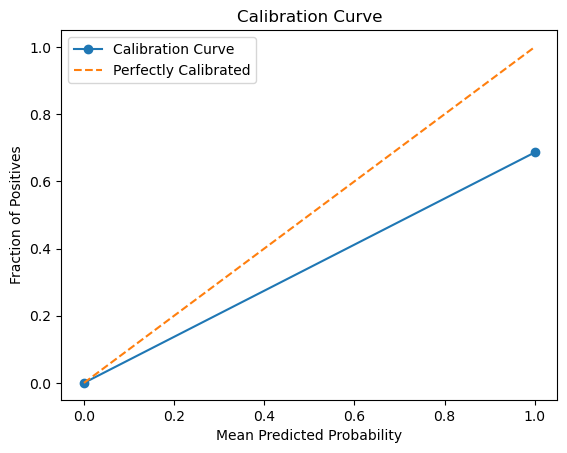

Brier Score (lower is better): 0.3115942028985507


In [126]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
import matplotlib.pyplot as plt

# Assuming y_true is true labels and y_prob is predicted probabilities for one class
prob_true, prob_pred = calibration_curve(perf_y_col_calibrated, perf_y_eval, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o', label='Calibration Curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.show()
print("Brier Score (lower is better):", brier_score_loss(perf_y_col_calibrated, perf_y_eval))